In [562]:
import matplotlib.pyplot as plt

In [563]:
import PIL

In [564]:
import numpy as np

In [565]:
import tensorflow as tf

In [566]:
from tensorflow.keras import layers

In [567]:
from tensorflow.keras.models import Sequential

In [568]:
import os

In [569]:
import pathlib

In [570]:
data_dir = "/Users/wisdom/Documents/masked-faced-dataset"
data_dir = pathlib.Path(data_dir)

In [571]:
image_count = len(list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.jpg')))

In [572]:
print(image_count)

1663


870


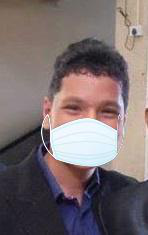

In [573]:
masked = list(data_dir.glob('masked/*'))
print(len(masked))
PIL.Image.open(str(masked[13]))

795


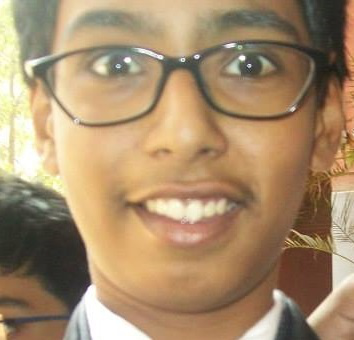

In [574]:
not_masked = list(data_dir.glob('not_masked/*.jpg')) + list(data_dir.glob('not_masked/*.jpeg'))
print(len(not_masked))
PIL.Image.open(str(not_masked[13]))

In [575]:
batch_size = 32
img_height = 180
img_width = 180

In [576]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

In [577]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"]))
print(class_names)

['masked' 'not_masked']


In [578]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [579]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

1346
332


In [580]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1675 files belonging to 2 classes.
Using 1340 files for training.


In [581]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1675 files belonging to 2 classes.
Using 335 files for validation.


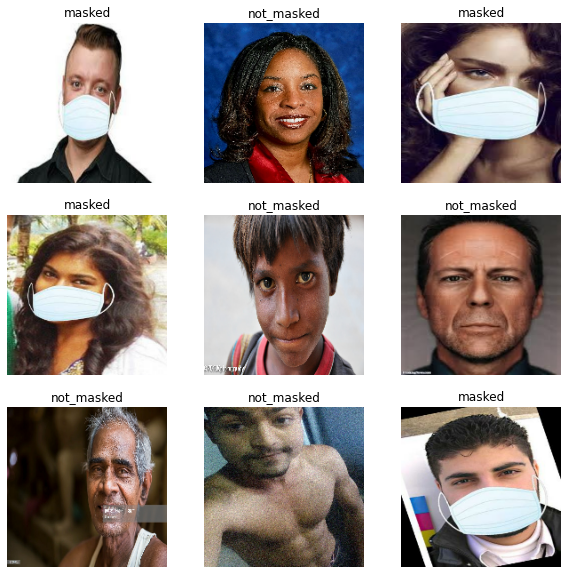

In [582]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [583]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [584]:
AUTOTUNE = tf.data.AUTOTUNE

In [585]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [586]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [587]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [588]:
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [589]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [590]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_29 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 22, 22, 64)      

In [591]:
epochs= 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs
)

Epoch 1/10
42/42 [==============================] - 15s 344ms/step - loss: 0.8523 - accuracy: 0.6311 - val_loss: 0.2317 - val_accuracy: 0.9254
Epoch 2/10
42/42 [==============================] - 14s 339ms/step - loss: 0.2359 - accuracy: 0.9014 - val_loss: 0.2079 - val_accuracy: 0.9284
Epoch 3/10
42/42 [==============================] - 14s 336ms/step - loss: 0.1754 - accuracy: 0.9309 - val_loss: 0.1731 - val_accuracy: 0.9343
Epoch 4/10
42/42 [==============================] - 14s 330ms/step - loss: 0.1240 - accuracy: 0.9558 - val_loss: 0.1864 - val_accuracy: 0.9403
Epoch 5/10
42/42 [==============================] - 15s 351ms/step - loss: 0.0741 - accuracy: 0.9709 - val_loss: 0.2264 - val_accuracy: 0.9224
Epoch 6/10
42/42 [==============================] - 14s 346ms/step - loss: 0.0590 - accuracy: 0.9755 - val_loss: 0.2952 - val_accuracy: 0.9134
Epoch 7/10
42/42 [==============================] - 15s 350ms/step - loss: 0.0466 - accuracy: 0.9838 - val_loss: 0.2685 - val_accuracy: 0.9194

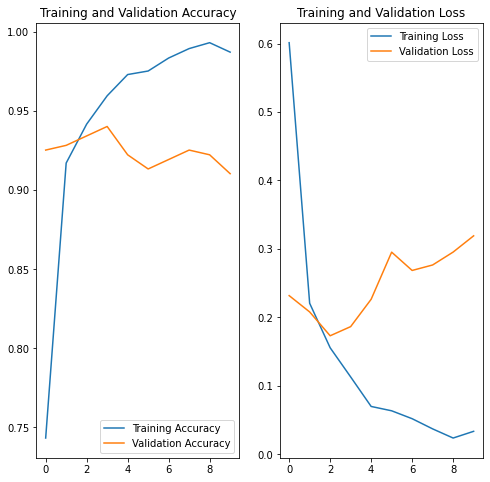

In [592]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [593]:
sunflower_path = '/Users/wisdom/Downloads/me.jpg'

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to masked with a 89.71 percent confidence.


In [594]:
sunflower_url = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAgAElEQVR4Xqy92bOnyZElFHfL5ea+Z1ZmVql2lUpSSSWpNb3QMw+8YPPWA2MDBg9gGEbzwjMv/B08Y8b/wAvGGIxZN92ie7oHmG5aS0m1b6qsqtzvhvlxP+En/IvvZgm4stK9+Vu+L74ID/fjx5fY+Nn/9q+ONre22sbGBv47Ojpq9mO/+drmxgZea81+++faYXzOXtnk+61t+MvDdfDNuIa9fXh0tLhP3GD4Lu+v1+PnfJzx30ZrR4d2zcM+7s2NzZbj9vEcHvr79Qfj39iMex8Ob+N7B4f21K0d+XPyef2eeT2MV+eiz9t4R84FX/VxHrXDo8O2uenjsB+O1z6P1/G5jXZk/2EOfawbG5t97fgavm9jj/Ftbm22rc2t+Lysl4zx4PCgHRwdYCy8pq6BPps9O8aC67tM9DWO9aUM2fPhGWOqxjniOskaQIhS/jjHOW8+D+P8hYTGOi4WOV7QNdqMa2D2J3KR1zhqG7EfNjf5rD7nKo869zZ/W1tbbWuLcnWEdbPX8XSyB3x9twZ5pZxVWanyNu6H3GfYM/GmiS3uEePV/cfr23tcc5cpf7bj5NtkwNbSr+135LXrfNpntjY3fX9gH/n9Zj/9mUNkKMP8rH17s9l3c/7n6+1ypPKje5dz3K9b5kivqbrExx17sexB/U6dA5OP+swqM4tn2NiETqhrbNe1uTQdN95v1Acmq9SJep/Fmob+8HnnunM/re2k3/31vlpLFfy7XSxkjfuI8hraOQVfr0rDNLmTXkdlf7aWS12Un6L9nMl+M/0Sz23rwp/DsCGqfpb7IvVhykKute/TlBPqM3tke91kiPqGMmj2xPaCLsVxOnD2nu/1Q9j8cSduNA6H39M9bHuJegK/y5rQtuk918bmakpssOmGYnfd9qcegK4THaf7y+3aEr/09Yq5rGKk+tLwgur3mUzhfbdyw2c5p3wmtw0zPac20i0ZP2W44fDwQPBBvBP6VOd74y///H856sY+bsRJ4MDNkA3G98gnsE+cTLoaU5t0++kPUAzQsMA+7f2aG1BwfhdMygp4w3dWAKBOyEyACFBmABCGWoCMCbQ+8wzwzISiGvA1BdPBrM5rgCt+xzfsaHj8vbkh4KZz0OOApY6Hr9mzAgAeHuBBFfzz7wRusYEDBOpzVyVI4MG17HMeRifng+CWkmwAcAQ0kKV41hCtOuV4fwqaQpaw+QniQuQosxybXhRyc3QEWeT3AGRWwB+Nib2/vbXdDHjnDx5IgLO/0+c6xrUGqo+Tr5nC6bsp9vUMAOr9FQByv9BgUBGty3OHm76TBeAO9wgAiHthXOkYLJ6P+qjsCVfem93ZXAjBIJDPRht8Jn3+4RJVN3UAeOydFzJS9wnnaXmVAG7xBvexgg8Cdn4Xhv7gsB0cHkJWt7a3ujOJNSxzaNekPOjzh0R20EyHdObLErSs+LnTyVmAwGdh+P6A4zYCsJ/cYbRMw06ejkf369pq5l4Ynf3jVn8BArHY/o05ADSAErNf9LSvz7ocE+RXmSUoxPsdaJoTstFI+jwLAB4HCjuoC3BbQaDb7dEBS3n1O+Ma8sXuQIq9rw6gyW3uBZnYwCHqGHFuiEXs07yd6XEdD3SWGJaqw3R+1TEbXrdx97kOMDmTUxg3AYDxnRkA5NdNbvAcAXrBWwV5wGfyeTHAa0TO6MCrhu5k2f/6L//Ho50TJ9r29o6zSDEQKgWbJAOAmLhgCcyDV6Dnd8pV1IlL5eIGlINQNo7TdBRemini0VjlpHIyBkMkALBPlgG4Q/eK1oRYFWpQGJ1BjK3ohiycKz5XB0QBClTI9V4EP1XodU5SNnzhdLzuJTh44/zXa+nra4wKP4Ory2bT53AA6J5DrrXdO9kjyAe+H4IoFxvmMgZJQKXGqgOKzWSkKD8ObnOMC+8OcpFsp310VA52zQRnHYx2D9mZTWPl+hpgwoPxzsVYZ8CCyUpAOzLGqhhMySqj6/M6gnWV4xxXKDjbZwMozAFWGVK5G4H/6OXLI2Lu+nWwHnVu/dn4OuXFX1vzSmNC675bMOO+/smm+ciqHOk9ud7pvTtQWvuZgdW6f/IzDkYHfRUfdoNj9/H9edw+m41fAcTaulFWlVmksqd+AWgL2XXd4gwh9u7BQdvf30fUgM6HgUCV865Ti1EmIOFnVZaMmc4xjzMNux9ioFINm34MsPummG+xrjQeYQDXINE3vf6zXYNRJqtuXxW8yRvh6izeSQYwdX+VeZc5Z4IUyCTAWz6Jgj/uKzf6zkJ3W37MQ9jz9gjSZEHVMdkwXVWcYpNlIxSq41IjgBwCr5fXDSZt4u2n81LYz9gXCYgO20EwcpxHvoc5ENKLzj7tAeeNOp3Aks9J8Io9Fw+BOSsMoH3fbLiukuu+ZEJNvfh8+xpxrLo83Kc+PxYFKFGb+DDHq3pntA85rxv/w3//3x1du3a9nTt3vm1tbfdQIsGLKQBFym4MNsGK6ERRcfmkGe2cj9sVfUx4p38PAqWSGJlQncNDRJg32YPYoEVAaPJqiHYGUrpBQFQ7GMvugZni90/UjWrzQ4ONhSvUsX2nhz4noTTet2/2AL+LMZeNl4bCx6TKm4ZppsgHMESlXTxNB4EEgAa2AvQHCMGYY40CW+MZ61pjvnQuC2O2GF9Hpqm6ybh1UBzz6cqrhuszLOtrnCHp7hGRwj1qEYoMUE2vGw/3bJOAdQ+j2OUsNiwfAxs+nBgFgLy6rtmgHHldAI4EQ3a/CnTqWnc5DiWC92P99Kn63JvTFGuUBn4ZkuV71AEewl0LvqaPCWeP+zI8XZVdvacCquqs2fz1MHrZ55UZGJTlGgKhwhd2PfUYQanLIfZmv2jO4vj6KDczkFCfqcp/BaFmsHQ9zTEzgGf/be/stO3tbddJAf7M4Ozb+wYAhdkzBwRpCLb/4oLOXlt0YwwXd1Y82BW7pv1Qx7meyhmmXlQAOMuiWFuGbjB10Y75u4K6dW7l+At+ExCn+0Ltj+psyofbu3W9MUQ+4gIK4vz7yzC/gim/1+bvAADJuiWoJLgY98jSGVXZJADsYeMVEOiOfqYkaLjVQ5GZzsP7KwGkQFJnUnHEsG5wMBjGXabT+Hvjs1MXqQ7SNcTfjFyIgzTTu4MNhvJIfUgburTjo1xWsEwA6GENH7va9zpWX5PjnVHKpq5j1yuhSzf+2//mvz66c+dOu3HjZrt06XI7efJkhAvdS2Bu0hgu2GiG+FVJzZRxRf4bloPGODRA04EzjhtGi292cKEDHwRSDMDAjGDO6J1jGXvuS2Um19TDYeQvEfhy0ykAVKFFDsXC4xmvPmdJMqxJ74PXUTClAv8sowLI00OcOa5RMfl6ac6Fry9fJ1uahsHHnyxRi2fuQCbuSYZSn96Mlf04kJuHn6EY4mI+zyMDQ6HHho5xhvPvt4Jbrd6sPwsVjo5nyJGRueqXGcIsqTx4DV1rlxHOMxFkqi7uBQ0Vm4wvHYwiLwYAFWwzhaLI2QielnxHX/cIsVYAKFvXp3GSi+cGP1namtua4I4eUiourpdAJgHto7H0+4yhGJ2V/zcAkM4Dx9gZUcoQmDMLgfp96ZAil0meeaYr0vAQHOZzU/bWdEx9fc3hVMbCPrO3v9f29g7A7mE+LLy7sRkpG2Q4Imc4PLO9/X3owFOnTrUTJ3YAAiEXRw0AkoDec8EMXGTUxQDn0cEB5qLnbZacqXE/dPW7cCpcvr7pjBz/uTlofLbTNuoBtRNiuCe3ph6pIJB7Y3bdNZ0fisnlbSV/5Xg2e57mwzGkrl+Cv/EzZPXGRSEjRXAzAw2qK3Tv+LOJLSkAqjqa3Cf2Ou/D0Oez0pmor/2eCdpUT1Pe+nyW0K7u09SlGdWsz655gWqLOmhjLnnc2J/LWTaudWcai9Pd56I7y6M+yedSHcloRNWldOzowEr+ubC5mm628af/6T8/Onf+Qrt542a79dxz7crVq+3suXNta2vHwZ+FhkxJhIGmoCgHMICVXhiQ24MbZpZ0ipBjGBsCBUxcAAgseFCdYFZmG5VoVt5L72HMMZp5dDQCBKdpBDpZ7AUVB/RmmL80V1hdOQqLowrTvqXFBLOrDMBXilvWVGSCsnUA2D2thdG3ULMLVd2Ag0KLvIW+ngLuBmUYTC0VBoVfw/p4j9gJRtgLeQhKCQy6shUAqHkaBkrdmEWBhSZDT4BFNboElAm8fAPOlL4+I9cn82PH7/mzR2FViJH7KaMBUsWlYLm/Lt5uVVxqiGpxg38/Q/ZQ7LGXurwzl25iobkHji9q8nmyVAsNq4Q9EAfJATND/JqzpOu8tg/WjCqNBp91Bt4GxxQOgwfj1kCnymTds4OR6YP19VSmx9/K8Jm+j/SJkAGVhW544X+lU2ZA7vGTp+3x4yft6dM9pGkYqLP8Uvvb1ufR48ftwf0HwewdtYcPH7WHD+3fG+38+XPt4qWL7fTp01GI5etlPzs7OwCHDAkyj5A5gwCbBgy3PJ+V84HIhqZRgE1eMjHcA/57TXP9//H67wYCh30c/3jWFUZnurLD3/AZYt2PA4CD/kVq03qKA+bVgD0/g3WIEKI80IxMqKHdrkvMUZUcthkorWkbs6evxRSzz5BQgW1lQUnobN17BFT1GrhHKaZLQJfySHkeI5ahNUrhpubvkWHnfZVYSIZvBFs6Rns+aAJJtVnq/1oQO5elxAMZIq4RKzL7SqYo2z/KcNihP/1P/tmRbWYLLVy4eKndff75duvWc+3i5StQEK4ELA/EQwca1uTDkaqkgp86OAIe9BGZWwPlHbmGvG4XbGHb8BAxsarcFyGCY2h5B3PjxHO/KEhNIQyFbJ4xBj9WvI6KTsJGKwCQAqEgUI2iAW9ec034Z+HeGtbJ7wYzFmN3xjDDQP6yAxiusb1UWd0BcEQIHAxcqQLXMdO46BxVBZwelwNAhqnUcfDvh0cjOlFDVwA8BQCqp8qwll0LBixAWg8P4Dm8+ORZAJDPQwDoBjzzxCDDArgoX78LAOS4undeAKR6r24MZlY2ZDX2X19XVuJ6nH+hqDQEvwaEfCeMidNc2xGQMldlE4R8BYBc2/o8WKcV5ECDcQjHJUJkZINNRfSM+lFNEnCuObB9Kxxz7yrL6SYybMP71wR4Z1RNP3L8qpT39y2MG3mXoQsfPnrU7j941D77/PP22WeftydP933WjxqiNefOn29Pnjxp9764h9csFPz40WP8NuBmc2053jvb2+3s2bPt7p3byOJ48vgx5N/YxBMnTsDZ39/bawcHe7juduyPM7u77fTuaXx/e9vDyZYqlMxgRgjI6CzmZ2UNZy9za1e2b14vPjeW/uqzIN1x340riLNWAeCxTN+xw0pWSD9W9RaewMDcJFWj77HBwc0IjgIefnaN+Bj2XEQpOmMu9ms2vrXHrHM1OOzxpZoyRRaeslNXr+vN+D6LQgEipRtB1VVpi8aOHbzP/PNJQM0im7ASwab7cFTv5t+6H3w90/lysouRu3CkBbNUW06ZTt25ZP/oRDrwJDAdbYKujT3bxn/1HzsAtNyvre1thIGfu32n3Xrudrtw4WI7ZZsfQNDDDu5lZ7I4Fg6eKJmn9HA5IDcTaaBy0pdhIxVY9Wx6qE8mciFoC9CXnrQWBzjgaJGsydYwwdbEenZAWLQUinB6Dtq8wglGhoKqSmTSNqZXY7HiOLx6BVsAjGW30ZAxx8y9KWkFIHlyffNLG5KqGCCMUZjB9UEoSFpXJPsruYEBVtVYc9PlxnTHYQ1IEADyGnx2MHtSqeXv0xSMAp6ylh6XGntuPs4FktsFMEFJBRbKEMJcaaQCdmCjRSVHRx46owkyl+E4AEVF1FMsSsHPAAJFBmZgCc9bQGAH4PqsUdhkMs4q5c48DJXXZCvnqr4DHwVcBTi5AnWd4RpvbAOVayTV0GuAQRK2mVxuALDvBTKu6oGS+exhfzLFPq6pgo/N/ywjrzIHo8BIRDgSXekjVlSiCRL+Iig0IPfIwNv+QXvy5Gm7f/9Bu/flV+2Le/faZ5//tn1x78v28OGT9jA+Y6Hc06d3287ONvCO6wDbMltte2cb/z1+/AgAEcq+HbWbN66DFXz6xBjFJ1jY06dOIepj43j8+CH+bZ/Z2dlqZ3d329UrV9rZs2fAFu5s77STFlK2zhDRZoYyzOddyPRCh2oFcsoWmwoMjn3o0m8KAO3583b/30CgR0XkJ6Jgle2e745MS1p9X8LBa+HfbwIA9budUJGQveu+pS5TPUYcQzYOaygRGvu3rstxgJA2g5/h/XMerJhlyWzWvVidZtcjHtGjjdFWaTrPXQdLu7Q6x2pjc68mGzlbt77HJSd9DPd6hEHta4JvB6uYW0ZWxbAPhbGL9lL+PS/SXMp1svje7g63gS6YFecky7vxp//Rnxx5Ppt7HAYCz547j1Dwtes32tXr15uFiN0r3IZBJghUilQVeQpWGusx74hJoeMUa5zcEb4AmlLxwmpVXAEPy3BUh24+TRIBVhCIildU67jSVKbK587bDPiz5irRoPktuanWwU1Vjso8shcTjW8Pe3cgEtdlyEiEJ0GSs4UddK3kGITURR867Q+WCboOZHxNZqBMn4Ur56GgZX6KCjpZxRkQOg78sZBBxd2BJEO+IyxWpcL5GcF68gusbuybU8vrh0KB48O2awwgwRgcJBHz2Rww9LtQyKGEO2hdaeOjrOIaCESaRS/gCa+Zrxmz3yv9c/3jLxedYsT7zEsC9EKBS3hmc9NDiKgfG5jMlB+9R83jq8rYAWCwf0XJddmUsDOfIdMQCNhmrGnx6UsO5mw+qrefBsj1i+0HZzlSnmhsjfUzsPf1/fvtydO9dv/+w/bB+x+0Tz79HEDwwaNHbW//ACHgp0+tGMQr9g8i1eLEzol2YmenrxNl2xi7/YN9VAfbPn369Gk7OtyPELJX925teYqPgUl7TNOr21tb7cyZ0+30qZPt1KmTAI1XL19qly5ebJcvX8S90umJtI1oFaay6NEilaK5vh+MZVlo6N/CsVRZyO87zh5NcP30NwWFnhajz4PITwGBi9j2MZGntXHb6x52HR14MoD1e4vozfABt15VqisIPM4Z1/2pto+6egmk5vC8AkAlbCp5M3PEVC6GtI1YQhaYjJ9b5oD7vcbcSHWgE6CNaRs6rf1ZJN2MxYCj7V12yOj2VHQWawgg31HdTQBY5UBzGtcchbRzrm9smJ1UKLob68huL//lvwgAqDUYG5sIG5w9f75dvXYNQPDy5cvwEk+cPAUPs2+MRXuHZMgGBiZatUB5RmuRocCgSLkDs9FL0BYIC+TPPjrIHUxvW5PvVXEvvaIsqVZQMiTlFy+ICn1puHP7UdBIcWNxosLODeIsZ4+sUYAzPlFi2178wJC8Uug6leqtYiwI2W6iNF5BNKq90bNON0teqXpL+szM0cyNOHo6awCQMqT5KDBKSEqP9hPBGKkw+5wqk+N3ngPAYOMCjOTGX5oVes+1dcuoCNKAuAHNNhlJ24dDgbZH0fCTjaQXzkQUykzawyiLnEnaS2VbwwWV2WQjaFX6YJUDADrQZih/yVjys33N+0ILTRCvae6PKnk6WM44hjfbHa9lm6PjQr8s8nJdMgdw+f15w+kMSy3hgrIHxxnt+jkw5kNzbG/TYk4fANu+5xB7rz7PifztF1+0d9/7oH3y8acAgPv7h+3R4yftyy+/ak+e7GFdLJy7t7ff9s1hRbsIj6gkOInUHLSM0lZeDZEdKyIh4+DpFdGhYMuLYUwP2LOcPHkCLJ+Fgu0O9m9bLmP/Lpw/165dudxeeP75dunyRYBDu7Z9z0LI9j3KaDadN6ZvzIUdWVJ/r4KB6tB8EwDYcVeIg0pFzwZQr+W4hcV7IwB02+G58IrxqBcVRNDjmzfwnd9YAaCy8T6S5Y/uedW7/DSkuqd2ZNuPEdDiqfxpv0E7JcruNwGACv6SsZuzkM8Gf7NCNcp5gvTjACaf0edk7gTM7BHsiuQ5O5PuP1VHDTl4AcJG27Fs8aI6RJ3IcX1pk6tD4lcf8/xGLb1w3CP1iyBw47/4D/7kyHJFiEQtAuXM12bb2NoE83fm7DkAwZu3vEjk1KnTeE9ZswxhZb4PAcfQe67PfRiaSYd2VwohtMy66ycwpEH3Rc0ybE6gh47jc+y1M4RneHLIwM1IMvQoIMwLnAlqekVqOAOcaA4YE11L53fm+6WAuoHUhaOJGl6bNDyuQIV0eeYaotw6NvyYi8JWG6kMxh5QM4+Ryi+rmWt7FuZm+Vo8y7BCBgGqtodq2BFIaKWw5TH6U+vmUe+uy4hMTj7Lwk/uhRvKatJDU6WWzo3T7J7T4oPxwikDhs5IKAe4ZJODsYjUihymPGfMXWVaq3LB+73SddwnnP+6BrmG3qeKoFDXS+ewV23jA9wn8dw0OEMVoL9n/4+2JKwkh8EJcBZN1/V5KAt8bRl+8lNIhjkI8EXlTKaYn5nlIoUKHa6jr+l910ApQQzAVOQWc17tWuaYGHgDiLM8v4NDsHlff32//fwXvwIANNbv/oOH7fHjx8HwHWEf2JyZbNt37T80uJjkwI7L4XvXxnBwaMDR+wNa+NbCwgb4CPqsM4PNo4WRjdlDOpBVEB8egglszR3Fkzs77dy5s+3q1cvtueduARzactv1DAxevnQJuYIGBE+dtJxD7ytrS6QFI3WNlzoh17Xv4xC1lcyA2P+xahN/YARsdalXQqMbmds6OkBzhwPz3wXN/6gNn/l2BYaZD5f5rPw+5c8B/zJsqjoBodcyBtujsKXSpmz2PLRjBOx1nagDzHnxv8exzsbWQbHtyxJVsufy1IflaVr9EWThRvvDFlOJEwY9INHApYNYwd/4byV/uN+dLBpPEeupORMCzOdnVu29HoYfHIjpWi+JmWqTnfmDFj825YpraXK38Z//+84AMhQAVe39ELo3aYzRyVOn0Srm9t07yBM8c/YsWEKGAKmwM5QUoZ3I+3GpGUMricRzEQYDaRR8ZwxrGXQuObxu8Yh1D9h81EaQnABs2p4rl+HemoOCzzOUUUJ6BB6DgcIAwoBHKw4VahcoKqxkspg74eMam1Qqk6dzNANmuhmcIYy5owYtOqwr4Z47leEIZYqqUjgOAHJea+6fbjAouRgTr9XZv5WekByrs3Rjv7yZ0rLXVMmoYa7eML3mCu54Xba20ftUZcXv9hBZIewIFuo1CNb5ujPD+WUd9+z+w2uTuUtQvA7S6eioTHUFWptld1ka9y6+i3BnVsDF1oc+0SPMMBfC5GJfxIP0dZY+k7le/FBR3qEH+t6JQpc6X5Vxmu8hd7tgPOMC9ei1el1PK/EcHOoWAjFj9b766n578OBRe/ToUfviiy/bu+++1z786JP29X0Dfk9R7Ysm+7H2KLbY8vYt7AMIFlFyHIf8UwPeGIMxc16920/3sYIPy+OOfG98Jk4WMmfFAKAVhPiedBYAYCDy/MAKbjTkBp46fRKfO7N7Gt+5fPlSe+H5u+3ypYsAifafgUCfgwYg6XI0rlftMcvoQ426sOfsqPdy9pcM3/heBfGa5uL6YV5puyYn6xBQYk+dfUsgmbrLrzDrHUvdj3WQkx/WxlhlEFcWpzhDn1l8lRGXMZ8aR5GWfo+UYwI8zwsfCYqcpyWzxkpdDCsWqoNapjYVoKfsdteHNQ0jDPLM8e82Gflyx6VnjQ6sjlHnlQBQqV/26lTd4USLVWXnPIykUTjDBfRWOZuDacroco7dpozgT+WoPovLvF9n4z/7Z39yhM0PZbMBRQPvkCdARJ8oeyirFDYG8Mq1q+3qtev4G+0FcOKBefeuYHLRVo7lig/45FUPQIYb1Bf7zEG5deWqm3w5KdyKDMvUjRKRzn7KRg9NBGBVQ9SNNhPYcTEuZrJP3ehJ0UuCiVQbXWh7QcnI1ij4w51EoHoosLNCGeKaeogCcqnsYBxqcmiU1K8pmgo6+xgjr4uKgvOcIcsxxDMDgArqNKdusWYiN/6dBIALMBcKg3lWUKgCNutmH9gGtiUqzVfXwiTLe/v8MpSs0jljkSoA6SH14yiPyeTYtTXcW/v9KYDRdXZ/Lwp1qkeb1nLSODrlFg5g9JLz+XBHkrlvkI9eZKR6IR0gXasKeCsLPE2EpnwMc5P7rjs6JU9L51/X0uZkyfrPC0cg170h8yGYPnvNwrfWpsXA3wcffNQ+++y37d6XXyPn78HDR+3Bg8do8WKhX2P4TKat6M5Akzbgt+c1Jm/v6Z7k5/qZwMz50hYW/azXIxvLPuSRJzqRxXFw5/uog3MrIJEjDG1ubA78vodg/FAJvL0F3W9jMsD34osvtBvXrwEEXrxwvl24eL6dOLGNM7TNJqhPwrX1ULGlHviC4XW2PRLHCYADJ00kzRYchWvi2GCz7YK6/H7Mlofe+3pLm5UZm6xiNLy/2gg9v6GyRoICe0T0UjX8w/36w4y5gT5RYsAFaE71ZWf+ksEaAXFNKVkvWqu6W+/HlC11NAlGwTizuTmJlHJcWreokrOv+pb9iBfgcXLUHO0rfz8rclLnrbfpiQcASqmnfZQT02TlOwPn9la1f/YH9LGNLKrL8tIZyXln8dSId5TEWrOZfD1PF4oCz//wn/7TIwvzepHHFsDf3v5TKBVPDtYzJY/A+u2eOQPwx76BFhK23EC2jeGAMjS4DEdxw+tEcAKoIBRkYBJQ3RJtEnjKgUzwONl5zzHfJzyRKDmbe/954oUaIowB/b283Ydv4LhPJHn3Rtch6AyTL8JRPSctYu4lbZdeMO5BBceQciR4ElzWEGUVAk0QJVAjAOT1uQ5a5cTr9E0tDZ37GkF/hDchFbsAA9F8Vr003RQKEgHQxOitrksBtEyq745BbdBdmOE1Rc+2MJzrPPnC+2xVkMd5PG7DVZDdjcIEjDpAEmW8UjU9GwdFR/eNA8Fk+6oS1KRmX4cRAPJaXdVMmqnqXNK4ubxzW/i3Z4dtjk0AACAASURBVD09O4Bn6WdIEXMmqR9m87smG+W2i68yP+5ZSlIZqM4RxF5niMV1VT4fwrz7Hto1wGVgzoo0vvjiXvvlr95pn3/+BcK8X9z7CuDP3rNeq/t7XvFrhR1s32Cy5wCQYNPBtM0jmMAwqIgYIOfPQ386L/a36W77jFUB49872z1VAporiqkAsKLp//bWTtfjWDsDnvt+0ojpBiMLzAYAGEIfHwEMXrlyqV27cqXt7p5qp06daC+//GK7ffu5dmJnC6FlF8W4T+hu+573GXQQ25nHKBjnOnF8XR+FypkxcQoCww0ZerjO5OqbHrW5dv8ZkKt2w1jxCgApQ/b6/Bp9Bjrrxn2bvHRKc3VWCMDsN6Mg9T51L6kc1c9q/0INY7Ngc3CeSDCYXcRJNiOwYYqXzkG3DZP+h+yWwc8nEBzzzfH+AC7nOcCcNU+H6HRPn0yG05UtXmN+s8Ar8cDMqcwUIh7fGFhGyII+ro5rpLhV6d1eheyj8jzAkUybpa9ADqLAFvvq3/ujP+4A0Mr/nZRzgMMcDwWBNBaW+Hvh4sV2/eaNdvnq1Xb+wsV29sxZsIQZFl4ygGQGau6CLpyDAZ5E4kdawTDEUWU1rKhCMdtIDmrEfSwFA2oQNImbykI3KFgKVIcRvQcT5f1hHD+E4q7J+Zlwm3ckiKvB8W6AI+lU24HouOjV1yoyfaZq/BX8deEvxxFN78cKcDZfDoGsx7KbIgcAjPDVmudYgb6DkGwx1BVuUZC5uag4JeQYIUWwYaKxlUWdFQ6ocl7ct3j86uVCEeJGY2/I7qgI0wo5IoiPm4xG+9khX5Xv/l3X2iMAmLSDUZlgL02+hjUzQ6wheVYNm/KeAUCxtmSQVDZdM82bumtblDRzvs95lB6vVY3E7woAa1HMMA+Tf9QQJOU33Jwh7xSgDAUezuA9ePCg3bv3FVq1GNB79933wfw9fbrfnu4ftEcPHwP8EXxZyNjzAp0loeFx9tghjBvbPCfUjBbP/e3gjS1wgn217xtYM321v7/XHXoWoSEHC8xcMIDs89oZQC9usrF6Co0zbYgUgRTYwnN7v8HNZpXIFhq2HMCTJ3fa3bu327WrlxFVunbtajt37gyA4IXzZ3sI2QBuso3ZGga2J5hA+2MGUtbWsBppm0Ho7Gjir3sb8vWME51msrZwkkN3sh9uJ0B0f4QyOq64qZIhCiKV8c78+CyCWtWx8cAjSPEX+Wya61bH58RLMk6zwhafj7E6pju7wYwvmfSxH2iNBA5nqvfTnnx1AWIks1pZs3mu47JvL+UAABDC7fsAdkPYOTEhDl1KhASftT2yQhJUUMbntL3ew7ClsTr1na+p6d5Ip4l5VqJgLcVKu6j0iBJlIXJCoTv+3Z/+4ZEtluWS4Nig7W30f2JrGCQHo1t8Tg4Gb4nBp061C5cutUuXL6NI5OKlS6gUBpu4481Fx5Bw0PjHaGAKN+4XFZauo+Yl2rpB4ZHK+cIh5hFCjT5/9Nq5YLPosRjp4fr9OJXIk+xh2DhmKUK/vh2osNlmJfMtshJOj0hLgDoDI+ZBDh5WKHw/J9Yfguf4jkZhBBWu9JIdnVafoXJRAS7DdwHsItSneT21QELPlYagF808B3+cg/HQ835cXZx9vPSugolBvlZ6fNXwVw9VxZDjUQXYwdYEAJIxo4xpQRQcFmyybFPijEvM+9BrT0PTXohxXPWgKtYEoktgqQre/87zYKFgIl9ODaIDwKjI7cA2ek+thDz6GALoZph9rCgH4BhAqqwTla6Etqqhnv1b5byDyNIzsxrwWggCBR1fVvZDGfjOnsQpR84wOANoQMzAG9m/e/e+bL/85a/a51/caw8fPALzZ2Hep3v7aPHiutxKOcKYHXqRCM7xhf6yI9wkPNTretwht3HZPkfT5p4Ow82Vymx72/K6s0UUAYSP1Y9ptPddz/N84GyHRSeubdg1cl/a2FC4FmdN70skxeTHo0k77czZXbSSMZC3e+Y0wsRnz+y2O7dvtjt3nmtnzuyi2fROjIHkN1qLhWwyH22Ihug+mhQJUNsp3wRDGnah57/1Yql5mtIU+NXUAcjAWGAB3R25YLoHtdZxBgLZUq0SGNmRwNe2hgg1N72aVQVdBCozB7JH6iTSpPvpWQCQuf28h46D9nwOAMdnUlYQzrLkGmpnhgoAdV7I/hFEjSB6bOlFcIY5YSoEyQZp2uw2c2lHO1BDS6b1PNIlCPSQMkE7UmPKMaDudOV/zssx0ibGNHr9JaB13YH+E4FXeqSNxJQUBG384x//wZF9wDaqJ2hbh/kTCEEQ/BkAtH8TzBEAWigAxxLt7LRTp0+hX+DFixfbxcuX8bcVith7FDBWAC48up5Qzonx0EaGTx0A0nB1YyDsim/ymLAIzxzZdcUxoVD1hUfYdo5G9QxMF95s56HsX0XXLpxuNAl8XAjZ6iIrV4d5kFwcLFg3ET6+KkQdQIVCnHk+7uEno0YQMgOAvWiDiccGAkPhkfXFPbuc0KvKCbR5McHNKljPSdONrIa8P4MoY/sCnzUBTm6+tcaWfX3YAX1SDUvlwOfQ+V8D3TYHAzDoDFmyJwSBQ/uY2KPIW7VrhKwehRxP71dOVRkV6fJA9QXIW2mJgnuhmxq9br8ycwIVjNfG25D1wfkY98saAOTYuOfmu8xlCGFMyriEVgeAy6TlkvM0m0fK2wD4YwAKAKEzpDABY6ERlFxgV6SxD3tIy8Hfo8ePkB9n7J/l+f3m3ffbz//hF+3R46coCLGQsP19/8EDkK7b296vDw5WgCebY+pU0xsAg5aQ38WeLXuwgngPx8CFUw6G69CBY+4pK/pIBxPPYNeO/qdYfwNgqNZl+MguH3oXjoidEnISrJ+BQAMCHuhwwIhrIUPF9rkXr/Q0oE2vEDYgitxBHDJwvt24fqW9+spL7Y3XX2tnz+62beyLcI4YURAQaHZpBgDVEar7YCZrXefLmzCUZJeG1+etkOp1vSVMAkDM6bQAy3bf6AGPIDCbD1cAqABmlh/GMdGRUd0OOZNCCwVHgx5WVquAQJcbf1F1L8cJ1rMcfJC2KAvB1Jbw3nSsUi+NxrjqZ38e27E15pTAWO2gPuMwT3QSh9slAaO2Np14JWsSSKpzofOtsjJcj+thADBsI+2ythQjAOTc6Bx1vdgfKu8GHQDwt0xbsu/pnGPf/PHbf3Bk7J9tNBjRgwPkjtiGPRn9nU7Fb9vQeEhU13g4wDa8PQDYp42G/BA/TeR2u37zZrtw8UI7cfJkZwMp0ENRQdd0AbQElWU4JmjmsgshfHEeoivCELowJBXgjeDPPXlVIFSiOPuSITBSsYGqNbSL78oGAvjT7uNDmEEqcuM5nH7GVaIhtTOtldrtXcKFhsYcFgCrRo8VgoOyFJDBzU1FWNsWqMLRwhGwBjF+YncbS9LgzhLgvmWIdk020FTWjArM2ZH8URCgY9AN3T9dssAJLLrCkTwUyhWvv/DKJY9kAEglB9HDBgT3Yxi2K0lbY7YxCqOeTFnmeWE+Agz5hl8qxLXxdsXfvUTNoo9eg72nFVSOtH6K6k/bR+pcmoGMEyZSmY65ZpR/BSP8LI/0mz2LbmOAxMIQAzRLOLrOBa850yeVbeiyKjdlI9R+uCPvxWpnYWuTIfAwqMm5tWuxNi5f/PYLP6HjwcP20ceftPfe/6g9fvTEc/oOfJ5xssees38EW8bg2Z5GyAmg0kLA3tw6lbeFllzXMgrCPak9Ue19a/fium/sIdrZc2llYZ/Dell3h5MG8Lba3p7n+G1s+L51UmCrnTx5Cv+ZQbJm1ACuOP0n+rAZMESuoPcXZQqBhYZ97FY8aO1sNtAu5sqVi+2Fu7fbT3/yo3b3jucIuv3xwik+P5fKAaIIh/QVrHI1fK7Yia4DJE9K9duswluvN5M/7WrB0L2v78gGQW/RMe3pLGMbo5pHV/eHy8Dy2vUxx/1bD0cYOyLQ7g25x8m1dD1c7YDPu0UBg5EqZ2HPAODsechQdZs8YXTHNXDQ5Ckitbiw5Bg+ozhkcPR8h9Gidb2rzqK2ScPzx7MPtl7AtuqvSt6kXUiswvXVaFfaOGUDY85ZqBgfUuALfNbT+NI20cYO6/nv/PD30QfQqHiiCQcgXr5v+R4nd04gLIxmn2HYoSC2o3WAhHYsxGA9Au0YuctXrrTbd263q9evoXAE+YGhJLJ3WvZNc19yTOJ0BU+QpWxTnhurm1sPYCYYU7AAvNW78udkqoCaMrDnhpBFvmBS9FoAUhKvzYD2WcwruhBHor2E1uwTPbwU42JOCr13Kjk8Vzz+LAdyqe8syXwZ3ujhnvA+1LvTa8wOLFcPUI2zfc/GlN5FJnvXYoQu6D2vw5vlUjipiBUgUVGph1SVP/4t4SGOj+ybygD/Vu96cEgCBGTFuSuHBIJaOZee4ywfg+NKAOjX0s+SYeZnZs/G++vvWSgJ77OZp0BpxVc9lCDhKgICvzd7FC2PkEqGib24nEnyVARnO13BeYUqc930umSbeR9ft7E6U/NjKtvj1/JV7OxR2QAL8LzYIM5o4XPCynZgMwHfBH9WtPHFvS/aJ5982j779Lft1795F+f0fn3/QXv6ZN9BFDwfVqm3nrNnwzBAuPf0afT1c6aO+X40FmggHf36uOYER9iHbOgMfRqtRsw4RgjZ5SBZekYkmAtnc4pqY1Qcb0fVMr7leXlxBrwBRGMBbczGZmLOcISeFJGAczDnIZhc7wQUnSU8h5snAdoxcufP7YIF/M63X2s3b1xr586eQdsYAMF+GlEWTYy6gEc2rud16R7hsmtoOAFHgoaaJ12vofLU5VEAkM+c6wi//vLavStAzx+P6EhXTmNeHMmI2fPMnEMVcb5PkJX6z/9S13L67PEFt8fz8Cb1VmrAsWOFslC8v+7lkQEsTIboW+pDtxFH4Sz65+s86Lxrmgu+O6k8VhvgJEw4x3Jij35G75dzLM2opRgUNQHsSSgO7XCNCV5YqCohnjT62GU7K1WwPw+gAxynuOykvVqQV//kJ3/owccNV0TwLIPa5uvuDW4CAFrxh4UxfLMaQDTvzk9uYBsILGx4atYyBmzgjRvt4qWL7eRpP0mEGwWT24+X84o2Xdg0cgnWuMHsu7h/TADPrvVQcIRsB0bDBbQmbKqXwZCpMjFq1LrREoq1b9DC4NjrPjYCiFpyH5sRzGUKs7GvGk5UD6K3SZBQGMGXCg57eOl2J/gj4zJunpGCOS7vo4K/mbIkaK8eHAVSQ+L2muYzkRHw8D3DD84UqAKZeeXD/ajECjOY3zMvXICHHJ8DxSmKL8HfWFVWcEKvprVbm9xg/SXMyfFpnlAvfJCwtSqXnLMEoilbS3Xhr4zjTMY2GdY+PoR36ok0o7OlCtz3rANAggxvaB6Mw2D8XP5nBrSOXPMqKyM4MQ/y9VE3qP6oTEF+qVZe+jW45HouJ5u1m3NrrN+DBw/b51980d5//4P28cefosjDCj6cIfN8Ivuf6RLua1PKppe8YGQfx7KhPQvavjhDhvvjM95CxkO2zqK5YzS6lwDt8T3uc2dm/IQO/8+/Z/dHT0Br8hwFIGg0HZ8hUMc5wjgWzvOSvABwqxe5YC0BLk2H27W9lcxRhIUPwfh7w3kDkqafsf1Q8OGVzYZZd0+fQOuYl771PNrHXLl0EcfOnT59Mu7puXSMhqSOSZnjazM9oO+NOiiBA/Ow9P0u571h+RyYDPeMHOH5fbLVR9ebso6d0WXFvhQT1D0zu/5M967NB8EN11D3NCSrOj18bdL2pqdFRfPpGVBUAFuvPQN//nzj8arVfhBbkCziMzjAm7dQUeB3vM0InYD9O/6s6REFuZ2Fk9Bu6vGV3omF3WZOPvftCDijSCy+UwkAzF70DPVj8nQ+/Ik82ifpdf/4x/8IRSDYowBy1pbEJzO+AnfOGDEc+WMeY4AueInBAno42IBLJB5H6M+Ao+UCXrx8qd28dQvFImwiXdkuFQAoqVBiS6YjEh2lUMSVt4coFOAxqR0KVdA4J1YNuxtVZ/G819LYp2fwLpCH44oaytIRj4ejhYnKsVeRSm8xDU8ovW9Qmcbr1ryOwVvGLbVC1hO/lwovASrn5VmJv+oVqRLifACcR0/IULme86Dh/aj6pYrthqk0QSbYUdZMQbFu1fpsS/Xtn7acKY6bwLjKmR43WOXEr6Jrmn+rx1UBoM5VbxyKNUpmQ425f37G5I5nVBd9Ff+MZuLCHHMuZ8algmv9d87VRI6jjYGDtvHMze78xBjsM5iTvjAZ/kXhAaup4zbsW+VXHlY65j8N+jD+AKcqWzr3rgyXIJc5cqnwfSB7e3s4nu3Tzz5HyPeDDz9qH374cXtw/0H78qv7DtjsyLf9gzitw0GbK2TvX0r9xGI1hmJdf7i+8c+RUciWU9m/bhzz4ZG1saCesv0dbXiCiTCATjbRcwv9+5rjbGrOC/a8B6DpdM3F9T0dYC9yA71Az1okORsLBhDAz/SgNX7eBLu4Y9ey+217MaHZDAeorV29YucLn293bt9C2xirEN49fQq5gfYc6F3Ye0dqznFx3GQtZ2BuZvTXWK1BwnhqkjqCUgzQ88OYAiJ6X+UrW5eRAMhEfd6vgrsFGCvpEJMDtFbzxHmPBIDjPup7ZMqoRRJ90SHQoTyulXayKFtl+vV51A4PIxnIGjr+SZoA1GgPRHdzPWoYaVp13mpRSN33eX+9+VLHVf06AL/e0i2/p2koCgKn6x1sPZ6hnAmdhJM7f+lElFQc0WVIhWMxGcLB8jyR6tdzX3//rR8e0RPsR/YwLw35Wt6TCgm9kRcHI44kZc8hwUbHAeHG0liFmDFzyfLZv01h7J7ZBQi0/oHWNsb6B/K6LDApZM0QKutAC5o8pY2T4srbFSIAQhjPmcCpdzJ6y0HDB4rXBVNjQk9bWRAoxDBgvbIq+qupACnz0jcn8oPGs4FnRl0VxQwEdgHplb5ZGAPjH6BM2RY3jK7guUFmib98bw6GRoPqp8swjO7Ci/TdEHC7nxsrvy8NPYBjr0z08XRQGxMyU+ijcV+DfX4BKgvOL1mQ8Vg+AgszrmRTFORV8Deycyo31SkY3+tuVibxT09NYBFHsl1rIeDRiI1jBoMcH1CgyjU9DlinTKec9HmPfM9FUirvJQCQDidAVmnPpIwPjAxijbXxbX+Cvp5VsXL/8/XaVkJPKlEFbaFOVOXGub52c2vU/OVXX7UPPvwQbN/Hn3wKEGghUbZ/cQB42A7j+5YYV3OhjEHsPSXlQPbM+8vKQMp9ns6QxRAOoqztjPUc3GtPn1qfPwd+bNllMwSD2Y26L0Bt9N4jHmgDFH35IsePc4GxBECEDo73I+jpc4U9suW/EUny/HCGmEkg2Pdt3PbjYV9jA0+1l176FnICr1+90m7dug420ApIDEDmGeXYvfhu10HS0WDUAZKovxLC1H2if3cndgIAZ99Z5NCJEYMcTu7PKs2Z3I73CCAkaVaQV1/YwZlXOa4Oen0+/7c4/l0vjrqT+qBWMWtKFBtu6WdgX8LW9AKnweGa91bl+tYUD46DjrJv/LQNDp60p18+8czR42tuL1OfjK/7NWrnALwWEcCBbCoOQJ1zysK0oliPv42H7wA71oa2nXpf9f/4jFaMabqGpwalbWJktu+hP3j7R0d69A/e6AkTnsdjwM9bwVjllyFKN+heKezAz9hB+xsG3IpIojiEXq4rn6NmIeDr16+3a9euo1jk/MULbXf3jANGOe83FVMmq882ePWc/CSTUbhYHFIXt4MlFpLEinFxldJN1RNCscjzcEHqyoM0bQc5Kaw9v4mKrCeej8d/VeWAfyNRegkCauI7hUOFSK+n1csMU6fHNirZmXLUtSBb0pUFmdtI7Cbho+DCDYkzzqwu5D5kKgG9lC7oKz2pRq/fZTOfNatf+VoFkKksl0UcTpmP5177s+t1C8iiUcpRSBX46F3WQhV3AuDTyjMsx0VnaChAWitpDw9Tk9aTKV6vbuvzFd9XozKbQ9/jbG6ayccqP4MMdkOZc7IGalHbNhi8yK8x44qt5/cjS6whJo5L9w1l0ZUyXEVc38DJ3v5++/Krr1G5i+rerx+0zz7/vL3zzq/bp5//Fj397HO9+OfIHBhXtmjUbH39rD0M2MDM8fN7etWo3h+fjSre6Z4PWWCvRu43CyNbk2cbi10vc+g8kuDpLtanLws7dI3sb5zeFKc9eSGGO2TsTehz7ufC5z6ITgYQUW8I3dsv6TF2aCm2gyJA9vuzse/zxBNjBDcsJ/JpO3/uHJhA6x14586t9sLzd9Bc2jpSWC/B0LqD7mP+p+6B2R5/FtvHIkLo+FJtPpNdfa2CP9WLer218OTa9U2OMzzsn6KeU6A3fH9w7r4Ji+Vyz+t2osTvhv8fQCVe6P83FCxh3/W80BgvOx9EGx5P81EG23Vrrtl43m6dG4C8UmDDPUibrZGrARRN2EV/wABHi6BvzrnriHE0dNqO6/+n3yD4q8/k8pM2i3Y8532ef6mRPv9sVpJ7Ch8LyyTkGwWGKkcbBgCx3H1dsjrJbuKtYXi4fcxi8P5QbtHN3Sh+YwPNY4PXZwAwFB56wrHCq1l7gBPt3Nlz7ey58+gbeP3G9Xb5yuV2+vRuVIylJ5qJzMsNMGxESb6tYVECwN7bToBmBw96CoO0cYFxWFSyFoAU0wIgI725aKTZGLszdgyxl95svsmTieOmH0Bu2ddrnh6FYkhGDqOA60bvIc6hHpHUlf4zTqPg+NRoaz8k5pVWBV0ZRJNfF/xU9GARJDcUe1V60bEgBazrsDtzbdaU5kzJqzOQConXYjudEdS4wlxW/PWK3MEjVE8zFWRt4My1UaZD51mBPpSuVqD/DgDQrknms8uQyLEqz34PaTtSFdlyznJsI0CPZ+8szjJBWQ1PD1VgnUcd0I3qMwDgssdaVJtKMRhIlSMP9d778qv27nvvt/c++LB98ulnOKP36/v3cX4va7FsfmCk2QYj9rTJvxV4dAAYwCzztEPR4nQEb+jcgWHk5xDE2ut2PU0jcUbQ58zGaiBQ5VlP3OA8wimPnqyztfCwr4d/+R0DvgaEof+kT5krw+xYQAYFBTJWIYzUD+b+GXDcQqsZZwKjehhz4uAQzeLxjC3OEN5pZ86caj/4/nfb66+/0i5cOI/G0d5aKqUudYjspXh7zdjy2wr4fL/5GGYyvCbnPVWIztXaBwNEHQdCsb+06CCula3sk+nTfVmdHMhNhEQrWKxEyWy41N0BCx3cswlxOEopi8EoRxoUMEK0murXjibedLK0uGx6/8jd1/cGECdj6WtZ2Fb9rh7pRnizBM8uz5CDyaDobDElImWEbP2SyVTnbniWUt+g73HfVhmcFWPq98Ym8e7Mgj6Qqn/7vJF0WFdpGG/ys/GHP/m9I4Z0+83DkCAPI8gIE1KE5gRd2vfMO8PZkMESetXYCWx4/vBIOTBBcUTVzgkDiztt7+AArWKef/55HC935uyZdnp3F60HPJwMlbSgunsl40q/N96bmwSx9Vl7mWJECSjYqbseuTNsJGFGqDgZOgJwtUo4FtZIKJiLA7slHlCosuE1Nc4qxDoO/8xaV/iRSeI4HZymRh2ZlwL4MTB3DPocljYdyTgmu+GGJ1pDyO4iMParcuvJsVdYb4aI554snRLdkHX/VnDMjXmMrh5SDhwIR/V2sIAcM641uRCYl2Fn6/gTBJKKJ/uCWZAWEangQirkHNH+Xuk5NgtVLD4rCeuUvzUHoyvLY0IbHDedpAquda2HohNR3LNcoaxUDuYJzzrKghrVGlbxCFk2Y+9KOew81687h4d+IseDhw/Ry+///vkv2q9+/S6YQGt7YmFgU14mz2hxgmbK3nMLhjfST+w9a/FiIBC508xhw1aL5qxh6DpIjPfsEwR/9jeL2SiDfAY6mWAbo8FxB0SWwl0KCex71p7LnHOygQSdyrIbCOR9+Yzwf5HXN+oLC/c6g++N6L360Nt08Fx45kTbPRgKxjPaufHGDloPQuYkGTGwvY3cXAsNv/md1xEWvnnjKphAA4HWc5ZtMvi7676egrCsWuU+hqweE9bVz9Xwau7H1JnYN8tOXFP1UkGpMj8Z4RAGcriKaxTuLe4jz/VyAIJ9Fu10UifOdX8+S+4nrKGeTiH3J4Dre136HQL0k/WfAEAy3j73DiYG51KKGfW4OAVqY+79TOv6YNc6WpBfU/2fekoIF1caw1yPNsR1ENOY7BrG3PNHbWCNQvbnKSAwHXprnTYVnd6tQEG9Xy9wUbB3/bzl0JQ22qGQcVHo19rGH/3eT3sRCGP1rjj9OB7f+9kA2JSaHu5s3dw9YTdDxQYAbYN7GxmvAmNLGXqTXum61Z7s2bnDrV2KE0WsUvja9RtoIWM5gsi1CwHrOWVR6UKhqjSyr6BPZqLxZSyfYJTPN0ww2QGSnpPQQERApOLOw0jKAqpCH0CX5ML5OJlrlgn/zEljmJBKW8WEuT8+F/LM8SE+0xJozj0eKOihMtAn08c+zimfbUHjS8dyVnxrv7XOhNocxDVpiOIO+KVh6ro1lAJfU3i6eXXzJ9BabrgKhDEfYMElRzK+RlW0dnKHy0d4lwDPeMHlMvYVr02WbQzl5ybnOmY16FxZrL2qTDpZKx9eYeBWCpAW7QOWybr91goCZ3IH8N6/zwKDbD+TBsKtK68xDfUp60n5LOvDPekGhq1ZXMfZf5bLZ9W9BvZ++8W99s5v3gX7Z6HfPZzR658xwIY5A9sVVXagBA/RP5V9/EyPWm6efd4BYCokGI1g/TrfDQMe+yyYbhSDRMNantZBI92ZGj0xxBwmFOVtOvsYhoaGyIr30DEhzudmao6BMPthv0EwBZEDydAu5cSdlTSCLBrx77uDbfvc93ycLoKcwMwbhGNnAHDLmkSXc+aRNuSkgoWAb9280Z577np74YW77crl7o3XygAAIABJREFUS2AIrep5KJyMVkbeGse7SFQnhII5Y8vVqeX3um4pm2nUUdRUY/GWghv9enXOcizhAq/jGtcXkXNWU30oE6YfWLGtn+/Pvnqcpn8Ca80WJkzAExuq17G/WeAH0M9elYYXePpM2De137NG0jpHvS3TYLdLf7/adiEusMqUVZ0gfSAp112/BLmltsI/ozngTD1xO89QMD/nc1/AtEZpJCeUOMtBsYdq+bPsyTsKSILifJ39me0ata/ljIHGfv7pD98+MioeQhBofkhsDBBowoUBss9MhD4y6djzBVFQsuWFI6gaNjCIU0S875TlktBz5GTZ/awYxD57evd0u3L1Wrt95y4YQXsdTFIUmHCSFFBUZNxZB+nnpuiYkwwFG5W76UFHY1YCPmkGze91NB8vTBsul2Tl7qURSJRwHQEgBYnMEMBK3McNGRvDapuPMezZFWAPda+4FkXBqZFXr5ShRs5R3yBxDA0UflcW2cYHn59UHWvIg/NCsOdrGRdbc4lk3CNgk9YrK6zVwHZNvL28dG7GmouoWxHJzoWJQ3d8nm7Rx7FksLBRo7VNZ8EgAF3S8MfohbLn4jw3pCwp/qmh4g5+y7mW+j01dHQ6KqgbxlvA+pB2IBWSXFY8D27IdJMlCJytw/Bs3XNIRoFscrWlrpA9nMrzaxm5//qBn9f7/gcfAQB+df9+u/fl1zjL18CfsYKWs+btWzz/2UO/XtVrwM8YPwOBBgARzbMOATgibg99ZTq45zGVnvPQowP05mEsow0MnUg2EEZLmd7FYLn2o4z6s1K/QgaiKMvHPZ5eYeMzhlDlzNnFqC4GiA3dvrnVTxRx2feKX9yLR0yBBYxwshQa+PFyHgYGK4gCD9fvuhdsT5w/e6adt6rg3ZM4V/gnP/lRu337Vjs6OgCodn0RbGJUPlefxDfPsqG4grSuDxaNg2etQGo1frBF/bxml1Duf5VXAhTqu2G/df0+dp2oe1krT3Ef0V+wkdI9oX6W1yJ7qHoQ14pK9QHATgAg9RHBHAEgQ4880gxgEqdhZd7fmp7sYyu5sWvPwDl2uXbZ+V1z/zgP6DswOMEZweK40BFFUpJo/7hXowy+O7W5T+NcczmRh3sS1wgAWfMa67rrPvb3aqcFyp1jA18jYarpQBTMAULtx2/9AEfBUSl3xiyQLFhAADrPBWSyMxUh8j1wMoRQkpFcbG1heFScrROLQ9AZPtrF9EkORsRB2Ua7fMX7B1puoLWNwTnFwSz6FETbmigm6IsSXjMbKZvS4XmdSofGNHVlpAxJTuJ4TFUPJ5sil470AJxIpvZ5pEKvDBTvSSCtC109R56jbM/ZQW94t3Xz6nhVWDCuSTNo5f5qDpsKz5DjVKvQ4qb2GSqe6bXkdACOs/Y49PnLvmVkVpdO8fKVmrsIZRBGuhfbSE80VRhVweS8eiZNNRTMSax5hwoCqyfK8Nka32oec2dEZa1neZOjYpifje3rtywUehZ7RvkfFIfm1WrhUTfiwQZNTmeoLAxTR0bmllnry6O31pSgr5GkIqC1UICd6EG3VOgOTiysaefxPt3b8xYmbaP9n//Xv21//dd/057s7QP0ffHlV6hmtVYmlgNnuXA0jgi3WQuTcIqx11B0ZiFhZ/w8ynXY9g+sabKzgsn0SXPgyGf0qIYzcDAo6NfnAE2ZKHVy636vBqI6DFnI5CNBodz+vp9Q8sQqiDfa2fPnoserAzfNT4R8RxiXIXDsrQgLa1gZcxSh1t4SDAmWXiWMtmFgCPP0mTzz3StHbU6sAthODjFG88SJ7fbdN99oP3r7B+3atSv4N46xw1FzWSW8BgBZVAbdwCM6pbsA5k8AYLIn5RSSqVO5LrvV2ezEwSRv2Ndw2XasMuj8DO2d3oN/Uz9VJmuwaxHl6Tow8teVhZvtQb0GD3NgtamnlGTub56/zMKwdKrXGDsNnaJ9kZzeBN1tBVeF+a7j5By5jI7vKoPKopUsJEn7wrVCVxFtSRcMJxuq93UopskZ/GDxxQ7b2niPvuyZusQlMuYy/tQDcmLQEO1c9p10+R6dPnsNdvtHb73Vk5lg8CesiDfwzB5GpuD65AUw7M2j2ecrNpiBNssLROjBQGAwgzgjWBM4o+0KPVcLTVjFsLGAt567hcphKxjZOZmeKtsW8DqduezMVIBWKNaxOngEgMmm0VBC+aowx4J5noR4NfEZNsJOkFNWjm88g+pna4U+N+UoJDWsFaCo4e+MYweAIXCxI7xH2ZxFotJRdq2eZWnXp+NQAWBliyCAPdQ7tlTJnJ7oH0lvRULDfeqG7ubBGkhunhrC7h3Hl2F0JLzJjV2Vhz9zj3V3b95BKitmx7lDrmp4oYtQaclRVTHQBugANRExrqwmZZLrQo+RzlLOz1KBdWagsJQ0el25rbDFNBC6V/sxf8LuZPrPKPddFqK5/PhswdmVM73XHJwR6ASHGKFSe4+pEtxD/oyZBmIA8P6DR+3ho0dt/+AQLV3+/C/+sn386edw4g+PrEWJ9crzggYDSDZ+9vEzgLeBJGuCM5yTF8di7cvfpmsMOKqidweZ6RSMCnNtjV00w+CtV0aWX+eM7LmGjyF7OHrNw5+mr0kAEAz6OkSKij2bsZrWFxDs1SYYQOpqAMAIIzN3mjl7Brw8NJz1nCww8bmyZ8Zq9Ib/buCisfSWnyaFk2PsNbMf0VMQsmr9Zq3yN8LNeJaN1i5ePNf+4Pd/2l579aV2evcUWsdYhfDOCT+UwOfVd8KgFyMFGeyjHVcZa7IEDaNiVsdSPzuTzW/ymhr8eu9ZmsSMRQeQxwOWZ1wJ7yopstApxaFH66NJEQZWsiDrymICABIT1KP7JHxNHTnTV1w3BXd9znBEoeag2rGjyXb5GF0nd/KAbGKd7PLvXslf5MZ1x7It0wzU07nVSxMA9tBu9Ertz6m9PuWsZZ2jLgNgsck+89x01zuaq5rdBby6Gm14ULAVjGEU8vhc+mbZePuttzwHUOLfVeB7JbCE5/oFYt8Q/Zt0OpB0YbVTQ8DcGYAMA8pwryUlaw4YtyBBgW1WA4rXb95oN2/dRF7gxUuX2slTp3r7GSiQ0Has9qPn0VvJhEebm9AnxDdetJnhhLDiedHKw2eFp41oYQrZk8yJWxpB9c7WZDIVQRg3ucxxRtGuV1k1GsQ0AA72HBiNTYR7OK94oIPhEf2oQNMZwGVzaSoJfnYGABWQ6TjZMHrGWpH+dnw+VueGbhwMwJhjqPluY1EQ1wT5SqhWWipZrq8aGWymkvfSr8XWJKIUuwfXw6YOOLnBqxHj5ztLGDKh7KaOR8NClAsNAavsMedHQ/zD+yXfRmWYrApqznzzy1fzb8hBLEyPEnBvSa5oNwpyushsn6hx7zlL8cHMo+wrAABIYGRHuFmFr+X5vf/Bh+2X7/y6ffDRJ2D+Dg+9f52Fig0EorjiyA0NjCNO+YgQcOTsIfcpACDk0cQrQsNgBIfK0mzuTGcaRkJAIvuYKruT8hVgOcLnylglW+FGwVNsvILT9mYaHT/73J5lcFQQSjWmzQpFmBMYTamDgcGpIMG4MXcy5Xw8lo1gM9kK36t+xJyfLLK1aZ0hvHF+18O297attZiHhhm9sLGeOrnT3njj9fb83efQKubGjevICQQItPOEoxtFlyM5bo0Gj3ZJZYifr7l1I1M9SuIMsEHfFqCUzx+hYrYBKvnkx7F8vC7HrI44dezsebreXcmZq2Ml89bD/jWKIA6k9+YU/Rn5iejqWTpHKBtZAWYlmwjeYMfJTcj4MeZQ6GusGW3HjCVEBLPqNOqOomw0l5R2s4Jo7ivTb3U8vRcxSQvYgHnLm1nxChtCD44A0oq669ftnI7Li4ICAPa9TyfYiTuXqeho8fYPfnjkIVynx7USxw1IlpaLWvW2AuFRUsmTbWB1nBnRLTs2LqrF4KGjBYAdMu7eG0JgPQ+KFZdBI4cwGRNoD2X5gTdvPgdAeOny5XbmzBkoLd1oyKNhA0RjqYbKF18orXZyo+7eIZ43jrVTQ600MjzfIWFzPNRbQUIFClVJjBs/wsfFM7P58sOvs8+Zyio3HH5rlS5u5l46ngUb1ts0uEVIQagJo9Xwwr73z4/g1kH2vJecPq+COSinAEBpREYFWpXaoLAir8flzXOK+iOtAKSRFUo0OwOZ6iHVavPF3PSCGc8ZovOhm2ysWMz56+COfdqYSyWJylWh4jnjEjonLidkebm2DmaTQRyBGa41q4yfeMO5TrFfekEAFnJx9mln/mJhIEOTBtd1Pvlvhg81sVk/W8FfvhcsVzg66FkfSdnWyuXz395rH3/yWfvlO++g0OPLr6zXn7MJ7H3nzJ9fkeAPbFkAQGcA49xdHtVGx4F6dN978w1jFsbdxxQMI5kGYae4nrZ+ng8sDklx1gH68AHXTe6QxKkk4aAghzD6FGJckdpDoECARpnCc1vuU7AFZBTgaIYx0xQKdQqhRyXFx77r/QajHyEiSpb75w54QFtH0HZknLWkMbthRSL9jPqjdvHCuXbVwN/1q+2Vl19ElfDu6dPoUWv2xPLMs0hK9nhEpbQ+n8y3ro+Cg8H5XQC7pSHHPJW0pirbDuy/ee7uFNiVVki8x8B6TmzI2j7T73dHYtJOStObsjVMkAoHRvZkRGh2L7s2ASDmQdjansIRX8xtM9qacS9NHPg4aYrgjwCZThC/353neKHeRY+jrSB+CCH3sH3d56GL9VSPSJNZmxvVr9j7UkRDudEDBTiOSkq4jnJbmg3bEwCqPYPd/uEP3z5Cf6ZIYibD1alRCj8TfING3AmjZZNHhYJij84uOTByby8rKN0rtbYA3lw6zxKOY+UkYRK5h9YranOzPd2zhqf7aA9z7cZ1nCZiYWHLEbRqYVdADMe4Z21jy3CVj9O8XwsFUTgIIjqDGWGIqgC6wMoKEljBxoXUZqg8k3QdDNR8kqBgOx0b6D5AG72VmRLg9fjbw5ujFw6mjAIehrd6PzACOPqPJE6CzMGDikpMbpQEHslcQekLi7pQSHqEUgelXf3gD7J6qZRGZUmWk0CCa5sM5qhYcp6cZZu1SVnL/XyWwtT36US4HBwiwd/XOwtE1tgByoWyqL7h4xpaQVZybFTt8Ds1w2Dhkde+gXI8XwXDSOyehI6pXDK/cT0k1dk/hpip5FeunXslQjpMSZHPK/gbWZBwBBDONV2ApYB8Wz7fp59+1n79m/fae+9/2H7z/vvtk08/R9iXYWIUiOztRbpIho4N/NnrR2DDPATsJzk4A+gbKI+ERDg2jmJSB5TFF+6ken4QgSCrcrlvcMyk5QFGjqiBG1bnekFInHbUH3K5/wgi3QHf7vci857GLdh0KxRBW5dDVD3bb9O//WSeaAdDZxPyLmBBQ9DsfTroqAhLgQXsJwDhE+0o9gu7RED3b3ufQHfK/czk3dMn27lzZ8ACvvmdb7dXXnqpXbh43gkF6zgRus51Ue6GpRjre+tAQ3VtGukoepG+dM8CgKoPvwkI7GBMnAhGJnS0x9kHBeXj/auWGLXdkEMXbxFo5LhYZOS5ZbC1Xf+PDiF1E/MLCQDVxvQRhKFdIS7zY6Wal3KY1wxCJxyotCmZewcAVJhbjG3l5Bjup7T3c0BPwEYgx3urLqBcca45r1wzBbGatqA6V20ux8S2QJ5ykdFR2qbEPcEAfv+tHxyhqmoo8ODpB1SoGcZxWslOfkzAQRBI8AevNXI3VKH7RHjHeu8NaFS/Nyj0pF7P53A630GNJwR7YvLjJ0+gxKxXoBWGXLhwod29exfFIsYO2o8rWWf5uLg0YkwEpyKm8dfqKQBCVDznpujfj5dUAapg8Vm5ERRwdSauX9ZByQgMCArHUKV+Zlb97PkyWqHGDS4Jyms6rp9C4t4zni1CxWSzME9DCBir30FOKsb5+bSZmyWKZlE9myGuoo5yxljMIWCXCeT8EI1qpz/BPFmj1wzDLMBYyVup7+t4Bro9tJS+RmcIoXE6SSW3lqCM93GWpWZZpvnqn2OR0ZDvluBrzRjo+lBGu9ziBf9X9Xbr93z3xmdLuxgqoNzvYxGNJuI7Klvurzrvroznxoovzwwbw6P2GTA9W9to8/LOO79pf/Nv/o/2i1+90x4+etIePXrSNoy16ae6HAHo4b+o+O3HWDEZ3UAfqLbIwWE2nJxyAHCH827TQaJR6NWW8lx7+3vQV95pwefFc5xcRzCtxn7jmUK/cemyZ6Lo6yis6vtC7kf97PObRVPen8+LkszZtvd5Pjz1MRuXV2fSjZ0zqRZGJgB0AxdpNhZGRrNpnlEdjhnYa6u7ieLAkHPubctPpE5GcYjl/53YBgj84z/6w/bqKy+13TPOBOZZ0s5IIXqyCM86gFeZn4V81Sh/kzy9tf0z6rOx3dGzvqNMz2yPzvLP6h7ve11AU3XQc4zuMa0BUAUo9h0Pq9c9Sl3roVwWcvBzqwCwn1m7rEXgM+k1dF6rU8g0J9etvoc4dgLSqX77BgAwx+DO3wzcj3PCZpHF3od3XB0CTbGAs4jOAHGih9o+ASndIUQxj88/dS7D8D2sEfsBBMp33vzuEQEZ8/YglBa+7blN0WwycpWI+KH0A/1TGXEDJqOWbIgLewJAKBzrBB8D8hwTP0+YY/LkY29gSkXHMwbte1evXm2vvf4aQKCFg2mI1vpBaZWRCkBOllbOJgOiCffwHCS5n6ia16MywVYigzEYPD9EPTeqorNRSAbwF1VNut16CHtR7UvwF9R8banSQ1zJhpKFqgAQ45TwMsO+ynzpXC4AVGmWSsO41j9PlRFlvIOmmksh5xtz7WNmA60c793z2RagsIR96tpWpV5DAzxiq1L06YEtwTIKq2SdGGrBBpZ2LlBksSYLQzwBTIMhmyRpg3WJe/gcjkcy6dwwBwWvlan1sZi81XYZ0kursEbd8FZmUtpc1LnOG4uhkBYS/Ly3ffFTJ37+81+g4OPDjz5t9776GgzX3r5V62b/LZunA5yu4exXb7IrCeFg/XpvUoa9In0GrV+siCQUcMgQgSzei0R7tGWJtSYbyOINnmdOOVYm1v7Gc0WoRyMOjBq48ncGwNc+ix/GCEWynB4CZnNnDxfzhy3A8EpUWlNOXIc542PP4e1mWJnr9oHhVo/mRBuYnmtrIC0uHPmAOFauHz230Q8WgN7ftDOE/Qi5s2d22+/9+O32/e9/t12/dqXtGglgKUY9iuTj1bxaAoIKACnjXXfHGvIs5hpJqs9PXX4cu0cdOgMxs/Dz7LUFYFwWui63S7yiwGcOAIMuF7tVx/AswOpOShx5aL8P5k6cERn43EJfpRNznEOrzqHaJhIAyu65DvZJ4Bwce2324BSd1A/A6NW7nCtpQxVRh7oAjqfqUZb+qUM7NFx+uqMooBqAkA3fB/tHJydBO506yqPKc8dPYPJd/2y8+d3vHWmOEmlDgEExSARUzAgESIhzkZiDkmjbJxpwL/pgMU/MFYRT+jDq8UD2N3sKOjvo3iiOlosGpoMhimOSrML4zp077dXXX2tXrlwZQq2YDJlcegApCPQO2b3egZ0yNGzYq0aUSo/ggZMNxRuS1vMMon8X70nwk8Oilx/qnpKqwscKpwImCSY6cBuS6x28eliVuWDsFJ0mlIaO4fr0krJsXBlUf2bPmfQ1nfcY5BxyTgaAJOHR4xSKT0V2udd5d3DNPmUJOJZe+7MB4GzDVlnjZ1TG9Xs0chwjP6cGVz8PFkaKl3Sv1TlR9nhwPKjYJYy7pv078JwAQM1dQhL1KgAcGWobp3qrzCVQ0DvKfRab6Xzy77p35kqa6ynMQ7BiHg2N0FS0tbj/8FG7f/9B+5u//Tftz/78L8z9BOCw490sFYQVqjzRgOf4qpHuyjcatlqFrzF0POXHnvvp0yft6ZMnvTqRoEiL6wCGIrzUixZYCNNbcaXxdM9/BJMZNma7h5RvOuy2b/g3uh/ECQ86v3SEqY+ybVaycszPQ9uucOL83G6eQJA6y+bL3mMz4qpreSgAcvyi9x++E+DPP4/d42k7AKPeUBph6GgajTYx2zjupO1sb7VXXn6pvfzit9oLL9xpzz9/11lAOXiA+pzhU4YyqF41fzklK4wzT7iQ/K01fed6kZIcYcaSX9vflWgEX0v9ODqG1ZlY29/elSNlYQ3gHNdyxL+f8mf3IpjzPM5R11fiA7YkwB9ZauKYARtAhnjttNDPAnzUJfj9jLld09cKgvV6uTZ+mo0+G8Y1bRI9AmaCUsW0NXSu6xewbcAomPPeP9E/Tcdu5lwksCWQDABNgomgV/UMazJM57z1gx8eUcERaOGu0heJE4VJCUHrGzwmh4wdvhpNJXFqCKrS0nCYYrJcDv8+aU33PinA7GjvIeGoCjMQKB41AYaBxbNnz7ZXXnsVx8l5UUgAAiitFDBe395Hjx4DpwEw3PvORF7cSxLodeF0o5EN1Nfys1q1I6/2jUojNrZG8Th/OaFhwohQSBOM+Qbuwh8AkEJEZU/vV41cB734cjS6FSZj/dDzrG6qm1Irk+v8MT+ugh2tiCJ4td+stOXnTdGwFYCGYF0Ra1HKCLDXFGgt9pivZ4Jp3GdS/JAy5op8BgC7oRHvpOZl6Z4jACT4szlKIOiyzM9jHWctX/qxdiMgVhaXRAzDCf6MIzuNfm5aWCVsgcvemDdYjYSmEtS1qHOuytrfIzugx53la5pkbmfk2rFuH338Sfv1b95tP//FL9tHH3+K/n5Pn9o5t9anLwpELPdv33r57Xt6izhxACnIJ06PH8Vyh9bzz+9t87W39xRn86qS1uhINzBsxRBpFXSUM0Tu92fjaTrZlH+tGub6qF6ztXew5e1aUNG87+FoyghbVNi/O1PNXEM7/zXmAzbDwBSqcj007AY+gTb3gabTELRQv7jT7+yiATtGany+fGZyfaNdzM6JqBiO6E98BsB528DIBtqLXbxwHi1hjAF8663vtTt3brdTp04iRAzmMqJMPCPXAWBWqzqgG3sudv3ZARGZbZ9DOkyj7sqm5n3vSi7Z7Ag6zo+CP9fVI9BS53JNfx0HAHWcesiD7rfUofX4RI8G1DZnbiXyh+CPPe7c6cj3CYTsO75Pxxz55V5XuYh9OrBvWZjY16tEEdRZzoMKxibKFXR22R2ezZOJa76ey+3IKjKlQvUedXJlO/HMAjZJWPkcRr6xRFOoi/rQgt1OLCVyE+kd/h05LhBH0+ZJPRtvv/2jI+TLWZJtVF6h5UE/pFwQevFWcdpBJLwDtG1utX0LcyBHxSfaFCVDGF78sROtBtIbhvKDgnGhsuvygHJvCZAhYXiFAXLs8/je5ma78/zd9uqrr6FXII888olyjpxjUFCSdLHla+UJJRqWOg4IVMXrw3IDXDf12nWY58ME0Z4GEQDDlcmycmxJzRvoGUMevGd/nsGgKzcam839b+T31e7krKRSNjDZNiZF56btgDJChbwbQSiFeKguk+Px/PUAXFvpQOCZoppcm3RWxfhNQOBaUchoAPLKOp9ZeDI2b1UACJmKtAldx+5IyXqw07w+hzMkPnPdqaEjIGF1VwD8XGjmlRA25l9u0mWDIWAc9pMKY5xXgv0xTWG4d/FnVZ7xHEuxW7NpQ86Omhvm+CmD5OyapzM8evy4fXHvy/bJJ5+i3Yv999FHn6DZ8/7+YXv0+AmUohc8REjVAGCEaD2nNrRHXJfMCA9tx3FvKPRg4Zl3UGDxh69ZMp72d2d8S39AGm/o0EjlwAkkVkkcjjj3Hzs1ZLhVOv5H5R9zCc1Bsn5/boycrWcjZDrfPJ2jt/U58obZqHq2cKrlaQf7Rjnj9aiX2LR+AM7hGOC5odu9IZ/9265pPyjGC5viz+0nhaDlzNYO2oZtWd9Apv/EuepOClgnCTt33otUzp7dBQN45/at9q1vPY9KYYS0B72eAqj6ycedDTa4dq7Nw4bE7w5kwjC77BPFqq0cdfYaAKwpHM/qyCDaaNg3zwKABBraAcMuUFMwLMWhgyDZUxrWV1aS/X8RCWCDYzpW4kxVvXYQ+ICvKxAbbCWjWuE44d7Udd9Al9Axoe5xoNl7zCzyF8lus50MgWn/jjKPmuKBtOAo6ipdHJiyxmetDlJ1BFz/JgCkHDJa121nnIBTFaitKcYd+YBs++T7y2svyK5vWBsYInzbUKY87At2mHnGnV3JjF2xM+yGTR0l8C4EjvKdbs7ycLsPzwi277DiWA0r4/VoBQCwuO19oSI5mRsX4C8KNmxs1ifw5VdebRcuXWonzHuU9gFcRIIshp0V5GBy4jDt7uGtVEBy46QSUY8tQih4cpZsSBgWrNEQmO4l2wSO9m4a5pGxUVDQBWEojkjWRpmxiKaK/hi9Wn/DDFa0o5ExapikC/GiUiqrbHuD4wgV4079tIixgk5DKgp0nVllZXCeFOIHzCebsVaxNRbFZN8jPucS/AWAkjBHBe1uxMcwaA9Ds69Sf98/CwMUXZKH0CorheNZZnlzVBSulNzB6q/18yPH4p/oBuL7laG6WDTsrYjljVIlBSD1DdEuvlZ8/jHcxL2gSdH2GncAZB4naMxvUD1xXi+ZgdhXYO7zuCaGDU03OXA5aF/cu9fee/8D9Pz74MOP2gcfftgePHzS9vYPkN/3+PFj5OB2AEhn15R7b/HkhkJ1FEATxNe7CfipHe6tE4CSYaGs0Chg9KEn+dkejutV+M4Yg92Os4UZqgWTHGqDFcMqn2QcCCDhnAPM2fnFyp7mEVSZfuMyRIbPmcM9rDwAYOSCUxTsezZ3/fxgsGwOtjA7knpj+9DAA+VGUwYG/USgGOCPgNWPkmS/VmcQkRpk+eLSL9CAoB0fd+XKpfbaqy+377zxejt//ly0IMvz6uFUSv427Y22iFHdC2hYGtATBI6Gdx2NKCOvLUa4R/U6Ve/XfUH9Nf52x6rKg163A0CmEc2Kq7p35s9CEIEUL4nxpdo0AAAgAElEQVTQDWANH9W0hfwuLErYJu5jki6svOcYeU3KsV/V10pBct1P+n0Ov4bNff5d//h6uu2rc1tJD3yqsI5DzUMHgMJQ1lxkaQA9e9Y+L6iC4hYnSE2ZsnHrqSiY100/zYNr1fenjauPw/t+ck7Yks9AIK7xw+9/H42gDfTYJrLNxrYHpgjIxKEvlHiuXtkViYSyyH4jDyPY7z5AOaQbycAxeVSgHDw3F84O3vbzgW1cDBFTwVkIwF7zJqDb7eatW+3u8y+08xcv+JnDRfAojL2VSDBTzA5lKNcnKHrbTRLTNadkBIBjqKxT4ibpZLJ6OxwPf3N+OP9IZpVQb/XOsNA8sFuMep+7oZ9iMj19ZNLc2EPfo9JgZa8LVOZBaAJ0Vwyl8gufF4Y4j3dif0MqgwSAutlHZRqMVwBAzp99xnuiLXP+ZkCQXncFcrnTODOSSR15r/wOWQ/dXEPYNPJe+Jp+DykF7Mck8l+9Xb1enYfBVQAi9tYmAytM8BnghMqz3kcB7KAs4h8aVl5LZlfAPgPIlA++p4pdDYIqQx2nM1OZW6pKmNdOIxLhSLBxDv7uP3jQ3nvvfQC/+w8etg8/+qh98NHH2GvGOvjn2CZqw0/QsBCpq9H+2/dvOrH2rle5uuEwgMSqV2c/nGkbUgmCrMDzFYPLz0I+hElQZQ6Hm+fxki0OUK+RDBoRB5jMq3YHmz1EdR0YRu7rUc4q9RDwvgNWMfymq5GTBxC23fsYooMDokfWaiba0wRrzXAT9BqKcqTozKp+e3NenjfsJ/Y4Exi9AqU4BNez96I9DNuEGSi0o+OsMvju7efaD976Xrty+RKA4ik7WQTdJCIMDTwZedH4zWxHl8rRSXFjTADf7cjEkVnqGb8eXg90onqKa1KjOXUMx4PA2EnlbO90cCX0T/AXEbGqfwmMFLCCBIqTKLhntddp11ci+xxvOoUJpI4DgBX8YS+Eip5Fa7oO6wNzbblkVbmmAmyL/cpLjMxtH698fliP3rZmZP+0cKvOQ9djQaIMx+IFU6NOx6BXeopPtp3SNUBkQNPHgmnVMYPtjz208d3Xv33EMCq9T2xUnGtpvZc8Dw8eaVC6jOGTTuzKHoidbCFDUg5E2GCai0wgR0XLh0iK3U4R8XwRhICBpB30OfDzPoIGAE0J3Lr1XLv7wgtt98yZQWlpvMsVZLJ1YAmlPx+81VCGAD3D2b4ZRqYhJVA0ZeSsspave0KsV0XFYdKo3hwZkAFER5+t6g1VxaIbrC8+w4TwzqPHD8N9xTlNY8fTUPQq9GZ808xyP6pRx79xaoJvHme+QtmSEQtw65th/Ri6vqmxDp7DOeRySI5bbfDpG2UeeslNEjKKOaFyjF5ufQ5HdrsqYHUuuJkpEwRI3TmI9aDnCFZOpluVg87LkGwuQF2/jeel/o+LrhBsneEZVzoMlDAiNbTN56MhG8YlHv7sunxNAcqaLC/nOJsE23va944K0X5bkQTDsXbSxwcffNh+8Ytftfc++AAnfFj7ly+/+tqdUjZYNe/YIhQIQWbPUB9bet/K2GIMOG7NmT8HgFmI0UPBxbBYKgx+ekgm8p4lFN8BIHM7JeF8aGcVEzpjiTivSJ0w1oRHVgK5jPsNjjydNW0rEXoDwDFauujY2IoCNiH0pIeiXR8zcgJmsDtp1DbJkpDtNtBG+YKfHLmCHo0xVtGrhr0BLvuk+nvYB2YTolcsI0XWI/DyxQvt9ddeaS9964V2/tzZduH8WQ8VR0sxz0X0tUYO5KRRdCxatpHBQJ2R6nO9ttmGVJu+CxZbRGW+slYKQqszVp2r0QYIMx+q0J152iMeJSbsUnFA+h7dGKtPMQWoQh+PYaNsz7h9HesQ+oyq2L7+Q8Qp+FgpbiMQox5SvEBNrkCJ96L0uWlNMOw6KW3FzCbhnsICqj6zvx0PuZ7Kxs0js/gsfQe9smBjY2wGvKVYptsYMpqaQjQ5hAASDiYwu5Fw/nrh6Hdeef1I87rwYDTk2JAZEsQAkDej7FCyZXg/qrfM4yUgcEW9zGMbkm/74mT3+cz/c4VmH7HXTp/ycyDtUHCcHXliB21g7tx9Hk2hmXAMLzkatGLxhNEjFQoD3Euro19VgEKCwLrBOkupDZgh0ONEd2ocFwjFAQbHmQKGUgYQoOHNwgbWkIkaZy6ssnUa8uMzcJOy+GVM5fXxE6x7XqQDuXovgl0Hf/E9Vjgyp7P0iiPDWTex/zsb/2LTBABcFBmLAnblPTbAnnvL8fQC+hLoOEjn8xGgqqIP3d/FQDd1B+Px7gwIoicae9KFnM/WsloIstIjCyhqNmSpjq+vdTFQa+HXEWCPIXpVenzuWSg452QZWhnndjQTy/VKCaWS9d/OxnXnI454Y7WhFXV8/vlv269+/Zv2q3feab/+9XvQOcb4GTD0M3azOvPIQBBAoCUspQPQjuL8XrlXGg5nsJ48edKe7j11mYHyLoUvotA5Ztoajl+Blc+xJdp7Bq7rYGETARZTRlP/jOkk1GX4PiqID3rqBfeY/WauI17jfhI9CLBglYhsPREOPPMOwaShbyXQZe/nyv1NJ9+Bu4MsyjAiXZHjzTY1zlR6z0GvECZDEeHfjS00ivb86jgdBKeGROjaGEg7xg6Nok+1M7un25kzp9v3v/tme/GFuzhB5OyZM73FGMbfO1FYRwMPpWkY2HWC7DxJp6hG3eZxbW/pnl4DA3Xf57+TkZ5dZ03X5X08LYdgJwsvxrBqHdeo39Ju+/1G4OROlTe/r/OgoHYI40oYOskEf0K1hap7Zvih66Me1s0olDra/QjKAQCOra5ma0AAqOOgLstn++YAkI7w7F6cBwLJnnNcPkz70uPZAgKhi/oRiKHHezFv6l2/RpBEb7z8GkLAOjgVAM/D8i+z/xsnAa/RyMdv89oQXw6vAyGXOC+TSsiuxyRjZYvoRdtrKBhBXsnocdm/jeq3ZqAGBC0P5NTpkwCAN2/eaidOnHS2I5RJ/74AKwoZDzGn0a/5TfRy+7hDWXbwSEAZwEI3pBtJ3SzxHNGbi6wGq/AcAI1UnbIeXPgewh5avsTmidycYf0KQGIoowJAFUCub+YTpaee8ugKeXlgdirlETD4N5fHmEmz6tjINCQe7iUrE408xWjZ9bfjeKkqw90ITftMzXxV95J7vmNplzKAMM0NpTMUE5MblApN2FgaWVbSy3dUyfT9Fk3SZ8qfoA2KLvaneslUptUwqSKuuVDrhmhsi6A5WfyOjyEr7J5tnNbuJgyGeuBs8h7OE/KMA6QZuLt37177h5//vP36vfdwwsdnn9kpH+7MWiWs5f6RTYOeMYfS3fuQ4QCBlvdnJ38A/LiH3wu0ItRrFcZ2soiGwpYMpuvUrLrMqh2FuOZs+aki6fgynaLn0kaY0o358lhIgjiVAwNwfqSdVxp6gYkXvdjYLcSLFBTLe7bX42xt30cBHgMA2hx51MfHiCRynPjkzr+FfvXeBKLdOeqOiPf8wx4J55nPRDDnBSeZ9+dnTSfw2+hnCDsQtPdRZYy8QDt3frvtntnF896+daP94PvfbXfvPNcunD+HtjE2dmcr3UY4E6LcACuCBdSHnHBPqeRSz8zeq1pmBhzX9gkBzEa3CRFRm+SlH7tvpZuH25xkYhUo6j5eGyfDkgSCbie8NqA6NvZe1UfDvPVxsRh0PFUqbbKnXhDE5jiXLWk0TNznz63OAOZxLUml6nncEjnroDnIidTPDhy7Ho2uCJTj2XrObNOoNzPfEvMWbWB6vFCMTxITI1YwPd/3Wx+s27SEFdIUk31lv/3Ka/1KQ/6KIEsaEf/tXoU3yPTCCfx02n57SEz0dgambPixDAFWpokL5RXFfl0cPRkb3O9/BGBoHt7p06fh1e3u7rZvvfgiCkE2kYfizUABriLvw8eYIkgQyHAEc8vqwmi4xYGlh6CH3mn0aOI3hZfKtG+OCGdwc7h37N4uN9O4mTP0hbmIY23GpOJRMTCk3BmGEo6wsYzryVYYRaAWYcHC3ExymlBDHM8yOhGjb505fEwTyKdOgBitXAgAI0m25y0G2FUG0OewxLszszbmOBkqDdfqd2nAZorQEyfTKdL2AnyKGRvQgaWAQN829TSY2CeTZsoqmyoDVHGUq9ERmYPdSGoaGFSVPRo2fns05lkNjGcYmMbKANb14PONQG95nVxLNyRpUNgZHwBr/wAh3n/7d3/X/uqv/3X76v79tndw2J4Y4As9hRCxVQDv7fljE7TTGJLtiuMwwSoeus6C7olqYTpkBFfO7hmDaKxahsVsPmbGD/u3lxenYfM8v6xuZHQAjfJZSCWsCeSTzlI4y3R0bbaZa4e0ndg33lprG6bQGExjRe06TPGBopW1zIpOPfUkHX6fxzjqM1p0eejYm0HTeSNDBF1oRj9yx9kajC2NmDPMjhA2TjrF9giWD7hlueNb9gxx0hTmZyuqhb04xAgBRI42N9Ei5o1vv9q++5032s3rVwEOAQCRU+6g0fU/cwBr83zZO8UI92IEkf3uUJVIUNUHul+OA4CG1mjzXD8tez+q/qjXSvYvAQvBD3WYc4xsyTY6q6Mtop2Ik3AYGi1FD3xWRrnqNVTPkvDJcWdLMdpnfp6fDe2x6D/bn0uiZv5k3jKKPwN4iznFd7sulhz1iNJRd3dQGHvRZBcsdlzc93wejaf62r8714X4nPSG7GlxoVum8sOcUnEICTS7zo7n9vsO4CeLGV97+VWMym7CHD9VBN1IhuK09zwZWI4OQ6g1qmhR8SXVM+GlzzylDozkFAvk+hk9Hy0UkKcRnhtywux8yq0tUP2nTp/CApw5s9tefe11nA/MMK89LgpHIoxZBZGb9bicP50HDfuyWpgbuS4uPdgUmPDuw7ONlDkIDkGdb8KlcexUMPtV9ermfCICdw/5ZkUfBGICAH3tCtMi4NWfe/SwmOvAu44VU2SIExjQSeBRf7oZRoCVm0JDxJz7MT3BvHK2hokwUXkOXTOfl6xuTOUz0uEz2eibqYRRseYEx1yvmZYrrykA7HMh3jzXZJz38fgidSzWAKAquApgO6gje6yhq1nFezllYFDUxgEV0KCP7J/1QiNVvspgLeZ9spb0YD0c44bKAJOxWMbqPXz4qP3il79sP/vf/wrhX6sS9SazLieYDwuH4jzf/WahXw4JOo/tXKyi11g99AZ1Hed5Q2PBERW8hqNZSIIcuZVjBXXP2fXteVCdF+yGbVTemzJMRzgdxGjPI3KH60b7GBb78trepsZ7uLnz6nuajKj93dk7RCaSXfS94k6+G1A6awz8UlcxbOuzOuj5MI7MP+N+7MCOod9oD+bHx8V12Lprw5k+bQ5teZ+oBo4cQbxvjnl0i6AYGXt26dKF9ge//9P27ddebufPnWlndncjXMy8xdBzve2G62QCkJoeNTjfxaBT3iJxDPPB55k6k7EB1Cm3z/VK8lhngkACwGpLZ7nqBHXUB5rPmvuO/WZZlDjK+0x/sI1Qd+mj5YvuZaZaqM6n7qj5jNnzDrMVXxn74lKX5HeVQx/tYOYZhuxKY3jVQ2kLsmikgumuLycFpQrmyC8OAHGiO9WJHuZ2YGnZ09WdS/SQCFZeQ+qsLbDn0IIw+3fPTRaQPtgLFHcFwfLqS69AzAiE8qETAGDio20FJ64nEbK/k+R9cRA4BaSwMn2TcKnjzGD3aoMRg6LKyjmU/FvFWCTuWsIve0DZe+fOn2+vvvZau3HrVvZNQ06Ng9K6CZlbpUa3585tlEo+jjM8bVek7plXT44A2l8PYxXIP5m+ZMMYdiH4dg06Vt7pfHXFNmKz8Tg+ExaEfFzpryme2eZOhUVAlzfiM9EwjMZb6fs0BKoA9G+uyTgGLYOPXJAFKCGo0PDN8ixKPHcoz9HrSsXRk4QrwFth5I5T5v2qk1NRVOHVauo+Jzz7NApkxjmWcENv3OsFSrMfzVtRkE9GygHDyMj2Z6vX7AzEGKKAkyEAsK5zKjpv45PK3xdlDQR24y8J2vTs2ZfLvm/hWRZ4WKj3r//mb9ov3/l1u//wIUCiHe9mwA4hQlbsWl89K9yw120OomCLBujIAGD0AcwxBtjpZwX7daFgwUo5q4XCkAi3Vn3DM3QZQqWZ856BFqYl0xgh4tAXNhdMg1Hd7MyKHUdHoGI6jhWt2TYjWVKgEAc17DIQ94a+MnYToMP7GLIfH2WCOhJnGwuBwaT6fn54T4dxJ7T+UAbAykaHCMxJ6GmGfnuPz643LWx7ApEcXNe6VNCxw9nFVtyxjciPsZmdCQXAtkrm1m7dut5+/PZb7Y3XX2tXr15BjiA6S8TRow7qCd4dhqRtKG2xyh6ZsTp0yKvBr3uW85n6w/9aA4BMsTjuugTZJCWySXxUZ0vxD5u6e4HU2M90prsV4LCojZ/T9a1zMtvX+r0BTBUiQuVIQWwlKBjSrQCTeEWvQ3uregnzhtTzlbYq0+iSX5U6d5ifyI3vbJzs68EuC/PnVyOcjPg69Axz87X4xjdjT8GL8aljSl0zzGE4ch0Avv7SqygCwSba2uxdo6mk6XEbPUVvk6FffxDPA2Gft2Fh9Zxg5imx6o4FI9Gok6E9KCqdCCgpb17oVVzWTNrOB7Z8jx3Q+efPn2+vvPYaWsGQJWCOGyp0Y1Du2UXDZ7CMCg75tzBShd5nPhDDG+tNO0fK3W7vSjyasTKcU46Oc/AdoetgLgkA6QU5qzIx/nJNglT1ZBcaWZNHuyer103wiHWmUo/czlEJ+VzSg9M8sxqi9WuVk0+w+JGsHAPl58ZxJwDEfBYQzs8C+Aw9n3Jr9crfyYbubLeEv1URzkK7+f7S6LnyScWqz4T5Y+sG2+RkvRVsBIuWyejef81Bxvx+mhOo7AWTqGnYBqXQezSOrHBVIJkiMgeAVcZ8Ty8B4EwWq6LvilVCn1TmT/f2EPb97PPftr/7+79vf/8PP2/3vvoKx7uZPkUoMqpvvV+fFzQwB9AT/j13CY2bLUpxGA3sI4SJPRYgS5kXq/6165nx7i2uhAlS1gD7nuHRAF2soARwRIg2wBx77UklvYPAbFLfjTryBkd2ifpOZWwInWthioSjPMcu5qyfFpN6saeS9FYo7pwzN43AEmtjlbyhU5VN0YIrAmik/0TUCc9pAI/NlaX606uB8zQQBysumfj8lvUDNDtgPWz9DOLOiGzYOdBbzQp7Xnrx+fZ7P/kx8gFvXL8WVcGbCBd3dpN6KXrGwVFgilMql0F86aBUmV7owLVUD+kByWtgr/bwXzT413DlkGq03LOum1nokT36/Pqj7WA+LzRrOXBgAbKikhiyVxzsCgBV7yUmCBBaTiVaOohLG7w2z7y2Mn+jLqHTKQw2Weba46/0TVXdT/A5I07iynkMXrRu0tmes7ebRtcNojOo9SF0zbkrn5eG5B2riQ3Vi6NHbOQ8dxvsVcAOqswbtLCBecp9Qe0LcZQIe+Tp2bwwwtISgPRjZ8OY9Bub3RWuVXzFweOxwejxek+mLjJ9czoIzBwPb/bs1V8XLl5or7z6anvu9p0e9vEJjw74nWHxsCGBrPa40sXGwgnty0XvuS0TZk0Fo4O1eBA+22JDBcjPDUJU73mGCM9EI0w/ziVbSOh3aBi6jmJfr8iT4/Mcb3hH8AeFTk+YYLRTymP5vH22l8OHcprlLahxSi8ok62ZQ+Hj1RxAjia9Hg134/PCTvh4Ivw3C9PEztSk4Qy/Sx6MKO0ZcBo2l/ZemijS7gUH2OoAmgUhwgKq8aBHyM87AIxjE+WYDbA7zGUJBYfXItlZATvnB9OgvS5nDskix88nb8YALuXLQ8AzlmQmi+rh23LqPLAwwr5n4d8PPvyg/eu//Vsc8Xbv66/b4yd7CAlbeBOfjRCr5bt501ln/k7gbPEtD/3u7Tkr2Js5u1zD0Yyjz5R1YS9UY5Y60FvZVMv80ghqoDI5TkcSJwT7gf8G8HSnwIEeGalkYnVO/XvUDWPUg2yS5+c5MFBZsL8xz8C7bOaewCdSXodoQr8fQ9HRRQFzfmCh89y70NtR2cuzl3k0FQEqHcy0I850GPCzqt/MI/DuAA7+It94w2zCiX5esLGAbO3lxIbp/AbWz5pDv/rKi+3FaA/jzaQzmkP95A5kHGBQnUEpJoRWKn1ZZ+JAkDxz3NHAeTDYeUJWZwixnzOHbG0/9bWM65GRStvm7XSqvZmNWdPBxn3orUlChQ7XYjuTkdFjSHMdiNXx0J6pfuZnxjCovzqOb726tzpn+O6kP+u4Tk46VP3J8WR1ckT94npwxGPvQk5KVGM257SJDPliT0vRzozdTOcquiRINXba2DSQTGHpz6MA0AZllWPWUqGj8ohP0+P0ylzfNDwrl61CIICWUE3kKp3/RyZrWe5Nz20bG5zWPOlQbzaap4Lw2Drz/uz4t2+/8QYqgcczM6MvXRhMHntEFtDumT++MQgOVQh6yfSCGXLB8Ilenshg1yMQ4vXyN6nmsT9RH4P00WMitd2rVwFL1Q8Ur547GQCVbVx4zVQEGaZNwU4GTz9vSpSNI50VWUlmVTAyaW7La2remM+bgxD3QLNqemQSsIX6UvU+hwrQ6pljK0rQkwjL9sv8+/5GViAnGD2eAQwFYOEklaoAhkh6p+eZGq8r0iofuVYjgKIzEYGqMcwfUcSZoakKlLK5CEst8vCWbLPLgbPCTLCehf0SvC4dBl2B1A08TH4MexO0eK+4DRz19pc/+1n72V/9VXv05En7+v6D9tgqc1HokRWJxv5Z3h9YpwhvohLU8pSPsjDEi9TcEeH8Zi/NMDKRq8dQL0JmpcLSvsvwsIFMKn6Xfd9fDBnD8ESEpK99l1kPMfuRbm787T8wUnEPNogmaLZrgdksJ3LAyMW52Q68/CY0HJ2RjCMsOUZ8Ro5jxLxYhChyKl3a/YeOset/C237epMoACgzRipa03BeAML3D/txc7yin17SEOVhFTA1gLN+UfyBaI6zg3huSUMCeI42YHtPn8B2vPjiC+3O7ZvtO9/5drt75zZODrF2Ylx35mO7DchcwNyL2Z8O4wljOzpsRbew2rLk+3L/1VDqADawVukgs6hD76BgK1mw1EBjBILRMHb9YG/AvOKQjjSJkvQowIJL5D4Z7UMFLYPjQkdVnOes+M1UrJnuWs6yv9L3w0ooWe0vGDOpUYgrxP5gBIxtdJJB5L0JuB0D5Ek9lO989hH8osisR3fGufd8XxZepT2cpRXoHLAAC/LEwjDpmauO7FCw1tvAxG7Ww6Ip5Mk+eOVUzy8bKkWzgoc5g0TyVBKcGPut6NQn0Dw+r/71sCGBkblIVvnr9+bJJNYg2kv6AwC++Wa7fft2rxwzxYZD3OPoMGdwPHRGwMpzaMP9hUjX/LQO/oawa3jMwvQkMLPre56VghZVIgSMUyHG9yqglMTOCfvI/C54HXH6BOec99ICE26CcTP6vPdxlrUlc9odg0KXq4fkhmpZTeXrXirNSrNtbmIHgKMRItjGOMMN7WAnAEmdU1easx6U/kkNbet3CYwqYK/gKuds5K312oMnpu5NaQrNfYG1m4T5ee9hnWQ++/iPyWNUD3otjzCfMZ7pGHA93rPkDbtKlhBbad1Qwh+qUJWpoh5yVmKzvfv+e+1/+p//Zfv400/ak/39dv/+g2ZhYQOA/Qzy/QMANO9n521fOK/dKQuHg4we59+AVxrOzAFDuFaqHj0fz3P5dO1s1uBACEOk6SLu0EVIWnr/EdyxNQzPsaUeIQC0e7H/IXUt78/Iii1ZPzrK/u5nGkuz+ih2IfDyKmEWzhiT5wVP0J1xHjfWKELQnE8Hh56j52F117vUGdDpcZ6v6hy3Nc708YdtSvqe0X0A3Uewx5CxVQGHnPYTDrz7A8Hz070n7cTODjpHnD9/tv3wB2+173/vzXbz+rW2e/rkoPN9rN4bcM0pm7Fj1E18jvpvDZXrPq4AsIPJoQJ0BBChuYYoXb9v5LIRArKhN+2AhuMBgBgGZRNyUYLKwC2KYVYAoMvmesXrcWFmBW9KQKlermCbe1lf74VVJXoxc4w729gjRa6vfJ5y3mfANfWVF0/pWBKsKxivLK53+eBP1fmMYmJvi8Mxyla2m+qnBkmRh84dCRbPRw7i6vUXX8GjUxBSkfgDYZOSVozeenouL9knm1wUakSfO/SOQr+pgwBEzpDRS7T7MASrANDBnx/P40DKjYj9zWrgnR1v+omQ8PZOu3jpUnvze99rN27e8tBPdLqvxo5eOBmtzgDCwFHRZePjmSHuHnlUJHOCVVmw+EQFSD9HsKjVO2AOhqrDaJcTX6wCyDYKNLF81hp6wsYNhquCGbumMpRQEpOzcNUzpttf6XlVEL5+y1BDZUN5Eks+2xjHVQZCBdnXjcCCnlo6IGqMucHRwqO0rnGwPBbz6H3q2up1B4OPLN3ClHUgn8zy7Nq6rrwmAEQBgDPlNXvNrzGGAdO4MluFDpgCtmyBkcDQmb4+D0yQLmETjIP5U0PYOfIf4zYjCIrQUGHR1LgpbucRYva+tXv5V3/2Zyj6eLLnzJ/teYR/Ee6FFQL7h8reKNCwvDUPX6qX7He016wgoytX5qRGcYB/SFILQi8y4uEtIZwtpzGA7EkrBnWeFvs5Nhav57LqzZFVFoaCEDSxZh/DSI+IaMdxrFS2s4mzjtExwZrqb8dpKXE6SuRpKwCEcZU16/o6UmtSxjPKQKed+j+Nuztg1IPet9BC32MBG22TO4VsAO0FIZ0JN53APGtJL6K+3rLccSMvtjfba6++0v7R7/0EfQIvXjyP/oAEqTh1Cjm2427VvVbBHeXnON0xCwPXUKquGQ1+r62JI/a4P2weOngraS60CSY/eWqH5w9jDSTaQia6jr06+lXXKAPMde165hgAyM88q1hD98fw96Kva448GVBpGD/Jl5yBdYKjng9a8gR1ftb21gAAw97ovWiL6gvczwUAACAASURBVBx4S71R4JIhZKOepXT5vHvUlkC/25ACSCmjrpMk0vbqt14+8qRpVwbYJBFGGB8oe9aRibMBoHIuvAjtjwcgtu+KeQAQ9aQRUp5xYgdASBQ6AARG5MxOJLFx7Zw8gQpg5CwCJG6169evt2+/+Wa7ceMmvA82QFUj7axR5itqvzoyg67o6Dn6hFcPA+OBkXPApvdAhk3QrgNAK0JIA6uLPmz+UHTdW5OkaNxPWD56dr7pRwaPG70bcGHmZPhDL7juKUrIgkre30vXL4sCQtnL5lQQyA3M1zoQlR5KLqCl3URtxqyFSEomgf0bWVPegw4KDFfZQ/5cfkoHgW/9jIZgcnPNwqIju0VnQx2D3PjjOY7V+cIU9/BIAEjN1dNKvrhoBbdkgmZGCYYggKIqJWXd/fB4W5QEsH2Ohv5SsQdgizOBN1kAstLj/BCQV6VIg05FRbBiegRFE+2o/cVf/AwA0CqBUUgQYUcYMyv+iLyqPQsLP32KCl10MegFVM4kEkzRgDE/mQydMxLzvFsaTjJ51BWqPxLoRPNYnbfSJgJOI/KkLSzKptXRwoUseYBMnNkdRlx7rDINhM/VHWAWmIQwZGWoMxL2ORSrbFqF7SH6BNriAwxZYUWwYl1+5XQJdTizPZavNUNdaGcDYGUtepxBDKlxHRu9Q1kdzNdAJkQOqToDOBUkFBF6BPbzgS1f0NlGtv8iePWzg70zw6WLF9rbP/h+e/3VV1AQct6aRNPm9c4Rocs50olDW0Fh3WuuL33/JLGxdIwX33NlHhvQ/8F1SnujQG6ptahPF7olnPzuEAcg0DGMOmGp6/rzhJ6inC+PNNMCsPUoTHWCVU9O/56AQAV//uxL1nQBYgXkObPvleCYb+rVScqTz+nYMmmcPycbOI/Hy8m4dgqMfZ9GLqrcQK9ne8bxTrKQ9X4+N+NhH912v/Ktl48crDkdbFW2FDKGe0kVU4hNKaDHnnkh6Fod3qcIPAQ2qMYKABUQOAtIifendGDkCpsgEOcAW/XviRPt5KmT8NqYn2bA79tvfKddv3EDB75rYqduQhsvpkLPyg1DwN59FZwtFi+YSY5Yr+8T53uX4UsVDAVFVRhVaBk+waJ1YBQqsxzcnrmHk41KNlaUWAIjVzIJBCIBPo5+I3PoylhAQM9JyidjsQGfIQGejCnYE8pQ/3ZJqiazx4RwBXKUS2dw/QoaRSSjXNcM6QCTYhCE/KNlDM8bTQUbKyzVJYu1FiUxAjYyyiXcLYpJZQHPIeObsQWjfCzXmoCJ8+p7I50ZeqJ23/+Hsjdv9uy6rsNOd7+eu4EGMTfGBroxEARAEQQnQaRNS7YkU3YGy98ssVNJVVJJJX/Eii1LFCmKs0jJpGzZZSW2BlOxFJkUZVIkRYAE0NNL7bX22nudc+9ryK+Aeq9/w73nnmHvtae1CQBNEYniKQ0uib+Ws1m1rbVaqAuUwgMgZXk4dUbS0+pnwQFgP1tbFw4A4zwHKAE4uX59fOk3f3P8m3/7e+PGjVv0WqGaNo1YgL3IzyI1C7oUeMgywJRyfU2py4JWnlpxafkWTi8M5GVek3KOIWClj8iw0zMoraaKXDw32icl5y4qjVGEkCTUAqhu5YOcOomXtWdXhaP9KlAqxSX565QXAFq5P2OuYx5YJMG+v7qHRwicYFd9fFWdH58XxY28a4oOAZDn/pP8wtgT82iPisGB41X1bwkzKlgI2iyMQoFUFI7M3UlQyRv/Zfu36CT1wP33jmeuPj3e/fxz45HLDyNHMJwMBJDeT71lpJbKlbQn4S9L2YVsouEphgt+0vWgf1fqMH43sFly6+wLDqCwx0wuOZhzBwXubywd+rePy8fk98C+WsKr2uurXmsgNgPAecwNglZ533OegG7Ju9x43RY5v4LZCQ/k/MrbWlGlPPOrA8XnZtUnvicc/Lnc9WfZ1/9JLF8TzygAnBtGLu5zxOfbVgb7Xu23m6C+9t61K9cAAHUgJaSgoEQwOjopOyY8cjaUoCzLxDczLdnsd2teMU5+54YhJIQckE64BFgskKHedswBJHcT6V/E4xTXu//++wEA77v/gWp1c9ThkqAp70+2MlJLtlKgbr1FJW7mVpRSK09fCscUks2nJMLgDrOWEN3J71qV4BQedoBdALCpQPY2E59DfG9E/5h/8yasBzw+o3AN1mA1LNU03UDgCrb2ABvBTlrBC4/WBmBTNKa3tuliJqPBwtRb4NQhXb0nL1LPP9csnlG5uCulDMaVknjNB9sTjJpfrpv2eQPnrXKYw+TbdIUlp/YIhVECdie87edN55uepi2FjAQpMwZc2czgX+pFz9vPNW+WSUAeAQDju13MIIXY3mSdJQHAqPL9/T/8w/H5L31p/OhH5PyL50KoF+wFWfARkYdIPVEydHXYbWJtz/HCjgO/X7St7HCK702FPj3spjnovcnZwLVTwTb4sy4B8lbnlMHATmNZ+UtxbxSrSH4moBIwleGC+2Uxm5Rw7cV43bo1Mek9wap1ICINDI0kyPNkHAiZeOr0aYxBocTIu8Z8LftN+YpKqeA8Zt5l7jnJHypIyicZDTEGeY3x7AcnJ042yu05LaaMNkV2oltIeDLD42kedFGUhUMjij7w/6mDcd+77hk/+ZEPj2efvQYAqOgODaee1z1xvd3/22p3yr2siE7Q5FEfj6CsMrxByQwCXY7IMGjdkUUQntIlT5h9USdVtg3ujdL5oyv2j9KnurezMKwyfa8QxK/XIJEj8+eaZO0dKq7X4o893VYGkeXn9twRbNWPgcC9a8mYWuW6F2sIfOq+e7rOTXlFHFym+t5zMMtxb7kbj3wtIzmxzJNX+LmnnzvsF3oCJqGWo6RlRusqPID+Axb8fAEL6OFAC+WhdU/+4IEV1kgSxqgCRgg6QFeEl9F1hCCRPIAHAH9xiKMQJH7uvfe+8e73vGe86957SymsG7aFY1cGe+Nx549Cq6ElBBf3wTzZXBTpawp0f64WvNkNwVZagmHdPATNs2UIC9nmFWuQ3tcC0+uF3AVelrZyK7ehOB0CAUAIc/ueX75D281HuB5Y/rvbFsX4g8+sAegWgPiGphRgH+CVcFsCwitQ90Bghbls8NuCnvSDHZI82w8ox9qHzPfTCnJ1CwEuvt/eLBdq+u4q8HWN1fsHr3XOpYPE2o87+T/cXwJummuOR6FGfb+Bn3YZve6bOU3vucCCnmkVjutzlbKZQPuc/ycwsIJZz1ULr9R3vvuX43Nf/OL4/T/4Q/C+CfwFLcyNt6+z0EMhrQhhZh4M5tRlE8Ilc54l2rsFx586c9iDxTPJy6iX1d+c0Q0WjXD8+cQZUlJYVu95uoE88B5GnvdSAh4oZ+b6CVSpqEWhVXIKdnK38pCxHplCotA2e+Fa7usx5hFNz377sKhV1v2ts6pn0xx4HnB1jEh5Nd0v0w/aC8jzF3OkCuLI8w5Hg/Z+TAGeJQ2s2n/KAwRdDHUTQsrGLIDxHhvQF3AcIJf9xLj//nvHa699ZDz37DPjzOkoKqRucqAQrpejAOB+4HWW33RoJAg0MF/bKy+y8g3qLGDspktXUCHZrd/VPz51gPY91v4ORWcOOFd1ckdninmfam8vE9NrmF68hRRZz3SnlKKWd/uMAn3+9kGsz5sKtHRU8XxsDN7LYsU0K3DT2V/H62u1grXaU7mZIF8luxN47wFA1T/g+XfypRlpbKfanLPdoENjDRJ131vHnr/2/GE1+rbcMhRSmHKRMo7DRQEimoO5zx42gcfWTfB6WE8CUY2kdf04mLDGjkcByk0FQasqC6SfJw/G6VOncaDjgN13//3j3e95YVy6dA9DApETZge5NlgKafTYzIpiLwwpYal+lVNIm74PWMLi5QpLUS1VFB7T81pyM4c0cwmdCPqCRbLEOJnQ2eAJFcuiElGBjF5LkLRxR1eSZ4KAJTndD7hbMkpe37NYCqCUB+8IQmp8sF3XbBo/hxAFXN19L6XiY/NqbVdCuoNe2wNGuQGm6iy3trTue4eYz69w/tE0AD7WBn9d7FRJoqtEXcIn/mwF3DTPR3iL9Z09Q6cF1loYwzyzdd9B6aXs41abvdY1/KTQAVCoPpkCKUfn+NRY8w+3QJmbwjdkpFHYN39Y8Md95zvfBe/f7/0//2784K9+iHUNj991FYFcp/evQJ/2XSrQZK3KfM95QSiD5AHs+7I7BKluttY3Q780yDLnLfIUsz+wPGn5ZNgKsaQ0OkmJgs9kNXB8bpMekXIIOY7ZMSSd0iWbmQ4RudhNaQHuvayCjXsR2PUqhPzUHiEhM99TKBv7AWAqZTw6C4nInh+mt7QLqxRZ0DpWnl8W78nwl2zhHdvDTyXWHSkC/CFnUDRkxebQ9GNEtjyoDAWT5w5h6/RUlqzA3FPua00ef+zR8f5XXxlXn74yLt19EZXCrqNwTnbOw7R/7Xy6vlzPNPVRRx70viIt6/z5Dt0DgFyj9Jabl0/pWntyoYwH6+qFfbekdkz3dgywPOte6LEM/w0I5AvTGMwxpLPvzATx3B0C35cvawjevYnxt8/RasTPjgvqrAl4W+5+nZ4E0uuz1/sLWNd5EB6Z0i4UJc3i2PbQJzjMRgHTMzgIVN1E2vge6vVzJtnl0Yvan89de/7Qb+wTKiGPh0jyZnLxtXu+OP/k88icqvjOSikDYZmdDAQACTRnAlYKGx5dFH2lgIIABev7yXEyBUR4BKMIJDyA99zzrvZcGD9fL55CEg1ipx63YqYXnUBViHIj6nCxT2jwUVFIdrGGOAG7mlYLEQCwK4yy24dReND6VdeCaGOlXrcEFAqXS3DWPJq3zzdpCT41tF+KW9bPutdIwmXPS9UHdM8D2LyI8azwqroHsnIJ2wPIMKxVS5aHVXRATcPR+Y6U+xrf3Jc4n4wnrimLXKql8pm91Gs1cD5fAHf3qO4IBY2L40mF5JaxpT1wbteCEXnrGrC7gI8DEOs/UwYk6Mj77FXYMsdxboXYKzJPSKoSnrkU9BugKAAYOW8TTUZ7Ke+UEyUvRAtiVXGKA3Lm/pI3I6p7/+yb3xxf+epvjT/9sz9D7l+Eg4P6BV678F7dJNVL7LeIIgjo4vwxowDGZIA5pqg0qJsE7wREOSvyjDkI7Eo6FsdJ0AeHncCaK5yIYMj7GiCQydvZfST7E7cR0Yo9AFDkBMa1AB79YNsS8hn4TEzdYVeMtYBAZP5SxhqrussAnCLqwkry8uBmV4w2/FnkJ6Ui+TGDe8bD8Z51XoIHxkAHzw8L9Nb7cWK5j6fQbpXHJvhjiU95AUNPYD6NZmpWirfHgw89MF544YXxnheehzeQ3kEjWs/RKDQswCBgUtfWnjHZ4EBCwF5pR1q2MoyPMAildzdyfcn7QgJXRgrQXG8pxlOONrvOMNTrPyvFi7/ne971weQcWkjw8d5S5KTz4Z463+/rfQQIjwq1bsT5dBZmo32dP9dv/RxbADjNkYHt/UjMzDLhzo04l3KMCWxvqXI05swDXNaw58+8qJkfOC+nOVxyT8DQNLqf6bmee+a5Q4Y3IjekL7Wr/I+xdY5ImEMYyZLVpIaAifV3i3Q6DMkMz0GQB2cFgCwwkVuCY2LFL++PHo4nCETj73su3TNefPEl5ACSEJHey1AGqg7lBLJSRkKQydGthDgiejRY0ZYWcI2Vi+QAEIhewiyL0zaWvIU/OU+poASO0ssgMseY+4MTQZ5qCcjlJeHMCQDG374h3RsogedzsK6rFIpbXpzvrmDTWtXBWXrJ4j45v5xjfleKUd/DbwOB7c3osn2Mr7gguZkhDLKKSUKDm0Ij2wZj/D7bZ1nDBF1BPFuJJTq4A+IgLdKzlNdSALVa4CvoW4VLrYuROePZ84NdnNTgcQWEbtHqvRUAhiBaic0792ff8+fhZILh2xvWGz2PP+dqJcfedMJygomuTivrvRK9uS/iO9/4xh+P3/jc59H+LUK+P3rjx1n9liEykD1nflv2wg4giLOUBiX2Zg40/i4AlooREAJJkBpT5yN5v1+eOebthWSP9Ib4EZsCAFQCaa2rzoifC+fya8XIkHLIlXj/+vXrDf6QWpPe18yn9vDaBDizBZ1kuvQJZWuOF2C1OQzVRUONAFSEEmsuihsCOlX5Ri9j70/quzrnTtESA4CYiwCX5V2i0QSgaClCOOKZEqRz1vtM+YNpdB2LEDArigP8KScxCKLrFJtXmYUiJ8blyw+Pj33sp8ajjzycPYJPFaE05VbKW4HpJbVJ57OAMATFLF9UrEiQPBuabmT5+ZXHyCl3JIP4m84MhHUFTpKaDJ4vi8QVcN0pGPAVcz1dc3YkpYuM1pZHcpC0MTnvBxn67g1t3ZAk6vYV9wDO45yjjn2Nufp3z5u3yl0/Mxz/1tPo+kNgan2toiILmF9l2jwjGq88jw0CsU92OpXoethvePBuROHX1vgK/C2PVc/9zLVnDtkLkwcZm2cn/00XDCGhvJMYgZKjVwUVDO/u7vXB0WtWojjvexuAIa4frvgmUu4qFwLAE6gEjhAHyaBPjosXL473vve9AIDixFktMG0S99Z4Lh3mAJ6BFCIHFMIl7OQxKBWSYCatTFFgKLeIh075hmHdsmoZQk3PrvwPCeQK/Xaf4jxmnKNs5VSWU4bs1xCw7oEx5MTTGp49Two/YG2X4oz5oPBfiLJYJ426dn04Q78KVS+gqPaVkuDxTHPrHgFAEYLnnZkbZCEIgczwrC7TWXO8cho6+F2FXXmuKrS55QLjYWr2fO2PAtqmGNcQ6XrwJZTnOVH/zs5D8jMJRaJ7LLyGeq+UwU7Vs9ZbY9ms+47V7vu15igEU5Ta7vysQHfN/ynBZe0D4zJuodIbkCHSw0MQPX/lq18dv/uv/824eev2eP31N8bbb19P9n1SMt1GCzjuv3gu5CqnIaG/BYY63JuVwgHYrEhK50yPBxCKHLk2LqmcCADL2s9OF1KAUuJ+nfi7uPwstBxjikIWeLuSx059h1V0BzCAPrHbiZ/knbXX9PUDsKxwNZ8FIDb3CvrmAnhGJIKeUrSjtBQOgMGMTsTn2HpvdhwI6GA10nAvAJlrDWLo6TH2PRfwZKahgGex1qPwekFnpVGdz6fxIc0HreHooaaHlCZc3D/m9+Spg3Ht2tPj/a+8b1y9+vQ4c+ZM0Zapq5SiUe7VKRmbxrAob9YUKMrdBrcr4Ns9Q5LZ+fsoehU3sPhUmtFu1+Zj5rna2Tx5n10A6NEZKIFc1PI6tkeq9zmdAJuNKg/pbprYTFMyP3Onrawh4aPG7PP6Ts/dn5VDqudSzhp9xp0tkuGIbIgMPj+oeV/Ht6erSSknfj7Op9AR5L/n/qY3b8rRzt7wjGxs19dpl1YdeOza1asAgPTg7HhSLGcIAgGeN+YArqSgrXwU0tlWi+HgZN6clJtyxpD/F149FHs0PQwOr1o5nTpAZRqJoJnMfPfdl8bLL7807n/gwUxmTv4uHaT0IhVwsu4gkYvXi0sPoFc5TxsJIQYL4QERYTdz0axoAQUEqoKrUHGHdloQdLXttKjlVvet0FaXSD17DmdP4Or10rPz8/SEUlD32N0C7XC17skDXQo+h6U8KcgehbkTmOKey5aSQCxhscPpBAMjvTfc1PQorwCwwpXlCeRVCWy2hSZSZD5nqwBegRv3dK/BlDNpifRHgUuf9+kzvqyWr+rjcTC3zts67tWzINoAX2u/vyuwutYCAN0YdMUVS4q9uhTOdPUzZhiXdSVV1nDdMOcWhuRM3qoc5PjOn/zpn47PfPaz4z9981vICfvRj96koRou4ARnquKVAlbI1UEgaUgIBFD0gRBscmitlrvtyxgLDdpOV5ExgHOfe9zfdyGuc1XyIAHVpMCnXEBGFeRVCJkY587Bmp+fNW/K97e4+bDeSr9BV5AE8KlctmvDO4D03yIhBWbCg3ebfZnlpXKwA5qaxArwOjqPpeY61wNzpchMMkNUFAfe0Oz6obaUVgQn5c5cSN4Hcg065CR4YwMAgpM287exDxh/wmtRUPjBD746PvrRnxoXzl/Ac8tTypxA7udZPs5FYysI1vmSXsCYNmTZ6ynmvyflfwRga0/QUnwkz7PvS4X//gvB3yon29sZe8dk4tLRh4YmDSNPCYgxSy/llPY+NPxRIA+5iozQufyRDF7xytao30YX9me8Xy05ZClbXrg662g9X0YD8jIz+JubLZRHbqrgtQ4h5nElJqPBp3HV9y21CgZjyRTLm9z0OV6jemMcu3aVPIASnCUILJ8BF8/VD9AV/4eSVuVZKxZ5vZTXtZ1uucPXzRV7JoS1wF+EVWit8qiy6u1wnDpzClZaeP8iFzDGe/7cufHen3jfeOjhh0ZUuSBpOvJqNhigXfAM9XZ7uDziDF2C/JReyhlRq1o02euTMoMCjJZekcvmvXnwIyenLaK4JhdszoGK66yWDwXJmjNGYSfBKW+JFHZc2yteHfhoReog7gClzgNLa+QdChEabIFAJEMxHPNKD9Dt92gcaL9pD0GApxeWjPzZPWYNq2SrHnwPeeFcq6PAn557D6gd9ZobDL6TkXee52HPc7r1iORceBK1Sfl69h3Pu9/X7zVVk+7kEDkA1D7xfeDAH3tf5NKLClpBo/b6PgCkxuc49xOqJ4lghXDbFpS3RxR/vP7DH45///t/ML78la+Mv/ze93E+VCmKUC2qd6MApPn+GLo8nmTxnOjIXabMIdGyWkXq7Li3zvclBG6SrcqDhGdbuBCx5ujxmcAKnkHKiZjDCKtWY/cgxw/P0UIy7S3W1Gdd8iguiz7EUwEOnxNywwiWIf9u32JnpmyvKTkmZRbvxzPHv9G+zUiq68ymDNbZooybQ5ho3bahIKIcF2Aor6PpFPbp7Z60CN1mj1/NOYyxY1HQQi+k+vsqHAyjx4Cl9jd61YdSDDmO75LgGso0+QC1D2+GF/Pm9fH888+Nn/npnx6PXL5M8GJGKEHlXHSxdy50Niiz56gKPEm5L1fdtwdKjgLkkxyqPFZ542eCebRC/GuAv6PGMwGqWGcZ/QbWBMBj3+sMlW4xyhG/lvDE6pnbTWXKIh/Nafz2anW/rq6nfaA10uurrlnnnfsu8YZI4DNaNXtSF05DN6hy17d4t7qABMbuRFDqg8aCsTrRespmAUCF/On9lmfZ+sxbrt86N+w4MuuiAoBNNtJosyYyFXn8W143r2bx/AxHqvVQCpckmFFSKg6MGrDngRNfHGhfINzarR1/B+g7c/YMuoFEqDik6tmz58bL733veOjhh7uVUSXHcyl6c3VDbFC1VPcPTUz3C8YGMjo8AqwUgFMPW73evWsBIKv6lpQiq0t8XYxC9xbqlaXlINDD2JrjqhxOMCCAKQC6hi8IrrZeshZingqgJPclV6+jAXaWkrjSwIwOw0QFYRu99pkdthW0zsLCcvZ2QsB38gD6QSPwYaXn3k8LklnpUbDMLrwSjkd40de5dsDrigOANwfj50RnJTezGS9dJHOUIpEXUPfBnlhAPfY2be0j52MqCtudsf+yF9saztwX8yTEmkT+23/4o2+Mr33t6+MP/uiPEOqLcxyFHyXUAxAKAGZ4FOAPHY0aAMmYjO9GoYYA6mGyHWhOBKRkTDkAZBg4mAn6pwV2p7xoauN4Rb50XBtt5tIiR7go9m0u9OqtL0VFssIy9tDuLkLf6ZkDOAJVCvMkBcQEVEXi7OBQ8lb3UHUvCwQYT62eoiEjgo7LukWo6I054yHX2ANYhpquq4IXBAZyQhQmZa5et4Dj3lZudlDq5PxmFWT1np8KUTJXUte2EL5YHiBvsqgDl4w5zxBypSaMw/HjN388Lt1zafy9X/jEeO7ZZ4vqTM9AI3PrPfFzu54nFY7wSToEXClC7vFKKjQ/PSvvLGTVRrY4CTAnrbxPCSIqDesO3r/9a08iHc/AOdQ2mUO/GFsZ4FR1sU9XAOrt73T+WyZ7T93U26kLVwDmEYNVpmMeFkNlBZurpPK5rVQBeeks73XNa26wNq/FBHgtmsVx7BM3S5ZoPfC5pfd4G2Gms9KZ5MVq/nwai4+p9M8z166SlTMP3R5ajqUAnUcl5KrnJReJvH1xcJvGRAK0HsZAoAanzg1KNg4GdvXrZBI1hQcXP6yyAKAk8wwvYISB4xp33X3XeOE9L44HHnqoijRKiO0QD1d3vYlTr0GFQlkQah7yFbhK8OT5CAVYcod7oYnG7zpXh2lVxu19oDquhUpvoeaV9DAzuJXkLAtMRLhWeb3SnuxZsiv4qtyvqR/lbBG2tRWAqgtdJiGZOVm1Ic3rxI3NNfDOA30Yuj2PABgB+lylW0Lb+tZKwUwW4RK2uBMIlLHTcyUIkEUquaE93KHnXj2EKxDUtWPNVi7CVUhJyaYc/muFlFalobX1vdNPw3XbMwzmiukGqXvC1/dUgRn3fi4eBAhcW4/4Tnhgvv+974+vfIW5f2+99Tby0wLAKTcOyfbo+EEKGJwYEMvTQ66+rpAz4BWN3LYIBTKaIAGLKr301MffcX16MwhsAnhF1bFCxpjDfPD4rer9uB498/QixOck47CPAVAzXwjuQBV57ZOCJ3ao1IcAoNHazjtrEBwdh7dUAJ30NF3IhvzCZb9rf8IATtkNbyhceum9TcCl4hY+D+eWCfN5zpeUHo1DIU/t2xijCKU1PuXR6pmq9SCiKV3AofWhUd3MCwUyMndXYW79BmC13MD4u0FMeASPjRs3rsOx8fGP/83x/ldeyWrg8B4yFQUg1otfzJPi89jn1cJ+ZFav9eDeyaadm6iG+Y1E7ZL8iNg/6VXvM8U70rHUjUBjaznwWs/gKhMIPARKOIatXmCFdczd7MHiGAgAmwRdczGR8C+RhjsBQHi4gH9mYKt7vxMArP2SZ7Xmw6NORmk2AUDlICsnfyc/Xp9XNW8DuxkY48yo6t1SbBwEtn6dIwssJqM4wfVTYpjdfgAAIABJREFU8Hv0T/Oj5ytH0E7UblcXPPfMNUa00l3stC4CGxoEDymtTpXyz7lozNVaEadAZQhK/bCsX25x5W6EAKcAgorJvDLRwkRYGCTQZ0joyYKU4+PiXXeP97z0EjyAFFbJ62VWDxQeFpLHj4qQ3g4v9mhwkQjbesxWfolIcauCkQrFDw3BskK1uYlRCcfHUshLGyTmZbYiWxhoTHocbu4Wgg4UytumZ0xBKotoD+Dr+wU25d1cEEjMVR9omem5TEW8ahyGVvHmoHT2nWX4XArVAOAGXKRH1scbY/YwvQNqJ4uevBR7ytDaXfl9HQzPwNghwNH5s8VhZM83rZcVzEgxbYXvvBB150oj6Pf3wNdmfR2MKSw35SG28XEn69FH5YL6qDHsehAkkDPXxS31b//FX4zPfvbz49/9+99PmoswMG8SAAYvXvb3rUK0FPYhk5C7pvQLcL9laghywbIYwLzQvuZFjZLzFIVlcV+1NisgnkoPxRSgTmmDDWAwvy9vPHOZw9PWgFPKc/Zw9Nma5lg5PekZk+Ecn2mC17kq0EO+bni1LGsA2HMg2gr14u0cJ9HFqJhCRqoiCs4f22CNXI8x7zG3MnQKpGahhxQhzrCzMAgEpP7xSmF5TfRsCvsK2IIxAryApHdB2LkPUAI7Ao3nnnt2fOTDHxr33XsfnQsJAEWHc6eIyeoBhMPCu4AU+wGNB+iBnfznReTin+5oWIuvdJRhQE7hwy0QWa9duiDlIQogM7qxK4MMAHLfbgvBkJpSY9YYFq7gxBurHlil3I6YNmLwba9dl1Vu6OK8mke0wqiVqjI/h893nQkbnN/HQSx9PwTinebVzBcy+BostpG57uO9+XUgr72I/HgrJlsB8yr7JW/iN+bo+WvXStrEDTwXJCYNuSpJHMnQCr1uCgWXMEwrgKkwnARNDsDl6nFJj097/44D/DHpkYmPUEPH2UWC/7MKODyAEQo+d+4swNtdly6NZ6MX8AMPAODRFTr31SsQhV0nD2YkhMwEpwKGCLlazkuDI4UDieTqEGU5dgn9airunHeiRuB8dF6Ocf2V9aX8O33fAWFXCc9gIsPY3IeVhyLAGPO3WoYrwMHsGACcNp2Sp7NcvnKYFlqYMhyM+FTz4vfr1zoBwcNhq8WiSusKkZrCjXG7Et0KZIaZUFG1WJXu/ZNHTgfF97fG3q81JYaPtZ9fBNgzh18fym4TtTfeVWBvvYmy1rch7L0wQ+3hVBYOevw958ZsYdigZFUOs2DahsomgZnb2MFICTsJ6QzzfvNb3xqf/dznx3/4xh8joT+8fBEWDi8Y5AmK13ROUrGOY1DepQCQe5s5oglARLdEocv9AFklQQquwDntgQ3Xu51bzV16L5X3iGdJxR5rSlqsPO8G/mT4SZDLMxaflTLXuH2dFI6N+4mzLuYFYV55NjN3TmHWuFcpCUsMp7FEQ9zPJTyiCTI7T4/eCW875+BERRO031PxpywRqzpkHnK5xQ+YxncZ2UzJkXzWuPxsRUg9AF2AODUR8KjG8SDYT8ObVGEEgMeTrxVpFemjrfZ1J46jqj1air72kz85nnziiaQaoyEBEG0h4E3er3lytVYux3ReJBfKGK5kj3nOXBbw/DWQAs/fxDHK/Y1rLmBg1g2rQyH1c3nfZ4PWwe5k0Nn5dbJ27J8lisjvORA10GY2jssPjplglnRMC3hMxLvqBulhP3/c3/x/1Xv06qaiXAXtArpjLpweZpWJLt9APVfXE5dsvoCl7C5IpQcSY22faY9poeUZu+ewi48D0fVxfC+uMv/Yc1ev0jC3iRUabSTPDabuGd1Fg4MpEJStfLDRc24lEGglE1DCe2VUBRSU4r7K9m/pBYz3Dg7oOQOdw8Fx5P6dO39unD9/DkDw7nvuGU89fRWt4LhYOiTbPAUsfHiZ5J2rQoyeWFqgHI+sRhLxyh3t3R6sbZYXgSgHbklShnBf+H0kfJWPQ/SrvMK9atYdoLdWvqZQksBWaE/gZVXaClsp5D0d+in3MSspbY7lFUD7pYkJvXM6HABqv2FjhufNXON7QKitqQ497rVucwAooYh7JfBzj6BeX4WkK0Lt7X1BOnfZ2BNIqkxEW8PszlLeBwsxSlBxTHmmdrwDes/XZvVKVEHQ0qnDz/gqIGYBfOfnWudC33Wr2p8nPu/hl5Tvna+WaQUyGGWpR+u3b3zjG+Ozn//CCE/gyZOnUewRBRwkf745In8vQAXkR1bCkUkgCj4oA1yuid6EVcBtICqMw2rfyA+0XCozFgK8RP6gz5eMW+zlnJzqBx7h6Kx0RcHcRPjMXr/K82RItUOHWkfQwli+sSIs8VxRCFde1fJwkNpGRp+DKIXaV4Wrogk9gMLAXKvZTyP5Mbe4a2ob7sdU4Ds51FUjUz3Nc7/nOfX9rK4pOJOi0JJ3N3kSBaqwZtmmVCk86muuXNACr2k2wEMZeuDgBJwG991333jttdfGtatPI9UI38+CEuwjFYMsIUE4SMyDvoI/6cdYX1ES6YxULqKF+PAs6IqSBkfy+3F7WcVohV0NFNyh6MONvElvZ55dn+3tmtfnTQBgj6YnU7LXgdiqQ/isVhymhhc71HPco2gQXXdcZazLIscgcswA/BlJ+2SIJpen0uC3oHuWkn3OujuQyzYcFS5POb9c5mqdIeey0GQ7/n5WT7ta10URzLhR8y3PBaQ4F+nh3NuPuuaxZ59+ugDgZKnkw8gqVm5VWFOyPFFOb9atV/IJCTOlpGPbKowgCXOXaStnTh5AMvbT++eFIcgBPHN6nDt7dpy/cB6W2vkLF8aVp54aDzz0cHE+6bD4Rq+HVtgNlWq0OJXUj7BEhoVZSZYUBOCSam/DZvFSgG3zxfhJCbFy3VryufJLHHyIlFZ5SJscrPIyzB0z5M1ywBWjllfH17jng+58WkUWHjdPEcPl2W4pc4o4H4dJFTED1RVgln1pxSENADt/xQtjHFyszxNLNgMhD7+1B8IPdvVMrNyOHrPm3q+5rnEfaO6XPcteYEffFajvkFnnTipEVHtmAX9TWNVDSDvFOw78al2XtdTrrjS3QvWvBwB9njTO3jvz3JRwNoLnI4V3ApnXX399/IuvfR3Vv0E1curkaVb3o+vHzXE7KnkjnIvct9sw6KLSVwCQeVHd7YNFC10tK5qRyqFJz1QAggB6UbUrknsZqPF90Ym4gK78Q1eOKeQJbOn5kmFMcEYjtGTgRLiL5MZ0nvRemzwNaZwG2IxKVwJRVkL7D1tVGg9eghX/jKhe5JRhH/bmzNNnRbOi93yvx3M4Xx++k549fY7PaurMKhLxHiYrnzdTVzRXOHsqismCwdp3mZtI+iiSi3vhBcLJUQVeYPYYCN0xrpRfcduLd901Xn31FXQHuXTX3eP0qUgxYkcVjC+9Rg5IvXpeMqQ8fDupFvEcVdSSee7y3ghQQdbmPIVnUnK217+5IFe5Kn3nZ71mXF7dfGE6+1Ztu+q56b5puELyGwDUOFZ54jKyjBp5BbHnPVy64+yYztTcknELMBNcJubwdWhg2jQp2D8ZuZvlkdKYejx6Xk8lwlwvbSKhb5bcTpd/NBRqdfCHg1c3Avd1EeWzzz/YAUhCoJUto1GA27GF75Fjzz1FAKgD5jcNBVVULwliyqpK3qUYPCkVthWi7kGkPFDeXSsIhTRk5SqOzhyKSOhmYYg8gegDjCKQ06gEjsMdAPDpa8+Mh6OEPy1uofGaYDNq2hIKrx6f3UO+nUBOkEoFPVtFmq+WZxQQa2UvJ5arXh7Fte9mKfcMxWSi4J43DJdbgFkJlCKantt/6TsraHH3+ipMnftL1oRvog45kTMrCnT0swmxLqFajWcGgMyZ4Xt28ExjbDZx3rD2jhSdrGDt652EWI1VY9g7IP5aC7YZ/GktsE8W3que9xYv66FmARXTDSYPzNLhxb1/e9ahjKwVNHL/djJ9iYgK063W/hbIrwnLR4FkB+W7wnmnEGwjAFEtO8b3f/CD8clPfWr8q9/918zhEu2RyOezoENeuZB+kRd8KkKEKPrAlTGt6lur9YnvRDGIeyZj/uQt0/sKrcCTYCFhkSTHHSi/6HELYQLPWBm8qZDUe9UMyBkANkDEqBde1j3vfYGN3D8Mr27J/GdDm0Uea6L4HCWgnApgRModFtjETwFF7Z30WupstLGTdCTIueu0EzsFBMMLAPT3mZqTIWqr0q9wtXU0YWSI3LECkG3QJ5m1ileUt61ihsScIbtDtzzx5OPjlff9xLh69eq4++JFpjzZ+Yx5ocyYox17HsAmkk6PqORREiFTXGf6QXbF6jloOdjASc6UBCgm33jeOsS6nnMnqNaZw+9Cbu0E8TEQnCyhyMwFFAipe1nFql7byoHECYunzO+56oAVRE50SflFevVbG0t3am+3nKEX0o2S+Xm3z6rnr0iU9iOAXhOp4zo7oW0A/DSojgLsMgImvbTorclwt0GL+k4AkNuV1EUNfGeHie537N2ZA6jQi1s3FEZC1c0xBIBUOW7J05Z5KO5u9I3m13UAo3uU96DCgaz6hfcv8noOSMgZHr8AgCwCYTHKhYsXx7VnnxuPPPZoegBpQU/hyBW/Za4JJyirjVEtJuJRtWSSR2z2jNT8V25IH3IHmHUARAmTVvFuAq2ShlUpsngct4qXY2LrqA4DeAIyQ97GF5Rcg74x3GoTSC3wk4KSh1LcibyXwMZM19NYueeh59CtyxUAxjXpFXsHb+KSBwJFsbR8cm+0nUmM2/efVw1rvAq9YG6nxP4mJtV1ZoHNeVkPnQsw/x7n03Kw/hrhX//+am2vSeWV6P+OADD3joW21mtNreU8BLZMrudHzYKbUYCj+hkrPywAR8zJd77z3fErv/rJ8W9/7/8eZ86eTRoVhtAY+s2CsiysiPMU7wUAZJqJBN6swFSIoBzc+J7aoSHZ35TY6rmEcYqQVypgVYYqpJzgiq01SeGAPZ250wFSFTqlglJEAZuGlcw5t83enxWkuYaeS6386fiOF9hNezLpVdrTyX7jfp5XuSLQGN8Bnypyy25VWkyFs/KcKiyusxRPVcwQCgfrXORvgdpV8df5lBfPcu8U0hOVi6JJMf4AfzLUFYYuL2B4BgMcJneaDHJ2furqyvjrwoXz433v+4nx4Q9+YNx377tA48OCR1KSkUtt6wzoCAVlGOVoGvT5zPWsU87gOwNAyhTuOe0L9yYL/K0AsORDFXf0bJdXjxNu3mZ+RjJSDh59M56TntBZRqM40HJ4Vy+iYwGMPeWG7yUHunIWrXJW3Wv0/LquUmy0l6UPZ+M3Q+oZuXJvm+uzaW7ywR0wSm/J+7cL6owntIxzGIddJKk55f1WQ3wuKHNZX3I1z5Z03QwAew0r+iDDJfkOMYcvP//uw9iokV8T1XV3+tEQGa5Vt44EA4sHcFUECkP4RqgJyHwlXBcVO01sWbl/4AVkHuKp06fg/QvXfPByRe5GFIFcfuRRjItJ3my0vtlABqpoweATST/SjcB7IzGssAuMs/fkmhjdwnUmXUS+SeQ+pqdqnWuFe3GvrBSOz9CybnAxA0zxFmrDzLlPdc3MT5QioOEyW4yqFFb+Y9MlUHlX+H4nL2jezMkYYJ/z4gp9VnQv+HfmgTjnl/aKC5MCpiZUKwcxLxyCRN6bGteOB1jrxDL9bkSvSmcAy51wawPUBra+lhOgPsL7CAGbihL3OYKL8I4H0t7cyx30cH6fg1nQIPi+6LM9IOmJ9rUXl9yhrYESRyvD8ekVm2ghcn7RXi9BFEmJD8cf//H/Oz71qU+PP/6PfwLKJ1nR8lOUjBBha3jwUNOVxqmHAKqLA8mlkT+YBW/ezWgDqKuqMrwWfBTYZiZDEH4NjyK6isjD1i3WlJcWXsn4CbCpjiFSfjIypCh8zWUQlXFifH8NgEjPgSjDUhUvYNLsCJ2DpfPuypzz2oTPwveUFQlCALbZVi5eV79iyKosEBQLP6hiMuKBefNcviChXjwmMljjS9Fm7vYtppiAJDqrcr26WMUZce14npMnTzVXK/Z2gjdLYYnv4LxlURxGCL7D2wCSL7/04vjoaz85Ll9+CM+Jtau2m/Qgbcj5E0dRZmRuoXkxAW4msvX5ZHu+H8/qrDs0/wVOdC3Jl4oZE0z4/XA9NJdpxgTJ/3kU2wIuAC7RApkTYDXS4zr67JoGsyfDyvFoER4Pp2oe9+ZB5xcmVH5fBM6SNx3+daAqfSdcwJHNYFhe/bktkiAJQNPCo6rXiCS6CEzAbgKA7GqfuISpGVivLNySzG592owFeq2xAPP+FEaXHGe6Kg3MOD/uDFEhaAHal557/jCEZuS8MJach9zAU/E5cbqqYAOAxotH0gIogGKHPQ4chTz5qrgpZ81TFqRczlnVFs3cUQgCdv+oAj4ND2B8Pw7tI488Mp5/9wvjgQcfghCMEM3NW0EWm3k3S4ELxod7ZzwdXcYy5GC5ifQARa5OtyKqhclnFb3ACtAcqNTCBQgzT5UfDAlhV6LamBLU2qzYgEWTsB7a2SWDsHQRUquyMYXETqGBKugwjlweem54Xbboy3mzlnIaW1t0i2iZiLO3oBbKQ+2c8oAJoDZ42eb9aR/NYeMOqWEOl2R0n2MH9nGNTWWbhf56/lU5zvk8KlTP92YBVLOSY9LZEhjWPG+/y2/uNytPZbGGpZYCJD73EuoxgIqwluXr+hmVR2Dan39NAFgCcOGR1LpqnQWgrt+4Pn73d//N+NSnf3388I03kL8Fz0cUkVllLdwWbEWRS5zce/B6yWBqYzLuJznHsHBWzy3UVQUEK0zV1asu4GX4oSo5e+fG/HjLtvj3ptijqpfbsIrPkWj6VnuQ0hvuMra6oORGCiMYbAW2z9CVYSHCFUDFOUOInBXxXGNLuSgZzgI4GSqqMJ5iXKk8q0dyVgmfPHU6DVaLDmXRjXqiU6bNqTXyjmqP0Vt7O6nHmGYCj5xVLTNzmT9xlk4enKpx58NF79HKmwKQy+en0ZcdhCKH9NQp6I0X3v08AOATjz+WMikNd1wQboO+J57BOPiyWFFytDyDG2DASzTAzurQlLnSR5I5uqF7yXR++BkCzKkGtfJKuyCA1xEtSj3G9IfOerzoXTd0P/fO+ReRCrZThFIgzfSFa/4GtdscP+eCrOcUWXl68jReys70ui9pR62fO6dyNVhZVWut1Mrg8Vg5P+Mg0D2JeJbSq5S1MDazAIzGQz9967g19144rDHZulqUBdy/GyyVxTkxHAeAZUjmOh17/tqzSAMAlYDCKiA3pat7srZyo6t83gl7dY0VbdamSWuxCJoTxGiDbz0MRMrc1IfjJCzAsPCiF3CEgEkFE/++/Mgj47nn340q4PAe0Nqlle8K3S13gigWgcwenQZJ8RlZugI9ZVHfojUhmgAHEn4w3QEkwaWF1GJsW71tQwy1wFbA0vPvHsI5h0E5Hutm93xAP/BUsJwXWYyaN3kiJwBl1XzazASB3QIHa6yiDbNcPT9DAhwWUIUHWtCuXtAW+ixOWS1SUUToc+X5zC4EtQbO8m6hFq6h5yKmcEpicIWwVOy0ESY59Hlc4orsA+te31nYb61xf3+zlxcAgPlcvJcMZW2LPNzrgnukt3fdpy6AHCT566sguhP4W59H1wyP0ld/67fHJ3/t0+NWGJwnDhChUKcB7IVMtFZ+MEMrDNGLMkqVwDJKIA+i9Vd2A5l6mWdFZcmjlB0V3nHKJzN0QRx9/TrmrM5jToifq5ojWPpQC5M8h5KIXMKMSFDupLGVnhd9gc/R31+jLZhzeWtEfZTJ6pBp2RYvqqkl1/jca35xRnekLFJm67lAmJ2sDjz7lD1B2UPO0FCGHbZUEYc/uFI3GI0Jec13V6MqrgUaMvSAV7g3vTXp8WAqTEZsclx0fSVnahax4QxkB5O4HRR4AsC3rr81nnv2mfHxv/Gx8eQTjzO/2Z7bAWCfL/fqNPGvyPq9HabmqeRROkLK655ycs/D5vt4MsQEumBYWOuqKfQ87zdZ93WOp7Bv65A1V65D3fJecb0c+Pk18Z4YENIDXKk19p7vbZdtK9gUAO48QPVopnzGGcrUHcpwesL409GIVbbpzNT5zyIy5vjOukDfXb3t8khyLWMlKMP7bGQKkeU/upNKOoXfIR5zTNZz2WvprBKTQNETL1ynmA/kRWcv92eevnYI5nBLIpaXyq1+bTh8P6uuNMFC6TjAWd3ak783rDiTDNXEj8ITPrE4txkSZhUwrZzw/KEX8OnToIIJAPjggw+CCDoIoW8mkC0uQIvF16IbuTNCBNVTsgkjC+VnqEOKmmNWf9q53yeEad5EE00ByxdpNaTFaBWa3HRdeTQLPzu4oqcxC7gsxS1mtC3fa7Ae+M5vwSlO6ox9nsG9YgKsUSmBSK5Pr2uGHLCH8PB5BC0vyt3dqxfC3fvMdercwPXQdBJ7e33coFBuCoyTBQAe1eIJQ56SfdMyTPkq7zA65FhxE9Yy3fK+87kP1BKw98P6mXxnkyQvweS/XYhtAf587hQSKVBhFfhFW2KAcQ9U7J/k/Vc1Hlm/ZeV7GaiHX/L1WOsfv/nm+PXPfHZ8/gtfGCfPnMENAgAyBKsWkQOhVyhnNoSpMyTWABkinm8ba8NuINFD+AZBSoE/nrVNpMLOtYwc5dVUvh++SKOwOPRyL1T3iyqEo1JqZToXCRAFRbQgcpy5bwiACAhVdLfOPLyBkqc1nzPbgq+LlAs7e8zA388PqSZY6II+6Qfs+hQhWr7Gf6uioIppEK6eQ+aM2mQoLitiSz5YlbADU8nHeI0t/tQ4IL0fogEyr6LyLpniEB68A7SFi+9G7p+oNOD1iRtkelHQDz3z7LXxM3/r4+OJRx8lIXQRUFN2+7rV2AzQy1idUlzMIINyryKsTfpX6QqBQAd+bpxpLcUD6Z2gJIf25MVR53gGK/zUHJGgfFWkxHVJG//dVUz30fPi89J7GFjvDVx34t/jWaTObOWm86pCKTkadG511rwYs7/e6Q96rj1Do8BgetH42X2DvJ/R6G3y/O7r8TTA1RYyOYvxnNbcodNEaOw1lVjfRwaV5l7z9ddZcz3/sWtPXYXZxTZJPOTssMFDvQIGKbI6BKn8hYZVibbm/mgCqQQz+T1XBmAtE6hVGSU2/4PoPBJhx3S9x0QgBBxUMOfP4XsPPPjA+OCHPoxiEOSNhHCHB9CIR7VSDv7UozFDvLDj9MxoDwUUwyILKflyLfemrGT7TKZ1LNZ5WPMGgpJKgZ0nbXPwcUKsTF3tjTSHWnCNU6BVr6+WmDaGFD7mOARjUty0pdLFHhLEfk8oB1PY/hyrwCiFY8q+5mvJeyMnYCtDPQ+UTAj3XEO3EAmA6xjij3XPxhcRTlIllofHCogvCLo8ZQKV2aQ7PyZAeix42mxvaCR7xOeV52e3cuA2g7ilcnApfNF92jDrca6CQEK0QWjTj5SHfMdjWPdYUjWOSuFwxVLKxAo/VnmitcLraRgEmPiP//FPxi/90382/uyb3xwHp4L/j71/Q06h4tO4veQBhDxCGIyJ1oocEBkqRS4Ntwj/ZiWw99ANGRPzIc4+7XHNGw3chVomQaneq1ZvORnegg37JBUf1mjiDW1vM8DWIc+gQrzxeUQsEsAyZ4jPo8+ppRv6DgtoW1pFEV0v5Lo8NPP+X89xKVbxoyYoVf4tlkfuu8XYW3OxCWgJLip3NQ0u7YMO87IbCX8aBLc3W8VpTNXh3heVF0PdMPIB/iJ8HPl8WZmsNKRMCSKovTEee/zR8bN/+2fGU1eeHKci4hTFhtm1ih9NSixLEZC3Wd4ngUCZ7/EIq/cMQBgDzqe7g+edhlR75gT2MSuZoqPzhX22gCs/m/73WtBTM13hTw+pco8qj9f3yGrg8TzyatDvIN7hjxshXFaGrrXMaw6hy0XsdzwzWz/Oz5LVvfaeqLawPnn4fNw4V7kfOZQ04tJxgXO9GK17c1nfc3/N4rnvZye/4Xoe3cHinr+SpUsHMV1vT64etd7r68eeuXL1UN6/uBDpCdpq9AUrBbJUXWpjx2ZC6BigqcFUvKaDsSbs96SrDyXzedhphGz3qPZlX3R49IMWAiDw9ClUBz788OXxkddeG3fBA3gTCdnM9UlSabUkm+hWOsmWAGrOR3ErHhakA8Cp4rZPcBexGEovz0/SK+RmQo5SIZo8GArbpLKncLTq68r3mZW9CkswkqMAjUIsmUSu0I3IVrXRvYcyw2nKjVzyhLKDgqrduE/myrAZ0PAZuw3UCohFCu3V1H09KU8XHtqPeeXd/Dht+DjErPycKzhxPas0rOeIKc6cOVmTW3Arvq4EqLu5HS305vHm6waC1/kiMOrKUD+827mdxeGaU+ggkPvECL0n7zTvclTVL5UNO2Vof3JhOzdG45RSKG/HYlC6wPXCk3/x9a+PX/m1T423r9/AGYkzjuUAsXIStBdVEsOpakEVf4Or7+ZNKtzoFZ1pJD5/pI8RfRWF8RQ1sAIQfx7RYunUyxCA7KtuIdlhJIV8FVdpf1gRSclFA7UibPb0k/C8xRoGQFGnDnkqQ3EgJzrPH2hsMp2HvW+Xbgg7UZE6J1DWnGfug9ZoCoX6WReh/1xJxBCWAIsbZGWkCoQZ6Il7CTCj3WhEOtJILnAjjtaKzGjkdCoIDAsEHksDFy3iTjA0jSI8ga74enYHif0c+yYqgT/xiZ8f73n38+ACJNuEKo2pG+tHnR0sBaG87QyX4aP6xgp+HAD6/lzTMDwPm0NucmwHgLoXoxDpxMj73wnsrbK7C356VD72FRRNuclLjhxzA5smTvKajoeZ0kZyZGPE5zAaAKaH0F4vObMAwNrbyI31vMv2Miqq53JoKoK0c7Cr16ZQ63xmdF7WfePGJD/Tel3GVJHA50N4ip1twsnpsXo3BSD5+aV16rUnnz7EZFvRi6ryULF2eJsVtwHIKvQCels7AAAgAElEQVTYwEBCHNZzdvuIievwroo+aM1SCTbYEuiki5NEphQ0BExB/0KCT+UviQomxnRiXL/+9njs8cfHR35SAJDev/AaoGNA9ejU9yUoOm/OE+MhOELo5BrKQpVw0eH2BZPnCkrW2rpwE9NrQUJW8xq6EMkDirkpDp9FoS/tmmBguSKRpTvlq7hIyRwbY1Zn+JbeTQl7DwW5cuLYcoPCCzFTSWg+PMcMyehrFW3luKRgnKhlfH4WQI6NxoKWEvk6MBlCX7NcJoGalhwtUQsvGJ+YREqnBHjYPpVhdmbgUWq7dd0Xq0Ws+ZlC7hJeloy/sY7xGe6jzXPX+qtLzey5hWWbnFdSGshZVPg3tQUCHEvF8x4AlHDs97QnCMB8P8qggOK2hZAcrTFU/hI/Fef1K1/96vjkp3890scwLni0suMH2AeUl1Xh30zCT6WHAg98J++sSuEysEj2rIpgEUx7qBizLnJlVQyHB6boLro4ASExyL6u9KRHkEUmACUJqNZUDwIbVtVqTuAZy7HGGJj3RgCodJl4H0UjoM0JcMKoTUy2eh1zz8krZtGNxdOh5ak9m9Q1WkOBjTZgVm8hDQJV1mqNmcfUvIO4XhS5hMzJ59H8qJAEvw8P2YUjchXTBtTYKLOoE+bK+QaAAoHwqGT49wSiWieLiDo8gtBz8kJmfmHsm6AZ+6/+/i+MK1eeHHdduDDOngm+2ew2s6Hx6hy0Pp8rOf+cl7fON9Zph4Jpk09rxXgrAJT8ziNd+XD4N3I7O4KyyhHp8FledoGBg/s7e8NoHAqkzYDRAaAkwiyx6dmbo46Smz5nJWfy8/G9NjLTSzoX8U6GzDqv03MvubXcs90mkjrec8P7GbS/eT0PYTvuae5AVT1r/h0fRC0DZTZT4WSwdMRizS1sx8lR4W2BvwlcP/NkdwLRQELgipcrPGlRHRWHAj0VE4hxYVQFnAnAtkE1qeLtwcOo/Rre7AEHgz/bN0Wuz42q6kPSL/j/6GHBITw4gfGExRvhy7fffgsE0B/92MfG3ZfuGddvRHeAGQDibkqoTkUnQOfhT4WplXso8DLlqi3ccFy0su8WFB8gSaSoBFsSor0IuVHMcwenVG4yhU+KskEexak9UMwtFYSHiecDvX+wGpDntl1QlNOyCAQqXL9aaXofc+o3r78j5LMFwpoTpRHEfLbrnl+m974VjwPBuBcE+QKq1+eHwE9mfR1keaQpuPJeSxP3jBwIptezYYx5EwKopoVZvR4SZO4xPQok7j1HO484SAEHzY5ymirHT9jHDAUYVhY4gaBI3eQAVvPW4L3v6XMqgwXPlgTNmz037QNZn72O8uwIrIXx9oUvfnF8+jd+AyAhznvk/8mjp84MlXsJ718DQNE/CQDWPGVbOHiWjgfB/W0Wg+Da22RrDZvvZVg4uf2UW6h+6HoGcaFVqFfrlF4u98pACS1kuL3/Z8oOyseT00yGoRzj172LfiUs/PBslseivQq+rxysx4U9TFuKO3Ogaj9UyLoJ9GMuJKsI9ufUBQG7dd9obbWX5bVUvpVXIMOTlfIRKStJyaIzRVmu/5OCJWVQ6FEYDSdPZceUECMZjZGc1bVjr926iZSjv/mxj40rV55AJXB4BGXIr2KNBnu/Wjpj4Uxdv7eXW7cnMveAYXzX88v83+5tn8KICQL9HgUivcBpIn3O81qVhLNHeG+8dB4lR+fi1ZoNrH2ZMvECmWzVvXSea/967+mkVKn9uwMmW7bNRsx6Hub7pXMrC5FkqGnv6rPt5VQYuTGS9ie/kzm1fu4sgtbyJJ1H1r+a32Vura6lcyCDbW9d+nmWFKlnr1w9lAKOC3cvTCUUczEJvFiC35PYNBi+uFoAXQ8hi1KOLBrAJCrvB/xNEcI4Ng4zdw9hHQC/9opFV5CwdM+cPQMQGGOKpN2HHnp4/NRHPzou3fOuceNm9PNk+BdJ3hnSELO8xnb8mLp8dK6jrFEVHQiENEhqL1gLH7HCtxWnDaLSbwGjLQBkXgIjBZwXT2qdhaaHrNvz0pZGF0pIeK4bdN3kmov+3e3uBGoF8rV+fjDW6yPUlK2n5pAQPslnW/P+DDStz9uAKjyyGcrLefIqSIGYeo4da5qHI3tXKkSR7bQAIJMSZBXgWkt6ZLIAKAcKQGUezr0qaZ8jgMTobLPk8+0C6anbS4LL9C4rDKBiGHrw6OE+fpyGgF8Te7W6Dyzga0fIxktNLM7E99U75mBC91s/o2efPYBdACDPu6z++H7k8H72858bn/viF5DnG9cOTsc4S5jvzAE8OBaea7gAKieIRisNwABIfl08k3JJo8PRzVuZJuKUQZSq7PvdXTNiLlV4IS8FZKKFJ1McF92DPHgxfvcMrsJ5VkOrUOeZFwAs0JCeSe++xOKIXvvg/9Ie0H7xM+xnS51SJplmng5xNHJfND1MeRqy1zUM74gMIH9xrqBHXmMqMvKhEsj13mH+XYyV4W7KojJ8lYqSBRnyhKinu1rexfdmbyrPRgBAFbvQK8juIQwxZ9V0yY3D8cTjj4+f/umPoyI4nBDSDbNxpq4gHb7z594z5DTHvg8c+K+v7wFAfcbB3nqv2RvFb+xxmrpBKHA1e/lUhMF+5pC1i1d/3dNKpVhfb++3hzoJaDAvBoJ0fvwabTB3H2/ImGxviPczd7ZkzxH5e3trs5GZJkcFat0Q3wKujtTsFXW63J8dBGzt5+ujdCVGQ4OVIzWo6hryubRWOkfMn+yC0nX+BC71+rHnnrp2yEMWVjGtYf3gWKSECsUVHsBV8PtDQcEZ/w5ybIBWZ74pCSIc8KyiBHAontDshZnt4GRlxffC83fu/Hm2gQPp863x4EMPjVfe/+q4//4HQAOj/L8iZ5WLvUw1eu18rA6OUBwxNSufi1ZqDrhLKexynlzIarL12qaKNvKTAIrac7RREFPYuAF3A/EEVvL+ifhUIaSdA7Bu/hXcrSFxfd6tTh2w+F0WKMLE8vB1iFfKcXNfs+RXwagxtZeZ/GrYY8nh6Enn07zX7u7ZVJ5MeAAnkJdVif48rgglmHAUMk+0gKYBQO1994Zsnimbya9rPAn9BSCXUZIheBQBVP/JDqvELlAXGwEfzInR6pRBY2kKPkYo6CUE0mByDUPP+Z574K/kiO3BymWqqFjeM0PBN27dHJ/7/OfHZz732XH23FnsLQLAyOlTv9+DcSLAHBJ6qAzUEg6pKJkDCAG9EtRXaFfAr6t3XSjDk5HfdRkWYxDwrueznLrgkZPyknyRdyteR1jTE/QzTSLkje4vIe4pGJ7TiZAXKnMTsIotIQnNsWZBv5I5iL5f/QxSHjUZvMtAkcFLhoUsBYgI2RhdNfLcx17UNQEks5CwjKUMyysnkTx8HS7WHPK7wbehfs00G9AGMKt3K58OnU/4/HEt0s5Ihsb4CISZz8yoiEBlZoySvitDzEqB0DXCC/jQgw+Mf/Df/tfj2tWnYVTwLO1FL2T4z145RZj2QMWkQ81Ynbu/UH7KS4fTlxXmDtD2PFczUNqmjrR4bC805V9XJ08ySbmlZsmtIdc9wO9pJLh+XtT3i1IxXObSsN6aRtiLBUJJ+yR5pU+vlC06q45T5mfr+9wpvN3rKM8lZe/sye2nPCoMu3p+8e8EbB71mmjMcu9hnxqp+grEdVYnWez0YOnk8OdHEQh7KLbAwGPEwQ2AwhlN4uGZLHlVmqvipBXSALA2noErLTQ2egJArr24lcjwr7BLhKKj9+/p02dg8cbP3fdcGj/xvlfGQw9fRhgP3j/0sGQODpVj55Q5/7Hnv+HvSDRPkuUZ7CqOLwDCp8Fn1L5sCgXMG5gAhVXF/bN07ViKEdb55L+peJVPWZ61KlIhhcv64xuy8xpnkAbFwZtUuLUB2OzT24YwViLLzoEoBTQVz+yHbAtsGom4H16uF8dt6YylAPTcOCzuCTTqCSgH0TDU77aaNgJauYdRoazKcSso0jrtGxRdmFP7JYXtdBAt7Ox7UmcsxhRrXkA2H372vM8KqvZP8ubh30tF7wr+XWGtgL3mdrEw3eLU36viq+9KgOcLlVcY0QeELm+PX//MZ8ZvfP5zaAEX40U+781bMMoiUhDt3lRwJfqX69fp9UfKyCFTSYKfL66pdYEsCM+YCQAJTSdv1liRe1hVv204rGAXAC/DyARlwV0YHjmul8h0NY41vUHr7fNd4C5lknvLSj4vyfbu1YNeyRzk+Lxy57ifumCH91z7A2eEIb1w1cfU2hbGdcoQSXmk3sGSU66QqlAhw65FFbMyTcR6Z9g95JByz0WRsZ7b8OC5V5K5iOp9nYY7ulYdKCsL8preP3YzEVE85uI4984DDzwwfvEf/Dfj2tWnStCggtiAyWqE+zqukQ7tqfW8rWvunIF9fs1rf0RYUwYojQdBLW991l7K1FzIYN6rpt0oD7wwFw84yFw/37nC20QgeYHL2AnGjiye0tzsAcACf0v6S83MdKs98FgxU0+n3uRe3hlQt05TKtF0sSVXW+snoLjK6kn+W7icyo1hZ5zXlNvS/WQ66H7G0hH+G/Ijp6F2w04R3rGnn7hyiPBrCgXv1KGy6dVDFcALoLE4s7riSJ0i+vCzYEBhYAqj7l1bLn6EqWhFhbeRZnIkF+vM0QMRBNDBA6jClNjwUf37yquvjocffoQAEGEgY9B2T51TvdgKaHIDOtHqOjpXrQ8tK3ll7an9EZ+xwVVZPEo4LoDm7lrR4/TmnQRKFc/k8c1wMTdZjjmF38qpx41hACeBZisM3fMYQtLkHWIhjOZhpRWYvAWWf+MCbfrMTr9ihrvnUNEMureUQb1kGZJY5rpFX/P4AdgK6OVholfG2+zM6yWBirVU9xaiY4pDVffdoYo3no9z7NXZM4FqKwYzMKwoxw+1e4EcYK2gbQVutY+W0LjOtRTmKtTdU6px8lzPZON6r6ul+/2y0FcqGaN+iTOsita3r18fv/prvza+/JXfJM1T5AWHQXfzJkJ7kSt8OvK5khZIHKZoY4lcO8oRtLa8fh1rrNBxjP3mDRalqWCClFFRfNaRDwE0pMNYdd8eqBUPoKhqKq2lQv18ttovkn8WYoVnJ/+tsws6rdyzCBEaaHXvCIyZrHpscEFKDYZRPf2Ge5drSJkg+etnlUqahpZTyuD6FrYNxR0fU96xqHUmxZc94strmkUUAGBpiO3ltNVezOuTpcFOvwzebK8pA5vh3/amIiQcBSUBCjPSFcAPY6wwcBbggHJrIK0o2ov+wic+MX7i5fdAB8X8M8WiOQjbMCXo13MzR3HfGPPzvBYTYB+kANucaaUbGBWMz4dzDsqD7AbANHccaXI3bpN1XF5Ok57/qLXJPbmCcv/O+hzONkRg1Kka2zHOd++UDtObO7mN/i3o4cpxFD3UvI+0JqsHUKH59dxj3XHZWRbKSdUyvc+br4n2Ku/bDCnT0+4AwHj/eFZFobZCTo0lyqdc46nS3dZuWpMrjz1+iHZmaWnCY+el/xlecKUCMtDMxfCQVHyGLO2RV5etbTKEI8UhsFTgw/Iu5AWkk4ceQFXBsDCCLPPoBoJOIKcgzC/efff4ife9H8UgBIABOBmyqB/r4KCN5F6xJmHkfR1ESbD67zztPEgpbNcDTaHeVAB1P8ujLNd+CVfnizJQstPtQsKdFdIUxEo2nQFCK2SffxX0zCBMO2UmQgYknzw/PFjM52zw0kJxDj3Ak7jxcM4AUN5MCVJs+BTWa0hg8mhO1cDNraW5wEFbJFnMTyeoZyhkAXPxLE7F4Vaoj3HbS5U3K4C1gMBpW+5069D7u4JnRyK/0+f2wik+vjVcdSevYp1jU1QSaDJ6BFb2LF62W5pljMuQUL6//M9/eXzlt39rnLtwAU8LTs8M/4exGjlxUOgK0wbIUFV60MAkyXOAQM0Ne/Gy3RpCh7lnAziik4eBLYJ/Ag6v1FOIroFyeBSj4pgt3JTrV7JNu+4YKwnjezRwmafm8qJkS3bu4HnjJGv9ap2Te1DntvNXO2woPk2I16yc5dplCCvHE1EeH8sMBCMtiM8lmEClJ69mRyTkpVj3YqwtOVk7ElPGdnhI05iKOdH5ckChXtVqtuZhROYSOjG0WA2S588qsENvxP+igGFUiOHsOL/w5iUDw42bN8e5c+fGz/3s3xkf+dAHkIcOcJagszkB6ahwoLUH/laDrNbVqH8285YUUDynLV83Zz0nZDa8pXu3htoUf1JXpsmg7WYIWz9aRSs33Hi+t1ze7smmFWjtRQ18n7rI031KF90BAFahoJxb2Y5tz0kxe05nb+kEmDI8je4ZlBC1bynXmrYLQDrPsefmUXdYLUXOv848zpuFl3H+5XDQXfN9RQqmOQrwCA6F9B6aIbjO9bEnH30UOYBQtEKdEjAqtzePRAwGgDHpQ+LBHByoSs+BgMqo1wTFCplhp9H6Ur/PAIDKvVAf4CgCietDCZwKLkB2CbjnnneNF158aTx8+REqDBCh9iHoBezk5M2iHg+uwUzQVwN7y11UCEWWuhbWW8lN1XASGLKYc4W8orgOSp40WuMdplst/XIBL2CMXldu2sq9MX4l32zcfJ1zKM7HBh3cNd6bGF6NpVNJW9l9rZmWYUYqKwBcheJqTbfXeWtJr2vn1wLJi9PjoBpw9trF+zrwdLM3iF2/yyb0TDWolAKrOKZXpImV98AT1zFbgBkIXtfF12YVqHrGdd563bbhFl3vnQCgC6TVu1febRM8EHIpVNtL7e0IE2SYp1DXIS1N06XgDGi9jh8bb/74zfFL//T/Gr/1tX+BVA96B1UAEr1eCf4kLJHni7xlUdFQCEcxSUQCqjtHno1SIHDaRH7hTXh8oODzQAqkeTFIKUMj3Y3v4/7ZKaPWDHyFEvAkc1fOnjxublhoneJ3rRVcdNvCMn1GBES+l+n1414Gsf9NFl5oD7fH4DY8CVBYJXsUNuVCa5+hAlr0Nun1mLnIurOHPIF+8tVFRK/J+xb/DnobhVU5d8y7FBcgHAnmvUf1NlIFIieP+03XUB476XIaAAaAj9cODk6NkydPIewbuxN6K/UechrRMY6t5mJM4dH96b/18fE3/8bH6BBIxa8cyJZ1SdYvIJbr7ud0D3D4HLvM0XngunZR0lHnfg0Z8/vtkcR9FI1yqqZZPE+5/VWtbmczc4OKKUGAuMbrn10M7i243Y8gTPsm99w0N6hKb8cSxpDFbf5dZ4jA+BQ2tzakLjdXcObycLpu4YPMkjInFzEOo461VpnnvD7/MvX4Z5x7zbuTx9d5XwoH3fvnURb9PfO6OxXXkhYQADBuUuz6WVGD0vmo/A2rabCwgiEDvu4FDS44Y7ORty94lvpmeij91oGaD0JU9HW/1Fu3bmBy0I4Hlh4BYHj/ohVc/A45GfQvL7708njk0Ufx+bBaGQLu+zsI5KbowhQKDyv8gMXnXrMZ5KgYoL13baHpQFDAdMVnKXBrAdcRRYWAOr9wm2OXsd60CLWJpFAYNm8LDfMq69qtDSvSac+NKW8dEg+54EE7hCygvNKmSCjuAZv1gK4CcvYcqmUQv7Vebw1nS2lu8oPKchLJNK/nSlMueO1HHSwAVoSP2JO1BN3qIXceQRPaOLjqIFMPvwWB/nx7noLZ69r0QHtKw4WazpWfM1+D1RDZE0p74I/zQABYiQO5v3wN97x/8d2VEFbPgTDgieMAgP/nL/2T8fV/+Tvj7Pnz5NdLXrgAMuCHy/CvgBdy1OJz1nBdhSNeBKLiAHkBUShxK3KQSDMDeRHpD3ZGpnkB4GO3JMiZBJ+y/PUs+r72pcKoWgspT5CwV6pI702sXXn5Zj9MGUYG0kRADY7H7KaD0HYCQHRPSSNmKvKZ+pQq12juEhNj1fVR8JZFUyraECE4zqgiAeILzfksUuokYNaZCxke4Iu6hRWc9MpT1qAVXnoJ0Z88C0QCAOJ85fkWmG5wlq3tEuAHAAwOQNKY8Tow3A0Aojo/+gGHrkl2iZ967bXxd/72T1e+qVgclL/IM5ZlJe/As4fPWsHZ3nnTmZUhsQJAeJTMuMU1PKE9L6r9qBQb7bG1YCKSqNdcRQdYknnaj7w3C4z0o5w+DmXfCPXrrAamR3J8TmR0rACwokTyYC+G0t7ZLRmwzp10QRYquSxeoxncj83EsXrSut8xPYBVrJI5zzVflkMKPZTRCMnVyaDbKYbxOV6dBJN8N8Ao+EfZ2wAaz3vlscfQCYQs++2WDC/bmVOnoPy8qIKs6N12R/kbDLF0P8lmkp+rZWjRd16KQjECa8yb6k4E2MTgn2LoJIRmCA52AjmN3r9nz54br7z//ePJJ68AEE4FIOUqFSG1JUBbj9k1NCp3QHtejIalcmQ45auiFC2JDrR+ey5lUSvlQsWGc1oJAJECY1kVFQLAiJS52ZH01NQieThd8c99EUVbo5wVVoCvXqLVRb0CkRLACQOc4qafu5WXwn4NOi28bQq3NjhNu9rT8qKtgnPN1fQDMoNuIx93L06B5KakyFXlvKhisYTrLORm0MOjpk+AoiK9i72/kw9TLv3lt54P3pBFoMIzVQnuixDeUQTaAyWQ8ivuXZXgceE3C6t+Xgnjsrx1vZ1nkHCavLNLErKuJ/LfkCtvvfXW+Ce/9E/G7/yrfwkAGJ4YeHqCCy+9f7VX8cyUJzdvXDcAyCpZyAFQw3S1bAB6752qAg7KjNsINfuPezpAHXP9enYmai+bPC7xG2BksdZVCOLvxUeUh8gw0pJ6Y3MqQ24W8NybMTcAtAC/TXLv+0jP4KF+gTDtszKQvSNJVUIzT4k5cJQXAdoifC4aFqWfMMSvcKmAMkPkkCkWTo0UntjjcS3uVfILNgBkkYby7uKZYFibXHDZKgDISmveO/I7lQqi99EFJ1N3go8wvH6sCg69RjkQY/rAq6+On/+5nwMRNNdA1csKtUv+71OsuPyv9UiRtnqFWs80YbcDwL1cTVxzKQpxPVpz4znQAkE4+L2j/Gzre+5AoacxnQwICLUDBWN3wHFHINiOBN97q6Fa+dmmAzkujgJFRZnD7bKrIxItz6sQdYkMSfYRiGW6xZKrvHbk4Hf42aLFyRxcvm662CIbKzTufMYkzj5i/o7yHhfAXGSw7ysaDNm6sqr9qVcKWD8VADDya1QpVoDk+DhzOpKtT5QVHnMDIaxDiQRkHrAAgHFDCOMUptNBlfVWFT+0SoXYteBMmQug47kV9JyEMAiPZIA/0APAqj02Lt5113jppfeOJ598EgdbuV14+FL2KWDNDYxwARRq9yFEbmMm+nZirxUqlHbsUOqkPHeqLJUfQ/CTEiBBm15j7shSabUAQIAdgM/crBl+rDwUYCYC8c5Dag+a36vApfJasuhDz+JKp4XDnEuo+7SgaZDMsKoDwD4C8br6dmKwq8dFe6DkkygWthbmCgDllS0hlgUyKaqT7mgbgnDLsa3OVrIuzDdWeI6zrLcqyhHIZTWoFKMUP7rG2AGmIGUbsaPCAHvVhatCxFiN908egBb3ni7Qr26v03kuLvgEAFeg44B7rbStkEUpkRlYCiC89dab45/98i+Pf/m7v4sikFDE8SNqppNJ5Ky0BCgp5KmFgdcWLkKXYANQuzfmm/Y6J2FyAsQIFwMY3lL4OuWPAWvRZFFGMGeN4FJwgsoJyjqpWlaBzNmWUavPOXFze+4LaGcFuFJpBIhLFKWCF+2JyJKpJBUJQTy5ePfklXOAS8FBgBc/7Kh0PV9mBbYMkMrrs9y4+F6Fb63zEdZCwFoFaKlD3G5RuFnPJe97y0wzriwvjoBOHIXMr2SRSZy7MSKnL+5TxYtJ2xUrd+Lg5DgekS6AwMxTPn4MaQGvvPLK+Pu/8Ilx7uwZ5jtbMwHG5zs07E6AFdz5OulvyooFRKUxKuMpPlttF5cOFHVqjwSAKfF2ZPBR4/Mzy/Pefa/laSSo2KbZuG7z913mrH/H9eXp64gEZb1SP/bPT17piIro0n3i4Mx8SoH4VZa7V3KdmxUYdn6zF4AoDe4I4yRRq2svRS+Q62ftEGuvp2fT5e5m/vAgfSY0b36m1+iEGAnkXDh25ZFH0QoO3gXLDUPxRXow8HqywJ8+Ga70A3QGARA7cUAhmyXLIXTffvt6sdTrAZB3oX6baakqXyM+g9ZiGUvGZoK7XFWaFLJxX4R/T0ZXklO0Gk+cGPfff/949wvvGY888iiEHO/TIR1tZspe5tawlVAkAJMIGg2p1XGkAGAfIi0MNqaSs9dK31xo/yxi+8rDsM4prB5u7+GuEocrmW56rgG7ocR3JVBLoTHNLJXc3EOXG34OU+M1Ua0gfLH9Tod60+JRArlZ4W1xOUE4jtrkGXWhIC9Ch79sjiy0pQ2/5/2TQbrnDYDxvxuNqKDldJa0v7E9jFsG871TGOKJtxJ89F5wb+wBrlTrlUtU9QELCIzb4TrmidJ5mOejQy5+bkvZ2Dy6VbwKkcnTOwHxnMAyxGh1p8yZfsecKRIgQN7heCo5et34bV8a7Qu1CAsA+Cu/+snx9X/1OwCA7EoUFDAM/wYFjJ6HFbhZwVtJ8yw6cABIbtP02phhwnszvYHgj91g4vU4XxFW9spDeVsQJg7ZqApc4nZsOglfeSmmjjUWaqL3jt9bFWrJTKsKFS9peceM624O8bWXWMrMjYlQVQGqxdkX12OINAvIIsye144uS9evX085S2ClsSnnOCVke4dyg/kZqDnsnAHmcWYkRUabnq0MVVj9Sk+ZDQYBBoWJYx8L9EkmMKJ1DFGieG4ULypSpTBw5vgG+EOLwSSGvn7zxvjQhz44fv7v/CxbwSWLQQOd9PZMOmDOg13TIPZAUukGO697AMq/W4aW57flvK/Gus736mFe5YD+rTMug02sIL10LUN5r9SblgqjPQJgUzmJ21Qekasrl0R7ihHAfX5KH7fOmEbkEZNuRdtE8WtltoO9NTQKmbV4BVXIxQI5x14AACAASURBVPXJgg85zOL34vn0faz0BZ9nENZvPJzpNMi1nWTB4vmmxKmjVwUnPUeaw3Z4qEtQnAh89YmHL+MvQAC4+Om5ESBkqIDh4QjDnjp5cpw9e3ZcuHhhXLrn0jh/7jyERFhM0YHj7bfeHtfffptCJpuSg6PLKsm4UOTPA7EqRacBK1a1lgcPLPIDhR8B/gIEIp8jrcjgbHrPSy+PBx98iAomE8eBdpfQGKGJ3Pmd+CzBjbycBKClTOXiztZIMwBMFnmnSNg7XZb7hzC3/dsPd20QNRfPKlsovawglMCM+fHwLgF7Ar0iaJZXroWTgyZ4HrP12nS4lvyDo/I7KgxdGWFGkZJhI5bhW1Wj6BjeoUBG41nD09r06avpkJtArZ2KAgtT+LG9kwWOEr96qHtP6Eo4l6I3Au5SURbmKUtLVDnpmRNG9VQAnTsIHxMm6/NrXtZ9uDdeB2zrdfj5GbhzbyjBr71h096w/D/MxwKa4xoam1rsEQTwKute0nkNJRty5Fc/+avjy1/9CgjfYeEeHo6TJ+ilQSu3GGOCqQjZijKFYZEo7AjeQPICxj2VA7QmS0MBgObUvRr0DKrPbowXOXDRozwBRXyPdCNL0m0tTPdDDaUhQKXOROhulGBbSohrn2c1c4jURhOy2Emep1ymdgFsgYPAdobuRLKcre30+do3EMnM8Y6fWAuEeZP1IV6L4pqY23AAVEFO0q5o/+95mJS6gntS9VRYueRZhvUAjt3wMsorfDNTYZSPLuOWYPBEJdPX3oZszlxeOTlyLWMRT0akK8Ef2otef2ucPntm/PzP/ex4+aWXMhKW/IJUHngCRKtybDpLkq0CCa1DPDqypyBabvo6rvJIz996YmvpvhOw2b87X+2IWYMHOkj6W8oz5TJ2zqw/O66l/LydG7r3DxgjSfJdN7msXZ/b6XIcACq1weU+vPI7hYDrGtWYc7xHA8CmD5PMxrjNQTKNN/dLG8VzbcKeE6PGYrmOR+ojHqcptNtT3pFU4Sk3CI89/tDDbAXHCEEBPSp2DKN6854KD9xJ9gW+9953gXbl3LkLAHtvvvljhAsgOG/eHAH6wpoPIfLmWwEIoyqv+62isBRgjaOXJeQWlhYIk3ziGBVA0sAIAMbDXH748nj/Bz6ITiBiFqfwtJ6EKVTbkqF1KOGPAw2Qm/16rSuCk4VSWYk/Kw9NKsx4hjVHq3JtLHdP4V48V1rV6ybAwc8QQ+VmVsg37+sAEHmZyDizgHbuyawm9LE5GHDg0QKrG9gfBf4oBAWmBK0dADaPXzyOBJNylxCiyc27gmABLN3DZYhkEex6C7f2d7ifptY6R+Sl1DxAotAdT0NoFtirJe0AkAqeZOr+A0+eXjw0BZ8fouWlMDHne9972N43XV/ho5qflIh7xgReyy+6N3AtrtEexLnX2TdLtPZG/hEfOWpvOBjgum/JtyFdxCWWEYSQG7/yyV8dn//iF8eZc2eZm4XUjwOAQBFAx/fkAWDbi6wiBR3LrXEjZRHzfzqvrOYPRWLywC0aKsibsyMSPGWZtiKPEu6dKRvwfibXoGQJrOxMq0FeYOSZnTjBqAhSZhIAak0ATnq/tYczQqfBRciIhb7nOTySYfJuhDxEcQq89OxQpCr4uF287oV4/uTeMk6flYSTJzMAYDxfpAexfadVwFtHFF0Xa5+RGhz1Mg4SdGsvpbxVhW/MRxlPBQC5q1Rt7KHueFCkBamHuqI06UVE8QcKP5LLD/m9pIAhAGTBSZz7N998c9x9z93jF3/xH4zHH3sUgLhSg6YoT7aqA33MTOvB+WvPixwdLudXme9ztgdOdI+trtiCwL7WnPS/7PTFQUIpoUItyes1RMpxyIhpeb+O34HXCkqnKMfE9buO0FgCLE8OnJ/2UZ6JOUVp0nHLFO0BdPcCSg+so/FqX+1ncQ36Z1cjyJ02kHs7+khRFJ09RA8BlObBb9YfA0lidnN4de53zw3wi13v2OMPXj6scARybUJRYQjFw0fn020Isfg/Qr+PPvroeOyxx8ap02cA7gLs0eKmMI7X3njjjfGjN94YP34zgGCw8pNPKpaOgihCXekNzHCbP5yXVR+cpGXqAFDK84EHHhwf/vBHRvyOcDR6SmZVHwSGWdttcXdRgO7JMMsOgad7qqzuXom5ODCZmafKz1I0mmyvCE7locIJbaRV+bv3Vddbc97q9fQSyCNHlvd2o5fSMS+D7qs58mvJokWY6x28UfgsNk13EKnDEZb1mtuYisBbqx0l1NrCSl42VTHlIdJzedWWxrInYMtrlsLEDQAJ7LnLCmdF87GGUjqPdQaA8nT0Qd9SEGF8SxqBqip1z0lwFvHqnMPoIWyhUAeoBeyMZkTPo/f8Pnythc6esEqZs5HWe4CwvT78+GwJ8z4y1uAB/LVfG1/6zS+PU2dOATyA9xMAsCuAZdHjjGToHrmT4f3LLkAMAzMHTrl92ovxGtqbARzSUMTZj24vVoBFg+9WVeXGHu98ZbYbi+vEdVGpmpWnUH45jzJ4eN3Mq0qPIlNRukOQIi8NJgkwC8KnIenzyO4XSvGIAg2mv6xgD2GoWxEij3Sb7msuQMtiFYW20qCsc5JrF5Q8QcidgFReGpcd2C+5RQlEmaqDZ7KNo5BaFQVmlayrOzkGYo6RhpR7QBXdLsOUsuHGByuE2ScZP8rxVi/4KgIRADwBXfbAQw+Mv/f3fmE8cvlh0uiIb3BJk5DuLKJqb0+Uk+LgUJ5QPzgupxp0yfveRQJ7APCos6nrr6FNj4j5OWR+LHtgY2/lArqnzWWfpxStBPWQPUUlZ7yC8oQZifEsQGiE+0/r64Z7SBU4ovq59+FS2HhktXTzO8Z33ylU7tW+da/Q7fhyj3wFWut1JX/Xe07gzCZC67Y3H0yXaz5CnAlV4itScoQD5NiTlx9jL2AYiyGgoposUGdwb0Wog4Dw2PEIZbCqMULAUXDx6GOPj5OnTsNKjTBwHFIBr3jt9ddfH6+//sb48Y9+DAAI4QLLgfxOt27R4xJAUC22OCGufELgML+DAJB5gOAiDELVEwfj3nvvHR/4wIfGAw8+AOoDhJ9TCO4pOipHs2JSwTsgmw5ogTcm7no1b1zHAWDczz05AGEmtCWwKDjmsKy8CuuhEMjRwrpC9w4B7iUgz1cDQN2X3+0w/ypAXZD7fSE7lxwEAr+l7VwqUMpaWtkOALWynMNWWrq+C6WaqyVUGYdpzvegctHe2XqT+VR+KAWapGinnMr0OHT4pT2CM1DKNlSi3shcWs1hHcrcb/W8PcmVxCsjBZ8xUOjngeGZrhYlOO7PN/gzz8PSdtGtZlcobhGvnsF5P2ouZ2tb8+gKR2tSazUJpXlvyisVAPBTn/7U+GIAwNOnIZdgdAbxe+yl7OGNUVROHb0BoHS5wciDALCUBcFX7wOCwiwQSVCG+bRzg1uo56xCSGiBRlBJf3t/RoowxhB/gxkhia/9nGWyDgaDe8b+yYUhx6HtZclCcScaIfwaHlQeH7j3ghA7wGl4ENNrpe4eOgfwwhj4VYhIcqZojHDOXRu1LKgKS++YUwVPeb5zzOiv7LI9U2oipAwAYkAY58z2Ns50FsNwznjmdY4LvJryi2uCNiiKDau4hWB0JACEzAUIZG57rFvosseeeGx84hN/d9x//33VgrDWalIOjEKUxprC807q39EOZzfwfeFgej1P/Nwia3cOpu8Jyo4+p27Y8Ph4MUcX/2AfCPkZcFJBUeuSOa88di16Q+PGRi036fP01C+ARM9eUcd8thXw9Hmz6F7m1rsXkIDWzpHGZdfdq/B1ebsn93APrz5eij5L9iPayer5Cnd77rw5vGhkWl/3hS2h132WmZNM2fEq0gHU15WH0Q2OY1cee+Kwwr1Ihr4B8HdsBKVBHLAIdxAIBgCM30G78sTjT4zHn3gCAFA9IBX+RQjm5o3x/e99b/zVX/3VuHH9BkLCAfgg6Y4HaEKfD7wWABDeQIRTGILrhztEdRZyf8ADeKIAYNAIBJAKz9+r738VhNAINSPcHFxRHTLoEJ4laqfVo4pJgJmdREvlJ+DQZFBPSdl7AFCbzz16kxctmefXcDEBVQBIebs4fnlkaElzY7PCr937Ahdi9W8Bsuc+JvjycODeZpfVvm40fc/pGdZcyxISSweTiZQ5gTGAYgq3PQ+SvJo+RgeBzJFaiGzNaztbQz0fSvh2cIC5zpCEA8DVU9ZAWiCee9ZzT6gcs6tMgtj2DGUuUz6U1l6CXkaGnlnCew0r+R7jmmtPNPWJgDy9S92KTiCpz8bsWTzq9dXrIIXc3osthY1AOQRspQMYTUFW60f+1Wd+4zfGF778xXHqDKv9QxyEBxCgKhR/tjGTRy0uKC/g9Rtvj7fefIsALXP7FCouPrv0jktB0mMljwv/LuNJ5yz5urDvsivJhvJF3j0ot+wotFS4u6fQcydhJB4G2KWnalfxKayZFcjr+inkq/Aa2BDSk0PlCHRUnZpUIY09lyFYKS3tPxkmClFXHqUYH4KmZzGgRa6O85DMBQ44ykMHj+Rs0AQXX52BBIDY1zlGN1q6GxWBh6qNlcIB2pfME6fHk0a/iv8ABFPXnAjas2gxeubUiOKXBx98cPziL/7iuO++e7GW4XhY00KwTpk6UuuV4Geev5TneLDOIVxl7mxcKi91y1igddc8rXJxT5b7nvJCD6YISMcIMNma5GLJQPR9uUbLeI5S7uxE0jSG1YAvYFrW6dYTqGdai6Ykc10+e5QHf4uyxs4VCcpJRwf9cwT9i+5bESYVph5RvKFncYNaBte6vnICSQ4JoOn88vMKtbNoTICu8fOs32vtS57NNHzrfB176vEnmQOICrZIdo6ck8hTORzMBY5Cg+idGcKJRJlh2V6+/Mh4+uo15ACGIAmrt1n3x7h+4/r49p//+fjL7343wUokZ98ah9mZIQDgOAyrKEIWt8YNVN01OJPAQcHEiWCzbwAILkKU7gctwXFU/77yyvvHpUv3FACMVnDrZu2DIYCZ1bWZib82+5ZgFACjECN7vnJuJJwUAlZVlAMs3bdi/JljVj1mK8SYOSoCoeUuU8Vwg0OBC38mWLzZY3MFgAQBHt6e+1XuKXUdqsliSI+SQNc+MLJRbdq/sfhHc7vO1woAV6/jUcJtFUbupQX3WOWaueeKng0/aCwkaDvAn33eT5JWGfqWErSE3zsBQL8uBXmHg2PZ3UOpZy6AteR51PcnK7C52Bzoa9SrMJKlWoJ2x9uwCu4SjsvekiU+hTNMwBIA8tsCWuqycv362+PzX/ri+MznPjsOTgXbQDANMPUEhWiZrwzamAz9rgAwvIgCaVodkcNHCLTmwKl54MU9zPQRXltnCBXZ1v0E+Ufp6XdjTUTUIZPCAA1PZMio8swnnY2uq+fXv52LVcZdh3ZXEuDV4Mi5TM+OONJEelyA1qqwXYZI3uK+uTZ+hpQbrQrroOMSLU4A2Qpl56ZwbwPVeeceaa+Lj1F7kbnWyb1p/cXj+wglZ/5efT7znuHpvNnelpCr4qXVOYtTryIeFLpEP+mDgySFDjqYE4hsnTl7OnsB3zv+4T/8hwCCse9VyONnDU8VVfJKRxG+y1xDgAuLXmCd3QVvwkzP5Abenqxbz+1R8tAB3/qZFQBWmzErhtJ+6VSLOceO87CtevYOQatM7vO+eIKX/D15rtaUKMgxTjb1x0KMXWttYXh57CArLEyqv2UcEwj24nhkjTfD6LmTLUWk9ZjGkykeJqPj83P3nATdlmvuuqU+X6qKIJCpSTKa2ru77hnIroVdYM87imd/+omnIhrLB7sd9AlRmhyN18OFG4cmRkEQGADwIAmZ33XPu8aLL748Lt51Cd69N370BkIqEaoJSyoe4j//578Y3/7WtzI8HNQsEZYIQUDvH0DgOD5u3iQfkKw7IWMqnNsAgCSfTg/g6ZOw5uIAnz1zZjx55cp48cX3gg8Qgh5eQLLLu7U0KzeFQeVWb6Tdn6PHzX8ojOYQW5FgFiFzc44ddUC7ECIt08VToK3YocFuxB7XdMtZh2FtL7VucnrJklR6qdqVlaLxSrGtQEUWdFnWFmbYgDDLs+tDRMEhi140NzqI63w5ACwAfUQ4ZAaqXWnpgmKlcJEHQPdtADjzGLpAXcfah5cCUSFvufUbfPf7k4C2CvLKmcpttwfCj1ICvtf1PZ+/I3RPhc8dBGotReyL8S5dUPycbPgYl64o8VnlGCnv1wGtKBEicvCpz3x6fOHLXxpnz52pnK9Q6AgBG7kpxVYWqSkEnNx1IABOmR2/qzhCAGfJmcE5yzaSIUOUwyRhj7EqVJwC1kOk4PO6dQvhxRhryJ8oRNHZpIJpkmhfC18rCW5GQyhnRNOCc29sCqsCVhgdMgrUPKSQ4vWTW83aILrSkTefnhFVdso4asAb6xOe1AiXTrQ4JHCtveSKEePWfOemwZgyBIxxqygjrxGAsjyFJjy8dZ3OGrx/AewTPJKTNlvdKd3H2jWiqhnAPDuxoL1ppBaxW0h4AK88dSVDwPeb8l0reSPRrXNayxQEZ2CfdQ/dQhbtKAXK6o7o6DMCkHs9tLeyuS+8Zyyut5WBBu9vvlkgaQllH5VzV3JC4xd1ysbhwBv4c3JfiGvQQqBphOvs4HcOcM8h4Pu45Hjt85xT7xxihjKJ+tOYOgoACh9pfXbyCblFFUWYvbac58zTM+7CvdQweuJ1fvk9ys5O2/LcfmGRSSfIgLPnFBDmueQ+xjWffuJKNcEMoRXev/AEBu45OMgQ8GA+IP+PUPCJcc8994wXXngRAPDNN98af/mX34UX8Py5c+PixYuwfH/w/R+Mb33zP6GqKkBiHNIK/UaT8JvwdeTkEBjQHRs5GnwK5NuM8EASBJ48eQJ0MFG5FZ87c/bMeOqpq+M9L740zp07X1ZpPAuFpbnRTPhw4zb4i7dk5WoTQXGXALU8j0Dh5gLWoe6w3XzEC8Rlo/dehAh3W9WxxqffVb3buXIeYlyrngjKFsBaB9nz7Vr9CMwcBSq8kpbD4kb0kIgO9gqMoKx3wJrmac7j81y2WVStgu6dxszNzevps56Pp6sXu35Oh1t2eyFYH5WPaZ27bejU8x27Ireul2OtnQqw0BbuUSBwbwx63vL6zVNJIbxSIy1eWg+zrQBQa73OhZ8Tjast7ia8Jcm1co848ezAQTLkAG7/9J//s/Fbv/1b4+LdF4tKAv2/AQD7zsxVTvGVgCkMWLR2S2JnPjB7/oJrVGF6NYhPqih6E7NLkW6hHEMRKstjmDQ4qgxVqFmFLPAWZX5deVKcU1JncvK0JVBb7gW5FLnPKmJIMJtRZqsaZzidedZ5UhPYVPhXPoxFOWK9M1UDhmB6SRVy2pej2d/41m12RhExdnrq/Ll9nyK8ZYZ5KSOr0p32T8mcJN5OGhmXP7GuBK3Ry5dRodCb4tJEwwB5FLNVKVkkCDLpWTwOvRLfe+vtt8cHP/iB8fGPf3zcddddbSAt6SzAsOE4Ng8gJaSKxlppOwhcz06BNRVgeJWmPIjZHcvP7uoh8+tKlk2pR5betEm1WfrWbkDVIjPWXEMe5Dzntv+OkpO8PncqckPXHDhvU5cFJZjbeobW6y5/dRb3KOC0J32e1jSo1UjmPGUu3RL27cKMBHwGFEHiUU0bKP/JekKg68aaxkO8QTNCaTKTUQ9Z1h5Qzt0MOmVAlpzLvamCK78X5vPKE0+AkAXetqiKy9y/AzTHDgAYTxI5NgKBx0DJcO+9941r154ZZ86eR/um7333OwSAFy6Mixcu4j4//OHr4/vf/x5ycoIbMDx9AfiQ+5cAELm+VZCRXThUtTtCoAUADBoE5f8djMj9CwAYExaEnc8//+7x/ve/Os6cOVvs/zEWblIHgDPwIZhpC1kWZSfh83SLab42nwBDz+aUuO8gTQshL9B0+MvLs5/gizBrWpJ71t4qVPzzs+dzBWJlqxZA8g2DjbE2NfewY3ozxBdGHZtuefHcVS6dd7vw0K/PRBaMmAehPJKUplaAkqFN+/p2bjLHEYogyZkrIZhjZd5hSnAJVx0mY2afhOqO5ef5hZy32ZNMC629tyocmJ5e3gkJTssDnWdp/hf21PIBB4t7Hr+1ClB71T3dRykrrvPWupWXYm+PyuJ3UAwAiDBqKvWkLokd9Obbb41//iu/Mr72O18fZ8+fw9PF9QNkiAamjl2IVCVMpwKJ/uEAQkGFAmBwG2HdyA32/roYq3kBxbmnOYvfDEuzPZxC1PB6pRcROYnZcQLCOABmcASCq3AuZlPKhHIISy4YooUsgqORQFVrpYhIe5aT2DoNRMyjWmNZQYIqZSfApa4hg6CYciKNbty1Q81aa7Ex0FgVYSbnNeYpinUKAGZnKHohSXlTvbTTs9OdbvheMDtImcX5kcekKmNywQke+Y/mADyG1KL2lmbFr0juQeAcDoUk0keqhYAi84ZxZoPj9vQpaIsoAvn43/r4+PCHP4xoloyqOutlYDJVRACQs8ef1RBbnQvaw6tHTPNQe1x5u3b2XLbvhZTdkJ0430yOOgB0AOXi5KjXXQ7UfqhCqmUOlsKvVZ65B8tz2tfPzc6FNbLHPdthz+wAJkC65PWv4LZkptbO9psXfKxj4jzIcytrjsVmiuRIH6gASx5PAF7Tm75n0oSgDHBjIGWCy/UpzaZkFscixxN06eIBrT396COXUQWMdYJgC+8fefcY/YzQbIRTVBXMPMAHH3wYvXcjlyI8fK//4AcQuufPnxvnz1/ADaMKOIpAAgBGD80bN0JwNQBMeVmZE0jaTY+Ywr86dEjsRQ7iCQicAIFhGb91/e3x9NNXQQMTxSkU9gxTCABygRv0+EK6J1AbgflXDQwrayjzBOJztXgGdLSIfn0tAt+bvXP6p/bn+r7oSOTVO8rTpAMZ328KEwmi5OnK59eGYQ7jQgI8KaN2jXsorZNSlZOQoRZZR4v1y3y6pkDBHMPdMp82KArzXuJg5UfkKidY2QLANSzg94OAgczn8/K67lZnOFrJ8i48dQA9RFKH0rw3LcyZxqACIdwnwaVyRgEErMozT2pXMcsjsZNEva6/DrnHlPZCJHuCyxVNWcFL9XErod4nKwB0b+EqsPaUSc9vev+SjgUJ/LdvI5Xkt7/2tfHFL38J+VLBOxrzfzK5AFklyx+MJSvyAqRBZmRLuPAEshiMtFAICacnYRKMmd+HKnC1NZMCCABZ3sTMC0xiae8c5HOgsa2ehVoXJ0Q3xQQ5l57FvXWelL5VExawzsIanG+xDuRZ05kHTU3Om7ytWiN2+WjVUl0adEyRDtTFWgDGeeYBgjM8T6ds8F9aD+ZMoxEjghewMRfvRHLExgKxk9MUWlRCO0oT4bPLSBF70jd9jShnyA4Rcypy6Nhb4g/EIyXojc9EOBu6JUPAUYjy2k++Nl56+SXoFISUJRttzYoCpvbj3AoM+2ySh05N0hW4DkjK8N1hXVjPMYA9nmV7wrU2a0tJ6K6lKnfWh7zYHvhzg3N+Pw26NWi/RqOW3LyWm9vq1h5TOhYqnUhFbLMCkVzBuAzwHCX7fF2m57fphMGRRiCmeQGSmid69VhQ0vOSKRFIa6UjKbYxztUOVdDskW19qeUtr/jCC9j6POUpxtsAWeNZaWT0PMfuvuviIZJfI6QqEBg5f8ezGvfwJo5d5AIyD5BVuI899vh4/PEnxokTUTX19njjhz8AEXQcGDD4j2Pjhz/84fiLb397vPH66wnIYhIPMv8vJiR4tHigvdolxTt+oT1PYreYhOADjOrAAIABBOMncgBfeZUewAB/4f0TAOx6igaAfuCCkqaIlpfdEsmRct26BSJh4Ci/N8i8YeN1DwFvN9HMQ6QhEISq+fp8KAVw9sLBoqBpT1ACH0q9bNk106+sh8RDpzOgCMLw2Yu6AV91ULoIAc+hvL86RAIAsbc6VDsJhbwWASDfEQgsZW3VzPquz3EdEOSQUgHKw6Cx12t5DyWn1/2SFsa9fZKh8gD4HBKEN+B04bEHANtK7J2vOTtKgNUBTo9rz80+OfMeMNyEgXJ+17zXvTGsxoOEIX9nKMgMDPWp1dnTvZGrlkILecAnjo8//KM/Gv/b//G/jzffemtcvHgB0iGM0jinUXxQ+z48ZQj9kqw5TG8Ck3itASDbyak6kaT3ULTId2O3oLimXqNnkFxjcR1w/SUhM+6tjhUOBpJEHmNQHpTIm015GI1o5YuWhwxxn1S+5UnsvqiUh8lnp7NhKR7xZyiYALNVtWuLJ69+GEVO+sz5nFFEXOfmjZsTTY3kTstLybrMd0uGgrh26AKdM/GryhijYiWdVqxnXFdhakW4mAsVfLKiiMk2dOlN77Nuhl2G7JEfHpQuJ6JxQFZVwwqUPM9vR2/7U6fG6TNnAEIVWQogGBGlF97zwjh37lylu+D5pzSeuN4WGPhZc1lUnnLC8A3IEoCIudie13l9MIfyIt0BLMr762dYXis3dtfIxZpeNOmlRSAAsNfzCJjxQytA0Vc7dLkP/jhv5QJYnCd8ffUYqpXj+qzrPSWDfW0klwTam6NSdDPbPr8+j2WU+llXXqzy+tBikiTtmx/xj2bkQAaQGEog78vjmM+fcsqdDpKnFWJOMCing8tp7OdLd991GJV2AQBDyDKMEQ9NEAjwd6wrgU9m9e1jjz4+rlx5apw5ewFW9ps/ep1VbwcnARCj0ipCw3/x7T8ff/6tb8ELeOLEyXHiIEK3Jwj+YE0TAMpFyo4knTuhtklS/CdPn8RBDUUR7vnIDXr66tXx8vveN06fOUvwl4UgXFRVaVkOn85/KmlPOJYCI+eaxpICThaN8z6lZ4/gwDcstwTCK5bkv2dFrBQm7j0gEJhBF71lbZWqvx+9BH2/GM7xCEeV5c9nwgEQbYpAj4Rnzk2x7U+9cDOAmUrKPaa+oROuZqVkelKhSwwF6QAAIABJREFUY7pqrKOp6a62PLSyWnYAoA5C/PZCFZ/XdY7jenhm8H8JeO6eQbwoj0L8jbmHFQcRV+9XbiT2gvNpUZl2yGcW3HG9Ik7Nfr9l3eVH4y5uNKwjVeEM1teSg13g+nf2wN/6Wc05lPUSxtaZ8DDuHgCUcHELVONQWMQFEABXhjtpIR8ip/f3//APxv/wP/2PyMW6cOECDEBVAtMgbIMoWAugCMvypeef7dzoARQAlNUPAJegDmBNIEpFIACTCvUaj1bIRuUBWoiW5zHPlLfFS2+wSx6C2SRFzlSEkGE9dwSBHGuTn8sDWJ2KNt6IBDfIo4xUnlnelec9ga5XJWL8dj2BBgKELiTRHmGRBWW0G9OijUInqBvXsQ4qPKMs7Ep3KW9xF+r5sRy5aeLasX4KPc+hbM5NpBPo2vTwE+ij+wo6lTBag4rf9MjjfKES+GCcPhNck+QrDdCI7xw/Nj76sY+NF196CVXoKEDMz8xeHoGCHoO6QpTH0A9i5bLl5811L9C3B5i6bt32vRfz5NxKz0iG6Yyv3jwBF7By5N73c7/Km/Jw56byvVI6NtOtZGSI4sjBzrrHVnkxO2YUgcq5AohaOA1TfhSYxF6YjRnJIn8m7XcYfUb/pNfpB3NuPuKIPb1S16/chB439mMaCJpzdkPbAkA4LrXvscx5Ji3/0eeLZ4Gecupz6lZFUsTHPAFbO+PFuPLAg/cfSrgSw7AJ+vFwth8GJQwrgqMgBGGYKMI4OBgPP3wZxRcX77oHg71x4+3x9ltv4bs8kMchgCMHMApBIhwM8HH8ZJR0wAvIsxrVwHxgWaEKoeHBMBk8AuAijGTwU+wDTMvtYDx55anx3ldeQf4hhH7mFLmyWQWeJvv4cYYKBIg0sUTSDDiIBd49I/r+tjPHvLhlNWcuXwnCXGy9P21Q93RVCKFJN6vYI4EoKwZnUs8CBkcAQFgYm+ovei8EEJV/iFWyqq46qDsCQc8hZStF4fkzFCgrMOqXxAXJY6ef/kveMQ8Z6z41VrPUVyXlCqbG2y7G9gQRsyYHj4WkASgdzG65ugqIL8/qAHAtxogpqX1lFBI6HhKADg78uVfB3XPRc43cO8vLWQX0O4G/SZ+Zp69ArOgH7D7y8OgM7oYjcOFDnO0//MZ/GP/9P/5H40c//hGS8GOdT8e5DwWd4RSd7eAtRfUt8uAou5j7dyvDLaSoCkMTezs9S4gQpOdQxRsQ0imglT+IsHGeXVwnW8RJgOo8xwy74daArcOA+qy89BgPQtv0avYcxjgoR+Ozkkn6d+WvYn/KeObKMLzKgpp1byuXmXM384PtAUCXn+u1JKP5THPBFYBbymHfL4iY2N7Dd1VYkekZtUeUp5vFISzCXvklmSyPn8Voca862gmqEAQGTvybHr/4DZooEVln1OXnfv7nx0svvkiCaPQJbrL5FHt5Y6J1AmUad3sGV4OHaoyew5ZBmsalVd+WocNJpt9wJTNfPr93tvcMMuW8ylMkALg6I2rdczvNUttzgklSvz77rrfLNoXG5qBIc7X+VqhV+xL7LD342ktcjCQH2PO0pRcNcjMXUs90JwC457iZxj7lyAc/pC4+z5i+4x5QTYed2GZEWeVCevTcS+w6QGdEURUZWj6XkE1y4jz08EPIAQx6F6aM0Ot3DBMbCdU3x8ng4Ts4Nk6hE0dw8p0YDz700Lj69DPjwsVLYFWPDYVewBDIFC5v/vjN8d3v/Ofx/e//JcLEJOsk/YsoYMYhezR6GLi8H+kbjBUNucEQ0AF7NwY5dBzOg5PjocuPjFde/cC4dM89sH5JZdBM4fI0KCQhq7CFFwmgV4tbwojVftk7MhfELTxX2qvQFMAr5WCermandzE5pYBWiOG4mOvl8UmlpAoqr0/QcwBsoE9tWgcFtDtswY3a1nwIMrSWWgDrCgBlCUvxTZZxTogrNW95xvvN+ZBIgVqly+LFKGEkHsXJM9qArIS/8TUJkMJGlBLaVNtlKBpE5bLUmr9sgvY7oZ95FTnHm1zLZMjXGH2/ODjj3ux5UrK0T5HWVZ9d70+92C2/1vePqgb2tVnDub7Oa5iIQkYEtjZbCq/KYk/PZwttFv0TIIzx//3Zn43/7h//o/G9739v3H333QB+QfckMuhSFhFqjGp/AEAai/L80SgiCAwwgnBmGh0B/iAgwR9HsAgvooyozEeM9+K6Ie8IQBgupneQBpcE8bp1pUxIocV34zURtWtt0M0ow8fyNNHzZnyFRhGiPLzyZlaqCEOk8Rxd3LE9UNj7xvemStk5vYHeDilY7RsRL8tzhB65kWtne0zPTSM8i2iycpnrnZ67LNApGYw5zvZ1uSZo+xY5oNFtCUWDnd9U35OX1Hute3cckefD+38cuYroGRy6DN6+eC1AYeiTg+Ib/Lt/9xPj5ZdfhtxnDmAb4DizObUNpLnO8lBP8lDeT0xkGupJQrzOu5/ROt9mGMJTtBSp6RxPOimJ1VcP2GRkiIJFva2P6Esvb/gqe6pIyCp6t3G2PanUr60AsBwG9jUfM+WyqGOyOte98coXW0Dg/NwJtvOMlbMk1jjv63mqd3oCefYUGcgVTh0z991dr7MHAluWS2as1GKNa1x36Noe8vdnkEFaY5Dn/PIjj6ATiPcADu9fgMABstVb48SJwxFVwfQEEgxdvnx5XLny9Dh/4W62dkur+2Za5CGYf/jDv0IO4Ftv/hiHF0IBedsBAOPBmA/YkMdywWxxBADBBRa5HbDosj9jeCMvPzJe/eCHxqV33ZsJ39mTWIuZAhQhXfS8y2XORulStCsoYVJ5d1SA0M7enZPnpUyIOWSzKnFXyBCU1Z6IA5VLt32hbDNEodoWKP6dAI1CmmPUhnLQ2Wzjnf/i1gNb8BkTuuttKwpQHs+6ial453DQZrOZADwK9FI5cCK3DvK+a3uo5rCVFEIfIM1phhDWhPtFaJTgAeEmlSnoJUT8abltPsYpFOocJR6WSQAe84L5Cvd+5glKiO6FBRwA7gkht0r9b5//owDgHvjzuXNjSPfeOx/+no9BtA4A3FY0JbDV32vPF8IXt26NP//2t8f//L/+L+NP/vRPxqVLlwD+zp09C5424Jf0BqHSN3MIabh2Xp+8gLHX8bn03AWQuHEjegCzurdSRrIYJKskeJYyLgP+QowtjYIkgt4jpCV4oxGFiGeIhLS2EWmBQdZ7Nz7DXrPMZQPYUAeNpMjxnuhSUdqjiFAEr13mBgboYghYHiU7O0sqyQoOBMDid5x3GMCSf8jv+/8pexOn367qOvB+45vf0zyjCQlJCDFKCCSwmQSeqlzJv2eITRLbxBW32+2UwY67Y5sE0+2kqiF2G2xwcLcTBhvQrDe/1F5rr73XOff+ntwfJd73/YZ7zz3D3muvPY1uabBiHiKi7jsZ46c9DaM849XE/iMOMUv/cJ8rQYVxUqEveH1lHod7K0MGbnRmscJKsOdlGCo8RsAbWb4cK4yMgwOED6EW4HH2AD48ZP3aIBoODlED8KmnngLYcvcv9rIhIWScg2yIz2Wxcuvk5OCsQYhiZHttfC0A8FQZw2TwzJJthQgIFDCE6e1bh+0y8AbZYtmlbcyMvQE5Nt1zLLbvsmtLzunZh3sO9mPqhdTjBRozVsLr8o5yrTWpjwE6faroAAwkllcsmxmqmtdd+qWqBIQcSjJN35F+9ueb5fnWvGzJVv+cWlKOHq3R6BMZN7wqNjfO3Tve8SA6gcQ+wwHPos8Egcr+vb4cIA6QpWHiQNx5553oBHL+/K1MHk7hrUy8y1cuoRXcj374fYAyxNwIAAYDeJ3ZwAywirgeuoKL9raG0qTVyQCqKHSwgCjceXi0vOPBB5f3f/DZ5fyFW1DugdXqGWzplDSVEdLZysIlI6Sg/Z4mWeG+OQtYpdU+KF0TjmKPykpPu8JBhlwKo+LO7LdceSg1y37yZ+ms1nSLIDa9wU58rxNCIgspC68awFLmn4PZtYsm2c8p5mhgGb1WospyTDu8n6NZti1QM4O/+dDcDAC+3YHBc04uKAFPzhf3gVz96DCQfV+lHHUPKYEtEKb7KE5Qrmrth2K4LcbLBYyEzAy4biZAdr0XwGIlbFI5xOvOTPvndgFKjq0NnV0A0NkjX9NdFn9cByDr6tXlxz/96fKbv/Wl5Rvf/AZacYViPnl8gvXmIKf2kr1LYJHZwABKmQ0cdUDJ4KerM4ARmL8Ml4js4MuXwQySzesepjEOufghcDMeCEZsAsliDSwesTIulQRiLHEYyBEbHTFlACsJsuK5o8QVW96R6gGTFL3O9w/Sfc3+7GVA6LzlmQ/FpVIqHb/qyn9MspISERBlIWUVIe5ixO2+i9I21vfaEzHs+bUXyLx2RwRkPmb2LoHq3nIV7UIjUYelYoiU9yp8h3OZsc4wyDLeMMty1R7M/ahnIjFAUBdnPUAjYvzClcwDyNIzEU6gcmLR4ODoCCFF8e+tt926fPpTn14eevDByu6sTiAuQ4yZxVym+9d1mAMSyR6AyMwaLcBm3ggaHzhpNz2fiDGbyjJpHnRfZ4QcvDiQ2AU+3IOjhCnJjMHwLUaZxcd3XW+WKWJDfT/yqZPl3FAQ3JMKd1IWdEuYVWvBqr/XrLbOtGQDzmDukQLp6REoeZ+F7SXTHczLWCQQVRH1Bq0eu+qP5Prc12k9T+NEcP+0B8J1h8IkB9wjnWyCuNrtPvTgQwMARO/fZABR+iVBoJeBiUN2y4ULAIC333EX4hKidhIHRZdKuHwj/u+nP/kxkkOYWUngTRdwHPhwHYNWS06diB0boKzvYB1pWfGhbuDwhlKIwxogMBjAD3zw2eVCtoJDGZhsBSchhymkjxuugHawCAA2E6EJHTdTZ84KhLhrx12LUGZDgH/XGxTz00CGAn9XsCwrQvYYtRWcddtizNAzWJZwkRltvUpgiUlo0OGB3RTKDhChvCw+rX6fyljocy50MPap1IgESR+o8WneDgBuzZu7RrWWDv7qAIkGn5hOxcFAcZkVPcezKIZyHiPmPlm/Ar4YSOi5ns8tV6tFAeaWHUv1bMjE/Nza3Sf2z593SyHsYgnn55oF9QgY5wLkNEy2YoCc7ai9VazR9eXSlcvL73/ly8uX/+Ary22334azfnzIGECwp4jfIWgrF24kfaD4M92E1xEKwmQIJnwQvNH9S2YL5WECAGbGLz+Mk5xblfX1eD1mAmsOYIDZOS9Fbq7bgc++fgMAMMrasOtJ9Fqn+zdk2ImoQZdZgnQlsuUmDJCMB4z3FY7SYQyRaBHXUS9sZdRaRNGQUdmKSWfT1wPPkUwbQRjnmUX4Ix7uqOLtcktzfqyQbyhCeXw81jCqKkCB7hHoBRMbDQI42SzRRJY17VWwMkflGlboiMccVomItMjg2g2WdSpMDVd1unqZ9LG/7Ef3D/SbjkLRrAN48tTp5b777kUZmPvuvRchCRUDHiB1YvldbsKAlO7KwyEmbpDb0zU0fzIU6XXq87xlpO2Slw78pFdudm5r31pSAZ7JZJXOEMidBKrUP90ZhXuI74/g0tnAtYxoMJchL1Ymqc7aRD64G3jOhcIesvp/AMmUkPj/AsiM6RgANEKf8hxpTVzGeRIKrpiJn3h2FY1/2/I9o0dK42FkyXxmeff5fI5j4ndEaM7XEGCdDQVdYy8AoLuAG/yFkLy6HAAQyhVMpBzu4ij18tBDDy933XUPLKoAfLJqgoF74/XXl5df/uny2muvoAg03C7IwiLzFwAwgCBxkgLA6ArohSKaVuwPlcWCht1QCidYpPP8+QvL8x95Ybn9jjuKARQAXLUaKzdjgk1T/rNClkDSxlgxMlP5EoEMHBIVB88dSjaOsSZrFmsN4QAuKt4oyjqMQci+CdxSk1CmO0RKgd4sjCvjYxRv5C4cCbPaHHXI1+DCQaB/jyyGM5eKZcgg5sqllWt7HufaZZvHoB5ZgeMOUByMcx2ovP1ntMDH9xRXo2wqfQ8uYIv3ckEeV6geqsa+Vu9Xsbe5KBUpMGSFj66UFohbc94C14WZ5n8FRD0WCop93YNT3/2ngMAty36+p8Yl0CkQ6IbYCoQa6Ih7hEL+P/7kPyxf+jdfAqt/6vQpAED1A46xwt5QskGAPbBJwfxnnFi45RKAMj6ZcYACgGIb+VoWRM7sW2WdCvjVSth+klCuZBFjwjA+i4XUsyuDF3GKVy5Ddh2HEYtY5vZKxOshZxl7ljbr5BKrDPjcPl0rtJWG1paf1bkSe2uxrVOwPNme64ynjhjLGzdYiBvjPC5ZpCEx7lB1VwneUAomAPe1q5D9cgEjWafKvrA1qBR2JepZWzixggQebUjHsymrXx6cAHnsSpKJHdkBBhm+yagy6YOgIBKOAgAyQYRhGVFa7OGHH1p+5uM/s9x77z3QN6oDqOv6nnfjuM63CR13xdZ6GCu/BRCp0C33d3Ldz7F+bmzPYEHncBCEFpLjny9wVCWTOu6RgGiMP9sFAHWvBkYjsJFuAyjxukgJPPU8MwBs0CvPjFzpk+fO97PpsPWzjsAtxi2vGJ53B7vacyloyet4fT+NtUsmNWDs+cmC1QDNAoCtLx3kay7ndey/17HX3JtjDVffDyi79eD9999AYDI2Wbp5s+1buYMTBEZZGNbjYiuwYNzuvPMuALGI+UMcBIJ5o6DrG4gBfOutN7IIdNSUQnsRZgAv+8uVK8kKXicY64B5hWszBg7JH8hm3YO1HAohXCnInjs4WM6dv7A8++Hnl9tujxhAWv4BACWcxc6JEcPE6j+wkUnbTi2x2nLKoskbWQoCALhmWXa5iDe6AwTj7LokSjFDUwmGEtQGAMkAdmkc3wSyyHyjFSBQLAq+kCyjmq3vylazYOceI61zB4brLN4UzlbCxIGJT527qqEsDahuATZYXphSd3F30scMgFV4060+gfOtAzQEUVvWFbP71vW6en65Jg5ymAnYpUow6owZc0in8YyHdLae12zoNmvIshYuMLDfLPaQSqVdFDMz5y4DVzB61hlw7hZEfMcBoAS6K84ZTEqAhpIJV9xX/+OfLl/41X8Boy5Kw8RZR/xvlkUSwGKpF9X8a3du1wRkzN+Vy6wPqmQPFYgGIBQAzNi7UgKIV2bpFwAOYwiqhmDGPmsdPY5X2cUErKZMM1OZHdHp7oXrKM9ruFuDAYSxHTHXsSehIDp2THts3EetBLSn6QloAFjlasINm8kWciU2AKAyYy1AMnQRehPnKWQ9iyxTscQ+ogu5S4rEbAEARgmeK1dRzgeFuCHDmNXM0zzW/8NrCqWxrODcUak/hlMEgzYAHJI1EAvZGbtxH7nScU+AajKB8XMi9tXxcTKaEYlE4/zxxx9fPvXJTy133nlH6Z822lPuZLyhn4PSF/lirJvWocID0t3ooSg7vT/JW81G1k3PkebWDFKd3dZnU8Z5Fk7Ws9Q+S/f6CETWNT7HOeh4dAeAfu/+PJO++r4EUpAfsVdS/MV3R3epQjvG6gsObsZnDf3V7Vtdlin0Q2CPjJk8cjGAlsFbBjB3cbeR9M8oJIDz1xnwPk4YgwqXEPVtnaPWczOWXhr0qmKUJ/bWQwWapc11fOj+++ECZhbLNZR6QaKHXMFR/BnAxuoCZgukiDsJJjBcG0Hdh+AKgBbXC0YwyjhEQ3S4X5RlF+APQdV7y5WwGpUEwgCNCn6Vm0cAUIHSwfydOnUSABBFPm/sLXfefffywWczBjAs/SgGncko2ITaUBn/gQVIAaTYki5rkOBtcFUKla/jqeowDuDR6XF+B5vBgqSlJF1xczN1ZiE+kztA93Gws1KiZtnF54sVsGcNkCogqkPlMQpkghqsdrxXu34p+EcI2OPrMggaA+bb5PYMJmeXrTZ9C0laig4kBgBtteGkLPSvejbrmop9cKHlZWdmYeuf899d8dJa5D6r7i3LdjmI+RqdpNMKflvQdOb228fgrfdrswTMqL8ZAPT5v5mymedma+7motpSpA42dB1WCbiGs/21r39t+ZXP/8py4dZbltNnTi8njo4TAGbXorSYkfSQmcB0rfIM0fVIFzG6A11mcXiVd1K2bCSHCORpjnAm0ysh9jA2PJI4jo4xXIw/x7syjtRT2Aw3uXsFHJmwwixjZdeC/Y2kg8oMZvHy+Jvt5zwprJOvYt6VRIKzmS5jyJ1MWkOAvpXoolKwbhSuhKAAOwGO60OgR7CV7dVipnMvCcAj61pt+ZIFBBAMgBg6Bl6gBH6YR6rYGE+wcwKP7RLLNl/JCnYdzwTlAZQN9EHmJMBTLVPWQWXsn2IEWSeQdf+ggqLIdrCHhwfLAw88sHzyE59Y7rn7blabyK4ilNmKI2856uvvINDPQwXjWxUJAQH3VHjvdciYia1byyMPZlr3+dbnnXV3Oep7gPt6BlVtaDsrRkKDcsZl7Jihm0B/w4iW/OTq5+dsP9bcmWu1jV+db54hrIuVAdqSn+qtuyXPCYoSEA11BLcB4Ghop2s5e5H7fPb6i7iQfmgcoYx9lW/R9LvuxLqU92EMF8N7RlTMeEF7SDLL3eeYt0fuf0CrxPi6Q7p4CZFYADr+o+WdwdLICOaBVXmUuFjEt4SVHj8RExjFQCUMWKdOECfdwBAIQtxcmv1UnKXgqwRM9ANlrEx0LgEDeHSE2Jxbb799+fBHPrLccuttsGrZ+ilK2GQx16G+muI41KO2mbXeYEbDitUzNk+bSAAK2yRnnuOWq2J02QnQFOM4ZQILlmIeFGycBogWdgaArshrzoaaWNwweG9i9zxGxIUCGIsq9prs50ZsAw6aN+rO67s7tl1TI5ulOaQgsMzsrRMqha5SD0Mc3brUSgsAKjL/cQHrr9eh3rx/7s0drhgZGVIQio8hC5dC0hjUwV1trnoPSua1UrgMyT0jpd/zKNce5ensJm8ACFEwWLY1nilBRkJV91gZHFOtP455HJ9YgBrnHP9kCSlUJgEyDpZv/tdvLF/41S+Ayb/ttluXE8cnsxg0s2uVrQsAGMXfs6Zfzhjkl14LYzQSPhgDSGCjDGJl6NIAVreQ3PPZXo19ha/TDXrImDQJ1Lj3zEDjvYwBRqhFsnAxpko6yZZ1ZIwT1KagByiMPuwqQIzYsk4CgXKoguLW/izb5HmskrqMKLQAHTjyfPtWl4KRK4qAgUlpqoAZ14rXmWWcLFLVuWRcX8j8UGpYS3w2mEH+XkquCv9bV57M+A39q24m6fzW4auY5hhTJ4mwPBfkTHpNqgtKAoroEIXWb1FFIggKlYIJ8AiXcJboOTyEd+m2225bfubjH1seeOD+1GkkNXiwGgTGfQheRxfkplyxWGIPMxFgiA5LbkT7+RcIXJ8l3gl6Iw1y6ZZdsbfORAqADvtgAwDq/QJJlvSnc8D1TvbPih3LcbMFjNrT0Mwf3cIm+/JcjvKLloP69JbhVmFSLTc7Ns+Z41HIF7CF253/4886hnlNwLReU/3NGVTrWjDUsE8pJwE8M9xCBg/OncryKBNcemAKacIIc6ierzDsHdU7TDJpBQAff+ihG+z+oXInXXw5OoIg+/aARZgZ3kU3UggoKG9Un2a1doGyeE0N2FWVnoKE3T/YDzhG3uAvXi43iVxIKErMDR7AVGVgTp8+g3sF8xjCJur/vfCxjy8Xbr2VLmDEnjB2pawLb3I+lX+hAtQBnKrbm3tyVohFS2dySW+Fvl6xNQNATJmWblgXIHjedHPVAcVjyIoY6ftZ2JDtdOCZbKQxlLURrXRMHaIEZAUms1uKlM54dDqEQxah9sQoVNbgT5+rZx86joyHVXuuki4mAEgGsfuUjtYus9J4v60g5AYtvg4+fnc/SLEJoGONxAiJV86xEPyOymGeR6+36AJ+tGjXVrkL3gEoequ+qXaZnsldiTiNDmx3BLn7/eY9MAocy7C3OmM+b/79OR4QCQcH+8sPf/TD5de++KvL3/1/31vuuuvO5SQAYGcBazyM/WOsGQR5uBqTqYm/Qw5FDLLikENQKu5P45DIrz1fUtX2bbrxg22Sko3vX3rrIgHVFFLBsbA2HJgtZUcmkyfmgp4HKbRqBoyC14zjTRdw7i15KuhWpkzmeQ7X5/4QUuXsUa19/rK91ym3sFZZC5FqMJmLLA0T2bsAjClHVcc1nvlyuNuv0viOH1Z+CEWXsX7Vjo3hMVXA3jJ1qZBz7mF4qw5rnl8oz4yTSzALIIfSTcnkKIQmYsajm8cBa/5Ftw/GDjLz10uKxXgCAN5zzz3Lx158cXng/vuYaJj1AhmKMsphgJgNAFhMoIWUKFHGZR/Bgi5rCWLTISuywQsOazqSOXb2Z4sF01nbAocuG/T+IBdQpeN6uei3QC/2eLJ99fwDe9UP5TKrgWgbYR0nuC4tU0Z14JZEmGyZ1mRFPw8Nj9ZnG3VKU353+SYDkBuAOM5kG+stI+BxGJj0DoWhjEy9XzV8WfBd4A++CzMUOOZ1cqrkrXuC5nmfcYEMY2dbcZ0nHg4AyBgOQDLEetCNQlxDEBavEwCyJIEsWwiIDBolrR6FO9mSJIQvayQlKEG1/nQfZn0nPkTTmuWKzUw0CreIkyEADOAZbmCAzeNjbLgoSv38Cy8iFjCYx7A6KyYlWEuOIBnBFC7JvMjnzwkbgUcfVMvEnLJYsRkNAGrRSn6ZwJ2LiQoM1GHKS8nKqEMvP0lS3b64Q/waHjQZtUnQh9Wr+8zKapI1VfSUG61L5Miac0Gj78KFk64XFw4syJvumiHhZsoutjI62uA9LkrIGTQWINwAgNiXU3C7Cx1n2wQOfdxrS4+jGeJ1FF+VnQAqjiSVHNY3jRzR9FLc/oweD1TzOXU2cNeMzowrmRJ4q8SXsYBtz0u7JXz9ZzC4JehX+yUlmwSSBHpZuNM6OCs6rhEVQMRtReegSAL55l/838sdd94JF3AV2c0ByJ3KfwkAK6EjFU8YoNGSMoCaQNnwmSq63LGo0PE5ZmXF2Me5AAAgAElEQVT7evkXn2t1VICcyvqR7EVM6x57y1xrSF5RnNPU8Yd7glKoqx5k147r15dow4n4xEQMHbbiLQG7cGxcL2RnrXkxf3ptPJsw0q8TtImto1hkqzv4hOR6V6KI3Hu4zx4AWMhfKUImksTfyWyku1bJaLhXzbXFsU5ZplXRoMAWyQSBZOicSXnyPQLjyCYGUxhAMUuBxXtRBxD1JTMzOHTKO97xwPKzP/NxuIKhc7KfsMeD6fwa9mNXllxb39fYA3KXTmfB9ZLODxjjylpt4282RLmu3b1p5rhm+eDAuuIwDeAUK6X1GDwemU0r6yoPQd0jY1Sd/SqmXO0TfbJMiMxy2eVLl3Lq8jIF5riz8f+Us/yZZdbWPMy6gaEjmYnsZVamxBfGq5NY4jVUs5FrUYlM0zhab6TcVXx+Zc+n4ZU1Tuthco8LZjqwno04j1f3daB+67kq+RXEyJMPPXSD5RNSWGEW+GBMa9fvsYltwjM5Y1AG5TrMlH5k5GVdqfKt58FFehvBn1yRcj1iETPraAaA0YouYjWC/QsXcLx//wPvQBLI2XPnGXicBWLdt6+DVoxDJmWgLlVa/PPZfDsAKJBQDFCxbAE2OTNaOICBKZO3AKCxLlIAu0DaatE3BEo8z8xWduxfArUamE5yr6S3twNARjssWtgKvvd1F4DarDk3BRgrDhKK1Z7bOcI64BIYsvIUP5PsR1XjrwQiF4FrMC9FCKCQQeur4O58sBkAtsBsBkAB9mAyrDq99g3BHve4ng+vTYbGcIYS5GtOJdDWFv3IVKfoK2OsWE9jg13QanfytTVDCzZ+KmjqsUpaO9+PM8PqNRSHw6Att9q7Eo7L8tqrry6/87/+zvKf/8ufL7fffuty5vSZAoC1jmm4QrElAPS+v+wKEiWpLiIGUIAUc5kMHZk4OX64Z7D2aUAwHnCBm1mumdqfCRTl8vSSC2XJixEBckr3a25N7VDfa3E+WPaKiUTV1Qhttnj+MMZwEZtCRZfu+K46c2TFJa0vQYhkLnZVll0J702ZdMnIdekJehT4PsaSJVoI6lTai0pQXYUEAgX+QibLuI6CzHDRRrWHvQXyOoiC+EFrNrjIFDdtxe+rZVw+R5YU0/l1w2xQ+OFiz7hFFMw+ilakDIdhXOA+3MJqMBDXiTIwP/e5zy4PPfQQxiWgPXpWtg0oV6763eU8XOHDvmc7O53XOIt07yfQSONScmAL5Am8+GdWAGc6c9JZSgrwvTQzgINhZwMgoLxerHO8tWL0dyTR6QxLVjbzNXo7GtSPJVtGY506apD+dTbWSXw+N7qvEk78uqhnORWDrrjHPI8up+UCFuOoxMz1mrfEH9fJjBhPhslSNh5fScazDQuBd2cCBVC5L/ocY+4Fyp966KEbCkSUUtBsgt3O9kwqwqyhj1mnTos3DYsHVz0UGdU3GDjsDa5lhKgtkislCD3IhIgBPFhOHB8i+QOFUzNb7uFHHlne9/4PAgCGpUklENRqxiRYpwwj05DNRgCoMiljDNCs3Byw6D2BVx0+Cje6KDDROWHO/rmAgnDJekJSPoqrcyU7A78tQUPFNha2JoOn7LoMCk9qGcxcMKRZ+6wEVcauzYcMz1ZgeU7KsG4ivb9Xv+nAK+5G8zZbzHh9wx2puChdWMJq7sk8MrtjPB3dTmlR5j3AFGxYqDFet5x97cQ+KPsbwgRzyR6vPCNkRvzczPcRsHCF4RPHNTQmZxLm3Gh9j1ImU+yrzux6rt2NoWSfdE0m+HbwN6+N7xOHkj5vHKN1PJfbxUoG8SMESa+//urye7/3vy1/9n/+2XL2zJnl1lsvIB5L4MzZPyV8qFWbMn2ZwBEJIJcs+SPCXVRCJgs7h4FjISJk3+jmISvGuoGq7SnjBUK43Ed88mI94KOU+5MJHHo+sXuVqQtBnmWRlM2aZ1CJMTCkky2AEQF2qwtHa0wCgNzWAtRZUDn3Ms8cZRQAgLntOP4GhJWwUTF8vGqzfJTlOCeZFBLXQAgQ3MEkF0KIK16cbB4ZJX0WHgT17E0gUZ6QqCyRe14VA3AmipUcDZgRAGZttwyHODo+gfp/iIcOgzyLcKM38NEhYshvv/225Rd+/ueWRx99FHeNZ0MpmAqPKek7sE1a//mslq6w3uu8AgVzszUqn5W9xk0vcPNwZVx+VHKl1WfNKw+yF0BqkhswhLNskp4z/p1dv7NcwrynYR9nrAyiDQCIYW+AwLVBm3vRwLHrVs7RCA61j7XVa9ca+NOZGybDziliIlU3MM+FvlOdf+YvYyG8Hm7rCJWCiTnZAoDD3sxxEOT2TXy+VM9Xz986pgHgLlewCDA3MGvnKqTsyQcfvBFsSL+h4p8cEWMAO4NVi61sR5/gGNyY1arac0ma5vqVHgAyKdmYqfw6aNwQoUKVIxAA8DgpewqcBUzgY489jkLQZ86eIwBEKyEWeOVG7dR0ecgAdtC6h0krbrlw8dSCKI+q1VSbwdgA6ORicHvEmS5baYGhthBJvnryQDNUYyyAhE0Lj95Askq0FgyKvmGJKrSYtHYS+nLjYjyhEp1hSHcKFeJ2zSMJ56oynms0nx9ZIzs8AlMM4/htnzN/dr1O4bWO99taM6y59RBV/T4dsngf3zO3nY9GAHAWrGLO5rFonYs53uGi9nsIzO2KX8zduQpfwNpK4KuEyRQjNjyLgQNXBqNpvWYK+7MGQHVfe76KO0yFMAsilz8xT+GVCAD41f/41eXChfPL6dNMAoHBlG6SAoHpaVBcHdePhZuRICKPQLJwkAnpwrx2hfUC1Rxd8w0GtM6IMn4VJ22FvhMgFPhUyQrVKMy2U5CNyWDjHkPh1w6pKbCQnhEpaYkQgtuoyMDKAjHrKBmDJArJLdanVPkkPxs0mMQwsSMFOt4kEwewA5enYtv2WA8wZajiuJntKyNQAC0Kh9EAZxjOdRR6jt+DfSuGz9qc+Y6C3LMaeYq1pFFNzxHBbzKDaeB4YoPkIvalAU0xl1HGJkBggL9gAw+PWdJGsYAxD9F+8KVPf2p57LHHqg0cyszIfT2cLOmH0UDbCQJXQq9ZH36nZwT7Jd3Kkh14Lju4IFmm3tpTab3W7ZYtKkAhAOlkA/fpmMC4Nhpn/bGuLODfmUGg7j+AFxlJG8ll0s+YIbVitHnYZv+8ssJ2zcAZALpMrD2v9hoGHOEhzVg+fYexrikj7D086/DdkZCg27iX3vGEzjQxSvdAltx1mQK9XGEQ+mzHP7rMLdD++P33144T4pZFHV8AHX3IAze4KjL+iW4/NepmBXMGSRr1CuXiIIt/C6jUYLLGIGxKbHzGG4pREfiLmA31FA1h9dS7n16e/8iLqOJOF/CVYgHdcoiio5hcqx0VPXbjZ86OUtFW1pTj9tpiACVwSsgWA2isKFyEa5ZF39E8a351KGSJeaKAA5kqaWF1ktylqbgWgWVLbhpQlVstannkSRXabNwD6o4wXMLi86zcjR/QAsFcT392bm4ZHHTxlGAYb9OtkbIQ8HBYvIaftVFyQONrWG7dVOIjAMz9mgBxtlgdiG4eLDGLFsjrAHB6LO6vSTls31PZvm4Nt4u5XG2W8BKCQy5dMsSprCZBu0vI91hHK3wc78h0ztZ6X9vOgXXN6Dmk4Iq9+/Wvf3353d/73eXcuTPoBwxvQNZWiyxbygDF+xLwUX+SKrkaGalXWA80BI4DQYwnBCZ6ABPg9Rg6KJ+fo1HsDINCI+I5WaalXXvlQk5DSYAP5zBDW5S1V7FH6DhBY1RMqcrZxEuSwWidljIRM74XnhF6MuJ3lJDJVmjqhzwnGnGzEUwLDKv/LvaohaoEcKrA9hyaEjuU/BHgLKZJrzPzl2wv2yleT5AVSTwEF2INnbnnvcdYLhiVCfTms46lNpZbiSu4zgT+YMwJ9AXwOzpeDiL2L1lHlNs5jM4r18EAfvITP7s8+sijaEKgLGN6weSW9hiw2TG7ncG/deZ3vTZ7CQZ3f8oJD0vxWHCdEb92hcvUnsx4tcHVKB0/gj/pOF2vz72VY1mVcOmY+1mO5bINMdrKIxhAo+lcPOvkQajxJLjaJT/lVaCM1RHj+oEBzdJRmLfJKJ9jJct1mix8eVUSQ+wCgKPbnzMgeSAQ7vMM/ZJhD1p71XHVGAsvJChu8GceLtsEm+vw2H334Ry5S5cHPpM3IGAYJOsHkIKGhwYTiZgQKwaaG0KHEZZjNgTndbgSZOEy5gNuM1ql/l/YlajZdLCPLiCsNchDFgzgE08+tTz73EeWk6fPMAnkargfLmd7IrmBFfdFQUsXMlm+WNQVAFQrNcVwDdlXazaOz5Lu3HQfUZFlNw7Uy2olI7eeL6IfMIFjWYEFkg0klKvLC2VaBnFVynfXzxBvuHYbCviKRfNDJeFN9mIUXa44/DsS0nweHT7FQvX9Nf9QYmJfrV4Yvi+HalnKPMRQsBYf6CPTWDiPI6vpbhGweXKzUkPyGXeAMikrXR/jEKDKueE1J4WW16v1TLyCO04ubwmIcV+sy8AImqTJwXMlFxmASYc2+H1mgTkro22B2qZqW+99nuMarpiG58xyPoNiSuHrr4UQDcboe3/3PWQCR0xcsIDYdymwkT1nALCBIJPXQn5ADlyiHAiwx6LRlGvxO9pdKd7PwChBEVk6JjGFm4syksqCe1TGpcp6CNzFe8EWYWnl/ip2Q102QvFcr97FMZcsCJ0/JW9YzLiURfY67thsxkSzSDWvIYasWFfE/5ARROxr1geEDJI7HHNJl7dKN8k1NcYwBSPIun7xupIrQvYH2ydWUIlfMvy5zanUGFPHAs46XzqbQ2JLymAp6p6a0bgWuwLgmTqFLmKed7J/eywAnUkdwf7h/vo7dVmM795771tefOGjyzsffaQKclftVGUxlyzvrkc4W9P5Hvb6FO7gLk7/3Az+IN9STsjAH4DSpJvm86Uz7/FhaHMZcf+TzOFzKgaz5XOvZ+6R7GfciQ9zgWgmxOhMeBgL5iifya+rcc8gUJZXga/JWN4CNgpt0DUVey6GVbGPlNthBM7lwvjsLsuwBJOLWvs1Pkf8k6Ecxvb7+WkMNYb1YI8bkzvr/Z6b7XG2rEmvp9f4NGZ1JePfee+9OE2edMCDr3IvtChxkCrbl0HKqgMYyjviPZjm3g3Yuej9oIWCLUZO7s64PgUd3c7FQiIOh2VgYhHjnlELkCVnmAzyyKPvXD7woeeW02fOFgC8jLifEGqNVDj+sJKj/lOWA8jMNS2uDjDd3mxCPlQxzhnUQawNRkTKAzWVG/HFa7BCd8dWXJYEyQwC58XTotfrc5atAqc1Zk2uXWgEeCqnMroAHPjviq3TWAGMzELF9at21ujimIWj/hYArDghWXhTl5EMLBgME11DgBB7O8Hf7MBcAXLL4mPNxBEwQiAMfSa9+0sGcgv85V5QaaOttcM8WfAyxrwR9zg+0wgA5dJz8Mc1GEvebN3f9/CmdbjLR6/YsmpGb4oihY1bvNoPdN+YAKsAd1uZBNJxNn7wwx8uX/yXvwZZcP7cuRLUyPAvAJjxeQkGsUboQEHgJ9Yvun3IOg/2ENUJEvRpHWTVkJ0jCyhgidgreAOo8AUA/ayS9bq+HOxFP9rI1u1kigJw2XUkPotY5WvRIanjhWqt87t4L1mxkGVqdQcXVGauSobAFWwg0sGU5JsbWopzFIBiyAP7CkNpqaBzsK1w7nJfIbYvawGGHI3vUAGy3AsNq3R7Zf3XuD+SQdJor4LSVhID7t38W2dPescZ5fIWZEIJx0qXNOVNMlh5hq8jNjETP0ImRh3AwwCARwkAIxYw5fHhAQBg1AF89JFHlqMEhpIjfo7oosbMdoWFqQd4y/72iLls8vdn2Vl7gYvXHYU2zuXAjhrDP59rGS1ii7QvaOtmZYY0XF03AMipWHIeVxnfSq5q+SVLn/LS167WNY15xWPP8mket7uAdeZ87vz3xiFZO1MllUovdZib7sOaguaFSsNw9tz5OEmIdKkXyWIZlZBFlvQzP9M8vysvwk10AWUNR+MenQbko7bbku/4rgCgFr+sjz0eZBcitITJ/IWrEKDx8JB9I1VlP5MvCHS6NpsmAyCpiof2dErQqdUT1wq8Yfb7DiC4QLAGAIyejcFMxs9jj79ree7Dzy+nz56Dy4dFqC+xFdxEVUExqtNFunfX9KzKKrQ1NMdgze5gzJvRtlpcCgnFeYw16WTZSzn4IW7FknXAdmyGKjuQG4EHuS24wSLdATBc2Ipnc2Fkq8QNZ8BI1y8lP7hhe4PqoEjg6HvbwIP7RoVW8yq898pV2ozULESU2FFrkUpp1721DrHhZuOlBKWsKQnMzPyG8swBaIwOivV9PUOtryl6BPyKhaz4qs6WdsVRwjfvqbv3eqxLF5WQvAlj4HPobiUXuuv5o7DROdK/LuDkXtEc4dp5xqEgJK9yfuO7P/rRj5bf/p3fXl5/7bXl9KlTVCQonkoA2DG+wWZk4hfq/EUIyOXqqhEgMNgpuHJTkWr+AgQ2s5clUIIZicElO1ndBhQGY5M0GAkFDlnGA4A3FYDcreyIQRAcbtfLly7Sk5KMYs1ZCvhZuPf5oeB3zw0TFbjuIRv9PZ2zuSQTA92ZpKFzVmA1C/qiJVy1eqMsg1tX5Zdi7FW8lwyh7wXem/x9/IaEC7TxZGyf4tzi/jwDI2vu4EPv1VnImmxiKykN7CTuBzhdluspnyH7Q3fF/TMrGGD0iFm3AQ7vvvvu5aVPf3p55JGHEYOu5gbaM76vZYTG2JU8NAM8B0ouP0veDPtp9Mq4vIgzM7OD41ha3nrMnUgHnVGdm9oTJtPEPM2x/AKOAh7a284qDrom976evUB7uYEynGPQzw1adG5c7uo5tua35WuzjjJg3LBo1tWNqQZxmEFvbpBr00xgM51SybVdrZqImHUAQIvrnHXUlrzVa3Oojq81jdmZ0sjktiLiukTNoH/cIygXsE8ug4AV6L9WsGoFBCGTIIzZXnQjiF5lKns9DssIoIYg2UMMqjKE4nUKNBadDmsws5DjW2FZIxP4CGn74faAm+fateWZZ967PP+RF5AEchWBxxH7EwzAGgDiptWTl0IphMo2CLQaeGVVdvyULxQOPyyNZI2S+ZISbVY1D2nWzZs3s28IgGLEsqyLP3tWJsRrZtXVmAQCk/Vr64zbxgXJCOiYHbgNABv8ORAbFf22K1PPuQVyNebxPbW3kuM3ReFk9cwC0K1NhRdI0GINrMq8H4oag1lUM+gvsCqQZgkkEtShGMutX27pzAaGsJMQt+AlfLmNLcVZKk4Eb28YAAJRJQY2mL+Zqd5lCc77DoLb4oMwhsm9xWu1fCilb4JpMBAEdu1mboFLqejtN954Y/na1/7T8pd/+RcJDAghlJWrTgAsYxXFiTPrN2P/Yi8E0IjrRjeQAIbxuxJAANLSSIVSRJkTwgcI2FS4SvCoQstWWNwNH8hQJGWQ/UOpmXTFyJCOz6g2agDT6FDCPbEOumfsEl9HG7fNUheMl0aCQobpxHcIAFvGbp+xvK5UiTFLygwOia0kEbVzqzQEc7PGuZJeQCHowNoZp4s6gjm+KuqsOmhT7Bjlfo7bnh/rkyEW7jViLGEWKYaBp8LsBILMTM4GBDE/wW4l+BMAPDpxjJAgyO79veXM2TPL5156aXnsnY+yD/0RPWACM+tOHiQnADSS4FjLJStyvCOr38/YvF61zyadvwUA5+8OADDPJhIKpqLNurQAk8KXHPyVTMibFAFhhpvkqoC/g7kUdSt5Jo+jy6FyIVtiAxnq0TPT1+cTuGGoOZVM5jx2celZHw3ycerhTvnmC5CJXeZpKzyTpX3EAG7J4Z67dXYzxz0a8a5D6aVodtWNcmGNxtYdbzjvsb1IAikhrFTydDlQwaglEH36ykohiGPwsQ5G1f2qg5oV6tMKQ6bZtauMq8i4FsUOwqWRBTBphTA8JBjAjnfZJ/t3HAf2EMc93CgBAJ97/qPLqdOnl0j0CAEkF5AyZzo4vgs308pZW76+CV0JM7C439W80X0uAGglFzayrnxhtaCKP/OtxfdYs89BYlmTppzJ+lFozuwL5jIDl70fbwNFAloCPpUt4bsuXDRPAoYjgGyrtVwiU2cP36C6NgFuKrg5qDBBarWyyl7RA1CxjiCy7GYXbSlBCQYrOO1gUesytvQTgzPGbkLI4AsjKNLaxFsVM2SMNxR6uVoi/qr4sKq5h32UbMmWEpnXrYRtjkUFcz1YGUPdSPxoFm7c8aVALEnE16wFPBWffmYGkPNgHxB4n25HsMm58TkMefHtb//V8sd//B+WCOkAEyO2EOVLmADCfwkCA1TF2Q83ZXxWdfzCKIz3uv4fgfphFAjO+Lj4DA1CNqKH4kw3sJgPuou7s0yMWQppALvxLAko9bja6/E5lKjJIslkM9uN6GBDAJJjaQaoFVfHQjPzN0oQqWbn2I/aiztXAkiG++B8m9FaSjV7/SKz9wqLbcv7RIO3S7T092uXIskCTB9a4rXnSHso5oHhQ+wmpQYDg/KzTTYaMC1ry9VG4jaTcpblBtjJBIKxthn3FyAw5GKAP2QDR5u/42PEH0WMefQCfveTT2DPqQSMzpHLYxgLZdi152jrRM3yZpBlE+s5f1+nqMIVto9svbrL0KtkkHTpegaxgyG64jvhzA3C+lzeDfvVZEXH/jHkSr3WS05YY4DWC92Ptz+XNYQru7XjDyXP6qxkrLPUDgytjPclMM+yVmlFcYwbcl3lwZKcKnldlUKaedPYh/q3KutjABBn18KzSn5mSMeupRz2mZFA8XkBQGEu1xWSodCF2WJQCSUl2wXYH7333huuHHwwysii4lKNOYK6CP6FQBMFb/3/pCwY45aWaWTlpZtY2anxOTRorxIJsqLIiFDWZjLKDQZDB/gLEBgAUjWvnnzq3csHn31uOXHyFOtThWV99XJ1A5FvHkyXgYbujdsgUGN3UOzKjwdjXDKP8wJAjiw8Wd8WSxMLogBrXdOvjQXPWlFl5fp4nVafCkXioGW6uSsiWdSwXdJKxQbyYNYK/O0HK7bHHtWtL5+CUfGNVtLc/cQFE8ZmQHG2xmgIpLU3AUA/UA4iByGmhVJSzrRuWwJ4BoDKEpPwx+GV4Bta7vFFv78OMMFyMsfJarDn9ejeBRM09cL2a47jnR4mga1bifNc6/uDsBBLM6zz2g3l+5QChuBPAtjH5ntrHgOEoRkXdc68hZIJ8+9+97vLH/7hHywXL76Jcy/wBbCHMi+Xmf2byRoR68f2cF0GCsIe8WnpoQBCgGm3HB0wjjjOZgDAiGET8MM5ybIr1SoznILGdsQazgCwns/qn2lOFLcXci9q5TGTnwBQbvJ5Ljv4XQBwTH4SsKpzOFdhAEiNuD62wUPJk/xbiWQwQkuek/1V9m/IsjgHaAFnoBZrn52HtO/K1ZdGp+qiKsYuGFmBT+yjdIXPBXdV5H/eK2Bv06XMMWcf4OxSouLUBLBM/gALCHfS/rIfbF5kW4cxj57AJBOiHAy6hCzLcuHCheXjH/vY8sQT7wIYVEIPw3zopsZ5GNSA4gFH5qYV7tuzPPP5nmVw3W/K5J/lTt9z7SL0gasYvp/Rlm2j18k9Tn6/LSKADLtcsbwikzAaUAoUlkd4Ytdk+OheXFfOoYqk13Nir15L/dYyaa2jWje1DLOqCsawC0TNbnexiy0Ph02Q9UOTOKiac939B98zYxzM/o4frn+v4ewJJCjvTjqaqxq7xY02oB9l+96Dd911Y06914ZwqpWt4ZriBsipoEr60zkpXUAV309Ao8MONJ5uzWb/2uXI1kXpKrPf4Y7ZZxZwtIJT0kqwfk8+9dTy9Hvet5w4dQqMIBQDGAEKfP5kgKsKehbY0kZXa7IxyH5WYAwhzLi8jWBcCaWoLxjz5bWBtM6zO0/z6jGE2mD1nR1WMEEjS9VAMKZnUexaAagtC0QzM8Vl1vgyFgIKMe+vDL6KVbP3RK+Pm3ZdUsCfya2cEbw1zc/no94VSHYQU/M3lZPRfnR2YBay/rcLP72uYqC6Lw6ZJUFIuOnzHmOlZ+tnpBuJVnxapd7XmBffLEg9g+NZZmgf7AKA83Nr/rZCH9buZs6MzjavpdcmNah4Ivt3tk7j256AI8Gl0igERCyv8r3vfW/5oz/6w+X1N15jT9a8N4L+wfRfWa6j9+z1JcBfuFShrCwZLSsel+sXbEVm8h5FUfkDxjGHPKIByQxJxAvK9ajnjXOW2ZNy+UGe5ebBfN64scR1OV+jW6oBrxIX6IoTwHRFS89AujdToSI8xgxBGVEM2xl/QhZq30YR7XjGcIWH/Ixr83mv5tpm3GuCm2tX1dYqi2HnPWO+uX7wO9S+UPIGXk0juPZRhfQEcdAF1yVX5ML10et5gh3lGTtgv+eYB1DvdPFyv3f/6UgEAXBlw9ICgBEDCE8IgF+AQALAYAQjnhyEwnF4lZblzjvvBAN4/333FQBkmz/qIPcCoW6r6amBuVytyNwFZPus63lLfuR1XBcNcsvYrJbd7bL286fvCQBpLWtf2oV3EUODLPHPq8xRJlEp4chDYnC/IZGuLzAAUWPnYq9V6SEZ0JZsyPcEpBqnODiVzCr3MEpjrRkBr/056H6r29myuGYzGXxnTTvpR2zjlgzfZaT3eGdCZQTSY4hZG4YeMiHZzX0w1sjde8fddxfEHNgpZZkZQ+MxDpU1nDNWTb2nDRHIH2gergkyghIclYqeC8EA4KwMAPeNLK08zvv7y8lTJ5fTp0/Dag9hHdnAUQfwqXe/BwAQGYDXrqZ1zfpfWIDZRZbjBNOWLhNM0Eb2pOITnD2sTe1FnkVtVzB2qqsdQfd+MP2QxILALcUwIvw7K9Gy9gu8dd06CpAGqXx2FjsdBEDNgQ4C/9VYuHH6kMTrXSZmlG7jYXKrZZ1Jq286+Ivf+4CsA8H5nRzfVIAz3pldyYzBeO8AACAASURBVHwG7h8qhP7+6iAmaEb815TEImtK1piE/ewS1zMVA1IJQW1J8zs5n8lAaU9Vi69VQWZ+ZQAGxij6XOIJLT6mkhc2mMpx9ca/RoUxx730Z9dAcV02wa9MVqbdOphbxI614AwgFC7BYPBCdnz3u99Z/vSrf7K88urL6AQUhiCuc/0qAB/AXwJGdv24zAxhJHJ0Z4UUfWAmwMQv+8jwdPAnYy2YEfVH1/qXWzgZOzBPmcWPBI7ooRsAJd3Ocd34TJSiEbsl5YO9nh4TxfHU/k9ZAUMB8WdMdOt2cwm6BAIVlpPASqyd9jFktmrcZfFrxk9nWZxUnGVcpYEMQFxxRgKxGT9p3gP3qihpSzHelKfrpLHBeLOe1yQHuhg0CIJrBJzOt1VcJBhEyg0pNyR8QGYy6xfgMmMAr2VLywB+wQgK/IUbONi/iAMMI/zuu+5cXnrpM8s9d98N9k+1UXHVzPykjJW1HX/xnMhzg1dM7vMZMrU8n2gGIC07sp+zCl6bZ2ELBMqVSVaeO5333moX2V4KfW/LCFSIy/oZejVqLBMj6QyU1lr/6j3pFpe3IwBsHRIyQzUeBfTKs5jxgV6CjmuT+q8EULt8laMwh1Xj/kkydJ0zAbkuazPK3PQYaJcaftDziOEfvG4T+Kx5SDxVsYQZr6h70itmLJ7VH43PKPEl7tleMpJyjKDunudYg4fuva9iABVEDCGW7W9GUDjGu3AwubXTUmYtqe06ebTU2irGgCeXUPS4VFlbFH7NavcxXxGPEdZrWGwBAGH9Hhwsjz/+ruWZ971/OXXmLDMAswMAFlouHPoSmobGHI4WJDapmDJjzLiQzXjgvnYtTbTH390snm5W2tiwsmInzSwBV9+ZmDy3OCWG5M6JMbZLhmVtfKzuXtGB9IPJcY0lYcAATsBwGrLV5Rv7/fo9eg52MYQj8PTnLLbBXHFaEx+LGCsphXmcEkpiTrcAIOZ0UHjZgL4SPEYGQq2RNB4xIh0moO43vZ80x+4ClDAX4ByZIXVy2bBgp4QhsF0WWK/n2WIF5tcUz7mlILQ3fE4V9E/DZWQIAThwFtsyDsF+8fKl5bXXXl9ee/01uGDjjIPpPzpezp8/v3zve3+7/Mmf/PFy8fJbUMasAxgJGwEODABW/B+TQcjgSSEylk+ZqMXcBUNUNUxZxR/gMv7NeoNiK8QIwrV8/QaT0cJ1GAkFATIi+SwSTa5dZfH8A/Ypp0ei3TyY47wnwVmHQSgRRecESi7j+oqhqZqOo0JSDUH2Dr4+FodGHB7rFvoZRDePANFVS7NDZMCam3s65k7r5wxOyZRUaEymkFylsvJwGAcCGguTLAR6opZhtGQjmxtjJDjmTovfUXibfxHsJRDk+xmWJKYje/5elaJMV3C4hg+Pj5fjUycRBwgwn2D79jvuWD77mU8vD77jHdn9I6sqlF6zeM1si+bJUCoSPp9OYrMGNsPZGYqyd/Khe9l0dmeWuGPZyodRAHCWeS7PdsUkKpSobNUVkOVJcgCo+/Q+3e0h8OSmWeYQII7ucu1PGGUARCxsrzhrB5x6T3sFMjUYR5Wcqn97DaXfFYoG2QbZwHg/gSoNyz/nz712OfNdudp97jfZR/BPSRoJT7nuyf3vZMlsEOjczvGNFTqRBEGFmD18HzuBkNrey0BfBk9DGCf7IMV2iPg/p/FpaQ/MR4KGtb+83atSutVlox6upjSzqjgpUQQ64jGC8UNboSojsL88+s7Hlg899+HlzNmzSAAJBgGuoWwR5XQoQEEJjwjO7I2EiVVmJ4RYHx8XnmSbRKd23N6KWcqvz1YhLdYxuUOMX3yl3WMbCl4WgAEzP+QufIfXrcI/FLUVvnX2kbHgcu10YohAPf7NC29tYp8DCuPxGfrAt/tI43RhMM73mBU4C41dz9wHLmOVdrjRBfzw+SmubUtheQsgL5cAQRSWVyUx5bNbXS26f8f6cC2sKHRcwGzdn0JivTfmeZzXYjYW5v0xKouOaZqVyJYAzCNVsT81llx/uXFCEAWQiDP81sWLy1//zV8v3/nOd5bv/+AHy5tvvcmCywf7y9kzZ5eHHnxwefPN15dvfetbYP9QJD7j5eJfJHtcuoh/F2TJZuYy+uamOyTdq4p1i3EhhjkFYchXuX4FGsk8dXFY1LaLUlfZVUSFngVuYo3iM4pF7POdnTas9mEZ2blPFBOIcx+vTTVZtTc0nzCwIcAsq1R9ds3gQzWFSNLLf2dlKSUylnihkaxzI+aCrjwBTmYOE3Ql05IMY4Dh2Rjm8/X5LeluMczSNeqEQuB8Be5qTy7gXKQOKSaEZ1sx0PR0sDUe4tMBXMP4YAco9hWlazgA39HJE2wKkAxgfC5iAF/6zKeWd77zUegbiY3ZM1LG2So7lADinwIAxTqJjMAzVhmqdWcKN6CG81493evV+djW31sgy+cWiZOT7ttiArHPuRVrz8yAZAvg7RwYvDVtLInAcNYwxgH5sxEb3/Kedxj0yQACU07UMwq/qF2jQgpoECJ5LJ506vbjzzE/t+4/G26ud0fDWhnFfVU9q6+odO58P3k547P0AmRoSQpmAUPEwWaNY+znAIBkCLotEAUYCzPHcXMgJ+HJgWQwuKwzBRLbQRUSXTFVGXyO1yNThVtoDHpEeQQKGfYBZvX2iGdRxfs40O961xPLh55/fjl95gxcvwiwvnoFApVB/Gz3osMlgYG/M9uJSlvcI7N2BHp8Y2GuNgBgjX6yssmWreu7yReve8SGjhFqU6wWeLJ+Z1bHhcEWu0O2wepuKUDUrIoCgviYDkEfJnf/7oQfthfqGlsfjjWfXJO7xq2945ZjKZKMCdH6bQkXutDNzWgxVMPn02W1BcC0B7j+VGi6p8BEBdTLVdQtl8lcBKNjCnYQIMm2vp2bQHt4CyzvEqzYf+ZO2iW4NDaCA9W72l7pXYLdhXUJQfyitmAEU5evXlm+9e1vL3/29a8vL7/yCpjAyPQVuEDJluy+cf78ueX0yROUDVm1n4zbxeXiG6/h38iQZQmp9DBkCRd1/xCYYVC3FafPdnCIhUsZAZCabuVmBdntCO7jzHoEkE2ABcPSupp4UjvmRCUlVLsvAWqF0qQWrYSSXKT4bjHepLvIgGa2YsyRXJQy4uOrcpFVvVZ1KUrXJGSdug8gQY+F/OPH2T8pFBm8DPAPuZrsahqW4ZmJeGwwdyF7Lc5rlk1U7K1XYhxh0EcWbjwXXPED+5gZ2cXA0VOjsjMsgdWNCuKZj4IoODhEmNAV6IGoMsHkj2Q84AI+hPuXnaHiv4uXLi233nbb8qlPfmJ51+OPL6dOMV4S594MY+z/Qj9rVk893Z2Jkc7E3Bur5gaDyxXInIl9mxk2fb7l4Zp5m2WFyqPN7GLJJu29/x8gUMB0Zp52yyTFKDbbJ6ZPz7QFAH1OtC7+7DM7Wu9hHo1drCL0alHLrigMQbNkFfVaVixW6o4t8mN+1tlzAsRk1Q7WADB17eTiHYilHMdMNsXf7slSdnfjidbjnuFdALCYGqvLh6DXZHy0iQAkqlG5snLa1ad4Ht9cHvuSw6AVtlH6w/tfwpWSNa4ODtnmKKzMcP+q/2Vc48mnn16e/fCHMwkkrPfoB8xkEAaLdxcAFfmtg6PspIp11AFKOtY2g8e78PtesNTqwwgc5I4o965VxRc4qs2ewY9+CLDZldmb4JqAMRBaApCJ1SpAqdfT5SDgql6WVEoUtA5O9P2tAOC5SOvW4fbnmucIn5fLBOnp7XLyQ98Ko4O73ZAQezG/thoz0XczmpksM4MUKb1ZUW0BUjxCueHbbdVjopDBciqju0qFJOs7TZyAv9/P2QbtA73vgu/tLE/tFzdm5nUrYVL7dZt5LuW00TMTc2jV9DEfeb34PeSviglHDNbffOdvlt//8peXn778MvYEQUecW7p2o5XjpYsXkfl7+623LieQAMJYYOzbKO586eJy6a03l6sJHF0uyZ0q4IehYM+3UiUAonwgE0NDNACISp5I4cTbAoP6vNYj4v0EkESHEACl+8kmPK6PntMcUMXUitFQyEtWq2AZrgCdyaIFAG4WgfKZFn1a9ukai78L/GVx5Trb2dXJ46YUZM8Yas6JgvhFCMANjJafGceZhZuPjo4B3mQYIQEvXfWSZ7GmaMGZreo0n3w/gHRk6aYRnnpByouKU10+OMMCf3I5K96tDLSU67w+YwJRAibBIgAkCkFz7ACAx4fLpctXwAB+4hOfWJ588onl5MkTAxngIBBLCPnaZYH8bMW4g02T1xeGw0QQjGdxJB107ned1/Xr67Imfu4l92Yvg9aA+3kM31L8uHS4Jx1ISsjAQZF20+mUYQ2mViTQ9HmXZVsGboHfoQLGKKu8rI3PD7/rQD0TJjOLVu+L1dW5Lx3s7fiMXXy7Ma90ZBlwHEt7TjfSDzIr2e8xM8DSOzCYqoSNZC/nRmdQe8F73jMGMA8yJr0yiuQoTdGmmKdKlSaPJsFTPuVkyGTl9KbryRcj45MDNxzxgQXTZnX1AwLBEHSRXRe0PA7s4QHiht7z3vctz7/wwnJ0fAIKJNgDxLdELGAqFFn3m8kgChYeylt0MLJvG1oJnNhSyFP9PL0H4QyGk0/KhRyzjSmwslBjTohctLX50i1QSTHGnHEMowXajKNYz0wCqWLVqX4yID7ug7GmW8wZEgdLeh/PZ6nsvkH3s23gauPr2ThzOQ8JiKZ6fiOwHi3FZiZVimRKMnGr1Vg6LgDvq/E60zdba+4W3/UsZAW4TxwAdkB47xMofkt2mMEl8hYTNK2UTO6dApRTALGPb7ZM14B8m9GDktceVY/cVFgz8JRlPgtYASQ3IiB2UwnjLF6/tvz0lZeXf/9H//vyV9/6q+XU6VMQUMHcg62JRI5InAAjdW05dfLkcv7s2eU4smrhO8/Wb5kBHCAQAFCM3dVwIXFvFFDz85c6EhZzdA2BK/lKxbrGEWW5qowjJG6scwu3TALdKt8SJVWyHWYAkzBQ4yfkT7iSdb6VqISizbkMIpHiMzpf9RpYplZc2JMKH0i2EcZb9mUXuCL4Y09gVXgQs6iYPXZL6d7tKviM54D3JN1f+azYm5HoonI95arMsld57sGEZga2QL3YQIwrMq4FypK1cOYJZ9NloiXFSJnFPQLcohJF7IspzET1XcsASbdvZP9iNjGv0VY0GMATWQeQDQbi+U6cPLF8+tOfXp5++mmGQU21WEfjrDvayNjSuRjYsIkknMGQTqXOTulNMzi9rel8igXqdG+Br1nO8LpzjJ0XFO4EPGgrm1tVRCi9lGCPxhNQ+gAAfT5mZhDenKkcmV93y/guoJkP6V66mq9pv/haNNiizizwZLX/lF9HoJWGjkA7ocnKi7PLY9T3tjaAyXzrWQcAOCeGTIrHWVY3JGDI6lyKMbZkQBlw2nOuuwEAocjUbxIBy9yt8UUxgHyhH94VpECRlI2KPEvIOkDQdVtJmPIMNipj0KhcScmSTWF4SgDAUArHYZnt7QEAvu/9H1g+/NEXAAqVQQgrNgUwYnO0acQIaYJMKavWEOeDDdjnH427YxBG5q/uc6MzU30jtDuuvzcDQLFkM52N8ST7x2uOWWma2/iXc2fB2AlU2LGkY3LaVSNGMWs3WuV7qL/J/aG/K0C25pdKxy0/f37S1C1kpJD8+jej12fB6WNjaYjxB+tlYFWB45qj1QJPpWS03sN9ONH4KpRsznMDy2YAV/suXyDg7qxs0fdb9yvLNwXy2uHUT+HKyTOC63kHY4Tf09xLiMIQqxIfI2sxs48FfC25w+dce1IxKq+8+uryp1/96vLn//nPoYBjODTY6FpsBvAKAHO0gDt96uRyjI4eWZYFDFVk114F+AvXMZgpsP7s9gEXLtwtEZ+XiSOKEcxng6dAGcfJnIX8DHehMx4y3Fj6iucW3YaQ9cszKAB44sRJJKrFz8WLEZ/YvX4V76d2l5iTdKkq9hFhFsjUy7OLM851EgDkmWOZmngtElIEHuElOaKRLKA+y4G4loxjV3Jq4cYSWlRaSvxQEgilDm24PrMRd3eUVQukOzoGSXMkucAi2IyzhI5J9/TMFvH6aawKbCikJjO4FcLDfZaFghXjlJ2ZKDOZAMfmopRBwUSHHolYQJALUQ8yQgkOD5Zf/KVfXJ55z9OVODfLp1E3jCDQ5V2dzDx3M1jFVOZ7czeYYuamUBkBLtdOAoA111Pyno+Jn+0yKLoPZYGFK+WXMOYof2S1OkvWiY3Lz2o/gdCx5DNggamXsACg9qmDuAItG0ltDn5mebTFAPqYNA8tJ7szj+uCFVD2Sh744FjSZ0tnjTqymeB5fwhASpbm8SplNsvn7gfOM4i5ta4uft6wz6ci0i6TAQDHAOG2CgsASvnTDs7uFL1R/AEq/Tqr6zv9yFpKnRUTg1f8iiach1jAxQpDx9HdX5bjwwMI2BMRm5EP/973vR9JIMEABoMQfT9VZd/bwZWiRvFSgim4VlKoSzBFeLPcJ7Ro2wqPe87t2XzjYHIz/oibYgSROBTZgcSBsSvNWnBjfhwYeIAujdkWkppHFRSW9SqgMluzpfQz3kqxiVsbuhVJg9cKOCWUKOA8A0AKgFQOJWjShWqAUXPpAnb8PTPywm2I2pA9vwJGEj5Smr4+PMfN4rpV6PM4v+7Z8Dz/tHrJ3Hh5HcXObbfE8+eL+ZzBHLI1JXjLjW9PMLFyOswU3nluck5mhYK9l/Frve4bRo4bf1PMou/DQWBuZQoqASQVfXz35VdfWX7jN35j+fZ3/nq57dbblosX3wJQ2jJKgimLuN8zp0+jZAvZtyhGnMZdloGJZAECGpaPAQAckkJuAGTKglYrOMX6SWlo7uGetG5GOhNi8GLPR4ZqgFX/CZly/tyF5ezZc3iun/zkp8gMjp/4brBJYcDCZQtrJUuxIMicnZAYO0a5SNauPTAMydlHHCSyYzNERwXxGQ/YAFDFnlvp0VWstQeATUZT9QBj79EFTlevlEmxf6WdRgDYc6cAe55P/1HyVFwXrfmyZzDiKIMVRU9ktuXUGOUxCYAfk6GWbXFIkOyR9Q99P8vVDOWXiR/YX2n0bwFAXBsM4DUA6H/+z/7Z8sx7n6nhj4BvLJUFQWAxZXOM3xbo03kteSCAmLoI5dNibZbuPevySaBxCwTOMpSkAz9JoNCMn8sPEQqS/c1sqZc9QbZ03EzsOIDBZ2CwygW8DQA1Vq25mOeSZ/8EAKhrbLlH/flm5pPzuWZEe+/xypivTJpsT5F/b3KbC/wqKasMTz/LuvasAVJHWpKmr3sxfRWj3clGcAPbmRUA57+9DnjmTGjZe+T+B8AAcnOwAGtNqNVFg+BPK3SuBaeNMFqao+UG4JSsWghqfYfFonNwyNQh2CKbSPaPGzJeZ3mDcBsFCIyDHn+/++n3LO97/weXo5MnCQDDjaQq+5kA0nRxCkCYsASAUj6sdk/wSCs6QCaDu2Ncer6bMVTcMVzobmrOuSD4664jMy2+CwTiu8aM4hZyIUnpy9WWB1yWnAO+ctOnu8nBAMpRVAzIDlbTyt/EteIwDFlbxpoKAKIW3cTMxUqqC4YAhSuQlXCcgLS7qAcNk7vELcR4f1yvEZRvAUAJDTdsdJgo/Mi+CAC2m9UyM4159OcZrNemduox3MWNFw3g7gLF8zUHit8ykPV9nKaN4HK9j31hsUou2LVefub1+65MwXg/zlR895VXXlm++C+/uHzr299abr/j9uXK5SvL5YsESYplw9mBG3MfCV/B+GtM0RkIABChHpcBxGDkZUsxhX9gTENSB+OAb0SryHB/BjOXZ0Z7IMaHPX2Nbcni/AcrpHkJ127Ih4tvXVwuR7/hTAqBbIvxHh0tt916O8rXRGzjP/zwRwA6UtKnTp1CTCOrK+whjlGZxcVuIlmBrtIyplUuplzALIPDWNNm+llShiAq5Jdc0fMZ0XpK2YqdkZHGGEAVgiaToxhBTw+lEd3JXNrn5RFM3aa+szKq4/oB+sNbEwBOewouWZEEVdy3gQv2RMSC5v5kogvbeWrsHQ/JDiHRIrMUoQzNABX76dqNeyK58KAYwJi7X/qlX1ieeeaZqhLhoEjz2XrpZpz8GC5DWb7tWeJxt0YE08I5EABRMjGHAiulv/MXT7bDPGUm/fx5rh+/NAPeNSjqXuHzM3XCZes6L4Uyzh//ctA/y5F5vrYSPfTaTKqs9INiFJNoog7mRHb4QhM+0gVMvDISYyCFWBVkCxD395nAhb1onsX1eNv7sBp7dedJoyDHDCbVOym5xy4JChmvet4i5h594B14ejzcBAClAEXRY+C16axNF1dwcDlq8AI1mlz01jQLrwCAAoDNDUzhhtGlhbyHQxqBuagHmML56aefWd77gQ8goJcxRCoETUtHz6HK8XQDsgRMVIavMgXXo48wW0tFLFtc34tEQ95po1jAux8YV4xEPn3YvXyIHyjNwSouRAg4nx+udoFlFXeuchZUeAOgGbKyBUJ5KKvHsNbTAOCM2ORa0UHneMfew4wFzR6kqUjlRhMjVwBkaubNZvHegUUHUnM3Vi/XYXWB6PtN+1nr4geOczzGAcbn3HXq369rzIbKAJDIhtPF0f1aa0wW4zgLiao7OZX1KePA5moXAHRBMQturZl6Ikt5ejmyTVCaF8W8ZNaix7poXgSiMGcboJL7nGAiwNm3vvXt5bf/l99efvLTH8O9C8AWRsKNhcldx1FXD3QK9nq8dvIEQZjicgIsxXciSeTSxbcw0rhPsH9ilooNyH6bzCqN/4INvLpceutiMm1kXDHOfGayXtF3/ORy+sxp9ohNd/9bb725vP7G6wCe4WkIA0gGcRikKFJ/dIzPvPnGm/weaqqGPDnC9YLRjHsE8H39tdeW1197FYCuylwliFPMaCTAIekt226i1WUWvIaMRG1OKhe2eetSKIwPzK5EcIWzwkGxoamUJP8RE4kOSt2xIdadbuGQpZlhnLX4BK60zjhfabCh/IqSP46OCnio2wozifdZqeHGjeXsuXNVAxCfSVc3jSKCYjF+2m+lz1WWJp+X8o1nPWQ8w5LC7UvXL64TeztcydEG7uAQTQZireOzn/r0J5cnn3gi+84TdK7linRTn8BmiHZ3+XCG0MEN5epu41v3l1ytRCEzct3zIgbO4anYrCqZZHuezEUXw5+f2eXEDAg1AytAk/qPSQo9EslkH2+87+WaBrk2uTEHObrRpWPWB6vxVWkmPTPqneBj6momnA68YrG/fa0grJzQ2TYEnJkkfuhSautxep3Uvp7WjSFbDVhFZ3gC3qwPPL6YjKfFJAYA1AvuLqUQpGXbAFBAka43ZmKRgmTl/a4n2FZAg5aZedB9lbFGAccYRCLlDJxfmKIdDGJY0EoCQfHOg8Plve973/L0M+9dosE3C0EzmBxKQRlrQeNmcdCy+BMA+qEbXMaoeagSGgkS0rWtw+iAC0oxZYLiJnwxtgDglsKWco355flJVtQCxXVduU22rA8By1lw1XetFqG6GvC9SAYaA4WlIBUbKeFaY02B65ayFH9/psun+FGZYxS0Zg7Keo1Gun12NetvzevM1vJ1Fpad107jnOeLijVZm8mC7vsoE94PbQPZivM0IejP3SwiV0DrWXUpLZvZx+n7a/7dBbbY9y1Brdhe34tbLPcMAAdB8zYAMD4b5V5+93d/d/nmN74BIy5qvQEAXg3GbX85iQLv0fkiXbY3bgAkIp4twQ/kQtQrjTpxFy8uly9eZMmQFQAkgAmWDXsXYOTacvUyWbeI4Ys55/2YoYx1DkMEIWL7SzB2586fZ6xiLuulSxeX1wK0vfH68tabb1GYZ2IYXW37VYWAjFeU0iKQDSbz7LmzeE4945uvB1B8Y7n0Fq8FF25ky2YHivgXoATWJ9nLAIsokpylcrxXLXukU27EWFCsGgWO2cLOFT/2f9r0MJQzKUZ1/6AMs2h1zFcY1qzZdwS563uz5E/F20KKY27j8zGGuG6AZtT3ywkFC7kX/XdvWc5fuLBcunxpefXVVyuWG3suQgGOWPxfjGGAYADVLHzt8X/qjZynb9nf5xxANoTOCJCcGcEBCOO9eO1ExpbH9z/5qU8sjz/2GN5jWz8vW5XeHLFlFmNczIoxPX5uHPBtMV0CgTIAt+TCFgCMeaa8HAFk1ZQtV6xaD44MngA8Vm0qgebyaJaRK4O2PFGhs+cESO4neZp4rankSma5z7Js15hw/2wTynGOpM88fyqj1Nfn86bUpa7NTF0HwDSQyALWj8XFK1FMOmV2lfv3SraKfJnc3Lq+A2Y8m5V/0mccAPqckShS0exOMBt0S2C8cAEXfZjFEhX/4tW25YJsS49WbVWqh1usuyRIePTGVFDzyBTE9SDkMpBZPTwRz4JWS+wM4gDw+MQxwKAKyj7/kY8ujz/xJKrvsw1cloBJpKtDiYdXMYmggJUdZnXBZsuGCodAcAZUVCxJx6rCdi6qFFUtVMU19ob3BaP/XsC6K8EPAHCogs9vE6QzwHlmiOA209Z24GHWrAQOswZ5396gsoh641fspKxrSzTxxBntE8y9hJPc3wo5EIs2x3lM7kfNE12/U9bvLClEi09U+/pjZIG33fnN2nIdM1SgmM1e91rfyqBOl5VYbpTwYItD/xFwcKtf+0sfxdxZuZ8tY+Fm7hEHgAQpPXezpd49TcvAHOZmBsuzNe9MoAc2upH393//98sXv/hry4//8R+R2AG2DuEaV8H4BTMWgCyEJxiuGzeWM6fPACwqlMGt9Ej+gAsVpZ6uAdQxg5h13+JftVyDPIragReD4ScTBtmTXSiC2YufABmI4T3YRzmQKC5PhlCrdwPgL0DKG6+/UayWr6fmlu7YkB2HAH3xLBG+Ep+Fggg3Z4SqoPPIVbqWL18GCGRNwwOAULa9DLDM5/PvEdPwzMpYh0zOsBG1pEO7zMpJsAAAIABJREFUOtU0y0epxL9Ubkz4YGa0kqXiOwE6GWd5bUHJlwBTCJ3ZYKtUVmthcko8O0EbQ0bi2gC8CQLj+idPnV7e8eCDKPH1w3/40fLjH/8Y64q+w9kOL+578uQpZOjGD5Jwcu0VzySlG8AbHVqyJScYwOwDrPIvse4I/0kwCJf5iRM4bwEGf/7nPre8853vZLUJPetwFpvh8zPombLzeVWt10EOUClRlm8E6+8EgOlxi/lzNo17a2KOpAOsAUAZmEM9QoKnrXEIOEhG1fcdEJmucb2I7w6EgmBLz4R7BUdg3M+ipg30tjSTxc93tYguh9Jsm9bCe/3ytW0A6Ide15MhqfXGXNcj9DPhnKXnw2Ma43Xok/RmSH97HDvkVOIA7yuP19PtLGMN18P9bRSuvzO+Ud1R5v2IOOJH7r0fDCDcv/kwihnQAEsxlaVDpabSAhxDWxQegyTLLISaBiC2UNdHzEoKPVKd1/E3Sr5Eg+50rTG2hWAxLLcQJnE4X/jYx5fH3/UUGUDrA0xmIFnLEGpZwBmZYNkbD4BHlepzI42qOmKTWKNKihzzkQply1Jz8Fdzt0Htz/GWtUHmor2g5VNIWKB/rVdUv58Aqiv02ZLYBBIorUBl5aBIdHirP2WKpXvFrKDK/i0XUweRV5ynhERaaxR8cht1VtO8Bkg+ynlxy2z+XB+qzM4dMoC3Pr15hbJMtX5qpTUD/ptdsQVxr198XsymCxK5EhTThSOlVqMT+7eamwR3FBJeAX785AwCV9exZC8Hcf65ORbKFRDmfpRHQ5ZsdPT4jV//9eW1V1+FWzcAjVzDsV8v3HIB55nA7jJkSgCgcM3R2GxL3et8gvUPwIAixJ1JjO4cnqgBNw7LvwAcystx2OBI4wnFf/bsGbBCnk0d+yHcmm+++RaeI9y8IXPA0JX8ZMmUkC0hq4LBRKHkU6eqty/jGAP4Sm7SXYo+xuo3fLBP0HPixBLM41tvvsF4x/xeADAYyAn+uusGWTNXenNmfoxNLmbF98nNKwZQHVIIHKO3KOO1GTfdpWb0PsETwZfYT3blkOt2b3n9zTeW1197nYASLN51MJx33XUXDIGf/PQnGcJDl3PcK1jME8dM/Iu5CHl26VICwOyeAkY1qz04SynZjbGH6zfc4dm5BKx+dgDpGEDqts997rNZBiYzrC0GW0p8ZvPUCjHGN3d8K5lrZxpAID87gy43IkoPJ8vueoPyZATi8/vl8TJw6CCxZLvFw82ywY3J/vwOl6cRI5RJ4+fmNqn6jIzFBoBzcs1IAID9zYSGkj2SgUo4VKy2xcrWOXW3vuvYnGdVyBDz5vmcpYP61FfC5xYArGAmrxhh0+JJOls6xUGi4im5JhMENeKDHjjGCrtHFiI6Xdp7D99zH65QG2LD1y4lSGWtqugcpivjEs+F9vkKGJSyDLsatr5L6zUYxYwru35tOcrWb+ECAuK9HkI2hA/jXISIQjk8/5EXAADjYF+u+D8+eDEBar+WWZbclOrj6kWpOWan0nHgE2AVm2PtvLRgbYl1NqYzPL6w8yHtTTkzXDIP3Z049tgliO3v4Z7WoBsCaWL9/Bk1FrWOUmkWDxbm9zU3YpPINNTmLHDaST3tbm9bRYrX5yPWzml+CQN8BnKgGawZALowc8DNBKOx6v58uHYxaBU/NCVzKIaqhHIysDr028JR899r6OAPY042xeNsM+C0FflG8DC/q5Z93UZwKyHjnwoAS5jKRWEW95bxUHt3AwCq0PjLL/90+aN//0fLn/3Z1wBgkO1pwegnjo8AkGIvRm0/tl+6AeB0+vQpGiaQI125n8WK6Q5FMkgwTFevI0GjM32pjLmf0vuAWn/pGo6yHwddNiXa00XmbjwnCwQTvMjTEbuYPXTJOEYMX7CHcLtmUpSSEwJ8xOsBWk6dOs3QlYxFu3L50nLl0mVjRjjZaHGH8jKshhDAN0BkAPtwE5MZZfIHGT8yCgpVQRhNLqDCc8RoKkGkz4DY6n6meDZkimb7NC96jfMJEEXjSiCzYqbCPZwxdOF2VYhOgOmIp4xTHMkxAHmXLiNZT/HYcgVjfwVbeD3W8hoTYg6PljNnTqPTU8SIxusXLyb7mwBQdV8BhnPO2Pkj5SLqyEa8N5k/uX7l/oWrN5NB4hoffeEjy0ee/0glnRxEj3ozdh2wucInW7wGgDXnMBTGziLQkRsxwJKTg1u3QppMH2zIhXZFrj+nEJs1EBqzg0d91dcRXtiS42TJtnv56rkTORAbmDdokPm7XJ5G2JBt7XsFsNwiVbD/fe02462bCWSoGsMl/B5b7GjMs7CEgLjYP3kZxNSpvJPmdc6Sn3WT6xKRSmO5F4sHRKmeLv8W3+VZjjAJGpW+3vEsCHsRAPQ3PSAf4AGblpRrMSI7WImyFjNommVexq4frM9lDbWzTEIISyiG69FQPdoDMREjsgHZY5VlDiIoGq6x/f3l7NmzyweffW55LBjABIC0ZPnQYVXGfwRx2RQ9XcEKLhZ9zH7HXSdP7lBARQimnOAhicECEJzdsfmZ4zIqPmByy7Kl0XDs8o88fGbtx3gIvtLds5F1elNlrUNgGbpVLLZqQjKtvALN0wUrYYUxTK7NmqsV0nJbJUWADmUyC7sA4F4WcHYraj4cvn/lNnEm01lpH9oMACHcVNtqo4bSFthkgkW7JdYH2Sl6vis3XcU5WhhKgcEdrfJcUM7GWc2L161KEOwAcAbRszJIDGHJF/4MadjNrvwJAEIW5Jn6H//9vy9f+s3fXP7ue98DoGPsX9fIU3bs9avXwHaxdmcwgCdxxuGyM0V37Tpre8JdHGc8QGBWAAhgBoEXQ1bCNlisDn7m66NRFddTsgiu7QxsyEB0o+A9lbgS941YxABoAp0V05whMmhzhhCXzEiNXrfh+r7MXrcBcmTNN+Ci50EsXdw3xhaJI5zTdv3GWBUziBjE7KfqMccARumOJptNVoCgNTMckeTBWEnFA6pEThkaGQ8X95SBpdhHxB/6cwZ7dxjxdYwBDEAW2b8//smPl1dfeY0Z0tkZ6MoVeqCqVmD2aI7xhNs8MqvDGIj3wVgmAA/mN+hW1Y/E3CfjCACMLi3Mpsd8BqAHMGRcr4N8AkB6nN73vvcun/zkJ2GUEFRmvdo8KK0jNX9jkoMy0AcZDOwnADh2BRJRwFCKLkDs38ceKbdPghqrzcvzwA+0i3QsI+PuU+jE4Ux1CbhBC+0IH5rlnO49A0DJRhEIGgOXRSRMtiYEaPFSM8q+7bqFTUbQkzeELTmZRWFe+xwybQrFkgwhuEu9ZMXWW9amgTaVXfPwMo9n9KzkuIYMe2fybgYAtxha6FtjNuUZLR2WZclKtmdtVbXD7PVibGDI2L1H72UvYD5otgWzQw50m0JPyRmcyIlxUqagatFcv1FCLwQFCr1GEHIVKe6NHpuegc+MZYlSnVlhoFg/9PpMVjDcwGzptrecOXtuefqZZ5Yn3/2e5TDqACYDiCLQmXkYwkGu3iocCuXemWJwC6G2ltoMMfB364fWtgpYM/mlN/NoKbZVMFpFflh1jy1ApTlv5rU7idRC26b0a8m1veugqvVSH4qR/YRln0CCLv8uuwClVTdTbTFz+RoAxt4yF7YOIubMXFW63hwTIUpDuVPzukh4brnja13UbcXjY6ylkB5F8UTYhxYMPRzuZI9doGR++OZ+8YNX65lsdwMxE9TJ6igm09dUAutmN9ratxISigN0YeJ70QElng9v8m5dNHyMN63x2TkgE0C3XMzlD77/g+XX//W/Wv7fv/u7AoCyzMPFF7F/cW+yeZfA0AV1d+rkCSRiBHvGMSsetasOxD0C9L355ptZXiR70SZzTH3avWLZ8i0tZtVbMwu5hSyVOmPi6Dqm2cWAcLBt6UqhS9n3v9qzqf9zB+jDvS0AlXMrABjXDpCEmoEZj1jGC1zXjHmMuWCv9nQjoiA0ZRYN9SyrYwqP32FiitYHDEZm4YrJAvhLwxkG4AR+4judHLcHI10VGcCsJeii54Fu8EP0b4/4zhtgAd94PdzALKYNOR2u+2vMqFa7TuiY/T2wp6fOnK4uIjF3Id9R7zUSYRI0dQw1XdQq8YW470yKgYs6kmJSwUQhaLGWYAGPDrH3PvCB9y+f/NQnEbdZ51ytHcvY5uKBaZlj4RKsudzmziEIBCniRtrguhtpAD4fwV/chxEzcY2pbIyXcLPCwKOcGiWHAJj2rvaAyyw3lMTiORAp2Tmwf7Pu3NalwhHat+oz7eyZgM4oB2eP1Dre3T2SPl7JONVaFPYRySXGTjkNNZYSiCkPN7qquB5xQ70MfZv+LZDXIHrcA1pDn2uOt2M29V0ROVjLqI+aJfEoFyhDY8/i7Dx+P8vAoG9uuhZorXV5lDikcSioFAmTXVHE74q1U+X4ebkhDFLoqShxpe/ciA4f4S5hsDweILz7Q1mNYAQjKJoHVq6ZKP785LufXp56zzMsBH2VNQDVTqqLmTIGBMqxygPESWIsG9PPKcAZa5bZv3noe1N0/00pWsyFKb95bmYF60fQN4kAoCtwDtddr+22ngEjLGijurlO7Bs8byeC/W7FJkC7NTa5Pas2WTITeC4rqeJGxPgMI1Oo4HEJ+AZBGdibyrgzjgv6DW7o3odjDMwMgBzM+VpsuUklyG8GAMEYW7wo1iczR/2gYj7MondFIjaI42kqP66tpCMvjtzCj/Uxd4UQjEJyFPYzA+h7b9f3am9PIQ++x7XnBkVhADDO0w9/+IPli7/2a2AAI7YOcWy5P8H0Hx0A3EQBZSZ1MIs/yqbE5+Wew5eiFEnFIIfHINyxl5bXI6P2zTchq+I8E5RlzOrSBZCpfOUu4fc9eH9QaMkuXb16mUDDXHDuYnVhrt+7QDjdtfoRkEYMWCrqliUE2vF3PKPGRWEe5XJkKPCaDHGgEapELl9Lbw+n/acanDJ2BADFZsBYz1hKgN4ES+ibnGMLxlFyqV2uWQbqINz7LP2jggLhvmVd1T0AvQC5yghW6S5mZpOZi4Q+FnqOwv+Mg4yzBPYvO7gohEBgKOYo5H6U4RHQZe9f/uBzqdegg0LnnGAf4LhPGCGhV+LnxRdfXF782IsEpOYBEoDjcs514fq8uWxh2JBMh2QBb6z7AuusrWK2zSvBerSj/h1POUGhM7zz2RYQ0OsVi5gJCFJmkl0ta8Y2poMstaS3mxnD/mytq7obmBdw7zNV0Lnkv9jE1bPJBW+TEjM/x0ZTFloyyUaXE9fvkpU+/lkGzwzg7Had9dIuALj1+hxTysdjcwzXn/EqPHZQEiFLIi6aiWZaL4ZLMLFr74kHHrwBf3DGxMTExCEIaw1W3f4estPiInEjUd+eUSgfOKzJrPrPzUNLOQ6q3BkMXJYrhBs1Hi42NRNB9pbDdDmztyCtbrx/cLCcOn1yicDsUAhHCK4+tTzx1LuXx596CkIj4n9Y6JXWZR79igVhAggclcUKCsRIwMfbYrvENJZQZ+3T+vFNPEy+xUf6JsUht8QExaiV8nRGTF1RRE1bsK8D1Lj+AFw2OkyoqfdaWIzxiv7+vBGplEI4k93QQW+6e8wi8w1PwZnlE5C12OATG7PcUd1dQUBoGHOwN8q4ntwHJahXxZ/HDDu3smBRT65MraOsdwLrOeMx46fEkGaMq4CR7rFiBiyOdjy42RIr2+R5TOfMvPF7Umvm1tzYc/N6ezkYnM8phsbncBCuGz02BVLqOVRdPs8+2bFrcAP+4AffXz7/+c8v3/tvf7vccuECAbTV+otzH7F/DgDjuufOnVvOnaMLGEIb8iMLJSe7FQINSRJvvZmZxZFcwHIvwSwpezzcvprLa9dokErpYr0mKyleoxeBtUHDC4EwDW97RzlcHhQJ2TgnqCOafYKhQKZ2TRTQHsNEkADDrrIcrRtHjDHZOu0zMQvxTfdMaB1VfNm71egcClRyH3AfkRHsmoleFsv3cieccJe4Aanxx30U5xcsnrKHIa9Qlif0DnsSx/yieH+yhkwmOV6OTlAPSd6olAxjROlB4Pm9ARY4xs5Yy3Tn5ibW8lYySMRiBgg8yoSWo7gPkwuDBfz5n/+F5dnnnh2SiGDOVVhAy7P5jG3JTT9XGXhgmeWtxLV/5mu2yrE6ffhQhzEIgNCLlntyqr83GGm6iUIhcv9DJ+W1Qz97PCHdrQ2qS5b+EwDgliz053Smk+exZZzmj/dz+ccrYM/VWmuGuc/cg9kyzevO0k28VUtv0GFWCNrHvQnkrJfwIEfNRT1fe8sgr/uo22C+UOB0X6QPn1n6TCCQiXGXax8z9o+s4FsX3woAyDqAsqacKqdbZh/CVW4HTH8qu6GsBB6MpRYgWrM1jgQcA5azPpVKl6RVLtsIIK/aH7FgCzc4fw/lFUkfERcUxTujh+PZc+fRCeSxdz3BJJDLUaCVArs2pzZGslWxJ7AvEoS4q1T9QwWwPB6SGw38DwVVXreEcKZg+8L6QrlFAeFVwKNjN5wZojC4jufuo84ZwQJP/Yp1wBxk6ntKatCG8tgPHaAeK59sTnjAmLNIbT+jiaZqMZRFtjfiRKW4Yg/JutaYEH+U8Us0NrrPbh7zZi0TkM1WlZg7P6C7fhdw3RJMmJ+hdgtdDvP9/HA7o1oMwIbnw+fVvz8H13P9aVRh7i3Rh99ry1hW/bD3NjoOeHs4B4BrgNuzNluY2i/a98UAJgCUIJNBFQr8+//j+8sXvvD55W//23eXC+fOZxY9g/yPI25sbw/gL2RNuIBRjH1/b7n1lluWW2+9BYyO5gBxZVmfM14LgBbCDKxSgLVgAOHGzCLTYGwV3zcCMYDYrGWqPa8nj+dg0eJomca2aSy0zLZ0LEOS/WyNCWfyA+PhpLC0jgFgxLgE8OFcxeCYucsYvjSkLKidcdTRAUTMaXsdWDImk4GsMHwzySphRcaQYI8gzxMCaLCHO5OF/SOBrvRCyhwpGOkAlx04s3luwLBlpQa+HmwmQ0Eoz/pgqAWnekLHNcOYR9xkxOmp3RvAV3hrct6Shae8UwvO9txI35CMCC9XlmRCDUCxgaxAEPeKGMMbEXZw6vTyy7/8y2gFhxjD/AGLlFSMy9hdMkEMk8vcCdIwMcli63XmXWb5+dPvAr2xjq5/sC4qjGzGRYM4lS0zwWRJErOslIEoA4bkhcCWy3733rR7dmTMZj+UJZ+mOBvAa/a4FchlaNBo/Lr8jN8drA6Gmkil6QFLB1iNv5mlHIFal2nB/TYM417DabVvkpDYBh+xRRNLqYs9XlkM1BDzR11Qe6lIlesFAHm22XM9vCNgAJ988MEb1eYki3JWLGAydUolbkZEbioyeb5BKct40KHoMOGijjORIoQDTqwFYifL1902uM34rASAKBYbpQBOniAAPDxczpw5u7zryaeWJ979bgjcsCLhIkgLsYQ53GYh4LJtytIWgAKPy/JOYexlRzixcsdqszeLwEM41gpU8d+20jgauT5rbErJVpKFuYu0oIq5A/Cs2LSMmcwNIWG+BoDJdk4xjVuCyxNWdB25r7jWu2vJKSYBz5jgQ8LJj74UhYcT6NAoqFfKHp9NxhCvpXt+FlTl0jZ3uX/GLdXhdeueMguTtoRZOJprtxsEqh4jPmgPXEG6dijn8QMQB7tqHVW0H+WGW9973cfSATbmy4DybKk6+6c6cRrXFjM4K6VS+Mb4aR0rHjPCO46OUNstagD+5V/+Ber9ERxGWAcBYPwo/i+YvEjyiKUMABglQoKVifGzxEew0DQO4jyEICN4jNhBJpcA3CCZgUHlAT4iCSRcmzqDuJ7Ws1i9Tk6DyxOFhqNuYCQbhJciYpUPMfZoYxfyJp4F+zKX3Uuu1J5Bclsr+7g3ijnjRSasINEAn2s3r7MCkMNZsFogMv6NuVCWqu+ROKtKXlB/XBpZqQTSW1NnL+KCqmxOKnq5nnPxxRSyxt/BKi4U7s7svNH7hddid48A/QTzki9cK7K1sX6hPOiWZeb3UIbHOgYpFIP14Qg+GV7EmoOxgeSJYiICa/wFUQAiI+KYAUjJ1oZXKb4TCSe/+Eu/tDzxrieG8mhYi6EkV4ZDWeWM2bBenfOUwfSIhFyx2NT5w/n3zQBmQbGK9WSPaXnW+jwLIKxj0cWEz2OngZhcoJV5IwvaIE/7B/9i7/I9/64+Mz+LgKXGWfqiGEXlJrgHht07KN9G/OFAdwCA6Xlz1/zMXvr0zx41vad4Ym7g/oZ6LPs1eH2vM9iernmpFYO56776fMn3fKHXbCQD5GER48faqIpTZnJnYKS9px566EZZeYhZysy9vuMwVll+QZ8zw7cRKgGWNGU8O98TUyjwQvA3Fqwk8FP6PF2+FCasgK+s4Yj/Q8bgiUjbj0N7jCLQTz/9HvwOlw0Ci9OVCN+nOcywqbl62gxbBYzFdHUcViqG3HhDAK8Cug0AoqMAftY0Ns9+lyhxIU+ANYIssBSZdEEXicrSEAAqpk51D7EpBrDXCQ3jRtpuO1SHUaVvhh7Ak9WH1n0CvpbYY/cvl7cJNDJ1fX+BHc5NGwwNQjNsIIte+6bUdx2QzDPvFpZYGQqstVUq5q8dCWnGWHzluGYthJxJc4E6nhPG/A3CMDvryMXigg3jrEQfCeR1pxbNHZVmr5OPScDuZoxfXOdmrmEZJbpfzYW5KSqo/PoNyIk33nhj+e1/+2+Xr33tPzG7/+gQQO04GB6AOzJ2YPAvXUT6bsSv3H7b7cudd96Z5VOo4NHdAjFoUc6Flmz8B0CVrl+CNwIm1ANEjC+pIDKqlD9KoiDoohDVuimcpVpkWo/vAIbIBM52ZgEKY+3g/xgqAPAsVphJvie3JwtVM+bPk0iYqEF2UXHM3KscH9YgSzDFd9fxf+PZDm9OgLa4Alu9MXFBz0qgGxnVmUCzUvCWmRmemizcLwZUexlFk4ee4Jn8kq5zxRC6MSJlxLhNem4EAN3oZCIfZc14D3Y94DyMyXtwacO7n+FLWXNUTQAqczkSakLfRAHwW25ZXnrps8vjjz9ejEqfwdFdW/J0w/DcOv86M5RP3ZFoNs5m+TbIbcnRyZ3o4IAAsGUbznOSKQ6MdF3Fk+rvDuvZFefYRvEAEKT11Id7atPmZ2MAYFV5oZltlyt+D8VMu4zDfE41ULdk9DzPu4gBB2KK9RVmUL5DEWKJezwm0O/jcr710Lb8lss6dofHDY96W7Ta5KSyNm8E1pQtygJmQWvKuTq3wQBCkNVPtkJJ4ePqEfE3VkxzBn8QViXQukceFfM6hsrZJpwfo6zDopVlqx6rcHVEgWhkyNFai8DiD3zwQ4gDDIsR2S0Q/lcqUB/WHoCkunDglXpiH58sXIAu77P7NvFVsMQtNo0xMbyFbwyPxdH8jbEHDn7GTGtaoBlHl4KQsYo911RkI0uFp7Ws1t5Mb588UQLX3NsC+mLdRqZzBFS1R8xaKkG10UnAwZ+ABgEw649RUO0etwPJovIt5hKuLxyMxubOMGhu2p3eBa81Nj7/mPHsgh2/b+yXUSjwTnKZcZ46U9SBPa6HYPY14zcL3wF8mMthFpZzVxAHfH5N/9wohJVRNgHoKZtWiiTG9ed//n+hFEy4eKMtWhiekdiFHJoAHwH+EMd1FUlgcc6jG0fEAYbbV1ma3At0iToAhCsxi0IX83eVJU2w3snyeSFoKelWiuzGo8QKsuoJuhQnlG3lUKh4Kq9CVmesu1lxx2YUaXwsHcMs4/jxeGnKjg6LGBILLNtXtfI0JzLCnUkMYKTEPgSB5zpRyXDMjBdquYmOUDZmPVfaz8N7ApPsuNGJgjRGadRKtiqsRnFXSsIhc0UXveI9KbfUjpN8F+MDWdRZc4SzhOLU2bbNA/zTIBboIzNIEAkgi2tFT+DYYwfLLbfcunzs4x9fHn740Wx5SjcxFX4CQJNnWwBoVthbYFChSHoGyQeXYTrPq+87I5c3EyDhZztEKfZy/E97zAEgjCDo9U7EKBbNYl3nZ5TrepAJWDeLrUsXvdbdP+vP6GuOuZhjbPV8VQZlloPNUnpplS0QVntYLlUD0Th/UzY3PDIiJBB+kDGylUfQFVT8+7z3SBwIC+B5p/tqbvjsXCsv4+T7SboG5FgqshnIEmhGyAjja1U8WkaudNjeO++9F2VgHG1K6MBSrowj1aVSNXWVUGHzZLJPHTPCQTrD05/nw4ytqWicJNMHdxgrzWvSIIQTFAIAhttob285e/4cAOC7nnwSBzoUgjKANSZcJAPIdW8/bGRdRkpbk+wCRsJQYIrXSoFVLOCabdPisbUen6kW3Cj2WCTNmcc4FcBDKTILAk7WSLXCtHf92eaNUxm4eVCl+CseMgW+BI5cMLFjvZ+tKG/GSpqLfwIprkCYEcg2WxLsPs/63YFxzV0Kd7iDvWjynADjvZqT+R1jPLPjQlptSooQ8zpT8dobDkwF/rbo+uF5N9ZZ72t+fS+FUPAAaxomBuarb2vHeviczfd2IMKsN55HtQbyfbiVJcdjc/PWe7NFHUacvyZhHi62v/nrv14+//lfWV55+adk8VEy5AAuUHSFQB9vFkEO2XYCMb5nUQT4+PhEFvhNt2Ao+Cw5hfp/AI7skkEQyMy3KmocQDB7A8OlLsBtsW3Iss2/YdyYHx+sm4Q/eubSzSy+AoWqs/WY72kyUFQG5RbXOmQR66HWXvY6loKU1e7gz2UDY4RZIxEhC8UmspCyn38kYSQwqmxeyFgBQMpO7jlmILv8w7qmMeXhJvpM1RGdjDSenfZsuDEiJlWFd7V3hnCWYPayviCeb59hA+xx7PHT3aVEyXUF+sCiJwkgMgC1AJn4gSzgE8eoOXj23LnlxRc/vjz08MO4foEwK/8lFyTWKccgdmc+hyIHBsFPe6SY4dU58vtOMlnPjP2YQl/ypEgIJawoCQSeqwRKk9eDsoFghTq82SmXIVs6q14zQmsGgSMAHJHz/NwjOPVmqqLLAAAgAElEQVTixZMLuObcgO0E3nxvzHrG53CQV1NSHDpQqTxd1jMWW+5AeZ4bnSmZx5wTroG+N4NNwHYrpcN16V3jOkhnSBnOeL68WYG/Yv9YxSX0b3sLaRjvPXL33TekVN3KYJyIWA7L3kR1+2in41k0RMVi/2YAEusiASCgqT0oYdMKkd5Lr7zOxeNranYe/8a4o1fnh557bnnq6aeR1RVB4OwvSlfGwGxsMEcEvxSCb6e8oRwGF2TOuMqWpLLeqr+n+wjgSVgMSjh7AA4sTiWqSHmnYzIFvgClt9fZeo4BvDoTYVlkKBQ7FLmW8OO9dxWxnBlACQ1/Dh04MAUK4J82twtbWSiyXMT8YR6ra4gY3XUxUBoM2cIvLVzFpbCWWsdZaW/6WszWI+Kpcv8oSH82IrYE/3zIy5rcSNBwZV2Cw3s7GgD0/o4uGGahpzkV0MW8ppAbXMPhFjRlUvtl2g+zEhtYi6yePwpUZtcG0PvHf/iH5Uv/5jeXb33r/8HfdP8eQBPCfQv3H12/8W+4iiMDOApBs6Aw4++cQVKShidrCACiDEzG/MbvAQ7VGg4u5CFbsrOpQ6gShJpMsGBvgT+c4XAvq1RKuk0jA5VgjHMtdsxdrlC2Fqcog8j3EI2RdAMnOBUTDhlshpeEfil5JeRZHFfMZygiALtUBrpvKN5OPqF7D0SAxQlib+WZdZBQykjyLwFgtU1ELCJriGYWXZbZYmkedDeZQEnEAkqOxFlQr3jND+v5RcxsG9R4FjMuKXMPO1UqASDi0zHGTErMnsBhlES7ueMTJ5fPvPQSegFHkXGw8SmzqCuxQ2j844BJcU9seCp0jiOCDcYfhQV4KS2XATIA8xYrNlYAUNfVfcQAViKm1atr8D2ONb4DoJZGjuTGFpkg3aUeuc10GUjLcAmXf7zWmmhxedHlSkYXqZNJPYuZzGSFs2f5NMjUCSzjfKpqyVRDEfouDRd5Y7xuoFpK4hxvVpIY4yDb0NeYx2SPAqQ4eAUn2b3WvElN4GjVRzaUIDDvkeFwjDUOWRjGIg164bW9h++884ayz2KTznStbwAdAgken1xd0BdAVhgfjiBQ9aNgndfEMbaHh5uFLqUf+7UQIixRoxigi5cuQcn/zM/+7PLe938ACiIs2GADigW0he3A1GbpVGx3V7xGPb+VYhHowmiN8RATVzFvlqXWTFOXeBjmyuLLxMZJqOPvKQPUE0Ewv3levMzH1vV9M83vq1SPPjMqIzKPDPyehEed+359BiXcxc1g7gLJtfXVkWBytUopbAfaWyxelBNSb+MsYs2Nz+b2xbpUAPcWXU+BxWchANT5cLf+OI8Zo2QWtd7fBf5k9dZ8a0xg39dJN2LrkDgy942eJGCtQzKAq9g+6DGexZrbfF4/3xJQu/YPP5tuh7yWr+XB3v5y5crl5d/9u99b/vRP/hglN4IB5JG/UR0u1LoIzNb+/nL+/Dl2AgkAmJmlMSeaf2Wy8nthhF4poEcWMEBaZrwGu5iJaVKuYPZgKbO4coNC1tbTmkhRxDMJKLVLWY3p0w1pTJvPAb/bPYilgGhod13O0fjoEjPx3cOD7E0L5p0ZtTHGtvrlSm4DHu7sYs6zg9BQbqozo+EeFWM5JUjNwF7yG3NpLkSdFyYCsp+vSvFI3roOUdyfz5XuBbClNp5iEpHxzHg9xl7m2bXkOLqQs3A9zm32hUdRaLAJlQzCriDBAJ4AqxjFoT/3uc8BAKIdXcbU8nodX4uEtZR9Gu8MZMsY3hlCxAz1OmsWS1jPlW/q7/leNVeYn3VZkDWIU7BuM4LSWb7PJ1EyxPsrhtTlhkAavXnrOoe8Xu8vfx7s38nlvCVjRyDY7tK48i5Xs7ObqYYwkgZ/u0Nr0FJ1qu4hAMwxr2NCdX7I/udTJ2FT4MzYSp1fHxuvwf9qH8ggzVjOnr9mQftZO6aXsdEK7ciSOZnxv/fwnXfRBZyxE21JtvLxDTQDkWGTNChNKynVQvbgFHtWAsuARLmakqoOewmRGuo9nAo9GAMU7Dw8Wi5dvrRE786I1/joCx8jAMyuAJevXFr1wIvprAWpUjZr5m+Y8GJqWNWeisPc2QYA9XzNcsaD0xJQUghAyKQgeT+Ow1kHKAi5fAc3a7dMKqFpAHBW3LrnCohYAg+E9lTkW2OZjYBtwdBxGAIJ/syEB4IJXQIHn92IBQzFUcHvE7UPWDb1rJ7XLIqKh9uRjDHdhpjPYDrADOWh38EKz8LK65xJAPg8SNDHa83KrgOFOM+TGyTZF3zXWAyUZFrFztKFqzgpB4iuQAtsekKClEsuBr6rNakOGz1+rWNfd51BOO81Ce3+N4FlLv5XvvL7y1e+8uUlev9GIgj2SMb/ibmXRoxnuHDhPLoxFPsHFqkNLwfkDgBhYEbmW/4HEJjF3iVoFXaisiIqVaU5kUtY6w1AGQkKWZYkvWw5BZ1ppt7Bvh5yrclVjbXOFnCKK+p91YaUyqn06bGMNtRG7dgt3Q/PaX2WK6A/z5quSSBNlo9xiKlyKnC/ZaPLLY3TjTzF3uF6WSy6Qj2y2D7CSMwYw/3qbHOfuOuXcpQ6QIpWQFYyQHHpZTxRoBhjR9YRsoRXW66HvguQHtnAmk7Uv6VbOVzAn/3sS8vDDz2M7zEzP2V/eoB6hViMF3OclS/0XD4mNyZcZgssaC7LE7bRuWiWu7iPkie0C1ciZzTWfb43r2dyYOv9eI1nrhOU/HMFZtBtZzRg+zzwBL4dAGw2e3R1+7wyuaWBrBspcRd5jhAH2TFSZQhKx+4y6DFSRD7sSpic4u2TVWw3b2oSJH2O+QCuM0Zd4nJ2BICSfUiMLdJI52iM2UVyVdTXvBxeUXpYXCbh/g/feTcAoBgVnwhH2+WSmtwO3OyKqalPDa5SxcBok48PO5ZS0bWUwQQ2EAcwGqNHAkj0lzxcjk4c4zJvvPHm8uxzzy0vfOzj7ASSXUCCbVBsYllMBkJacXUCBV/r4Eso/azBR+QeY+WCy23sfQ+hUMHK+DWbWfKjOLoGFYPhsXS2qENLMm9RNrrhoZDi3sq+trhHCD8Fvk5gcj7oQzxgAnK9Ngg1s7w7ayyZjIwrmddczy2wS3ndQeO0qpqRcrDMwyrXLQOX8f0h45mHIIwEAUBldOP7BQRkmo1PjxUerjdmJEu4z+EmMwCcwXPvt5bQzhRL8TkA3Ep20Rr6PBSwtr6YDgA5x31flWAi+2WqzFgoPafmVxZpn/Vx3mrOBiXYMWQBwOL8fvO/fmP517/+r5bXXn0Z7B5qvEU/XwipKOHCzNr4N8Z36223Iglkf5/uXyoYMmYVg+N17ULIBZCI6vcJ/qKWG7NtswAo6k+x9IonfKzcTNbWkuCE7F24o7XekAXBJqkYdCYX+L6nd4QxiFGrMGRU9DeHUbKXjKLKU9mzxfOzoDEzVKF8w31rbl3fZ7qnspNrrwokKPmhAA0TQILlEgDkNaIUDYEh3F4Wd6zQIO0LJRC0B0dlTZhcoLJNAo2bgC3lrmRsXRuyt3UK5S4TMgjnePbFDGN+xNhQcbDlmsycmO90L6FHMOkyXml/H4mFsR533HHH8tnPfna55557MxSBLn3NDfZgHSc3a1ODSM5OvXbrTI3t483LkASAGbczoCnAt2FE+oksN3Dq5/Eca5wtS/VdAbstQFSSIvtSa03nMeo5PbSGTBonjdPT8qj086oiA4Em9py5b+WahW6I5JZ0wdMjZ6Eccr1nXHjpErlZ85pVMWRWhAKw6ekToPWP+TmHeEk5s4uNhMExsX+ubzzsowFe6qQ0fD3+VAyh1s31Ydzn6jXGQwcA9PqZ0IVhqD0EANhMgCuWivkyd1Z8kYCsM2q5EVhXJjJO0Pz8+MQUL1dbrA4SN0PHbzGphWAyJpsLned0n3FEAoBs6UOr7IMf/NDy/g8+u5w4dQoxGxE/QgDInncEFV3FvUciJqprFnW8B4WX7sGAczJH3hN3PijewB3PZwVi+ff8UxEcA9Vbn0qk3wq9594XG9cul3PH7GmDOgCM37cyjHTPVoRiYPmOrtUxPwKgzf5p7UqIm4tS+4TvyaJ2wMXsSwfHzQI2KIzvyyrXtVKkFWXO/qNH2DMVupBzpIPgK8F4mpGNHA/g6IrVGR7BohXKzgzcWTjOn5ewdKZXcR5SMnMihhs0uF4m18Btmq69OZbTQxwwZymQt4Q3QdbI6PZcmeWZzyjlOIDJipnLZu7hSjs4WF555eXlC//iV5a/+ItvLnffdQfCOcgAsn6f4gFDaMUa3nbb7QCAfeYaALbSSvYoYzuRYVvJIAn+UNSYLmCcpXSt1LxsZDxiL2aP3zwBwxmQK1qAuvai9eaugPFsN4e2TOEWzdhKySeFp9BozWSUlLOoD3nI/r1MPMndnkAQMjP3blxXn4l1REF8A4ACMepwpJisjrXNAs5X24Uc7ylMSIrD5YG8R3KVCSwzdoptNbU3PFO3169dWNp7o2Lt0leowZiguWVMVwaIRxUYZeZ8Z/xGzB9Yv9i3mbwBAz8BV7h+Q97cc889y6c/85nljjtur8L30ncVnjMocrnr+pTonPu5U3wdjQcZr2Q56V5usmCWE1vncQQOXYIN815ga83ab7tW/czLcOvvlrFlQtPHpGvqufh37tRiAx30jSW4PFysdR+Zfs9aF/gbPqPkljTwNC4ZDJon5TQ4a1pspp2RUafwKVQVYDYSfQ3oYWi3704QPbG0rm8bgHeyp7xXvF4aPrVXiCpcp9UZX9iLPYzhwEQs9ydPCN/be/CuuzHiWakovkiHLCyuEhJenT2r5bOKexdZRaZuBm5Lycmn3WVLxFixA0i9P7hC1fx6WY4CAKJn4zEObfx76tSp5Zn3vnd56ulnlpOnz1QMIB+cweQRIF5xFoTxBDRT/JfcarBSM35Ee7jdJBkLt9+N1xs4sbSAApNlea5BXwtwL/0xC70SsgObNhabrnt7yY/MzNX3uUVG4TS7If0ZdADqUGd1bsbVbLFuvEMng3RG0hbgKeFnz4XYkKodZfuxmJcEEjJALB5ivgcOftSaO454KSa2FMNtyU02JQx6j3PAnbEqZO3W7C7QFN/U/STQ3g5g+byrxI9Ana/ZlgtC+8WtzcrEROZaA3TOkQH1jU25NVafo9y1Q3a/ztH8ObnYxRIEQImYzJARv/VbX1r+4A++vJw7d2Y5i6LQ2VUDdfvIBgYDGDIk6gBGole5Zy0kY1i/iP9TsVP0ir2C6wQQjHszA5iB0KFE/idlb9qkaXZUCd7IyIzcas3aS1UlVUlItao21SJVlVYarH/cmM18mQ891mZj/WEGxhAwM4wx0CDQghbE2jS7QK0GCcEgCUSpsiIiI2PMz/Hjfu59n0hBYiIrI973We697n78+EYZpRcM/VdN63lVApH4Tk8UasXKfVZSOE+MVmf28BGGyWsQGHXuc5wpGbfQG/h9KmmuKx2leI4CNVPYNHMK89lX41jG5AwAWI5GspfWwWdnLBbAXRZc+POkuDB9BU2Yc666MfWTfrRWLZ2Wof5kPWUhQK/AIEmB7EIB5o5TPaDDbGIQ5CBmPGfxl/ovMiQcs3/ZOSJCwIBs8XXkAp6DsxhDBo5v3BgPP/zw+OQnP4kG5LOd0KbsnPYdMdnRSXkGd9mfBIBZaVo6f4pCKA+UERBv7g7Nm84aQNom2GqmD1oggcStndPWwZVm4VEkSx/auk45+/k86wKtRUS3AryeDqT18TPlkZS5pdpAn0+ezXCGaEMauHZvy7peASvrYJIOs9973cf4nZj+3fXoYsW+T4yU3ALnfD4RcWK3GfGYW4/xvePzavLM74KgS/uoub8ogkOedP6tRtCP3nf/qTrne5FHKZxkGCZjpDwIm3eHEMdUcDGqd5cOqUa7rUwSvJVqIssm0DLaUNhZFKIGslGtFQqCXdnPjVdefXW8+PKrWQRyYxxGOCkmAtjLsqVBh08rsGC5b/GcVciRDJUOjPqByatYq5nK4wMr2fMSnc3a8dgy2VoMjwNAF2wZG32/1s+UhAzFHIJ2Y7SEl9NqaR12GCIJeH4Ox8AaQ88CQDCtg1fCvtFk2d9B+8F78wyI8eP7exuKHOitRtgCN2soxNjBrhwVk0tjqsIBeuKZQJ+y6B4e3imfbW3fo3dcFYHkxtdzPQMAh0sM2fdUod9VnhwEbgHreCYlqUPpTeejVbCU8woqtxTSjmXb+EEVA6hvZuqFaW1y0kWA8t/68pfGf/yP/wsSk++5+27IO8aqYeyaevkdj4sHB+Puu6+hDYympMzFT4LrDL2Ioa9+gAEAI/ybDYbBjCGfR6EoFYicLBWaWrtMR4hQCSAD2STqABWtUcYarNAbd2NTQEwhS+RbBxjmnHScjyyQYusthTcTVKJHHxW3et/VNmRYqOMIts8Lq1EGLFNV9MxK0fEK0Am0ZQ6f6ydN6YCxypw/zGvGyLVuP+NFEdIRweIFo+l/JPexHnFtOTLF5mjoPQAxvwmnLqM0eA6MeoucvzS4WfABmQ6dHOueDCJyMhMAor/kwQXmBZ7bG488+uh466230IA8bCP0ubpepD38cXKxA2jQ86VbJK26XipQ9mULEG2BDv+ZAKD0gECJbAmZwRwpuFE5S6A0pxURjHDBu+p3TrtxUOXrArlYHM0GX5QtpU2tKTPFOIoUUCRPspY3cj2ns8hnnduzuT1lRWwDQT/ra3RL7LqDbpf11aYjZG1A03+v7+1+Z27rVeC5ImXZ5DojpDjLwC14KziRYvcg41kAlfFHOpnphHIMHCO1mGL02P33n8Z/hFRRqEnZ1580sAz75pgd2xQwPwoHL4sq1kWbpBfj4Z/HhWUzJaDZEH7MtgQwzKaI0fT54AIGfbMIhJ5gvPjrH3tjvPTKaxDyoxjPFJRnJD2qP2EqWSqC7My/E4cns8YQ2twUc4thEQAsBaUKwvo77rXLvJUApMKHsMb/LWPkXJDWyt6zAGBIW4fNKegErioumXu6MYciD4yFrUqpqIFyGq4Og/QkAi5nA2saxvZ4zk5Stly4pdI1DucaLJfQyDvyfIx4B+SzVc9K5rQKAIbjoKrjahCcrM+qyF0h8Xexic0IOoBdFV/vS7OkAhuV+5ishb7r16NQMwdLCtef78cDQOuxuDAIkFOTaw9PzGGbrRyVXQ9WClUV4RjFlePQkGK3GBgBr5jW881v/tX4H/+n/2H84PvfG/ffdy+9WDB4oZRujMN3rwPsXLl8edx9593j6tWr3evOzhrXrhveVv5NAMlkAE8iFQS5gOzbF2xf8v/4bzSdTiOlcXhID8xUFJyrrJir87AAQDcucb6QChP3Mx2jtkOXrlxGXl/M2Y3rIjqhvNfsESb5c2McMhEFJPHd+mM5QTX/1dnIDeZP8u7gj/eXEZqT3bFWmbPV/TsVqsxzgfYSUWzVoFhrol6CBCXU6chrVFeDdBocNKvqFtdY3qFzwRj2pVxHkQd7qGLUG5pOJ2uGfjcEhQEAo+9feBwnsfbx3JGudPFgnD84qH6ATz711Hj99dfHbVdvwzmUPSimCRvQBYor6IHW2GLwypHIk7R8pgoezZY4wBMYO8u51HOsk39cB0/Ozy2c0JZvZVtmfG4pEtE5chnQc/w4ACjSx3Wgf3d+9wZWAjk4y4oW5hdnx4uCva4XHLIFq9QzbLTngm02ILvurT8z9LY5gPrdWd/h57sl2Xqt0qOZi893Vt9ikSJyLDR2LgtW1Q6mQr90IkM/RWQjcNLe+x56EKPgKKA5o9dKqjXaSI1Ole8iRiy+J2H2ZMqthrZtMBXfbkFgXo7avzBzA0cOm3VzXDzgvMZoABp/BwuoEMlLL39kfPjFl8f+hQO2gImkx2AACxm3coMHnwxMCUaygGob4JswGe7Ms+FmMmSJd8o5xZMxV7ViXswPAPK9MrlaB3R/z4HTnGflva6kXAQ2xD40W2WzTCeKuSuMxRbWmVbhyp5CoMZq6PnF7uS/JVTRmqcUHqr8OgQeP0dFoLG7riwbeMzjs5C3VIVFs7J078iFSyBUAqLqX1aPKol+Dw7DlBKwhNS8kpuV+MwP1fsWyPMzlFh2CwBOxsDSDyT0tZ9V7b4U9iznp87YYmTaEVGFeLNc/gwhl1tTP7xJtINTKth+JrS+yGciMOIpog5gRe/6B8+WnwvH7fvf/974D//hfx5/8qd/PB584H44ewHSQjEdHR6Od975EUT/tqtXAACvXL1aBSBF/EJX8U5iD2qkZYQ3AgAeHgIIhrIDOFS1K8A/Nh7nIXRNzf2OKlGMjqNO7FCx2sSwcMJl3cP9GrukXpPeMik+VyPUckl4zpOZNibQ96zAWjJtAmxobZI5gzh7ytPV/uREDZ7LdP7k1FnbH7BhsAHtfMQltG96xgjhe//X2ueY95yTRir9RaxRpQU1601bwiIY5Q+SDbUQV5wJ60Go9ZYsKlqFXD6BxNA9CQDj9kjbgXcYxXznAQAh35n3Fz+Pn4VTEuzfjdOb49KlS+P1j350PPvMM+U07jjccOx9Jrvntq25FTPT5OPZ1rw3Otizo+Z2Q84vz3w7iU5CzLKaKR+W3uCyiz0W+Fg6QMTvpj667tQv5InOijvEJR82Cq7OlHRaLtWSErejP5Sn5+dD+dHaGzGbfKee1OREQrGKSxeO1Y448BTwW5+x5MmetsidlQU0HU680K1Y/F6TrXAdG3KOSS6dh89fEyNNqVqW7IUm0YiC0p7Kdqrp/tHRIQGg3kHVq3qoWLAq6T/Xg7l3aH2LN1cenVg0vfxkaBXi6O74TA4O8ICM9gJ/oanjR5H7FyGhUDQcCRVjfCjQTz39zHj+pZfRwPNG5BBFPuJJAECGWDpDZ95GPxDKcTm7P92sHGv5wbKdZPVvdtWvUNycL6eF9sOLTU1DA0VfnjifFYrO2s7sektURGvSv7xFKW83lH3gGVt37wc0/yKCTKb2Ki71BGxGscL4AtNWONQAkKu2JtK6AmslkcqrcoksbJf5EA7KsI5Z0UcmgFWjbBjOPEBem4ahhVX38aTbHK+X4E/L4cnVtUTmMfbeWP6I5ZvSFqkdTQMlKH7Nvj6T/VtUkIUyXbECsG20BnElt6Nh8we3Miqzp7+bO0P2cjuvBc9nax4K6Rd+8efHr/7KL497770GmY8QsNrAxN+xUTEu7s477wITSKCgJ2/AFsvvuWcII0f+ryrfIrSM8McAyARItIpghEaiQjnPyd5ptgyxVAMpT8hQjk7bydFB1WyEVuiw0gglu6drZWVqSgGdyGXkJlS6F+BYOxCEsDWJI8Es8o7Q3qFnh+oc+sQQAkV1OGDuIfVLs3YV6rNZyXLCQwEEeI+xaZXDm6AzrhNOljfp7oa+PbuYCeiprxIEKtwbQI15SjMbIgd31Ul1xkNwQARHE+hO9aiiGlKe4xxyB9lPlYBwv4DffvSkPDgAI3L3Pfcg/+/hh97Tld7J2mNdjQqqfGjTAbKN3EP9b5Y4z79WrizDzNJxvQZeALYFAOPKnRvWeb9T2kmCItcgdcY2HDaloPAsRkqCRXQ2wJ/0jwPATuna1TZiBvUMyBu163rURL8Ta1caIIGU5537nXofupm638N15qwblRLU7OHWut2K0eu1VX/QmYnUWYbjlXI42WS3tRn2FQjm57zdS58xkkC9Cp3zF4MPctzkTRZ/HB8dgizbe+z++9gHUJ3xrQJQABDGNUFIJw6nwVSI2JgFD2dueQVcfFV1EuyhcjgAneLcSZdDwaPfVc4AzpmwoQDQuPM8AeCHX3hpHFy6hFyZYHii/FnMpodrHWzo2TCeLA55Nktd++FR4c0GWAbx5GaHemDIGYfE/zoWnyHK3BtnFcVeQBmbN6v7idmKZ/CmpzrAMorsrzWzR+uBj9+7Iq0iGFdgJkXNLmbo3IyTgIaeGy01BHYyx0jC617UCmDJIqmN0G5LFxlIZzzrMLu3k/fU+8Gw7GtyRANAhN6qQnU1K/KwZpaHS7LLsNAgzH39VnBby5k5ks7mCFDgeGH8IR0IGsF+ti1lI8Yc5wDvI0Zid370qoLPUl4r06fvrUZIeTGTp7wTcqbOkKwLdMV3IoXjC1/4zfGzP/u/j8uXDiDDaN+UxR8Iu52OceXK5XHH7XcgOV9MnNZF+aYqDkFBRni7MaYtHEBMBGIRCJi+48gtzP8Op1BpLDkrGCzxIucBLL2TAPUg8/9kdFd9Ep9hn0km63uonVhEMkrHS4yAcuBaryQDeZ6TLLrCcG62rdxHH1sX9wxA021zOi/RjSscR5soUk4jnNA0NWAzWEkc+plyZdM3Um+paEP6oEBoTNvIykPl03XxBovt+N1zAGDeoN0Nc0nD0hxds5c125eOqkbCxaxg5m2Gbsc11AbmHFuJReg3qn9jAkj8/rHHHhsfe+ONcfXqbQkAu/Ez9XrKmqWtuHPkhVYy1mu6RRctzDmBYgA9OiB7exZI2gUyxkZaDrZGFmpNV+bJuy9UmDjXWs5O2/LOJ/fzVL/HEs0jIWEfxD4rcmYzs4HhxeRu6BJ/z7NyEdd3E2CHU5jN1oVl+rPtiMvO+3swKnkrhre168rWdlrbHBVhikIWhBkAdAJB9k7M3wwWm0ATA9gkjhvwcA7ZXYHOKJ8DDOANRkr3Hr3vXoyCo7foAIIXWlkyDvZuNsbZIxkKtThogMUKFoVZaNS93ccplBVaQojSTOYvKHPmBJ7D7zk+ikqIjTvPjw8//8J4+rkPI5+DrWgIAP2PRkIJ1Oh3ylFxAFiKR4DwXwkAIdjZ+FnMmvIgS6gWayyAV/fESV/Dd9wbeODFZM3gJa6DEE2eVWdxpZQ1hqkOf7JmRq3gV3Et77PldLcbPM8JLPCnsX9LLoVAoAuThNqVkc4Of0cgtBrZWwHAfIFqW4HJCRo9lwAW57KU424Awt+X51ufaTUq4L6GxNZ8ugKEFuIV6FX+LPZ06f0lBmEr1BoJdhAAACAASURBVFD7mU+GME76HVJwt/JQVyXoR9JZwK2fUynM1XRb9/KfVaVtooqQ3a997cvjs5/9OYQnAhAi/y+Kt8DQ0VsN5i9awERYjvl5jAZIOUJnWdgSOgX5dwEAj8fR4btVBYzwb4I9ABGF0dQ6CQfOlTlD2pxNPIPx+DcYS+Sq0nCpwTETrhkuFgNXIZolt1h3a5aDCfdTK64sahCIUjGIM6q8TlY0J+uEsGaAxwTFnsawyr+cewETha3Z+opVzAiT5/hN5aliDYf0DsFs6NPQQ2DfbYxggEiE2zUTuKotewiBwsDlmOaDToa1AKBCoErDIZsJIBigErqSwFItX2IXebJ4zwj7ns/xb5cvX8Ec4GeffXY8+9xzsC+YGGJsTD8H0Eydwz4fOie7BQZn5dwq1WV9Z9d5M8Dkokwypz6NBdr7vHrOJBnnXaeXZ3huv1WMfurhLhCydIIz0lBo98mC61k99Czdlm+CM+QtWpwhXd9V2EH1pmt/5on5zHZPrAVgsRV1x3ZOs1I7JtLqjEjLSghJpgoPhd0qoOvFjHKMyXqK2XNc0gw7o1oCvM4C+lmczlYWhkBNIxrBfOQgqgqPIUrC/oAAgABYVpXlRg/GKodD45CiAjiFz8KVpB8JVFQwEqIWYExNUAk09/OwmfeT1ZZkIeU9sPKODCCbQAv8KQ/QAeCTTz8LWh9VhKFs8oVL2WWjVVd+00ZHIYbGKuVplfGlse+RSy58J6cM+8AoI4eDgIGeaDfYdqYPAueCmJ8r85MOgzAKQo/WPsENsx885dUINK1KZC1KISOxOwlF46D0DmBfSoL77grD8N3SedBcZGMJ+r1SAE2xaw80rkrGXUaNho8eHNazQsvNkvn9ndVUTmcD5w6x8Ex3VaevqZRfKR/osRkEwsAXcHPHadfbgwJfimykBCkrnZ+1ZSh297vDalgvnLXO22xPssHrCmKcEXADIwUpB63Pen5DyfWp5LcYTz/rvr+ileJZ/+Iv/nz8zM/+zPjud7+NaR/KzwuAo7SPKPi67erVAoAqCGtnZ2+uMszh5+wBeDTefecdgMrze/sDO4QpMMwHFIOKCFcuMNZoaabu6ybjEmDm3evvAqzKeeZZsdBqygSZyiUVxJpKq+VUhV/D9UpDhb6UwfxfYOGHcptjjQDsqp+gitZUyj7gGMc6Hb17CP0b94m+itprMIdqKQIwlmx2VYl2+KoBbOs05YLDdqSDFXKKQpX98yjWm5mTfLZ0bj3/DXpLutf3Ysl5wlky3aydkyFlVTBBH9q7AGyGvcrCv+iLGLKcDapRFBIN4y9eBGN67/33ofjjve9975SjLRlwJ16pQnCWp+renWAR3sjbIk2ANsfJrXI0y3C3gdkBf2lLvLq9bNzkuNA20fk11stJH4BAj+RonrWHMmdQvN5Lzy3wU45yOd8CmgkOkzCBvkk76vrObVjbhJkUcM/NGy2zYFsTZroyfdWnDZKbDECbIdnwlOXWzT3ObnWsZgA4pxrNYe52YAjsdoE5OzrwadfP8NPK/7PvJ0ON76D9XVb9JgjmOhMQw1F97/33nXZ4hTdDywsxOJlQGSiaDUnPJ1vBA1W5JKbksAiVbNxsn1qsaCEd9fK+oSy1aTTwAoBqAcNcE/YCDMEN4X7hxZfGU8+G13ae4d/MAVQIGF6gJaNqqX1RETZYxvzgZ9lnylq/Y43aWyYAVLgX9zKA5wyggxsHn+xldVaj4axOzh5bOryrgsC1s5fifJQYGkR42U7+Cv7wPPZeAn8ybHpfCYUUkUBZJX9nCxAo30oPsByPyAGyhHUcYxOAybPNBpcq7FGxEY1YNgxfpppojVm8RGckDN9BNiaXZ8r3peHb8jgF/gscGGPY50IswK5HqbNd16E2WgS5G9zyuVPFWWjkbGWYCrRa1cxqrc9Hpy9wzbKCLOXBQXVdAXmK5ICbEUyAmYdIIQnfLxmxKTxtBgdrkgVTP3r77fHZn/+58cUvfQFhYLBLOheoWh+o+o8CkIsHF6tPqPYdoV+PRMDjzvFvJw0AT46OR8whDpYhVgLsX74DljvyPCsMk+dBTkbm8kkB+1llNd1JqQXPOZLMxN/o42VRE11DDaAFAKUvtZ6hxwLwBdAIPRd/DqOoJfMM4SfbhA6eYRZO4L7p0B9ej4rqm+PgAhlBAJactAKdDueOMgDGEGMJO3dx1tF5XvOcyuFX/qSeLeQ0UnqmdCFji1ZjB2cqQ9E0a2dXRsJ2ZIiXer0L11DcAb3Dti/UxakX4YSh9URNCGEu4DmEgSMc/PgTT4y3Ps72LyA+0ij7GZcexVnPJv0oA9RnLcwpO6GzoXMmJ6sMeLX9mXOHZ124kAauy1PGlMIgkL8R25iYvoraVO6uRzt4A9lI6c11OpHXA7ht8nu7nIqJwtqkY91M2WK5zsg3lAyltszbJiTKGxOYiYrpUX0eXp815vwvfa4A7E4e5Dw8YvdaCZotDK8zBUyRoDKcB02Bcv0iO4YzYHYB96mQdEYLbDSmUhRqTTMnuhpCZ4FlpY48/sADJUFl5BOQIBSQxjkePhg6AMAUsl3k2kIjQZaQOPjxg+IvLbDH90tjgbndkf+2jwpgKv4BAEhG8tz46BtvjqefeQ5eX4Rm6CkfZW8cQJkUUJs/qGNTQEC5I23UxSZ1bhSVZ4cpu2mjlCFyTVQdaQnq3LfMnbApEaXEFwDIxxPd3o0d3SMSM0hF00bbDyP1nQBKU/Iecqw94C2LvSQ4IJCTMvSwjnvGHd738KpazLQ6AA2fVcGzJ9zC34wDjfPh4bto78PnlPc6tzxx1gngJOFu3OPixUsjQjxhlDr/JtgErq8Ddu2TAO0WAMS7evHMRs7KzL4auN/Ryg4Ce+fOBsX6TH5vYXB3WN88Qx6OAZBeqvP03vz7XK2ffs7WKIt8L8BdBS7xnWLYMtyOfQcoxyZCRv/yL/9i/MzP/G/jH//xH8bV265myyeGFS+cPwd5v3zlCopBkL8K54I9+3B2BIDQLYAAEOGOYACPDsfx4RGYRbS4inXgRndXf7F22bJFxVZx7QBgPjuz9FkuPyIbYEyasdOeSc7DfrHFk1cN5/xdqzKWHoMusCIPhZ81jlK9vHxsoMs6ZZTvWbJV4/34HALuKLiIucbS6UuxSVxXQFDX4tlSh4aMdWDsIsdyKhTuzdfr58airGe7uhyYsVO4Lr7fRps6gpW8kS6UWlKj2SbAlwAQjm+PeyO5QYAIHbi/j9BvMIAf+OAHAQCj8fj6ZwVjtSbGuGyx4dP+JLCGXoUOcX3Wn5ydKupgZxn1Sa0bq8GdYW1+H+JmjF8Dum4YnKuIv/gO2QTdbP/OgljOXgP61uHO/JXGSua78iQVxLGowlk24ayft00QJ5Y2TJGoYowV/emq2d09pp30bibSNR42ntPiWqG7Y6P/nn6W5IiK1nC2a427G4A/lzvVtbpZhS559KgRUkEUgo+/o70Wev4djaPjQ+hdhtGzA8ITDz54ispdEyYs9pLDxXCXvCocFQq95ayQfu1yY3Vp18FaDzbnOmaCMyi6Zv0IPvgY8d+YLJI5gJFMqjmwsVlvvvnx8cLLr0DQo42E5gGzLUSpiQJg9ZMYm5RKU9XLUt5iA/kc6V0b1d+NYKl0SzFlGAgKDNW5ljC9wfR5eJ3AUo06yVCRQZr79+Fedi1XPCu7GpVlbZAaAK4hSexlbquzfz3VhHurzuSrQuw2GrsjfjwUVId7SfidhYfnQPdgX8djgMD2ojMhP5kjnjHuAxJ+LVcs2L9Lly6zSlHtDpIxaXPWHnYB37wevH41Fs0m32flqbixdIZmUwYyvwPituEAOKCY83N1qHtutSuN+b55hsR6TWOiZo+791TnPQ1uAgdnWyT72rc17xdnTg+F8UgED7HscKL29sbbb//L+Pmf/+z46le/PM5HVX/sZbJ/BxcYRoz8v8gFxB7AIWUoB/fNYpm4D39/M6t/jwEAOVfYHA58hQUm4joCoMW5Vr9MyVJ8N/SI2tvAyBozy+KQHjWpV5VnH++PfbAlRtiwh8jiK+5IyBi4Y438JasKnmZGW8Gey7jui/Bx5g0D1Gc4iCAw+4Nm+g9+L8OwVIYi/6sqFikxdY8sJFEBmvJtffqO9BX2LHtEuqPSa5ej29AOZ2bm3SkUiJtAAYxipnTkCDiEM1Fhn0wg2r9kU+gIO2dHCfRmvHAwnnj/+8fH3vgYnMXSJ5ar6DqGH5DWNMfaBbEAFX+oqnDt1Q6otGlObaOsWMiLOpRTnMyUmhuXnskLtJzkM9Teq6Cp05b6/RoAru2qSvYqrO06hDKu6xTDaBExtY+jQxr3me3Fsnw7odHVf55BEO89h1qXAQhZf+CArtYaji+BtIgKt10F1vILa4TLmUwBxwKCNjRjtefU89kU20iOctqzNyx0ChaXnxfQW8+l8iTVNoc9RA/Hu+9eh05TQQhkWACQO8FDzdhzHjz1wipBsOHauRDIuSuk1Q/Ha82l+XrYeBkqiRhGzgRFKGeFfZPpk9EI4xAG4eKFSOqPthHHHN59ejpee/1j+N/xyU3koChUIsXVyob5KhJAhEzQj2vXc3EA6IfSFVezYansfXqIKXcJusJvzkL5vd0Y0Iin4rJMVzx7Cb8Od4cOKKDWMyg76OsZKhS8NKnWewm4+j75++MdDKy08ORQdoXlsjKVqUWz2NIr7X5XDpo6n2NuMK5qzJ6UIDagmQ0Jq95BIWD0JgzwtzbbTnZA99deCAD6GpC4SobFeuMxYZ/vV4rdFF6fNa5UhYRLvsLYzX0QBfzWtaVimqvrGNXq9V3BNhTdKZ0YZ6IccK9Kt1mA7Kafhgnrs5wbf0YZBwegAlpiIbBe1VfxdHz1q18Zv/ALnx3vXP8RikHEWET499LFAwB3tIEJw51nSv3+oMiySCPGRMYyVDHJ4VGOeLvJQhEZrGDeBADzb1fS2J+cp6siDxkEB4D4WRRImO6T0u9qfFYmK82AIH5uJ+VnH9fL3BysazQszoKb+BwrgSPdpAv2tNZowoznznGcyZSpMXt8H4UY1gSXOCvZSeUBbjB/KgSJ71M2Mm1Dc5UTBEovwEm03ECBYRg55JjN+kpFL2S6eO2aRIXnyl6r6meIdk8tc4WpU18Gs09wzsIVNowlgaEWMJHLHmHfYP4ixB6s3wc/9CGMFY1/0wZmbqVVgjLVZ075UFrCKgtngZlJPixVBvIzhQwJCvRHIAF6xICpn9/pd8WsdUGG6xbtvULHcb5df3hoUrLNZ7lVJwUKVdk8w4cCOnIEBAD92hOoT3YMXTpw6HIldvLlujKexVD5+dLJIlCSJawKEiOfbE37NplrbVXL+t1W7jzezxpMu9VTDqhsgO+T77m+4zmRZVeUXpA2fiV7WpfkVKRkXEMnHh69O9599122yEOh7DGd4AgB4wGqNUaM0wmgdD4PmYZpdwsRR7BxaFh0kTlZCVCETuOzEsJmb0Ilt/LhiyQKzn5WBIgBrCL3kGAxDETksgQTGEneUb4fh+jlj7wyXnv9DQh9sESHR4cAiOjHBcWXSjHzhpqtIFtEpdwFBu2hWQuAVZrz+VtgWiEVGLD8tC0Wjwc/lanWYwrpyVjMoWsyi3P+me7ZQpZFEzmlpYU9G2Ev7yPFIB/OwUIpoKzAU/WvX6IAPQBHqonc1wK81VuCRkDKrQGxmgx3iyHPG22PZ00Cnl+m3jUTwR2gLZ+sELCHjLWWtMHtMHiPMjE9rZTnhtGeOyJWHAJqY7gI5qlQt4xFOw7djLnajyxGgPwH/5TiySICJawLCG0c5eVHhG2zMbKcKAOcu0/eTCrkLJ8LCg1VDSzGiD+R1/tXf/2N8dmf+z/Gd/7u2+jtyWrDE4QmMfnn4OK4EuH72Mt8yp5nGWHaYxREhI6I70TIIwof0P4lU1iqD6WUs4CfRpZ5O4rcb4EeOWJgwICY0ojktabqQq3/VGmYe6L0j+riL2hMPRj3OTxmby5OteDvIxTNEWcEAkz76IbMMv4CnThTqM7l57sSmQV5JcuLEVU6RPzeWUf8OwvrxLY4AMR50xjIAOHZsQFVwFP1PZP84/nXMXoOAIubZa4AAUk6sZhEhWrw7J+WtqYjJSy2wrqJdU42sHL/sgl0dIyIKuAAe1EIcu2ea+P5518cjz/+eDXrVqWv1p3vaqA5WT2tqcsrpPqsitv8uSI+WsPaGwOBvV9zuxInEW4lz9BPS7jWSQzcO8/arZxCMnWqmGqp38kBTCEtMGK4Qs8JrKBwU2urnddYHeE5id2fQVW2TMnwP+oT2PY35RcsWua7Khp1RjpNXG+rKflZIHxdXwLepfhmAf44Lwv45zr1e8736/ec983ZQYZ5A58F+xepVPE/DMmIKSCx9++77/7cCiUQZ0sDNNWMfldJhxrzVAsMaeDsRykXNd6t3BjEcDu2LpSMvJzqu8cEeLJ/9LCUL6SvBxhk8ceFmuwQuSch/K+8+tp48aWPQEGHwgwGMABghWmsGfQcatOiswiDiqkVNoUjK/iWkPgqrPII6vNiXMxTc5CZd4GyArDJC+r52vNrYAr+CQqRbXHcW1LehpQ0nz0Zp4UhwnNkuBmMTrIMeA4fp1a9HQ2A6vd2TQeXqg6kAswkj1xT7zrP2brNSgm46sATHCVLbEPoSX334Z8ZL8+1UvL3XIEpxdxC2oz2rYpBXKHLyOoZAb2W0F4zbj3lQZ93QyGDsnN9Y03XcAXWyr3sNJY4QsX+8nx4XhvATLI+q7Jf15G/bx92VfQALVbUwneSh+1hIF4FRlth9PxcyHNM/fiVX/l/x+/+7m8jR4WvwFYiAfrC4bsE5v+g8v7U7Fld7iMUHMcxZAKpAoeHgWKK+VMYmPnMYRDpgLKVSrLlk0OaxiEbRoPxqTB49tLKeaJubHQtMVy5CsX6ivnpPenc3ABdiF4cvVusn7oLiKmTsY6ipqjyVQ+8qq7OkKfC5dKlaw6ZclhZ8JGyJFYrX6hm86K1Szj4yf6qn5qxHcphVLg5ro9ivSw6KZ1Pt6LOZQECASLopbXVVdgjyjL1TOZQRksZ5gdlRCRDmckOAvvnLOAY+4b2MFnAiCrgiApcuDCi/1/8/MGHHhovvvTSeOjBhwkALVLkenYFgFuMWoO2ZQrIGgnJf5N1dr6oT1UzR/17f55bgTZ/DqUi+Ofn3LFtGCnnhPYl82ftWT0MqSvgffIfIBSsJYzWywHgWZGJMwF0OnbSFdKdSjOZ0wU6SqZ147ADuvyVsmZTc9aV0Pldn0f63LGAf6ZA8L8BAIpQoMMc+olziyucLqcnn1fAUfaTRFrnOcZ/R4Q1AKD+FyAw2sNAHz127/2nrvylpEKAQ1AUFpvoYYUgs3Rfva/iYQIAcmG7qrRi52mAxKSg+WqGm+Xt8TCkp5u9zQL8hX7CuCH0mCIQVPf2lz/y6njl1dch5IF2UTWaTWWRqB0LiV2aW544CEDicoU2DXVb2GFL8CSgHRptQFGbFuulhHWNXUtwqci7h5dWMBlPrtAtlV5XQPZhVaFG1rbmGjrzqL0FW5feuYRAhqBBioUecu30fSVQTaFHsauhoDe6y6s6iUaMYNuZOR54C88lY9LAXFNjLMWgxoB59ZwD4w6Xt/DPIIXr172ttqZZrJVvfg4qx2h2PHHVnXAs5GYOiW+Dzj6naCbMR5wUlsCA/8136XwSsi2s/HTFFD8Pg17nX+Bnxwa4UeoQTLEPU3uCLmBwxdw8lw9oJ8+sPLFvfOMvx//zS//X+Lvv/t04f55hTLBYUWBw4QATgFCsAAdtLxubxmg3tnsKAMgnPa0cwD1FNSzfT58LAEhHRSPQmj3VErBNSgNZvbPrMjoi2ch8oUJr35AHkwzu5CR0KDj053EqaRZnML+w5TWrXaNtS4Quow9qgMAANFhKAlk5mMrpFgB0IBDfZ7/Qc2D21F5p1vWZJJ4hOG+iG8/EEZsyUAR04YzHjF/Ng5bcQgZ8beQUVgRF7TD4lKoeDrug9cU1DDw16DpFEQdcFc3Qtvw/5QRC+8ND4Bg4No1mDmDk/104uDje9/jj49lnnxt33n0XUo0UAZvuneLQRYBp55TfKqfaJ7w4g2PFQKuoOQhc7QxtTGqqBUQ6ANU1Z2Igf7qwig4YdsR+4wcCQS77kLgzWM4+cyZHSsNQKo1aAiVZcqt3KV2V6yAMgbzfHXsjHRi4oVuy1YST7HkIoBhMoDGA0qfre3lo96x1XsFfrFV9L8FzY460OUvep4d1uR6syI8jDNLHoy/53OqzKt0f76RenrKrgYcC+IXDff36O2QBI6UjAGAzEm1IAyDEWkvheUWYRmyFMMVDEWR1srIMjgxXef4ZnogXavYvDDaVd/5VxR9M2WDVLxtBE/gJBEZF8tHxjfHSyy+P1z/6BpTPYVS7HLFogKNQeACVW+JsiitYjSTis6+93EJhzIPOXan2gchckxSMielJdrPCJZkPxAPBXlITQDUmbrr+0jBYB9ZzRbhefN4Kmy15jlHRrdCgh3zc0yDLpDPRlcAEiUkx5sOFoEExpoDuekL8BT83gz8aUXo6sfYOnJRDqlZF2psOG7UgIberGNtm/ipcmx6fDHsBWgHAJfyucOQqHxNoU7K69bPinsx5Tp23OWvXVtbzJA8Zc0qGA0ALfXgbkDIMDexYMd/n1pWPFHpemntjrYJ2FbuB5LIpYq4J6LS/JRsyOmkg4eTIkBlbGEru1z/3a+M3fuNz49Klg8wFpszHvkf/T51nsmvsTcpeeDHKjX2t2PSYfQSDAaTQp5uRLETIA/RXrEuENzHlIsNkJiMAOggts2+p54N5c2jm6lBJt+x0egM8V/zp9YvPhs3SGsffobeuv3OdqSuKCGQO9cRABaiPkZmacZ3rofWHvOf7zCMQtT9kv7oxPtuqxPlUJAINoHMtVPwiY6/QuBr3qpWMQBMd6dQ9FY429ipAerTiUb9YC5crZ7feNw1C51R20WGBhSxYhLxBt5zPxs96n2z/EoZ2ygNkf8XII49WQ08/8+z40JNPjdtuvw1tozwHEDYhBYUspEVEKoHfmEiral1Bkn/XNcGPYwErNG5fEns1X2dm7aF3Sub4ydZ/3UvVz6JsSsmxVf8XIEYxVxYDVRh5FxD6xBw5AzxanWICvYMuAfyzazv0i9RRVp2MKED+W+eGcqh85Xbi2KFjzoc8qxIbz7EAwy0Q6GvvJJmIFNoQheHX/G25rdIQ/f56J4E6RpTm3F+0vUrsJadPn+caiuyI7ggnGP8WLODbP3p7XH/nR+Po+Gjsve+Bh07nHIx8GDv0QSEyF+UEiicERJM4wPiBZkwl7JVyi3cgQCLD26BKLV+y8ATa8aRGwLHP1AwAwwBcvBQNPC+OZ559bnzklVehyAT+qKSZdxKLGQnBM+PUNKmDDB6iXZZIRSEtHCZodQpmhhGfFWIHOMnS+0TyZGK8FUCyAuY0r8p/ZaP0PCotbwavBd8FSnR7M69Wim6n2RnHKgoIgZcXnNXF+ooAi563wIYpBz2rV0YnhZG0tcBNH14yqzQoMrAdAqbRncL0CIM5WOcD67t1hzyb+neHmJRvly0z0rjr2aWoZRQ6LyNZmsUb1XVrnxYPnj/n0ayQfYWGVFykvISFTFkAoOdaKmwgBtBZQDlaWx43FN8Znj2NF9lnfpfMujsaE3C1NjGVDmAjD6E3TjgJ5L//92+N//Sf/tfxz//8/XH58iWwfkgEidFxka+VaQACgCE4An1q/XIzR5bBXAeLmBWGxULm3mD8mNo1ZcNXVhTr7ZvZqdzFAI7BuI2BZ0aFce4dWDSXHThfCQJT/pmYnjOmM7ePOpOFJJG2chxzi9MRAntQM4S7mTFZABoCAWQ50GVIBXqLIZ/Dhwqjag/x/IoInA7qcmsE5A4T358tcgCSs6JbAJBhYL1nh/9JwvE5lAMW7xpMWwGuheWLz3pURjoFDGm2sQEDr1zrzPkF7kfIHgq4xr+hGjjOMJjAc2BR4/uXLl8Zr772GhhAEAE5F1rFDAJtcGDk6AaBbJMecO6t+b3Awwqs1ijUytatjiNOZBYEKs2H567HDLYj24fQq89LR+d/KFSq8+56YAVf0gX6uULj9V4WnoRjI71qM+UL3BU5kCAv5jdL6gwAmijN/2lnSM+8MoCybzhnWdErN3WNtmCPpAxT9v29at1UfGFRE1z/DPbTn0HP2Tq32fWylRmtw15bwUm/vKJ6Oe41HQz03UzHF2ei9Jfa06UdVS/nG6wGfuedtwEC33777bH3xHseOVVTwHXhkXAbOX7R9PSYAq/GulBAkacT/fiibxbmy3E0kl7Mk+b95zqwnCnZpwIhq2AeEwDG7xD6UR/Ag/PIfRHrePny5XHnXXcDAD751NMQdPUBVKkzwB9CHRmSRp6JFBFBITZsKtjIpTTPwgWc79fLLYXq74j/3piyEV9tpZYimIIT18XIK13brcoZUiHgB6YUIewlPJxejDN7DhKlYOT974Qt613bC6bRn3v8rZ5xH8j0Xaectl7f/nEzW1JM/LsZvtXD4ySDpapyaQwtT9OBmJZSTIuuqzCS9pcFq9bNXQY1c8J8FJ5f0zval8HIvfXPTQIOw7K94f582K8NL1n7rrCDvFHlm037agDBDVRc15UaFTpn2ups15lW+KFCjx16L7BtxqAYQjsHrnciz+sLX/j8+Nzn/vM4dy5mg5+vogEBQOUWlRefkz8w3QMzf+ndBxMY/4unFusAieXC9bvw8PN/WWGsPUV+HMaXWSh2MQRrwrlkCQ3z9znDVykYIkMpe+cA9t49PEK+YnjlDMXaOnuLl8x1U1hV94EuzjSacuwQco2D6xmcVqFuucMK44Z+l9N0ckJQh15oa/TWdFCErDljlH1RkZeIee4HVSVbuZDGvtYlsL4nANURPob+irDvMmYwPs/3NvOWRSAdvk4dABZTxK9+vJlXXgAAIABJREFUlk2hz+ffmdoUAFDh42g19MlPfxoAMK6JiSlL8VzJbXXJ4E+q6rpyvQXMuHgrAKzq5bxgVxTP+s+BIXNAvRq4W2RtmgVrto9n3AEq7WhP8l/y2myxmE9nwwq4WPu4siMhe6nGyrnOh3RQjFslKfOvMHOTSZCj4/fUO64RLKUR+DqVo+yAzvo54roWMvfPT7Zj0m9prZZOE2cBwNLj9vJ4rwUAOqFC1JEdDTK3D7mMkwPqFdGq1udnvCDkRz/60fjhv/xw7D3+nkewT6ASje2QQhBzoLwPgBQpnUymjZ8p3OqgR8pzbRuiw8w+gE2RxnUiByheNJ4lZIqKbbAH4AF7ASI/cYxxcPHSuPOuu8aHX3gRPZw0Cq486dwgsIHViyyvqaRnTU+ycV1652KxKh9tNwxMJ5OtNvRnzY1z47cFCh2IyItcjfGszuUVdkXdCjRcqJT4T/q+FY0fLnFuAOU2JSKPdb1bMYCWj0DWZ1ZFzgQJPPgnZk8z7zJHTfFDgTGdmfk+MuaWA2gA0L25GdxVIWrv2ZRMjjtjTwUA5f3rmZTz6f35dG4oSz2RgWkMBOj4k0DEzxeT2fXLXbUugL0WzbmicuazPHYkZHfVfZ3R5Rby3t0MCQDGR32aRZ+brgpkWN9OyzJD07lLZ4JifQNIRCjuBz/4/vjlX/6l8e1v/w2SlDGrMkMfaC2Sla1kFJi7g952x0cAgFy+HPd2zFDweXyPhxP/f/LiIySteTA8awJSAEE5Nk4Np/3MulEtcG1niE6hFkTgOEHM3kCk4p3r18fb//JDnBU12FduriqBnVWa5DWZF0VH4DxX2geT9Z2JCB21dg6I52NfMOYPMlWG+hg6M51YsbzxNsq3wtnItjTxc87ejfzE6NTACU0Cof651dhHOL7Odjo2PZmFYFTNquW46pz5HmS0n+lIuHGysJn3h7xpFIEwtSlsRfz75PTmuP2OO8anP/Pp8YGf+CBOCd5ln09a+X6Vg+stm5RusYA32AOeuIldW2QOBn2D9dzSl67/t74jR8fPqG63snpSQsWiLcBP35Nu27KHq4ZyRg5imBtdTg1AVaYWZAGR1sfHUq7XVS6b6xacg/wBzmGGgeu5c03Rl5jKFr+a9G0vDv7rZvYXnXRY01Ozbstr6Xoiuvy8uKzWrZaKaJAuJhB6LweBq8zni3QoO4Frh4BFWmQ/ZnOoUBSbk0GiJQwYwPc+9DByALWBHg7udimqLGnPYMtz0TX0OykWjnlacqIq1NrCo1y/rhRTQUiEX/bHhfhfMIDnOQoOPcJuuw3h34cfeRReG2LdN47Lc3cDjufL6hnmlSgZPgWREjmdQbGVzRC2l17ArbzqNDTTNZpxUFPZHeHpk1vKsHMA1iPJf4vhofJkDg/yBPJZwvBJ0F1g5iDinPdFlmwDha0PPDGmzNHUvVwIdXjFgsTvOjG2mZV6zgVF+vchXEu+E663VGmvxmQF8QKUG50WCAAqjNMAEIYmK17r/XI28xYAdKUPhynXVc8Wy7UqZRm3mVUytirPlFgS3xJeq8/ezOJm2xC7p3vJug7TJLp/pCvMxjFstuwOjgYMulHiXlmF98Zix+9V5QZHcW+gtdMf/OHvjT/54z8aP/zhP+HfejcOc8tRbgqBwfNl4UcUhIjlCzCIKR7JUOBZAh4q/ydDq7h2XsPb/cABlWGJcW/2+fU8+Topr7aJxliv7KJgyehx26Pj43H9+vXxLhKyT5DKourTAFIAgNlI3pv8Evw2Q6F1Frhjha8c6OicwHZeONsZmmWhE3V6REyU00idE+CP+bjIqdu3QsCYKhBnxDsAYHZyV1rGPRAOznYtqazYWDcPW/zttgX53ynHGLF3wkiSt7bxedmTPlFYOaL+Cf5U/AG+BEDvQjaAZuV6/H4/mMoYfbc3xiOPPDI+/olPjAceeogcC2YTW6utZGBXcEW7Oed1USd1VKIcK3kDYgpTqCYDv+Rpr0BvlbHSukvD8bNA5Y7dsVy6XRW/leu41X6r7bc7o7Nz2+e11rAcsZw3bL37YN+WcKvbJT9H8dkANR5trPeviRl0cDaBcJ557686AcwFpMur83ftfchmzjZVp36XEQbXF3jPnNyh867n9LYz+k4zqOylyn83wPXzEA50dBHw1nuFhU5uAiNF2sneYw8+NLkvaz7g1iHESLj9/Wr/IsMmw9eGOw9RVsG5cVbIxRkpygbzulj5m7N4YZhDmUXi7nmAwStXrnC6w4WD8bE33xwPPvweKCZ4rxgFp5xEJTTPB6AAoAtdKMalSnM+NAJ/9OgFDKRctVFSAPquKvQaCHQ1j7xYrJmFjAUAzzI4ek5nZuTxE3SwMS73IoHElACsdgy9Rz8uzFAARqOX1CQcJ2/2gnVv5UJ1rpzlj1m+XIUNN5hEgbYGNs5i9lr6uZuEYerzRuVcYXbLUyMAFAgm4U5jrq7rfV9MFbGG2KtyLsfBvNW1EXV5sTtMgMKBzDlCEwsDgFSQDL25smyW1NhoAWTT8A4QoXASHK6V4G4UlDfkxTf6/WrQ9e6Qsaxg8/2QkaRDxibyqPw9tze++3ffGV/60ufHN//bX6EPoFgkTuzoYiG1uwGjh8hFIK1o/RLpw5mjpmriAI8hr5m3BjlReC7DJ3X2CwRnqxjlmyVL5mvixluyEf3l7HTiDDGnrn8ayl15f+GJx/uHLrt05UoVgGgNVZABHSLQkA+hoimsfzoavracm36hmEDltyllJZ4DjWGRS8Swr0eBmBcY89UZ6q0wW3aH0DOq/Yt0VcgGmb3Ul1ZMKNarbYEBiARTYZzi92IHSwcmEIOxzBYz1Jl5NnKWAWQiQ8EYo5eVwaeoKmQbrbAbYEXPnx8fevLJ8fpHPzbuuOtOptBElXR1upid+hVErKCwZEIslL/74uC6HP7rqvL99JVbhh/W2djIMV51YQEKMX+mhz0X2t9Ftp0yy6IoMOOL3j9TzpGZQEd1DXUKJBc4yqyMdS0n2TPn32dXTxgjdTcdjGTf17qEZCYRSvXfpWOzvg+jY3NPxum5lj2eQNtiJ9s5kOPNKBHl2kcgOoDOSSXaswSBwhi0B5lbnPrO14Q6lO8aKXt7jzzwwKlya6TcJdhi7dY8IFR5WT7MdCwtxwYHMz8n4xdGq73Y7hMn8MJZn8w1RJuYtGUB+jBkPBlAzAeN/JGLl8abH//EePS970WeXyiwUCDdvFRVPynINkWDiiIrmWo+49xyoA5lvqQADcfeNSPqHgYV33zgPMEfSsaUmZS2Kga9cmoCEh4uyApdTADwDbDE766eowA0IG1mifk1zfx5GfoqND3VxUrrl3vHPxW2x8GzaxfIy15iAhXl0en9THlqbVaABSOQU2Z8j3YVwOy1CkwSBHobhwwBqoCECBuf8f3Q86CQIKYMTOdCe77bp9D7I4qtXQGEzmOdB4RSWnkBoBbjkQUw1UaAgHVSRp53Wc/ZxQW+ps44r2kKUPq5DqwyyzCYrpmMjjP/9ZklF03v1meRDJuUeFSq/fqv/efx9d/96rh65TLmAWcAO8O32fRVXn8oS+QMzwCQ1cDJ+CebFH3/mFrCnqdYrVSkeJ4EqwBTqDw+h16BBEknNgOcL74afxaK9bhMnTWBJ4VX41rRhoGd+W+A+YtJFJE3GOybVxnjPur5la0gxK6pCIbgt8Nc7LAQupMgSpW5KtyTUmVl4BEMgTo56N7MKY4+sDQYwSaAbUwHCfuF/LyIzJBljOsVKNzPfq3euNnOYMtNRgUKjHRx3o7M44h3X1awiFVxnBEdhNVyggqqOFj4cYKHJQAU+xfPHo2gn3nu2fHSSy+P226/A+BPqRQKH27JQ+mlRf+5vi77Yp8Jvb9OqtA5WqtqtyIFPHfshUpdQJmXfll1hD9eOVDm9LquUYFKOZsLaIpzO5/5cqN3JpYUaDd9xQw2iw9XyD9HKlZz9WTSbATqFoCb9JeD2HrurnJe16HOnwAgWsIsm4ln7agV1QWrjpts+df0cGxd0a2N1P6o5zi37coReblPYjeBnSykSzAueTEHMwFgyCyBoc2iV/FeyvXeex544HRSKKbUARqsFFplyKogVYNR/b2xfFPodw0pk4xnSxj9CQAYP2eFm+ZBshhE7F8oMiUORwXXpz79mfHIY++Fpx3erKr0lJfIasUUlGWMmR9UBzh6nskwAsVRCbmzoI3raxmg0npWNTDfqQCv94tTccoGNa+1A7jMg0oveZ417IyLuqC7kM/eCxW6ZuS6gvC9dM+/PG+FOjY8QL1bM2TJMtai9hxDPY8Ul7jKtf+dA1i9jwNAN8hSDPqOBAX3wHq1pAsE6prBeJRiWQBgfcbG4TmgpEJm4YScHJyNTOKeckNTSbkSq2cpINy7EJ9zOfGkZz1Dy9DMxpaxckC4kXuEZ16KaOT5Qw4s3OBhmPiMkvgVGaiQzE4uIIH2FgBUykjMBv71X//VceHCOYyBg8hFPmaGdGEAKz+PBQ+nUbQQLNUyAUTgiIx4N7MNwOgg0cHfxFJF1asVwG0ZIhhgXD/zy2xUG0FAhidT6YZeuo7O/Idg6CJkGsV0qK6NEGjqMVfcNPJ76JMXc5LBIh4f4+LV7ipz8rywIr4HZ2Wf7bM4FpE6I4Df4buHcJjjj4r9AC6qx2szI/Hucf84IzGyLvYwQGs45zSOnPaiVk/s28rK6Zp5noe09FDq1LYzzbBIbgU6J0DoYeecEMLReWz5xfO6N27i+glkEXLbwwSpg8uX8ZnLVy6jAviDTz6FdjABxnE+E2jh69LdCyCqc2IMvgCg2w/Xv6uecodOv4M8LfLZOo3ro+prXrvtJ74H8V8Zr+yf6g6PPbdIiwn8pRqRDmAIcT4PK0jX71cAKI2E9cmWWf6+SnPQveq9NLvddcbStJnXFMiaGWXtg9sCymSvsXcocLsnmdM7qmjNAaDn6Pp3nfkrgA/QIMDG/QEgTHaUOIKOjK/5znUzXWf3HnICCSoF2HFdRYtyGhBt/c2x98iDD51KgNFOQSEQCarlzOkBUQEM73Cj++2yglu5f20AumkxvyZmgUPjKXzNKIVwRpFI3Bvh32hJc3AwPvWZnxyPPfY4FOeNkwj/MgewAWCXpwu84m6Wm4TGoDW3uIVnBYAMybWArQKozeYsyww5mJC6YKzCg3UxL8S9LQGA1SggTwhMafc4Whm1roDtCiGBVjXAFjOrg+dGmp4pjQJbJFi1YjJCvn8EgHNotgCez1VMhbJONRHLCgER7FjaBOB6VoRUIG9jnI/2mUatR9WtVY4Q5mhNYC0W1DtK+0wQaUUn5oVTeCXk3tdyXg8XEYCS+QeUBPMwtFdcw/Yc9TVPA4BgL0qaiiwnKdxi3JGYpgmUVmsHypBHOApQGRPu54jevuV+LfmlYjLc8Yjvf+tb/2384i/+3PjhD/953H77VRY3gElEIiYLPwK0IPM/Gf4EhSdHx7jnWvghY419FAOSbaJQbHLK/oCSHeTO5LnX+VF/O+1PG+WcYKE2OXE+0mARqJOREhOIaSVHh/g3dVqEjU/R01SVx6jMtfWS/Kv1C9YMlc809dDbqc/YM5WtunRuQ1ey0KTPdxiIaJrfs9hvFhtI1N16sIBBNpKOt4p79mz1WSbiGfhuGt+WFdpiWi1pxEx2Gsh5mgF0FJpXm3JMR5w6m79T6xesNZY99O8+QF/8DpIZI0UvXRoxASQmhEQByJtvvTUeefQxsIFRjFQTVtImISyXKr8cgHRGpNdWXS7ZdDne+pnnEM/gx5xUky8BCIXxpBt0bcqc7JP3tJ3z+OvzSi2x0ZwARAtzT72yyzat7yQ9PMGANSyKjej3o+PQYwrrmgKx7rBbhLEiSsncC6DO1nl6kgLPAuq9b30KRWDUKorFzL7C/t2ttmzF2CfGEGDnWWimXk7G7K43q0s9ozF3+b3sSiAAt9oKB+nCclongezScZgE8tDDpxFWDeNFD5CJ135w1bS5qnasIaEvr4d7PWwMQ65WAJnY3N8r3wD6Jl4AlXD53+FNxpxPxKv39tAjLJTZlSsBADnM+xOf+vR4/PEP0IM+Oc6Bx8wBlOc5AS/v0J1ekNgqtmFhw2KEPxZDXIdzyhWck36pdRnPJ3PXqH41HvPx7KowB2BE8JZoveR5EAgxd2A9tGv7ky0PTuGi9Vm4byn0NYopu+ivEy1SWQrEz3lmalGT4UcbUh5fc2ZLBot/71WS7NrXSuEoNbGtfCivtvUXCmAnpllHLp3lMuTaq6z+nfd6F0DNYJ4AfPI0M2S3AuK1xUAZlUmL98M7ANzao/iZA8PV6Dhw9LPkoHl9pnr3zDFRTy3tiwDVqisKKLBUIc9jMIu7xUWaGKNJE2INoy3K73z9a+NLX/oCZPiO22+fJncox09zhiHjoV9COd4IoMEegBV2h0FLo5bsO8PGbBF1fHiEp5UjEu+kPMEISUeYFP1PEerscEoDQI2R5DvWdBh56hmq0XSPAHkBAAGgUJhBhgr6N5taq0WLDLE7HvFu8dwAellFq2dWf8P4vOepAiSlU6o9A5BORxmRk2BVk62UkZMOkG6Pz8tedII5Q+ZIR1FBGlJ4mCernwPwZwgLetAcHcoNGSa/rhxezpOfY3Tsh6gcP7U7YSuYAHyI1MTOYnbyPsAfQrzRUeLixXFzb4xr99w73njrLYyAQ4Nt2EJjz5wR1+03+ixSRj2S1YZ7cuasNUzJtQEkFedITnd1RYYhs8sATY2zBnPrGd/HkmlvyG4OoZ7f800dYMgW+OdY4b0bcZjeOaNu/H4FgvE4+JkcLcvV5rMmE3aW0sufQ9MUOM0fbqSe8F0y3GxAcgXv7LWZZyCr7R1YOcAr276xBl7wSKfE2clOdXA58Fd1IgKAL8Gf74kAoq5Nne6gMfPIVdSm1Bet3WMPPnjKEn4CQDb4XAYqx+iupPnZG41MnTxa5ZyoSen8EtzEmY7UjNKWKIG/0Nzx38ojC/AX/w6lEH+je/t5hk3iue+4487xiU9+ajz62OPZvoBTQNAoNMMUW8ZtFbT25FrB43C60+m0PM9nKYu9PXrbdfCTKer2GLPycmEsu1/emOhhHpjq9VfzKZlH6d/bPsTN1Mlw6yDpuwK+rrx6/9JrtHeV0gK4tUkhUBpNGkzeeuVLqAIOG5rg4ExWy/oOppLYAZUpqOVCqHFu9fDy3AdanB1HwA6r2vlMIC7znGR8JmUrIdpgSnAfA4BU1GYgxLRnuLCcdn+ejeuusuX7vsU2aN+xbxuKdOv7rs67N+HsFN7qvrhXTt/ie/PO/E6eKVOYYtkLIORs39/5nd8ev/VbX2RVZU7/wBWyyEOgrvr4xZpHslcauFThLP7ItigAQkrkzgap/P2ceQ6dhi4B1InxR2wX2f1eTQF85VAJbLGdSlTUMhyjPqn8OXUUCcLUkcrvyQkl0GGZy1jymoVxEZaOP5cOLlZuHosv9gtkoVgPAMnZcp5B6QG8H1reHJOlzPBpfAZhpGRn0BM2c6Ckk3wNgnEMnRyMn1p3oGVXMI8ZoqUdYD9Zb+/RIGXuYUYdk/nGWewB2bRzDNYeeX4JAizvr6qBI2IVRR/x2WgzFnmLBxfG8ckJigff+vjHx/33P0iHHeyt32CduZ46OeVJAFUAEGddbbQyrE7HpvNRuW7z0ABnnVxHzXqesqRCHf/cLrjgWvrzad+x3raIrp/LVtqINJyFpViuzpABwFX/VKjUAKBAnVZYzsiW7lpbwGyFy32rpmtMANCBl1rReCFHX6VB+TzSFKV4ylOd6hxs3FvZg9kRoHO3Wy2+7tmGeq4fUV7Jkm6tswPgfs7Yf16igLpNQoFOfuSB+0+h7MJDqskZ3fyVmx+9mDqfIzYCigEJyzm3MxotQBh3K3/rsNjNmQcn4RI1GrtGABgbIfBHeenCECVox2G6+9q18VM//e/Hww8/OgHAeK7ICdoCPETJCUDMAyqmJkOx2qAVXE0bVd4XhdrDaB0qpUex3tOfQ4ZyNay0D9EfsYekbxeZLN6x2o9YuNaFTsgW+5AtY+DlLKewcvSW3DA+E9mLVixKumVbhwZsyrfgz6UA23DyppWLUYc2pTj/6v2xEHSyo1jbldGrIpT25m4FAGmI+HyFr219tDRrRbMv2dZZ8YTh3oOu/JLSccOzXuess4KQa+aQyJDy+VphdV6Q1rkrwP3ZXSFNzs2tNJNVJOuZBQDFEvZ6tae+sgYOAuM9osFxMIFf+9pXxp/92Z+Mf/rBDzg+Mt41C0AcuMGgZelnwEWEgDWmLauDKy0hw8hqDA2DuiS4+8g6vJcKSjKP1PenGew9tBbR1CBW+xJARuNk9CtLJiB+pupaLW+DL7JhaGAf6SzZkzA+B4ctGcBYpxiTh8bFWfkfedKx38rNk2PXjluGS7NfovoddoiazByMFlhBPjPawWRz7HgOhpi70jf+rVntWpvQDxHe9jAwW3bMhVlyMuJ3+K6pssRTCZgy0uHMYVXtd94fildyEki8C+zFhYOI8RMsZnuboxvH4yc+9OT49E/+5Lj99juY4iD2R2zeFOnYLVBxnaR991xVDiFgXjvkMx16AUbo/TwAWyDQuyu4A6XwXumTBRgIEKz73+1DOrwoXV1nOg9/sUtLSxY8c0W1st9cMXm0IK5LRDKI6ZpSbIq9m9kxMYO8V2KFLIKo60tJm2NfOjr/QzZlx65OKUXCH/zSGpbXM8jOrepw1s2zHQb+UDFHPu+kZzfc8rMc+dUGyGbCsQLZNTN/fnYiOqL3oAPGVk9777n/XgBAXyCPHethkXuSpfcq+sCNs/Irp66Utyllq81rJccHEfjjtqe3AuerAWCcMRaCCBCyD6DyW+L+1+6+Z/y7n/rp8eBD70E4IzxrVLZFL6kEeUS/Pc8TB0gLMlHgnavldHcZ6A30DYCWjaBXcMH37NBtHc78mQ5UGe5UfgQgWpl8d7U9KCalD9oMXKxKU73YzHtu4VxZ2BZaE8UUCD655x82AFQrEh0w7qf+OAjUeig/0kFxH+b5oOK++c5sdOshuAy5KUeD8QXcvTy5BIi4/kLTA5hYD8zenwzZJ3vlTY7xPMs85hXYS5am82BMJ/eg5cAVjF/fZVIeHJRAPVc3l5aiaSMiI9uMha8B32G3OkxrUMo6t/NWThD3h04O5b2bABcoVEhFxRd1QvgfKwsY8hng57vf/c74vd/73fHNv/4GgATy91J5MQcue3/Ez09OEQJOf5FBaLV5Cb2Sx5LGMfuEqIoun6tkz84Kr8N8QxjLpZCs+9Wx2TANnKpnCaAEBIK5w3zdm11d3GuuoHYDZaaxRKiW4Vqqy2w0HukykZOnUYko9jiXEznOV5RE0Y74qp4V6S3VLiKfMat9xVgArOWzCkhERXT8iSI8FuLRCRQ7ii4NOSMebVaieM+cV0VliiWznNqoio71jwhP20XlnjKvsvLxBBySode+MeR7rvL+wOrFnkQ4Gn3/6DCFnYgwcYR/o4uEQt9YH7WWWc4oE+PmyEvLW/ZZNNa+8tCzclR6UWH/soFirBe90np0dssFBNxGrPnMK4iAPlx0YDn3C5tNZd9ATiHFXg4vVmgmDc5Njl7ta2c4dQnf+9JKHqUrPHdfunEqzjPQqHfytAHaEq3ZbA9Lvi1UyrN2NmPq+rl0x3I2Gpx5tCOZdmNPnUmV3e4s6b6or1/8NM6ZMInLs4M/j9wWmZL2s/BO7gNnoJ+OvYfvu4ZG0PAgRdVmw09XFlAemeOhilQo7tx0tFjIKkK2iWmmRyBQCeJ6zWIvMveD+IdonJ5gVpTF+DR4ugwpxOzQAIFx74cffmR8/OOfGPfe9wBYyePjIwDAyAX0kVwNsiLUzfwf4RRXKqsHCoU/VSnLsK60cYdWdGAcOEJRWB5dH/aFil57ReXsT1cBfl2uZYcU/ICW8RUImkDILgDQvsx5j9x3FwJ5ojozLgv63TYI5CeVMuB5FvJYtU+V4JtFSM7O8v1n8Iez6GHx6uOVCdz2kM7SYl0jIm05NVUssnS5WsGMLnkWANTvz3KCKNhzUYcmhqx7LDmjqsoxfJn76QpPYReuBf83h86loMjQCoRLuWwpZjzn4qk6IIwragpFnX27kANiVvnv/hEg0fmV8YyG0P/1v/7R+C9/+PulG6LxM8K4mfuHiS2RH5PhqHNh4VPGMQclIhZh8Cufh2AQVXAZDqaHzPUSOCwAn4u+Mpou5zzXUZAQoaNsJC3daAn02seovI0CDOUGoRgQDslutKABIIEgmUSylgLfaJmVhWxy1iMkG/+bR0URrKtQiAyl+oYxohPvrcIQdkMioC0AGgzgwQEd8cz901ogDJ2FYloPFA1Wy6Y8lxl+x9nKEXBoTBsAMIBlpnGomrFsShXhKeTLVjRCjDjHCQLRIiZzBCPvD5NAMrpzeHQ0rt1zz/jMT/3UeOL9H6DuMP28M84M+0LWTKHVcu6rGbaneHQ4m6yvHD7qLrXectlcpWIFaAX41ibJuSYNQlhjUWBHnSY2mDLec2bAqOzzN8tscz7DnPOu+8Bps4IOyP1CLm3JvjvK0ONWbKFzRdDcNra+k3Ks3PZyBOTA5XtIn7ouQkjVAP0EWtd8UwP2K7jGCmZqnGyQ76t+prUTgBN5dKvv0EYQn8nJ9xQARG2z6G8LAAog+xrTOU0G8KF77wIAVGVv3FD5egG24nes0mFYWIm3WlBcTD23AADJFNIocbt14JFHkoLgjAHZhhQsKGBS5nwuFmQoCZsj4ah44vePv++J8cqrr4277r6n+omxEfRRDSxvIMSCDNLLnRSOdzSEVQDHFIIOrm+i3g1/L9WVzfy1wfXPrfkMOui4j+VMYZ1zMHyHpI0FyxhJ5CCu3okbaSmEBk8NALcOq95XIMGfz0EegVgOSS9gJm+K715rYdKvPKpOlJ1DlriHszAWgnZG7qxnx89rcHuD9Sm0oI7tHlILC+4+AAAgAElEQVQqZiyVTT6zvLV2TlyVrc7Amt8zF0Dcqnr+rGrddb5wHNeViZKC8CeTPyFgyPSKuUJbhmMOITSgFqO2noFyjLLVC/fCGZLu2RZKj4pqt99WGxDmo0lZhV6JSRl/9md/On77t78CRjDeB1W76Pmp/n/J/gHgnRv7Ic+RI6ewbTyTz8vUWMiaHczn4jlN9sDCnWohAwJokXOXMU9pYIqMhcfMOYmwaoC/o+MEgPG5MKoylhkJiHMe+s5DyWxxxbnHAsmSE85JZ4g3zkYwaQHS8G45Ri/2MD4nxij6EAYrGc97eEjn2aMfsAvBnJ1G2xj2WFXbGkViBNbgvMSUjfyOmMlYs/jv+DxpKNqM2udMJ4r7Vn/N1Hk0VsliZ45esdPWZQGV1glAEJGJM44xcMH+iQXMdIkxxruHh+N9TzwxfvKnfnrcde1ajn/rqSmwX5VXmJNLYu8ttQLrnEjJz4HLn/Ja1baFzmC3xTorR28TKJk+dBAygRrlpxlQToILT7oNNuZ+vGUfXS9WVEp9ROc8dMp3Agv1Cc2xe3qXdY0K0Caz7u+sST6TzcxWTngHhTuX2bm6xqovV91VuGUDAMquN26Yh0g4ENfzzQCw7V78fifka0AcXS6mnMLdHD9hLVwr84lZTNX/q/c25pP6b7dTi3ACHJn33H+NJIgXOOQGivmhEHLyAEFZh+KEvPF3KOCcExwCCQ87w0zKM1wPw3xfvVA3gw6DErmA8SwM/3LQeiiVgwsH40NPPjWefubZcdfd17KQhTM8AwCGoUDDVwEBK3VXxSGfpyt+XUChBCwvzBmrfo82cut3ta4yuCtTJFpXmK/AXqMvo34VEp6rzTDU3HsHbeQ27iqLBn8eBtz0Rq0Rcb+PAA+fqUN/yg1p2n0Ffzs5KXrXtajFwhWec6fzN4McPo8LmgAgztfCquJMWLgd+5zvIeGfZcJBfLJE5VkK3HWDZV+ntQ0Sn3O7fdLa9sMLTnbyR+15fS221qHXhWxg5aZapZvk2K9VDsfCAEpmvR1QGEIUaiTzKMYba5tKCIZFzILtN+WMzYYpjcnu3Dwd16+/M77xjb8YX/7yF8c777w9ogH8zcirOooiihj/1qHcUHj7UYwVl0FeXzuVPfnDmJmlGfRUXpCh4cqPykMiXbLlwFGOFapJgJrvopxp7E8UgdzIwhBM2WB1JCpXlfMUDdoz7zpYtfi+wB9mFIslyfYZzhZJD9VsYAMdcX3OuiUzfnwsBjBAKZtTu5OORvH7ARjPIY8x7g1m8dJF/Fw5c2JXEZLO3ODq5ZrRJYy60yzeXBflRWIvLbyOc9R+FY+lnOE6pAGaI6+Psh8AFUSeKp4jrz2+g8IOAsLAwfHvUJMf+OAH0ULs8tWrfI9iUY3J0zOAzOrUBj2Cg4RWZYpgJbGRBIr2pdU7dbcMfAOiOeRLGdoNA0vWV72NSJzlUuL6dg05g3qOak7sfWjzmef3FBBaN4bPBwC4hFJ9TVynOvjre9i6p4PgFbfqqEH90G2FtgCUs6F1fSNW+B2rxLUuJW6jdAjPWn/Xl3BeweRvpCZ5v9/8EtbLKntn3Tunyul3mNajYrEaqLAN8irdovIo6aA7I7n3yAP3nq70IJSEjfvRzVUerbwPKrtuDjlvRHsKDE/MlXPutTTClQcR3rhNlDgX+busRI68EzUjDQX0zHPPjeeeex6d9FVhhHYGJwyxyNgLpFCh93xLCBHC17Q8epZiJVS6nk2XcTiWFiguJKswroBlt4BAkx5Oq6FqifrSOgPra1NGIFDT6LKu0D7LI01NWhz/ZkVjAaY5NEAw3ADCD6xmZ/paVMgsfzgLljkdynfMEN2tKm17fzbaiqjqbSlYWQGgK5VJKTmBZQCPilv3y3bIdVYUlpg9Nz9Hvk5b/70FEvVcW8VDMAgbF9K6ieV0h4WvEw5aGBwBdV6knbieOuKKuwwXomRRDKAxdOkAaLxThZ0pu21gsvJ3127gIxXCWPPuTk/H9Xeuj29965vji1/6zfGP3/v/xu1Xr4IZPgFzdURmL54LIDWG4AYbyJYwZC6ZM1iOfvURZDVqfCaHvuHf8dyQM3NexTYA5ILNIvCRY+xniOvJ92Un/nTcVNRRyjsSt1looeIPtX4BYElG8OpVTgiJfQsAGG1paspRVi6TtczG0JOyt+iLVcb7+RGzx2eOFBr2ItQf9dkLvaOCv4gMBQBE+xoZ6ly7KAQJpo9h31ixbvQfNgAsZTrwIYfqeyiDrAKBcj6gizIElk5e64fMmcx2UfSrcorL+fOZBxiF4YxMkRFkoU6Avuc+/OHxkVdfwzSpOIMCgCEgkQ5VMpCyUzZkS/iKLFgEM6pprYBoFYHIbTs7XNjXcie+nmsjQuLAx21Nncts67SjPtLRb3arJ1T0+f4xANB6tq4ysd5vC+w2JmBPyy2mrUiWZNHIVqcecp0zVSdrtCafos/PFgBsQL4SKx5m1nrOOAFeXJ1X4YRdAiZbnFWUYAVwPWOadkQ2hvpEEz5Se6e+6Xd0fe5rIz0x6faH77unGEAHDcibsXCMDNpcDLINAH2zQ0mwFYDCwnMFbnwWfezgxTWlCcWcISWCC+aGBAMYHmg8T1zzuQ8/P55/4UU0hm7FGy0XmgGcDkiG+HBflhfzPYs5y27+kFRWg6ooBu8u5bXK+QaLGh/xAhuFLv0AahO1DlIyyg9w5UA41hWqYgyhNK2twHpodoQ9cwYppF4AlKEWhN1VLTg3oiywvjTmk8KX4LuiK+CoBtEmqA4St6qk9ex+Nt3r5uHtN9T7VN7Euk/ZBy5+7GxVN721HdkBgcY0Wl9GOR5SCuszbz27PuPgz5lBb+7sgNivBQCicEuyIx7idkFHa5TIpUXe4KJUlqrMbaa7gf8EAJepBS1XvLsUtDreS5np2Xz8ZD1vPk+sdrD4f/u3fzM+95u/Pr797b8Zt992FYANIAhg6AZCvuf39sc55QViPFw0gyYAVLhUxwQN729ETiCZYMiYTyxJAOhKXg6pzrd63Km6bsqLSvZkbf3Ayl/m3mjvmDOV7El2VeC6kcm6dPky/ofG+zdvsnFztLkKUJsLhmvlvF6wd9F+yCYEQb/CmZzDdzIm68D4eCbqFjJU7LWX7GRcO/OwAyweHR4SSKdzwPxstqNhy51GS/E5tIoJgLh/rnoQcixfA2Wtu55DObntGKc7I90Mp5zpSdSjvHf8LAbWBQCEekc7mACGp5j7+9E33hgfeupp9ARk2Dj7rWK92kGVjsElxNJiuk9PbJDWoHwyJQbvkd0J+I9dTbxvk4e2QJF/Y84lm6+lc+yAaEt3CuhXqkOFsPnpOlPFAOa+V3rHNggEA2jskuRkfeN+x9QPBmJZDZ6kg0K7ppuQ45pPqH2QHEnv+BoJDK8FFf1MCQDLlnlkjNhAZxHvl2y7k1eu40AsJEGDzyRJsIJU/772QyMpt2yJ7LmAHSIlbGFQz6ez5pEcrLWIdPu83in0zp4AIAVH7Nhuzxo9tHI0ePgFDvrzXRGng6OquZyRaf1sGE6JXlXMI3MACAOeUoMoXs4BvniR1WfRXiD+furpZ8YLL7w4Ll++kq1p2Eg0vOVgCJgnpPApATrfsyuZpJRxaD13ohL0M2Hcpk/4Adeh3gqhOlgpY4P7kImR4sBBqLyuDLWnF1rXTcBa+a1W4SoQqOc6a2JEH/4WbAcVokoq3G9FCrOnxQId6bTyzKQgTfJrfTIZ3JWCgJp+5v9eHRAJud7RFbN+R4O19u5alOUUEk7QW5vR7+TgcgbKzNOUsJ+l5PznBZyLoVG7Gd7fp3f4HmJd8xysLIADZrVfkhNUJ0seMhRBMIAEcqsSmz3FVnx+zqsnYG46nJUllOt7NCnHDfZvC/zVcwskndwcf//33x2/9rlfBRC8cvkS3gMA8PBwREEIpmFnamH8N+QllBuKNnPkGyY3JDOXIVQpXeSupWwjJJNTQPpMzs3KY60AcFJfUtHOoJp502x5QqXOkK8aL8e11XcPeFMMYeT42SQL9Ne7dIn5c3lOmLPHSSE4N2jmnIxmnuPJ8dSkDDBRvC9MrRd7aJyfIjUJANFHMP9bejN0dtw/ijbefec6rnM+mlJHQYil6aCoMIGSACUJBKYQwYSpyphlweXEa+Yqz78aTDPc684aSFBY2u7fp+bQOUaKI+HSXF64dBGye+e1a+Njb74xHnvv+wAAkecodihbkDHfN9cYgsATAR2Tc22VL9kyKxAzz5DF79UKrK5jOsTAIWVRrNZc+LDqAJdPl/n477WoocBGLiHBE88Bum2kM0TgFDbd8/hxRdyCz9DOhMv5nO9mIDr1BKdR2GKuyrOGtlJfecWrnk8FNHrHdU0ccHmuqW4l4M7NTFqlIjzq2jErrAaTs0OjexXYMkdEOpZtgDw617q/AFs1b96NJPkS0Wlj8YqnoTjYXR0JZC5Y2lEVoYTj5gDQD9NqEMRIdOJ5Gi6hYgl6TvqYQAWtQlaTedVrV9gyXk0x1UaLAWQ7GH42FAxbEAQAvDieeebZ8fzzL47LVxoARliB/bPa29Yh9XxAbUoDQI5i07PLa+Ymd55YPAtEIA+NH5UttifWkgowjVPuqIMCX2+usUJ19r0EgFtl4/Q4Y6d7aojez6tepcC4JcrnlMGfqWgB9FnQpJi636NE4scB4PKe6/1noCYjLEW5ghkXYClUqSVdu4pLvD/gjpLhD8pLXzrQIwyY36GRyiKX7HkoY0Y2djtsKlly5aT9jr9hWCs/bB6y7udia97xqhQ7vcGBW7NMkn0EzMDu7uYdtWLvPlg7z56GQ6ztGcuKH085ctmahwanz5iUlu9F7syUG/O9730Ps4H/5m++NS5dPmAVbBQkvHvInoCR+3VygqkYqPpVWBdMINtBYZ8ySZ1FFAkQvUgpCh2iPUJWBMc7sPdgS3jpBjGHWLgGfwAMmLARoVTmpOkc4/0ztzDYEoJBGlMAwMjzyyb20pfMi2NXBU7VOJ8NmvvMsMrXR+7RaVA4tdh8tkbs1l0ZTlonelTT/yzoiCsrt1vj8IKJDAB4FHsQzF6NfYs2NF2xKcIAY/bEsFlrLBlAANgcrwZdna1TYAsiGgFnMxkaC2fHzyKUThBIHS32j9OYelIICgkvcQLII489Ol557bVx7333IyQcUSrmRvCQR965AA/0v3SWRZDiE55LDv1lZ2VbPjq3seU8+8daqM/BJrFxg+NVD/p92vhTzpTv52FEfd6jBbG+CtnX75HCoH8xgrDq5Lpu5tFv6WyBjznnrRm2eZ0S2NQytYPeJEP2g8xelus6OwsY52ptgVKfT7H2Lh9+rQkoTjfp5s8AZBkp1X56VEf24ywWssK104jUxAsbZ8krytd9p12YI3YN2lPvLkUze4/cf+/pitrdGFAAqXjmUFTnDnEr+/DTIC0oV56TTbOYX0AjgPjyTCAmMxhoVwBQMyEDBN55553jw889DxB44eBilaCzbQK7/8tA42Ca51WGpvp1xQLNALAYO5Wfp8GXceeGzwmfZ+ddbFcQrkAZ62beGHSST1IQ6MzWDA5AeK25SMSBpQyzAEz8rUo97flKVzsjR0XYIF3X8RFNEwAW2yVAi5AI90QM7AqY1f2/PKukO2eHpPNztFbTu9m+TAIND3weZr4qDwfpIbyei9QJ290nEN83p2H1RrGuVpiD5zQmtEv4d/tV8Z3mMXodPsyqfGMIfS3FrOyAxWTTdxy08uzpAAEEL4U5fJ6UHFNOE9gzT9cVrdbRAaAnQAscQAbF/iGksocm0J//wm+Mv/7mN8bBwXnk50W1agBA5fxF+JfMH9mt8yEn2bsP1W7JgKKAAtOOFgBo7SRITTEMGsyWDEGBEeX55VlSf0q9LyYqRUgWnfuZsuE6VuCG7ag4pzb+oI3VYbSwugHQQ31FmQawsbY/klcpfcpTG2gVYhTIKAc8c57VlDrTXzhpiflzAkJ9RlhsQZBAxyX6AUauNYo3onF3hn29LQzkvOYSR95kskw1HrOZiSYAGP/WmDqsQPbrVAeKyicHO8dtjt+R42Wot9bsPMPNAfLCdsQ4uFjX5198cbz0kY+MgwivZ9EK9rlye1n0UQY8w7qewuCsCnPL0yl2wDYpmHpCG+2ZcpajKnuMF4sXfRSVMzvU+yQiPByKs56zzKVD3aGsayxFJdJ7FYW15vIEdbPjptdSYQbPdxdAORAV0JxBbANA9ejFNVOO8cy15iTqymaoWGVp3h5fFyPr9xcDt6Pr1WA6902/13Pu2uZ2sJlZYk62dTfx+8Qzu+z7v2s9bBSevnuWft6aKFLPvVMo1Cl1cgS4xl1Zv/fIffdCZtYZEELN8joFvNoQJ0Wb1Jh7PhD87EkFrzcAWXaT19i5KcEymT/vR9SeNw9fhK6i+CMYQDSE3dsb1+6+hgKQp59+BgO+UfwR4d8c/aTRKXjnNFwSGB3YXI+cxTn35NMmMASnpsFzoYUrBBzQM5oES5HJ2/BD4d/B5xI8l0IpvJMTNlIJe74AvyemYv57B2RJUWWjVt0He2VJtXFNDyUxx0N9sDo0qVF1DpaUewCjmWcBHrMJ7QoCGwTwSHvllbCIg243DsUALsKs9cwrVsGD1mtHyNeKYWNvPeRbDo5stEm9P/eaT+dsnd9blV20XwZwTUnpFlJoAB5LI3Oe526zEXuSaqsNFHIq5hCHKz8AASTw3/oPn78Z+1vlKMUsYRlTV1jSJ5KxDk/0/r/9Lz8cX/ryF8ef/8WfjYMw4qc3wTypH2CAv4xlJQA8zbAwGUDpErRTiVnn6oFFi2GFIFSOMsJidPiMBDMEQHuc4pFVxgoFw/nKUV0CgFDy5pSBBdGISuXiYj8iJ+4GAKC6Jyg8p9y01Thwn6Wzum2WzpAmhMRzdbEXx9ux/QunjEwyWWxb7z0MBNg1FsDEH004CaDM3Gi2eYnIjAAIngN5p2wWzXzwDJ2jJVjnVakiE+uVAFDvBrCDFjC8hoAPgWrmPycAxBlEs+d0hLOyN/IO4xox/u32u+4cb33yk+OJ978f6w62tPoU8r0LNOG9O4JzlkTIaZKzABCrvc4vCaQrlWLTyG/k4856UKDDnzNH5i3pGKgYtQiF5NlbpPiZUsheMo09z71w8OnfUTRBufKyq/8WAFhrauCv8EROBjtv4xfrfNj7CljR8WXINdZXgHC1a1r7VYdCJah7QNhhOwvaW57brhtw0Dnb2t1CRennKdevSA4NQeiij/586nWTeYH9Si2wsL++h/WwHpTr+d177P77CAAhOPw1qrMyETgOBYV3Zl0iZyCzL3r/jF4EaxiVWOk9YFEzx62SdDXsOTzhrEIihsl5npkQGi8QHualSxcBAlEJjJDDBYC/lz/ykXHx0uWcaRljl44QFqoKtVJgHbbtA9q5uauBKkWQCcIpcqYg5g2GwfDqsVRmWiACIX5nBdy73oZPvOA0lPgjQEYlO8f2nXXVZq65a1JUeDfNCM3+SjoH7u1JQLg2fZjiswoz6Z2wppYsHltJ1oKAHSfGvJ0tFlBrNXtN2Wqn2E+DJjaqbQ0xa//80JNyl6Ap32M+2ykFDHdIAWDaSx4kgfRkJrZYP91TAG2TTbPwokZxrc8sQ7SV06m9qXOaDoCAAccDJcBZKtz/rQCwwN3KZtp1a+/W5rG5bGukYQcoW85RKVhUph6Pr37tK+OP//i/ItctWD6AlwjlWq4fwRwreMkMnoDJg8zgxyf4Xuf+sYE0zqlVMhdjm/wbGYo+KzAsNZ6tJ1W0M0hgA5by+Bj6ai+S/bO33VQdbOkGOAM31Cg77hHnr88g5FO5QtZIuUB46hfq7PxfRhQ0SSHOA0bTHUdFcYDNbgMT+1MNdyvqwV0FgEehBxlA9SCMtYgogsa+hZ6GBpfjlI3I9/cvZAGScid3CyiKHTYdIYcPVbp4pwCOslfZoxCRG/ZyJeCJal8WgaCiOvYuwucXLozjmyfj4UceGZ/6zGfGtXvvo1+vKVdrL1fo/TwEfCv8/9VBK1k35zPOleRPIAw5uHgH6i8BigKNph/5++7XWXqTPkqtgedqr6w9prisObqLTXLd6OkOGUziW2dBiBgrf9+yZzniUGkxOgM4K3nP+fu74XLqqu64oGdAARZGzZ6rc6fCzFVfiknGmlaKTet8rau/gwZg6JkB3HPuLlIYlDKTOZzK7wUQTXzT+r33tggkYwEdd/jaK/LhhIGHc52c8VDv1hnRe8helywqPz/fA/b3vQ88cOoGXw+lBQYbsNPChcZfBR+8YSJilbwnuAgPS7+TQS1AgNl+nW3VbEYqcQgMBWX//Dl4l5cvXmIjUsy/PDeefOrp8ZFXXhmXr1xNrzSalWYFcPbKIlTNPxkeoLLpMBeAkbzSZMLqkJTAriXi8xY6A1gbbQYTwrIwL9ocF5gdlqsYOwqNaHcKVIe518PNcLDnJ7GxtoRG4EKfCcWkHCW/VnXlV3Jy5U5kax97JwE9fD/zQrXfet6eszpXIfOQOzR2ZZAgcL2X5RPh/OQ9LXll6XG5GwLW+5fAxjokK03lPQNQV851rjZCnyuzy5Xvb1C2OGPVc8VcOc0eZQNfrxLG8yzGC9Md8mzgXIrFyPUSI+4K1O+1MvqrISmwLaViIeGzAPGOMZrFh6ujgi3kx7Un/4f/5Q/G73z96+P6O28nS8e8P4WAHfgF6GMrGE3LiIrgAPBku1QMgvdNBjD0ENepQzv8b45b630jywfDlpENybBYCBniiETE/9BQPwWvJ38wZCZ9oAkcClVMxjILHDAFBFM7epoKzyYjLhy7lo2gs0Cl2HcVcyVwDSAceXxqwwIgmK1v6KCzsha2YaMdVeWVWn62wr9u+GKdqLMIHEUoeBMBAiA1zd510OKsqykznykLMXLKB/IAswK18wSjATSrl7HSCQBvnJ6Mp559FuPfIm8csl8s4Ox0Q89a9EVns/Slnf2tM69QP2WMh102wuUOe23hu7PyxSTPxQynfq+c8VQtOn8OAMUS6VwtTRy4N+mQ8jxbjvQCACXHHjliYQIUUUp129Yd5zE/MXdAyOEB6uNYVdbzBJVYG4VBV2Aj++FqRSysV7rLLspxUvhbQFyDMOrsVm9jXpmTc1hf4Mx1MWhld+cYygqg+znXyF1HPyQXtwr9Qm8ai8izyPUsoOyRojRD2L/3PfBAMoC79KMOtZJw6wBnJW3nBGYvHkLuuS9PJtbiWsqNMPaoF61L5+MadL5yOHeEEfbPjYMLF8aVK5fHpQj3Hh+D9YsWMB9+/nn8dyhRtUqIIpC5xxRErqrFuET9B+EFePY53m7xnMSWrUwdBXk3D1Cfm5gsDRpf7q2ncCWypWT8oHpSrysmXsvZCoGX9Liq6mkuee+9dPGxsPJGyBCg2Yaxu1KTIfV8RhhN5f/l4vt64pDnNmldPeyqJ3Pwoe/zWbiHEogSq1uCEz6Ig0Dm/iS4rvWc2V691wpqaFDkBa4hgD51/txyRHTkRO37TgisUwZ7T/WZOfWAzpiEn2vSVWNxLcyeWIob/B5+Jl1xudOAZ1nAgYeyt2Rly1C2wcpDkeyWQFmkn3zjG385vvTFL4x/+sH32TIqetVlbh+AXs7MVS4gGJjIUcPYOIG7NLQJNrDv0lkKBSORTrl0mTvYKKC2JPRRvIsbi9oLABr+y500tHsZbFjsnjuNVI7SDICDxgXt2MVng01SI2aFpSrtIQEMJibVXGBGYMg4hVzk8xYAlJOc47uUEyhwlY2iuxgle/FZBWjLTfYbTOax8sUzpIeiuRxYH7/z6uDdc9ZRBlV74hxlgQetQg8jEPMHgKiYFPQsiz/QJzVmE5/fHzdu3hx33XMN839j/BvyAs0pFxjUGUfFfMqOdJeet7tdtIw3u9MFGJRX5mdO+tHaxIjdgQ5TpbDCeSBJOrG/ppNk5N9zxvHfZtTIAJldNefGR6G6A9M6trHc3M+y2TGd78liWHcEl3XZ/zozZje9EELrpeiQfie7sYZyp3unXdV9K/oYZ35xmgRefV9AgGQKiJh2tyshS9irdE4daBGAzZXRq/5bAaAAJxUFHZGShwXQbXXEqPNmxR9tj5ocwjV13lIx4VyHrAsAwigko+TgghtGKpqenIx+GlqxQlszNBXe8CR55j2X54WHMHChpqzqCRTKO/RvhBmC+bt85RLCwDGS6I477hgvvfzKePKpp1AEAgB4chO/IwDkv13A8G45ZazCe0a1O12Nd7emwgIJTs22Ie9qQXXZl4DUZzqDvsKLIbFrKEyHvz0VKZEeI6R92WJv+T2xlTMApC0T6MnPyEveYHO0BjNc5jGlhzyDnQJgedBKmTrYMCWltak9ylyeVpZTDCbPMo3RpFCT6dQ5VS6Z53DsKqxmn0sxZdEFV8mcmSUvrwQVX2w11ABpK/9jZv9ceVGY+0KtPOafnQX+YDhukay9Bcb8/iuw87WaKh1rGtAuCMUe2tSD9frr+tceZmhzyk1KAxfnKUDNd77zt+M3P/e58Q//8F3ossjtqxm3CJ0y/5fJ4qioyHBvjo3KuJl3BmBhCL1nrLJSA7LbWHv5jHio7Up8tHPhWFCiP3wnFrJoPyvnL6tuwbQpQpLpi/EzAfa1OEbrRv3GsD50cTJr3dybzkEwP/H3hZyZrhxdGaAAxlHBG3/XzzIXEIbGGDu8RQIq6kLquXLkslioU1NYKKJirioqMIZcz+4GsMGTKsW7UKwYp2pRw7QS7lqO8QzjjVA1WShEHQLEBiiOdKGDC+P64eF4/oUXxptvfRzNn1UY4ucUeg2gUUUd1L1belZ73faS54CtTvjfCi+eJX8Exsly4Z6WJpO6hT5K66I+a65jspdlvHfK03QuF8CpMYnru0MPCErnd9YJPVNuven5VM7WuNjkIkMOHU1RmzdzkrwnYOpzB4C7+tKqo/OXcUfZIE3NKCBY4Cft3pLfxz1i+reXApwAACAASURBVIYDQAeBcRucR4W8lec5FWCkbTIwLxkGIEengtbrAuBeT8DPpyORugF6ypg85SpqXfBc5SjJiex0Jz0D9Efas7333n/fqcBCA8BmMTRnkt4RlfFOnluGy3DgdJgzf0KHlw+ZrWDyiYV43fio2ocvz5weJBJn89Fg/wIMxubedffd49XXXh/v/8BP4Pdsq8CRScxtiSo1/qzBXuaK8Ced7JuhatqBrhimkp3BlG+OK35VuSlJOfJm8NapNH0tSjTSZSPr02BKyc64gCZwWI7JytbsTpOgctQ1mage4H2mpfl8Xv3Wh1e/4zs6XzoDSCjNiSFcAKaM1crE9SLwDrh1hmwslKCD6/vlAFCKrr26BCe5Of3zzjuSsEvB6F0L1Ip1MMHeYvZ8Vfr3zpbwIWBELMTpBkEKoBWB9m32KKXYdOb0twCAjMSWsdnyRuf99SKi+Q5+3QL0UiDLntaYosUwrKdufX9NwcAzYVHnmak/+P73xxe/8PnxV9/4c0wFqrYnp9nqKRms06y+RcuXKJBQJTAqbnMMkkCqNs96BNYZU6K3xmJm5WqdNeXyLi0gdFY1G1QgR4Y+QsJS0mLKOMOWzxZRi2AI1Wxbey7mQyA/1khAi3vie8aZyAKAuo+cotCLMfJNAJD5p1E8d5LOucZLJmMfOh+z1+cUGIUzxdS2jmG4F7lbxqDJgAHUB0NXLCl1dKyDNwPm/Ti1KZ7Rq3W76pcFNJAtjQ8PXReh8ASBAQAD0B0eH49XXn11vP7RNxL8kSGth5W+yNCv3kdaSYxayZ2NFp1WP8fSxc9Ujb3KrPaxGC0VEJYzkYAvHbvWgbzSrP/SidnJGVxYfqBL2pN1BJnOdZ0lekSTcwNQq1Qv02V6Hug/Y8sbNCs1xyNlrSOFG5y5k86Oa3u+n6+D9JJyR5mu0ylP2K8ET3IiCmvkhjhBQFntyWbas9J51lxd3STK6bXisWLybOZvA3gKKlhxb3Jt69a6MfuW5sSQeh5LQfF9w1nSLPM6cG6h9MM+F3uPZhWwgw/mabBazA8KquDO51Bv7/KfCZNaPCJmUyJKRs+O7f0Y3pMslYsmC2AjsjVBth8IBjDyAOMZQnndc++94/WPvTHe98T7EeaAF41Gqnxu9uJKAJiHA2c4Z0fOgKKHW6f96XFGlVyvcStsgoycjAUgsF3NfnZF97B6MqamCSrhMw9dhIjAsGbFnDNCLhC74C9B20SrN2ZTDh689MypdO9bAFAC5Peawf5ccdgCIk80++VNjFj2b9waawdpbobPK7XlLEjg0erBDBAMjAQhBUnPrb8FqNRKxWVCXu7K3sjRmeDuTiXwqs5bKUuOJIhrLe2U4Thb7XJGID8FMMyLNqXlygler4qPEki4p7gF/m4FEncZrc7NK2W/PDv3IwucrNWO9k+sz7pyE+OeaSI6PtiLLDiImcB/8Pu/N77+tS+jaW04gVDCEdphVQBz8k5YHCLwp4pfr+7VNcnsnIIpDN3FXnXMFXQFH8/BdkkqBNptcLsFaNd3RZ+/HLNGHRkgKCqKI4ONhg6VwMfd1NkBpFIDFL4RAKszp9Y15/czHzDCrZHEns+ezBDz/w5RBKJ7AnSiewMrbSfWKScgSY8oB9nHpalCetJTNQZuBhLeyJczmltHc83IAsZ77Z+/kKF2sqbdRWKfEatwcjPXjwaQjF8mjwdVC3txfHKMzwX4e+HFl8bFy5n/F+dYBY1WnFFAAWnb3T7K2XAHGzj/yq8FYM1pNMiVn8eg0hmgjYI8ZTFZnxfq0S3WcUtfEUCxqbNyLXc+l+APHJd6Ck55h3LaJX3qO9jPOBUfJFHiZ5y6c65gbZ0rcoMyDV2uHPws0IrPTilTqWPWsC+eX2HPJG78ey0Pp4wKLtEoyZTe1B1rrlu3vXGg7Xa31jDXUqHjtARTNIcgkS2hVv2p6IPWQ+efepMh/Ol9l9B5YanCNLOu3rJUHfYeA1XAM/qPZOIZANKrv4kxaJjlGL2ipoPkPYKYw+GFI3oJLqbaqTBcROXa3iWECEk4bAxNxbKHoo9LBxpCvo9Cj7vuunt87M2PI5+DDUFDgR5XiwYlNgtpq0rMh65zQ+hBaoOwHpncHB6ce6raQOEZJL/mH72zABU2Ln8XlWlUbWk8FkpE4FnPI7Cjf9d9l75veNbMtYn/5mFuUKUDXNViFnpyoxV7hNCRNQkWEJFhZ76TKa3yRBukIDcmK7r17FvATM8Npic9Kwmq74UESqPuPE+iDn8qAzyveYDa0XZIuOhiJdZE6AJ/tm+6h4TfQY4dmal1Tzx/KR3v0yWnyfLvViPS92FBjv8p5V0suxX5WP4Q1nbKRZzDDf5Os+ynk6JCjI0m15L7MpBLv8BucD03JF3Zy05ansFBEg+1tFR+7Pv3h3/4++O3vvj5cW7vFGkg6EHHhD1W+WYuICqEUQGcLUUSELq3X9OBbkZOHiuD0QCZyD1DrXwHvZNkS9eZ9saa+FLhW/pAfpBMFost1BqFYIBugcAYZ5N3418YgvxZPIPau2hNq2oZ4aGBjgmxPgJLvScMT8b6xHoGCETEJMAfohVkT+QIQifg2boRtOb8Kqwsx0OOr1qoa43Uz7Uq0tP66NkJABemyVtXZKiXtoBFHRwrmvKBSl+Ge+N5A/xduHgwbgQgClOTVcBHx4eo+v3oG2+OD/zEh5AyVPov1q2xfe5WhtnhWBFgOXDy1KDS/8YSCwBKpzgIVI/Dkr0FAKJZO8Ls8zxeD8J42hSZuVxDnMOWdwctdV52ik62WCJWzVe6kIWQ21J2X1fZp0lh2T864JvpX5UmwQ9BZpa8+9Lv9nMHQ7ClMZvccnr9/uqsQGeCBNNcuMr33l2XGQBOKWrWwB822+Tc7b1jCbxbtWvq7hl6b9rvTiHjOWMEFLrBcvzW9dU9vahP52oipzwFC+l8aVlXAChjrAOofkbxMAEMGQJmL6x+sOUAWRyaSkTVfPMIKj0ogKU6xWfYl5V6sXHM/wvFc/nSpXFw8QCKOirYLl68ND71mZ8cH/jABxMAsgErGpRiyDqfiw4SF5M/s9CvmoeiACTfo5BBjnyqRsZ6TyoHR/2oJFsbSqakEPTNXmABBAud9npmw9SNAgvdY636xK30+Bb6dWOvFgQOOlYQKIFYi17qUE2hPVHJ1sRYADMPGKovlVOCQ54skQm1tzOhV99/lOfD5+G5k+D0AVcLI/Wko1IQmHAGsACWwu02wUaKwCvgff2o5NrDlfApN8rXckoMtBDwquT03fU+ekd5qy74MIaZR1uG1GY6x3O54se1LDSw/s6v7d6zDN7q+UrZ6+dlyMACMgeJz095c1C+Ks1Vya8AMBRnvOvR8dH4yld+a3z9q18ZBxf2oRMi15dFHNaBIFjAbAGFa0UxDCYD3agK+jhvLBph3l3omv099hdU+xkwPdX+JZpKCyDRlK3FL56/I30nY6X1kC4MwCWmjY8I6qaaH6t4jUVtDM2yUXOy6cFqqTWXui6kYxgGLtqdBAjU52n0yHYCgN6IMW7vjhgph8kn0pPq75djwGJ/dV4FJlVYIsc9dDGeJUO95SAmsIvnUPI8z2VLhvRVGzyehtbb7ciEjYg1IzjV+0AgAQA5LWV/7Eej8OipGDo/AeDpXjBBN5Aq9ObHPznuf/ChmpuiiIiKSHRuVSG6skN4h8xbd7lw55Pr3Lnd7JjR+v9WAFByjTz12P8ch5ampER1lT3toTv/W3Jd8m3AxT9XujVBCPNJc7pKCWvmzurcLIz/js6s/nLJgJV+mHHDtO9LiHnSf5qmkyHPWe+2Q+FjFyELmdfpZ2zhYai3srp363d+L+nHVac36UOZXgEgCYnQQf1WdX6MWBPx5vLR+9zfpf7YdvI9hU96ezoXWwxghSYz6ZC5ePMIKXpg81QI3CCTFN2jDUCmvlR6CH8RKir224EACPyhCpioHQzgpYvjUswC3RtIYr5y9bbx6c/8u/G+x5/Ae3Y4gzmAMoRi/iCUxo5wMxmLh6AVuMExwDqJPaok5/z5WQBwFTpnANe1qesvoUxdQy0cJJT6uZ7Fw7MldOlNrEKhf3vPozWkuia++kD5qT1MPi8NO++stVYOXb13Lcicn+HrJIAwh4DzumCMc8B7eV9zlSTvPye71hraeCZfE+VlknFOxTTlMcoLby9xTdItz9PyRFulhYPEp5i8dX/x/G+mS8wCHODEcwr9DFD5t+eqb87vtygEs7z/VgAY914BD35mIa86y0sOUCcuL+2g1uRxnaEWPZ6rzN2Lc/vbX/vK+MLnf2NcuEBdoRy2CvkqD0eMSP6t6R+xBDLE6G2WBRUA1HBU7FwlgEH4L0Nsvg5i1ZR/5Oy/mitDnhhLxbXhgGbrGPaq0z2pwOM+6M+XDZrjuQL8CRAyB5uVqwBkCE22nopoRehJNWWG7gq9mvdBFTIYwBtwoFksRz2pcxvPGNXG5dxkdER6AxGZbIsR/Q3x39kwl/0SuYYCd9DpNYuY9kLPvRXi9BCrg08RDyziawDIDBKmGyFPEYzfuXEzwCvCYjdHtH65/Y47xmsf/eh4/sWXUQCClBKFfjMHOvaI99T/WsYktgKArntXpzIUFp3I1CuZ8yhALUeD5ztXPossJddynsQEr22tJI8CIaX/xQBuMKuliyw3zR0+1zEdfsxQ/DJfHdGIqlTdLVCRPihnMGd1r3pOz70Doir02SgJxUixr9mo2UmUcsyR5sAcWlYvK22rC3L0ns6QrUWOZwHDlXldAVlPG+OzVi9I643K85Jn2NrEoSBWALBAdRZ2LNNC/L5kQnt8adnjPFokDOaivcI6kQO4CxbmCkZ5d1Cea6NjYxvwYqKK80VuRE6OFYbEZ1bw18a6w3NixePeaDK6vw/wFyAwlGBs8rV77h2vv/HGePg9j0CgQ1kGU4BZn9OfPbQAEBMoUIfQbwJHVTbxkM1WKIRN/bW0zPIMt1hAvzXeF8ZSQ9V5tFTWTSXdcztxqMWeTbkjWjfuqjenrPm35jV57tkEDGwesQyEfs99aqXVB7UBlguKKm79+jCEmb8y77OzrlyhnbBgMlUr0OKH6SSU8C7hggbv832KIZu3lGsYxsvY0nWdlkM0Pa+eUQAAYFpAPllmzWWej2K2tPAEYGsQrvcLw9zndHcsmzzGAr5ZWbClYKdwlYn2KotS2r7GWlclxOPf5ri7QlTYb103/7eHTPTz6TmW69N7PhkXDw5QAfxL//f/Of7+778zLl48wH4wnMkQLpRcFnh4fz/MC0YoJY2Jcog0pF2FHCZXcV8A3DUoYG14KMeMbogZi/9W/rHeVSCS4RzqoUhDqXhChr+CpaoJHRaGFwvIMxu6KJrgUxbi3LlDGJGUYABDXwokal+1BnG2AvyBAbxxwhzEBIFkr9RrLUNnO50QGIYWAIx9J1ML80Wjq8kp6dywx6pCml0s2Mw+1zKeTc+Ls3WaeX+IPgULeL7zE+EcnmP1LyobswE0KoJZHBKh7cOjo/GBD34QzZ8ffPgRjt4zW4U90zQqsKV9wElI9B+vxDzLyZb8eB6z61KBAoFJvG+N/5wVFf2HDMXnmSDo5lMpTO+y1NG5fm7ZlQJ82fdSay0g6e1SAJDy5aVv9P253cw2AKzQqs14Pks3OAAUuaKmzjrnHX3p6WJ6fpAVyunNKT1b93Jyy3aVZ872/SxgvOpXrJs5YbgKjlc79apG9j0i9lB+H5uc40/mxBbAFsFSYeBORVC1P/SndVrRfXS+3DbiLHkbrPfcc+1UeV/9gNujZUKpqEEoD/kt5qqWMSQKV76fwgENNLgQJChY9Vt5uamQQ9lFI+goAkET6JgwcvPmuPuee8bH3nwLADAUQSiyCG0gVy03RQer8v/QViYncmQlDj32zm3jJndYkx53C13R9LlgUqwOAmaB1IEgSAihVvgpPqdKsZoLmwUOM0Mnge/+YGJgqhGowpp58zJeGwn78Y7y5P3AuNKScM2CtORHgL3ls4nlRcd2MLC9rvhd5vpJiBoAUuEivKOZpav0Jkgu5nXJC5mFawaBxZDhNqqsZRPm5v94BSrqXUbQ86w87FprVw9Q3PHE6qEPm0yLzdksBZYGHeuQeR8ehpey0PPV2lUbIc+ySV1iiklTaCIc9m/548qjGKcELCuA97Xze2wp3dVzXpWW/xv6YQTrf3189atfHl//+lfHhXAKz51DJCDy2WpWaDZqFQCEnsqG0VrXYNS4GVnxZ0wBdJzlqYFZsikh6p+25h2pIhf7F9fLViBixleAJWdU597BX+gxlz2NXdO1QgcGuGPeXY5Iy3MbeipAIJm6dpr0XOyOQEDMWb5RmMIilJDXYP8QFl6a2caa1AzewTzDgwsHU/GRwqaK4JD9m1NjaDCt2bO1tSBDmnnhNZ+3q3TZoDq7PcBOMO8PViNZFbGAwC6ZG3h4fITCj4+++ea48+5r7A+Y64Vq4so5ZMiZaeoEgisAbD3TRt5ZuBUUgp3MSTQ4i5rXLINuMtppPR110PlQdX38W4U98d8CF5M8pZ6rdBmbPIX3NvZuIjLOyKVbdQALFiacPGGB0qO5WDPTNmsf6eat/D/Pi1faFm6bOXVK1al+kdnHjyNhdyNCs86Z9eDMn80dEXx/XS758y4EBYg7ZdqEp2gRdDVTTyuU4D3b1Pl1sUIrwYFpaZlWY4UtwgD4/hLBKh26FPto3aBPAgDq5qKVNWVA3nf8XgqACoc0PMCMJSgWkBN9l7uLfnzThohlshBICRvNJN8lRhORfYv7Xr5yGZ5/KJ9Q/HfceRdyAB997H0VAr4RU0DyAIgGRrg6N6EURfWwE6VswbvF6wNYSqWhcIoUiEBwV/Pw3VxoSiBQIJE0tvX9qjVV8MHK2RsEqMIyq/UEUtQ+YCl+KJCiyRj2TNhPhIZyRJsniE4hPF+T9oNJq897yPNBMBjPrHwnKHSxbVZGzzXhEfVzSzo7lf7yXF4AIgbV2eXdvKwEgpIECIL1SIxnhctFwdK5X0GghzrwuwrX5PmVM+TPnvek55yJ2WlcKtfFBNPDwKtBmY1KMsDOxC/zQ3X+4jrYFxRSdauMVdk4SPHfiZnTdbhO7YHuKC0LC2vJV096696TgswvisHW/YIFDGDyJ3/6R2gIfXR4He8U4V9W8TI3S4UfCEcqBJIAEOtSTVwThGgPVEmea4VoRz4LU1Ok63rOsr8jzo4lyivH0M2d2BzmInfie4R8A3h1vl8WXmh6CMLGzFnECMwoxEv5ZfNz9VWlUwddleygmFuFJYP1k85CxCTAcz576E1EUNCNgLrBHQ9UQqceDCecxYAZ0s0CMuSL5fdw9uFkUdabEbLpRRGmXfLRmGvOgkM+d/Y+RHXyHkPUg8wg1hRsKtlANn3+/yl7E2fNs6M68Fa9qrdUVdfSXb1vkrq1o7XV2hsBBuOJGNthz8TYY/CE/7oZMxiMWQS2kLUgMMIaDAYcRsb22EL7htTdtbxXr95EnpMn89z7/Up4SlHRpfe+77fcmzfzZObJzOABkhsYmZ/9wwM0f37nj717HF66lD0Ec/IFeIXpCMRVpm4FskWrc9XcxAZUu9WXkP1cr9XhkW11ILVSQbReKmZYo486Wx7AoNVMbqTp8p0Uq6UkH1S9P8lucXl7OpP/PiLv/o5lH/JDWwCP764Qe46MS0BVsmJAyHVJdyeZp12FGIQcbzmYrVe5rztgfXqhbI9mkfjl1wv4g5RPH8Gbndm0sQWgVXHqA8Cqzp+i6u08afykbHAHLCQj095Zqr5sgxyPZ27erFFwmvnrryGeDCNGCsPT8wyF513CIXcdyZwAotIMNK5MefqGVvPJjAKGYOxFJ3bwXsg7iR6AR0eMAsYmX3no6njlJ34SADD2KQxE/EX/PyiNnFkJ8JeIOz1HcVniGfgOMxih0uqVgDJLsvOMtOnRVpQpv7MlgPAqTSHoMziAinwZZ4EKZJ4vjA103oABjTZI3m8pFe/E+2AxhlLPAjSCe674VyC7GnYZdBKd1Vi6UxN6VkUD1kPkZOuSB5svyyICAqhSeAnmxfOMa2p8lSKE+JlHPhMcxHUqZa5WCxlh4ruoX+JMg9DB4b3mvpAwqPgy385T2DNQTj8zI4C1lkr/ZKf5HwUAVR3G88g0oKZROHAFIBKH1c9aPWOv57aszspM4EqcJOfWuExsRQX1ewFNP1fxM4F5lw3GZvmnGrqeno6/+M9fHp/+7U+NV1/7wTg6PEDKNyJaMfFDThgK17IpdDW8zTQUPO8EVBEBjOcNMAXCfUWfLpAaoKh0rCO1eQNM8+gJ8tkCA3xiI35HtFE6L64gRzRAD/v/sTWMmjxjL1ORdkuNjh5g31P+PO2sc0SqClPhWm/yFdluRvSYeI64VzjS0IXZ2UH7C32ZrbR8v5j2jQIT6uVOl7JgTlSZalidkUg29J8NluSu+bvNUxLPMZCjimEYmgtHhhE/pnwjCmggED0ACR5j1WL279PPPDM+8RM/OZ557rlxLiqIM/qn6CTeeYqMc73l6MZTz3LNLhFlyxhM3qlmTmVQUdLVOEM3pkOls7sFSgTw/MztRJgqapwdLdLOSqeva71lQ+qcmmO66j3xPXf0eMobol+WSem07QwQS2dkXkTOUXFAO/u8AyzlMPK8tx7Ts1KGm/sn+SKAysxe7t+uPZp/Ql3c15Jc4L+2Ti3bxiVOmZiwTio17b3upmfeeh49g1pTrZ/ZkpnJGbUqe4ZA+Afr9+yjj1UbGBo2/rI+ZGk8VpgFDyOjgEp3OEovYnNXAFb0zSq43GjIC2LqgLM6Q7FcuMAWMLpv9AAMEBh/4wUfunptfOSjHx9PP/sclAJnb56Ux0jjITIoQWBSpSp1Urn4GHlpqV+swZI6dQBYB2iqWe3vzHMORWTNJsfmCfTB54QSPGKlJ3Y/75v/13swDcqCKCODABBkkwQKOCTwktJwQvaPEjp8P6t/9W+l0FUIEQ2oHfC7QlV0oBQqQho5h3SSxhTcjGbqYMRPHdStaxTy5dwzNdnGxJb0/rWNDe4eDJBWZV0g2T08b+wJLpOfKnMsFn4VlJulgB3UtTKm96potANAV9gECwSJUlxr8/W/TgHWOd1pauo9Ll3u+W7y+JWieJAjIQBYz+frVoqquWPREPo3Pvnr47/9t/8yrl+7ysrZ4+CzBQ8wJ3oIhCEV2zN+q2JYc2eTN1jRPVTaJrBIA4T3yKiEIllVIWyVhdAj93MKhFJU6EmaUx6qopaRRAK/iOzRIMV9FLkIUfF0a/xe0aEAZZ7+hWwbGIX8imOc3D7JgEBmfL+BvPrHNT2FIJbgVIBR9wgAGBzDAr3cOCDkiArG7+NPcL9xLqs1k8CfiodyrFaCcOkGOQNqkxMcPoDV7FMYfQGj2hdyzH4p2Qg6o4ABOIOfeLjP3507j1nxL738wXF0dIlcqRxSEMYuaYbLMcjUXlKTvEUH7UIAzixq8z6m1WDZwEdGPtsRnOkpHmH1h5Cu1u/XqQ+K2noGjs+mrAQjUlVYZyWnBYIWHuQKaJymVHQDFfx4CeuiX6XpVt0l3TRHCvHT1E/NJRRYe5B+wrFMvrAiztQ7Pku6nXinq5VO+xHBGrctHXl1cNfZsbpejcHLllRFlemAl587t4Fs+UPqx+ooSwaKw7yxKMrGrr/q7+6mpXGfAIAUnIJ8tSGcH9k57orGycvMipuJHxVh+ixhx3UXYrx4G/6gzS2KSJoqi4PrEAZMVcAcBYdm0AcHeK6r16+Pj338E+OZZ54dZ8EBTP6KLyT6XqHSTbVdqipNfky2fymvZUmVypgxldal/KV0IfxtDON9xUnQd+WBpEbEfxy8eYSAkUACqgJMuVjY5I3qyQd5WfH96rGYoWhc08L5ureiCiKTSlC1TxKk7WdnpLKUnPUa7HRQh9T1Dn4AYp9hMLJprfc18rXSd9eUgnMh9MziRkqGe+2SN5X8H/eOnXe5Hipf+6n4wSqN4QErHT8H0XLf2XDsQUAMYMB6Rrkc+Nozu8TWRZJ3/d6fU1FCB/O7nN/5QV1Bl3IzANgyMXvG2qcZ3PPaq9wK9LRRsJ4IO1qsU0Xxrv/qX/3W+NKX/mA89NBlgLN7UQRiaV5GADkeTgAQ8gG/kvoFayUvXq1U8r6d7rXIful7FTkQ1HczZBYsxJ/QOZFa1ZrrXQF2g3OXEzcADvNcRkRrmleqsWdLYinkS22xYr1hzNNweNoWUUhFPaHj7qO6GBFu0QeigCTSpJF+zibQ1FmM1gCoRuo9KTWI8EUKOvmq5RBnwQd/zx6x0Y9VIFFrTfnY7QZArmLMO875zegPy9YpsaTU36xURsr7wkWuSgLASPUC+icovLB/YVw83B8np6fj8pUriP699W1vrz6CyrhQCJQOnMGCrAV0kvVo0ztUtsSymAT2NOLzGcjIpjl73o+Oa96AYgWFSne6HZGe8izIZEeqvVkfJrU5Wx0G8QtLLxv1QDIsaoH2UldVxM/B4/qZVX87XtilpzfFRM7TpA5qmWjHtIV9xrovb+kuA3rrs7gD5fuwA7aKF8qrOi6q+zgFZOlrGEWgOK/2c5eR0xhtqS4GSSXaWbcFdOM5qlPLHOTwYMsMuOcpVQCALTg8DBK0imKBs8IxPXF42NuJPZlCoQIs2Jw6eMNJWPTNq55u1Qsu0xSliIO3E95ueGb6Lx25uOfRUXAAD6BkItJ34+FHxk/81N8YTzz5NNp0kStBvowMqVfgxP150LrPHiNN/FlzVNbGpBQ058D4ZrWgUblOnfez91YZnSUN4kLKFHGnfH0T16q13U1NMnOSSuV9RZqIfKaedOIAUJW14opBqBSmts2TUnJF5UB1BbSKEmNNs+UCWm8YV0TPKPDWByJBQ3FP1ahbh6+Vpd+XB7N74KmgxA+sfl+tKQyceCpqq8WOlkPPyfT0nIKAQqoikt00cp+1OR2mZ18VKa5nWnaJKgAAIABJREFUMlPXtrFFk4L0+9tEESi3iHgtM4231s/XUdeOQopZcc/vtl5HKX9FG9zouBKs995QbnVva8IbB/2P//0fjU996rfG/dMT9AaFETy5x7FvAnbB9ctm0IiaqU8nUlSkFahISboCTmCKliIG+KxGWKa+k2PFvT7PNi32jCqwcOAXjxZRrACG6D2IBraSle63h/VIoCNZEjzXTFYBJshSLlIB3QBDGQXRXsenNF7O9Q0LHnoGvBotl5MF3iVT47HG1XswZUxFJkjXpuOrc6MpTv6MelY913RW88yoAIZ9Ekn90M809QP2RYBPs8PBPSZgjEKYg0tHAISPPvoo+H9PP/MsXr2uW9F6zpp32gZTflwpPXMV1JWjKxvRzpMDQNzLZiZLVvgMXYQyg4AE3qbDSs+XfM2Rd+m2yfE0heCOKgEgI4Ouw6gbum2azrJzC/XMK8UD9zXnsGzoUsSwnmXpNddnHQnsdXDd1s9PUO66g1Hrbly9OpxbzqkyLfVsa+GFp5ENzzBrODusUxAmI/wT0M5BENtcyLnxfAUhkkvvz7fe90EAULpDa+Tnvp4rJOHZm4+dMWoVqaLmPrjycd5RLKQ60RMUzAAQ3nMiWDrcXU3LFGfP6lOXa1bjhSDxMGLU0wVVYbEQJKqALx0dIf0bYPDOndvjsSeeGD/1039z3Hj45rgvTzoiAuABsnmqV7xA0BEJzChdNloWAKREmUunyQ15ILd4bG0UeajFq1PVJ1Ma2Y/IQsRtMNNoQeMk5y8rXkv4sW5qciyF3d8DCAH/SO0bMkUIo9dcPxq9NpJlIKxHkLyUzbLyBBHVWb2KIRYQlE2bKVczsEaPpnwGgSca5y3OHSMBk8fuGiH/PQHl/JlXRktO19QHDQmX/UERMr+2AKsfyPVnKxDyx/X0crf/otwUWNjgd+IRE0RPhG1UhnGwt65R59bA39b6uILQO0g2BPb1GfJVLBOwFPP4tWT4xBHGmUunRAaf53CNeGwbNhxJpUmzsCPawfzKr/zS+Po3voY0MKJ6ESWqViQs9uCkkDz04aACMHVK2Me9ZVUGQaP+YC+of9poxv/nuDQUl6WOEV8OkT9N5EGLkgCiTPlGuxpG2yhzqrTFtQDGzEmTE2EC1LQT/lDRYeiddLSo8HNsmsmFNyZ2mWT/0x5QqGbL6LOYfQvziMz7EE55tqNRoYmeQ82VPdLKfWShVQA0gW6p3CnSrUKcaPmiNl3xD7XL0iRocKfFCQQqZeub6Id4sD+OLl8ab3nrW8e73vOece3adf5ewFL9arOgjbq7s2A8MxnYyDWlnHexD9fRY4GS1V2+mwMd3cuzDRDTpCtpfxxs6UyukaniiWrfnUJhmYk+c5lpSfnylKQ7eDq3lKcumCiAvxQWbCQ7XMymnoF+/mm7lBbPFV0noEhfkDJJ2a/iOlUFZ5T4rNOo7mD0d/ikDF4ZJ3B62vn/EBL4EE8rVLSPlh5P6oW3enMHY70V9G7iBMlEAfSFYia96XxAtzluxx6k93WeEZh5w2NPYklRvZlRBS5Wc9H0wFIsrDpT+bz1wTEOFHRc9brpTcM9EL6fq+oYJqKyVRHx+fNsCRPD36P5a3j7AoCv33p9PPPsc+Mn/8bPjKvXbpAYnFNHItWh5qnNgaDkwGaqqWUBH/cm2jBtRXoILHoLCzwmgCOxmOXgqIZ1zyQbGhvDMqNFHOKsClXuR89S5tpwT3ov+Jz+OYDxpaKI79AFA+WFV2FA7nvuFw/83Hwz7iGgxDXmvdUcFntqz0ZAkYBYbSCy0rajbF2hq8Psgrwb4VxKsy3SpeeTksT1LIUmALh1xmni5z9rilS/dSW+/uxB+sPfqYBaKlVEemygPNpvZCS9GhYbUFKUVu8ZYIV1RTMAlLKLe/tIxhXY+edcWbSxsYjaWpyUL+zGQWug5+wuAZbWtilBlDVvKzQ3xK7fZ/88FWm8+toPx6/92r8Yf/InfzRuPnJjXAxAGiBxqfYNXuD5HJOoUV48ZV24pSr1Ne0r0CkdAPE+65ZNBGsD/fQQfQD9hJXKiPAl/SKaEEdvv0j91mfBmTNnESlMPhmfbreiFLe3fmpa94qegy4jXh2lup499fBK69B+KeWrKFLvSxTisdEzolk2lST+P3sNsu1M9Uk1KhHsRZ5TBRHkkJYMqzWj2ZuQG7ayiSxTVofKQc5COq5T6p14vyqky+rf03vj2eefHy9/8GUUgQRtqLiTpht4BjoqB52a4M914Zp+5drNhS2yd6BwLHPiFVp23bKeT82tl31wpw7rZZW7pX+WGeuuh9w5jX87JWHVV1sBeOlgd9YclBYYURHdqkjtJq7Pd+k7vv7JiV3eVVnGjqox0+Y6guiQfe4804Q9tUbWO47ucq+Vv79ri3aDFXpVZT4ZDe72d1uBAb+u/q3zTKd7nopV91ja760UsF4ji05bIUjY79INLz71zNmq7JjuVV83LnJzDdKTTnAj0MVFbsJ5eL58MAEzTvWoqEsG16XUdE/qD6ZpxoiZwufQ8ysKQKIFTADASAPfvv36eP4NbxyvfOKnUAyC9C662LMRtBqKOjChEqXBR8QslS6VqXNAGly5wBNYbFcdAbyVJ5ONnav2o0/G6glIXwpg4fcJHquqFmjcT9d8PSmKnfDwRA5nf7N41zYMGXVMsCaOodJZU4TB247k3snjL3CYEuqArvqAJQAsDlCslby5+l6nRnSwqaAzJezFRpVmzf1YWlZ4+ndViq0AZq/Olaor323g1xWLMgarUsX3JmBsJOKUPQFlnrG5X2ala/O913FSZYTMM9gFBjNv1akael7Jma95KFwasq6C21Zi26mQ4pRK8WBYfXa1XxaqKCepP3bSU5bKjfc7Prk7Pv3b/2p87vOfGY8+8vA42L+IiB9avMQz5/SQ+9FUOKJOWdFLIyrdQkJKtSkKhWdRDa/sx5qmrMqxUBoSUZt7nN6BdldW1RmvqckanoKtdB2ASDt6/G7uqinskv/kNgpUTQVLGW2P6zkvTMavQP3GGYKmtfY+yupom/Zjwgb0EgvqUGGdkVFUEO/tjYMY07m/n7zB4DNlJDWjqBT3Xf4fsXCnwOW8kbtKkEddnf3VIpWmqB9fjpHBnBOMlGdkqfb3x7ve/e7x7ve8ezx07SrHxAVYxbv0oeS/WWSj+MUs59yQ7ZRfu490tBgUQapesqagiuya+hWq0M+HJ0B0uxk/dELu1xSZNj2rEaRTRD0pBtq/FbT5teSsu6JyR9GPqgMLnSXpjAeBxFV3q3H+qivDzq9OqD5D8OfBDZ4Z8Sj7XHOfyqHxfpOVCevWRvXsGbET+FoBVdmFhbCoLN8kHwnI4znEXX3Q9yG+RcFYmmlX8dgu2JwaOVumh1hs7s0sO9Ztc+aVP/fWZ55DFfDM1aFgQziUh7aGld6vSLw7nO/VUGcTTKFh/4wDIQioXGwARyK1+C8AYMz+vBAcwINxcf9iNYJ+45teQBVwtIOBpwii8/E033JLgJV+y5pBFrGpbF4HLtrQoAdhb4A8KhhmjBlSJ28atgBOnU7vVHcLwAoadotB/CDSQ1QzV4G+hK0inO4Y01lhIXVoxG8P1UM4NioOy7NTqN3G+3Gvsi2LFX6s3EBGtpimUnqKTb4TKC/gj7IxA8BVSWx5NpU6MgAoOVs5gCvPZ90XKaeQC/cC9cz+PA7cOobowLzBn366KhZ/Xz+8q2Fnk+NdcLwapXpvS5FIZtfo32oEa1yYAQRyv+aquvmMd/RuXktKWTkICaC2ACD5VruRv2nvZQAylRxO2O/93hfGP//n/2w89ugj4+Di/giw5wCQgPCUekQjltKrRsQnDT/AlLecMB6hV17OspeOUz5kKHqMVctGxsyUsNgHUUGMc2OKilxea4OFfKkwaxPgKQ90mhHh9nRV9teL28spEJARqJ1ktfq1tnzCEUQ/V+6VohV6zgA0cR4C3AblBvznjEKqyXtFH8+fR6+9cMw1e9nj6h71L1AyVadLZ5HOoDnJEbGjjooCGToQ1fT5PGf+4kyhuX6kf/cw0jPeKaJ+73vp/eP5N7wBYBA2K8Hq6sgoAujP3MksBgfw7ks7EPLlG9TGdQS+V121rgF0soFArguDGGWfEgQ8CJDpbM+9C7socZYB2h6153FQwvXYBWB6NwKcuf2Y8AKu+QC+nwBOP4cOWtowUV9Ahu3CGXe+Hfz1WneGiauWEXPISPMH3dFfbYt+p2KpWHfY2xyxWJ0VDNdwHeYwp2yo/9wzH1vr40667H1HLbMZet53ldWwA17pTPudEXrvIJGLPgPA1aKOce7NTz7DUXD5ZXggBcY0IqdJlyG0cdCaPEzUuYv08+CoW7vxCFz4uoGqeAaxgfIwea8AYREBPDoKLzPaAFBYn3/+DeMDL39oXLt+YwKAqorc5Rlx8/jzTEXXmszhUhVdiNzsBg7tQyp91V2+qxoYHJbsx5UHex0LpvUSKJAykJCJRyQuVX++N9GLA/RT9w6g5JH+9XTyosgyXarvO9fBFQtWLI0FAfB8CLeUAAEsU1M4qHZ23CuVongQANwyILUfCu0vRm4LtO2K/0r+9o7tbaTXil+X30m5GWDGPi7cEbzf0jzdQaHLGMCTF39YQ28/a1J+ZQwEFPNiazRN99iiN6zKJuSH/TsfNPFHXqsUeja8LuWToDWBQ8mWeyEG/LeedQIdaRkj3fgXf/Hl8Qu/8H+NcXYP3OD7J6cAgQCs0c8PYS2m4uK/BYyy7QiAlfrBZTQBjmpMCaGSSE5WArd8pzIcp2380fUg9Weke/sshWNNEIh5xFlpKzlndCs5vQwakVNohVxNs2BkD+coOxLo3yoKYTQyijainQ0ngcgAFI8yQUz8zl3KeG/NHdb8YBrByMKcJwDU7OFMtXnkNvS0UtDxXOD+WtZg3VvxBrHUAD2ZmUh9tLd3EVzz+Bxb5hAYQQSqBYwif+lAnI+CkXtI90brl/e8973jykNXsjl0Nr23KSDcSwG4nKeaYEQTqbTGZhKnZtGu8wkI54h4A0FKhQPDFQQS6CVPfQF/Dsb8OgLMnMOcGYalKbPL46oDpTf8mvr3jwKA3DfznHQ+Fm6g1o+C29QyfyaBsJZnyyRmGzquzW7rKTy/bLEVYvnned3t7FJ8DkWjC/VGz+R2agXi7djPCm0FiVQnS4TPnHSthfc7jZ+tNnLeq+D7BwWI3Un0pxwQS/PiHVNfrbJw7oXHn0IKmJueLViq3Ygrdn61qvvSa1wFqlK+xdZcQ5hqc5IbglukBwCDx16A4yyqzggAIwIYaZ6YAxwRwFAskW549tnnxrve/d5xPcb7IPXBRbl/n0q4gCCUeaMPB4Bu9HzjQqlTSfXcXaZ522t2gdgNgVsEEMabM3LduynlYt7gehBr0zN9IoVVQu3tYqwHkvalvXSfo9tRF4KSucq2hMQ3d+lRqPuHIZ1jk7NEyDhBmE05MDLZafP4vQR53hOPQNmsaSkfAdFswjs9sqd6li7sHg2UB+z7qZ+Bq1W9LZsM3YB8PvxOyalwfK5dvV+CwD6MbTQ42YFfAIC3KuNdb7DbAvFzs5ID6Jkd1g3GI5/C7+NKoiP87bXPO+w3iOfJ42wFT3U9NSde9gL3NyWmzwv8CYAWVWXv/Lh167XxW7/5yfHl//gfxuHBQU4EYSVwAKC9avvC4jJO5qBjKdmDzAW/OIsZ4vqoOE0g6O03OmLA1ihq1RPnHkVxaKcS0b6Yfd48JqRkT3PcWs6rhW7KZQNnKKtCWD2cHQyyJ6FAkPTCGgWBjrIoYQDQWC8UWxjXDY2uwyhkyxUBQDTRzn0JEBjg052P+3DGmw8OGsliXHA/40bHO4sTiN6MmlOaHmBlJAB4STXAPas6NgpFYuIJ+w0SXGcz/+T9sQo4HMywB5EWZhudcIDf9va3j/d/4APjqaefRkRH15akNj9YMs33a/1PmkA5vEvqbz2HuzaQP/HrCfyskUEHgfE7ykWs8RzJWoGa+HwP4iu7vKzP58+/Zf8mO/gjonsP0vvSo1NUTJQdOV1qDyeOvGUYO62dY2SzLVY7osYxX5rn4945nazWugroKCf6+Yx7EiQWZ5V6xJ3tFdjhXrm40p+lJ4xqxfO+CwBl/5VtopxTT633UjZt1zbOCn59N8nBWgRWa/PGm4+feeGAbsQvZhXmaoSst99qNAPo6GXFdWkBZGpNVZ3aLCgYUDliY5n+PTuLCj62gokGowEAgwMYDT7j+5FueOGFF8Y73vkuzHdUEQhbwETqivMAu/dRH0gBwBpbYtE8vDeeh6kXjjZK4cjGon6geqOWsEbw+DK902DJSaupfBLAeSpnZ/Mjm2TVag0+GPpNdZPrbn3O1PrCUg3rfp0/n5yYrEqUULoCg3LM27gAutfuUbIVhNW75UHQE6/gxjlu9U7oC9l/Jo9Mh1XAfNF0/qwCSP5+BTScq2pVoAL703WWlixTWhdAip4uQYBVA3qfxOSbiv+h58AzZtNoj+z5M8MAG7dTxrl6si18QAGNVU78nr0O3BkaIqUj9Q6J7JaUyJxWTw5bKlz/nfTJTsVNyVVHC6fzlRXITAUxKify/b/9gy+OL3z+s3AUw3LeuX0LETDN7lXIKMBgOJVoZWMp4bhOgL9wJhHVV/9AzctNRQwQYhEZgT957DEZI6JSDvRKt8kxrd6OBMkEK3ofBirZFLoNf+gf77gAQ5JpYQECAIgEgSw4y8bTmsCR8hLrEs8ULbQuXLhYMiTQx2t3M1rtATltjDSg+jkBq2S16T1RMNKpfEX4BFgd82OueqSYUbhjzX8h6HQGAvzFuqoqWQVy95O2Qh3NZtAAtWhufX8cHh2OD3/kI+Ntb3/HuHT5cvUnJZBkdovXVWCiOdGigOQpWFK0s35fQeAEHo0K1Wc1c5WLjtrVR3l3pbydx23peq3rejmA3fVzy5n18+4Ap/d8Biul5/MDU7an6FtdAQ1ZWgCPg2nphVrDjO5VFbJ0WMw5T/qH2y2umdEoyn7z7OBcCTRG1PyMgSRlYOL7IdOTnUpbmbGorFLf7Sk46aadXn8tI1qjss752a31JtdbupdnEPSb3HvsZ/Fnk7ZVjlF2GbF+gKv+lGNRFcKFGc+Nc889/GhNAkFVV5Ix2wioKadmAM8HQdyREuTsd+NGSg9Q4C8BFgQlN4rFFQoRZ3PTjAKGNxnKBU2gMwIYn43mnu97/wfG9YcfKWUqABiNSHtM3ZzeLQE2w9+Gj6F0KlilW7ikHmGZVqHm/XmX9yx4WQycIqRrSxKkXZZKJYE+5U7pmTsnUQAwOYhVeSZwOQ9i1zu6AtD4P1UgzqciwfDSmFoHfIp6Ji/SAdoMnBjZerDiZKS1KrtQAhSRjFnFleFLoARuSqbS+Mn2iOjVa+8swmhgDIYl0a17j7Xf02c7DR7XniIsOOANVmnI1wKJfpk1dB/3W0P+E9CTBz2/YlXvs+F3R5h1frV6fu3daHWv0Q7405zWapi7awiljGfnYrcyGWtaxUC8ZynKjBj6CDg4kEbA13mW8fv2t74xPv3pT42vf+2rAIH3jo/RFDpSwMqlxXuDgoDUMFtDYV/uszcgImzZDB5RsYw2McqXHMLkSK06jaPcwkgQ9XNkGfecqUHJXMyvZbUweV6c+hH3YPqp21sgc41IYchXVMLmfG0DFV6Fr7FsagquPSB4ZPEGQFwCQPQpRXuVudeaKlC9qbgMpd4b5zNGr2VkRLxRAOd8Zsmg6AstE5peo/nj4jX2+YbjHtzr6F26d5F8rDSO0MnZ508OOiqxM1MTiiJSv088+SS4f9EhIrh/1OXSDFQGPkKPjqtnwJq7KpvWjsyijPLRFT0sfW06SO//10UNCxjYLdbv9n3maLxkFjrEO3EYn3WNIOoMdTDBwIuNdZNe8uevBs0T0M12cEsRlNuc9V50KOy+dn7yyFUkVNeRvtCwhckBT5ku53WakZ62MBy1B1RT17OA78i08E4wZnGwZ+vUkWQ9g/dIVCCF+2rDI1anPR1P9b+cbB6FsopHQBmJYrfEVFv7rGyS63Y5VOeeu/nYGZWkGm8y/B0fVg878ElAzu30p17c53jy5tmXSZw/eIzqJWQeIqq8soVMtTgJbwxmIZ/hFP8/AGBUAodCC2+dB+H+eMvb3jY++vFX0AaGY5WInuN3GAmHqjw+qaItWHw9fALASbimSBdJySL7UnmwBxg+NkVfGZnhWiVfBnH/FpHJUKoqspodc/3dQ6BC7FFS3kCUciChphKTAlUIHPshz8Yk1Q9RjVDDtYJg2sqwIpg2zikzFKzRXlrOlPAp5WP39AjV/I7Nu4MDkqlAGNacduGHTJFZGjY7oFl0Mm8M01UiOKsgRUCe1+UEhwzc4ScPAkgyCFS06YFaNHzmns58oDUaRgDZ+/2jgLHuq9TwGh0MuRAAjM/6mVQUH86DAUStqb+rDIzOA6M/3sNyPku6hlrZbAHWHQVqZ0Y6pt4v0t82A9ifTYDFq9niZ3/2p/9+fPYznxl379yCjoqZwKfH9zAaTuAP7x2ymn0ysU8JAFXcsCpyKMsEjDQMc7NmFYiofZO4fqyw7ErDiLbF3h+fnFQ/RBWFBAiEvMHgqkcpn4R6hgVgPMftPIXC1znQeZE8Kf0M3h4mZpAKM2d5qJSUISGA6LSTZFEp6TLcSotmNkL8ZMiLRu4pc5IRNqxhntN2ABXt6FWHMwVqRLYEOc/oH6Mf1GNqCRPzf5HazXn08f8DyF+9dg3p3xff8mb0/YuooNZNetRbV7mxLBrSkqrku/OvQNMqK/NZ6oiidMnqCK7f97OPNcgP+HnSd9bz1Gd1FxQqmjW/p+ltS+37M4i6MkWg7KGV2fPndBlb308Oy8qlVv/XilgmAOQ68ypaO3doJUfqxZmfnEapae0h92m03O74M+r+k47OYIqv9wqat3SG7xPsU4JpZG4SpK3RUY8AinvIEbbUD4ry4/8sAQnS3tijVfYt1gW6ewG6ynDwnTJY9cbHnsxJIBk6BmBT8+LW1gz597zIEnorACkAmDfQJugATYJe5e/GqzL+HwI8OX1k/+KFBICRriExOBbqxTe/ZbzyEz+JKuACgOlVSyDVPV8HBYtvTVgr9IqV3jraDYhiDSIdDc7JnHpP4MYUt4AXQMoE9Lh++jmVSo/TkqIv4a0oUgLL5O+0J9Up4LiuKpda4ajq1lPFeseZc6e906GrML2lPCmMPl9yVjr4rkV39Xk5EP3/ZQCSK5V8idjX8M552OUhVRCdD26j9gggcvQS5oMKCLdMFQCs9+goY+32WVITLEI5gcsNsRBYhywUCdm84GUSzhYAdFDmt1gVP/amH3YSU1zDAGA5QfL+LSIg4Ov94sobfUAjbhL0IxKrFkjb8zD1hOWtLl6tg0u+CyNhHuXQ2ZBCduVLsBIgrr8T0vbd73xn/OYnP4nZwFEMEn3/TiISGGPPQlxkvrM4JKghcpACNIdu0f9fx3gJbMZ1ZjBKcJivAQcillvN533yRkTbmOpNPZI8w2gbo/dT5ecMxsmjU7rSjbgUuwwhJp1ktwB9TtzbeEZEGpNnNxWGYP5w/K65f+TuUb+ydY0KT+gIS03G9no3CHnaDBREkWAWVWTqXmeER7ibXkdxTJz5SE3zjPB35Ol1L1HMek8wGbN+ESWMYsTzTKeDEvTim8d73//e8ehjjwMQqpDPVbVS111pnwcrD1iDAc+2NABc1H6fyqW9jsAOU+RJPZiaTe8qFejOjSzJlm7Qz3R+BACmq4r7ZmcR+6DhDJYa1n11PYKKuR/s+sQOqFTktKEq5yia2RPoFAWNbEqUgJbs2JZDDr23VJI70K7Id4KjvmbL8OaaSRxyo3VG8f382VZR4ArMafdZhFZZjg3b6TYS2awEnmtmtfZnCq60o7m+y4w70uFb2sTg3gKA88YlCdYUnxCsH/pYjx0PPzt0s+NCR9u4IYoEtjerrvE8eCwAOTsl/y9+FCnp8NL39xn9CwAWhzuGjUeX94+98olxdOkKo3+odiEJWgJcRPx8FyjjeBDLuwvUOEAto57eiEjB8SwueNXmJJE6vK5sAcHpHPMaqcIOM0Cn9XMSMsexxfvPQk1jrzSwg4qKkFRUrpUJ+TtejLPVomZGvwKEHaJHL5IEYbuAssLuOkAF8Mnp8fu7sol9kiEjmOmKpjI41qDcASANKyMXrIbrht7rXvKgMcopr16ck/gd0xFdRFGK1QyYn5E1AlMtZBRBxd7N5kL/rwF8t5vZ8k4nh4kwE3/dSGnNtL5qJr0TPbDItqKxtX6S3Q0HSFwZdtuwKJRXGia44e+530pFefHVvB5GxnZOo02laeXbs2nxs3Sq4nHv3L4zvvj7/wZtYaJbwNH+QQFApIJjzTgnctw7OUaxSKyZ0r9xnpkijUbOnMepqGDxiKyDgQCzGxRcXoUhaVzJ50s+UrXQUE/U7BWX0TnSGEhl0PVDVh0ASlcIuNS+ZOVwfF4jOuMzDvQE5PQZgnFKs1LRmvfLSRnhTCqbYs6UyTMKT/K8EWgbvQMYLoGg6Tj1VoR8RCo5jTPSeWgqzTnCAoENANkom847DT+KAw/2x7m9GHN3b1y7fm28/MEPjhff/OZxcHTIyKm1yuqUG5+T9I2epqKzvZ6t+CwNeO6Nns/AU/zI04oriFNWSg6+n/VyAozv9SAnSjbJ9ZADNQRoDKS4nllB5Dq+bQJzCf52dIjvcV5w0pMPGOdY514p49zi2FToDOPgO9gjWO3qZt+jdY38OVYw67PVRStJ47uDV1d7qw/gGX2qmcC6dZ+QTmhKgbJyM5DuyGk1Ct7pQ6x7TVHYJJjPVmXGDZDF5A/qeVZ5k47BWrzp8adwvVk5MxUre+AIlganU1dl+BXmTx6XAKAQbiu3SRSzQism1crDDA+dKWBUAcdc4PPnx+HBPopAghwcIDAO3Dt+7J3jpZdwEYWYAAAgAElEQVQ/OA6PLlWfKOTEExR4JZXSYniueF+9XBZq+GFZFwxGDcBWoMpSd9lOQvNC++2kzGcZo3EkCRqbhUOjqSgN+ABW9jqipXWMdEc/K/k9MDSpTOuQ2LxJKFgpQ4SKd/sRrifBQaYKGzSOLsCzp3Nk6ACosiVGPW8CQaWyHES4zNWBXkh/4mHWQbRm2/Ez7bUr11XwW3EI4Knpb3tQ8X2mUXNt8sBv8UVC5iEPNVFmJyCMW8poT/JkHpx+vjUGbzVIXFs6RQ6YVy5hAJlt8Ke2JZ1W1Pphr1Imtt43fu/cIpx5Ky/WUdLWaS+n72zwaficGQ02AXReT/3YiN3UV6noTu+Pr/7lV8Zvf+pfju98+1vj0tFhVQRzGhD7A56eHI/jO3fxu3AkD4L7h7ndlGU0cwZPj2PUpijkGfmpOK9LoYQKL2Lcm84gFWz21hN4yE4E9PC7FRX1VRoCH9VY54bpTulogrczPK94UDprAn3N6+3nVSYk3p1j3tqMxPUwwi6jfdIpzjeWgY3r8D5zSw9E8fb2qp8g09fsMOB/dG5WmyO9qI4E55LTyu9mxFDFeEgB74HzF0WBcdJefMtb0PblxsMPZ78/a+yfqUSuHddahSiwZxYhWwGgbN8MTDKGvTE8wPWe3lsGl+dsrjiW7vQ1cmDquqOBTGdQ1PaL79HttpwyoGfye8iRwtleovXVszK/4PaG2Tcr3CnKEF2YBlCWs7BshKSu06DqxjuJSR97BTQ2Jp7g7Orni37wtce5VUTPeYEbt+yUbc5gL3749ng/nUfqsoJ2O84/n8Fa9aRMtg1U/YCGZ/TozQaWPWZXj74DmHMd/HzLNkpv83zn+N0XnniajaDzBcqQ5sYygsaHCdDiXEDNn2WvMPVTIp+wmyxn6iOVNgWej9+ASp5A/I7E6/idACC89egDeHiIVEFcPyaCvP0d7xjvfNe7xtFlRgCV/lIqB4uePbVQdRfIOE8hTI8NW47/r3F47sHpvQiIM3ycYWttQhwgFjCkkajwcY5vkmXMymB0o7doFcO1c4+oMvKqjJZ4WTsWKdEV/DVPrhXVWqWrQ72eASQ7ljQE/795y/meVBwdXl4BoI4D04ckn2/9WQGNDhUVV5qAtS+eeZMFeJb2Kq4E+Q5WQFOzo1kxxshqcDv1P97XD+jOWnnK2KJn6/rVPsWZ4gLXpXwfPADnQFThGshiGhAVDCltmk878yJbjbZijnS3twdR9C1RvkfMZTigZEum5+KBAu52L33PjevKe/G11Uxc9Ba1altdUuvipGwArCA/n0X17+3xxd//vfFH/+4PWaV6FnN3j6sxdIC++wHuckqIuEc4sxcaAEba2Gcrx/PH88T9kTbPKltx91pvhp4hAJS+0Xluw0MwVkUjaVjiWm4U23AlNSQ5daEzsGZoFRMZknNjP9ukaL1rv3IcpTfFFQCsFC+io2rJxSgasydtxMVzjevK0aqzUo4M9X48X0TVtCYFGspha3rM9LyKasDByaghviMeNT6NyB90dI6fA7A8f24cHO6PZ559drz/Ay+NJ596KtvCJEAtp5egvs/IfUQcESlVwd+GYsL+G8+4wCw2bA2XS9fO/5X+qAik4WH9bqIXFFjtJvrSh/hcOQ+rfpJjyIInrnE7/qtOcgAYT0xwkAVMS+aidZS3NmvutgCkGhRDBub6t2m9Eipm8CNtqkUufSu2IoDxe3ck8HmrgHedWutvmTgPPKzOckdGFfmm0+BcxNJLS2rdi4m4pxEo2J3kQQpaZkiXaum1HZZ0HnHIXPkMfWABFznlXvtQ+sSUKaaqCABGCrhfKJ2tDv1VSTIWHR4zw+8i5uJmVgwgQ0vSbk8Y4T009L4fK84lFA3VWxWAeAQwDmkoGFYBswjk6tWr4+3vfOd4+zveOQ4vRQSQnjQUKgwtX0vTDFRByE7xbB+gM6wDCAVThOtJDCsC6Mqr1+085pG6t4a3yVBjKR8DgPJcPNeva8d1UEhChGzXbY6Z0rFSuNp8gR5dv9u3zIKoZ433ncLMG9Wo2PtMsXr42RUM37dT/uu/5ThIPjol00q43t8q83xN+BxGH5hA4NqAdZ4w4TN39awlk9WDimDAPWIpUlf4O0rDPeiKEjf4rigtAFyTvOsUpPOk+05Kw0fopREro+WE9bzYWbZOcOnlv9trn4tgxNuk5+kADABOc4azHQvOVJ5ryfUaQehzMVd9t+KV8chodBpU6IyNJrZxfQdbNDAE7vH5WI8v//mfj3/5W58cr996DS2jTu5Gupc9/dAD8CRAU6aU0hx1NJpzhCs6BA5bpprFMcUoNILLnpBCCgKKiM6dHycBNLMJs3jPKh7xcx7PHo2N2YMv+p1qFnDvmhupiWuXz76XxsCjrPr2FLmj2i0OYn0+I5Suz+KeTTxXQR+/H0ZDkUqkfL1LQkZSZ8eZLVcaZEn/pEwkF9qdPQDSotjkOUm+tjI3AQDBF9xjZfWVhx4ar/z4j4+3vu1t4+DwiOnd4DHu2F06TzCoGb38UUVYs46gpZ2ima4I05CsPN/Sieqva7SY+p1Fx0hPEnjLCJTp4+5LadFb011Y/4WvKjuyBjV8NraA35rGXnWI3k/ncVfH9Plw/U8uUwpitYjZQYi4nO+bN9l2HVNOp+sF9RMU8E3+fQPwDESttBybr62zsAsQ54K+rfdu0CnqR7djW0EgYUFiIaRrVei5m5lr+54UJssAli5eQCTOcVLiJGdaM84qzokp8e7PP/p4SZNC+33TnE1afb3IneCoHgIon3fXiiertjIlOOfOo2GnTxZQepXpTkSasv1HGJiLyXmL9IKqgAMlX7t2bfzYu9+N0P9R9HsKPstpDF4PcjVTyPTeutoNxgURmOaBVQrbIk18DvbekfFUlG/nIKk5tiqD04MTuJgmgEQ/olRwsVbYCFT7ZCFDcuDK8LqSDCWeYLv4ZpkSWavMvGrIAWC9TTaKdcCq9xInY/fwk3ujYdcCRh4lgKEobkwPSi8y/aIAdeCmSsfE51r3Bqre5Di9xkplz1xJP8B6zop2WNSSn0uDlMG55gj2CvAZLKWxOdWG50FrvOVxSwe67ZgMfYJ9KAyLuFEzdoTd0+i1hhUqDRC+3XTU7+VeMhR7al56mhahVPTPIkNbhGNWcHqBRp6ADVI7JzCLU0rPdh7AvqSYEdabPWbgM0TcTnGmbt+6NX7t1351/Nl/+JNxdMiRZJoPHOnS4ACiIXQWtDDkrpYtPR+YFfxpyESEtzWB8UOjaOma4J+SP0pOZRo2Khr8VXZCKdE4D3fu3B2aGqL19sINgVxfV+210ta+Vx6l0efkDCrasIKa4DyiCXO2nGnAkucrSesVSbT0GUFAzIzvps+lQ8yBk72IDWQKk3oEEXdzmnFv6I6cqauQgAr2MqAQrWCCGhOOTtCB3vLWt4yXP/Th8cjNmxmFjCK9bIcUzlD1R6PMaZ0USZ+j7hmGMFkv/QGQP+uBeT35ewcqTo/SvbFG2YxYxUdypDvd3O2v/Cy6s9/ARo5u87J1Xz0P6USe/bCzZLbYnSzXX5M+SLW4A2oySzi/s+G+4lzNBVXSsu4cOoeuZZnP79SbeK5yGBcA2LSqCanvpmaNCuH76bqS9nZuyr8+97xPDercjuLM4IWM74siIWYZ9K7+39qTXD+1qFvvr6ynHCoBQH2/9jNlT2n8c08//DCfKcPhqhB0/hy/TI+EaZMeqB0jRjwCmK/BaEIqztUgr3lr98TR/JmUj0yrxj1F2o5qsYtj/+I+Kn/f+/73jze9+GY0/Ixni+jfyfFdkLkD+UFAEh1XD7GKmmRLm3PZNiPBagu+PIb2yFAoYNy6dXNhSKsXHxE715bby1Y7Xd0GpJ4joiTcIE+LP5Nk5Vh8onpW5fm4t7VRHpSozxqVYrUxQbzX6m1IgfUO+vu1AJF3KMVIsEk+Y0UsM23dqYEsztmsTKVB6HStjHH33NPadCEJ90bfQ4QtH3Y+uN6SgRENV+LoC5vgwqNvfpj9MPqhq88YN8X5Lx5lKw7tRouHdY15FjIibj3z5BmvRmYF7ozBGkfHLNx6DvVuvAYdEv2Mcs60p4q3VkfDnz3+rRSpn+81VaOzgHOJaDwz4jsA0D31LKzy6sUiSWe/rgAaf/Kn/3785m/+xnj9tVcZVUv+XwBBrGhW5eHfWXVYMnp6b2obE2sRzuT903t02lJvCABGm6ngzeFc7wUtRdW+2ZIhJ+wEHgzHNNY4itcYZesikPh3zC8PhRzZjUjRah11T7XiqTObQEaR5d7HOcoGWUHfvqC+zBGQuF9E+07U028aXZk6AFTZiJitmRynq7BljeSwARbBUGUOikYkfUGdLhDYjhMHCQQQrFRZgMZILyOkyIkf4RDFvN+Pfvzj4w1vfCPsAqKNkYrGZKNsqg355wQU+TVcVwMGy4ix+EY55dafsh3GLjbjmeAhK06w6aKdqFpFrawwwFK1Sh3qbK2AUgVQDgAJqru7gVOgSp8oFV+O5dxk2XXbqvO0p3A4KvprHEtzpBwATqAo9RCDHuIj97hL5xVuAUDal8zQWLu0UE6uC2S9mi6SNIfUT1s6sNfSGrMnbnCHodbSmvF7cREkbacfbJ87nRHDwkUZcad6AtzljLdzsupd7z8bOgKZUGu/NOv5xkQ4Z08+fIONoIPoXDMfs7jA0LEaREupyJCKjL1GFzQRJG7uKUaBQgEGpS6LfweCPSMeaIYa/D/0tNoDyTjC/6Eob9x4ZLwnAOALL46o+oo/obAx0xKKm7zEQtxZOchX6r5a/ns9kwwohBKswYxSZHWdIlY7B0VpUIw/asvLUU1UkooWSFg0h1CbyghhR7smvtZgtaITfyVMelcCQHJoBJgECkvJUieat9rpyvJ0TMrqEFQXfo5uEifhQQDQBdVnFDofUWuyBQBLppKE3+Rzi1ApclUKphVryx3Tm6XISATF45XhyofVe0nxrtxJLJ2TWJfTWAUM63D1TA1vKSCXIwK8HD5fBGg9e0YBlzPVFApurMteG343OMs0kYXLEu9Q6bHkSjL91yT6NQqodfEowrS+02g4Vcf23PEVdPs6cb0bpDKVm6mW5PbG9+8e3xmf//znxmc+86/JI47v3I9iMhrHAIShHyISiE6eDjKz8AyAJdcjgFM4lLEWUXiGd8zq2Pg3eHVVyGIkFvCOk4OV7UxgoPf2oKMki/FMEQVsIMlzr8aucownjq81ey8itzu1JtfIMmRGAlkXk0kVn0QGh6na7m5QBnFKyfV0GBd52YPQ2WoXxH1n1KkcxwRkAYLRokURDZaXV7CA54dz2lUQospfTFs5uz/unhxjxu+Pf+IT48fe9S5O/FD0vFJkobnl0JC+1ACN4BByJPCXz0y9zAlStEkpD8XRTrCnSQw5yADvORXHEQwISAI8KbIxZYlmrp7W1ousyi5VFHzm4cbvGTTollS6TjwX7p3pYf13fTbXQe4I1vMk+MO9Fj61agSKSmXnqs51ZkfY8igd+NwzgqYESkvvOo/Q4t4ZNdZ7eGZArZkc0CkKvzagl/3dCU4ll9B/zsi9RsImVaaixLO+JcDdnSDC4jHKQJ+JlJHQPZZlndY810h2CNmHKYO6S1kiAOx1dj0s/Uy6wdk498TDN87YGJWpDHaPL2tajlKnJxJGlELP1E9ubHuCJASv4ejEHjZ/tquAIFgJABmiZ6EI28Dsowegnu/hh2+Olz7wgfGGN70w9g8PYBDQC9AAoEdCoLDxjLPxVwTNkT4WSUUlGVFRWlX9trSoXfiRXs1GI+ECFellx3ti8cFRnIUFa5AAUN6zp17j81756lxARlUUqbV9TA9z8sgYKLLEpo5aVrhWtKwjcUWEDfVc6emFmKo+T3AQHxx+nwEywXFTEKjgRFxn+p3eYivxVTXw2BTot7vHd7odyW7rldWgEZTOc3X9UPLfbfALLNqaTV7eyjvRPsloZRSSynWXNCxQp8iFgyznA0rR+/vwUb3zPBWQUicO7ltRGAAE0FFEMQnRU4f9OTW+3puGcS7AQTowjGydrXkvV/DXBskrtNPbTgAY9w3u1ze/+fXxi7/4f4+/+E9/Pi5fujQuIIUdeiULKKI/4NkYF4hYWv5TqYacxf2w1kULoCxDJlGAQaPdfQIzRZ2YUlM12K6Eo9cU2VdmQo7C6b25ZVUAV/UI3MckDDadx5lXQVvynLmPEV3clRnpYQJAjebKyjtFKiKNnRkIdSYQNYWAkUEBmQMvKlGPPToszBB5ZoDGujsWcP2YMkYlchlyDg5QcUwR3VUwBiOQ4Ob8ebT/unf//njP+947Pv7KK+P69Ru8T3KUKc8O/lTo4hG6jA4u4M8BIQCgVdbunKn8ASJ8AvtTcVwXVhQAS0Deaf3dYo3SMzkWUP+/es8m8NgCiJVxmhy61usCb2WXFyAhjqOyf9IHeH5zfGmj7NynQ7wCwJKN/Gz8vrtxzClVfya985aG98yVdBf0g63XDADbWVz149ooOe4bxVyuX8sWJACUc4LPKjVs78drzE3VCQqT6pW0LTmawkc7etNMZzlSSbPxbgNqi6bvi4bSnQbSLtpiCoTDiQ8AiAeMNEmkKaLRsnOA8so9pzWJqvkiZQi9LUSmIONgaMNn1AuXJTkTVByk2zH9p9YvKBBJInFUAB9dOgIIjI9evnR5vO+ll8YLL74FI3+gnJMTRGI2+UGTd5EVyJ6i0hgxeuhsRSNFp9QJQFVW+lbvK0uhystqwfMUqVKriuzNoXMXco+qKGLo7QpincjbMdCo1G42nFS0z+fqQqlOyjgjQDkBY0fgbWqElECBK+RN1QqoU071Oau2w36mx+NGXYC4AQcVigxJR2AVaewWPJTNFVCkkKtyPcPwO8UOWUnlvQAdiJbiWbw0T2XzM9q1jgaUMsqLeLGH1tc/A2WUgFbTHFQeL3mq56nz2FN6/HcNQLdBMZX1DMY1oQFGQaBd3qZa4qDylekEdTlYZWXLMPqaylDQOEm5VlyyU4DVTiKjG3nhTuX0nSQDEZxX30PsSqQH790bf/iHX8KIuB/+1fchU2jvkyP/IjsQkUA5m5QmVhFCD6lVSEYOVdyFxsjZvFnUYBqedpAACtX+JYGZKDMxlQIFdPHXel2qmhkGAsCOeiueKZ6b0d2uMPbRT3RUlWIiF6zTwl1sQadIfexaRkIPRvQRv8/sRDjboZvlZIrXzZZUSnFZsUKdlfkMyqFDx4OI8N0nZzL+qGI4dFz8W2tWmQToqwuQ2HjGAD+h4+O/9+6fjms3ro+PfOxj48UX34zCQPIJ4z5dYM9CD4E/yn/LpQAgf1bnZ5E5/92WnHdlaDrTRflpHS9dTUeIEdkH/XFA06ljcX8ZiZz3fDf6pHfmmXZSMu2r/qxjFcs+1yAIXrtsWs2y5ro6RuDx2X4zB4vxia2ix/i+gzGfniFni7JnnF0vBlQ0OV/OHRWnsq3P6DYJ15/oLhmlrHZGityp00e+b3KzdTYUDfVrC5R5sUft01JpjlcQVSrfB2cwbUXdJyN8nTlrXifod5k18QJEBSV8mtK5Jx95BG+CdgeKtGQbAY8QVaQgjQmQa+XyO20SikZpTGxsdJN3sn0stFUvIiqukXBQwASAHAtGoxH/vXTpaFy6dAkANRY3OB8vvfSB8eJb3jr2LhIA4mUTHOnFnWMnMNiCQKUG46QFzmhJeVh2hjqlIQ5I9tJZQuJ+wLXRwRHyEu8tPlVHOroKWLwW8QCnvmEJTFsx5wHBHsz9AqmAFNkl2bqFtg+vDjeUTQiRAbjp+XJiwAoI1N6GnNFeCUYiCAAY2eyGz5ItetyzovKDMivOPpCzx8d7RIVgfPfChX0oK9/z5nJoaotGxi13MC93BYoE63NDbK1i/NdJ175GCqfoeWqCwxSN5XPsVodlNK8q/3pCiCtkV3SKEFqotyb9+OdmENi9AvXs3d6k0zc8Ow0oHgSmdZZIflcqug3bGk2AAhdn7QHRxjy5bFgchQwpX/FM3/rWN8eXvvTF8cd/9O/G66+9xvRt1nyAF5gpFzUmJgDkqDi8U8h8Rj1UcIEuAzFPN4pOMGpJUYf57MS5kiPKa/EQXNw/QCRQ4Ef7jh6F0YIFUzdy7F4aWDlEir7AIVXhhqWpPeVUsqY2RyrMKvDRZyGAvdLPqr6NdwvdGm8VZyhmqgOEZpskGWKCRgIuRjF2+6SBtoPJSdTjEW0kyGbWABFSPFdmRIy7LAAIgrwVjFx/+MZ46zveju4PDz/yCEEyIoAsDhHIKcNYeq/3yZ9VaXZXO3DOFtmGDFtRoMB26dA0uF5stjq9c5HYHAjoyL8XU4l+ZHZKmQfj68a584h+gTk7E9LrHqXb0d0ZPV1tk8u6X3vXMabe8vfG/iYYV7TLeZHSuBM4s/FpHt12cKUiHvYPzlGeeSbEldfnBS75XNtOcjtSc02DCpYAhvOr4kZTWcxyhfdfGkYDAC7Q30deUtdnlsXAn+tTp1No3+Yo8DyqsgJzmZJWyne2lWOce/KRm4y95SHmBrNgAQBM65U5aqU8qeQ6QsON7F5PRe7N6CLXnt2lYSAFArPyl+kY+HwADhcAQmkw4p7R9+/Klcvj6OgIGxEH/6WXX0YE8PyFi92uJvoI5p94J3W4d0ELAWnB6socRLa2MnB61uTySQmyC3saxGyRs2UEoehsggi9OONkZaTFAZYXg6x927aUrQsRo4CKTmX1lBFnpYB9nXRv74uFn5mBhzeeXrUKgVZwUxyH7FcnICPwLdCgFJCeoRyMkAdExzJC7ITfDYUmjofuo70J44bozwXNjl7boHQz6+LtGRnclWBHsToKAgBovJ9SrLn2XRHvnhll331lpbVDka2qaSX3ZvBzuoLpn/LY+yxnQZFVAPpZR0RuqYLz1L4reBUm6OkrarmCQKVDjBtVB9Ks7Gqk9P8LcMrbZwUKPFpG6KlntIhMhzA6wHN1Nl577YfjP/2nPx9f/OLvj//6X/4z+oeeS0CUDTf53gniWCUceoNTQOJPvAbOQup46btoKSPHWPslZ5hR7KAbyBDamEdkGDi+TKAF/w2dk+131MS7o5YdlawReACwGVlPTljoYTa9lkPaUQr1CYMB49vg4eJ9kP69f8o0cxb9KBUcMhrR1fgbchcROAL4jDjmiLN4n9CnaKK9wf0KUFadI/bO54QRH3+ZM72Nlx1gbi/mGGfRVLxDcBUDmL7w5hfHhz/60fH4E0+CS4igBUbCySFMCfEIUQUt5j53SvMjI2A9RMUPlIzDIVGKMUGv6043+lvZiUm2bZhAX4MOTEiCG27K9NwuRRxJyug8NxjA1arudZb0s1XP7YCBKo5RVNmcG7yk5Fq6L/XhRvW/63VlQyZbkR+YnFA56gkACVpnoMwpF0ElyAKjOD0LhxlBksyU7aZY+wyUXlpAq9thdblwSk/pIPxjGwBO1y7g2NQvaDHr/eugTs7H6lzPfPRzlgnUuZwDGfo8sj2DlCq9m9b93OMRATRyqQRLOepAngFWFDURF9A9TRpfRQYEONguJl6ivFulUsubbDIuLWOkPqIpb0eC0OYhAODRITg90fIFgrF3fnzowx8ZL77lbVBgoaiUQpEBBOotpagehF0d1gdCtZPdfHMSYEsl6DsKM8u7QKTAxg+5ANDTnUfIuZFOkzaBQvJemovl6Ux53LXuCuxloYsUAa6bpOp5CPp8aFxxMwrXUGQrsF9tgPLg0Lg06CyFAwXO9V4Polc6lyK0cnj1DdQa9NzYpXou38+VqY7lzD1bDkcWOuxOcJlbyiiNzbVsAFj7W+0+GpdIPlcjoeda11RRJn1eSm8XAHaEw+Vr/rePx8t2G4tRcPnRe7nSoyPXRTN47iJqGzfKXmSN4q1goAzsgnIL+NvaUl4yGreA/uzjNEX85HFLzkJnfOub3xif/exnxr/7f740Dg8Ocu9Y/Yu0UPL/oj/g6Ul0DzhGpJCzgXlvVLdKN2bxh/RJyI0AqTh/bnznPVEER1H4mCkeE41YEIEoSbaxiHVn0UpwF+koTtEo8RYzYly6DvxnNruXrsDv1HQ2i6AZuSJdBhE+ZX5CV8Phz+rv/J4qSsPhC/71caWpSUfRXlWPQEsb4trhzGfnhgBqIXuoiobsMKqi4IB0SEQjw3GDkxmg8f79cffu3fHkM0+Plz/0ofHmaP11dIlgB9FB8XWXVbcm+vyNO4HJtTYZnpy+1J2xD5rlS5ne0ohdGEbdOxedbZ1V102KVLmOL/C2OGnVBsT6ErqecJ1ToCJ1V43KNKevzn0rtJ13dCDioHLVbz5yDbtrGRTHCOt6rM2eGfGmzfD0fBV+FQDM4kq7IG1+OEkxy7qnIvVHOAaxZG0Bj5CSiuYmjcBoVrzO6qobCJyocGlzrD3atN7e2krfWyK7dScLQuHcKDNSFJAsirMCG9HItGfqley2+NzjN2+yCthIlKp8YoQDGpgtErJCleBQXmYaB+MI0Hh0is9TImjkiZ5+9N5i9i+9ePbuA+cPDl0auwCF586BOBzRv6j4jeeNdEqQgAMAhscY1yAIPCFPzqJzLogac6OwtAQDAHZr1JsiXpp7GQo0+Qi+kKwU2p2RG9dXhZ2nZd1ACoBbsBVChoamli6vijRrpknPRDNGZ26Le6MAdlZBJaMuANDgo8PpW6pOUa/VO1k9JK4HAeAkcEvK0Bs7A2Rk5E7pIfX0ggLZqCDzd5QCh+Kw1jKtt+eDi+hBVe7ttjXgWafS3+ITShlU+kCjqqrwoSMm5XGZ107ZoHZYAdfqreOz05zkLbPCPKdSLJsgO1MNDvgc2M7yNq+XDKCelcE5atOOOHcqoqLjohFsGB7JnwxiRfIs8jEZiIzkKZhIHdKGnUUR58bt118fv/Hrvzb+4Iu/j8wBZYv8OkQUMRXkDFXCoInco6MZ84T11pwJA4sAJxbdBaxAhPwmOsgzgGonEL8AACAASURBVE7JsN95ry/phACABxjNlm2UMuoYvENFpxSviOghMyI529iqoBmR1Cg67gUMhF4EPBulCcHBwXuoDUw8j7h/AICqHs7iE+jSMaCD41937t6tjEu3piJdRJFvcBojuhhUntT3TAI1fQZgVM5jpthomJnSDeAYOvDuyck4vHQEff/u974P2SB9ToVypJwoIsWRW/hZ2hGP1lIX2nk3I6pTtUZhNM930ttL9NtBhkepd5yhBXTo9wV2ksspqAHnQNmX5PaVPkpA75G04n1pske9VJ9nj3i2vEPY/38DQLclchS3KClFBdH7wymxKOPkBPaZ1jpoL/k6nY1y/QWHBNnJearNrKsjzGQ9IcvGSjYhXbWdm45//pbUgF2/wPVZOY3Z+3fV3NBfS0Nqt8f6t9tjqN38juSnHWG+m1oixffZi7THThaQf+qxx85A8lYqM5X1nJBiSbwMitKZUr5SjnFRGW4QEYVwswImhBTcvpwbKW6IlDLBX/D/Akgx+xgbGgA8AF8QfkMRxJ8AkB/56MfAAUQKOD10VImdnEwpCWygKR43xlX5pJRTKimmc9I4ryk0i0rwncUl280fQ9lkdLCjcN1Lzw9PCVoGuTz1S8/SiKjGTSwDmIq9PdmO4jjAWOdz9nWbU+YAzwVWALCEMptri0c5CW4CIQLmpcGwCk2mohE5E+RZhaw4eNe+bZNpuabiOnSPMfWymw+1gIcinuIlVqqnogVe8WyR0SpayHRJKgwHiuuz0wB276taV4+kPaDCTgrFFavvS7w347DzbE3f24oILKm6VcH5d3ZgpgDx0h6GEfBZ/h2YFaCxSrbOGqhfXHDrlG7rymU3rPhOnLkHDKYXH+74zt3xyU/+xvg3v/uF8dBDl2tMmwPA4N+dE5UlVX5cV33tABLxPPxb7VoqIjAT5SVTvmaxBmqWL+dG/QBDVmImsQq24OhevIDIIKuX6XyjFVb8LAojwHO+P+6dHI/TaHt1j4CXYFQAzLiWAFnkpDKKTnOKohbwDsnRxvcxASX4fuzBh9TyYjhOoxDtXqSGSbWJ59FnWPWcWR/xKTM6RyNFJ1RyAolVeySo6KQciZON3n/kwr70wZfHxz7+yrh+40ZHcMzRquhrymd8T6NLBWrcnalnMOdh2jdr5SXHx+VZe711dkRLEViXTG5liMruLn1Z19TnrIOzGj6jtXKwFZhYz7nUi/QPnr3AMn8rRxTsitg755bE71VEtJHmnwHYHGUVIIyNdicJzkxOpYAcGRAUF7YAY3Wc4Cp4YNFzVZDlCmRxqIT+6Odeq0KbNHPlZY+X199Rg3Xd4irzJ7SPXaSI8xHnLOlyzrVuG2prtuFU1NpYpq9A34LX3dnQeNNYa7SGCa6xO9bx/k8//jgBoIUei/uShQAEOdmWJSu3GF5kOgE8uyBIA6w1sdcF0StPZGwJ8qis6HHl/F/M58RW4L7xefSP2icIDIGP3k8f/ejHxpve/BaAQ48ARmpDyq0W2aZmlMJb+QUayWW9+GoOq/VAKyGxqskVMPF9GAWL5y+y8pJGlLfWwFkVUdmGQqO41tCwVZRh72y2LdY9X3x9LgFBRS6mljOLZyqAPyufeSQSQvUIQVC584CmpAoALs/OgzK3iGD0Nfly6dlUAUM+QNquehwHxIqOKL0p8q6io/Kice8EpOzJyCgggZkKY2buTRHKFzWgM0MgwxdwxS1lQCPGHYFnZnOgtzSL9szXn++a9IqV86JrOwC0z6yg0aNRW0C/jKk9XCv5TsG3QWzn0N/HDaanMd1T1ecVQRcvEcpZVaD5LgD3ycGLdV7fK74Dfm/w107ujX/5W785PvuZT4+rD13BuodjiPFrOUsX6WBFAuNB0giF4xHXZouPBEeIQNNRbuXb9IY1bS6nh2tAUBvXi+uGLtAfpXvV7gUtrwD2+AzxLgKAAQJDduLM3XrtNUQ54x2UTWF7lQs1zk2tWuJZ2CiZxSsAbBHRjEbQx6Er77E4JfrzpV5RqhZttbKQD222Morgsg+HMzMgcVYESHCmsn9iXCfaCYXzX0DIHcTQ/fFZjXLbi9F6TFG/8YUXx8/+T39rPPX00wSvma0ByHMdnFw/1DxbM/2MC/L8mV7c0m/S7fyv9RRduLItt3OUXLoNzxnrZS171ii/rsErzO2ptjjE4n72PfqNUrtUBwsHAniXjbOsxVB/uvnstg7Ecy98tdVJ1FquBR4lJ0ZlrMh53lCtdDxyOUUGp64McrqKaFtFbf38qqjzt6ZDs64LM0hLpiPtz4OCIJPOZjepShtD5msWNzNapGYEJ72d5NVx0HMpIKH1dLvVekeL2dy/Nvg99lFBrLAbiNRnQ3gC3+wPGRFAofQOQS9l3tUiIfpCRUg/Kq8IAKE3k3sS11HkpVMOOVMTinA2dwSMirSlZw/SMDcl0sMEf5wDHP8NDzPaCTz2xBPjEz/xk+PpZ54DDwQAMAeaHx9HimLebI8eaQEE0BT1CWVDzhnTFrNQtwcjQ96HYH6vAn/yCFIoyAPsMLNIvt6DSwpIfAo9Y9xLQMPBQN+5U2Hsd7gstsDHRrSS4GeO3rgs6JkKmPj0CwOABXgtbe1P4eCzDoAUcipv97z4DA2cVuqFOA68lt5fLXhShgQqs5BAnm4sj9rBrEBz3s250nU9/FNYfuGrIWWfYM8B4Nb8Vr+uA8AyEtVrbFdZueKLKvrJ9Z3Wd0m5rC9awJiA2JXlrLDKvaDpMiPs31mVrQM2tYfCBXLSh/YboEkZiUU583sBpBghE/CXsVbvyDj/MRv4M5/+FAAgmi7fPR6hG8BpDsK9BsiLDxhRLfV/y/MPrh/ABBPCUubQe0k7QYrauLYF/nJ9oV9TAQvUqZAkPoIepxf3x/0ECxf3LpAmE2ApHZSISoo3GL0Kg7N47/gu+IswLuf3kBqNz9U4zEyjgHYDvuE+ThOKO07ujTt37oBbF9+/eLCPQo9oIHsc18xnDtAHABgk8uANBmfSG92qWTLm71JHAQBmI2fJDekbVgGMaCNj1rAlESnEXxrQuMfrt14fj9x8dPztv/N3xzt+7Mfwezq3HeGs1G85nRkFTwez9W1XiksOvSvDDH4o32sBhn+m+4rOh6jPNmUl/vJI7vJqcXbs697jTlklOVEFrMD9myf36PzU2i+6fwUyBS7yvMN9Xfh6PIPUpTxjanrOB14BoGyEnnfVH4zcq+VUO7PO7XaHcdU98zs01UnPiRKn1EOxByrc0fLq2v58vnPKUPCsdnHrFgjc1Yu7jfUZHIvaMjpQxcZY7KyCEa0HFw6+8fr7XWYAiOdJuVjtvuvtihR7FDc4gNrk2lQJhiod8+m0yAzjz53jZ8+qeXIkMisF2OOmpGAY9cuQtiIYafgDAMbpCfAX/L8AgPEnPMNnn3t+/I2f/unx+JNPMU2QqYrw8kPJQ1Fb2rQOUqYJsTA2gsoFxqdxtFAGkugJIrVWiZtqcHVGt2YAFVGEjgY2sGT6Ju6HZrEGqB2UA0RUCrvFtvg0PJKptLLpZPJ2dDD1vBXtymjdlnLQHXY8VtNWq2BBhor318/j69BKI/dbSkeAMW88R3ao0HcAqpququdkGgWlW5TuqIhEOTGZrlfd3QJedmFzK7xVYdQUlvxFKxkaOjWoLYW7EQn196q92HgIeoYN0l3BcgIDW20kKsITeYq1KsLE2fMh85YGc0MlGXR5kPKXEtSeuqL1dcrV2/Wyp9Yhmiojw06nUc/i15YSKwnLcXnlHWe1cADBX//1Xx2/+zufHdeuPoRI3907AZhOsrgi01peEBIecqZUFZmr86KIdWY84n5U7uQa6Szi85G6zNSozp+qiL35tOQ8wF+kfpkqIv0hfhdcwACBofeYRdgb+5EJieIIVMsPgMaIMgWIjEhg/Dv0I6t7u30Lfr/PYpj4/e3bt8ed23cAJKGDMvp2ev9s3An9mQ40xtZlU3yAwfyLvcn+ZPG+8X0BXwHA5lTTQRNAga4QnzXOyYW9sRf9ZwP8RUXvOBs/fO3VcePhG+Nn/ubPjne95z3j4CB4f1lEI0AC4JJZJAE28yB1tvz86dd8/u1+otyzrerbbs3kTsquvNMeae8hqwsIxHncaP2kSLnkSc9SffLOstPGlMJVjFO9Hs1GKMCyMZHLdYTr8633YZZuVkyr7XAAp2s4IJltInmqKyhZnUbpG/+vAifk+pGKwP7Bc+BGfP96lpRpAqZ+y3IoS48n8NX0rp2s3fY6uJNfvHxQ0+aghO4sc+rRTpyNogHFGu0WULpctY7m1Xy9tT++tw6EAXQfffjhM0S9VMVqi6B0R0VislFqE+yzbD3XI7xPpRmkAJvcOB82KFB4kszVE2woPcf+RzyEnJF56fIldpC/sDdu37kznnryqfE3/9bPAgBKsbDZ6DFSPeHhQlCqYTUPtW8SuDGp2LmQ8nh2S8tVbNAgZtdryqz1ROh3wL96TRJ2B4B4RhvjAsOfLRr8YHpGgkDXixjmaKvWR/ustK+ep4wnUisUpPKSvRpUL7hoCAfa3aHDxig9wGP06KZfUmFwEmwpH1ueGLlT7CnYUVxSEbTvrfzn5tzi6TjIrWONYlFFARJUyUsOBbw0iqZM8fOVpkwjJ09+S6kqtTx1t1+4Mg8CWl4p3MCwFRP+ZS0r4MVLQWRgVQpoVdLOD1p/J2dNSuiv95CpI2RQt4pb1jQMow25Q6UTen0nwwr+0GxsI8UauuBf/ItfGb//b74wrj10ZRzfvYu/AcDuHTP1CZ5pTgpRYQjmBmfULSJu8SAoLMFNuYuKEgj8wTgahwt8Oyu2wb/RZpCFJwCMOhMxlUTFXkRQAAs6A9H4PniCAgyHEamLaU0CD/fv4/vhJIOnePdOpYDDqVSF7P7B4Tg4PIATG/ozWuWEgcQ7BGjO1GwAvBi1dnJCwrh0JjhESAHn2K4EjaoyBoAUyItUuSgRiEJ2+x5JqDtPaJK9fwERyL0L5xGVPDg6GD/9Mz8zPvDBD+F8S8eU7UEAl5Ea/ZG9KAO7pvZyT1Y9vJ5NRJCW/pPxM4/sTjrTeFuQjexLueNcY4Warwnd5EUQ+SAeTHEnrFLACQJXgy9+p7+/O2gOrur5F926ArCyl5T8lPPWdysYWddyCwDqMx3923a76VjNGY8GM5ysQXyRRQ/oBUnbjYCQUduwVgKACgbgZ9mbtjp9kGIBG6gsgANA1GB5J4pM4Bv1Aao397YK8owWpfOPtTM50/dof9ueu9Pbsj5X/UoW1ujk6qADNOdf3O/mjesAgKE0AeAyksQFtBYECcZ4QUazqBDp3QmoKKyulEcLBImIzv3qAyuOobgG2QAT/QC5qQcH+0wD7+9DQTz22GPjZ372Z8fNxx6fFE80LgVJOdIYUET84xETVqc2R28VWt8If34na2+1A1gjFtR9ncbkdXfBJTz+8IjzYcvbM44Lvms98TTqxRtM9mFJoayoYc79WyqBZ+WZgCeBjki/FMbkSaQV3PWOjT9XlV0tJ7qPp7+5Vrtr4cU3VdSwQazVWqIpb24SvRtrIZLoW9FdFb/weeaIbh2sFOkuBpEA8S7aPwfcVIysmCcApKOhwojVm6/rpBeP72a1eLXHsDD9Cp7WQ90R01lZ4rmsFYaU8Zom0LvzHTKaMPX24rvHfikituWp+7nh7zM1r4rVjFS63AkEr7JIL12FLXNzWVeC0kAtBA3GfuVXfnn87u9+bly/dnVEUQiiXaj6PR0nd09gjPE+GBWXnL8wyODqkXoiRxTFFohEkycK2stS/Qv5k66xrSAooFPmkwnkHLvzDW2R91cvQoLuAGl743D/AGMReRTjXU6qsC6eT62w4juhL9HUOXiMmUKOMxD6886d29VPkJEYynZEB+8en4zj4EtmKkyUEgBCFTtloUg7TVk9rHFflhEo3p74VqoKR9fXM0RM9w8OAALjfe4e3x0f+vCHx0/99E+Pazdu1HOwn2rSE6Jh/xKRWgEg5WQGF0zv9ZhHj1qtYGnL+Vob+q62A2fL6AtbILDOaz6an7n1BHOb2xnV9dBlwxyS/twcaFltkp63HBQ5IktRiN+39MNUsOcO8hxc8TXRu8b9PLPjoAbnYALyu++ra07X8D68RjvyZ5ctlW0QF7d5yDzrWKfMYPnzy04hOLS0XoFT4pXvS0GRy4/bOsiITTWRDLb8lQtACd6gc8kx6+APASHOavY51t6vBU9y7KA7H334+pluDCJwkqvroRKl6jCtPC/15RLyLmHNocW7L9BgQSkr8iayJ2BGU8KYoi3DRfJh4r/hDaMVwdnZePTRR8fHXvlxNATVEQ/lxxYw7NqviN7k+STAcSDWXoWM/DzrUAZbQGj9/GRAS5CzgGUqJ9/uD1WcjkWbuAfEe/fcXXmGq0JqBTFHBKUKxd1cQYSvEauWc76pe2EPAICkA5iXX8a/uSJYQ2vO6mu6KlEcxBwLWAffQqkVbZETYhXRDg68PxZBz+K8WAuK9Rkot3REYgsVEfToXwO7uTEqeGg5wtAjzAAO2bBYjhTXIR0oK/SYvfXddNQEoio9nNwXFTNZ9BbnWT3hFoMi5Rfr7qkr/pvevlSS3mc1bJJVd0Ko5+Spzq1S1Ppknhc7GzvpBAfjrkgnma2CtWgcz2KHX/6lXxy/8zufHVevXkFqNzIDGN2Wjiv4cyfkaMV1sUbJZ1YEjrLIAhA2KOciAkhYBCHeW2u87g3OqkYzZfRBKWEAf9snRf/KKSjDRmdYTjqnJwUolfPNhnoCmAESY3RmOMwB6uKPwKsKQKQDoiF08JQYMg7eEofJsziQoE8SwLaXnJwEYnmOajt/nvScHf6xggUZHZxoIumIRwEJI4AXAUyjx9///Hf+NqZ9HBwe1lmCAy7weM7G0RVlaG3Ho4KdCgNUyyDn/3mVruuPnah1o5BJXazABmc6Fa6nPSWviMZb2w+3J1u2ZY3q8ObpxOpJpiKVBhBtD5qDqOsJhEkO3N7I/juIwStlRsZBaWc/Zj0FmbMCrlXHNq+R7yNaAEe4Ns/N17P233jCnslYwZKAH549dVHxj4vj2A3zV7022RN0BVia5y82bQOrTa/t9lnvqIixbIE7JeuaFU0MdqTdm1gXFXpo0IVSyf5Onl1E5iIAoBshVp9ZZMaUipRIV5dICHcradRCYE2PVApIPfdataDoA943AAgJoxqdhFQI0h8cU/TEk0+Ml17+4HjiiacwB5IzS5P/soR+acxTYUxAwtMH6rrPd/dUFw7IkvZbBU2L3MpAURNF4xrANV8vvVF5X7nbMia++XymrLw2r2ALAG4ZZx5ucjO9vYzTkCePpfrjddXv6mGXQqsWIBnxcZKpGbfJ0FU0sz10f25ET+09paQEnJy0jANjaRitXxPPNcbH94Cr21GxjfS/WkpskKpXAF0H28jU9cy5kVK4TkMg+OuK1i0FtMrayofsPczonXFfdxSwQKBGDp2XXKnwylML1qidhwhvolm267P2mjBChWCI8W5cvuSACVADZhYwzQk72QaqODQZhVyNpHQM5PN+tJq6AGX4C7/wT8dnP/OpcTmAUOgNVPxyilB8LtLABIBWiGZtYUKHsfE9S/34nxwVZQZXa6yEiCQ6fq69NpZA8pVz7FtVV/Ie0j2UC2/LxF1W30qC8rOxdy6cL1EkmD7merCPKBr5Z2QiUmLCDjojUdSBPbLodlxZKV/uSaZxxZlLGS9qSRYGkofNfmOtb2jY65SrgCHbvuD5AnSenY3Do4Nx5+6dcfPmzfG//cN/OJ599rma8KGKfabX2zGj7SLaklPMl1QUySv6U98nl5sp1d3WXQWQ1OPNU7z2b3EcVyMd34dMbPT3nKCbVdauun4GWLltFVxYwJ+CNJPebYdc9t1tmnTfCvBcXzh4qjPH1v5TZJXXmKN4kvv5ejNA9MbRDCxlgWRGsUpYY82nQO5WnFS6JukgG70dGYlWn8BuNC+d5sMSHPhNXQuWavC5n7BV5dqGrpkC4hsrBl2qjrXupEBJkvuddXYzXEVpxwjb4CVbRxcDp25DJtrBY4/cYCPoROtKW22NYIECinFG1RTZQ5VzGEahSArf7jBjCWUrORmbbAad/KV4WVYB76PKLRRBeGzPveEN473ve/944qmnMTYIFXnwZI/xX6SPllE5MMDbslOjpBpoqRonBXsdxrwBcvzS7hXWu8KD5exLHwVXFccmNKsnAYNgk0YEelxQdR83zKs3ocpZHS6GsZv3QDs/N5KUZ4ZowEY7BIXBVx7iCpIkYwTU3aiVAj0rhzKqyZfyd9O+binv9RlgjDIVWobMSv/lGCCSgdSagTGc0aUhqaUqZgCUx3FxFKCqjUPiQEdnAzzGB3BdVuOy7nEf7Fmwdc9dPtOuwVuj+hwZtHrzrfTFa/T3971Ol6emW0imZgfjwpz2kW1O4/5ALzibTisquIJjAMAL0QrldPzTf/p/js99/l+Pq1euAAAG+AvAh7W+z1YxUURxPkOjeASlddnbAWchomkRB4zvsYXKvXJO0N4pI6fiqZU+tQpwOS5xC1UG4pzlBqNFBQPH1UsPunECCdmQH85Zm0fuAykH6QLsGGQUhgS/MQBXRZ1ZbeuGFm1gYEgI5mhcCAD73Ob/j/dO2kX8Ht8TbzDTxTiPST3BCVGbGaS0w5YQpMYLXbi4N27dvoUZvz/38/94PPf8czvpX0WkGw8w0+KcXdGnyKeeW5yJb1r6tRxRm65gs1lFF1rPYTt8uydUYMWjf9NZsQihzoau8mDd7UGWDTAg52kq3JwjgavjJCAhnSL93E5L8/Dn7za4poZMRs2PiPjBdjitZeFYui5XFBuOnxXK+Pep52edJ/skRyDOGe1VD0Fwzl1fL+1dTZSx69ZztnO92kDPbOHe4SyKfuSFJ7nJDgAFDpFxCPue9jfeBXq4iA6NrzadltwDd7h5Xru1muv04t8/cfPhqQ2Mt8RQ2hGbnN5jPGSRlt1rh67gIrkA1fFYusTHz9ubxbeqkW0oNx4eermh0I9iFNzly1DkMY7omWeeGR/44AfHzceeJEnYAKAfeikKCUWRj5e5r6W0VRDjVZWImqUiS69+FsYu3V7xpZPDCYTTI7cIjFKoUDYpsLGWbjABANU/btE5Mpb+Dv4RATrq357QwjVpgIIIoRn++P8s7PEO6fPNZRS82MGfe1WPHpbmd/oc63Dymm38VnAEKFJTW9ZKPu1FentIYaUhyxQwoqATyZaWt7hBKTT8yOR67rRH4fs1OBIY9uuvazATo+e0vivjBwGsvt4sI9xfEtjX/ZcMEGw6wbg5MDJGSlP7szRdo/lTW88q+S+uzQO4jIpmU19wcoPGBkp+VnAXZ1xgawsg4vNR0IDxXffHr/7qr4wvfOFz49q1q2zhcnJv3Ds+QSTw7PQMaWFE3dTMP0GfKnWZpmOqVxEdVR4K2Iduwjtk1wGP+sFRVu/GPLsAVkqtZkFFPJuvV1wjHG3sv6YEQDfcR9FKTbFI46LIOriBAdSUtjfHQ1E5OSA6YzJYkI8q2EgSfXKooRdUHJbFgjGuSfKpKuFZ5phCHhGhDMOK8U6Uu3vx3jHyMyqcoz3NQUz8oC747ve/N5586qnxc//4H0PHx3PRYEZmyupJlnPX9+4+cXy3nn4geaWeU2RTqUcqorVwYA0YrDK5W6CWHR9sMcoZ81S/O4YbhQC7Z8CbC6ezuVI8PGpQwCnTzUubl/nsOl2oHT8+wxzt83V2UKd1knO+2oDVRkHXqDp2aStGPdR9N1GgZe/GFlCdsVg5zQH8jo9PwPkN2cG4xb0o6OIfOWN6fr0nilF92pKliB3bePq+r2cAMZ/V9fdaOCLw7fQD4SGsVRSrBZ0tbXRnDX0gBHmL6w5NYDsBoDBROy45VOKpRx+pCOBqqOLDfKjsSp88LkxosIhFhzhlfHbnybpAlDGqEnWRvcMYzWPgQkgiAnjp0uXx0EMPjRgFhyKQJ54YH/3YK+ORRx/LvlBsSB1FIF6A4hEXjwA6v8NBD3iHGpk2cbZ2OWwymIp+gNsxhe4yFpJecDssVDTipFXHbhiJPLDe8iPXSYdr3Scquo7OOTHVhZ7CqmhTtmWonkfqLr8bSVr71pUQWR8vKOmF7+HArSqsUxHJCypQm0LvYFXP7qljB/IAxdbwtfeD8orPBs1cs4gTAK5ronWJ/05gs8bAaR97beZ9tujYXhRKNMjuvervzsrMW6DsKnaPrDlHL1UZ5cU4f7qf32NVxuvz+bsI/DVgzLOcYQ3f+811NK4Nlf4uLwgeecpLPacZqC1w5wp0NY7+/AB3WUn/25/+1Pjc5z+DNjDgvmic20nwASP6F/0AswAHUUFyAB0Asv7CpqvkzN6IFLoRdVn1PYizyL6pPNtKuXpERc2CAUAie5HO8RzlyJSvFYLBRTYuGTIJMnBp03UfAKG1EW6mtOszCQIBe/OzgEkZ6cNz5czgrGPGs8Ye4h3Ee0UbHEYRNV8YjaLhPAcAPGUGYC843qT2RAuYkL3vff97441veuP4Rz/38+OJJ59k8+z/AQAIeU1njbh5Ton51Im2XR3JjBgvetdap4hVz+JdkZ7MbIG1kKqzkOYYMqm+d9ZzlDpL4W5+axfszXfuSF33gpVOdDs8gSw5sVsvsdBl5Pjr+9I5fX5bL+ly+h0nyXSHhRUwzzihJ45NFB5VltuzAgDmmQ1ApyISyQL1Hr+gAEUAvsAGr73+2vjB9/8KfS6jEOry5StoI4TRiwcH2U3kQhVyUeeJ7mHOcY63ZfBFxV+ZHcn91XsoeOC6CN9Lm4jIuM26D0xVfHCLyFfkMNtMAbOIP5zviwDGEq1U14viFebidDBOejgdPRVpPX3zkTMnVrqSgCcqjy83Jz7rANCVNYV+t7eSIltMKXS6uata09POQxzKYJyFsPCho/VBTP7QLOBA9wEAP/axV8bDjz6aAHBMALA8FWwtwgAAIABJREFUaj9gCWCltFqYxf+K923jpMOJBtEWcWJrkjmVNh8an8TRw9Wnw6N2ENnGBLyqbElRbUEsnegCthp0GLwEgLHh5C01oKsopDY9w+fk7GQfJUUqlmqqVX9UdK4+x4iEIoAuD334Kw7Ly+VatmE0JbjB3eABnKOQSmP5AfT1Vc9GekMisvPmvn7tna8Vyan0kJ3aTq9ugcB1fB/uCIvUoc7NUPxyD0XfHQC6seh98XTQLJNb4GuOSHfzcP/sqsS4RlqPTkWtn4MRlpLKuc478jNxJO15FwC4fs95NFpTN5xVvJIpvzAev/lbn0QRSMwCjsbPcAjQN+90nB7fQ0QQ+g0gMCPONf5NlXpMu06kffTfY2EF/6xRYslq94OUk8dMRRZcpG5SOxlEDw2kIfKYkTZ59UwVMdUL2RAITFqFnofGhw4f0knGq3LAV08v0FRe6pzNUXpbQFZBZoGTALaxCqic9v56ye0i8EsjpGb0AIDscwhwOE7HX/3gB+PFF18c/+jnfg4AUJXILACZ15pAL1OLmXqGbKhQpLoCMIJUMmJRINFCUASUmYX5XM9VmJChBICe9dDZRI0QFifb/WSfVzkakpgVuK3yvn4O91XUMn/pGTrdf4rez2K5eQvJk/S2gFY7KKk/jVdMHUrOPeZoqxgoq2iL57/p/JnmsoCJd76IT0TVPKr1o+F5pnIxU3p/HxzeOEOv/vCH44c//GHOvN0br7322njttdfx8+9997vodRnvcXh4NC4dXRrXrl1Hb8krl6+goFRc4bhfzABX1Tz2LpvEu73TWcNeRIPvfBUBPRU4ycF2nYq9U9Yv5U80Fl2nCgZTL4gzjr1Zin7CeYKNzyDMtNVW7KcAmH7vsAXv9syjN8986oWUkZQslRBBTPxxouTmQUlvB6lOS3MWoXHp3STjAu8tAWKoAtoD8gGj8vfylSvsdB/NTu/fR4f4D3/ko+PxJyMFHE1II6oWHMAT9sHKKmRxUgSg8BKRTrGwMkjTmQrVFBJXrjBsMoIAf+0RbB9UtgHhPfMvtTHva33L1FCbwsPQNiIkU+FJr3+ZHGeVp7LZAjYEEIw+4LBbpSmLJLyajnvsEbdVa7Tn4QBzY76tGUWtndaRUYXkPFjrEez4kg4pOdypIM6Q+5pzz2sguuokWKMnrHIbzzdHxdSyIPf9AX0IdzVqf4+/4162st/gOloqrbxinNbso/gAIq+u2emsB5kQ/tw5p7i6txSyrv/rVfS5jpjn9WyOp38HgED8uQfwRfvM0Oji+QDSH/xnBZv+SZ0pze6NZ4iK31+LRtC/9zvj2tWrBQCjETQK1I7J/4P4iCcUUSDmnthgNkdUSi51fvR++eSMcrrB8N6ZFUFLMJi6lIBWleasvIWBUf/APAdsg8XmyJx3HlXO2bZiGV+47kN8TnqOc1LZeB57RIjS/9b0DuiovpLWXQAwZJTbOkfFYazk7DAv2rKPlHyn8aLtCyI5ES1HD8ScAX/xwvju974LAPh//JN/Mh65eRPVyPFZtspCOHb6G3dhxkeFJzlTOJ9FHEVvbF3FG1gLTbTa1SernqCcdjSsnWyC7HIU8a4Mdsi2imag53Her4CFVn3qkWhZFZ5Bd/jUHD7H7wkE6yMVeew56bB1qlivySzU39XpwIogKTfdWgvBCTQTjzTrXUas1dIk8UE49rFOoB1UoIMDDyh/9aYl77OqoA4JW3771m1E8uJPgL+I5AVw+853vjP+7M/+bHzn29/G/9/fPwAojM9HCyMVvMR1CKyYCo4gUjxbBHouX7oEPBFgMLDF5ctHqECPiDQckgyOKMukptOxz+g4cnKMSvwQSU3qUYRRshL3kqPgjmRNLsEHuauyi/mjXKTsSal9zxnKmu6DAipRSdKJSe+wDvE6sIAqL2lPzz5680zFBfGADgBbUXPHMAHEwt4FIPLwMWLIwx0L7ptaBqQq1mbPKlosRNRPoO/8OYI/plD2wP8TAIzrXnnoIbSBee6551EEEt5lPE80goZyRdNSer6e7pXy26meVTh54ZkQGCpSwcbEWIulZ1ApVvXiKUXBRsU1l7PaYuSM0eittqdGr6mEEjwKBJK3NyvcVkZ8HnnCHTHKHL+R7HAQTLrglSwtVH4U+Ju8oaVydY5KppLOg+7eLkyH2q/UkO9+byqoORqn++q7E4jNps+s6GvlqP9fe5dKgAaWUQM9s+S1QJU4VGuqZOmV5fczk7mgGO1bR4X6XLUh733TuejUsO4zVW8lMGzO2dJUdlkLnYHZSaBh2AJXAusiC9OBk/HtmJcDt4oC+2g1W43NaG3+fhovthjaFdjo/JUZyXNOAEjlfnxyPH75l39pfOlLXxw3blyHYxWADw3iT+8jsnB6HL0AGW2In4UhwXsndyx0yDR9xQjpOEmIrCXwcHkyHSnCtqfJKGeS+Ty7ngbLZsIASEuVakRFaMB2uxUo3aPzUdQHvI8mliQA9LOZgE3PNdEHLCLfHEHiZDmXMiYVZUjdz6hjGBpynzkrG3niKnQJ7h8A3kWO4Pz+97833vb2t4+f+/mfHzcefrgAIG1UVzuT40HZZU9G2g7pCF93RVLYeid4iUDl9fxykHEOFr6zwNJqC/28eoYF90cESbzi1MNJSXE9XZkeBIe6C8HWeq7nlM8z8wJZPME10fMBaAZHHs5D2teUK4C0THMCFIhTmvQMgbAYLYhZzgB0vLPsp49gi597n1BkmDSpI2ZgR9FP9rRUhFR748AWJur+GdK5t27dGrdv30IkHI3Cz++NW7fujC9/+cvj//2v/xUjFA8PDmEz7tw9GbdevzXu3LkLZ+Hw4Iit5MA13edzR7P047s445irjbUa2WeYhaYRkY73jTWMqTuYchPreno/I4d74+7t2+MkRs7eI9iMv0eHh+PS0dG4dOkI0UQMeIii2ejBGTxEBHjwcjXJx5050SRK3ycdjNnm6GRBikKAb0Tb0Tj94jglckQgLCKDKrRSpRi/21x/UDaU+XsmUsDpScaChEAI+ZaCFcfIG3Gm8KDZcqZ+4jqx2PKM3LDA4Fp4vgBMLkhH/LghFzAPmEArnktNoGOcUaD2q9eujY9+9GPjmeeex+YLAHLgO1sbyCulYDMNiIgJz878J5W7nmM98Pr/2kNsXBrZjsbQE5O3WYcwld8KUGjIIv1B5Ycg6DTaioPjvfqX3/FCjuQ8VSq3lYIDKXgiagytVIwXPhhh3AHbCt6wdAk+Vi4ZR5Klh1epkFRVtlYCgOWJA2jtFqD4utb6Y9B2v2Nx1uq5HgS0SCSX3Mkg9r72bGsqfYb4/8fWwhwEAy+LhG3+X+2RUjH9IfP0N6KAzrkMYSZXZL6FA0fRBPT+bti21hn7bOtMe9MAEMpUEzAs4lD/fMAoLd1LQBzPo8hXPv5WhHbrPJaeScPVEbJzqCb9Z7/0i+NP//SPx43r17GXMQEk9ANaRuU0EFT9oijEuvvnq+LMJEewHAfNCkbX75wsJA6UnL6ibsy8Wnc+FPnnzzoS6I6L1ipAS4yAi/9PDiGjDqsK47nscyQ6j6J/sV80OCmvSXdhF4BsiUIWD42lTc7IU0wxyK4OegJ0XUheEqOA0U+SejCiE6HIMWnExk8qhRXRlqj+ZaHIGN/97nfH297+NnAAAwCeBk+z+E4i6WfD94owNbhxOSF3sUdpqUVNvQPfZorSy2bsRu/7bKl1UZ8R07lyxjMN7J9lVJncQOlQ38OpeCv1ZxcGZnGlnbV6/NwrRRLl7IV+jnUPudGIwABT3//e9xBVw56fOwfAcnR0uey2Ipkha8yocSRr/NmDvcoWQ8ZNV6bAI2+owjU9oA4jeM5s2C+wKvkq7t/9UwLA12+x6j6jxrdu3R5f+e9/Ob721a8BdxzsH2JJ7927P+6esPgjAGBEAyMqiMhfcv/gLCcXDzYE863Debg39gH0WGgUQaR4doxdjIxjcBAzI3B0eABQGHoENJDTeyOCVQCBwC3RrH1/XL58CZmHqF2I59C12MSdTosodgUC8x1xvkhJbv4fgnOnGNMYM7JjbQLw7R8ejQv7h+Pi4dG4eHg49kJPRGEa++gxdZz4Q8GeCQA+9cjD1QjazYciC0pXYtPhucUcSqYsHCjKWPq0DEVZSpHJM8kUbPNq6HUz/cr/InyeUwwQXsVmEPFGOjjSA+//wAfG0888h01m3yoqeBkCB4D01OX5qaVBeuEVqsyo3AOSUYxEtZdTysb6+CnE70qGnvOckoThy8pp8nwEIpgm5LozTSoeZimNjL7pXvy8uHwdXfCWL1vpDIEPBzlrNKj6tIlUOvFf1kidQEKXnq9rRGejwbMMhj5X0VoZGgERA0FuxBTlSMtUVaIwSFkhpb2YIyOKAnKdHYgJ3EjB41pLWq+87Adw2jzqXNE3C4nLWEMOckKGImgOktzITOczI0ACT4g7LFHQiuiIF5fAXxEepc3QjmOjH9ps4LIx43I2dtK2G7yfipBMhWNNCKdisuht5SA7orOVHq6UGxeRqV2kSM+NH776A0QA/+Of/wcUgaD5cbZ9weeiUTyqgDlPV81YK0Jao+jIs9PkDwBC68+Hz8OQ+kxzURy8upKFEuQTqzAknL5876l4TLSb5miGEYs9ispaON1TU9sm4SvtS34WG+p22rF7OCpdC8DIYOb8J3V0y4DSyXMkQTo+rucjK9kQOgFWzsWmDuwq8vh8pN8iCoiG/xf3QOB/wxvfMP7BP/jfoeMjOktHRq2pmIViUQuDD4x6za2L4jtho8JYHh4dIoBwN6K+FeViOlLUrFi3ikYVkIZg5XjTjqzFWevUfGku/EO97ehQ0GGSIyYZm+TWVl1jyXBu5UAbQvTIrPYFUTykwLNYhsTIPAd0ejX5JfhyX/nKfx9f/cuvAFjFn3iP4NdfvXoNHLmIYCEtepERM3H+NY9aqeuOxiZ0S3xQtiQjs9Rt/RmCv94z/CYBMV+aBZIRdXz9tdfGnVu3SRcK3t/pKYDf17/2jXHn9t1xAZmzOBNRMRt/74/jk/hu9AMOugOdnUhJB42sKVAEYTgbWZEP7j9MJ3EH+yHzwe+dRgP5iGYGUNwbB/sXGeENvHF8Z5yLQtWYZ43ShdArJ+Pi3vlx/do1FK4ySnkwDg8PADSDbxj3wmzvPNfqroLq/6RZgJ6VY2HDkbp79xiO7Wuvvz5uvf76OAnH8OBoXDg8GodXHhpHVx4aB5EpvXxl7O3vj7NwxDLiDgCdIyqjCKsCck88fIMRQGtaqtRjKBmRMwsARtPPNBYePnZPRpGvNupQN1ScGQLGga0KtgaAoQzUEgbPHguVsy4Z8rwwDo8uoVfUyx/80Hjm2edx7RCOEJrmg3RX+m4F0Pndqaee8RS6CrlPJo3CGTkrGw2M9UlEo0rYqegKUEGIZ8AkAOiRlk5HNN+DaXV2wXdQwvsylbmm+Pg5FWeo7UG/U4G/pT2A76n3e1wBpKqx9EwNkDSOjS0Y9GeKdGVBBwxCTgpw0NMDvi39bilPyauiHVKMDmTrvvJ+lgrfJtimHJphwqpKSeU6qkTf9PUcHbT08HZhCu9TAMO5jwU2GO1eAaD23CN1AlVN+t51MCgezTuNe2utSHKmIoi9jMj91vr1/vnsawGzuX1EyYihtXUtyhk0EEMpbselnyPlOtMXDXZNjnNfHRDF1b75za+jDcxX/vK/jUtHh4gkAYBFAQiyBGwAzXFqNKDF05Izpfeodi1LQdAyR1QePfvtpaMjHZCVsgSo2dYkm+4LUzsw0HlRKkrUmtI16fCKrO7p3/hMgAK8F3h/vXfSNbmDuFyn4ZKegVTopNEZRVrsgYM/6naeZ2VB5MAqBaUKYpzfbOgczxcgMKJQ8bOTe8fjTS+8MP7e3//74HkX7S3foarHjfdHHdgAkGB0b3z9G18bX/yD38d6X3noKoBAcMji3eJnMR85wI/OUoCE0sVp4yJdGAAKacSMCMXn47ORndG7SA8H6mVRy3nyxCJCpE4a1mtX+8i0tGgYrd9jDQHiT+9xCtbFfawvslvZaDrW//j4OKNet8frt24BMKFAIVuKAaicDUyDCUD17W9/C9E/pDYzIhufiShVjFcNEBjvGYDZdXyAlU7f+oSPuH4XUcr2z5z+BoA9rSYboedCaA/iUgEA7965O1579dXk/9Fuv37r9vj61742Xv3BqygXwN/g/p8F5SMoX+LDMXomByTkD2cu7M4Z6xgg9+L5Am+3DBGYZWESdGSmbEE7iObr/Py50BP3T8f5cX9cOHdu7CM7FYfv3ohcU4BAgs4x9s6dYaZ3NKWPVHH8LuTk8OL+OIgIYQBU6X7rTQkQGBHO01Psc3AcYx9ff/3Vcev2nXEWHNaQy6NL4+jq9XHt5qPj2iOPjIPLD+HnZ4EbQs9cYJFpnA0Ew4RTnowIoFVNOcCAwbCqNBoK5rXjxdyguGGMf0uZQTGlJ1gTRqB3ExxkChgTQPYihSySKDmAEQ2MDSEBlCHdo8uXx1NPPzPe9773IwIYh6jD1UxHxG3phcZBkqfIahpGoRpQuWEWkNn10ggAaZxmz07CJE6dDk4BiVzslTfIg5w9jVQ5l/2NoDzTA6neRLlrnUqWhZrjI6oIVnWu0hkzeEmAKuOa4MAjV2vUa2ePUYlkvNCs0oNhgLGYASAOg8BfRvaKH5kRNrZZYCuOBj6MGAoYbD3Xul8OCufJJ3yLAkIGnjsKqxQFARMNuwjMbRg9EqRn9cjgej3n8K1AMq76oDFrxW1aptjIwdDur2ALgCxlRvwepopnHiQJ+b2PBGT8g/dB9GXefXdmBARW+dgE5Mm9UhRLZxUqdeIuKfrFZqgKEDrQ4ftR10AXZTViyPCX//w/jl//jV8dd+7cgsI/PWHaFKmwqCw8uQcAqAgeOfsE6VorFnv0vCUpc71nfE6gUU5JR1KzWEwLVxERRpQUxeYa9Zgul2MBM88A1L3RT5CNbgWMmTXgfRXpgvFS4YeldBn5Y7ZBjn6sRejaMBQwPOqDBrnLJthWwMbzTaDrlb8BFLGuVoCmFjHiObH4g7o0IiIBAuNNIsLx/pfeP/7u3/t746Gr19gcu1LVDVChp6w4Ia4jqg84b2f3x+/93u+O3/nC58iZBFg7j4rQeIaYAhO9CYNLHpyqsHNHURSA7waw4izk2OAILISBjmhOgCbKO9Nz8R7xO1aV7sG4swjiftGhglcWEaD4E0BO4NHlKL6DZ0PEKSJY98b3/+r746tf/Sr2+ebNR2D/7ty+g+cLQHr71i2A03jOAEvBn/zBX/0A6xCRvLhXPNP1a9cRBb179w5G7R3fucvn27swLl2+NC5figjg1XH9+vVMm7Y8KmBTTjdAUM+4VwRNQDPkF71jEcFs4ERdmNFy7FVGsY16Ab0cE3pO7oFjF/y/eD+Awvtn49VXXx/f+ua3xu3bd8Zp9PEMXu+5vXHv/hjHUTF8L5RB2PULkG3I4Q5RIjNDxdnNWoMEgAj0eBFMRggZGCLwC7njFB4GrgIAXoxA1flz42Lo0aBaRLo8fk+lw59FQSvmee+P/Yt7iBbG35jvHWMbY6/iLId8gJ84zo39iwcAcPHvkIkA+FHtfOvWa3i/czEE49z5cRzA9uBwPPTIzXH52o1xdPXaOIro49GlcSFTwyh+9elEcXrRBsb73FguAMY4ASD5XSTvgtioGZmZuujIWFeyebSBoeOsMgX5slvCgLwaSBppFFaEIf2LNDZRtQDghUgBX44U8KPjPe9933j+jW/CgXS+ghQX0bO4KOzfJEOt9Gh5SpaCccM1A0J6xsrW0gB33zEYsCxaKY/GDCc8U00nyeILpSU9BYz9GOQFNp9yNq84XNlI2TmBNKjzTExGZio0yX8WmEzOXH5Pd1kjhB6VUqpR1XkdYeD6KhJEo0zvsCvAZiQh2VMEoSJTyU/ZSoviZ/mgMyhs/pMDQI8yehpljWo6X0Wyo/WA8TfuJYwS0i0JrxeE5BERGdkVIEEWoSl5jRUAFhi3bikCkQ1qk8aga003yd/BINMhwv4YANR5YKqkZaH3u1M4cvi4FgLlfd4FSP0RADSsG0Cdi2mqDFNxDwKA3tpCz6t7EKD2O8ViBs/pT/7kj8fvfOHzIHzjuYM4He8dJPC7J0wHI4TAsyGw5wAwwJ0MFeWX55fGLSGyOF1yaNQuyvij2AVP/1sKmYa1o74Ca76GGBVovVfj3kFAJ2BjB4ToeNkdD7jvak4d/2bfsT6PcoJDDcQ7sjVNprETAMbPCJ4yXZqOE8j9mXYMMAUnsKaepDykox33ZJNvOl06i2FHQt7wN5tAx3Pcun17vPLjPz7+/v/yv4LPpOklzbmm88JMhTnA8R5WcPCNb3x9fO7znx1f/epXAH7iGWOrgkOOKMg9Bg3unpwgtRbvKk4zdERGQBH522cT4UjDx5+IugFYR6ou+04qhRdVpkphgree3E18N21rVJoGmLxy+TJ5kWdRhHAIABj7EtG6SNd+45vfHN/+9rdZBJHOdoCE2Oe4bgDTaHUi0CKeGXY/rhmg9cqV8fhjj6MVEhyDeyfp1FEnxzPGX0SlImKUDpAcCcrhMhIyu3PEfbBW5bRzDjfTqZGmjyr7bLReow35+UiRw2ELGUt9RCcwOHj3AFQj2hXOWtAATk5Ox/e+/1fje9/93jgOLi+if+fH2fkL4/Ts/Lh77z5A4AD4o3MTxRFwcqyAUvY85DpkeM1cSZvCLeML1vs7COR7BfiLv2OcTyB4IYYnRAo5qGKhL+LnISuY231/xGmNn18Mutv/x9ebPnmWHddhr6pr6e7p7ullFswMuM0AA3AFsRCAYAAipbA+mJJtUn+oQxG2FDYtO0Ih2/QnhwmKDgswQ5ZJALP1vtTa5ThbZr5XBTVi0N3Vv+W9++7Ne+7Jkyexjk5P+P79/cZV6lokI3VoMym7g/ZyVzrAly9fiFm+tr/sGgCeY7yBF5ASvvEGU8EAgbfu3V3euH1nObh5Aw+8aiCKAUwRCFDmapOnz09rTXqjEMIvrxvrjrYAcG42eq/F+zbunQAwaVsNsE6EnERk3HTqA10KmhqLh8LK69eX73znu8tXPv6YARyLAQuHGsBsdA4R0ge2GFjBr73rJmjhJrYJ1p2Wc3UVq9F0oonGpophDBQIDqLlGKAo4zgNM5WqTWGHFk/Svltmq1if2e/VxTnZ3MUcbB3dOwBTYOp/5jP3bC8QWlixUxKXGVE9lzUruq7sXgOBZjQnixOghBNwfs2xJDCJ3s2AXpvwmokLkNaz7HvXpuP7WGkCvdQ32quA52xYuaY6ARv9r4Fbj1PmUjbyWYgxQUutpwEAM/65t7lGtp/TetBhyp5naUDUAnKJn2eq73I6eiNPiKbLaQ+CrDn+pePsuTbnZta8dD09E5ImLAmIhDfeBPS6CT6zvqjxsylwja2ZP6x5/Ozk+IgpridPHi8/+9nPlp/97KfLy1cvrA+UAJ8pYKZ8YTOB32FjkblgIDn8SmPvwuwHjZZHa0ACd7GE0QbSI7QOxQI5HGsDhRyskgrT2p9WQSm+acsmAePh7UkA48ILxI3qUQxT3minoY0y6DVjRQAYc1sbVDOt6C5KAeDJGNRhyZ9vXKFexiYGJM7vbEoOTrpP6Qvnz/SAZdWCgz7iOsAgwMLR8TE3/P/iT/90+af/5X9lLVRXPGdtr+Uuvb7zc+wDYP/+6if/53J4KNBGCQDS79egOQRDp8IBFqkYIHBO2HQYOrg+0KwlD4h5e+VL2obguKd45PZY4ruhV3QFuu2OwLq9efdNsnQskNm95pS91umTp0+Z0sUvxEMwkmHtSGqcnxGQKi5Jf9lpWr6JrOP7772/fOlL77K6NSlczNmaz6xqjPZda1x6+VEU5f2kjbaloasILDrU6yBdc2R8zIpXH9Iko9G1EQBakpFOH4pJatGoAhBo3V6SuDk+Ol2ePHnKtCee2wkYwJ1rBIBnF7vLyeuL5ejkfDnB/HbaE0caVsgOT9ww9DkMlaTAlk8tTTOZU1XLTvtaDqb7B7gzy+ec9DUwoCCuyAAuyzUWyGIMzgkEAQ7B510DobaAKRTeQfzg6zkPkqWA16hiN4o9UPuANYX5HZkDUry0s4fsYP9guUDHE8zd/X1qA2/cubPce/vt5fbdu8vhjRvsvlMZA1zbB6MIpNyuzSDxRLk6vasnZvRCSfVxTVdXj06vVRrYn6FAF21cLxx+DqtpCFIN+pSrD1BTSzLZwbAryJ03l+99/x8s773/AfUB0UtgM8hplhsgc96XAeCWocmGVZsYxdo2OZ5p36QxiwZMunOtg6jN3qtknaSd0CgVYTOdmurBtgnJxvirgNiKWfEGhHthEC/GopbwSpuYDXW2weE4VArQYC9AKjYXtXGtdYgNmpq6yqa+vvMuroiAvEGEx9PAuOaSg1X+ns+9uvtGp3Lrcz1XayMeF6TUTrOnM8FeTI1fX6DSYHSyiUkbX8XmTBA4xyR/DuOr14mxUgpWjFuflnUIITAY7Yu4nQ1wnPTsBH8BqcYu2uhGRXg9P9tuCORYV+F/5HWaalhtFqtuOK6OHOze9vmvQfEa1JPpsXVH/mW1sZ6fL8+ePWVKBMDh7/7+75a/+7v/jwEUp+THjx6Z3VJApe7Pt8EMotuyiTlKyllMktLKHf9y6ChQ4MIPpaGt63MFvBhJ2Rkd7KPjgCuNXTVN9siT6yoAiDEJoFTXCHmB8RosQ6liD7N0k/0LkxuQpk09BwB3D3FlLoJuilPmHIY/XgE+VkuuD1XKAkhgD32RWEF7zClYcYuUFqszL2kph+/FvbG4wF1AEMPBrv3pn/7p8p//k3/CYoTEvfWcdqq7JlNnHvC6Z8+eLf/qX/13y09/9u9pAaQMkXSeKCIECKSeEfY/tvnKOimT7k1sWx92pUvX+u71FiA/i+/wBYzDZrzA2IZdZAZlTwUKmAcB5yALWzX5AAAgAElEQVReXh0dj6xW75UChGLPaIwMbZd1bcwYOVWJ+YG08Qfvf0D2L+ALc081iShE8v7qilg+b2uD6ZJgcoeH60EqJPbyc3II0gqyMA9xCzKegD+BRcyoAEAwf2LgdW/JNOK5AABivb54jjX8eDl+BR3m6XJ8ckqWD+zf2eud5TXYvt295XQxA3h+QSAI0IfiB86/tG51fCNAdxytOO2CpxQVIU5gTUMn2c+Zq9oHPscFgrjoB3XvYQQZE4Bn9MCIbwTwlmUfc5+sIGL7a6aFoQnkSvd4opCEBSU+aGGeYD1gvRG8gvO3PcwCQu7gUIUfYERx7/DeRLw4OFzuPnhreef995Y3791b9g4PLHFApfP5svPevXtcPet0oyuLxsLNv3cgDAOmzWFWC2fRroO7/hYmI4Ofk4iCrUqqS2NnPQG+mwOAEusbNzgIv/Gbv7l893vfX+7ee4ufe36BNIargF3pFQAUO4IAGr7hCmuN1Ya8aseUa/L1DwBU9zjSyzlR1ma18dq7CgxJ54IF7JPzGHsGHwuJGXQupWubQZgbPk/go7VRncon6xV9TSr1DCDSOqlSjhvGLSkZFZ2tgZMC49qO5SrAtWXxMgacJx7YSpuP8agNclUZfFX7tQaAAT0BdRNw5hlu7Y8YlOdJeHgfagqtx33rZSfQOG15JJRPwKv9q0DphgnKc869x6OsNmOBg3xP90fO2Otut+BPY+EiI+hoLF2YoDZyhjz2qXWb142IFa8vjsmGzVp3QOljUL5rDTq66jVAWBYM2vBo8fDqFdc5tGLY6B9+8fny8NEjpozAFnC+v1YHAWik4gxwfHTkDdaHUFQbQjcUW5UAQ2skw/StC5K6Algp42zMSp2iT6822NYzknGwIn3NqnSBE8aspR6dMhMxr+/Mus7fZd0it4D5fCfDkffguZDZ4oYuwBAGOUzIZMr1PoE4HC4UPwXuGGvtUMA17uKPsHzKfERfODYpz3FeK/5sE2iyVsj47F1bjk+PmcH5p//sny3f//73yVp16ruZPsWHy0fqxNtHj75Y/uW//G+Xv/3b/4dFDRijADvYmGAbPzuzjo/6SxcF2EopTLc2rIBX2W8BEGTOSju7XrPM3uCenNoNc57nllRu1lD+rnjZWQmAHRRrHB3LkkRrS4bg9V4fUkicAEQATAJQs3vW4fLrv/5ry4MHD4q51nsFAJl6X+mqif4aAJb2LfFF34p7LwDIsYP2zQd9euVJ14b/AHAmKApjBnBIsBuNqXszk5E3ADw5PmEhCNb08+fQAp4QFL88OiHzB+4MAPD1tb3l5GJnOUaamN1mFrKAcjzcWc5ld14+eCGUKCtZu0/XGiOWMajG2pzZTYotUnWdbjsxVmZRq1PcSPlyrDCFnCZOhTEBIGQpp0wNA/yh6ITjOlhT+iJvCgexHnSwst0cPTT3l73DQ/7HVDHmHuYppBxYn3v7y51795Y7d++uACAOyTvv3bt/wU1qVEGK4o+zuoKAFureqp+dwEjYn64wnBtjJg1/98xNihILjwUe+zZaRPu3MoPWxEtwwMmJWoWbN7iYv/rx19gJ5I1bdzhmrHqDeNamldngMlgz5bo6kQ4D1zrdO/8/7UaG2EtxYSwejkOd6LUpN4TRa7fhahZDZEGr0MBnClce6tkkZa1enzM1yGvZ6M8UwHrB5jX87GHvoKAi5rFTilos+TVZ3rrO0fqNNSxDUxbwl01wgoXtdU49Rl1jqn0ZxvrAMG0q9L51ZeMEWn3tvTnOZz6/S39u7WBOvZUOHzcwQUv+3MzkZf/MOe5kk2fT8yFCZqjaSBJW4z+650xj4krR+cXafGeqPSn5yx1I9BYzinneKTraVIZT7zd857bgLb00c78TBHI8fX3OntTamCdxzkUKt7s1IQIthOtghSByhx4KYA8/i8cYRPGw+sCEj48p0kcn+O/khJsa/o7/xLCYUXPlrxjG+MpJJ5xNG5uYZDACdWHgSIg6TZzNQf8evKBesWR/ko7PN+dA4M0v8wzAgr+sfQ3IyOfL/qULOtbz4zKwjsVPXpeikGiJsk7jkEB7Gs/PApVeG5wng+kKAGRsRbrQVbeGSvxKHpld4ELTZcdAxv74u4K5YPpTvnIvj17y8fzZn/3Xy7e++S2CmMTJOogkHvoHGadpofL48cPlL/6H/375v/7m36mQhKlvwk4Xb2CY8efurVuxHz8vNrizAdyHMj7JQjAONgAMYKdGfvRqzTUWeHeMx9+jEdQhzLF4Z1cp0FevCHxw8AGAD3s19XkYf7CAKs68tty59Qb1fPCge/vtt9j5gvZqlcY1AIROzV1YwmyRcTLjnj2Guv/RNUhRw/PfcgN8L0EgNbYwWj/HiUMAEPs5iyAkjSiAZNP2PuDIkB17Ow54tHKBVye9CKXvQxXwp58/Wp48f0EQeHDz9rJ7eH15dXq+vDw9W86RCbzYWU5BAEUHiD/jisubsw8xAfozq4C7673E2sesfQPu2Mzl4B1GlSRWsXb2xE2qmH6ikmeQjQVuYscyMYWQFPAASYsqsYWZrDMrlbUVeQXXHnSqhwfLITwBAQKZRoU+cpcAGHYxO9f2lv3r8lDGezC/2CrvvXsPuG5neqELP6S/yCklC2CeRhXn1p0VshHM3zPY1QDZC5hatwind4WYM/nwffuHoD0RKFRthQkNPd9HH31l+Qc/+OHyxq3bBDsxulQnEG0i0ndIAzAB2GQdxv4+KkMVaHW/XuCN8IrFyXuZfry0QZotqFSxUWUxRxsPvWy6pUdaW4awcpCVQVPj1qmVuSF0Okvp6ZyiGeQGuKsCi2mBsqkIvwoAptBF4FTfvGVyYqC7BSnztdvAUgBiCONLrJqKTQNeS+cEYy5VCDf7GIYjzz8BZz737Z/D0uH+wlTn2rZzpw8Nav901b8zqLha+vJ8Gyf6YmOHfdAY27mBTDZpfmZLLIZWbfV8NAGKVULQHjYruXc+p6HvxfMs5sMgJuxyGGBtTPZ580WN6XZJ55dr0HrVK3GAA3CDCP7x40cUwCPFm64AqAwkK1gVv91/GJ+AzQOvRZUnNXDwBjs58cFQ2j/GBqeD8b3YdHjgHQeZSkk5q4C1R2+wYmH1eq1Lg0NpLZRCtgUEv8xN4LNhEEAb6M2DBlO3jlmy8mhNmSpVp9enBjhM4Jx388/r9Sd2bq6X6PlU8Tqq4z1nUgSdlD83niTDfIghtHIGI9ycgF4KpxR3BApNBLhYjoUHbK+5LE+fP+OB/8//+T9fvvPtb7OSNb9y4FuTCz3Hp6YVzPC/+Tf/8/KXf/m/Lbdv3ZGuCgdqp3w1B1RlWYXe0Qoz4ISJ0wGSrF6BJY+7U6hak/6ZL3Y6BuCZVos1x3il/XXYF6iDj+25GEamvXdYAPHq6EjedicnNv5V0Qz3UhcwwCLm9u1by+03bi4wKUZ7M9geQSoV02IStQRfSjmq2NJafqYepSlk0RCKpXxSy1jP3/Nv0bRSEkbfvD3+Hh+8HbKAZwR/+G8HnXZsgixGXJrBZKVwz/IWTkGnO15gWl5Dp6+L5ej0fHn24uXy8PHT5dGzF2QAb929v7w6f7384rPPF5ScwBD58dNn3PP3kBbdc8rUVemVWXCRRWVCEhNZdT5726vIs1hia3nJhLoYMXOAVegB0a+h7TO2cSxFbCBj6lS9up+9VqGIyTTJRSBVMRbyOCXWJu7p4CSNLeYMCpVgaYR7TtUw5u5ZMoA2hZYczo0yEIMAAIOAu9Kqq9ymuecMYHVKrmoCBVYBBlWoZqOpQO++s02hi9FCSMiEVEpR7CN+DnPQw+tqq3Jw/ZCeOfinj776MTWAN2/eEh3KPsDaGPBepi3wd5lIjJSkVql+1im5BJoEkrAc2RCvAg71mlVVnyudkyZO0YADL76nWgCNFGLGbm7m25NjmLowqHN85/sD0EvDMSxMtgAwmwjvxeNR4MDpsArCFcDMzrIQYF6xgSDo87QT2hRZRKuEdyVQXkoFbyoj69m440w2VyY0Kj2qmbRmbcUMk/nJIeMKtrQ3mQ7m8zszzvNOw151oYXSRVMr1eBQ6ZurGMSApzAyXGOjL+d8rjyUbLwk16Pfm1OtxSs7cnSqiRX43pSvZD2t7Z0AcK6FzDV9X+vE+EzTF3yknPm8UsAEbdaZAB9YDgC3p0+fLJ9++uny+PFjpnWRBsPPaZ1B8b6KQSj3ODslsOOG6ueKTQz/hs8De6CenWpjRbBD8+d5uNqV5Yd1Pxk3VpnGu4+mstLfFQAZLSYz18OMJA1cG4S1T5kPOUtOMKPY2gcXgktnZnBNk9HLPNrGjKyF+UwS7HQIbOunCQzxejKMYaVHVTKAcdg1rCEWa20O1JEQsB1VNFdmWrkPpALZ1bWMQQaAZPjs/AAAiBj053/+Z8t3/+i7BQA19m1NIsZcDGsMwHPWxzN+8fzZ8pf/+/+6/C//9t+SRcR9n59h3nAlC/zx8YrtU0yKpnYt68jaDxGiwr/Zas190DedWXqPM4NmUMH4P3wBV6lfGDMDEF9csJsFjKtxuTignJwe85CCdYCMGeVQhwe0cbl96/Zy+9ZNdptAChj/DlaQBTb8LlyzdG3RCJJxorefmCn4L3KOsVq1LYyytqRQc8GTLV7SKxvzmfs3Gayz5eJUHTII/JieQwHEhTSATpHiPRpHSZ74jJD+pS5X/4H5A2QFAKTWj2Bwb1mu7S8vkBKG99/OteXo/PXyEge+ZVlenZwun6PTCVLn3uOVLjU+MUbRgUDV7MkKcN2MjFrWGYFW3AJcgd6yDffTNgaJjhOfGaBHPGJgLQDoYhhXUFd2gVpRHEZPnT5W5gYjn8Yb0UWruw6YX2gD95aDw8Pl9p07LI6daWKCwNewJGorGR54Hb923n3z7kVSYDqZWIw4wMDqlDoakTMYw0B1+L/FeqCsAzLwG7+5DWwQNWpKnYtsUYNvbKpg/a7fvMEyefgt4Qs//tpvL9/81rcJABXAVP0bNpJUsiu6ZqDUia/9gWhHsNmct1quUMLrDX2DfHxD2SQk4u7XRNs3g7fAV3Mk0SQkwEzgNQHEDN4pvhEzOE7EpU9qM2huJFhS1Qdz0oFJM3cAjIg8QVCC9P4VDcz8WW1cpX/r9+j5rKsot4CmTpu0bWiGk2PCB2ntXZjKDQLC5sKgRz1Wt+WbIG6O7zywhImOWOGq96dqTM9W95LnkXTaBJT4c/RTq/ng688Yq8jJhUDuYpDDzBwH2CBFh7QeH52es+4akGUMZNGQDada6HmMZ+BbAd14IG5Y3mhp5vOc1dsE4i4AIIgwe8Um8tjcmIJ4SVNTaFHQ3zOADz8PZZ85MzVq8b/jaRYA0PMyFhYAfAGAilEBf7Z+MQMI8KhDuA6tOTBNNqnsKso/0cUYntYM0DkAmkEMGJ3p4bLGiLQmB9CRCVnFBl+35i1YpJbkrNbbZo1wDPJMB1ChJm20gPNSKnsYxVD0GBVrl+caxoFdRXDAcuXpTAkn9rTURcxagRtXp58TAMYzEBu7yyVhmbF3jSAEm9WPfvTD5Xvf/d7y4P59A/9mXjUe2rMpP0pvdbJ7AE6v6J33V3/1fyx/8zf/rnxWUQUskKe+6hcoIrCInm3r/H48s7Ar2TfyXJogadY+a7AOAXaRAKDmxu4MGsYiIFKf50PY6MASII3XMvVpJjkSC4I+9Ju9CY+/fe6FkEUBCEL/t7+HtmcCgAQZBhrU1VMvKlsWzEW2PktbMrdDS8EZ7nveTwBK/O/CThHEYV27+IEsowseaIZMCxRXyuI1eACsureXIJ+l5yWth5S1E3nzejkFG4Yr3hXoS9HHBQohMEYXC/V/SP3iZ4CuR8ggUCN8pErqV69UWQxz6WMcNE980HERmMF/KpBLoxpf3lpsembcE85VgJP9L1pcHqKAh3xwC5YiqBsAMLEg4I4VwEmz7zhenaNlZctnooNma0OAVmeLwKADAGJeoMgDBwJ6XsbypQp+dHg+ojYa0oJjjsnOOwCAJeJs5RrZhrhnexAyiWegEhPYwCuCcAXB1ljw5IMFP7QbWjz6j5uv/xmnPfwMExYbAG7uDWgbbtyU2PXgcPna17++/P7vf2O5dTsaD6Baaxjsa6UNXIFriqV10lWAYsPm0b84IHKCrAkAaz4k7VhsgsWyFtciy5/TMO/dp5xt8N4yiwkoASxJ15TtTgG9AeR8LXWC/5VpQ20OSddMRqoDlU96V6R1de3rlOWvYkbFaPSpPRuKANdMyK+Z2E43yLVdG+wabGdcw+BqrjkF67RYvn+OyQYr6m7SkWbj65f3zUOEUkEItDKVBXsFPVo2Z7JSDgIyaEUqUCL6zAFsNjjF5xcPNP7FxQxfp7TqGca9BJLn8P+SFlYgXkUXuPdUvmONYYxnel3rQq2RMI/CiKeiFK+fqZEwdNnANPcc/NxQPp0psF6iu+U1moXHn1GIQT2ejZcRCMHowd4CGj2IvLFh43WRWuR5A3ghYGcT5nOq07vGU4z/uocZdUS2kaBdgjcbncLdRs1/5mZQWiSN25ybEfLHWio9xhMbdQBwizB7Burfrinta2/FMC08vbtqN4eZxMUw1xVbnUkhgPXBia8dlkgTfOd9s5NPDjqt71XKKGs264q/72h+8TNHpWk2xD5s2BOwPicFFK7m1OzSfDF4ldm7W86FtbfN14XZP/YGvrazvDp6tdx/cH/57ne/u/zmb/zG8vZbb9OkOGsmLHMOeJ2JAvg7Wv7Df/jb5a9/8pPll5/8ku0AZZezs7w+xRpRKg/6P9ZZm3ViIZClAfiZ2tPZlsr7Fe8oGlkC2n4ukk+5dVgOqKMQKOs7Uqq5NyY7kYiY8c96gEUIfoY2Yvfu37N3oKQCBHMkMMQ24bUwIiYApM+itH/S6asSFb+DqQsLxfFkDLRliwEirjUgkD53qRQeRQoCdAKAZPtsi0K9nwEfbVBcERz2TylO6QEIALFeRooSIPD0TDZ0FD2AAYS9iUEgCj+o98NzhQ0KikH4d9m+4P0AgfB4lD0cZCEoKjlhGzW1xjvi3+tA7NaF0X8mI5MaAsoI8V0uKMK/c4xdDc5Wk2bRtXe320kOkcE7BQDJ8rfDRvYxZjOpD9RhM6BT+4LjnXWzMZW/fuNwufPmm5TEgQ0EpknxLH0F6ZTi+PviJe8f8W/nXRSBRNdCSrJ9vWLwmeCE11HTMNiYLMDz1+7AMTZ3lasLxQdgTDPdBo7qApJUMAsLXAyCgU7xB4AgFsr1mzeXr//27yzf+MYfLrduGQAS9Kl1TjaGCmbeSCOEzuauAB3BboOMDHL0H3mYE5RRRZLqPPsXEXRwjGTkvP6lE18AzmRvMmECSPK+0O+zQAP/NkFNBXObt25BTiZybaT8snVKMvcl+4gGZxMg1r2PnWuC1TBCFewGUxwOsJiJsMKDvQiTmevN18y04hYIVioorIA1Rj1+ay3dHJt57fVzIQyxQb42SghM+89nhiDy7PlTNVWn7isnP+l38PM6RKDtFFo5udotByuZ3GpDRQBB0MXrotHImhGjKVamOyjAPPaQwT99X2NsOjWfEdEL6OL7pB3ZHgIQJPBzbIYYe7rRr5jUBCNpktKSikDX9h0xTT1FNSfSVgBYFpVDk5fquejtOJf979yk3R2Afz5/TZEyCzlKruEUqR9Yv1fst8Z7hwCQoNPMo0CgwNf0JwWwo1bw9NTPQVYck/HBV8XHLb11p3Fz9Mqd0tLBmQUbvm5piRVbEzvVhkp/Z9GAi0DmASjzEPfBfXDIavp+1/rbpJ9pw+LxYOZiZBsKGHqTirREBTGa+/wzCuuqWMXdkyxlmYxsb3bQHCmllrXKz3ZXA6WmxIgbg/HfdgBUcIh1Re3hjcPlS+++S98z/P7xV7+6vPXWW9WerK9fkQX/D9AN259//T/96+WnP/2/a07q2WN9iVViOpt7KNYU9GEyHk4BBv9ljHMslmbuQziwMxkB5fPgRLuXzSG6Y6jGRxlApd7xjPJ7ZCWIxzduXCfwu3/vXpk5n53J0kiHJUFtMpfuZwsAGxYw/67K29aWBYSglVlAIJm8qQ8kQyhLIrY/8zqStg9FHi70oJ5WTF+sTyYI5GsNCjn4XBtifPAMAABRrUr7FhvWIxWMSmjSN/S2g8edfO4ucEiGrpNWJ/oPABCfesaUp+JAJEJYP7SWORUAgp/gI9jLHB9z3jDtzOITgU4eVlyUs7eHnroqk+EzskYxsbgynSWjWO/AkSCZ7zXZNX1spX8NJxwPxhiM51Aa6x+SZanLoBxI2S62U3zDHskHh9QEqkPNgYCr5zlkMzqUS3qz896Dt1Z0DAPLqACO/QpP/Ns+pWMjnyezTHwieDvMZ9NJQ3AtBnvkuCuIdB7JVLjBurUMcSxHyTP+TAD4h9+sFHDrgkzzUtSshRbAlA2cAWicTqcGLY8vm/dk/xps+XEOdgGPkIA5JOcVtjATmEz9D8ciFPAA4BN48hqT6tqkexvkrav1cr1izPTt2xQwN4dhljynb/zEeH1kTFX0IZ2m05+UAHTf07yf6caNJciW+ZvfxcISjkFrRzOPGOjGLK3X8KCQZ+kQPaoVt4xOrueqn/O7aNirggCOFUGDLEcCZvBvKEp4/uIZ/y0sZMAcAj8BkitHdSiAuFu9QzNuDa6bWchru7BGInT+fLTQS9orKZ5if1z8xB6lo30WNTA4HBnY6pByrQ5KuD4AQHpM+TNgMhuQQQ896EjwudALued2mL/clwyZtTkKnAkE4Rmxq4TTrPhcprhswcJUhysjZ8ox4veMmWw4xL7mV9wKeK0xgEcwpg5QHRv0b4pFPFmDeTCjSb8x2seoDVq5IYz5FmBKUGcJSedKtCy3VbdcU4M1ijk01zTYS4JPMBCeH9Dz2Hw4oGa9lehvWdM8WLtIp9K+zsT0fHGXGWv2Ev+60t1yj1S3et6LB7BptiuPJdXYpeefwIsYzsnQ0zJpbJaKX33YwEBJj2UAGJkRAKLTwIeHB8z2gNHAI0AhyNtvv738+q//xvLee1+iHAjxP160eB75889//vPlX/yL/2ZBFxBsfGgZhg2P8wUpX5gHn0sPhrkAP0Ay7ol/TLW37GSCwXlgRJyaZslkfYcXJy4cGrwAyQkEtVZt6zOe39Qo630SFb777rvLBx+8T/AHtp8+t6fycAsAVAZNWr5ozDCOatigwqTZlo06QFelIssGEOjaZ34OzYr5u/XsZhGTwg0AZDoXMRCxwZ53PDQaMAYEIqbu2vwZ34Vf3B8Yp9S5A551Yu9eE8Rx7SPO4DqhiwT4QzeVvUOCQXS9mOAv708HkABArxp97qk63tBOCgU2zCBcyGLm1RFlKLCa0YFrx757+2QQoyHE64k1cHgfGVLMocgedIBqTa2KxXKE6LaamlMp9lh76ZJUsH6dhMDQsYdkSm/tyJKwHyBLGqyE39lKriRFckHA964A4Ex3ZrLGaZ6tcKgXcLufiOidn+aNj42HKajoMjaaNA1SLzBq/tLCZ0eDFBaK5fW7qpihyBG9Fvf3aQODJt4ffeWrZABhCh1mBRXA+O/EbZJY8TY9nvzddaotY+qr9XwTBArcXX5dBwbR8NIjVSfqCtrZEBLEw64myAeERse0ZeIoEB+eW3lOxZiN+5wpn3Uq0IAiViujMlWbrP6dga8q+LzphM0wU4vXMJD7WU+AMnV8200sYGUL/iYgziaX13CMB7M8gSUqCH/VRhmgV2m6jT/hBL74M4KCDIMB+tCKCFS59BIMWq7oOzlR8EgqOswM00A4bSWV5rEUy+yOCUkpVYogG3vbLdQcYlpbVbrzMzOGVRmZghsPRINpHAi6OnkC37AMsRZhu6HRti3zKyxQPWen28WKOjCZhUlfUIJnBy8Gw+hxDQjxLFPdmEPBZETkB2aPO4PWSDjI2o+WfFgnAba6P6VIGLSpu5E8RSyA+7uaBcJKTbFY+oVzbD3XpoRjAlrp2Dc6MFpnIQPR/a+TGuR89suzzid7mUPmZHcn4Mjzzuu09loTqEO77jOGU2TWYhTu2KD12ux2GDk9663UovsJa8NW/JlFgXPdSZuELgwpEEvRk2VAOeAaBDrIVGUwNEtgLQBaUPR38w3ovQ8Y+3F/yP586b33mA5+9513lrfefpt2J3P5//Sn/375i//xL7hucZ1M9bFv7Dkaa47iD/scMgUJgOp7A6uEA+BgPechPPECzyEZr6TnJSPyJu/ip0uHfI9fbESyF/T4q8kCPgfPA/Phww8/JAhkKthzjPMYqW1+nUyxSZy4PRnGkCygWeUGd+pQUelcAkMVhzBlaxAHAEgg6cMK2TunkBcXeMDIWEUeAncYXbxeTOQuAWRapckWpqtbdd8AgJAGgP0TAAQLCPaOej3s46dnSg0jHX8NoE/sH/+DmTeeA1g/jALer9RWpZOjoBPJoW4wWleo/FemENpP+oGenRMEovAGP0PXDDx7FOPAhxD7QbwkT1i4dsrvYYs/V89nvSH9HN333MMkruDTrgxTZCQy3qxX+9Ccal0XMpr4AQ5JB525v+M+qQm9cUMm1pAUofMND/bxLBWGkc3OybLz9r37F1n8mcAUTbtlUOWS3TC+NvDB/gUAJh/NaTkMIzGbEmjn4krRRwIXYq9OmmKZELcIPnk6lmN6Tsm/9eFH9AG8c+fNAoBYGMcnRwSBCaDcWHjLtiIwgg/QqZL9Ytcupw1DszZrM6oI9Tz5q7WEXSmmb45Xnl6oFKDNQudjL72Pe7ZanybtSAd0LXsDtbBmw2y6AYI2y3pm9Jl0ZxCfwgJewvbkWfJU6422Pw8A3QB3AwDDhOHassk1M9k3GXCXlO/cRBrM9kLgvW50XvMzlLVdW57Mz5S2pQ8eub556MG8Qdr26ZMnZPag60MhAk6huBcs8jjCpxorerJsymG4cxjhtDCzVWzFqAifbKcC4mA/uYk2u9kAZ93jWe/zhvqlWa4AACAASURBVOtetSxgGualqyrlOTB+fnPtboFGQMYcfwFBgQ0CnthG2Aw+qc2cWgMAk15MmiwHnWLtLP6OpnAVD+Fb5XRyy1KQ1uh+sJkDScfLN09xjPfBykIEfI/hqATma1wwpupQsa4TaNb92CSW5P+4SN0nWM1OWXOtg7ml8XJXKuMwkHFh+tLsUYHDK7xJyer5WWet1iqJHYvTzpwXPEDLWD5a7ByEtmuOf5/aQjNTXHtpHVfdYgQCZ/zE6zjGji21Pp1K4zjRg1SGz5m3XLuxnkFXEMgOAAC5iR1S98buB3yPtLNgOBDz34Te6ebN5d79+2QJsVb/+q9/svzkr3+igxlF/yo2Qprf2csuAqGYf8pd2oCfc2lkEjoudSI4Ga+aK2boMb8EsNpGCeNC7TDArAFOnkE/U4F37MGINSwA2d1Zvv71ry3vvPOOX66e1mQAU8VpW5dIEQDeVAgC9i890wUQ8feAu2j+ot9j5wrsYXhGaWOm4Ctgid/xn82Lu8pXqWD4eezDCsaegEkdB5Qu1tqyYMIgDKlfmhWjKRoB4C5ZQPjWnYDMwRrGvEPmhKBPLKDAn9O/mHv+j/wWDtoAjLZw07ggmLYkgrfllnNI++L5qn8ztHev6aeHmE9QeHRMOx6whEgh47lQM0o5DrrgIOMjRhGaY8wpMJcAi5EPVPyeUqWKHesmCtmf6GtMIJnuRX24TQFK9J/Ze5nJ2UP6X6BPOk4RD5LYtI8o/swU8IN7d+V8NEr/Z/WJAmF7R8XQtkHN2vssi5/6uKCfcq7ulDBeN40oSwzpiuIUh7BJMsrakc+GMejuDh8GUsA/+tGPGQwi3MRGjnL52MEM2FGdC6kLGKfgCSaULta7wpZEKxWkPdkG3t4oVJhVXjN1LAZr9FaMsXOxQJcnwdpcNy17zEBatM2TzdT2GBDgGVWK+1I1U3OL9WydyulNdILLWc0cKlv/vqoS3hhjZyJfdYLm927lBAPMEIjQG0yL9ioLjKSWovOYLF+eXz+fNisXMLPA2J5xMBmG47yqUFWUUAWTSGeMlknyjBPzhWvLvKgUfkK15QGSUIBdi8qjN5GADM2x7oWs/dj3vgG3AryX15yqPMMMKS2P9FYd6gx45iGmdSWdhs7mHJF91gpbkdmeJibMAFhnJzql4nP5Wh8exdgpDYw/I4Uy40oDwD5s8pBIDW/7AvJzLy4YhFl9x7TWrv3SBLqmNCXMWuYyghxS1Tlh43uLuYznnjtdpBKwD4/Rark4wodHsZZJ5eWwZlsJuBEYNM05GR9PbhzY9DwuBIkGXzkUEFwPFqrWklM5+bs2Mq3FLUvenW6QruxrrOc7PS5HZmHLPM6/z+xNWPh50CeoNQDKM8mBiDpw6v3WAJDpV5tEEyRBs3RNTAY0TYj9eB9BDS1QMKdleoz33b93f7n/4AHXLVLA6APNAx30ozBTfvmqNKEYKqwzxnkWL8nzLs+TG6XlLemC0jFydPEZa6HmCtbGkE5JS9zdS9JMIUz2KuNRhZA6XAuQnPHQ/5WvfLS8//57rjSPlEHsFdi7Vees5YJdJQ6p/3IvY1cjx4C4LUjcicN+fSraeL0gCuGMz2ND2pVZ28eKXqZzz5cLFFjhsJMWZztoZ4bnoo4WBMae6+QMkhW0/IqAxK3aAHECAgEACbLwHw5wBoALUpnQ4+3tL+dsdwaT48UsoLWDtnwDKIsVysQAUzpCKQAPiSrQxDwU6JY5uVhCFaIhm8CsxEhEcS4eHhIw4nAKWdCjx4/JFmIvAHsZ8/aWnHXsjywtCdXtYbIzKH3InZKS1GNEf5psQ0i40q5W1kum/5OooRfqvbtvshNIhM05afbA6U+V1ts0JUcz9aYXY36sG1Uqq7N3M2XIz3QKOEhWUsvBMLw+Y3A8uC4DaInedTr6g298g63gkAKWrySQORC4F8dITZsc1zUNb63Z7UTXOwpBSgtits5BegqlFXibWtVD6P6KW3uZhl6dZhUgWZs+60L16u3zCPDh+/zvl82dbWDN8V+3KspzDRAIAJ6gaU7GMI9639rsiiAo0ruNp6HmlFMs1cpKaaZoGCYYufK6Mn8cWLdzkqMY5nZDGVVgzwbpHpeg8mE9gmpDtgt79Wo5evmywAl1fxEt25MPwVyG5QIjYc1yPTNVOFkc/DveFx1t0pzRYPHyXeCBFlXzGcyFWpuso0VO/xOo6JTnNkVMC+mzU83Y/lQ9ijPl3yyqdCn5pZ/rbwmgSp0I6BDcubKV88HPij83EGIwc1UsP8NsIcZ/grME4Zp/OQDYogSaQYwLfc4OVC3NIOZ115u54gF1djyNo6m6b8vp0mjoPOjSKPpeCRLHIXHOTXA7Ajmp8pPep6p73S0gBSgB0Dy1m/kjUBjFJlwnlL+oelPfL43XXIur6xgHii3408PvWNzPVp+QQrwV41jr2EbeyWYOfTABHguJuqvNZBXw2XweOeDGKmP0FRcz05X/smJxnLPhP8aBFic3rjvj41ZnAIMGf9E5JR7OVJiE/o/lLYn1jcrzFzAQxwavzT0FQWJ/VSHPuek5VxW7q65H7dOYZxEtXtZu9pcw45mTc8xm3OBYMGWcCaqjRf4O/d+Xv/wBwS8Pw3TGsK2IK2+TQQPIA1CGATRAoOR/NrLmv11zCpibjjz6ACQN6lTUcb4q5EC7MjGCO/qdqV9198B7AwDBHIJ94n6BWxkyCs6z2K9VMAHzZwCHIh1W8AIIIlv8WqlgHCADAPcOpQGE/g8YYKZ+HZd5gMQ9cB4hNdv4g9IRHz7q8MlDvOaeYrI8KxOn8Xmx42FmIPOYfo0HdCPhz7wucEjFPEPf4qfPni+Pnz7h38nEAbi64C0M6Iq8mRmJeBi725D2kfU+LhJFh2HG+VpX3WBC80V7AfSuKdScUradt+7f9z5q0LZJNWwnazEe2dQpmk+vwm4rlkWuuTA3kWY2ONFtB0Cx6gCA2swc8A+s/XNl4uHh9eV3f+/3l2/CLf7mraqCVPWk7WDcP5SD4EqwsDSpktSJVZodnliGMXSbNScg6vey6Bh+W4q3GT9rIEbgyBhWAPcGq1NSUpgNJAmMRgAPkM41zs14KgdmtbCqlsTcXvUr4GtuKvN12XhSIbj9jPz7/P75WTkwlAbTOlFNQrdy85hNILMey2YfZ8olpycGPp/at/cTcCLdjMAAOgR8/vnny5MnT2yLwgev6kzr0zRXcB61FIG2ZetWf1uWhHPcdiiRARTAtks+DjmcUwOt53nJ49GpOgcJ6Ql7MW8B4UzLBsQrEAk4MBCCZWdngU5XXhonBwgCWwvLMSmjzasgciGri7CykFlw7bjDAi1XyPI1oxeQ1UDGjJqLIFhBjFQJNVUu1lil6930PEDShy2mOGyPUdq3YaKM+02RRawTKH0YhUs8FI6fNSDQYWzaqXBOcjdVECaTNBhsFbTIcmZqYQloIWR3oRSfg1lEzhkCjy6gSlDHd1UhUgyssTFPOcdWNtD4QUDBTNKcG7oPpKINwsC8rTrBdAxbOy81y4h74YHdNilJ/XIul7mvbVE8f2XgLVazNMaWwbTTmbNQ3CwFAGl67LSwxklAGSwTrVrQ3srV67I9EYDGd9Dm4kgWROge8/CLL6jnErj2eq85oyKkFL/gbsM015x3cCOgM7CKFGLGxjx/xR/pCechPvEwa0LpYhVwRL+Jn4Gpwx741lsPll/7tV+T9RNZRhmgn3O9SYcMpo4pXPj7Ya88FAAkS2qAmdQvq391ArNJM7p0uEjj7MTpXLGAVE1a/4eroa6P4M/Vv9YA4luSJSlJlYKi7V5651OhkPVdruJlBfBrpX5ZCAIWEPOFAJHVQbR6OWcqGH9G6hj2L6oe1vs11jqggB12sZIZ3RAPvJJi8tfyIe2XSpcmZZrPZOih0wYow90F1cGIrfyueO6x5/Zrgj7YzTx7Jlbw2YsXKkKJBVTa1DkuhJEOg1ySlCG/YIGsvW2z/7D7CqVkxl0e5rnmyRST+W67uxlHdt59a10FTObGKF6bzHqLD9oM4IlFAkXxEPKafg0AyGZNqr9AktJF2eyln+pTT/RPFLde04mf7J8XOAyhkQJGJxDk65V7lwA7aS25iUuM2b/cmogi1/avSjovAycRvXtz+nR6FQDS5hhj2IAVBVEutLFJ6N5n+bdOYdnAGjwZcKZBvFss6RS/FnJqYx8MpFP1+HnR3akxvwoFzp8N8JvNP5/DdlMbEFGAeQPi9J41ExyApA1O45P5s72sOUe2IFKfo+qqycJNa6F8V0S+NBx++ZL9YpHqBQis6t2ROpNFQh8EmsHUFepU/qvBdLRm22p5atYGM5yUWO6zWdIAQAUyCqmxyQ5mtRh1bC6jWKeZdrPnHic9h7AWWsfFlg3tZMZTZs1js3eRD8HIhTwQVQHpLjsEm/L+iyYSYIj+VbZCiXceg5aBE/4shwBlD7IpU7pRwEUVprPacs4VsqLpzEGJ2UjX0kfsRODLhQ+ZF69ZjRwfUDMEZjHTEi4hI31etc5dGGUQnLEkWHSRy4qt69yO9hx0NrB0gKBgrJN5XwEQYpWltUx8yuv0PePA7jkWJqJjyeWMTMe1NaNQqeTKhLiylPNHrHDuj4cZx8dtXEo8mkVzcROYe4EqKFNY18AzfYKj9w4A7EIrXXd60wMASvOkz8L7dFDXgYJ9ZVHp/fwF2wsevVJHDbA1GVfMWR3c7NlZFfSxvnEPYT50+ySa6Z7PPFr6HJImwz5jx0xFVgx3EUa6cCCVCzCLiugvf/Dl5dYtNDxQm0Gy72eY28iQqWo3Ld5g8AwG8DraoLkYg56BSeOi2DLefLZyAauXCl8WdQBMEgCqEpivd4FJaQEDIN2SLrghtijynrZHoH1wGWdsryLvP1TyQpu/S8aP5u0AuADpWDNgtQj4kPK9tpziLgGMAbz2xATS/sXMHBwueHALwJxSLnty1hqy1lea7mjjNCeztpIJKM2i6whQYMUKch5EEaMjbVCGKAVuYRA/++ILmlKXFIb2ia9pyowipcQuAEZaUm26aHE+WZPKTA6e5fAvVuFN4xW8nwehATqJPcyeJz3M6fyltx6wE8j8FZYvm2wtaleG5kSjk7s8drDQ2C9zT4txMg3z5DcDZwMB9xzmwtPzk6cZ5ghONfCzEYXJYHqxLN/61reXH/34H5KGRWCVF1q3fMqGHM1FgZkqCuk7TrCo07gBYBbyFqSsAzGTrDY9bnG0Nv1OgWrMnJolwtVivgpkRzdHAElQd3WVcgUPA75MnLq+0eN13sOW7Qw4z8SImBthX3pCBegt27dlkzjGMVQewHkGSTG9XmKltxzs56Zp97ZYIkzCOj3WmyGuCQH/+Yvnsmt59nx5AfNPFAfBU24cCHhd1qaxOKEGbjK6utaZYprsW+ZzxmLF0g4vRG14BmORFxi0aHNosBYAzdeXn1uzeBrP7rsrQCW2XMyMKn/1S5+dX/wug/2kJAhwYjvgYBhZAsGyry2bfpiNsBwEAWzdFG2SAE5Aj9qsVR65LYSKdbTuB+DR0pAeT2sJh4XNZFaUAsHpVqnTsKBgfmgBMuYYD6uuMCYREQN1gzNUCcbIO5q9MH6lE/OhbrJ6Sa8HSHM8hnxDoN9eY4xT8nyMV5yA0ToDEGAVEMHfR9U905iey2R6ho438XweaMmAjANMWOfEuCoGigHyCBh6Wxe2xRJmxp+Or1mLfQidMUEbtJnIFZhW6i2aQFY6WvOX6mjNbwE9XEM2QRUqau8JI4h7DUvJfersjFWebPuH1mEvX7gF4Nny9OkzMjZaLjrs8ntW+5h9+qhXbE3xlFYwJnnc9PzGoavSkfrZ9AnkszeDp7St2bz9fVY/gwW8d+++9wzYGKmrB+xYABTF6sGi6GI52L/G4pjDfft44nCEecJuHSr04Gud/gX4o+avQOFZ+fmhqpdsJPYfM4Ho6bsDr0d/Jt/rFO/soRtyQz33Wl7FuY64CJ/EmDmnU8fpyXJ0fEwT51Nc1+H1Ze/6TaZ+T5cYP+/SFmZ3/1DMIJ6Xu8vgs4M1UqS1rWcIEcPnM9xKWgLXB+Y+FI0CEhMySjOrQBXeqspEdcFVa3h33Znkla3BdICO5+Dz5y+oMcR9f/rpZ5QngbSITChYAHNG2SnNn6Tbo6WfrF5riW3VxntVsVkOSjU3371/70In3XW6SYtbgSkPWFoVpcYYqF3BlXRbLdAJdFItutFoVXyhrEyNk0VlNgBUUET1F7z/5GtEhH12vvzwRz9efvCD/4wTKWwfmMBq+5R8u600EqAKzGwq+OZGLmZhnUsf8bDALcZHLd/8X224Cpidkm3NjOAiUi+yZKD+JGlGB/FcawDAqo/n6LeaTWMbfOe1RiO3BSi8ZouvMxmKSVtVFGtS644cI80qXpX+XW0yV+gClebvD5upXc6p4TfZafUGMGE5CgBuqjGxmGAI+8VDpHxeVdsxgXwFQs7psCacYkrF51e+l2DO17qtWp42ILIv6hPYDPxZR0ql6xvmZp8CETEmWoc86AzNx3rjzwFXkgmBjtesYk5LoFT+FtAfIFLPPYyuAY/nIq1QLITO4Q6fnUqypCpolZEq26RRXVwRJrCNjjHPFUtUaSc93gQsOYXLSd86UXciaHbSz80ALGtuzcA0M5ziD3Y+CdB04J0APpsAXq+fN2BuBrXn31xHU7ubAE3WEZ6Co9o14Csp4TyXZAjq+Y4uHWIL0hNdLGusarShrhlPjukqjjvF7UrkmXqMHmrdNlCgFWAyTJ1na1tbDRa8NkcfZgIKNWaOEznsjT7HeNYzLmofUfysA2j04WbBp98ZO0FZC5iIhLFeF4k0OAQgnJu9FB5ijzMmFPA/erRkM8YGDYaQ6TNKkcC4wErD78tBrux32kKL7GOqsocX5PawHOY/8SA2LrFFk5+fsgfwAIQXIvdApu0FwgD49kCSpaXb2ely42BfABDFNBhHe1eS2YNhtNO6KOSIjYs0furqgXQyUr27YOv9bJy0qbRxACUNqIMFXG1KGzhaxrj94zj4pdsHwBNTuAB+kM7As9Mg6Oj41fL85Yvl1ckJAeCdt95dDm7dNgNotg/WJmB6UREM4IXY60YIOsx2l5YAwBkLE5Mpx6hMSu9zWcvzMO8ZrSpjspeWOVh6oJ/HoxR8bLrqaICSAhbawVqNKbo8USFZgD792ZNnyy8/+YS90BGTEt+0ZzROSyem7ONiYOcepD1WewGjA/eVOFLwHjE33r13l51A5gY3U4AJLKTgVzUAm+7XOfEWW6VAWjcwfLPyAGrDNWsEr6NmbxXMtVnv0BYAaWDcKAAg2L/vfPd7HHRSrdRFhAmUDjBgIXhDTJoewNw4euvvVktJq6lCSKLv+SsLOsFrUx9x6bVdJTq0R7RNkDGkTuRrC5o1gBwegwYRmbxb4JK/x708n7NmJhpkKHUxNhTNlxLEBhDl+7Ygor9/iKTthVU6twLJro5L8UbZigiBhXkJ23t5g9fr2q5GASdCb4i/Hxr88XWkzF0FaZDC03DR5u37Fo1YFk6e6Xau4BoDQDMPkh7NWOTnKRrSOko3h75XVepqM5rV9tKVyA8sZuqBIdxgrZnl57+W5QV+qU3cdvOfAKa0FmsPPAK5yDK6wCHVv0h5MJCxm0aYNDHYky0k414WLO2JhzhLrZy1gkzhWvsXcJ4TPA9WFjdXsPZhFPc+xzoAkaln/oqGTyAV4IEHVINWNpgfFbY5vCrYphp6jlcHVT7DsUb53nGQpAsBK8h31PllAKCkaGhEPQox5iGOPzcAI8vpSnOMBcYt94jxYXWswQZsTnj4rmrzmoX6rg371Ad5dy4aXYTymRp3HcC3h598el3fOOi17AWgKYfopJt7Xm61yVhTAHZTupLYwefNIhqxvalwjR4bt0e9oIEhbcMgF0KxkDWwWY9p+SaPNBmmp40iXgMLD1R+Il0M/RakI/j7PhinnaVM3pNqjhwisRWvCQhM5WvFIQPbKdjX88nUbV++2LbgM3BfDx7cW+7cvs2+v+nKwTTtjkAdAB4YwesHewSA7PULwOCWbDRbGb15GwCKFYRBM1/jYg8a/9tgmvNFQVcHaGr/EldVIMfMH7xErV9l4ZWqMyvtK+AHhsfef9ZNv4LtFhwYYNtzeqx+tViP1/aXu+++t1xHu9f9Q6Z8wfrt7B/wd/1nDZ5byaXHediy+F7i+RQzNuQviS9tE6Nn0XUNnc3kvsdOSt6LU7wFGcIBHEpQlHGti0VGbFAFcRg5H4DN4msOKYaDpf7ii4fLJ2hl+PRZdTRKkQrXB6U07kVcpFxLOnTgxdGlHVyoX3ZMjZaQAPBL9+9d8MayqsfvDCoF6KIJ6dcmdRHdEwIQBbJVWs+Q2X//FSzg1AA6Q6UKJuZp5NCP00+MQlGB881vfXv5zh99d7mG1lk0cpRDukq2rS0agvKAoWKzNjecABFmoUKoV+cWAGYzqLEbTBRPs5eCroKXlNKdEZPOsdMzHNNsUE4h6vOycRsAeTJd9V39CFvDQguPcRrTJpBJ0/rMnKDUbHqdys9motY461/Ei0OIjwkbhiHpU3znlh0rewAyoc2ATSZxnqizMSX1gsUD2vyzzz4j6wcPv5zcxPi1po2cWYBOzFqHsDY9GzFHkqLZLgumxauazGbFo4vEViMrTYiZHAIba8mYxsLGptZsYSRrXlmHlJR3gz+zsdEiucVTDjuaD83eUx/itlQBGASwkFmM3sX5/DrQOEjGK601sy4WcaeP9N9WcYM8shg8rR/WulJRQzR20epmLghIDTsVv5dsQvZGp6l10pVWB58dHWExUk5lJwaUuN9diVgAMGQAkopEZ7dOsydNOuPZPExV/2VLYfBZc95yz7RWMWtj++8VZ8pk2Z6pTnkHcKalVPRK8dPDuJ+cntYmzPXrfs06qPQMnmtvxrvVNU37pfJy7Q9Jpijfw/aCI7VcjMQoYFLc6AN0zYmVDlx9VbNJE3Saqabfmhnhjs8iIGq9FU2lVBdcI5gaNiiJEXtig9LGACxO+foQBg0aAB/GGeMHwI7iEXjCxSvu0eNHy8NHj8QSnp6SuQELiXQtgCUOYWw/5yKfeeCY8RrzRx1DVMGv4gT11KW0we3X8Nn37r653H3zznIDQJfMINK2AmNM7bqq92Dv2nITHSBgP4XMBJgfpnyh7bsQI4gCMczV0buXAJCAMnpnZUbUD1uZEFau2zia5s5+firKUuGFTOtdFW9vSK4fntza/BkVv2D94LeKlpqQ6XAPvzhvDeC1g+WNew+Wg1t3lt3DG8vu4XXkPpddsLo7e04lW3832K95KItLCc/MjLNIPXsf2NgoTbJKHqfntiHSIVDSA9jrqHe2AKG02tQDOp5fpZnHGwICtSJV9kNmEL6HqFgnAHzFw8cnv/yEcwyHO6W19R6W8LCqQwc+7bHdxzzZHyVmsN90B7es3WhyycYDAPJ6LNKewCclxvpZysk7NRrtHP41jYeJnjeFF6m2m2LmWRZPkMkcnFPO1OC5Msrl67MqDAP/u7//BywCOTi8scCZWz3u1OB4si4cNp9wK3jlwY+G5gm0CYzbYDn91LqtS3an2qX0aJPSqLRf2+yMRGq9eX7nFA6vqnV+Rdo1790ClUwypRTNYhi4ifFzNa5d3/WEuyoqQGd+folTDTCaPncKZxaEVJpKYHh1L1MfSA2edCJ6VtEQbdK+MfA1+xfa/OnTJwR/KPBgJerFa7mzlwC42Vvet3ZlL8F+VmGuuGjwv0rprq9H49KbWVigpIAxXtJk+eDjQ0gxhi6GStWifDXdZWc8xAAxFURpbUyvQT2r6ONUTZpfBI0Fwtr6KAEQASvMWdi7eR5KylLSiq7qLRZltHkLU5XiK4I82EOkT6mDE3tx8ufS+6krhyqA9UjC7CrVq8OfdqPMS+rurAPLva7SuR6PdbrUn59CD7d54vygKS8YOVfDDqsKHmAAPOA3Nj37CFKuuR3e2lgVn8kiOGQp4oeIzbcMwC9X8iVWYN7noJSK6MCuxNN8Lr5nMuQCNRKCpx96A6XLxvbJ+NR8mdmZAQC3MSVxI3M7vWXzXWHkOA6zrd2meCpsKA4XzPA41ZnCEYwF/eSsga0swuhZj17xSWmFQND1gjETCBMr1czhZNjJ1rj7TdgUifYxL7VxFstHXzodUPAzPBfEHDgKAAQi+8Cq4xMwhfvqLbyzS0CIv6faPaCdRsJm7RFr0NFELgHa805PjjmPUMkLAIPrvm8AePP6ofz2EF8AUk6P6d23B9CI2Id2YIcHAoD+PLB1AohK+7JnL/4zO6xKX8Q9xxkCP62b0j6zfR7ApnAAwZ8zR2nOgHdDBVnaYMRspllloZJOHbt7+wR5L14C/D1bEMNRtEXvP4BH0fwEfYe37y4Hb9xadq8DAB4uu079sogEYxBzcVv49JyW1jTOBmIAXR3s6vc1C50YYDcCF5GSNZvz04Ar36OCEOlFwyqnw04fslobyBnKoB77GJBX6lOsgsVXdKkAA/jw4WP+WyxouExxsMDYs5BasUj7u+oxtFekvWu690y2cKM1f//tBxexwNBm0GJkCm2bn14ZcCaAzgKKnOwaPGmj5AWTjNHpFIsjHT60ASgVKr2h4n58b/B3UOBpBYfNFU2iv/Wd7yzf/8EPCAARxLFwqfmylqdYIKBmnPIwekk79va/slvZphsJSDY6tm1Q7E1XzEJOeElZzOIBjo83ugT3OQkz/rmOopoHYAqwybXV7zYOrolp5mUFADep76TbJ3jo01NPFH7Hpt9vaeq8GeUzZJfhDLIDf8aEAHw7poMtrkzIYBMzf3iKdBqQPl+PnyyPH0O383w5hkmwbWbEDPrEmkNNKtANpLiBqh15/QqbPbWfYYv795YIcJw4V7uwZzVXNm0Pc7ghwDSzHoY1IGjLrhTbZesckvrWSmUtaT4EiOh24oHXhSBiAj0kEQAAIABJREFUHQlodsU4IlDnYJa1ojVtOw7P1TBsujel29OqLdedKmCswzwjaS3b4JzMIG0QYB8mMJjrDvrvZ+z2dcVCqmcnNySnPpJp0M8TP3SYYPWbgV0CrQC+TttcX7bjidauMgPMcmnjSnAlu2q7qHlYWx3c3D0jhyQ+n3FomSBm3mcBQAb0FQzXsxzzaAuWZ+xRHIDBdDwX11W+M24V027msg4BGwlKf/5l9wH928wD6FnHWzUFGjVGbh3a9yvZUeRGAckRqsdOKdkG7gdDFwsAyLXgvtZc89Yfsn2pbWTE8tm+x3rIrDuOl6tSkbKXBKG7dog5b4si/B3AEsUpvHZ3E8EogICIDOXTTz+l28Cbd+6wcwlM5gF0sAbUVeKYwIoFKa765LNnuhec3cVySBB7sBwfvSI4CwN4E6AS+7K1fBdnJwR/+G8fZMnuLtPA6sgBLR8XHPV9SPuGCSRo9OG/wF85Wsj2KECfsgCmmHVgizZx7o8EfmWzpEOj5nnmcOxdlJo8Oj1l4Q0AzxEK9HAodB9gWL+g+8fuwfXlxt17y+Gt28uyd0Dwtwd21Zo/6qStE2XsjK1RDpBcP7qOPlCLvZvXnhjO9eaWilmjjNsByjTbn7USKuxTTHZGhzG2+1+L+AhhYH2oJTqcP5U1gen0MefKw0cPl5///BeyK0P/arN/YRDlneliPuxkziCV9jEejL5exk1f19Tqcgy+/M5bF1mE7T7tjYYbVQeSagtnBoQLpgxU3bnBgsMJUEhzwnWdQsQsWnk2xf8vDCCpbYNA3CYWSmxgwqxgkf7eH/zB8r0f/GCBJQxz6OfS36hRfQSYCIpiv7JhD+6nKvUSELOZTgp5jeJnGF3/OQwPfiotQCaHAC3Hw29pcDrNpztVOcdum15J2F0xlCPdsmXl2HNxcwLPleu+1/eh91tsuvEQDAiocWJFn/RaBQBXBTHRVI2q2rFn5N56gTazJggnDRz+XXPtjEJt6Pw+/+IL2ruk0XkWbDZvHivcSq/HXl+uOeZU6mh7lZHAolUqPqC+r0tpfIEY5HOxcbC1VzSww9Muz4ighYfmtiQqcDdY02yOvF9WzqoaMW3ofHBcsYtzIyYrZA+/M1hFDK1b2JJoYDMbZ5eVeXJMul5edWuJQgo9NJZKw8bjqnwymfIV08H1Z0uCMIoJflMDR/DizhB4j/SNYmWyZhRcXSnm1obFGBqQ5D06kKkIhP/ZYDnFHgI+vUlws7dNjCqfcwhKRxozk17j2XDW7OmauWYKOGtibKoB0rjPdEQSoNH1ap0Pz9RRXZ+5GcB4qRI1nqar1OzWxHh9nfPwm3UQ+YFimr0DN9XEfXDSu3IQ0/x2+ilaXH9w5nnHtrDsiiMxTp8SABE8Q7LisSxf2hof7UMqHIQe1npW3+5KCM+1qjVOfTnF/a4+3tvXPItvJxhadvVxT+/Yc3meJK3WciTN/WQ+sCfDHw7VxzW+PGSoKwlSoEj/pRiEse7Zs+Xo5Qv+DNq/+/fuLXfeeGNBmjeVuwR10LpevF4O4JiBTiD7sGvaKd++C1Ty41pc6UvACJaVz1IRIVYvnI+UpbidXeIvDnevX9f9lzQshaBeY6zytnURmWxap6irBnv8np3TF+85OrQg9YmsDdbdcqHUL21ddqX320cK+N5y885dWr9A7nUNmk6MGR1CFAu6BWsX2M0Dd2LHPLBljw0wYop26pktQ2lCLAWwZtUwdqsWre5u5Z9Jp6y5kgyc1iukAe7o4kOp4tVZeVaCWf7Fz39BcgMHXB64nbgCT9vVxk1AYAynVKp1il3cogKqaM7NEn757bc8xdcXhQGSv0z70s3KE0z4AMAE1BwIRbYlYMQbRyfvgAWlPOyRxsXkYghPSKWc3b/QPoDxfsLgfu23f4csIE5Y9BR7bRsY2jxoI1Ecjb1m0kzKvSe1VBPBKb8Cjw6is8vGBEATNm1P5gn4ShXqvq4KsAXEqMdbA7GwZtw8vSHw+wcom2APH8CTWlU1ZQNL8Uh//gSE+Z6aPAP8bQGfxqo3kmyqxW6Yzd3qnGoOjRQb4/EAg8USVus6LMi2W8Dp+tGjh8tnn31KzQ3F9mSs5IuUa+Fiz8/rRGcfq7AsJoOLeau0s5niwQ0GPOQ0jLmN+RemA/OvXj7AXJ8gVc3HsQwbTmPOTvkRbA0gGmZOYt/0c87u2ZVr/I5ih5NDz0GiizMSqJpRzjxR+yrqnXh98jsLS5/gp0pl6UwiWA7Dp0Cb9K0KF2RUKz/A8rJzCpapac8DgcLodSUWJ2ByhWYKYGjxNPpYMhU+KzFdCLMCk9XeTeAztlABo5ovLczmdKyK5qzXBoEE5Q7cE6htGe0Cb0N8R1BTFlYa6zATiT9hXLJZFJtShSm9frOhNVDLM8iCmsycXjXXbYA+nlV0ulk/ijeSTVAnagA/Y0HiG8esLGzaRqkPzWth+va6ZxxKOy4CR7MpAMa1X5RrQZh3ZY4CsGiFEr22xe6peAx4JZD1Z3NNVMxXwYp0XCpmQJoycyJt3FKEwljgDAsZSFvnzOLJknyw5alaQdLnzlXwZd479OJcX143KD559vQJe/+CoYtNzI2DQ1X94mfwlUTG6/REAHB3ZzmEFvFwXzpBPBscntzNYw8yK6ZxX5MpZHcP6wxV8LEmLzgAcU+wNl1zuSVFYk2T6nWRg31CCa7pUAiPP1idnCwvXr1aXh2j0AN6P6eHUeTEDiAyfpYH4LVl7/r15da9+8vhrVvLPtLkKKyKLti4RKbkIlzmhpKOYro2p0w3ZAfWBM2cceD3YTOHxDo0jsMU52t13sC+6q5f1sqnwUGM0lWUJYlPmDdlBiQ9KW/QdBw5PeMh4fPPPlt++ctfUNsOsMisBQGe5p3mKDohSU4jZrA9bLkhXUUK2TswuljGhS/TB1BBooFTn1q5SVrPVac6U5wKiulbOUaXjvlCnuxpOqxg+hTnfRMbKlyuySTJBzDi11RNoppLbeD0wLDpfvz1r7MTiHwA0aR5bDruQ4oJuAWAqvRTcIu2aAbosE0JzHXKniDMIKhTd+pd2+mMdbpiprgCJBI8GZTIFjoVnn1+IMKZlu+SscuAcQbU9urqVO4EGTNI90aS5GkEr9ay+QUTxCbAzXvm/NguMgMdPLukmrgRbOxb8gxySip2BlqZo2NW5GFRgP2T8FuVuKni1LXZzmVWX9HEOL541q/EqDvMTIC1umKvB3b1Nx0esIDwfTE/JyDY9DbOBs7nm+9ZFQrBB06Bi5WqDrDcCHGq98Y/tYU9jwSW+AxmUUqMg23dlJStgpC7whSAHwUPSf34HtIVI7cOTWUAIFOmTN/aR2tp/SFjAeUYOowJ8LozCZvYx5g5G4UOhdFRCmAi2HU6NNcyf8br2rBpVf1nrRaeBz5XeitV2UUjk+/Ex0hvlwlu6QL7gIq57LR80kPrgilEXmmLkjLr9m2JdWFQlZJf+8NxHY6UVK1Fy7IN3xSfx73Nta7YHdP+Bn9zvSbuBIThUgKqESvKHmsUTTFGxUt0Y+TfccwsuU9zMxswl86vAq217kf6OcAMMqHoy6LfyxgmLqcIRAesdHNq8iE6dsmArDd0doaAz8A8mkBtjkrbeftwtwVpEqXZ1b9hbNSVBG3auvVhZReK3dUDVqbKzL6ZoiZFwDYqnmVvYDoSrd/OzngN2PGRMmZ/j4tzmkGfHR0tr549Y19egr/9veWNG0oTCySCITxbkKOIBpDt3KALTLePsIBOqbd+U519StLjBxoGmjHADGCsnhIXkc6MvQsqeqFxIwA8OmIVMLR7WGEAfihHIQBkB5CFP8e/H9y4udy8c4f/HaKoh63XnFUCTrD/p+bc0I9T3hItcWKNfFIzbxWzoduTcXj1eK80tmPrxpc2NjABddq/5a+ndayi1X1UawcAOs4rhip7pKI4yWLoY1wM4CtqSz/75BOyxRg34Bv5U+q/AxQbwQj79QXlcCkSSRzTnpAmAjq481BHAIjuJV4fuLcvv3WfVcAz1ZZTbcBfFnLEuRGzigGcXQncKoXGyGIIwwQmnVGf5ZOPqsgE+ggE+WAj12s6P4Lag/395fabby5f/erHy+/83u+pCpgMgcXnwwyWDNKGAbwKACrQr1MixVq54qeYQZ+S5im4TeTaLBUaMwWyDvj5nhVLUOkhTZ4s/jA7eW02imxIeV0+cwLrsAmlbZg05thc57PI1jc/b1ucMEFNwBcmH8ai2OJ43aXQYgDAMD9Kz3aKVYtIDOYEyKjG++Lzz6mnSXVUDMfj29e0vXVK1rY5wSuQWKBFbaw0rxsM4jkxFcOfpTvB3L4aCMAGANeYBZyUZTaTzKOwZTW37F8ZMICNI5tTAGBYNfUGbc+n1RyoOSKfOB32hmUMW4d1f9zJxGfjSpqfm/IsWhomx0kfh+GIiXmYT7Fq+H5LP6rK14BraGmoEWSQk0+nmI5uIZlnzjSyWScExOr2kpaGU69gDRaD20itb3uzXlV5XHNv+LWVvaZ1o7qmZs4CsvgsSEJFNK77F5NmuOZ42utrmjBvAODw4tyCOoGmVPg1W5luS536Djhsa665jlZzcvQgDssR/VTSEAXuc+iNdnqsaX1ms80zlsz7mFmJArfjgIafMXaYJcN7M7ewpuLjlzGOVCjrapU+3+hZplUGn5/XPK46ciZshjTVtcUMNs4QA4l/qtRXKy1t9CI1sDawH3FdmQjBMwkrSbYR1bEEJwKgXHu2JEkMV+zWwS8AsJ47OxTZbxZrNdkLxDmw6Uijvny5HL94TlYPIFBt4Ha71Ru1f+tCEDCHiDfwEZyfz84i9LCcBwlAtKSEw/g5hg8AGD0ttPjovPIc1wVbnZMztneDZx9YPvwuALhTjF+An3oC64CHvf3GG7eWm7dvLTfeeGM5vH69vGtV3JPiQmCH9ifWPGv9cQqj1EqwDwfMbLjzx+znreevZ5W9offFdGiSGTmBJNO81iD62UInioPBLp9/2i8q84J4qE5FAn4EgfBCREX5ixf0AHz08CGbGLDS3ABQew/uG+z0LjuOJOPXLKB9LlMBD0Y1hvHpXDKzih88uEsAuAUUDHSjOoyTlBW5qqxCsNADl9Hr5cW9UsasmBWwO7RxCGuTdC8eKBei6GhzdGpwffMmq6pQ3n/79p3lq1/72vJbH35ETQBpVfpmKe0UxBsASOBS6QqxXAyQ/wmyZwUADeL4ObEeAIo2M6qxEw2eicL7uEJ7dynIFyBzi6GhX9Q6WLOJ22dVxrlmoSaAW4G6ZAi3uWaPS6jqnKwFTmR4OX+JPUmKvQFvAGABgsGYkhncMGsTBIYdyHjJeuGI/TuhhYgzenkzhZVOkUBOexSaN+QXy5ienGJ0omnN92sBt0gXwTspnbnoC5w69aMei5oPCQLV79cDlvRDBX8yADAJ3qNT/wTtSVMqFdusYQFIf2bLDXRfYcayIWcTocSCwFbsYnSuLY3wB0YnmN7DY7PPgY+bkRkpgYZO+USOp2Amrd4UUquCVlW/0QdSM3h6ys4sWqt98MGfMbZ4/qjqxndDA5y2eBVnVgbzvVkllcMN39Y0Ma6uvt+D5RKIUmsmxbxUTatSj1mMjbkv2elUQltjls2Am/3Wz9PPNGB7smFkmwJmh/2TAEv8KwteGWxqbaojig13HUcCIMJszXgTTeX8fvWMlg/l7Hyx9SEssDLiwRoEJvZdtnzJeGTu4LOS6sbPqE0iCEM3F+8pZhxzH7h2zIO0uOI92C1i6vryHVnX69R3R7LWs4u9kTbq2rKLCnmnNAEO6LdohodA0Js+7pbvcyVx9oAZK6sQkCCg4yhjj4ti5vrOfqrN2BqtVN26cI1ZMICNodsDuDs/PhLIi68gpTHS/cEuRp0+bAGDuAGfPjsFkAkMQGWLObH20R7Pa9XhQOAvko3oeyPTQZYGLc4we/dh3YJmDWDVL9C3Vxq/5do+WT/YwbCXL5lA7cnJGGI+XL95c7nxxk1m/a7fuE7wjWewty99KcfCe7JkY9ovFdO1P1WDiIqDehYC+AL0IXjEplmqNhwpQrz0WulWhpxrw/khWR16Ux4eVJWu0r+xEzph/NNBV73H8feXr16y+OPxw0cL7IYAAJPSBXOKIj6kggn+0J4ylmSW7wjs2fOP2nTFMKyxA3hZAnhDdmNwuwMAOCdtNqWcDsM+aMAQjNu4loHTi6UBYOeiRaMnxaJBz0LgJmeRf1X+EtFL4xgAyC4hmAgAf5gMN26QDv74468tX/n4Y/YCJqpmL2AIVbuS2ZKemqi6F0GEAMCr0qK811HBqntzlVPaGIUa9ujNcUrwiSZlBsoqsNiI/y92ZhXV61oIAi3qlTyDSL4vm4QC+NZrSwyG7gUgbC00zHjouXSasFKW3hjm/Iim69L98rXWpxqY5Xnz88YsuwRiwUp4buAZ0oT14UMCQDB/W50fP3ewiHw2MQ0fRSgq4lC1KbU1ZJnjNdY2LZnzDBzWbGTjmCAtz67WhjddAXWPn9+f1xSL5esFIxWLCZxAGaBgIEwvt93lANojEzl5DvO51r1eyca4FRLsVWysWxutAXhVxPt6cn0l2Cei01wjGOY1djVqAcDSxmitCOSJtavqV6e8oQlkdb4raXnPJ8cEgekJnHRkdIGnpycCZXxmNgieljBVYSzgNufUnJvVtYQMDSoZZ29wb2QE5km9jdk+AGCsWQKEYnVBRsYgbpUV8MdoHM06zI/2NTd7q7gVsJ2DGK+Z+tA+UCrlJfaBzKrjXopSErvCImcd8hnZnobjZbZV2QbN30gO8J0xrdZuuY7fGfMJdiNVUTxvRn8CwKv2GjF1l3uv13fQCPvMlezW0w57pPjQlVele1pXHHN1aLIVVbnpYj0xjQJ6B4dgmfR9vG22/LKYP9rUaAmts8q186DLThjKboQBXP17DpvT/WCAQwGRdKTx4XI4UQDw8HCOfUg8NLt2ML3LvVh+f/D1Y1cPV/uS02PvX3kHonqYlcEAeoyJYLTPl7NjrUuCx6GRzD1VJszFM7HOAfhD0cKTx48YvyG9gDxr78YNduw4QhEIUpg2cwYAZAp4FIqo7aU6xWjHhbH9dfZDvn79kIxaNH/MGKEtMIstmo0O+Esrv+kKwHvwBIzWOGs3RRRlueRiswmOBCp1sA7rFylKAGCtPTCpNIjGNauaXIdjsH0ydQfg6wI6PI5zAudPP/2ENkPwR8Tr8F3olywPQxzoZTMlHGM5giuD+x4t/XKxkgqYYv8liy2SAu/eu3OBi07QXG94hj4JVuPEIyZ7pCyHWaFAi41aWZCRLVufl+8TMEgnDFXLAsNUkZ9TwziJ4OHT28mD+tu/87vL7/7e7y/XbxgAOs1U5ecVaWK2CNSbQKdTd5iHFVDZpIIHES7+PScMB2CB2G5Bxfur4pbOtYdSzwkiG0m+O9eDz2IaKz5yjr3rKjjdXE5gYt26Eje3XgCC19PVQDqBdturgJ3SiRUDFYuTAEfyQGUVFOBITjWAOSngKxjAuTHnGrMoBApOWOgB8IcKX4A/BiPdrIJCPtfsHv6uRecN1EAyekNqZRDY0KvaGtI1WNCmy3lfhRm6CZXgSyifxZ+xynNrFrkLBpK+4WnPrdRy7dKhLawexsYFQEiGE308mbrZ473ygOSep/1sDXRdzTqfszSkGh/56/WGTtDHfGZSEV7X1v1yDMN8ehPjZja0ULNooQBXoXppL1XNhs0jaVIdEHF/MejWuNoH0GarADGxeSELYlsnbtjedCNyFjvQLdII/EvkrTEIA5nxiHSBJ9/h6beeg9HuNVOjLijIdNgaZgs0XYDEA58Pu3OOqppSQGhmA3I4SKyd782zbkN9SxuKpQ7jLCAAnRUPN0nlu2MTq+MLpA/fSq4F6zadvss4TLAawJsNJYBxSxDMVGEYDrk7XI5HucZ1fGptqtZ21lHvSXoGYmYIfiJV4EFnV6k2f18OKPSo8xoKAMVcqXTdsJCp/sEAgNBXXdsTqJYGoHSI/GwfSKQHbJlGxmWbPVBGS+sPr49xb/R+0Y4GMCebFWJiu5fwMyKXSacOagK7SwcNnwHCwfiBhbNtDAAg/0PlbQykyXCLFiEwzGvSAjYxhQVQLadR1xsd7MBSSa+GPstnTP8SuKBQAWnfZXc5BVnEvr3q5sE0MAsbYnLsVoZl56NMCJha2uncvF7WcUWIkBySpVxs5DiHzdRWkc90F6AfodPYgwUMAEw350rpjsyV5pHWX7SpaZgQjarAvrvnsKL8sIuEAgBxPfT+EwiUg4IKOgAA4QEIEIhCIFr00awc60QpYABA1Dck11VSt8qmNMmVNrIBurMmgljm/p1btYcl9IXBmowTbzoeNyUkb282LWoxTUqNKgAoTdXGhxVs4mlWhQMCF7T4cfoX+zraw4n63y8Nxq3bt5dv/OE3l699/bc5wNF4UWtU/mMGDGUnISA6U50rdD9OWbnGSk0Na5pg2aqINp3PTWyItMmezCBYYtJU0TaQmqdf+in5dBWAF7uWTDJOxDBgg1rbMmsJ6AoiDQDzpBhkzPIFAOXehSamgXWy+HpOCubRU+hdASHZBLMBTQZwy9aoqvSMflfq4fs57Q9SRJCUfp9AcdLN9yvwKfhqkwYgpy2LgxUYwICOMAUEBJYKzPudTBuuuVtxSf+jtFszSPUciD8998cHyvIEbvJdRKH7VwHIBAscv8wZP9upi2RVZopevLlrwxRIiQ0FAfXQZKRiD/csQNK+VNl8ognEv+0dSONYQGT4oOnWuse1rt+WS6nYtvYvwwB9C1IwJyfHGjtXvKEDQPxHJ0uavt70SMOGPXosJz2TdUsrFRr3Yg6osjppXzB988ARYBAvwNU85xpuE/TMjwAWEipJrYw4kVReDrQTmOK9bJFlE9k6IFnrxbFz8c2cB6hynIeM7XVmnRao8XjP99QzGYewNVOnGKNFPLIyZn1j/9Jsgl5KKQGBU9bGWmiv7+g2i2HDehwvW0Z5Ro3bXPuP8r2OnTwQ1KFIAHH6DWqMHfeZajtjahnvx1qUvrwri/VeFIJoLQK8zRZvXKvl6RYQurhy1AbA0wJrdl2oeO9dcZjh51lkv+U6d7U/riNdXxgT/PPo7jn+1uNh3YQRJJHCh8REqpTv7gNMyxhX+4L1Q8csAL38PO3dXBYvFs4WbAQMNnMm2wy9muUbOtgdl0YbYwsQg4M7NWkEfrB3WZj2TbpX7eB0zzzo2I5JWkRBlLCcIH3evHN7uXnjRj17FouybZ0kPQCBSZsEAIaZy9qKVIfuAUiDmnms11kqM/dcBBUWGzKl2nsuv2Pj98fnYh2pGEybs5NBXrso8BBqL9QAQDGpkr6gCOTzzz4lAKSpOK3HQFqJSWQ1sDuL4O9J+wYTKB6qSrnZ/RSqdcEXD1J33rghTGNkq0rcXiQBwGIEYklhqnvYdDRYbJQ8AxtP8LXpmh4v4b/NbHmiATCStgUPV8zfARcdfuF0ef/+g+Vb3/mj5aOPPmIVDzcNV9ZsQWA2izAvmnha8Lnmme6dmpFJXEbbk0jVbJEMPJPKitCYIv/yCVqXZfeJ1HqDFD/4w6XV6VMKN7dhOJlrKIg7QWDieqjfOhk73oft8qZXm/3wGXMc4Rsu9UAm5tPk7jEMKOjUeVgXfUaYGShBch0K4JjgOD0+ffyI7N+zZ0+rWnSaNRdTaAaHC84BP0wnA3bse1LN5RZHArvdcD7gnpt3zJN96tezw2KLuLg90HJC1xhJy6px2ABs60owL+Qdps/LmIUlzH0ErBRrWxXKI304WM9mkTKP53HG37MR73fqwq2NPD/ZpP21NkCkLHKNsQeIx5/+4Yq2gWaUOf7DeoczZYieYzmD39HiiKlvtz9Su8fD7k8McTQOj54w/Bw8+yFOJ3tAc2eA/GaIyVS460iuIWPPFLMPa3XoiRFW2vZdEdeEpZqd4nvHmSipMTKlmzaIk/2r68hhcVa/Rkg+1t081GmtthVUpeM81+u5DR1mg7bu79yxumMgPkubp31ThxaZc71S7jFc1oGEINzrJtcXM/VpWZX7DlMX9myCZqyJgLEVCB7p58mwdfwxK2PbGMoQzPYGOAH04AAIg+hcH+c7e3HLexHXL92bGVPGBrOAjgfyY/NrkRGDKbSfoXS3rhYeTBBiUirFJ2Oa65fuuNPgAfAzVtBKCuNgeQjXv1vNwfJFZEMoGIE/Ho5HT9/YyaB6mHIM/rt7gPv1skJSYV+yHsmqZd0wQ2V9LRhAgBYU7OHPz168pJUJGCoVdOyoAAQHH8I2Wb+ow4bY3zD27FuMA7wBK5hLAL87t2+x2EbaOjCviPNqZQfwFwlZPIY5v6dLQM7nWK8xR06lKd8sUJSKZgIo/1zMmX1H/TmRW2Uuh+xiLPf8ydzXgUlawxwsRVgJSGPMyOLb7w/pcxiJv3yuPsDH9k+mnynGL6UZ9Ddu7z92RomshxnJ9JxQu7pcQ+1Taexw542bDG1J+Uw2QYu22ZYAwKu0Lh1gm8afCxSDymoWGk1Odkx0dU4d7HWcJuTVBeRA5cvwUjo9Xu7evbf84Ic/YiUwgKEmo9gACT5bSFx3UP1rxUbmVDmD8wyMGUwhaJ16FeDGJm7QJL2MhLMz7ZJFlDTW/HwieAfZFmJ3Gq9OIl7VuI4qVqhrWG/+0dHl96Z9u/chrp5piPQUtEB0PQ5OGUKgO9L8leqFZc8KoARcxYswLvCDqWMJcNsccFM5f708f/GcWr9HD78g84eUbcbeRLB8/jyjq0ouqV5X3RHImZ3j/DHLt63DWaXf7DmI16SSnONj804ydRZwg5EiSLNgP0EfzzE6LuosYxQb9rtYmLX+kgwb7ZIEJLipmFELEziBLdkyv7bmJrsWKOWQAosCCZVuutx/uYOSKtpa2yIPNAWEZqoD5lMZN0HVTA2H6c0YZ13KNsaWLyzW0vzAz589fcqUUTosRENVQM1UAAAgAElEQVRY+kCne8Vs2mrJ2rUZUCfrqQINbVIB1rmmsCtzHijdI5si6HNiAdNrWYfaCQA9SWtDDoDK2FSMtOfjBGe5rpminLFSf+75EmYz+qYe8/X9zc+AkTjHxHq8zIvE6cSi/J5Y1AVRzYg249rscqyQwkqHeQ7QSQqz1onnqoBK39s0ju7Dd3qYChSJ2VAqbAuIa7xHKpgMl/0LsdfwQH12RgBYlbzVVcYt2EYfch0UZzWwzIbx88Rlso/0oMv66X2hHAFGE4Vkg6KTrPEvQ2uBwHl/KSpkTKLWTaV0mT8ckwuRIr2nWh+dFDZZZu2CjPHuj87MSPwz6c2pdpyck8ONIdeggiMVfM41JQ9eNXqAJcnLV2qLB6/WFy9eLSfci2loSqBFb8DExGj3fB0pYiGgxd7PtnbXlxvXD9kZBZlAprPNACKZy53MgDHYReu5oTbnz9z/EdvMBHJ/R0z3PGNMyZpJOjKH+3jUBjwNraLmjFuuDRa/mMdBEJQzwRl6AAs442CBn8Pu7NNffsIeybTTIhGE/XUCQBxLDFq5J0kf2HEah2WNc8Ar5nOyP1xnwTP379y5aG1FBLbpJRdKXXYupDhdFbcNWJkU8t5T4UIJLF3ZF6G3NCJdap4JGuA3K4DxndgcwATiF0rMb92+s/z4x3+8fPy1r3FR4xeraE67E0hSQQl4bYwo9FS6tysqdQlOPEm5F3pBiOJtPU9AZNiJbcqJJ+pVn1fbOohDs3awS7nzXRVwQ5cZhm9P1HUCmd5i0QLlmsO++UMncNMGNzziPFjF+rnvYN9XAJ3GL4LdHB4ylAlyHOch0OVmwd6GaGB/Um1vkPpFChh9L/FZAgFiCwMCAZNmdakAX4Co9Tg8XQpk2u57pW3F9YTN0oIdGwqZ56FlTDGIFzmrWKOpciDIggsA1AbVAv3Mo2JAPaeSjp/VdTVPzf7IPNogLP5hWVfD8Ls29KGd0fNCekwsdNaqUtgyfmb6y03cExgoeL+GRutrniLPH/dLADXtU8Y6CUCtgw4Alat/dZ3pExo7jNdsBYXTMJ5FBNEEYSgo8eYiRrwPBroOF3Wk6n/oArGRhaVIYQQBShWodHcZxaru3RyWo8aVp9MAQB24JsDVbfVBZ45BNs/JevfzGoDB7couyxL0uVOa0Acy9YEOkzbBeQ4/SUnpElu6sI1tqr6VJGX+W651Pv+s6YxDQHjGJJtwMiH6PKfD3Fe1Pnd85wSOiUuZn2LoxazGxoPjYkC41l8tnHNJIxagMlsWAJjPiTdgy3WU3mMGwGs/80Os0Oit7E2044J0mWlnF5PtjFkyFhmbOqwNEBgAXnNsGBEzJnjw+EwM2NRXXIUcOkRaz2e/VcUCxzozd+Q2XSmsdo8oGnH7QwfyraQBX1nV8n4mtRbPBVTwnAAEwWoBCL54dUz/P1St4uc4SAdv8DnbAST6Q+RJAP7Qx5g9j3d3CABvHh6yGwp10mxxh8rmTncjygVXKK4r3lQWz04GVL672GClBUTxnVOmtKAB4Adrx1golpBzhlYyxkmbOgLqAcO2jSISR4cqBMF9p51mzMEBpDFmjx49Xj779DPawQQAFtgzA5hqS5K13ulyYClSiRkGsX/ck3g9SkWHIeW8fOfBg4sJXOZG1KdGA8BUH4XyHr/jfamgUVBNj7y0YlJaM78YuDzxszBUBadK0pqgOxDHH7DaF4sSm8OdO3eWH/zgh8tHX/lKmfIi4KOSMmkmgjJvGtoApyhZOpPJes3AOlnPvt5u/ZKAM8eqAjs25zLHHt/LiSTAohOJA8lIPyXYN7uUbTNIqL9Rz6Zpf7KP1sgkS7YVGBtO1YeECZrMZECmDIm1oLPH63UbI1zcE09lnWLKVc9TrpgC0d7QjcAq4LNPP2WxB7QlPJz6RIvTu4TtKi4gYLJORPcpL60SSg+bmTBLGuU+rSawqlpcFD8LLsYpvTZJ+85ljHnt1Iz0pp2G35Ml0pyyxsIC+/+knovAAqf4tBlK54S19pKGxvDtgqCbpsydBgxowLzCBqGNw2zhMEvNWs69cMOI91rpjLLxNUMj9kUpfm7E9t2LDY7WVjPXnMODQWA3kFm0YVuYXHfrd6XZUk/vI1brBnAGtOfeogWcutscGrDR5JokoJZEgwwGzZ0FSPCrw5FBnRn5y+t6LWuRGD6M7frgUAcsf0jYRHZmGKxqxknFN2KhmEUYMbL1ll5R6bpQMoe+18z1YhfJANvKaawDxelUFmu+Je0aFm/ef8B+YnvvCX1N8/X8vNnJxTFYOrdU+sZDUQVYv+oXN1N32YgWbb42PoFb1hJxhs+Bc9PvGGnbsDXZ9zQGznosSAOLCU+3GXxCHRJGJXrmmcZNjCCuJSAzxSWakL339f7iAqHhTcfDtMckrHZS1jkICNt0FiZSI+4tEqwK/DhNzOv3HGv2WeuAzHz6R1dsV54xoFtAOOlGP3fb9eggpkIO7hfudMF2bRcLQQzSmChu+OLhQwKcjBHvw4bUPGchQwgSAHplgsBlOdiTsfWNw8PlBgAgqlkB0JQQLRCI95MFvRaj42EHpgpKp5+9fyGejTZ2YCiZBRAtr7QpLIFy2CaAUqtA/FyVudZrplsOAHq6Ppkw43tib1OpWWcsqY+2rhIFIOh29fAxNYAsgKR5fUCeq32tkpQRuWgOXYvbGjoLaeq/7J1UQey15lhOXPve228TAOqE3OaJWshNSWfh55ShALq2VMjinOazEwRw3lZ/1TBx2czMWhBhj5QwhJ5wOAcAdDB48ODt5dvf/s7y4YcfVm6d7AEYg1UhyNaVf9qkXCW27sKMuanlzwmo2zR5gELuPx5a+rvuE+ol3n82TK6pXE9TfRNIMfiGor5C0F0nyKRIHGM6zdBNqTuomFWoKs9u15TrDwjUs+o0UzFdYRUz8Qk01lV/AWDz+QP8ob3Rk8fo5fs5Tzncn8vLzJsqA5JsDcg8s1pcwJqnbU2+VUFGfAYLANkQegZ5bn7Ui8UDSiLZBHLF1QY7W6C1Gp8BwmYRTzY0pRLsIQe/Jr+eYzpMqFlV5uKkTnFpl+EhPzYxx8fL9YNDWiEV+2JT5VwXjU09y5IGmRt22FVsJNTUON2be+6NrxmxuW21Z1bbicyNLfeW60nKioApNitJ5RtI4j0E5Qh2MEOF7gVV0U7nA2hKXqF5GAYCsQeHvlQeJhXJYg1rjDpVFv8tHypSsT6K2aJzmuu+D8Y1m/kclQpbp1/zvgAP7W2ao/gZmaFN+jPzLs9Tf+9Dy/QWzLWEDZ1AUQc9a/JW9kAzjezK9umZOd6n707av21xMKECAuf11iF1y36WB1tSyO5QYkP9+NtxDW6650yGjyl8sDplXitwwwpmTzAQAtSH+yCT6xMImrFch8jEVqbSHf8SKyODIGtiC4+gR3xeqkKbKOhUZoo4stbSOm4FAE3XzZi9BdMcE06Ajqe97/Z+xaGUNHHsMKqYVUDLRqB1h+tfkxYCidFw5lCd2NFrSax7wN8kECoLABBkwkMMoNwGdLhU+j3tzF69POLBH+sbsg+kOXEd15HeRUHIqFDeRz/na7vL9YMDAkAwgAF/+wGA1AG6o0l5FCtVPgFwDh85wFJ3GI/NMHzW+QHUwZqGzBkO1ASF0kOKEYTODzpPSQQYh2zIT2YQ7/FzARgVIDSwdCeQzGOmf9m6Fi0xz5k2/+yzz5dHDx8RGGI9nDKVC6CJ31UmU263JoHsEVfPIXNU6d/2+Iw+VQSUn+z7b72tKePTJalgf3D5V63YuoT3qwFgTiv5zFXQsB9Tgnn/W4qTUz6t1mrULVwTswF/Jmod9vaXBw8eLN/4w28tv/Xhh2RxUkkK/V+o1ejx+mqdvvGEzuY+wZvSiiqdZwDfpoFHJe8EgfMzYrKYe+PJI5WSoecrNaprmgUVPJ1W2ha9FHsLruAx0tb0GhzCYI77NPCua26frQSaKvYZz6WuO2mXgQCaShZoFDsoYCsA2AUfoffr33Z3CPw++/ST5emTx/SMSqpfAECaFKUw4FWl4CPJgRjAVOCGAQSmTvCabG4FUo93wEc/k6YGOBcTeH1KZ4G9dRIETQYf9Wysy0zqhwHGVhWxCViJkJ1qF0gYKSQ+rEp0W2Yh8FU6VvR7dH9QeGCmGGrqKWdKSQxChMdFf1SrMKxpamngT2XGsFLZ7ofKzV1xX2DTflNMjbBazoxoNlm3QZybI96e+JFqaG7MbP0YwbKAFFgCav7YQ1igbupj0y5JoEuZBrKi8NM6OZaGptj+tedkXpt4sJInZO1Nc+uq8k71oxM444ATliNxrDb+ZEQcP6qKvJ6JihzC5KzWKd/jripmcGd3EY5dHbwGoPYzuhq4OsiXXnekr0dsiz/jPPjFTSH3Vgy4GbCAqWgf+7CUIpE+1OZQFg1lwCxBV3RUvJ7L3W9kppyWlLl+bQ/4HKYEWWXfRYr5vsQL6uTIDnUxl2JBxqcNdbU9yPEia0Dr28UxPnjkYM55fm2Pa0qgWPEwRR3VN5dBuu26sk6zP9UhwPF2ruPqXuQXz30gc1CHjGaZxQZ6nhjA6t7SJq29U7M/tauTzfPHwWu1H9YzKy7TkgxrBG3FQt2fZUSpVkXxF4mAJ09Z9If1SxbQqd8L6N5OT5aDazvLIQrD9vYI/m5ePyRIjKUN2EF6GDqFjGKQA3s5qne5rM7EBtv9I/3DrZlm/B5FINR3k6y5YOpXTKC0ixIaunoZQNtAj2OXVDP2Wpovi9yptCu1hJpDZOpQuHZ6vhyfQv8nFwMccqGZ/OSTT5anT5+Vhg8ZjTPqALEFYi8iKvI16Xedd+wBO3oC82BYRSzdbae2HVzmB2+97VZw/gBoJdLkOKkdV0Nqo8yUXQPANZ0+GIRxQux35pQ7NFdOzfDz6/4k5oTPz4F1gDhVwQbme9//wfLhhx9x0bE03Waz2Twmy1KLixu3AFkb93ZlHdN3SQO5CjegIQBjlVaNx1e8ytiTWGxFne5cNJAFlKAyF77my6gwzAFujHWuI4E+p7Ht5jPB9fo7xoe5CEZ6FfS+9Ga3sThR0O+0ZF3DqLBK8KgOG0691HygTckOrQL+43/8f5dX0DbQEkQtjhCkyNq6dyxDyngGCYRhjgnmCCSU2hPQXP9KMCS7ZJAaCQBBiTex2T82459NOCnPAMA5ltjAV8UPNgKuApW0HCqLg1mB3MBCh6X0alRKB1R9g2uJf7kBxcS7Md3qoKJ4JR5U+luxv5ov7teK1Ir1QmyCPozDa55THB3GKxukrBMyhllP0ox179JsfswmmHXgwZIaIzFzZCMANKG5MSPLfr2jL2YBPlezskCHXlkSN5MVdNU/7GXK6d+2F7qXsFnyHeS1ka3QiTv3y98ZEaUzw7UqVdmt3mQZMRmrmLpeLvqaczFglilBA0htTkj32th46Lp4FBgMIEHN5hnxWJyCIcz/AQAnSzhXROZw0tMBd3lNMUCDEUzqOuM0PxvXTkslHyAy1wK8AqxkP+XCCcsAEr+iPeYz8fPQIXJWArujgStG28dSz4bVqgbUYXlmJkAekanu7Wewmr/2EmTLOXNnZckSbR6LPQwAzXYlBmB8aK+UDiGjEDDWUVmDGR+ue1u55Bng+mfsDmuc+8thqtbpMM4mQ7mxmeHn2ncu60FqiC7QU2GH1maID+4nsaJxwdacJ9wRioCIHYk9AnmYjgFxGEsdcJkijoOD3QxOjo6Xk+Mj7gnHMPxHASfMkU9Plt3X59Xa7o3D69T/oc0dACDAnzqcIFV8oZ9ZA0krKzwvVMkWkaANNYx6mE92Bhoav2gGCOkMDNOXlrsMmGOwfwCAOPAPH83STbOgxPfutDFauDWYBCsqJhuSNeCVU8rXzpZnz18sn376mQGg0uqnTLFfLOcXuwaFAqL0U/T+kfVc1jZxK3AcZ9yemvJ0TkHsAADMpEqqJqe5TNwAFESnBJEEBAbxsbjFkthYd2iD5us7OM08vcCl0/UOfKLe0Y4Hhs/oBoLPefDWW8sPf/jj5YMv/5o3BVTTiAko9uDKk3FvaPMUVfc3S+y9+dSCS9po4+eHzwm9rrZXmmw8IZI57bvtE8f6dKzvcMFEt/Os9G8vOH2WjGOly5z3oYW7TnvPjSB/1uZoQ9EhgO+T+thAufFpQ9z+mtWIpfmMSD7s0MVrpnp//ou/Xx4/fiRWqNr26aQJfRv+C4hMcQRDh+2J8GeyYux6gJ8nUDVjG7JUc1T3GGZoakC1KbWHWY+L7nGmpqLDysbLf+dEtUzBrB7BzfSIsyddndCzibk3dZhCPMM8M25iMPr0HBKgm9opXak2NW110uQ5Xc5AODa6oW9UpZzAYAVJW1tkjvM0PDrOmPsy+OuDUsYi7GnixSzSUWW7xhNACFWpmecIxOowYmeA2K44HYw1zB6ZjitsM+cOFvgdfydraOaYhRu2VsB3UTdaOjQVnkgPHKmL0ohrvV0XSgSUK7Z1h57Mk6QLw5zpodhMO3ou51gm2MR4CSzsME7hGtjJAOsrhz6mlDQ3BYaGtKIYK/2B4++OE7Iyuex9SL3rxuh/xuI2Ml+v7rWMRXOHLAMLc86rf26M8XU9nREQI9dZh2gwyyvNWkG1wYIGWHF+tqMTSFTBoCpk++85FOB78W8E1mGmpmm8Gw2kOCPp4mIJDZ6iI8Tm31Yu2DhdFGIAqMNNx44Cnu4PXod/m8rPMeC4G+zOquuAtzzTWo/ZW4Z9Fe/XbFLsa7QntBE9Dzuj00jNW5tXi8HWPagoTEV3uvZEes37qesv+cEgOOhmQWNlN3ygs4HZL27mdvbzZ9W6w0HQm+MZDnEoGHnyZDl++WI5gUfoyTFTwDcODpgiRir4OjIXSM9jXNzeDiAQr2O7SMssOD7Vu1iFIgK4sS/T4UEH2FCuLQdSUqZKi70PSwNIILXvAiHvwwF/4gLFkhH0GXhNwAZWFGMGZg+gT+4TF+yX/Oz58+Xvf/4L9gKO3Qv7JdNKZ0d+ijyJIvFNbziOtfYAxynv14m9WgpqBYdfkZUpQ7W77Hxw/8HFFOJmUDihXMHZYOaySScZnKrQaoCYk0s2rATCudkyyPncxfG2lgwBMulB3AirgNEK5vCQIO/99z9Y/vhP/tHyzjvvCh3TVFHUMjcDP9RkL9esmILnBARZtPPaUvkwN4mqpFrHyvFZSe9VCcIKAGYct9oXgTmhnVWhzAZsJsgKffR9pAhDG9bVAHDeo9ISm4Dhe8rrykJmpKizVsL0KDiEueqiGgU6WOOcLkcvX9LVHHQ/BMcCgAJytAexblPth4bJ8kiFBHrS8w3Gv9QBqYijJvrQmTUAXNtp9PjxT6uKzuzADMY+0c/XI+hzA7Lp6DQv1tDp9MKNxBcc4JH3ZZNpznJ9ECj9oDeJ/T21EQqTuZ52LRZnQQY35T1ppgJCBqvMMbEukv5nTlnNtc8K98E4RceY7yVQGR0puBFy3YrpCXCZmySDzjmqEsOW6SSuuWpQ2AuV8z+tkmI8S31gvDEtmobvGItFHMglA1EbOvozekOMT2CDHvM8w+uvZQxrmUTWUxdADB0dK1JdPDC0fjoQqqoW4D7pybBRAiCyHQpbW9kCH3JiKcV5M9K3nGUbkMP9ZtUCst/D1JL7MwdUaE6vrTgy/FNGodR5NGCaARlDZYK8QVbQVCJsxo98XiQGW3nRFpgSHLo3q8ZEBRU8sHitay1d43OGlgyvY4uwTYHNXCti1uPxJ0CX+5mHa/55ZmK4HrR5SswvPCMmGuxRxz5uxO6ywu8b+sZcS+Iix38YpteBzCB+7k2ZT3nGsoNSOo9FbP41iQCCy9HyMM8kllac11xTYsaLKfUppJh8p0PzHTFpryKoZILMhDUO0PMK+GMMyJ7sjADmPg9DWC+ITGeny6vnz5czeArCAPnoFQtCwPohDXywu1tawe5vjBTwQjNspID1uz6TGZFkLHMwsSUTs3xxmog2O2sLhyWHZYE5kyzpq6uTtIBg9H1W8iheCjwCAEIvyBStdYRi7aQjJAuIw6wLaI6OT2kB88tPPlmePH1GgAj/ROx0UDqim0oAIIgGAUDpAZElSoqdc9RAX/uM9vlkHgkWY+iO6//g3r1iAIUmGxVPwKNTfld6RqRdi9v59NjEJI0ctmBW5LZOUEgc46TvChNG7oabNKhd6JUAAMEAImf+7rtfWv7kH/3j5a2337EeSA2WmRby6TnXxcnnNkIJgl3VerkCbQbjWl0ZsMHwzIBIX0GfZvh77evabDL4+ewEh4y3Pou01oxbK31gXsMgMnRjPGmPYp2wAtkstkFWm8raT2urdZzawDoSjmrlHBKyISRdURdPXdcJrV0g+gX4OzqC4FdAV0we2hGpq0cYrJXVx+gPXGkkvA/MENgkmu0KyOQZq8qzT8MdHEdV68qrUQ9KFggcYW/qraWpZ+NgoFeFSWqmJumr1QPMc+WiXDeEj/WG7jkTZs2yqihjvypvZ+FBGK7WYolxa09CMZUpzgmDiutTGthM4WAJ59zPpqFKM216EbtfThErNhCMeQAmyKC424a0AdozHkzGV4xQF3fQNsJpN55yzVSg/RRMU6NB43OxCD0yAQFnpXxTEVxMj9ODYQISG+r5eR2L1cfYZs20jo7vcaU6n2EssHDaRhcdGNnvH1R/2GQLCFQDfjfMTUT7k3nB97SrgtJL2bSzznP9AY34+2TJOM9Hy8rEhTlf5twNQzbT+jzAGoBqPLIfSArA15pZ2BazTTCYNZrvCzuhe2i3BcoUdrWhJ8bRMsjGzUijoZhJlklmm314SsENx5yMs1+z8jANqy32J6nsxASs8/SU5fu5ngQQUrCE4UD6GN+TAwvXoUFg4jE3Xa906letc813orof6zK/uuCumy/omegVqR7X3Gj7tjzXSzKHZO+8TlIwmeerzNu6Gj6AZn5mpBe0WUJMYEHExjOU2SWxU5IXdSFR2MYAQLJ2JDReL+cA9Fiv0PRCD4xiMBAD52fU+gEMAuQx9Yv7Bj4AdigQiBTxXne8dy9kMX96JmFhsf/QdsyexGGyNccVy6TjMyjxASM2WPR/9OEkaeJzBTnbxbjVnTXUrCbmfzbERus33LM1za+OjpfPvnhIE+jnL1+RHQRgxDERLfReo6DGRSDYMWIBg88UM66+8pGrxNAc/xbCgUzliNFcU+/fvTsAoNBtgrdOTkkzejDopaY+iTMdHMCVgQ4wEeK05sazu4NpUsAXpnAlXJVprMSbGGgAP4DAGzdvcPO//+DB8sd/8o+Xd975EqtrWS5tTVAQbqwnJkCdgEDgZb3hzg1wCwR5olixYd0CK58T1owLhn1E7STvlHBE9ZXWWW2aZiYyRoNp0eamBs5hJCdzk8ApAKB2WAIua0CZvoAJjtuUUXSTq+KQLaIZG7w+33pHfqGrVk9Olpcvn9PYGZ098OcUeRSzym4MrugLCLQZaZ+Qdf24Xv5ssDzsl7uxnCggMYpk5uU3wyaw1PYXrYEpUGsN3fb2c3pSMNaCy8aeTag+Y9hh5ElIG9eC8g7UrtYaBUAK8t1IfLV4yQKkY097/eF61faq20vxuqKX9MaUORDgmo2dekHbp2gNdGokGhkE/IBCbkbT4mR0CsnYhfnQnHTaKdpga+8Ebu3PR4ZYLDEYf6R8pSMy8D5X/2QAQLJAOZgOANhsi20qNrq/0vradP7SNE/rPT9fPVv9V0yY+69y/fkQGNC9Gl9rbAFEsNHTsJ73JJCeWCNmKZrKZvIFxsUud2q7Kzy1/p0RGAxhDr4BX6qYRmvCFCx4DY1UbQB6Mzbrdm/KYoiFy96gtSnj6UkU4M+JKQRVjhcFcgrsdfq6NG+2KdpDJWU2Yu89kq/0ISYOB5k/mbfYBHGN22rcgG/Ki8DImrUvMLyjg4P2MO1/qmo1reTYiv7WiGuHBwaA1pDmedTB1VkZXpcWDuc1xg3ZrQn6+s9KnWacee5356GyhRnAL/MoUoAcjMIucvzdMSvPC3MQY0b9nE2oK86mAGRskWGFNa+0rvS8++ApkKG7yD7PGDL0vOlCklaJlGwgooAVx2eich5rHRm94+PlDGzg2YmB3o5YPwJAaAFVBSzPQBhFyysR4I4a0ZHiZ2rYQB2+gyoyHXG389+5Aa1Rx7vCODlY2/S/dYJO/7LqV+wf2T47QgT8AcCdUr+7w9//f8beRMmS68gSi1wqawVYWAoFghQ47Jk2mYzNBWCDW5PTrZFkMyZp5v8/QBpiqb1yX2Vnc/eITIwpaWBVZb58L+LGvb4cP34cJx5aid99/wMRQASDENDG63GVV0ANIfTsIDASMBdAkY0EouMYX+AT0meW1rLpIvHbfDCCsgm6BQHMpp1QYZxvjAsNODNLRf9E5zyJ4/Y4IKMCbpVOwJjNK6OWUjsONDI1GAwFf4raOwAEzI//cDA//eTZ8h//9X9dnv/0C95WMt1wgcRd8OSBMfc1Ct9+uqsAad6jDPNa1oTfM7SsDT0DQK1qjAUNLrvhN4tf0KuyOtoCvkT3yr9tgjZ9L6XRTOZo6ZYENQnGww/kgR/I53T0ee38vHn/cTY6xb4ub6DtHynhJ9NFg8fR0SGbPo4ODyncndmTvA+TtwPDB/RkKdiIYD6DAaIRBd4Pxxeh5K9SXwx0rXc2+ejaTfaq4Fg6eXAATG6itzU6v/NzGi8/w6xN80X8XEdQNddFezt6aCNwGULSQfNiQHX+tOeEAmkP9kDzjCdqR88xVsy+dZByfyiN4lxO58JnHbJ9Cf8C4fA4rCojKgDsr+xrZ/lGgSbSx7OB32f3pNEUI1tZi7yfAuf12Qki1oGVrmGe65mwIZCBThY0JBEAhvag38HecHJqtCO2IEE7Fher2AnQOlHS+e+9Ets4g79anwosu/QaHubcE2r62GXXKpFJN7XkvRMsZL2mHci9cx+mZFVlxB/ruh0yJTYuQZ3mxInsu3nK0wuZ6IQAACAASURBVOi3DgI74cG+jIZk1jRVgQSzqQDVWWZwK73PoLAZTZjXYP9zbKIdriYgYM0ObpU7MQK0KCApLw5pHnLC9jBDfq/5irSJaiDSnvWs5pSdJ2JO4QEDF2mqMoc2lRppzja3VGfMo9Xs91YSSOZtJ1HG64MeRr1inhPswa5kiZqiYFa8yE7aRgKQRMHPnPQgl0V5nkgJUPd9zg1RuBkA+vwDXFkDKJE+an5gKhgCDUARaYQ8eyE8yMg9Ee2zViMTJTwLnEn4bNh8N3MxEERQfXZKTiACxOL+YQ4yAjjEIQjy2SG8x2Y5+iT6EvHDwy0vv0c6yaW4lGMGc1uB0Y1v/4M9G9UL0AGCDM8ysDaVVRNcnmWjiBtNGNBdo6wL9A/f32GJFyjg+eXl8uLVq+XFi5fL4dHRcgqe8/WyXKBhDN2/0EC+2V0Q9DE62sHcZXQIa0LOvXv3+Wc4fqRTFA8+EbnL00bUGRP8/OOPSwg6WX2CwBinVVDiDjYsBsob9z2ho7rrQn6NMzMCiNerVDhLYR76TAVz0UnZps5xYBn0rRmhQABhHKCP89OffsEA8POfflFEVU0RQIYrhAELw+umzlw2bngra+TvLuede2+Dpuxt/mY5rEnaz4Z2QLh1lHIuKXPogCsOsXDnHWWa1JATwCYLz3UrmOnGB77b4PnkGoToynB0OTFzfB1Y3NHAw/fbLJmCojZ2CC7QyHF4+G559/YdAz/MeUWWjABQz1fY9eRgkDzPEoCmRkgAej2dYYWsmTROntdsckj3mTtL40gZ+A1CukjPMAwttzMNYRwaA0wvcH2+g5/J0VmhQXMjOYjIswh6x+TBUHwCDSE0eUpBTe4Q8R2IxMy6tXvGnOOra5U2XLZaNzvorsCZRRBy//4Dni86CetvrgXbW39Me7U7hLEunNpBPpT4UnK8mfQj1Of/DyeqSmJ2XNEDnAFEng1+huQiwR8Fxskl1X9ES2oKglFHBwnd8dgoObnIQwNvBkUTJd8G7UleZmWgOLEr4XndBdYrCXPGG25LddkvKg2ac+iEoLJEL0p1zyJgGpxG/Lj4leYRypHfrds67bwCNO2R7TSlrD9t4kC3t+vFtRzjssjLHJ+fz0gZOfsTJV/sRfyJYOXwEDqhu8ujx48ZxAG5JGpEnmvKnkGXursbgSHeZ6J3vEY3A1AFwveYake4f2pS8YzaVVOLA4tUPMqGuju9gg2V59ksw+Yk81Krc1tNfFVZ8whCcV+bc4nfI8+PFBeVUbH+4SeD97UFLZJUoGI2y+o96UZd7gSAhmQN18bnegtAiDbgEj81/hwc2ccoudL7Yd0ljmzKhe0VUTf3CYhyIcCDds8BM2cSM/ADSAAUEOVdlXvBD1xYClaX8M3l+bJzqbIwfg4EUBqBnlRmJQnK/xj1g7hLK7/3vGNORMqYP3dDhwpUvHBPd5HfVVWUyCzt62h0cryB16VESzFxdgyjiQO6fij77iw3mHzkcvDlzc1yenGxvHr1enn56qXG6V1eL2eodGDCyu7ucnEjHuA51hYec+8e3y9oIOhCdwWAyE8LDTaazUQLDTWgLnxhDmAMbQxHESEHIhWIPK/hYdzMLwz8nsAJDzs8HDqC4ahhJ1Qq0eFUECT0j/y//T3rPEm3DCR3vN8XP/v58ue//HV59ux5qXlXM4G71LgJM7JK5pf/nwH3G19d/5wHoIK/8HTaG62yL1zu2gno027NdvRacgORYCyeAA+fZ6X+2IQFIUKtND6vfxv8/di9EaUcQ6PTGZnMKM+uOB1+o7kmdOjFF1EmqQ4/GOx3y6tXr5ajw/fKljz5A3wLZWMOcty4w7FwGTxuY6ByX2e0DJIcFDCodTfoRNlY+o3TSrOB3yPPkIhr9mLQQ5fL05FXRPKaOqLrrc/3elRmOxT7t4Zz3kMhT3qzejwx4LXeRJPSRbeeBsK9a0MdBEVokIOEUXYhJ2q0/SeoUPlar89cbiLrQVP8fLrpocvkcMhejFWwRAkm/AzcKiMJkcXg51xesdQQLlzWLteU0rRKvRfFT8WoQPD8JpcM14XXYXwckovq/t0EgMpL1pOA8hxTxqo2LaOyuZ5tGbHK0itU1FUU24VJJahOwyC4RaEJV2et21ml6M2eX8299X6c5zpJS5zSRPt1L3K0Oe/zdxPwNuposeZycKKRqFzfkjnZ46FB5MzlM7Kft0nCPJtB1eaQgZyVBIBo9sMKg/+JLwIARL60d7G/xA/U9AZ8EQCw7eCevn9/lCeF3lDixwhkAsBGVRP46aS1/woKaIHmwQMXzajXrpJHB4CXl+eF9JZElDnYupdOuhUwdvmf+xUVNgYn0nrLF9Fp+o0N9cPznxn8ms+PayqOooO/OU1I+0Tc3QR7RTMaGo0ZsanrEtrf6K/tZNmiTJCSTeDzYWlSfp3VEQdmbA5Lh66DP6KBDt4YXnlCCII+cANREr45P2NgCNQQDSJA+dgEgvUlJcPoIHh6TPcNCBGsyQg6a0fiNay8KGiXT7KKR67VXMcK/sxxTOKAy6x4oxot1AACh0nUj4LPRvAQFO7uLxfwSTc7y+k5SsDfL69ev2YwiBLwKRC+ZXeBXsDF9Y7+JHK4u+zsHyiwlFNQ13GuwS6G+8a2IxUpcr/dNU8f+vnTpzcTSqaDDXIWno4RlNkUwodvx9sOsTf0mh/iWZ4OlGJsmTXsm2Po4C8PB39i80u0VmKf9x8Iqfjiiy+Wr3//zfL06cfVlYgHjgen4dSeVHArAJTZb300Haly0LcrQavXJhCYvRrlxEdJsQxsSX+sS7ssbWeuoDlW4UbNYGEiX7DDQnWG3MF4PuoEGkYinKARPCW4yKtE5FVpsYNAoZNxLDL6WpjJ81SwLgcBx334/t3y3XffLodH7y2+qU4scDFSdsAzYvZpPgr1AC8FxWfOZUjwucZww6jRyNJFnlcc07qRJ45PnZg//pp6/+KVWcCVhknGedvd3uumNZvByURcaSQHD5Hr5rOCc7FFU6e25uTNbPdpnkGcPxERdttFXULUAM4ydVYbx8EzcQn+10GRvfFZOF9wmDMxC3+27tfTOPTeQmBaWkUPVOLZKhfPjkwge9i3jx4+XDWoZM+pWqOmDyDIQSfYwUo0r3UGwVnC9ACUf9lB7skQWxmYoGEM7MezIGcpPLLw1YwQV6lrjElb78EuqbKEPDrpwvcTtUC/RfkeIwdAGEKaFyKtcrFsaN8ff28E9RPh0TJ08lDNLUE2bf/SGZr9mMaCiS7lvoQCpSTfgcy0I3jNVsFhSr+sX2tb7hmpMafi4mVMob4bJCX2N1w9jndDsk+dQTk1dQI3JUd+Q3ufQr2wJ26sQeAa5KwI/qbDcC8CLToQX2oV6Iy9Sy6jA50cYz23tpO0e5mhawkvURkUULGTnQLlSZIjmI+OeUt3BKl3Uh7h8PgAyb2EBrKm/URv7y4bkaArzy2lciKI5D26QcPbqfRQcZ4wjhHJ2NUV12kCBkn2uXhDCzbJ+EzuklRnnVFxCN9wriX9jxvE1FBFmWPaIzxZeiKcEZaGr5ZdTwtBEIhuYZSHIQ+D4E+v31n22FnMB6x/4549HUSqyeFtdxCNfYH7I10J6GvJ+MgfRjcVE0DEy7Q02kC6tT7RWZSOH3c7AkA0fZjvh4APQRwQQASACPaA+n3/w4vlFcSx0eF+fbOcwzbu7C3nNzv8OzuB4ZewQhxVCAzU6hOmMVCSp6pX8rawe6qCiQ+b5IvI4Ocff+xzmhKkbiDzN3nz5hrlwcUw5WZnEKToft2VxOw0IsMWgQwsiYVO0IfNsIeAMAhgOoDvo0PqHh0Vvr742c+W3//+m+XJBx9W1xgbBSx4K20dH1CFMiPbyoJ14NBlobVsSGW0g2C9adStwElnot8zAdXtgFMlsXmIOnO4XaKJkVbwFgSvHUEfvtuj7RT1d2DIDToRXevhlUMImdeHO6RtBbRGUMfvS/YAcx6Pl5cvflh++OF7Sr/w3v2ccQgp8WLeXcrAlImh3ptej0SAvEkL8MaQqrGjy+Mzaw6XZV6/LLu+E0M6HWleW4idS2d0qDDICaBAuh1aWlN+ozs4XcrPtJDNBJb6rMEVTGlmluPk9LMlMr6n92w9YztWkvkxQukBpuMgAJSsgGyNOFTdGa7ie3hwKiFJpoSlgHQEWzqgQFobMokuXxQi0tmj5Z+cUMWpT+QkY/fC44ozSWBUjsp8v0iW8D0sacTAhZ3jV+b9nZBekHIXg790CXOWbjdHMPgzt3FysdJJnGvGn7nWGRhk3bOXio9lnbUECeFk5XnrfId6IA6WyoEoPbZURYLY/N5qDSNrQmflhoANei9pnC6vzkkQCX5VQlSQXeingzr8O1WVm2sF1Hkt7hWBFNCkzFwue2g7oXXRPih+FYM7dDoq+MbfFch41updoEGCL/L1DkT3sT4i6QQut3XZVHZQ3DUFhxOBr/K5bRYTGjdA4Jp1BluyJrOLSZyHxEyeb6lTBNhouxtN0kipZDIJg0By3CTyK7qJODS6Rr2HgkWj5qRf+PupYFisv23+XR3YQuISBCa5wPtPofpMn2EwWcBAAuox0hDyRJc4Z8e0F/C3eX7k1bPRUs17oh037zh8urmXp/0jXcMcUD63anLsKguWAHN+1RSCWcCSDEPDRppDGAQCzb04Wy5OjpfLs1OKRmuSyI64hOQFqrwM8AHcQPKlo3EYMXonGEFx8XsAJOCzEgCmUYTJtrt+0XHL5jw3J5VNt52XFJXOG585gj08c6N35AJC2w96gAv4f1eUfkEA+P7w/XIGkegEfOD67ToIRDmXjSHuJnajSSRpyFN0E588qfZUKD3RX2XCagrDzk8/+ZRPAIrgBfFfQ1gZosqXy4OH4gjFsNdhHgLQ+T1G21u5i+Ect040ZHyRNDPdRAEgSqJAhe778xGBk2Nwc00ZmN99/fXy9OlHdG5dchKxNQFgjFMKzDOIyqEJktnchCnp0iLPd23slH5nF9psyuDv+IDODd/k4uZTTWeTJhP9ulvS9WblDLbXo8YNa1UZrWvD6+DN5dqZscW58d3ZiNNabzkY07jGcIrXAzmDM454g8jz8dFhCYvG4CKbwn+402TQ1KjCYalyrgNfkre0dcOdwTf67wnQHQyb+5Rk4k7jM2bOJhiIwyg5DgdPKX2quUJSHkFI4pxZSsqAe/O8EsjkUOW51X430iN+UToe5bxzrsQNMz+GhOPmXQY9FLrTrf4MxlwiEvlXQYeMU7Jbd1oVomFnaRiSaGE5aBtfI0MsCUUgVr6myr8qlXhWdZKD0dWKNQL/E1/gGUYWImXiNYdrzPWFzMcQrA0Ki6Dv+Ph4OUeHHBAKj33M/t1OG4l0C95LSI3X2uhzEqHwkxLU5zmX8xqC8DKm4mkRuXNilO56IS0uy9UbdKdvvpVEOohB/o2fb4OZ7KUEUPk5m104Raeb3fDa2Jlq4LCjzjqJn7bWCiUij4kQY5JRnFoaiapr2TwiIpgOZMJHnWsW+SgFbS1lMte3Jk7xXOwQZbkHOoKlXaJpyT06gsApe8UKUTVDqdOVXc67ENuW0G7WOXtZDnBd4mvUMGUzIXnNH1agQmS1UL3W0RNQpechRFr8vykq11xIIL9dFZpBXt5fYuaeI7upKDQC1f6l/M7QQ4ydDwJb1JFhKGOjAjSEZpFSLX1nFA+MeE5OcTQ9RWvKiEejvKkKoJkFgv8c9yiUv2xm0b8M01gTF3Iu6OdlLIBnmOYQN4bcgFaEgPT8TE0iKO+77AtOIMSihRzqGbK5iAiuzggrTpE0YmVKyKDwqIhGC5zi60ukXAkdKikrCZz0GYQSNRJRvGmCP0i7UNQZwR+aPIAAXl5RA/Dv337LbmB0Bl/gNej6RfMHUECUfy0Kzd+lRqO7jT3HmPqYLBW4wdFc6BVC63GesSM7P3327IYbd3Q0lVF1hphyEhfQXTPMJMYHBMq9HbT0buPGjaK8NxMdlvWVkpnhYeAA4SE9ePSIUDTLVHaeCAB/+7uvlg+fPq0AEK/FzlL5V1MEJgewDHOplDeiNef/9uv080TLdwUXaiTYCCDPw+XSQJy87t1zVMsbtCHS61prsQ1qdwHXqB3/UEGaEQdnxZ2npps5Ok2Bp7sM05drDTwb2pReqW6eAfMp+7pRBY743bu3y6tXL5dzivIq2COXAo4pe4rftzEN8ZfNIBrVJKMnBC7yLnK24u3MAFQoxJhKYdh9rlteH8QigR4cxeS2MmgogeJeNSEpgvhnYKBz0QHgzLgb+Urhy2gt+Z0iNgutz8inlkZS8N6joLTezQXkfTiR6GYRoVts/5eKeJWZa7yfG0OSlAn5a8eD88GO1ZIM0G6ossxojIjDjG2glImRQZ7LgNrF+bkoqQsh98rwYEiVsGWyg7oA8YyAEuB9M/WBHXVQyT87I8p8fHTM9wwKwaoCbZACsy599HgxXG8UCmgjgr6Ej2uCuu+8Ss5pUEg5vJssFPhxHVYUA3F6QwvQzyOVpQCnUPSgYLafZWfGxA7u/4G2V8DsdQvyqdLaGKk57MdsNipbMkZczrMfCgrPIJEvJdt478yfbh5bhgQAWcz89jn+UyPamiO41rLjuTFQwDVB8AcyvscT4s+HDx+RnpDyJfdoITDuFCbHUY01XSlp/jCCmTSVyZ6Y8uJSrvQD3QlqakOKM7l3VbQUMLLLPHOqjezlcwuJpkTRKZMOBEf4H+2bx6D1M023/9oWd9WidSfjk3I2iX5azFrVg1keXnfhpsklQWCeeRQ7p91S1cUycDVbW78h5QXIS8mu5bx1OdmCwzWZyMjeXn+f6Lwnj+A9hfSHk5dRcZeSdKFOKRJS0ySo/XrNEXBAAxcMFcD5QMB9fkrNQIyQQ6VpH6AQAp0kRPA9KQ9D2NuldVwDTWeSOTeUMLQZ3HSV4ZPIGHXeF1Uhz58+x+X/PO88y8jBJPgDigdOHwO5G0wBuWDpFwEgJGAQIF4A6QP6ZwTwAuVfo38qA0tXEIGltFo70eeeXU0Xam7b7HpmcoYAMAclTQGBCvOQsmm4oR1kVIkzcgRjxub292KgplEIn0DIkEVrIwY9AkAIQMMgkKjuhhOMgPv1b36zfPDhT+RUSPQUUnZ1gw7gqJw7azO6VXX7NIS4QzllXZG510TAyY+kuGs5Yr1U65AJlC3ZokMbnaE2SliLIE2TTM2DOro8C5l01snDz/toYcc4ofgJamNlDmEdsDbzq83qn8fx8ZmRr6r3KE5UuraKWK6SEwwhgj+UfSH2LIF0T3BxJqwAL6rrPfmAqAungBjxsrOcSJ8MtqYRTAOYvcU5pB6irf2lA5rDF8MoT61rC2KVgJM0h5XOm1YjaBXWe4UcRTXfosjl0IejzvcSwHFkcSVXPWausjIEKJBmsMYXDQ8DUJixIQVT8h+NGuoePaB8cD6JXjp42wPnYwR4o0rNe0UCs21WEgqbvW3nMvT9YvyBwgWd5FpZ4xAfHX6UkstrdQbDqNPJiwcV5xR+5+nJ6YLmj25ikbgumj4Q/LE0ZV4gnbkD5XJqzrq3fL6yX2wi88QQB3FJSCtAivTHkAjKWWQgv+mkreRkTOapklzZh9EA4g9CWSZrXM5wBIDZo316dTYz/zN2BM0wQpC099P5SivmoHxSP3K9oeTo95q3lH2JPUHB4ssLPzvRBrq7WPfExlCX9LL3E+Dl2oNwzoaUXKe6xz2/FdMTbm5Ydfrggw+E+tlZc/+Y9zc1COk/UAkwl3EbLPU16D41B16BBW3GmPdLlMfBnmyrgzOrVBAhrUlEnbjjsxMYasZrJzLyS2pSyZrHTiF47rXvUmzvh11KGmk9h5i9/UABC2Pyz+ShhfM1A5iyWWPmNG2tkf7YrTSkwOcXUu0Riyw1bsTVFcx1B3Aqao0kSo4l064qsR5NNBHjT6WIIBNRVE2Wij4gy7zuAEYACHkYNITgvyvwiBEoUhzawbuDdZaVzQWsUjiRP3yGNAPlP/FslVmmXJ2mLJW6sV/vGQEUt5Xl4zQ6hlfuKR/oFEbwR96f+X9A/4LkHZ+cLC9evFheooHy6ETf391bFPSpBEwUELOBWRpelptdyMKwt1lTQSw1UwnLHUAS6XyeqBMK0s7zTz+96ezPo5mGsGM2TAKfGQDmkHBjB0XczFacRkAbuzeySr3puDGiYcREBxtlAZF9Oe7HmmVf/uLL5Z9+/dvl6UcflUGkrILRGRgpdQE3py4jq8KnkQF127079pq3vw4Ccw8s9ToI3Bo3rsVAFfpe3aEaY8y93OWEIDu1rmOEUAxGnKw+s8vGcV5BJxT5t3A3gx5389Xc4CEUq6Av4tJWMd+IXU8Rb64vsuDLi+X45Hh59fIFg7/o/KXMS8MJY0vdPnUDa4bv9bLvIFvBnoSgE7wHjUvmlKwqiQPXzY8U94r1QaDBYAIGsqaVTLe57ijOM0LGrpmyF0wsqnxuZxqkjl3P7hCjU84zngZ56I91AJgZyjL+s3Mea54uSyDvKGvi+pHkBH3JuL4kWpU8bTL+OIv8vBEoIysm02tpGuWc1xnh55DuiScanRJfT8lMkqMEewnQ6UAGT1OJhvYKf+bSNvlvCQCNsuY+8boqETkowPeA+EHXECMFgQSirJfgb4v0akpBEHEhPlMvMnSK8LRCQ5qyN3jPGlXnBKUSkXHGJ3JSwWOZGzlsklnc+DRLZLIVbgoY9jDfZ2AVRNMNWrEnUfUXB02C37gWNpn4QlZBoL9XtmTanpEE5nqSJPF8jcAw+yxnM6VdBVEWS/afQff4fCiQrQCVtk6SD0V9UHAiXbVM9kEH76NHjxgA4j3U9QtNPwVo3OumCXTgIU2+rMe02TMZ1HPTSZg8OXyfn0F/01UYvibapbRlXZXIHqAd8si9cANhI/GF2d6kJXFMqUZhJgCM9p+C/XB44yiE6gckqIDZN5YO4NwnrjMocdBI/E7K47EPq3M/Sru4xsnV1GZypcX7fvI8J0AhCoBnk3vEXQLbjBNU8IEERvcZ+8dqg3duB2UxN66cpFHEfPB0+BIKQYAc4WioEaD8Dtkx8gLNCXTXL2YPkyfIhg8lcwj6FKyaR2iepIFpPa8adyrkmX7WYze77N2yYQqmQ/FBmRYBIIScNQWE3L+Uf6+ul3eH75fvv/12eQfdXJSAkTDsH1Tgh+APiCCkYSADg+YRBJR8X46u0z7JXsH6popVMYlRzNDlyv8+YxNINKJaJmIGOOVk3AWoRVGGpM2rTp5Jjp/Z4Nodb5yzEUAsOCB/BH0KDDoApBAoSZy60S9/8Yvlmz/8cfnk02fU4WEwly4wdgKrCWQ1bsoRcjdqyMCtDQVNcH1vIjx1Pwy125Fm0+bPuW7TQWHjTPifhyBOwOWQcMTm5/7Y2m1fUxH9ZoC8npM7XGtig8uS4823B7p/JMfPNXbwBz4W0L83r1+L50VUReRZ9aW7cSMcPwd7qj+KYxEDwWzPjpIlhowjTHmtBLVtDJFBuZyyKtMUoVeGS85U+3rNo9SdpcmpEJygbeGsbjLkoAH8zE3Dz9xH+VwF4+5QdBCuc7Qux2cigFTxNVZJz7ZlYCrTHxM35j5TR7II7HBeQcDEt9Ms1ZSJc5azf+Kc8H2RvjtTSacvr8ai7EETtH+VmScwzjrMAD77au51NZap0zMJmZ4JZnqf89bwszR+IABEkKwAEf/dnlEbpHHKZcw9zfsuqaDufufz2kzOCdqiwF1NJXQWLH2tEdjca55HSuzivZlvyc7UHi8490D+XqXmeQMjQFNQ3XtbwYPGomXPrdZ40xihZpHbTWbbIDr/7trJrGqYfhHulJNFXFeQOlUxdK96L/3OMKr8a9Y4FAQQ2dGQAs4hZ7874WdgFvRv6KfOgIgxBeaojyCoAmyvT3il0dHDLRAoMMWEQSq7PUWJyJpqf6iKoRJmB4DxR0xcB52FGpvXEL0GetZUFmjY5vzl+3wumwRS05y0YkTHx96NLegFNermX2jOJrrvpWjA4HtMnKm9OqYZ4XtJHlNNSXULz5GNfDiXGE3pIQsV2ON37cPSACE6UDfaZCpLfInJ3lZ2sDrEbDRM46jBJSWlQc0XBn3hBWJWMFUMAOg4AMQUEfycRB6CESotg1uo93E3sMvJnK5rxK9oaaOqxX1d+n/mAaYRhDXj7qIn2utnTc006iNqkkcCQPD8oPN3cnZO6ZcXP3y/AAlEAwgnf+wfLBdG/tIEws5gC0EjmLwZc4YnXUSUotaJTNk+yREnlFmMe+dTjILj+WzNnmz+GVTge5r8IdI4I9yQiccGzgbPoZ8ZR7/vCLIcAHKYM/lnDFn4HyaDQAIGxoB6SLu7C8pEP//yy+Uv//K35dnz561HZDQogV/kYGqze2B1sppSyR6ZuPbf3ehf34e6a6o8MKQB8lnb4Gzdqq+sig/MmTAPeI3UmTM2W7z1rjLoNAJBGpIRt6How5UD3QGS53cOZAMGKdm93t9yL+4CAwqDKR9v37xeDqn3p2Bd3ZeY03vpcUd+b89vbUTQbf3RYnLpO0kE1iqi4gyiMpGBh9a8mRKD7u7k3vDtcLpM6DsZCJ6MqzMnl5oncsHM3wHbDFbxvUwsUcDegb0aRJJJNylavJfIQDTXr89Kmn3WaKWMTspg1o+zjIhKWeGmWM9qOF5cZ7h0s3yUzrU46BhsOoCSjnHHn4MM7HVOVLBTDoG7A72eAYz3CUleXXARflUQwHXY2dF0BwSAQ68QSRzKZymDY6+9ff26uITT4bYTs4N15x3nTY9GtPDWZjKQRDX3EYQyz2OeXwUJzR0LekPnZ4cVSkfdH1Av752EPgmQZJwbAc595BoStOaZ8VybA5qAioBUTThaB3VTP3Dl6DMVSNuIX7RDDnCzl2Oj86oAlHL2EvhmMjj4j5PKEhSpbVM31WW/CEGRgwq6p/26vzx88EDd7RR7FmKMZGDO+902nchO4M2nrwAAIABJREFU5Cz0J89nTvTZSD98WHheAjAUrIgCo/eZTUKVSGSMYZVLlTzo2Xm6BiSNUI70KiuBUMMbAsCUWvtZqiFkfmmtAzSYJTemCG1fW/sOPtp6idHtrGlHTmDii4ofX413vSfEeZQqQ0ZRssSNBhvOuRbYk6Ca+8KdzJPnVxzZlcxYxr12RaH3XOy0YotUFhnojQYOggxuDEF4fP/ewXIPgT4rTlccIYdyMESjyRfk871kVzGCQKGAogHgfahQEQma+hwhhWkaEU3NPFQnK6TarL70nEkTuIJyAtZxnwEgA7bdfaJ34O0B5UPzB+b+ovz75s0r8v9UFt5ZLqARuLNfKCDKwecOANUFrP+gM8hw1mLc0aEKpSznPElZ2awkPp9+lFnAd2iXDePNWvje3nJgnkSQPyEA2vydTU6RyzYA2qjtDPNQscURAKb+LlFZSYOgAUSTCkQqvji/WH7+P325/PEvf1k+ffYZjX21qCN6Hl3A2uQmbAfYkOlbSbZsH+JdB2wGgAygPIsWr015XEFXd+2uyt1dX+bbTy24OgoRKXWpZEb1vOoxFq0+d2ZNY1KJBGldinL3ptD3zsZjILNGuW/eQ03K0HMFOgOHjKAPXb/Q/QP6pxK+hayx9uceNWTem2ZfdjCIA4L3y+FStqlJIAysx6gwXI+6Y8MH7BFiE23W9Y95lPZwea8EAdx/RljkoNcBYJztVqdvOgPtNZW2I6nS76N7i7OMg51dqCkvztb8iYL1M7Cmn2VdtGkYqfOvq9JwdZoP+SWibCptRwKGv8dz1KMIk83jZ+TouWsWzxoGWJwZ/QxnEQEbg/7Myp0ah96LLEf4OSfwzdp3SWhv2XVQmeYU0ASoB8gpJdD8O+E8aaCkRIRscOOQsV+C0FEF3+Un0h2GjEq6qwvdqmekYDydoikxxiHh+eH9oVcZJDkBYNYyTi7BPwOJEfzV/jbCjM+Q7bzN/6r7mg0jo9M69qTkJbxZtOfWzWN6LzV0zNng2dvbJJX3kwkYQx80iWSCP/ybMYOva9qyTjprF1dZMg4qSKSSevFT2d3uMiK+jwAwaDT+7KkejZ5PWxXkWwG9RZyHMHycYDjsBDEwsjAyOuSAiVwzz/7qfryeaWLIc+az9JnEzyBerdKyuNLp0mbQ7Jn1q73CmawJqsJRNGpnrl+oFDn3+DN7IFWj9kMotXd1rmwQhdxVlUiiF//IczH8dxDXAAYTZU5FiefBa0yuIYSJeb1qqkiJsWKCzcxrjuODn99Qjnhvg3rB96rpUNItpQ9BUEjNwBsGf7RT5gkiCIQ0zDUDQfMDry7MC9zj65kw4KFTYqbfD7xBBX3msyM2sdB0NSF5hGBAG56BEk6/oli1zh442vsM6FCyXfbu8U8EgedX6v7F2LeXL18ub96+Wc4gAA0fimBv2VvO0AmM1yMYhCA0+X9oAOlRcmkACWqraWFpCpKvrxJ9ASqe1IKfffrRT24mapSDpZvSaLZkajqsDY/PjdOZTZe5ciEzEEptvA6lFzpNBJwEwsAF3V2aBDIDQBh5TAJBAIgS8AwAww8S+hcEZwQV/FAVKGfJdjr4ef/z72vjhuxh/R7JSmUgw+dYixTHsUyjyb9vOv6mrlNeG4OdqQNZv3kfCqz80HkN6dCLuLF5ipZa0fXIWOn9R7YeVNLoIIK99+/fLS9fvFiOjt7TQV9cnIvnFwoBdZTE9wMvEAdXQb5J11bspyyMnbBKB8o2tTfEC6z7A5Qd5M/Z6nTk/Yx60+fndX+bmb3z92PAE5jk/eIIZuejAspOdJrXBR7GWuw775PgL5+ZIEbK+HK6ku4Y0jZem5p16jfr89ajy9LVJWTJ/BQjk0SRjPKIzK/ZqMwOLR8z9e80FkkyNZjCAY4kSitB/4AAhne5PSezWUpIXYL1lhyhE7Rz0PPdtcg7ZnyrOYMah1eXDPqw54gGe63ymUIYp4C7ODlxsjwH265qVyzC6RSy4Sk25gInEEnQOqdhlP4n31dX0iiqBYCHE+3yWb9WaG6jf3M/1Z4kgtmix3MvaxSc91okg7bn1pQcfKp4hC2mzXNWDsLBVDp+Rrk5waOuYz1tAu8rFLDRagYSQ24mz0nIXESHE7zZn1jaJRM+VCIXhYElYKA6mOjxQCXhbcA6bWy6gGOHKqgs+6YgLfw7+Bb8PSXg+D9dd2gjLmXbnvO8MrFxGXecyQRSkZ3Bj7LPGQCyU6aDMtpOBCbW4lQTlFB37is3XjBRM8BRgVRQZ4un8xyhExoUKfIstydT3bXQCcWfeG+uZxpnTH9IaRt/csQrp7Hoi3y3rd/32oor50qFAw/5QGvhoSrkyUtJfmVzBRrRb47EcdIxcj5oH203CDbYJqizt8e9rbmBFElxSRjNIWcMCA88M5hzgy0bAwSQvqp4gAiUHQB61jABMDfTddAdLN2zxXn+5b8EULCw7AYQNYIgCEQAyLm+19fLu/fvOf4NXPpjUF0oAA3JFzWBVBkYk3EoDK2xctVRzPOb4QLmbPKhbEE4rfOMEfirn/zkgxs+wHHQ47RpLK2XFGh8/kwHQmR/vDECLxjmlGAmp2BuyyBOjMK9gUTMTVYseBlZmiRgJAQdsczPnn++/OWvf1s++/xzLnIETnGo4nB5KMeHcjP5cBRXZhCwt/yYKeo8DVr+zvIbt58NvDuks/nl4Hpd4xCL/zMOagicQRlyqMPd2H4+o/0RoM21LWMWnkPxbYZUALsT13Ikud6gUeEA5TKB+H377X8n7y9ZMDlSNFot5ZLRPgjyihfIz5NtCj+CgcfNsjx88FBmt0ox3Rksh4kAsEteuVcZB7xW6zybCTJ1YW0Kcycq2QTBJWF6w7uavzfLezNwLGQERNw4g+IdrkXV8/M0+pCjah7bNoNP6Q8GHV8I3GbJNc0ZOci8dwZ24voFCYIBo+TQIP3HgGmYuTTrGkmVnAR1BdF8cXFW11hzWPf3+frwJ2uPD92+ZMKilHT5is94aGTVc/SkB1wLHEVQQHw+Jykk6B48PQXCcmxdDhQtY5ZzU5nAZ6XUie9FZFhIjCgMep4o/XU9bpbJkgio7NONDXKcClIrKCm0X7YJhifoE9dhVEK2jh3/nsnmTDhCFUmZp5IKP3edIZc0i99l4V6jv3K2LTfF+3V0u03Us5eS1NY+ZoDfFaNKoEdJbCb/9B0Ws47WaMSJ5+siSh4e4MNHD4kGIhAU/7KrR9k/8AuFqpuHpYYDCWDr2SfZUnKjYLLXKTZTaG5Tc4Kyl31yMD3PXtEcLK8jCpL2MRMaalZeStsQSYoF8Plz7w0i2YOLSH4WRiha+kbAv1Y/Cg3az1fVxIf3SiCVcl+uW4Gm+Kv4SmMlPGTZriDGbrqZfOCghlpN8/pqdTXXt6kOLQek6oLOGK4hzwm/GlSzE0dx/+d5mH/H/qG/AbAQ3wKZOlQl3R/AWEKHa8HTB5ssZd7zk+PlAlJlaM65ulwOdvF74AQCPdwRyngFLUG8p0bLIVFICVgcbdFxwneMhA3tIBfSoEtoMPg++X97nN4B8ed0A1Pjb9lZjo6Plh9evFhevXqxHJ2cEuUT2reznON3zAOEBiDRP4o9Rwga5WQScP1kQiVT8BcK05SmmjMFue+fPf3wZmrZMWgplW495ZQ4A7H3wRIhNnA0HxgVzIU8VAt1gssR7cd58DIdaJpcoCja2oD37gMBFF8o1wIZGMwC/uz5c8Hs4f+h/u6DlKCKn5NyQBlFdzvfEaDl3mbwNr9Xf2d3mzQA44SyPm1k6pQYOQo826TcMi4wSJvJEz8WAGodhv7gZgIFDYFLGlUSGWUxjd7xcU5JNMihHUSLHUum5Lvv/r58+/e/e2JCq8KnvEbj7KxWo7Ia0ctzZSlYBCYFh9c30lIaAZ40INUsEhQlncpxjrVm4S+ljLy5p2GjdCCMisZo06hYLxKvjSMTB8bNJiM4XKExfvOC3ksgdh108Vk5M08ppXllnotp0jleO1X76dBrPqhMdSEhLncqO+/5jrmeSkTG6Boe+DE/lZ83RgsKYZLDxHOI4UgH4XQWWdt1wGI9RwuqikqQfSbHOM/SDG6CQGfyCNDlaNyptDvOEjUktUdyvyLTbxodRtA4aQBaB++HjKGyzWNpyvuxS6L9TOlIo3QArhinmEij7K4A0D1RenamcCQZ3PLvsh5znwURSRlfyK2vP52jJvtnfzAZt85qJlXoZ54o4mB3Jha9uvpbzlzKR0WdGCLhskOuGgwEMEGd7kMJSioXCgD17wRiQsuuuY8R/D16/Hh58vjx8hAasPchA9YC2wmO+NmVdOcwdidkzslEpvlc05BFA1Vs6LSNrc5Y35/2SpQMmNykwWvyATVxtvYEbNz52Sm72HGGSGOAQ2e3uqXKovmpXbcqnW6TA9mSVOBUBVAFYLdErzUsQes+UVPISs19VT4+EjI++wKDzCm2lmOaHxQupg+9LMDQpVjLnZW9tQ3bPover9IZnNe33kOdPGI9gQDapbM8qykfFrF3ORvBH4M3fAjigvPT5RII28nxcnZ0tOwhEdzdWR6AY4p9VCLSN/w3KGl4T4BQ1Kg0ChoALMAV78HNKfG1sR8IzFACvgaih8COo+B2lhujgGjoODk7YwD4+vXL5Rgi9xCBxtxf6wACAWRAyDnAN1VOJvePncAJ9NxLbbpXnlJilEr+V826O8vO84+esgTMBQyqNHll43syPDHoll0x764NiEMLd8GpvGVDPSRI8CogBJGYEJfMJUnC7CqF3DvYZxkg5TAEgr/85S+Xb/745+XTZ89ofGWElXFFAobGNHbBSAT+may/m0Hs9AZfMBvzx1HAVtpWB+bsuhGZuI7HQDDkLF1WGTwfCt76eueh5wHOmg0PmOA0kO6EOgtSt3FjdhbuoBdEGICyyhiJ6QBk7ALhXyyHh4fsUgIKGG5HMtBkeUD+JPui4K8DzKAj6toSgWhkjCmZj+9x/alNdbtrcZYLGBhQS6vvY3tPQXZoF5yRruSBotnke8Zng2ciu5FxTcOYjoXirbiMI/RlbcTyUpYKXSIOmjI7/2ZmnOvN7+b18985r1mf6HaqvOsAweWY4sBijQjDav8FFSHZ3iLq4fUB4eNwdZfleA2cManEiVyYen9x6NqYm1LgvTY78esealqBOiDnF0vM5AGeC1mznAKI9LEj3J9O9PbBq/Hoysk3zPWIs6RnM9cWo8rSxDbvJYFOZD1WYzApS9LohUrdSmjyGbnGOIHsD36fhO2WH0nAF2dXv7NBPbkXjX6pKtPCtHE6dNrWWuR6cFygOoWD2iRBz+tim6fjrUBvdPrm+TTXzfI+cKJOPnp/Dr06ByLsbh+gQiamzIAAzxqvefz4MSVgPvzwQwaAKFWGmxoUMJ3zbOyoBMZ4Frp7bbtYQRizqRmo82s0103kZtpk2yC8ms/ZCVf2Va/JtFHaD9wj1q87Pz9boNV4edkyK6FBheuG5y/qxQ35ptI+tbSPVQzustPh6uHPSc3AOcXnaUqQKUHuSE5gr/3Y4sGZCIRrmMgnfj+cQY/JEGKeUZ9ezz7bXdq6BWg4WMk+x59B2a8u3W3veCMakPNMYF2gQKHk1FOPCIS4Isb4VIokqTgB0cssYQSCKAW/efliOTt8byRwdzmAvBxkuPxfAkB8BnwBUWgkIa42MTBMYwtvoieH0CdzcbnAgACJ9GG+7wULTzvLNdDsvT1+D6jf9y9+WF6/frWcX1wuZ5fXDPgw+eMS/EEHgOfYGx4lt+B5U9kBQaDpIv48Vj3ceT+fZc4Qz/wwuTs//fij+mfxxzaK9Nn0yojbXK87mvR9GYme1ciAZ6M9R4TMcHbPZdQionTIh+iOrP176DwGWXhfY4L295dnnz1f/vqv/7p89tlnLjvfEC1gZuVMPBtrbnQ6DjrpdtxthNoo1P2mbLFp4FgRu81/yPtUI4uXaYWOcjevdbC4WqNUFtRE76fAJgZ6BoeVUXPPe6rEKOMnkwtaMM/pXQFgfYbFXkVoPqf47rt375ajw/c0TupwUlmpMmJnQAwATYJPkAc0twjBJluXgQmfbhMQZoclqExQFwSjjO8Yt1OBofkmeR7p3Ep5MV2pU7IkgUC4PPP5hsuRzHs+q+qC7yOxymLrPuJ2NmjrXRn+1sEIYR7amZaXYTk9Yqx2IDnkkw/Ye6cRg1nqI89rvD+NhmWegtbUfdgZpfsvzkVNFCrHMqipgegarg7npFFeXaqYQccM2sEhbbkXBZZd1nWTFcpoHkVH2SAGeM3N3K5rUJ+7Ep5wsea64z4QYCJgKEK8G2fikNKJizXYorTzvNZnujKyDQDH1qnSrxKwdKaukZxUOJgElF5dhtubT1sBY1c61sHmejRbXa8d1yz18v6SJGUE2mgOvHdf5dntffS/PS3Jeywl6FmWoo2iz0DCf7Cg9MsA8OEjza02Mo73JDf0XM1ncMxsEJlCyJ78QjUCN5bENqybZwqbHnNpU2o10jWAkIQ1JRJveoXKbPpp1jhINz5XXNYz6gdiH/O5mZ8KziBsaLi5uCe8HjaHXc+Wq0o8IbpXK1AgaGTXb/EClTyJN3vtRE3nA181Wm7YIfoXNj1IRor7lffUAAH3mc9uBaKs5tjvOBjCp6SDejaF6rO7SSkrL8Ren3d14QlZ4YY7+ayzbLFqBNRBIQkieeKt6GQGm4LIOTBDWRi+SbOCr5fDt2+Wd68UBAL523ejB5pB7u3tLA+B1O4sDAxBP3v00DSEHXAtzaPOhBgFE2pI8SaRdI94eCzXeg4whJshBM1OYGj7XV0vh8dHy3fff89RcBfgdQIBdBNIGkDw5xma0VD0wF4HlQBBJD/D1QCDbNy5Oa/W2U1wz2A+qhJ5njMA5IMamX052jwUf9jMRsKzmWU6ORHzt0bZd6u3hfUC1CqEQVpKergZS6auH5QADg7ue/TK7vLxJ58sf/u3f1ueP39eZFoK+3KWpUinQThk2FVyzWaiIWCTTo80SmDQJVOFSeGuxEHkAM/sdfInA58Tf6SQeXeJTaeXrD8CGnxo1QgAQ76yqXKERilxP8WvNBmXBmiMnlLXduDa9XvFYGydcN5Dwd/Zcnx8xOAPsi/hXsChR9W+hJ5ZjlNWmFpdOBHha6ANv8q6M2AqlM8IT4RjS6JiSqhogkQHJCh1ddMIsy8EA2mGIYp1QMMXbln2xV0BINZjZq35HK2jyPuR2cDVhsczM+btM+6AoUfqzetfBej+QZ7P3HP5nRDlSXGo8rCM/eze2/5uritBYvZTyjv4N5Ij7V85giBNKfMl6Kjrd7KQTvC5y4I+kRaQmbkpXxUhXkFpnSUQoMGZiqguz6lKq5VYojRieRryBo2M8TwP58jnVfzHLs/OdcT9QFdwOxu3nfm6zKZ1cakZXGdn37w+O8MZaHFNBy8ar2fQXs1EnbhtEZ5OetaGQKVuIUT6agRcCK7OUezZRBdz783tG+MHHdxHL26+dqLIaWiQHewRgP36wTUuaoauNfs6ovT5Ht/LfgcBDQI7ln8hjO41pi4kEbJz7hHcfjiCmREfD6xZvB38Zq1mN3zORypNSbT1/Foeq4LLIa5bdpIE5NAQdI/ZjzxfVwroKALtYA+IMjtZjVqD6sBzZoF87kdwBi1llIAsazXlx3QPsvMJKiPXksR1doVEtWCC7tkf4aj2uvVp5muG8H2XgVXRCmWGvzGC4Un5wI/wXHCf8Oc5Y/DZeKZSg7WPXiU33t9GavN8ADTwHJgqtJ2CJVReQs98MuWjbujLjt6+Xk7ev1suT0/cCYy5weIAIgBEeRgziPHn48fYi5Ilwt8fPXxo3jmEpVMC9nQSRs4K/qiYwKBvYePGJX0TeIDo6t1hF/D7o0NOAMEouNPzC3YAs1wMyZjde+YApgNYTSAp/zIJTbTuc6J9PILpMY0ovRlBzhmUf/706c06mGmDk4MjQ6rSZnM31plPOQXzvKYW1zz4zRmzLhrnlUZxvD9H5WG1rWcWsIbc71IH8Js//ml5NkrAOHhsAhkBYCMBTYrkXkg5LCa0uEKe15qOTnT6mutRkzTCjwgHZKPozyg7ZOiUI1Y8sg4848AqYreGWbhHWf8Yp+blZdqHh2UnIx8NETEKZZjH3NGZsfYxtzuxqDOCPzR8vHnzmt2YRGc97k8zdJFl6k/uweJBFKdchtTBOF4bVDJBIoM1l1ZieJJhVxBUQYaz2OLAdMDL9QvyOLl8ozHnHAixu8dUEnfp3xMVYihnMJCmHGpflXq9+D9VmvSznej5dCZzfRNclhELNWIT7WsSwewgj1NfNwjkvYWwASHX1Bza4aSjTgzyPSUGeI07wkB0dokar2GG6EA665TALyW1OCHYhDjbbdBKFCvD40HvuKs90TfA0qjJ82z8MNJEGoAdMkqEeH4Mciba57Pa18Q7rVKcHM0o020mbxDNHtzbtmMpOZvjO55RXn8Xp2leh5BLVxs80gy/C8coCoZFxYdoq34nmpFCTefaKrm1tJXPfQJ13nf4Vuai3UowRoNKnPDco3rW4ed10nwrQI3tnNSUsecSWPQ+7qkSSATjR9LY14GIeIAPHz5g4x8DH08K4fVaAxT3jNdRS5LJInjjqm4h2MLf2BmuUKPWNCig7LS46opbVHHhvh0zg1FxyleSI73WM3PvoNFk/zLpPNdMbAaBl1clcZOGlono8kptLytpGsFx7Jx2uL5mo04oKKLGzIYKBSP5rbJPthMCa5SI5WyVjBjLmI0yaW+6TGyENbzlrS+ZtjTULFT8KO3lCgbWJRxJlfP9EC1flHvCkqunQPYpHdyoGODfmh0cu6kgSH4ptLLQk6BUcblcnp2RD3h69H65GEEg5GMUNF5THmZ/dyFPUIjszfLwwf3lgycfLI8ePmJcIhqF5GgmCihZI6B0Rv0YrGUqiJpCIAKNKSAI/t68fbucYjIV9AEh/4LS8d49/olgEc0f0hBsDUCyYqzrKW53/FqrVaRpMHQP2njzxsntRgAY5zAP+UQChZYYldvMmk1BOUHM3ARBDniIhwMIf4zfT7PIvsrLygZ1aPFvon8WA+UMvnv3ll/88h+WX//2d+QA4iv8h+4CBndoloR0Vcl8AlXjs28b/9bn4mLtanB9jIQy37TnryeJ5N7TJcQ5sJaj4R3R0SRBUOlN5as1QsHDyNLcuvwzOXEp03H9hxHGdgx/YpZZGAwbHbsNLjYpAAcnArwvXr5YTo6PVOo1zB0DVR1ZkBZgCcdGoRCI0RrvTC3X2p2ibfCEvJpL6V09HXetkQNZGj7vKU6hGZ+bwC3PLEY9GWkSg8qayU3sMo6eMdAhdbGpu7aHrGt3+vA5GEl5cyIuKXHMMxGuWJeDWrE951CIhidUjCaOiD/z3BSPTg4LCQoI8+Ev4gJ5LszPSwdy8XmapWnZJSUVSXSyd4hAmCsU+9AdrQoAYcRlhIUcZt1hvFHOnSWbrMU2CUlgI8S49RTxenWbS2ONqLwlLGZjQt63KBeZpOBgOijiTGqDkuWa8358vuO5zspFAip2ICd4GBSXIHe4D43+6rJs9s0M4GhjRiOOJDvMtfS+k/6YpUJYbu9AJUHAbFyKXaVCw5CGmhphWY8ZXOb+M0aqbBavcS1pRQTaNpbBlPdjr2Gfp77Gtaj59DGzTIX9j3nAovzofKzHy+l6Evyp8CDakPaLKkFEOhBsIFAOv3zO9x0c65wpvDZnJgFF7PC0G0KDY9OtQxqKgzX/cC4Q/JGb7ucGZBP2OfJGlfxbtSEBruaHg2O5nu9eyK6DPwYZ1lydVa8023F/GTiZ6DT/7sC36TIeQuBy6yqwc6tvAsDQTCJDlTM/bV2SN/le2wXzkPmcfEa6XK8KT3wy0FDIUWEfI9hiyd/TipJgYo2x0xIcZvRg2SGW4azL6Ik+1DxkY8jZcnL0fjl5/57dweQLYi0vLyr4uwe7hmDOI+tQFn7w4P7y5PEHy6NHD1kSjqZtNATpKxhca047GjUuLm9Ytt3FJJUdSMAsbAB5++7dAj8LORgghEQA/d/VnjiAKhnvqgvYQtJ4TyKLRqHF7VaPhuy4z1/pkk5gz+MXKwC0ADEDo2j5OGCB8a55sM6aZifSimDsp9+lyOjKdYNJjEoaBtIIQqfCbNdmUvVEcv6Q6VEvCiTN+w+WX/4DAsCvlo8++UQH3ppIcDbMrFgPcjHZ/KB0CBIpArpo2YwYQm7ggpkTkKVmnlFausFkS9nsU21dP7dTr+kjeij5LDw0Gkxr9VRgEl0k/mxo+oy6fuKBcj65CGaiOghEBEbmWIb8Ds5dDnSMOQ4jSr5o+jg6OlyuiJxJLT1k90z1UFlYpFvwK9hyzy8HpWlEGZkYnVIybJdJaLiMCuC5TG7dDBQSxMrYKNhYIz8tlzCDxxiDXF3I4MhGFZCpQzV7g6Un8m8g6moM4da0m9Y1m45yomZ830zLGVyhBAf4PI4/tMRFdUzSQWQP3m7USelxJmz4exzifN7pOGXppcaRbVMAUTbi5FOSKpTBchHhBUUwGWsc3T5O9hhaYTpPsh183pt1mNfOc2FZC2p4usEjW1s/61JnuI+8T3efxuDlZ6RCO1nT+vozop8XtGqM5qOjSol2BAr8HJ/NOm53/LsCBHcH474T3CVoK3sT5Dgk7uk5V3938BNdQ9NkeK0O8BJ0KqFtdG1qPOYtZwBMW+Uu3m2zDm1anIiluuZlEXXLGNBbyhFBDtdJVXhm21slCDAai2DDIgDdDSBrHcFpYxUgtngy7BUCLwYF++ranmhtbDElgCiJ1OgJ9ivOPUuLpielCz6+JhN4GIQUhSVSVLJBKvuiEaerIAiaWtKm5dNUVlfJkt3BRM718wRhaTSs8t7Yn5VUWhYmvix+ZTZz1fMPT9d2ifsgZ8Jcw1mqn4lt7aXMAJ49A/ZbMxHc2kdY1PI30fezOHNei2vHMzw+Oqb9wLo9efxre7VRAAAgAElEQVREAuGuNONPJOlYr6mK0ftLncHSkTUiOgTYERieHR8tR+/fcdY4JohowsglS7v3sS+wd4gKSlcQiCCCQEoVMUGRZAwkZe67TMz1xzogeGf/woGDNTjoPQaAmAWMrt83794sL1++ohzMJSgDVzeF/l2zCWSXQtBICaUBqP9UTpa0Hff3CsnW3s3Unu251bM0qPW5u4CDitXDtbecfAhuQmfU+sC1mn2hJMVFE7l3lrPKoTvDUZeqtYm4eVKyEQKIFm8FgCj/7iz7B/eWf/8f/nH56ut/Xj7+5FPevPhdQiKiwt6K7iqLpFu4H054Fx7YTkcglCxBrQINo1ITjfMikWS8KSnh89PIIZBlXbbLQ9NbRCdtbNmoeI+afjmddGj50M5SmA6Fx9eMALCcqIO/Ksevpm50FzW6rF6/esWuJAR/0rMyAji6vwCj81A5ABT8rT2RoLAkfow2xagRATEhuriX7qbFpo3hCiJFw+uyWXiEBDQ3DnCuU71vnpUdXZCANA0EiUt2HH7KRKHI6xkBTPZF9vUK/R4GMFzUOOiUaxLw4M9CISk/gq6zzMft0uVEIIM0ch1KiX/wapK4zWkX5tzV3reEUCM+PX6QaM4gbKfzjWWOVZdkJsRcSCjapTjueAfLMIw4I6cnJyUKznu2cYqxT8bPwBjn2Kgl18nrniou3i/Oo/hQ7nJnUGIEjftlOChxOBGwhpPYY/SUsXewst07et53N2MlCYm00C2hdgfF0UIrZxhajSeqZG+EupFANIRyOv6aoKNrpfMz0hX+nwJ9IYZSRUjC1VqHkx8Yvue85+LRmkIhdK3FqbfrMVHGDuxVJi1/Yr3K7Nnsk/lzlVhVXaGDPbhfJfBQG4JyhY+J32fwOALADmabm8lzYyfZ3cQXrLRQiqrOrUW9bcczsm4mLEFwJ+dSZ9Td9dQfRicuJkIkgQyfFH7MtstBnuyHEOU034WGEdsRwewE9alO4P5jd7PaeK8g6jnPoYjkmlOFwfsnyE6jHN8zc2+HuHPs3kyuhTq5McWR2VyrFXLryknOsBKIIclm7nH2Is6qKgjoe9C4uUpSXf+JX1CkoWAopXoBBtphZaOdCOqbC9G+05Pj5fDdewaCNxfnDP4gL0PiGAK/GQTyZ2oGgYagqFEIGDXNjN9Ds8jBwfL4gyfLg4ePifqhSMw7rQDwZjk9O1/eHx6y/AuljfOLC84CBgp4vXewXAMBNPqHrmGEoAoAhf7xbBfJoTm2ORNbgGCeTQXoloHJga4uvXQNVdmr6/7NT4tBaH5SFjqHu3hRG66CHGA4CkKuEEmrrKVsiAHFHmaGahYwy0vuJvrVr3+zfP37b5YnH3xYpFuhf8qg6oBGd4vNIXLiKSHNdubJU0lJuywXdKyMyPX39Kq7GkFKYoQZdMphPKXDGGpcHJkGVapuxC9dmUVA9nNQQGTOihGAmWlVcLc5tGVkZ7bngDeIHLqoT46Pl/fv3lKVHBkR5hnGyWCTB1VUpopMSV2/KfHh0LA7GB14Mf+WyahD6EwsHWQSpM4pbW5NNmuy0C63NL9hSjPEOFUSkhGAq443oQh4RtEeU1lcDo7OZ3+Pxhtl8Nm5pnUK9wpGU01OxQVyqT9nKMFffkdGtcuBMUgzGGSy4bKUDOuYwuAzGYeUwCMBVboh152ObcjpFEZpdW9PAroIhGNUE4QIATTqlTJR9MGqzBWumiUZRiconZcRaXwuOxtLX0+OTtwqSF0oUKNm2vl5ocwI1CWwrDM7g+ygT2vEAhess5EqAM+Gg8DsPyIsd+iSAQlKwMJORiPVlbBu0PNb3x9BopyQEsckopHQsTfqEZXDqMSZ5hyvStID7WYJPPOw0e3p4CbOXMGCpEEU8K4pHtNmdBLTezvoc8qvKWcFBZrvl8vPtVYFySPj6GRsj8Q1G7QWJwqZ9BLqCmx9jYAzco33qM5od73jsylZZMHk+I8tdaSCFAcIs1wtvn43IoUime9Pmx8/KTpKNF2150Sx2FvO3SSXAI7BDiWy3DAyZimzdJt52wPFYfna7qIDoJZ0wfqjeQTnJYFRnlWqMxzKkMYeNltqTVO6Lsmu8hWyw+quh2SNuoIV+K95qPNZx19ueevcIw4Ou2IYRqaO6jqQVDyRoHDbWT+fAwM9zty9rFGC8ZUMfvwswsXMc4sPmVQqPEgAR/R9b94sJ0dH1dXLUvE1GkMgMK2YJPqCCAKpFcgoEhUOoMbSAyUd5t4+9SwfPn6y7B/cX/bu4b8DTmAKggdbfXR8vLx9955VNwWAl8sFGkd37y1AABH4XWFdLP2SQLICwAjHb/i3swcj52/GNBUAlhD0HeOHwLJKdhLi5zYALB7d6FCVsbVQqz91No8kK9WDEQKoqD06g+qowQIjAAy5nU7s+nr55z/8cfnnb/7AcnDeS52B4s/cJc9BbtFVz8yMJpcur8eIzag5Czbh8SoJbvgTqw06tIB4f261D8+tN6QgXDkknfhVk83ooL4VzRtpmQEGH7Q9Tta0gr9wBFjaEJEWXwmY0fX77u0bKpLjMLDb1+ifSnjWUZOHHWrsaoMntcOoHLq51ZShn80yLTHCAcMrqOxu5chrzLXP2pCi4VJ0IUOT/7gRMI/T76BwGKCVPiNbOotXx1F21MLLoO31dAUG4jaM+XiekwQBRtyI4gxx4i0fLGVn7odxgLUllVkHUSpaRc7pQMd4PZCEGIT1fu66VjaupIkHCvr7B4XaJZiUcoFHyhm5psSBx8xNvhjkfej4jHLfxQVSuUp7QaR3aUImuCViwoBMATcI8dgLTPZ2FgYvyOATcGg95UgVrKubUvurKRbUE42guAPAGbTIga/n8aJckwA4+yboS35Xe1o0i9m4ktfh+3imckwSLyZCMRpIyp6Gu+M9w2M1eMtBhvPe2cPTzqQLktebUrjJ4PhGJuLIAaSE2nzj+f1pk1iCJDIUjTHPlx0ffhd3UPuhAzy953qcXL1n7ICpF0HwYgvueQQoNQSNGFPcGqR/IC1AVdztyO5Wl3FnxWpr++gD0DBlfbwAClnjlT8yikoebUa0eQ31nLoJcpZKxYm9LJUG7SXzeT3Gj3bXXFfyW52U0BaW3Ip8KDmEED5ORch2AtUZNE/ANwJt4lxlTP9hYKSGtzlaDj9PYkDGdgSxPVRAe1RIZHyKbEEHnutqV8rqzfltfrECNKEAjRxPTnu64cNdTfDHc2m++l3nJuddAASepRLx0E9qz/keuSet4sD9gC7cW5xxBYFAAd+/fbOcn1rujNNB1OS4b61BxUFAAfE99C57rv0NfCTGybU8DtbjPiVkFAAi+EMQyO5gVx3Ozy/ZCYy550AEzxkASvJlB1SkPQSCQASN/uETiQCqmUz3J9SxeJZpcJIjqQQsNkbnwtOAEADSMW0HkIdjYCMvAjq4Go1irLPgtRYdD2Lew52xMWo5VPh9bNpEqKKdpJ0aNyaoFZNA2Lmyv0en8NXXv2cQuH9Ps0kTxMRxB2GcpYkOsmygIo5sxzG7qaaR3f6dcLe/qY21DiqSbcaglmE1p5HOdBCqs+E5Qs+H5bYRXXO2FJCqc7IOjEPICgBpiHWhMXBqHAlZ1A7BQcrxscSegf5F749zL/0cJdHDd3MAqCHdOIRssff3NftSs371cnPrwhOKgCitogdVs30vaGgaazy7cKPv1shXw/o/xs+aTnP+PQjHnRmoick8WEa1sI2DWOez4jz5/am672BO+qORDEEjyZjv6pWcHYnz+pLN4vdJZI/D2nA9tM/TMWruJxsxujkpuk9zX4oo3SONaBgspi5OIuG/etwRmsafQTbTJagAMclbZr8OJI5NQnJmKZNmG+X6xSMUMhcqA/Z3PycFeRMFjKRFrj0/kxEUfaSQipqLqbOP16qxKQ1Y6xLnFuHiMx+OLM+SzvaO8VUIGMTdsq6af1ef212+sQ0J/pNExObw3EYLdGOIYhGIhnifqcyZQE/fj33aBrfTPunvtwPEbhKY+o1rO6/11+Smbfm77m/QZGTzWxMuIxnjSxJkAEGh/qunMBC5IiIjOwS/oHKmAjo+dUZlzdnl5xeXWuVZBn0415tyZXyG3s+UCo4nBNXFexzP08nGdv1iZzUOVXZZgdueg1VPKYEzNxqfMxfgAu+xnv+txAlBIPeCKVKh2UyOINYLQZACSiWwTBC8fyCYHipJqjNZ8157n9shwK+gdE8Tvvx32ZdGlfX9oUwxfFPKvVmvoOI5Y0zkRgNRl9dbGqh85EgotyPN8h5FH5I+Sl1z9UraFuDq9dqMkLxh1QvDDo6PjpbT4xMGhZE3S/UL9yERaHGcEQCqdoCuYQtC2wZJu1jKJZSoIxiwLHvQGURw5wQRPwP6h//IA8SzwwaN3p81/zj1A+cAZ44pbtBna7laAqb3pn+es+3fk+8yBzCTQCYCwfICN48QqfDYQqqdQUX+zqx6oyM4Sy2aoyfnVMaesjLYOA4EDCPt7iiqxkLjMKYMjCwGh+err75efvO7r5c9/1tBoMqS2fjTWSgOEUpQEbEzftlVl1U3chy3DnlargObeyOI1Do6ecfA9S4p6MBkJIvWzZpgvra0uE+DnPWtAzTKuzQyo4NYti9l4rWINH6SEuQ6cJdY76tXL5fvv/uOSuso/Uq/TTpLKSuIL6fVIv8PpQ1m5SoblAi0JWOE9smpz7WUYzMyOtAbfF8JbiMWc/btLIkpk2vBXDoiIyhzn06Dsr0GJBMpE8SA0ZlmYsAwFqvv07F0yULl/KkH1iXLiS54GcRbnc9t8MuSDM0zFv4P77FEv7WqMY53JQ0J+uYkBjmRFk2dDV04Q5WQ+cwo6ZMhY5Y5mni4nppF7iROd5guXSLC1vITXzYaVWnIECLD+1rNE1fAJd6eHP4a6Q5ncR20zDm4O6jVjK+8X85d7MPWmWUfzd9VAKBA3DvZa6Hrn7aGKOsNmnskYZLPzZnbjrxaUU64+ZVgFjeK4vioFDSHr0rElZR1k4rxmEJE51zsLUI87cD8e85JyOVCF3ut+75WS7z6xywFz72cPcmAdKMOkeBc51cBTdA+2HrtN49PnEn0HZeRUqIa4taKCvycMboOvx6/QYTH3Mc5hUlNJVKhKKrAHRUHPV9xzrEvEnjF1md/AcmMNMpMjFgmH/4F9lZ+TbYqKF2eUdlWSKa5UShjCRVkaf9MlJI2CYFI7tO2mJ87OLwdIOq8BSjSvXQisxonWc+ik6YEe6FNpXqimGPSEzp4TzySRLvPrUGPyI9t0O1QRibyJbBEbCUWEMIjJvhjaSHPaIb/Ozo8XI4Oj6hPyDJw1suAAJstsf/CZUcQmIDQoyU5R9jBLfaigjzMhb4qjUAYTu5r2NXlhkLQmODC/ZAuX+v+RVSa0z+MJLevUMOJnpctQDX02KYEkLGNoW3FfX3uSSBNghXxOqKwevD6DwcDZdl8TeMn57yG/5OZ4vUhJscYVDDBiEI8QJSAPUZ4QRA4dQDTCYzM7/ff/GH5x3/8n0WuHHyuQgJ9uKbTKBK5Z+JWFxk3gQz82mF0UFgZug9KnFkCYwUePS+0yPXMippAziy5uGONKsWg5gBSFR9ljXAijBoEPZzll+5Ci2taW8Pb3BxtlBhbjNzChv/v/+//w+yHJGO3zZf2n2UGkg3zOoe+EoV73cm7XzpyCKQk/swA0p3P+dwgedyyhvxx5ZwM4+yN6zJuZwY7XHPyoBppTjCRADAIwUR0xNWR1IBGjokyEGOX/amgTo4i34tmV0qAvBeXc6azz+tz6cl6E1gmUC3DGO0xdgXL0SVwTKkzqDGvNfvwjok9+d2SceFoO2T/5hMaqak9OpxYlRT8fJnZV4flWq6GyG7QttFlSfRrEPIVHLlT3J+lMqk6rINWqkSsjFyTCxT8ZR3mM0xZcSJmKrXn/e4ecdjPtp1OHEv2Sq+LJEvYZedGFJ27/GeR51G2nc+d8hA1L7YpHhUABAnk/koZTQiegpfW+pPWpgKT9ZV3eTyOUuupIF+olhJu0iGnOLwdvRpler7s2nowa6yzMZ/XymYNhYNpS3MOZ7NaBS5uoJuqBrEN+JONRfv3GHCJ3xaZok1Jy8+93negIETA0vjhMnLOLJ9zzrYpCrE/M2jn+YbzPj83h05lfflD7ZF8cb3HEILw7WrfOZEB4p2kgc960FhyHymNNmASLqeCuryuPjw+FM+9Rt617arXp6IC7q8D7bINTujyntsAcKV24YoW18yoVJ9RXWMaRmt9Chhpuamcv9jE7f6LqoVu2PczntfkF2b9t4AO7LhiFZfjhYvKzhpwYOCF8uvlJSlQx8fHpkIZAS65Juv+RfqIWrY+n9hr5gCmAS5Vz5TluT+orCKOJJUbYCeGSPyVO3zxJ1eSdkhcOblGJ8BVjfSZsFzX5K4H4SzOqgNAClTDl3z+8dQBFKSe7koskLh5iv7VTt5dPwnw6IQjuUAD1lnxdCrSx1tnkgn4ggKqxp6A8MYcwAMKg2JDfvTRR+T//eznX4rozOg62ZEMIq6nFf5jfKeoqWZIbr/WwVJD2rNc0HzANcKW5o+5kQWNd1BMB+LZwb1ZdRVx8FS3q2xLZO90RU6je+viHRTE2OReKpBwprQtBZ2eHi8/fP/d8u3f/07kL3MNsU/Cz0oXcP6t19gOWThaKCAyXgWubK6gvl6yViOgQ78uQWCQQ6xXoPxwumZgngAw985ExfN66fQKEQPHTbJB+ArKlyQHGSv3SXVJKoicQQaaYrh2pkdoX43pArkPI7l9nQoQtt1teO7kvQzjHC4ar9HBy1ZoHdcMQVxSD+xgEpjFYc69UEY7XDVnhjFEQWBCz0h5OdzZ2FkFkO3cZjBYdAmKDWtNZiCHM9wIWMbDpUu8dTuDvuG+tMedrbrBIc9jJiw5A7k2rOmc8KAApBOccnybKQ2xbVn7clKmreD6kXTyuVmHMAHqfG3sW+5fzR9CsFKxkObb2mmHpJ/rrWdo+ZUgiQrihMSnrJ1zMGV3EgAq6FkL4saeTy7z7KBOh+3c/1kX2bBoELqzmhNUZHPVWKB9EtSrgq6MLSQCY3THmXjOOc/YkM4K+hXkD1zAIHhVwnRiEpSPSdEt+ZHbFrIE3SPG7eAQ79Of62DYeq14lzQYQh4qM71n6ZLrbcRF4IkCRJ1PlRpz/1gzTTJRKWXaaZZ2HQzm9zNRJ8lW7bNN4MlqTaS/hu7e3Od8phSJ7iSSDRPWWoxN11o4FnBDk56pzpWajtbrG9sbFArXmc7rWV2cdlLrIySx98c6eUsQOffL1scmmKYdItK3Lk8joeQzqMTIvYspaVM7Us8NdgjcytMTTcJCMBgJqrbNlh2yYD4+n4/fvEr8VderIE/rDnSvG7KChpLr7QBQqJxoQ+hXUJlXHD9w/nj90WS1fa6YJeivJe4KaKmxL0r05Ed0/wwAn3/0YU0CuYWCWOsqxiXR+Gqz0wFrMyTybIfmUk+1Zq/5b8qo1UVoqMgcju4MRumJkgD37/Mgfv7558vf/vYfl2effV4k63AoSDbn0HqRz+NgI/mhQ6SFmCWzGL4ZAPI1k6tCGQx1Q20J+9X5GzTLZ0POdt0tVs5jQ/jOgdfPw6Wy4a2Oaf/UB7QRiSYkyxl7w4/nF4deGwNE08uL5f37d8v3333LP4lnmccAg0IdK09ziORLSnWlT2zSKzuDSeLXUJ909zrP0gGvCQdD06vK87xwnZlav3QIR7B7bXSCEOGwyNBpvVYImZZz3YhiZyEphYi5rmfJSkvMMhFB5YLKmEuRq5mZcoIYNR3JCEafL5NIhH5LloSXZyMRx74qnw2EJp8XPsoMkOpnnuNbhn+D4OD7MaYJlFKKoXOA5pW76PBnBGyFXltt/1YnJxjL/exmsBnZj9kIxKCHZTdRB7Jfy3Az0O1JBkliuLfH3sBfGQAO2Rje30aPMI6IpTSiLx5BN9Z97iysC5pkqBPpRCFOZtrIOssl5h4+Jpyq9B3znLcJXzupodqf68HqMDiQY5z7hAn6Zt9gDaY9m+XueV/ZL3zPBD3eXzOZ4OvCefRhzM+zZ2A7cN7Jl7NweSgEsf/Za7Kle/Q6KLHB3FMPb1BuREtodG9vXyV3NSKowzal2aBj5NBdmB9nuzzXNX4rSQ/3jxNq3r8lzQRyuKM/U6DGXovaQAUvo6qDfUqUcg/VKK0rVRDCnbMwdQK32Ofs3XkuSsJsdHZOVHu+RzRZ+Xnks16tkt75vtXNnb3MADCNbLLVNb1qbJjseT2XbvCpvc1gojnesbspU6/LuKb1jPGJM6jdVjZiFxNcpxrG3tI7UNNOAteRKQOdzEz3FCQhbBJg5xlfINTsiUA3GEcJAe8LjkE9Pjq0PuPE3gdFaa5Xxs35e0yMRuIeIKXsBqueewwAw9+VvdFY2w4SPbKR4J/n/0Yw24MKYhulZrGp1sjLKKF3ABiqyc6zp09uCgK+Qz5kGhtu6lW3pLgOClgGFO47TKQeAz6VxcVLSBNALl/QsdFOcwAlCopNfHJyunz5iy+X//yf/8vyyaef8XPD3cifgdSFTsqJ8F2rW3Age9M6boK3NcSv0tLKyDrjS6ZUD3WTfQQxjVFsI2xnQR5Al2VlIPLAHD75PbOOXQ7Jmt8uvYf7k8BP3ENtJKwV+A1o/EDn71sMor4403BvK55HzoV8QOuzCepunTcaJDsfGjQ3hSRAyZoos/RkECM0WQc6AXPFGBiNcxYHkQw6Q83bOGR98nz9ORMButWB2UiMmjsa/ZsICLv5IAdzcV7jm4La5FnG8aYM0Q4HhHNPFLDkCX7GMYVDiqWfp5KK5iHJMHRHYBu1+owYmTvOLF9TgZLK2BPxCa0jzycodYL8TILA9VGahaR7CJq6QSRcX6BjLmViL2B/baeB5B6l8K9gD69Lh7m2hmV5RlJUCLP5cDnHON9FyShUaT29ZwZp/LudjvRCz7nPScUYCFCcXe41fNkuwTX6FQ5TBeDO8PFs8cVgZzR7zQaWGczmOtcokJ5K7NjckxtzVVwzOE91yqZcm45A7YIgOllrfl6kvoaua4I87OvQTWLf1hQZrfekXBTFyMlBku8CDzDtBGja+ZmEfb2fck14f3L+IhkDDpWpBJIkAaKvbs8EdBFbDhWH62medu27dEXbbqUTOEhKUJ0EzSjQhYYwNQtn807WIii/zoXn224qCbgOlXzxjIQu1nMYzRZZe72n0dJKNLvsW/shnfVO5IW698SYOttE+JS4KQmBVIns5Rxv2knsmr+M96EvHOVbNvG4OzhqE+Fqz0pe+1yBQ0kE6l5d9ZDfuV3WzjW1FFimz6yYs7xVBnkjMdJnGH2tRk+VfhHs4XmpkUyUiyq3egQdbf8ZJoUcLccnaAiR1rCej+f9JiBLOXnYo1ROZwAYFYQ+h7IVSCAUiAqhzYx5vm7QzmTL5OuFfg9qlYKpQmmr0lp+IoMnxOfFpfKsPf/4w5ssXLWaD2X3eZDvcryZz7nqchwRehAWXHRa+oUGaVPLaLWcBCIAHrwdlQ6BDqLDCa/DWJhf/Lt/t/zf//W/UQRadqwjZpZq0hmbGbN2KnQcY4FuG1NvwOE4FQSOTt+I64rYt8pgxWN0mS7GdSqlO7Oc8HQ2SbJqbQxJDFSHzx3lLGXLXaIrR2SYXqiBx5g5u52dxwj+AG1D8Bm6fzLK2twJAhMMQG6ARtOK6wz6orE35u9yb7hblrvLaB6zbJO98bss13t83EQ9uZldmsg+6/XQzzrZ8OzKUapAWUPNRSpDI2GojrAxxi0yIljDZIbJKKezDarLIM8jpQppHgF5dOxK4qU65WRsZ8CSknM75SajKzDvEkHgeuyNJFczUMjaTWmGBDRzP92FWKVjUz8ztyxlGAZooHsA0RjNCEUhiMafeFpzr634OgPZbKcntIvZvGkbQbSqu3gETrmPGHe9VgHgdC4kdZunug2qZ96ehBSBA7jMeJ5JSnvt205x/226j1cBeEkuqZMwncXavy0rNIPLWW6sxLTOvSoUMwDc2qlay3RWO6HgHkmys2ra6OaRvDfOePaNc81Vl/oWYcxnbuk7sXfbgFvdzzqzvRYOuEuf0yisucTY7zX2zZWTlNKZWOwDBGjaTs7L5aUSlHTLYw3ws5qbPvQp51pqgoKuL3tAzY9KUvT8OmDLs8295tllP/Ceh2RRPiujEhkAZpqL7cesOOV9g2QxLx7ouN6vp+EwoaJddgPe8FuxGeIoil/WiXZP5bkbKbIP8tztBNttqy0PBNDHOoHk7ptLn6Adn6fydU9YqrOz4i73PcXuZ/9NP1DrXiWA9SSmaSPYlOIRbE3tcXMV6SYpBythUKUGUkL7vmZJROG/s7NTNoQcHR0tZ2eYfNVVI56H+NyKL3qXTTtcgFS0LyM0ngpRwJmahKRGm2jBpiFKHGFNOqNOamKSMT9+RjJpVpxyPkrqXJn8/JOf3ITbFCRwG8xts9bKXN3WnGwxBjMGjA9wyKxgw+A/PRSVgTgKjmUrfE/ZjxCJtPSLB4gSMGrzP/v5z5f/8n/+X8uzZ89F0rehQUkiosUhbaeeXkFXBU5rZC3XW6iJO4VwnzWs3EY6DzWckxxMIaM23rm/IeRLYznKC3rv21BtnEUCwMnFSukqpd82yJ096eFq1mG+JskXBuns5HR5/frl8uL77xn8UYXFpVw8BxoVdzhVCXgYm0KT7K7a0PMGjQSKkyKOGQQzgRYJgTk5OabRffTwYRnFGIqSH7ETVRAoQVtkYXIUynS5htHmsp4czwZFOuUs8uxV+hvOcHe39gs7s5zNaW9nlqOeJ84H5za7/JZnR5TPXKhZQuJesFjvDCrvylIZzHhvdalpLQId6gHuhdIEnn5QvBhLuDDwHeOI2nFvEMTqBI4Op5X8tdgarM5yrzkjVgWovekJJhzqvkk2ptFT04HmnmYdupHIXfBjXJ6cpAKBtvO9PjPBm09qMfEAACAASURBVIimbIBkL8K/iiZZkDQmk0Zg8MxkbxoFCZcxZ4rPpWSsuroRjh33Xc2lbnuShDnacasJKRuUowJ6I7RJ/uTqt/OtZyDXQrpBXvI7vY9b9LzKPwkS/GIl2h3QB+2r58xge+i4jZK5zoC4b9MexGnPfZ9gityxqgS49G0+sfb4pAgJ0eKUDoIHQqCrkSrzXR3EZd/hPdJdy9v0eMycWR10rS+Rlqtr+pYEOkp0oTXoJqChF5r3472NpFIVmRZtjw1O8AcEcPYYzoA5+yX2TMGPqmBMTE0lyXri57HntNnW1eywQx2qqRJp3Ki/IOUy/Nis2gn1tZ1gtWw2m+m5FK+NwIwCeugvNj9PVQBWtPw5iS0YlNsn4RzmPnidPzL2dN5Tri1BJIcoGAFbVYpom1TWbaqWEDsmgET4pBpCrUQ3h3Bk295+KUkEXILfQdxxCK2+4xPSpuCHQiWrkipUKRzPCGFrSlHFS8WXbn9dVRXzQSPjI18/JPKyTkOIP3xT7m1WHSYo1bqA2AO06fbF3Mfwk3hPBIDaaK0nlg+ehzgH+67g0KyrlcNNpo9vBq2ahzD8P8KQcoHLkgAQGQXa2pm87FIHEIcUEfjnX3yx/G//+/+xfPrsecnKhI/COr7FbgWRehRSGd7bquYJEgpFGx1WbVSCOCgiTzbEB1vyDEJE8D3xkhSlZ91qTet7a5J9sjv/RjnAWb7RWlaY2m1RMewbRGzLdcJvoqT39vXr5fvvv12OD9/L2NgZuhbr2a1CEGFgeGCABDKj19Nm5mGEBEY9/4ZDStAYbk30wVRKxnB0cWTiHGkcILo5ph3wXtPE4cOK1yU4qeBmODU5ot74CZQTOHUiE6mNa5Z4sSbpOJzrL/LA6PZUDq5ShtGBEMTjNIMIauanUCYG/06EgjCs9oWnBWgPRu9rnaRMB7FCuVw2SMejnFkb/S0qGEcnFFkBYNZZtAwF1XHuCbDTYZ9zkqB0InFM3u5A8GhwgnpYELo0LMeIvexXnCOhM0gGZdiyR2amrzUUQp+f4/ekW4iRei6V0GE30T/ICu43vKU8vxnAphEpreB6jdCzlLqn1BVRDyPR6fSUfI7Xc6AFhf6MUXHqIG1eaAevcFrmIFvDbnK8tL5Dny9+3N9PMllO9A50NlYliEmVmK6uxddzQDSdrhAgBYD5/eJqzWqJ+WaZ9ys7E59j0r/vu7l+u6UDyL1jriL3vu2OOpgVQEzR6/gzEf+1v1uGzM53BK6zOsKzWnqbaubaTo5RZSHJodediVzPjsfvwa7EN5VDj9B6VYuURPLcpbxt/kNQo8lhzx4s+2ckp/1Cy5zQJofjnJFvnkaUoGs+LwUG8geKk7shI7I8OjsK9NJox3OW+e4VhKTKpyvFPYD/iS8k8Ljng4P75kdHm3bdvDUDQF5XGiBSvTHQEiCFa7MdPVvSSu0XEgDGFuN3gAAWgm7/hrIw5VtAl4JQM5pDTk9ZGm7bI8BA59nX79WbFah5L9jjsxKgrWQlkdFFHh/BJi0j1tnvXNMk1ub95fXxYW1jxEMPSKHnbCkzBIAx0DO7yAVnZFdQPkGRkQ2IkGq6GNcETWYDzuySdmXkltAbpr4y9LwIi1fuCmZmBsgmkAPyAPEQ/uHf/4fl3/7Tf1qefvSpNxbEWEXuBpKTjmAaAZcCCqFy58zMwKZziiHVzz1MPl3LlRGtZ4jG16b8JWMU0Vtt2mS3me6gur6ROmcKTVWz47eB2fLp6uCXk9+gO17ToKDZFJEnODs9pd7f2zevWIbj1I7qwvLkDo8RkpHWFJAqD/sCaJRH00a6SLly/v0OXtVJqWBBYplzRiSdjidG3OWIZ0kAh0Gkcx3OcJlmObn2sxEeHOR8vo6avhJM4No1K1NlTyLJCFRGFsdM3b8XEjQ5qFxDlf/UVHJjIVnN9FUgM41EyvzdiBCn07IVw0mFt2PUbxqS/J4Ogn4ngRn/PkjuM7BJEBiKw6gcihw+xvORgD8EoFeJooPPddCkK8zIryR9QTMSrMEBaLSX+D85kx3cZtladQDONPu5Erbw+NyEtA0AU+KUA25JpgpcN5n6TPpi2HOW+GyNfOA6EOQBIXjw8EEFhNyXo5QfZ8NpRmP8XfHnhqwW95tH85UtG9SV8JLzOnxWJ0nae7NxLTZwOoYgKNk7tY4+GHlOeh76T2T2IWTuYD4lTaE9XVbe8o9jA9NxbsjbzTj6lBmMw1lR/J9zwVsKKLp8xLGsY6cRfp4QNA5HgsDJoWrkTElczkGj2DlDQqHVPX1NvrS4WhCcTjd++Gjaux2sG703fUL+SEEEvuDH5l4XLcTPDkGVZ2qL7pDgs4kMdV+ufOHfCW7r9gcPUlOblITSdlpPEeu3mgg1NCXD624+n84NbawZUbDtuJdwC69MIeLZZ3esrj8VLNI0vL8T2OJaii87mma4Fat7NTGF7WVVTMSXUyDbdIv82kyCVWVx92tROsz1ZJwAgLArcqIHyL8wCDQfEMEfJnZAIkZ2MNWiDDGwfZGVMhPqdlczAmfu2VXzmnwjQZDRR1C0PK9fbNgM3NNAkqSE+3xUFTIqUWdesDibYPA8NQpO7cdzTiPLXs7c48jFs7CgsyHqCfEGNuWDYWeRpw2YNEkDlQ5Wl0w5NYLIAY41sosrnvMIKT54oA5gfO7xyfHy26++Xv7y178tj598qDLJ9ZVhWXSlKQBMZD9Rixi+FSTuE7N1JnQW7uCueaw+g7P0y4NsgVuqg0c3zG3c7YR7QoJ0fMIV3PIjFMypHGpHOvSv+oA3vF0bnTu/x/NsiefUODo/X969e7u8evlygfwLy8TO6Bgku6mDaELGtUX41yWXqcBeRpsdnSqx5vd0BBRtsVRqAi3WNfMrcz9xOvOa+bxsCJItdReg5X8upHq/lYcYfqA6xfH5E33LM5ivhePBgWe5eU6KGIgJn7+zaFx3gkg2zdjQwqhlUkV4gOIP3u7WnMlIB4CNmCUz1F5qTlKhOQ6AJpKlAMzCraMhZBsIcIxSyN3exzVUfSBRLKkMoXMF/wVwl0ML0itJFwvqlmFV4we+X5MQ0g1tlDlVgaBZOU865+aI3jHajdvMgXL0SztId5f1TmsOTgfDZ+hRX+SYhZ+EQMz6c2newRpXqZ+OAd2C58vjJ0+qDCZeaZe8sZdgB+l47ZhzvWm2mHswfxfnFeulk0TJl5po0r+RfSDOmxDYKcOVV859lgaXXMdMunIG8XrJpiS4aTWDBOn808hFHLbOumwxAiYECXh+WNsEP7ITo+JkW5H3wLpHeHxef9+D7CSfxRDnn/dTe2LL2x4Bd1B87eduBmPSkqkarFpc1L1Qr+3KPO3Jdc9YzVFt0jUoiJw0q6w3FiYz6ulzdnckPZSmothcuQx+zQBQvNlrC2av6UT6DDsRAw4CKUSNyV5OIJHSOulXDuLCz1ciIdvFyty0LQZLwkfU+waVDzqKOEBIOO9t6ntmWscoo/ezuz22kCp6A23Te3YTZAdPCvpqzwz0PZaLaxQgAPbM3bjRDcT5ZBBoVB+dwZjZiwBQFA8HeTkjnBg0AZyebtVcPAX5sVfxmdkrocZNm1AUrkaJWvaoKmUtc8c4zcoVkwubAHD2Zex88uGTGwVH7goZekbK6hRhJwOIEw6fTdF8REsFgzIwcFt/5nUywEAZoxSrHYHiMVlHR3QFjY6CDADEVHEj4ADCuKHE+80f/8gxcA8ff1A8jsiVKGLXeKbMs+zgzrpMYxFnpD0NpHdpZYiTh5cHQ4c4eGMUfiwpgp48ku/RuZWEjMfPuEzNkuKQl1FGmhmnzjN83QUBl7yMuDMpqTW+1RwrahBdXFLX6PWrl8v7w3cM/lDWjaBvUDv+6SaO4heZY9WB4chIK2tpPacqJzkgLIdHbqHQ3alMj59vg3VmkZuScJTrg07AuSKomFzIGRgpYUG5ARm4xo3xWhzQ8f1HpsR5uTWuS+g2nHDzaXRnRG8HByXXWY7RJPzpYBJQ1jnyUPiUPbkGzsJz5uIUxpat7JBI6ignhYejRhkNf4/0Rkn32LHp/VGCB5eyEeR8P4mf7nWjP2hNuHRrh+tIh1y6i5756zORgEN8p94nOX+iDMRZmR8caQ5n441St2nMes9rCHKy4p3VU9e+zecG4eWetEhygk2Ww92FirODQI+lX0+CCGqUNYqBT3CM6+CeNkIj9M/UiYlaWsJoGvxc37RPOvfiFmU/EnmqIGGNEuU+Zdv7GWf/ToSE+9xBcEt3uHGgEPN0GarEGAemzof1LGtyk8B7A0p0/36h4iVyPkvGkdZysof3lWKBktxcf53BWiiX23hrRin9bBNgEYUiJyzn1snbGA+nDdFSJtlTsUngLPM84Zoyfi5okgPAfB6RvFxDTWRaT4lSwqF90b6k9/xEB/v5K7mfe3fujexBnkE3E0QfdYvExy/ztQlWqnNZAIJGnTnQIxKaiT2y3bAtQf50vV2+5Fz4NJ1Y11AIcM8UnveeYGxrw5PIBL0MgHN1Y3ktTygK/7KeOfejfYeraNlHLPWOsYwJ/kjZcmwSyomqhzca32ZKF3wIEMDDw0OWgdOsCcslBFhrqpK99iV541YuyGcXqucNUEBHyugKo1Zf8xyX3bPeaPZFmpqwJqJtiII09/QtnUQEgHlg681nSZBNAFgDn0e7/5YfxE2G/zGoaTHjzqAtME3NOAUqQgFx0NwV7DnACQAZjO7tLn/405+XX//2d8vBw8dcIGrmXIJXpkPFcjCFV/VvBhIkhMp4zq+UhnkYNvN5U++rOajMhhtpKB4RdcfckGAnkg1QwciGb9KbXaPS9PktSzEDimTkOeRsmiEa0EY3nzObMZQpah2AVGC+IbKXk+P37GziCDfOMs28X7fis5QmZBDPcBpI/s6QKcDPhByaoO7MVTZVJWJm0yOIqMyUnCaVWvCVBp66zxgnG9kKTga/TbIpguK1ZjMRQRKxT7SO3cFGkPL+XB/851FJ88QxCGAzjBKKcj5EG3Iy1eUW3qHe15MjbDDUjCItueJjJLCZTtTPP0F8DDM/F0HIXuttpUSQAJCNVUNcG4YJZ6aaD0b5OwFxglCiSo7kVoFzUMVVeVUIEw0/kebbckopFWfv5awpg43oa3fLJ4iY49GayzaES4NGmyM5HWEMY9Ys6EIkOu5hCHtVOPr089mbf9hol34+ZxLDLsxEQ8la2xKdTwzyFt2lz+4a9elRTQ6gzIEbla7qOL6VjDrRrHNlgWV8Hm2d92H2WM5UrmVWLZS0qoEl68igZGiN3rrHnGMkLUaMg/Spo1jjAkPDYHAy0JDYt9pjTiwquNPuqLJfdZKOiTLzPepZV7msQYq5N2j/oj1aCXQHItPfhf6UIFWKAqLH8LNrDJh9yfWaQhLPUkml0aXpbxL8sRIxZHhi2/BZc7Z0fpcaq8Wx65Fs871jP6PVqcqEGvHCq6QtHhQGXA987rSdCfzU9NGcvMurCyGA3ucZEZsyT3MNG9nNucN1CgF3hav8sNGytVuua6Z/GSgm/+19Qi7+ClVcC0p3N7f2Ju27p5plj4S3J63AKDaos1cooLvCze0FAHV+drYcoiuYAtE696U1mADQwWBoXpOfqklgTadQ5VNfqcJpb6jEUkmMY6lpGxi3pSkkDWsuiUuGao0KV5I9ErYdzAIOqtRcF+m76dA1oRwOQ2TC7tzB5oGBDNlVWk2YBiEjEwQh2XCMBG88c/NcK1TpVxsPTk+fJx4g+DYHD+4vf/mXvy3/y69+tdx/hAAQ3DJ05WCIslCEBIFqyU8dVQ5ocrpi6MtJER2RAc9XDkxKlglexA0xNyWlsx/p6q1DPDoAA1tPY5XDVR9u9OuuTA9rEz0gvL4NWUP+uj+VfU9PTpajo0OOejs7O1muLe1SDTMuBWtyhxwjS4ope6ckYWFoBQIObIJahRtDRLBRywR/7PHJ3NTsLWsg4jXq8hVqsArGx8YuB8hF6iyvsz/PTc0zLO5HI9PZE8rwXE6gFezOW3VX9ZzXeoZ0nkIJ8+yEdltkc3BvJgE4Z4CGcGhPxfAyQ+M16JMqxKwAUCWVPJ9kdAnk8vyZyV6Cz6iSYwfeoFWorBW+kH4mo0mjPs75NgBJMB8enQyDnMNdZel060ZEemuIKmGpTvOItk/ZkCaG57lrnbRGM9jH96UkkM5ZJT+8TIsIb0CwKkPl/MwMe2bN0i7b9Yiv6G5Zs2smHJFrGiPcsKfxRaM/yvecMlPVEN0QnseUwhHfqh3mTAT1LNVE1uiMHDn3hBNS7nEje9tyadnlMZO6bI934QyQJuqIhU75kcLxbvzZBoC6B5RMm8enaVCtJ1sJ4ejmTYDHoBIJlA9Egpk1UJGy2wYyKaR3zcFaI0bqOk8yP98/ZzzrNG2MukVdvg1X2J+3OvfhvcVeOKCYwMPkkNNm3/E8WNXC6EQno9rTa06mKhcQcVciMn1d7ETOYX5uZlz7DyOz2l+mNEWrr1Q7uglSiaeMFs8e6FigPIDLiNJ/2RcJeaeJIwlx/ODURl2jvt7/g47CBDwCyhErr9K4KzxGNJtnq7GME0XupJyeru29E6QuA0sUHXswlSRIwuA/IILgDmaqhpkxjjWtMWidxjxzJjfbsYYjGVMjZE836oS4RyGWzRqC/Lm3sguuFEwR8FXXcIC9n3322U0eZJopQihfO2OhaQkAY2RwMXjoKJGEj5Wmh3KMm7me/L4DDHUatQ6gyoOSglEjiGZBnpyekGvzpz//y/JPv/nt8ujJB+q2NbcNGQqzUuv04LoUqBlPHdl5DGvxVoYqfhZXf3qskw3qdPqKjrz5q117fShvOdJcy8rNy+zy0G2Ql1xft7PzCvSfncNaSmbwPmz8BVm/X05PNNYGf7L0C05UCLEumQv5Mx/T3WM63Ao+EEzCECVLnE6JV2ZEJYhUnnMReh3U3rrP0QU8HfGErrP2OdQseztUSsguntgg0XrIdlC6NjyZDelATg+73i/8q23JmM4gDR2jJLO95on2xRBzL1gWR9cxgvUMHN/w+eJYm7yeEmo7tRh37veBLAQF4q15gTL2qYJye3whg5EN8cg21bIqJsClzeB5ZaiddcZZcq/gXEayphLGRg3LoabEYtR5nrt5frIXaOB8tnU9Q1uwHK3LHg6qEYTMsWkpWQUhS0CVf0/nH2X9rK+CyojHrhOumayx472EoUOh6YYFvTaJh1AaNVIpWEKiQK5Q8R8taj9Q9aCYXLMqc+qRhXRf8jb1jEyFGeXSGbTkuaz3tN9zONycx9iura2TPWt7mEC1GlkQrFADTdIuQqPW5ep0Hk+bfE4hb0iDqcSFr3BPs1nz/FZ2aDS14Fpn1yp/b0CxCRYkqyFOJWxBpKgqME0S+T9I/Dj3dch/xB9NTu1dAW3OfJC8NPHlSK6D8zFBZczbzjOqRLEoGZasGfUMrkES9zRxjUkfOSPxeeITzgqRSqV4jg8eqClKgEzOSF+jeJs9TSN7Ls9va0/hlxKLsOmn/OS6CpH3mRzcUCYiRzb3CG2zZcPiG2jxWOVAg590ZYsaZE7g6ekZA8CT0zNPEMHamRZBuan95eD+AwWNlpGZUlhcuyEb1Ahwz5KWL+vmoG0SPX1oEvGJCM6AMPug46GhzPLzZ5/diNfiTkZkGjNjKyV1BR7JPma3GcmSHu6uAxlo0g95BBO5cAUWcE55Xz3XjIVDwqwxQ8oYLy7PlycffMgA8De/+2p5+PgJHxA+F4EJfi7IP+U2iMMKUmemkQ6YlB9sMGP0szESQc9NyAfkMq44JXl10J/ezOUx/Re+j39XG3T7CpOrIyrL7HjL2WkOSwLA9KQqmw7Ui+Icygv67/zsvJC/k5Oj5fzsVKLPNEgN/+OAYQ0RwMUYBpoOHD1L7QwAJR5YNxOSfp4vUWIblVUgke/5N7Em0j5Sx1gZlcHVygZOwKnSvg5pSlIy6pqhSHuerBGGaMjIpPweiYgKWiwqTkPgho3pPAmph4RvXtqkFEy+XwKBvHe4fTmouI80K2SfYa1IY7jWaCmthZ7rROcij5L7m8gxr/0qg+od0Fl0O44653dVkmaC0wEeA8WVaG0CTgVb4bQwhKnuwD4D6fCl3l4Ck9LWXAeBoilYNNhow90cN41uopHjfN7mGc7jIqMeTpUDhE0Cp63n6SEpxQ1dtwo2LaJ7l7PNQPdKbm7tVyWfk8PE5zkuVsiHHC8cFEuAplns7WqWMGwgAmmiO4OzpZilRXSzR8RN7ulH09pgXdXoohGLCS5noJAqSlCi/v0OzhJwzX0+y/y110ZCm72Z+0dwjB+jujM/P0Fdzk6eBdYCvxt5ncwgZuDosiZtiZFf7cv1hCXcf+tSdoNB1nWF0oCzBgTPpXrayEt1feOZRTuQz6B4qtY2TCesF6/OS+gChViZo2iKQipwrIKxvBlJMXGncZ3xeatgKZqoRv/ws4kk0u7kWewKkabdyZ4dowHV4AF/aR56kD+jtskmVwhkTfLQDHDMTJ4gS+TY6PMDlliRY1U6H2oAOXMzqaUUDZOinlay8qZD8ua2H56DE679zBS41bXiwRKNUln3gnGQPG54gohazlBVOz1lGfj45FSDDTIJhv0L6PjHGoA+csHXRocWewFrF53aFchh9C99FVETmHI7d8UX0Vcu7Uq/KM9Z52s9b1mNM9ABfPrxTcaEyXFmXNUox0xBQnfh5ULCTVgbmtY0mlmxOmsVGBS0ydqgiLritzG/VzCIAHC/5xQ+evx4+dOf/7r8069/vTx4+LgDQASB4AGiDOyghBS0a8D03UmnhfAm3HD+WMpbkdY3kz5GeWlqimVTp0yRB1r3Opo7YmCyJtOAipzbYqLbB53PYe7E2KvneYpT0J1XWFuOejs65qQPlH5PTg65IJ1td2cZshRuUCN4FBeFETMHMOLQ0PAjV4bGo7kL3DfulKoA0K/BMy1uovzu+sxeQ+T5wg1CRidGuTzOoYi9g3idt0untpyiQ+RCWKRBxc8gDcTzXdPGb8dPdfjRFZYDk2eU5icgrzqgSpcrkMosUXfLytB5oLpfX3wN318SJcYEHM6tYIiSIRay7ucelEedl1nToBxZp4kWaqGbg4k9GeFRPKckM3S2Q44FRrzfR+XUGO4bw4kTJZvJ4LY8rqTHiFxK3AMxDH8te29ujvwu5XWoR3evutuSODCJXAXJzbfkmvhcT55kf4YaKtg4kudv7TQR18HBbB7NPK8JAOv8bxqWcu3s/HYplEmKgzY59A7SZ5Io+Ywkv5r4MMuG1W1eTl0JYsaVkcgPqSTsTyfzsUvF4R4I4Kw0sLnFlASBwLdlKRQAJkltCkRzm8XpbipDO+zaRyN4jbOXnMVMdmdZu0vHet76N59Jke9VOlPAo4Rt7k19Tl93RKPhkZLA8nlm/jYTjZ5ogvdm2S9yQG4a0zN1QB3bxWaKFjSvMvaYrhNERk01aTgLnzEds0IfQ+EIul6lfVMLsq7Z59sScAEv1K1VMrVG0oWkShnApVfzS2VFJHuE94/8i9Yz9UtJzVBP1bzuJHJsiLL+50zu2B+QKs7G5ueMlj8Nz9QzlxPgTrSP54kTUlpLcxuXxE4qeTU3OaMy7R/I+w1oYJ+izxNyiWQA+rGQpTs6PGb1k3QM+g9RiWi/EUheXVd1NEg7BfstZXZX/BSgI7JX1L4dgt5CNfWMEvxlOALRS1eUhCwquQ8ak7Netuz5T57eMDOKqvsIErJ4QWaCZoUAqnmpl3KsM0jcHND5EHfSoRN+wBgyzSrZrlJiIIHo/t2/tycpgZsb8gr++Ke/LL/6p98s9x88KB4KOrXQ6FCkfKJB7swZ5OYAVmkPD4JRi0E+3xjhtBJeTjdXzwStLMUPRIdc9YCUdLNm23JpBTZe5HBTtht2BtAK/nToFEhvEUgZIgRz6Ph9//YdA0Cgf9BYjDZTyKZCeWTgpPenv7Oztu5BHcYI/ij1ki5eH9wE9F2ikPhosk5kJcUhq4Mp48bPdiMHEwKiRM05zfqmlBbjzeDXhj4MFAXvMCgOAq2/h5LwzIb1c4/68XPLv5VZtoYjnepKDgVcEI0d4/WPzL+MyYY0LuRDk0Rqv/jf6HInnzORq9ckaxeHmrPVh1iNNxP9Cz8IJTV8UXD7+ppiqyz52igw+2Q3o+41BrzQB59dBIFwBpFWIspiZCC/U7H8kDeZ+7r2LpMxNcysEsLR6EMbMSoFXJLwq0ZDUQKYep+SE0FQokQy65w9VkGeHTf3XZx4jWBSU1QHLf8Dcdpct+1eOZWBiOdeE5Co3JFpCthXQwy5kAvx6Xhv5pZuGzpiHxIwJmBJAIg1w7O6d196c0HMEqhOBLKu0VJKhb4rqq4AK4h49tu0VUnkoxfJ6yCyKTWHut7VpAyXyzZ86zX/q4O3vEdxpwaiy7WPoLebBmbwJ9FdJSCVNI2GPq6LgzJynxlEmBLiis0cP8h5sON1swpQwb39RgWoIeabrlAJcQJYoG0byZZSGXAD2ywTbnmCc7/PALDXrc9ENYZkWscofXflTr9JpQg2CarpC0EnrgMIn8bypaFLnHGih+a74vmnihEu4FRCCL0qQaD4xe0XEtgzgXUzUL/W1J1CZ6UxS309BkAK4stuVrBnJCxUkaIQmRKQz2Jgb9RvvNbHknYV+wABICRhTk9OWw6MQUUaMMB/9YjSobOY2da005QbCxptbxaEfgTFofFwv/lc0U9YpzVzjenDYmfDCabv6eazVYyRADCbKBeToC06YSzFVubepE+WLHxR6SYuWZNh4EsiYpQZi89WKv2itilD2WHGf/AAItD3aFRwjV/9/p+Xr77+PRFAfCzJ+uwE1qQKHcJGgSYCQdSmTLwXpAKZ7iQrSFjHoJzkynm5+WNYOLPlaFKKiJ1gqB/y2kF1gLFurJkPKUaOh8S8phgEjQAd73lzQ67fq9evlqPD98vZKQZZn7Opfqv6uQAAIABJREFUh8ENpVgUDKpEm+YCQcQ09pZrSRCL1zDAdmDIz/MFpsyCAePh1STLqJ9hU24Gn8thyZimWSBojg66vvR8m9Afpz7RmIKzuXk04xdfyepj4xIsCs7v9njRBhR8hv+nz7HYqw16Xpdno2JbfynzjFHU96dxTiCSs8USnwMQvdaIx+AXptQSNXjtBSEs+Vk+l5wql46kXQe1fUwkAR/H2nSeKJG5qtmXnHZAo+3y0HiviYLqSHepK2hRnF0QozhG3p+FssOz+lF0gk7HSOxwiPyMgR7mPKzoJMU308i3iTTR0FqcOaVSTdZI2bpRyuifFlJhIj+DwwQxU55kjPJb70k9f+7vKkuq2SZBHugKaXxqTpp1zTKsPVSV4ajj3BJIFApthBGfy4Y2b801h1jXhGuFvVYyJfRmNvdpP6512+Z+zvronCnoFKoh2g3WK2s9X5trwzWrM9/o8mZsJjtX2YCTUu6aXy1bqBtMeXRWUHg/DhS5JzdSJ2lI2+7b+Ifcu2xQz45tm+Iz4GSXrxso8vR3fF4lzis73DhkHpIqFfGxakyQLZ5B5naPtZ8e0XZVq/Te4V0KAMgIVic4w4IFrJDLk9+rZipXfLKubdvDwU0ACIqBJ+ZYLzBJdd4r+yhJZcsbBcmWqL6uXQ1UTKBNwZmoPfYyql34SuUiCQr3ve1CUbgGIBQ/gHuqMwT76c+hvfdaosQbygQDwKtrSsEcHR0zCAQy3IgurtUamrR9Uafohim+n1FwJShTs1HrMOONVKSIL3mfhCKE6ydya7s3y+aka22Q8In473z24U9u8kYzWOJBdeSYYc85UApCevwSjQizb0m/9Obw5rYjzA3zvY22CPZRWUscQI2o4sHf3yWhFKrwuCl0Nv7q179Zfvu7r5bHTz6w0rZKiJAoqdl+g5udhZ1OR1flDHc1M9Alas/tXTm70da/cuqG+uVwbHQHGtroi1C2BCs0nEYiuNGH07p9resafqBd7e9k6hKvxjoB9Xv58iX5fizbMtCS3AshcwvvKijU3GCV4jpTpkA3nJC5fERN/L25MWsyAtTF8fvmF/YaN6IxHQjeI92iDGDS7eu1C8eRxndqZYSpnMzfMxLTKpjgUdebw6cDLiMQPkePicIzyUfEKYULVcbXnY9AANkWg+squKhLvUkYmqw9EOUN4jG5dlobNdxod3oFc4DNH1PwHXkdO0CXoNQBmAkHcvRTJkDrPIxQSj3DQSaxSAk0vLUgv+EKVql3yCDxmVpuJxk9AxFPeomzFrG95SJmeQN2JQjS/8fXm3B7kt1Gfll7V5O9t9iUOCNxESlqI0VxFalldGzPjP39P4XtkdhbLa82H0TED0Dmq3bpUF313n/JvHkvEAgEgO2EbRBjSFcfue1MZFdWWnQYV6fXcJaTmpr+awVWdB5jrHkv4Kn1oAsEApgw1g4w3RaKP/WdPWsaxmeln6SPCgO/7YPtoCuDr5/JOm5goHWg3dQqSmhheDarnDGTeq4audiyvdZjwcfx7J8BIkeGksCpm/3eLoxTVTUFFN3/cXa9957TXujA1cpD2aNMyCjQmWdd73TniXP6+MwEJ20WcLJTYdM4e0Dv2Sc6QOznDCuUfq1ve9Z7jXQdeiYGVfIJMJIXvXc/x9gkUpx93lbqnO9wxoA9d55Qor2D3s6tMVKBTlXpmUCQ/hwmfgGT8teAv+s661wlIPW87cnQMPd3+/4+s7SwyvrwvAgg8JUbAOo5K6ANOI5/OJEz6OK7VVVNshlmDKmY7dXuDWvmDj13rfnLkANY5k0i1Gha6QC/fnI8LwCI/xTzlk4Br2bMLvjANgVLD9AbKmHIuDCdCxyyjtZCRzIWyQIAvgFeMg70z611b8lN+m3e+fRb771B39QGc3XqRps3EWIOQmYGspFxhiDO8wEYg8jDpwXMVNN6E9mJVcRkgfDDRw+7K/y7737r+NnPf3H81U//+njn8btaRDFEqWLdExz293Nw9V/9AkOxKuJyPCdvXgUGPrBsLjmgPdU7hry1E+kVpdfDEpBioC9fo34iyDhzofToWhb6nwh1dFQwcE5XNN0pcFeM3x//8z+Pp0+fqN2LBp7XfzVr10BLqbX0AayVYHZvzqFbS4gFTIuQbuwZ4552MeyX0grKJkZ4qYiqGb/pUL43th2jnTLPB/G+lm91+QcQ2xgy/sfPEPGtNjfMRhywI3KP+cFpwvwR1ZeDsXHPvNlUrpm5SSQh8PdK0aAF9OdKY52B3S4hRr2+3+moGY7OOdK1r71kIw4IPFeF7yIfyy0w6mZifd+uqoR9J1jrc0DfuTBZHe3nBTtFDOiBRaOJsQ3/MOJoUaQ5W7OR0a4ARq+R7PRvZGLJ0r7WvpDQflJCXRG5m3IvQf2VYfLa5ozH8Nc1sSdLSM65IiW2NY+xcKNTTpABCKRn536WvVfWd1tacGnEShFN9kX9XucgOj87WRfhiN14+UJ6IrouwGbxXDcDew0cAbzoSQnwzRDABEX3tdqzsL/NOqQl1OoJdwU3G2iRoq8Ut2UhmYXdQcpo99g/ff5T0OHCLqfLDQAj/j/Jk8aS1/fDfO+zyf7tjI5o/nPxDyBgHKsBBqANUK/0X9qMYUt4j/eSbSMsIPdkYIwGsvzHeexh/Z5gSDasiYYUOtFEuKUKBizbp3kf0qd29G8bIHMmpFWTBCUaMnTvCzy3BlD7xLIIrXFJVlqiMx0nDACvdmnnRny92/7XfWKvkJ81yO050ZnOkefhNlbr7K7Z2ci/TkHeqnw/s6jelydQHcsGayhSoEBm0t9WbFjjV2tdILWKO549fa7/MjcY26YUPuc/mUf56/R/xQ+xnqOzvs10n8HtrGUXfi22HmLLcg332d3nf+uJNenok3fTCFr99wq1ptJvpbPcu6YiAPoCOorQA13jsOyQR+fCRvVBnM7ydrfawmlEWeyVHUutkSlLTyoo9q9SwZUuKz1TNYH+6V//jcqscdplQCtFKX1GN+cdgf4+MBiXTvEwOmkBQG/WiCf1j6QQQsssrJ5UE2Pvpsko30OAB1De/eXa0GZyQ4PGS6oJo2+dXMZwnUsfZWyfPX1y/PE//0P6P0/28KzcN69T5BGhvwCfegHCGo5mx3o9M4VKT6mZcaJxev9RJb6rrmhlooNt3d856htNBj/f0a3Wh9J3pdBN+9cfUfUBf6oWTmoH3R2GxY2b7XAsrPaBhXhzRV9VipPejY4vB1Svp8I3YBKjTLoXeYF+jnPrqrv01QsQG2c9Y+0MlgbwEL3b8d857od190i99HWTcQd02nD2Z+heknrOZ7O3uwdUPqv1nauPXJ8Nhq1fdK84F31fAqJ2rIuBceR/SPCs6t+36Fj4Lloi7DSxU4gp0Knn2MVb1zT6yA+IdNthLYZ1g5T6vaJ5BUQustl6oyvTCMt5BRM8D+xhfeYGuQNaJ6iR01hrq2sOwEGwzpxqBcVLw0hKqZ336kSwfyaAkWB43/fYX6eVPTWn9eC9vzTeM84diYmcTti2AoHl/Kmg3ZW2G1joHIaNYJIRDaa3MH8Dxr32OF8pilYW5apZ7aIadMqrZ6LOZYJPn5MBnAjuSafhWE8p+lX5baa6WmMRHE6zatmRpWn2Xpw0rIFlxqflvNv2hPnuatiZkVtv93daxtTAMCk+bOG2nwCJAkZm+ycTh+2qqwIQnGUTOVvRoPG7Aa3OGNT3uVDUdsiA9hzYwGfhlt4OPr0+O3tAb1KRBmvykljSBPhkMdzBoDDKpEgJZowwl2xBwUv+vWoUpoJ4AvwO4GHRZdtTDJVerJHsWiqkQpNXRzGAboFXfYhdIFT2T/4lumv3J9YPug/iNTDk3tu+rMb+7FH/188W/0a25nzmg7WSDQJkizlfPk3ntvzop+9++0035+wGotPTx4fVwMzO6iyuxBF6I1pDxEUK4kVrAmWJU/SmNAjUowZwau54ASoXgVS5Pf8r4/2zn//D8Xc/+9nx4OGj1tLsvmOOuH3IJvc+kG2aihoZl9GhC/g2ZmM8Z3kZf9famqQDtfcSuQ9bs6o21+xfGIGJsp0Y4KFiHBs0M15LD2+0I1q5OPYCatXi5fPP/6j0bzkUuYQUCijNlPY+teQenecxcGir/PfVU00b+kavgXZXBLgKCsSIRENIelFr2FEihQawgOe9s0EfaUGBwkpbqECCKSE+RF4zR8CAv3lOMdLocNoWm/pnp3mfkgZmxJGtBxXENlKjwdC1BRxiLPahszZkmt067eZrv3XorsVSaWHRxjtMIM92GHXfA+ev06YKTsYY83MZ/HSd51p3oY4brbtDvqLxlQ7We/OcZ1/S9DVtDNKqxsZsnKF0pFS6xklg2FiPZnRTyGP2ptge7y8Lpxc7vFK+iJnR1nqqxTAse2LC2TCm6Kj1btMAGH2lHNNlmsxmLbBl+2e2VcO+tD7pMoECIDipcTem3c8Ee9nAli7/SwzeDgHJRACXAMcqTjjbKO8bnMhJg8bIu8Xu8Fo7jQSHaSIOiNnPlH1pFqrFC7387JEOzlYqvGfTZr/2defdtgUzhYmCRKQnV7u5zxwA0Od5tKVobT09yix9/anvkZtNtSdpRq4bwkFxuIDh8g09om8yBPNMprUXvUVhAgWm1jhKM8mR9RQgzIQrCiGwP/va1Pw9TCmvI+gBRN5f5wt/pbULo6+9oUC7ZlfXLGbPq922Zduo/gwFJZkjH5kGmkzr9yb7t1PHLJ3Y7tQXWH/t/UablFqL1rp12nOEMtYMO1uA1rL9SkCg9ieN09s2TaskBYexNxUI1bqIwU6Ap84P7Ilki+ocFNtn8sl/r/6AT2vQAiAxpIZZwe3nXRziM2SiCRtK4LNtF5iGYHyv6Zy9GWKBBnJngzgXU3NgIuLOd779vmYB80A1DHoJn9vBBgDWvykIkcFaTA8HBXG633vWDtjIQt+jh6hIo6hm6wDFlN69K/bv8eN3jkcPH/Vg9l/9+jfHT376UwHAztWrPN9oHEcMwNpd6N3sN1eVA+EDfx7VdY1Q+9+r/9t+Ta9RHag4s0mXJQecqGIFiafWDrtkbkcC0ib1Gp8BoA7MixcSo1arly8+/6N0f7JM3a7FRR7SPSjtm6guBswYnFQPVL5Bk3oD0lYh0dcpsgNY8fmpjt1GGcA/mriLWDmaMSa5yImljQUbXW1A8uCqTZGdzFQpAjpwoDb4i2kRnR/Nas13TPEJbB8gyFvTnd/rK0yYOlIk0m5nkm70+ndGv+kwdkPe6aS/UzwEQtI5RS/r6Rzuq2iDmzROAJ/Pk68F3eDoz1abldp/WScFWBcDDLCACeoRSZe0pQDgKo6iGa725V2ffzVof3Df+0TTeEZjB0g5Od7sFZhcANHMd3ZxBOeqA6UWX4XZXdvHKcLqYZqm7zWJ4GVNkxkm4CyuPlcZTnDqaRN2gga0tQ99bbwnNmuxnn7e0zYDG4rYfb8Up9R2Nn3mav1oVYXN2g4a21Lf499P/zrWuVm0sAxojfa9W3BvuUfvrwXEtBdywQBAwB9IZwOAc0rNa+PgYwT1yAK4BwHBxdL6+jOeLEDhantbd04QnWDlbZq//p7IOCAjnO6j0MV66/pqBbh0VFjMKyAMQOL0HP0rC7RbN13Xqs8SWDBwI3XIfdS54HnOuTCbU3uu5Q3osaPoURZF+zpBal7rz430KX1DT/5nacOaZCgGt9LolfIL2MU/nRJJ9V0vXiRtaNC9//hZjGZt+iwaNaMjV2aEeeTZtyZIyCROz9Aaden+nj7YBkuvZH+0j1OcxL0MCEpQsDoLQMJ01fe2yw0AJ7DX+gLSCDgTiGwywHq9UOd3PAkK6YZsv1LlngwjW1j+Kp1INI1rsYTIaUxObcY4Qe/SbNqfreKQ1UkCnSZYgaI+nhedTpqQO/UiDplQn/en73/4pg9levFxXSN8Nig0jTzl+TuffN0sbFRv/jHs+ndubNKjBiUq/iiNxAKAxf698+iR+hM+fvzu8Zvf/f740Y9/fDx6/K7BXCoMqxDEOp/pmO8ILNWPtAnBQWZ8EZugQdepGz2MVaIY2n5cblabM/RxiT9B8Zsp6AdzaR0Bk6F1WTOD5VxC6XsjjOaCz6rIr5i/mvP7xef/eXz91Vcq9kCzoX5xBfQCsupwU/BRbJ9ZWLeTAXiQLlC6sJyFWAWvQzMdtF3AgUTUT4Np0lhEoTKQ3zByioNUz8mpQ0aWuWGtgFichtk0IuRxzHuO8Ah4vUpa0xhmRWpMPQkT5K7edlpm+iZarH+rmjZaE9gCme823sVY+drZ63p2y/tvw6+UutJpvn5Snzhdt0LJfSYSdjN03w/sHAYVTZ7O2CUC3+duMzYntrLYqzUbsr+DwI1KUFI+pc2thqyJlGW0AdSrqm1PgeD+aRAtZinPlNTUBvW937PPNmDZoAqWE+3ojm75DDmTlQbEqO6U5O7ZpbOgannrpHY/xn3suSaxl5dzu8x62z6BytVSCEe82VI+H/0bzBnPcQNAA8IppmnHnkCtNswOPPzZsLXplRfdmPftDszizJN28jkyWIGBlm1dwcq28xvI+j2pfMb4wzbHLjlQMZA660+tAWz2JmCowcXS0OL0xahlbwFQNEpNrW7suzwVxk2VAbcD8qrdibMMOHrWR2euxP1UtaeBt167O1AskMtnnX3BUIcqktIZip/qK5pOFgSznkxC8FvdDqLVvqZjL2PiuP667w3KybxxbbZBkAzTYmz2ZfZIpCCWe0Uv2a12otNeaWe+HwC4z5TSumH+6++MlN22tK6v9jLa4sIEGl5x6eHZ+ziMqu25/cXo670/9Jkp8GC/7iyPszr2Bz45ttUGgkhKJkuB/bKQ250o6plWmljk1E0kagmC8IfIzB0g2kaQVZD+NjiF6+UIMfGKINZ7M3OqGQvI6M+VCZqgIFnHz977gNxSohGGEM8m3eCPFEwb0pVXbuDTI2K43HNErgcA25fd5ZRl3bzbM1S0UingBw8eHo8ePlA1a1X+/u6ffn/81d/87fHg0Tt22Bk5VUgbR+Q0xVmDtu4mFO3M/sUZcf02cui0VkVf9j+s4XaqFBpAv/JZJ6cxyzGfnwvbgAEGbSpKZ7oBn1ffXeyfmL8vPpf+7/nzZwZ7q0LuTSKbAme1VtIGJnVbkAFQ710edqEMXMCfdZrnIh7dBu0PAkyn6GOMOEdHm/uiP+AZoUszy2etCSlnpcjWcxwjT+Nr92+iYIPDsBk9OQSBSBtpRWkFhKMP3C1nItXoam5Vo0V/uAGDDEem4tg4uaAFTeA2mJN6809VwKEG5xZUC1jHmbswagBgnQk3DZ1JL+wTHLHlGQ7MfCa91mYXR0PpAqslwEcruQIegAwgsz5PbVFWX8/6SBxp78UVhTsinhYO+xy4Nc1KF8cQjw5s9yubmdJt2FcBSv2Mtdhgcp8PrQXpoS3ET686fUb0muw1B6FuwdGOa7WJYI3LUdJvDtCyCtT72O9r1J4LyMEeETxOkDBSmys4xHiXA0UvqbnC3RjWdmsXRDhomfsxaPxmAIgjMtM+wJDZ7DjSesYaDfnyVZilaaPFZygVqEAncoPVYw+n3nq9TFKo76w9JCcoGYhBoM3T6GK3jZ5nPuwoP3NAWOfVQQeOctgXs5L1nRpfVhMgbjyTfINiAiwBglOjXb/OgSwFGlT5jiyEs7Wfc193OmLwvJ1ynEKz9k8BF37eaeGzQCyfjT3YYLi+S4z5sgF0bHC2YDT6qz711jqw1261H9PCuMimnilEAnaprmUXkXCtZqb9fHcPw2vwAlFQrysAWH0uVUATsCP/9pYK6ZF8XYIQZD4tJ5pMINrPuiVnpGJbWx5gAsD7PJmBTG7yqNwa61jMfgHA5/rfixcGdzcvKlNZZFVaoC2qkd/X51avRdr3aA1VLORUsjNF/n7v05VmT1sq2bZVWDr7nglCAYB/khSwDzYtDG5vPoCCA5CBUzjf/n1KnLstx9LJkb7ww3ezZ128jJQLQu4wBaQa1j64d7xTKeDoESrt9Kvf/Pb4h3/85fHgnceZzej5tJ7V6IHZbTjjEM/Rl/P5gKx90LRIHeVeKpfXwu732EhS3ePPFRsYNN6gWAe2/UL/haW8AkDSn8PO+c12AmbnCvz9x//6X8eTJ1+ZNUrVloyqy9JSXeioTP3/ymBE0SrAlJ6Ffd+ZSGGdYIbZqxXMag/A/QWs7G7sXWcdbYOYEk0kwPFkDFU0S7dZijhAVb2tYo3VooNZnW6WumauZq/tCiwbdxow+EDTu1L7sHsOQrE5Iq9faexSKpU32IcttKHNfNcaZ9dpHB9MpBLbcWGcay/vyLu/NFpYT5txHywA4ClASVHIBF2+ftgwRY601BEgo2DhdkqTz2BvAa7qE8kCVLqXCB7jwn7cQAFD3Y4iw8/l2MOsbTA9uio3mx0BesDS0j360Hj/1zM4nZmVywJUbAde79yMlSJw9G/dDsVrhn3SfaKLzuvljJOq7+u9NJ11Gvl2Xy/Wy2zR2bGwhrDmBkJT8Tln384fFsVaSbP0/hPJjVLTbm1j5m/PLV5V7DnLzDudsxxtdv8+z0bO0O0zND2IxvA9jnL0mMPckt732dprSmAIELBTrfT7PbE8ZBPOYCzTFi5MV71X1for26DgpQBkQNo+x6zp/mw5/1PPUgMtVpdiD4IkQD3FLvgDXQtZgdXLkcBi9u65HQjZhc0+to8J47XlKFePojocsZyWRrwKkO8zzT4hGElGbnT76caxALD8BPewQDTVu1dZgb44wIiCPdjC7cNsR2bSzlWzTMDDe6SfzBQT2yM0mx5jSzul0QyOtM3pZJ8PX97IETbDDnnA+m8swW0RtFkmlKAkfQqLsKqzWZOlBPLEXL50wUj99+bmuCnNfoInncugVPkb+ZxXBrmZyMR9OtO0i49y1hcIHI0xWdcpCsF+smfkHz59zxpARwZzOKk65DCBIK9zaqEt5zPGEGHUQKikLDBYajFDX7ODFLCNfP3vwYN7x+N3Hx/vVFf70Lg1CaRmAd978LDTeVXdV8ZIqcCI8U/AbvXdIaXODNm9yTgEJ2OzJlN4A5wHwGsxexSbNxg4byKxPYdw0f9oLy/AEHCqtdHv5gU2LJ708f/+P/+3QCBaHRlcnE90GNb/FUvg3wEAlQZMepeoUDMHa96k+ipaN9jPSmPhKOoYs9M9BOMUtRyn4oO0XkjaBAOMsZZxqdevyQO7lQIRVn0uLKEOeIT3nlQRlioUvZyIhL1uIm28C4Ceww+T599FbJyU8X4/d+vPTYHUcrZtUMJG1utgMq9RuNcnupdU1hME2WjieH29ZWRVpZn5vNqjYRK3VvC2I4h8ocBJp5UNHnAGvGcM4EwG2Sygz/GwQVQyXwGW1iFpFxwj7Ji7BiCQnyIzZjfLfmTfAEhlHDMDdb7ronnkDK00LBokvQeHlz6OOBPS4DAUrG9H+/Xdq3rwtAeYXRyJAYBmv4bAbmt4+G4kEZTklkMXq7eYLjugYZD47AGu1nP58yc49DqNcL5M3wa+WzcNKIRh4FrFeqyedRQ0Edya5Ulz9osmEgCKs8G+YjYZrbf3BU6Z/VHX45nF1rpRKap9uIIus0r3WqJRv9+N4/E/UwBwuyWP7dFiz8OyTJASAPhmRipyfur7bV8nfQuJAAAkUFGmYWmJ7WtsU+c55lmFXYJIsOmyXyWtiY2bTIBXfKe47QNnfzRTJPqok5Zn9m9JTZyNCLPXFaiWDG0bgi03KxjgAQBckrF9PtAY44crWIHp3YTNDvR0P9kDSuMDSmN33rYmbTe66fu53Zf3yCZ7Qkr1iFA/W+EKZhDjB9fYNXfw8PMs5lpEQ2YJ13+fPnt+PHvu/znNTXbJa+lnNS3LZI9SIKPahdKsXrTWm111lnbuAxvK/rIfGn057GIDwAYdihxlqs4aiBYnDghgg4ny1aDxEZmOcxkd3Vmz4mkfirhVkDAaQIOOonofHu88fqRUcH1HzQL+13/79+NHf/ljFVsQrbnX3TSCVlVvNBnkxUPUNhCYBQqrlo11dWp7UUlB9kbu9wza9u+GBaTzP47IB+qsERPTsiodOdS6xj76YRffvNakjz/+8T+OP/7Hf6joox9s2ryMVu5wuxcMVOhjpoLUz+v+BMLSd0v0da1lifqXkfd6jQPXYWNW5DJsZr0QTAc0MD+WhtMcqNX53tV9bvC5oxwBChmTHNwaR1RAYYv/A+A4gBRtsCday8GYrcAsQB5GyF3jk1ph/6/UNfvKzxCth6NSnZiAbzmBpBZ51pwVRLmuUGSdcgaaXE8n/TDSda4QvQPEGHnGc3Cqfuu40sQ7QZaLDQZQnAu16Em4U2yXynTEMAGDu0BC9x6nhWFHjsFZwRDptWJqKip+npRoUuEpLtkAsGQLU2hhZ4Rzvt7DgI2cdi1WLriNLGAplYOr8MFskx014A8QsZ2X7oF9kZZDc5/ru8OecebVf21emMxBAMbq5cZknAlapnecWcFhNryeTBqgp6gLRrYjhRmAUVMT9ugcAYC8nvFU7kt5TjG1fVz97La8o6UheS+BQAOt1RePtd0MDNetitw3b+Qwy6HWQAD8yymoyvPbbYO276m/F/MCMON3QxDM/bmIYdqg6bl17D3th7rQSvsr/Q5zthQ4rYkMpyLElZFS8Uh8BQBk+y2tTYJRMkcqHMgGQmax96fXccZpmq0ctpeqaGwGR0M2+5Itc0eIzH1fhW08f0u2dqs1s4QEGARuu1htbX1r2yStSHFObK+DtlRtZ4V2NTEAENDUezwgsPfUygiwhwFM8jGpNvbrFwDMdcAEwrZ6ljHjCYbk6artZAhfvpziDnSANy+K+Xuhvaw2MV04UsCSaVIlVQI32A/BnsJWukH2BDEtPVkFN2cNbdh4+VnbNdm2pIeVhfrk/fcdX2wtUJeHb/N9FQrL9DgdEwDIxt8PemsL9ND6AmqzONdmAFgsznH1tz8fAAAgAElEQVTc17MoVuiOAKD/V0Ugr44PPvjo+P0f/uX48+//IAzQRGAWmL88XiQFILAW4KBFCTq/Goc27G8xdjuFgaHFmPsq6dt1GwCyphyAM8kH8+lvb5Y1F4Mj18ZkZJt+90Y6v2r38vTrr9XsubSRo+XIoSQV2SnhjFPLmtQ2K+d5cpixLa5o8jMRa5Mu+xsYU9kkLVEaejrFPOO1JGCViL4AYUB22gxIt9TjbHbfSEc6FF0o1Z3rUWd19ICKdD3zdpfTG3inhD+VnGoSTkoIcIeGJuOWSh9Ua026uP7LebAexLq2Zm4StTsVnE7yK79P9e1eM/YNQHcA4KT1bZBdgS3NnvSC7sGoSuEGeNZWwRwALMTg5zUycK+r511pUvysMXrXVk0yCJdpAg4IsyHT83OztBQF9DU3WzAaOgIRB4ee5IAhBZy3Ju71Gzl4aWiWLapApF6rdGDsjc7lG6fHrwUY+3wCFMTan7GxHVDYfRgunbDdYDqAcKelPRv1oj+U9zQQswGe/UMACXNcjlFgRA/rrkb1STQeCUHbAyrsLx0KYAavjgtbZebA01c2gGx7RJP0MPx1LbTDElxoMLmq0cM03qoqTxrR5zKZEdmAadtyCqilIplAEkeETlD3nqBTv6s9Hqa/Un4eNQdjsti8ZkK355npSjjdSXPCuDDhI2nBnJm9tgZL0Q8Ws5oUu1jmSKYYsUaDZWuY73okXsgI+4+w+mF26l8rrupuFIBmq25sEzsTEj91TjlH/rFA/2YVm/W/ezftXWb+e0u31rM3KTNacvZUA+9o+K++9JQZyD7vySApLmn7Fj3oZqrABgWJHEBbbkBzcdskJDoDbOvnuwgIFp/P3tiG82UmfQI9rTl7M8bCTQH87Cn0oyrZ38ms+JltbY25+6DW+yrlW+CvfqaU8NLD21dRaGIAWJvKNsTnhNdfW9X12tPIO02fT6xgM9vRxq7zWtcv4P9xACAGoo9QtC6mFv3TpncXUAEA+sBOBez1Avvf3V8tLV9UgVqVq6aqSxdY/ysbUuDv3cePtQHqz8effHL88le/Pb7/gx+qcal1WhZTvnjpahu3uPAmIbWnN6/edG9zzNz/NeI9m5Tb0TYNn0l9DEs2TqA34FpHqrEMnEa8LPdBNZwssg1xMQ51f19++cXx1Vdf2GEUlSz94wuPbaOH3OrNB+oX5RzBsAneSvOEgarVX3MsARREw/W5MFBEzkq5V2VdO+tA3JUKdrrGGxrjoZ6FNzdvrSqsNTT4G4ciA+wRHCcDSUWWACOANzKBSisKtFG9S2+3pFDYy9IKhulr7UcYRyKpUwTIZBGfhgBGa075Y4NK5eKgjg0AcbgdvULNl54qRs/G1LQ+vc9Yw818AYq0xekxmFQYABDn0+mo1YtQd5I0sc63bmT2rtlls4ukOmFp7Cjy2jTedjC4WvTQzDrtjDrYSaPbnSK1DozqaGtOqdqWbUlacqdXJ31H0ca54wDPxQbef+o7STdj9GsNNnO+tayA8Hqv2xVlfu2qOHVhQNiMe8MQlJE62ZtVQe8eaK4irs896XsY3baAwwZ/vd8CttALbmeNZALbBqOg+0jR1YDR0e7VmSXYYu+IDVLFpvV0ACMYBZuU9Qw6Je+56NlV/QwMoGgR5tYaPJtmAcMI7wb57Ed/3pIlXArVYMjrdWjDti0XC532HZxN2xoHF+iM6z0uHisfNZor9n2dAQc1o7Pd5wQbik69ZQ4pYOC7cfZcI3bW4I/gYooR+nXRvG/2/8oc76DTrNsUatjnTh9LWD+9LoUVtv+7Gf30ldT9VMCxAB72iU4AtluRfaz9r5+vdlr04pMtE1h1T77Wgfawis1sOeDSvmgMsll1V6FrH6xgHRZURVIBOMrCVRePZl7fHC/zngKABeZI8TpdbbKh9heThigcUS/T16+Pp8+fHc+e1zhW2x8NFKDRN1XIDCsA3MomO51McSH7nee37T1gmawM9sZBLiPwUt0du6tzvwHgOKMcxLAQXnxvt1uNHTMuhagZ7RcPjE16oljDqMgI89nV3PeNGYtKC99X5Zf7AFb61y0CXh8fffzJ8dvf/+H44Y/+8rhfGsD0DKIFTLFj9aCc0iB5mjmw6ZYPFXBi8paR/qYikLPxGB2gUl+qpj33MdsGdEcgMA9uvu2xPBg1tFrjtNxgs8DezfPnSv0WAKzWLzpQYj094kokZwBjMx+q/DV1Tbr2FKnnYFR08rD0f2GK3EiaQ5ZO8KuzOEYRjRKGW+m5tGrxoQvIzyGGQbMDnYi4m7TmYBjskdYi+h0AWAeLdK8LPsrIvxSTUnulACCpl2EI5/0TdRsAEonjFGb9p1noHEQ7dww0AJHzAwC8fQZ8iCSGvlWWn0keVMKlFaEM9ypMmvM0wNKEE87UAM5MhNu17H0OECAVtPU17JkBV352J9AX942D0bVdqDVH8eNUuGftmT0WbLV4YS1xVJvVAzA2Gx+26WRTsjCbse/7CXCFVQFcdLpXernLeL/AFb92KrXNZE8LG0BiF12FWae1h0DBYgu1Fnvm9wJBli1MC6sar6igkorQPR6rK5qnuazP4KSfr45Cz/4tU0YAreytbuDQ8ow5NzxLO/wZ9bYkym0m3b+Ua3JFum0ljPduM5Kq1yXZrA9C+7pBwNvOwLbNV5JCv0tbkK3ftrSk/rcmbpzWMCMcUzzCtBYCfQVbjAfbOrtM4xmm0uvkcZvl89yKZq8DQYjOyKroJvuw6WvZnoASSWZWX0j2AM+m9hMZgFMaNb0uszSTtg2QcrXwPGPkJWorlmAQe+denAMOy/7gQ3fXAYginak8MPw0r9/FLdaBGlxSyT+ymrF/XMeubC/wBGPqPeR7KQYuR3sAKVOUOoCoXr4+eyp0WoV9SIaUno0uu4o9CodsAGhS4o2KUgsAak7wK59NGD+nk6dFGR0o/PxrfyTcvVQ2E6QIwMmXEPAOawqg35jOpE9uP50RFCQVA7gBygYudhh+p6KA1brCCzntPaio47PoGXdlA3QQKD64V4YhrFoAYLWBKQB4/6FFkJPCen2898EHxz//678dP/zRjzUKrq7VlGu1Iyhm6blL8RE3LNEmqJ6KG+5zO0jRotIxnnUvMpLp7u3bXoUgPdZrAOA3fTafqw3U5fjpUK8dwOeG3k4futL5Va+/r7/+0q0XXtxkkofDQ5w+Pf/YAAWKbp49b8dLtVZt3gf37h83z91Euta5mm3LaaYKru6B9iSkZRCOYnCZEzqGh8kB1gc6Cp8ovZ3vjghTWIGBtAEfUXbtK+kkVirMRlDxv3tBhfnjgBUApKLqXIHr1JjE5YrQqmGnATyjfzgnJ1Yg1avuG+b7oVP81enaSY5Amf0Po9gM4aXNRJI9dhDo0nLAtY6dnjwzShsAWkPp9hwVsVfwtB3mONIx8NwPz7DfEP1QpV4r/eZAYkZZ6byvVjMddAjEuGE1f9R/LL2+ZERVrZ8ZsWHOWNsqRAKc6ZpWE/S6V4Ac62mZx/nPfiZ6HmsawWZcGM+EwySSvgZv/UyX+N0p3Un/+3MBNUwBSp9NAFsBgKT0a7127zfuYOtM7UBHn7RZM1W7LsBX74chrGvpoqF1731Os2YNiFZXBzM/mepUIyBTmMJ7RzvnK4Yxc6ZomkBvO7sBTMktZk+u1hxlq9eoQdhsALNAwjfcy9ZCIW+4PsM65z2Fg2Kl1hfrFCTLQDZmet4KwCk9bJsDayoGfKXMmTy15zYrfahA3cHABuH1OejBNBEl+0QAQJ0TbvdaxMbtc6sggWcaYMvvsT+7b6fJgEh93lh6wfmlBZuekVGqAZuKRkYjbDtlpupUa8UUoUiDdC+5JmyYn/8AlutZpv3Pvse+n57vaxD4tgzAaIYpGjq3ixHxkmDL52b0wMgRnN59dbxIGzUCCwAhadp6nfvLGuDTc7YCi6r2ffL0qTJeljbZL9Vz1TnqwRSj/7Ofy3685SNuB08EbDxnCIa9drJNTZp49ev1Ymo/+eADA8CknjCwPCQZvz2ce4nba/NXalEGJ4i0QQ66whXBXmngYgCPO9ZSGAujq7ijFjCqglHTWVPM73/w4fH7f/6X4y9+8EMBwHoobv9SJdZuW9Jd9WOMGlO14P4cvc5sRiNpnMDW7rBxccytr1gifhpAt5FdfZyuBg+NjA1I6OtmRNL6IRMC3Oj5K1X93jx7ZiesmaY1QD7VeqRM12g3nJrbudgp47DKqRfjtytodd2Z/qHRQgW+cdprvvI+iFqPVJP5vv0dap3STsQG4rwGkyLkmkT/dz+59fsYQRdyhBVsfYQPinVC08xZgcFLhL5nrQg7TT3pIuq1Xi5XmHQA7Rp4nrQ76n93I9y05ehAwNouoq/eU9mPDe5Iv7fEwkAGx7er8nVOdg+06KJonr6ZL68IOrPdK8qUfx36nbLmO7mvNhykNPMe3U9AjnoDwmaqeIdJK2n1k7PP/tZ3rLMC+4JDNDM84JogoMHPpXptP4N9/W/VvFElnLPWz7WmZpAaipGv3lvtjDLCslK02C32MGd2bAfAh0Ic0uJT5ENrkZ2mIYDdIBbHpO+Q/tbtgnagWtcxutaZez2ay/TkW9KLvdYEYs48nLsacG/1HeoKEK2pmJikQmlurOcQZvEK/tyChl6sMPZ2qgVuhqWo1+FtvH6Shy2ZAlXAaDW5ZtYUVsogcRoT16ciAzKWmWIZCghJbfuz77j/aR40gQh6MZQed1IR7OfiNeTzYKJo8yRmV71q01dxtQxijQSiGUwQLRq6P5+VGX+5ZQDavxQ6hflnf8vBr+kq+GWYOH1n2iDRfw9b5X6IPpNIizaDZBtmjsrBRrF1s9cBufhQj4qbQM37b4rUarnLT9WfOm8VdJiwSUuw6yAJYQ1ayPlh7SCg28DQy7cnm12Ctkvjce2BthMMBkjLqQpou6Le3SBqO1FwCHCj4wSTQYpgeSbSxnugQX0yV63zDInhDANa2bFR13M6NsG25vqs20+nzZ7t5O4XmOf16YcfvkE02bn0lafvD4oRF6WaB1KRRNGqZcAwbFr8ddisbVhVagEaviAdUQvexQZy+CtqN0JVM2gxGW9UBfyHf/nX47/+xfdPs4AbABYKp9M2ovfX52avOA+AK/eHgRWCzj3agIw+7woAiQqs+bqMpjlVkLm8G4ezQXLPWiQ10mmg12Jyqs1Lzfet9LaORAxK6SbHELqKmsOq606EVwfPAvNxsGwERuft66nvlEbvzh05gAcam+QRWQM0HPlhOHQC1+8ZPVf31m2DFlDkoA3oQP9TwI0+R1GjCcwljb0AIFGSo2W6uruUvtOz0RPyPZggxLutZ0QP5UgnZf9xXnj9/BdtIU6YX6uaejkOVRTvSGuhYAVLramJ5ohDHJYAAOiqvojPV3NPr7nPDs+lWZ98F7okrlHGFfAY54i+l0pxA9Dbjb99TjKcJTeq9E/uQ4xYGozLkK9qTzH+q4F07VMYFVjJzfSR3r9G9/W5pUWt8+k2CmlFkkbaOL+th+LeAeQwyXZCvk8HeJk/Gu2N7FNmkutZr1YfFAXZhtGEewUaqwKx01tpEoyuqb5/Fzvte90sZaWjYJ42q6U9Xf9LcDWBe8Zrih333QMwNyDf4IU18nlwg2uBAQKZxeLXujORgV6Ee5btpGB3P0Cz7q7uVK8LFwV1yjUBX3dHmNnz9b46K1432t7MfbEmMBoAwLaNAaHXoEeZhchv6nO7QjT+w3YrWs4KFpbso5ms2CM0dQ5+K3imn6VZS2vUXfim/ZbG7WVD90iwSQ0H4Cs9bYIFILsZWDSz+n2mSLi/pNdTZzAbhZ/Va7H7jJWcbgSwrOjUwmqvrhW0JVM6OOfPoyGnsb1IFM7WSjtuU8p5LMlX/aE5PyCetbDdoU0dk1Amq9R7NalQUuvnoIl06nDRu2hE14pMKYHXsHQT5GDzyR7B3jpYmwJEBwO2BzcvX4oFfPa0spPuVYjtMVi0BRI+SC9BzsjgMtunsQvWezXrd2EKkdB4n7l40IWFq5CXym4BwOUwODjWAUw1l42vGQSoeDa2NGhqPumKRdgnXfDSnbRh7rRNGStvMrWE0QJ4x9b1UQn8zjuPBGCKDfz3/+1/VxXwvXvRBr4hB1/l1a74FO0ecWb9zADNglIMJRVH2zFg9NE97RmobMS9ie0AfNjl0GONDYB9iLT40vLY2WxDtOe2+vVp1vzmtQ7EsydPjq++/up4+vVXipCcAquCEFdGmrbK4Zduzw4So6/XRv9HdKcCSukhnP7l2Sn1Vte6BK0F9u/dqfvaFb5eATafnnGu3S1lDPatIxwn69Yzk0Kgb9KOyjGk3uiIVxOJdQm+19Dl81NRKEZkV80lQvPlbf2FIyx0hNeUFvsHoKfntsCbU29LAxqHxqEmEvW+sk6Iil/2DuksnrmczWpsTHWrHfCMfzsZQ/VPhz12UQLnb/b0meHRHtB+nearKcY7FUBsHRWOz3vdZxPn4p8B1B1d135S1XIaXYsdKX1m+oiRipqipG2UN0twac8QUFnXrt5vCYT2eeQ5X3VKvIbfnwxpfonEgz51HRAGtGyjqn5uu6WOhPBTOHGqJF4j+uRwCRRTcHALmCQdxbOmvQ6gmJGD3JPeD8PuvubeF9EPNjA8VYhOcOXzd2VnBkBsmwXLh+1UIZZYkXQZOKXkJqirv+1KX4NL2yntqLdcGylCAgSdmfTO22yI9c1mmDp4LzCQQEq2YhW48Xkw+rZJw1DCaPb6rgLyBuAUMK1K7Xm9g5Lan5ZNpSFzMg68TrY2Gvp6gPiQJjBSwBbI2J0i/Ht/ippl37/fhQLWkBoANnjvIq34n26UfZkrjuzkFPzZN3dQUM83WB6/I3ty5xAApCCkbcItIuncp47P5my1ji9M3FVHjeTkNM6uC4km6wIIHB9vTR9nap6VsUIHq35BBylm53I6Yge0l47MhwfMqXhjKnrdA9D70j0Anx1fP3nak3MsI/CgAxhDEQbxNRSA4ENc0T9jH7HFxkvTZq+1mitjQNbnFASmGEW3+52PPhbhSPqOw6jDFDaPhXOPt21yp0JKG3INRkf0iDMyADEapfDBAMH9AKddiJ2WWpXcu6s+gAUAVSX36tXx3//H/6k+gFUmrOgq4miNgit9obrU7wrQ0gSizzM4fduf7RR2GvgqsuV+tuFCzyfHGY3IynoKGPJQN5PQxiAMRLVecXVvFX08O549e6pWL8X+aYSbmjkX22dWT534SzupZqQvu10IkTIgxgfYG6U2X63lzQ1pZGsxenxUz9v11e30twHETEpw+mOALmuizRYdmDZpKum27sIG0F8gEJbnaLbIh9n6P4OtAWrWTtnx+WA7PRxdRVp3ETELSCZdK0eVHkz1e1KNBoPDUODQZMTvegKGoj4BmfnDNRFlKxpdB3IzaQA5HV4YAoA0z39V0lHNiSHv5xdHZ2fMWdmp42Fv/DwSceayFQnSVmYZkGHg4nLSg9IAv4CF0z6ABfaCkxVmy2xDPMar2pvUa5jOU3u0U0MZEK/9cNHwncHZnCKAK5q0qVq/ncJkzzAuTeuw+mxiz84sQRaIVPVizoImpigmAQ599DTbOX3ryCyw7n3Gw2IgSMfO1jWg7WM/bQulzwkrK8nL0i7x2W8FtN23047IabhJlW07tpnis/1PMB+biWM3wI5Q/U5poGx7+SMW7KrZC6OGrvEUQOaNV9tqAT9tMd7Whsz+R4ykslCTPmR6DunZAqp1jQZNNVrUbTlO4C+BHcBWdqcb65+9RgcTS5qxfcJO2/pzplk0tklECVOpYp8JTgkoC13ZxqaAILaOgL7+u9PZO6AAsJaUZxMd9XNIauzKXvvOdOmWfeb1OppH61oD3OX3DTjFAgZ8694yklIBcLXGIVOzslE7+GCF9RlJARuHzPQoiClIqH3d+1y3zKTJigl6+Z4to0Aa45Gutjv2EZFYpHLeDaEpHDRRYfmRX2/fBC7y2asqYLGAz55p353fE1KotY1o2ge0+tlPgZh8CAzvkkrYh602U9Gj72fPM2j7892PP2kAuMuwMfCaFxs9WBk6nE4bnxyQTkPFccs/r9z9BoA2RnFeYfrcBT+MRvUErHl4Dx8cj9IIug55fV4BwKoClu6r9EwZn0IfLYwo/cbqAehni8XZ18Wh3YYaB339XW/QZj2gYZNK0iEJXb2Yz0b8gNU14mnSCQZ/lYJ99vSZAGAVf9R9V9GHCzysvfJc30o3VHl5/cyAkNF6O6K6Al6cnqamBNCcjHEcMoZBG2WDhwYVU/DhvXJOp9X7elB4vYe5ugF0OtT5XJ6Z09ZjaNsRNrO308Gh3VdEfDas/J6DaXkADB8HABoe5s6H2LIGDmrtB2YIbzew11ZGM2yf14LIzAac7UfKkKKIcDEGagukuCIWOYJ7tSnlfmqXQduNzHSOYa7n4eo8VwGfGoEnBeVn7v6C7IkNJNR6qWZXlhygmOUHD6wfDMuwn5IYvzBbtXb13NXf7nAlXBVo7XYhG2yfGqGFDSIdxxr6u5hb7awEDvXqAOoeitk+9awzJXBqx4IRxWng6tjsuxpar8lMWoPK1zLkrfe6/0BrLdsYVsDO5QxOr+u9izrqO9ibW8/ULji6IEB2/XzrE1mHvR4EILYdZy3sPt8+N9henzoIgG+ygdLLhZVv4JoAoJ55rb/TgnleXSDj9OBmadmLt9aLNlIX+QTX1HYjmtR69hoRRn9I3UkATHUHiBOtYNf2bwppziwkXSSi8ar0fduDtfMva8p1vTWwwNYlCGVrzAx5LAFzm1Odrh+7MIeq4AZ5QXEE4ch81DtzTZGpPrpbotTtlJKhmWAuJy3B3zBK0Y9RtR4fUO+7Hztlhn9GqY6eO9OMsB9rwg3BbWOHVJf7uFuP7+rlyTIoo5JJMVy3gn91lji3gILdlR1X8IOcIk22mSyCpC0kwq1sXXybMozS6LnYg32rbKOIBfeF1bmI7LF+VmTL10++Pp48KZ9uraM4kjCA8rDXACmVyGemOmdYPVBHggXL52DS7YjoyKL+satqHzsjUqjOyWcffawUsCOl1ZIExJ/qXxUEpB3LFVTIca8KVh2Eos7DiHBkTLUySgY2ITOAUwhiCts3+OD+vePhO24FU0b9W99+7/gf//P/Or73X/6rUrp21hkDl5RMf6pYMo8Jc3WOTQEap6uR7WO9+g7xs42gt87ODzIGc0Xp0pScPicbOBuko8dySkonmMUroPf8WRV9fH08f/bUY4bU0PiFfu/ILHq8opdVTelUq/VXAwgwRvtZAfTsQD0TVwxOeqAxgUDzZ6kM253xk8YFEF51YzvFz354m47L59uA0bqImW4AYG/HHPDn+/HreZ6M2qFk3vvYkamcQ9hBaQhX1EbFqd2DozczkWbLnDLy09fhTAWh9/mktnj2o6FJmiHSgLMzHv0KKVKzo/482DABxJXWIALeER+Rva9uGLt+X9h7NJqczw3wiM4Rq1/3ifVdBeBuTj25arFqn1B1OPvccJmK8U71Ki08doXnytqQpuGsKXCo79aczRhqrGXrgaZK/HoG5QzEIg97qD0VKUhH+mumqa5pBWw4VFyy1rnAcqW5wvTxmYA6iiW8Tyf9s88B4B+AgJYO2YYK2FIM0DYnc7SphOdc139bg7d0yttWbfvFPQGE+6zmRbyvZscChkY0fspnrOKOcxsaHHG/PxmhzUrpuUgqk2ra6JT8/ediIF1aQIXv14BgFw2xn6yxc+Nz6C0zOJHpRCNmRnoazKtpdgKPOk36/KTIsCNidZVmzvlOb7UdhAA+ACKznye9zDk3QDAT3yJOfImWBuBTxRgJDNK1wGvs67d9wt6lrU0Kdfh+2fLMzdX393SnU/1Ig6fJNFgaUOupIHH173UmynanNOIdfKQN0nUPKiDtdiVcWezrarqvc3HHgYgC5LDxlsT0isrOOECe4LXvK9ez2WrsJWyx2cpqe0bRhz/bRBHXNb59M/JVFayekGoFU/bAwYT6laaYzUBdO1N+pNrAPHlaaeAnauc2/sUyAP0vkgD32nQQI/Y5gwy8dzLFQwA9U8KiHdyaawHjtNHR/k8x0AaTbYeLARwAWBd+TnNpoa+i4DyLKxDM0sVJjsPbhqjpZUBvoBlRSW06H3RX+jx655GKQIo+/fTTT4//47//z+Oz7/6ZDo8YnUqXVvsXnEx6bdW1dZQnnt0Hixvva1qOordmqoyECxa7JXC6dsPVacL0AbTc6+/siHZqyOyMgZzYvpvnYv7E/j13axtSaG4KPMUA2hiq8LUW0AxSii5OI3rOGhvu0ZsJirs0e688muvV9I7aKcxOYayoV1FeHKsOeRgqoj8YEjuE9L+LDAAgV/cHAKzXsOEbIMgp9NOa1htK6RS4R4A7PcdI7xZDrPuqMnyFgNZ37HYuwhb8PNXSpJXhPofhAPwZCAoERaOnhr6rqtvyiZVOZfpDwC+iaafUE0BJMpsRcS3kXoBw7SX7xknFyGjGKPrMEjUP8wPlSnNQOVVSnusc4My4tp2GHvCJoczEnRwMj5Aatk1nQQHGuWijGddVXIFuSim4AO96f6dV1SfUfb1atH8VRy//0sxI9FdEw3Kci9HhGseRTeHETntPH7KR3c1zGMaXgIrWEID47frUFiKsxSm1qvSXU2A4JTfDXsHHmqKje4mEQrbtAmRhKep3yEbQmMKgYBPV90zVmJ6+UK/rCt1vks7ERvo8TADKmlq/NNXAiNKRX9y+ZuxSqhS7YGJ0idiXBisa9+br5s8UVNj2kHpvnXgBusgxxJxEdywbtCr8fTad0ttL4CKSVPZ+Q+HUDri2b6R62es+4ydhgGvt3Q6pUv62M5I4hbHEhum5J3isn00hhafB8Fx1VpJG7XnjAhE5qwRWSdNqHRNUPCxA7U3W2QLZ9dgO23zvQezRtj3cNzZFvj22svzbbp3j64zPXWViJtMAACAASURBVNevIQQUedC3Lw8aUknMVyQOuw0MZ0h4oPxsqrHL/j54+Gg99+lFmdudfdu7qoo6PMhAlelqkfUgFdM0hE6hR1LJAvAvPQu4AKCye9UXUGyqs5iAwHqtmTvmfEca1efHz4s1F6RZ0rqNNSiWg+DB5l0nyNzZAJAu92ycbdzkLFRFmOh7jRrabNc2RvuAYqgAHQjfh8UIVX/XxSYuAnEz6AcPH+rGv/dn3zt+9/s/HJ/+yXfc/y3pOqZSWM8xDRSNxE3vYBoAdRge7pGNsu99HEM0aWHsiOrPju4scAWF72iISp4NHLU5njw5nj5xoUdN9xhAeKOIod736GEisbQEKfD3UhuJ+aJpQRGsu6t+N3PF/fkapm8ZB0R6uNZNJOLtvnzmtbcB2yk8Hcbo/QwUVqStSPSBUoN1CKutzbWNg5z96mNlxzFmfa9bXf1mAE0S+cC4DUuNkXLqtg7sSSeoRfDnukM7LWTMQBD5nzVXZi10T9G2+Pq858ykwUxFc9lFMLPOsCpiAbvH2gDFSqmwZzg/tHXZUR5sEiCt2MtTsLaaBduAJwaCXVwM9dVRcR/NKCIQVwp4nDzPeNI9ZpNP6d4LINnnS2cujNO5b9wwxMgZOGu3nep2Pgv0BiTBFtV56PVM1FzfaeDinpW0Atk2wXZrgiVSlzge65NmJCBOvb5LUwYqMFp91syG2qPsAEv3lWfSFYkBd/QOw4Zuu8MZ8vfRW23S5FSG1zoqIyLdMM/Q11DvLdv/9MlTrUWd0YePHt0CgLuKFZ94CnCJ1C6BygaA0hqLBbydkpvPch9Dg1l/0352fLf3PgHOMOkE4AZ203x7By/1bGDR8gU639dJRPU7JgtZ65XvWRXv8yzZT5P6d6BCQJSiwEtTb++DaWNV163ikR5P6eycyAJ00cpKuEKFcZf1DKVHVbrbjKAC89gZ7bEE/i2zWBms3iuScVXbkhfRct4zMUBboOj+sEe7CAfw13bpov1VYWHkLNbq+3vKfpafhwVUkJeHvwM0/yjtZzJ1yfbNKc2xD/N+npnOerIBPoAG+1ubDLGkM631nWC2zkb1AUReVtPI7t9/2ECx7qeKPyyNsMSm9l/9rEBfna8q6pT+npnBCwDSQxBW10B22iltBnDb824ub1692VbpLhs4e81GGhAb9KeflAbQKajWAIKkt/aiHHjyyTtNB5DahkAGKnlq8un0DjMiTeRD6jJVwCoI6QaT1Qn+voxRaRjeefTo+LPvfe/427/7++PT73ynq8jMIJmWbWDWtHgABGk7P/UY3xRFBAhgVPZ/ja6nMbF+t8Ydve09NgYjXMZ4aRPSKmVFxWWQv/ji8+Ppk68zf9dG2s2eq9CjeuqVqPqO1qIOBYa8JoEAwADMBcGUIkiqFJCiCK3o5QUwSHty0LQ5Vk+2beRrM2t9F9uAAd5OSD/rtLHbIujZ37l7PH78ru6hAFkxurB/gOXt4ABhgHe0RPWst47Pv5+KOu/DOzKUHHwKiPhMbXiJq80i6thU76scXgpFYPRaLNyVydPWyFqKSgdYI6dn3xoZei8N2EYkLQCXw+lULRH0Gjof1hCwJ2Ym4NbTP8IWxii2wVwbsw1ig44witHRFMsDU9V7d517QL0+J3bhCgROhRx3ink3M0JgqL/3KMbzqWlNW2ln71fawwAbkLM/w3ae5zrD523YkUjYtsC08wzbNmhG9Xlqj1PGXCNTfYbRc8rNYw8BgAYkZ2aJc1DOTK1qVjN07lpGXFhvGmWzTzttnYIkWhJp6RPIOpBxqxan6CPjUCuNmpl8X/ZSpmr1IvUsZvdbcwrfE5Nkb+/d0zMr/XH9GcZl1smSkbSSWv0Fr3bfqU0H3ACQbUfQI/G6/Tv+jp3yQpnlQs7gvWRwuO0pgYcq9ONHcMLYcO+B3TIqRWz5YnRcs78d0Ll/m/cN9zVFU7TNsb6M+b+0aJlzkIp5AtXdXkx22a3ElGJ8WXs5c2AXG7mvnRGWABWLnKZQ5sWqUndblgRHF9233tOZgBSQRUvGmVKgegkg1bVj2Xr5+/QI5lntFlWAcvYb9oCzW+RA7VvAVU0Ck644QNf+a8ANGjbtp0hE5qzTm3VGDHL/nF9X6lpOBFlSvYWtm15tnwQAx2bhGzwi7o5G0ipwCOAugGjWnMIQ/72e6dOnz44vv/xSmbbqU6tzrbNOQ3S/x0CN5tRDPk0z8um+ML5h2uWw/k5RTxaSAIjAVFjsux9/9OaMDOOAMsIIAEfJuVogoAVTzn423WZoeuOv1ivxuw0AaXtix1YOkUkcrjoUTVus0YOHYkuK+fvFP/7y+Oy73z0ePHikh1dgYpjLSTds1M+Nm/0bQNfs3HrA25lRTo/h1yaEQbm0yNlujY14/RmpWqKQ2gjF/pXer9K/bqMRzWKa0xbIU1rmtSl4Gfb0rVNlJTOAEzHVNWLkTc2vPoYZFK90SKq4qNqsz5UoOjrQU3S8DLDAzS4Uyb8baMhL+85dme37qXV/+PCRo9PSO+a+qls6hsvr5vfKwPJcSn+VKLaetwxyd9UnZbOVGj5IPoxmeMyiuKJSRjyp4IrE5FCkBZqDzB53y5dx/K1zWgU90O301codOJWWHnXqdRmAuCek2CDW4C/YKxdIKXIPYCcaHhZkZvYaEJ5bxWj9spAywnlegGODT7eQ4LWbJeZc+Bqi1SzGo9oarUKUDep2Srfmctf3kzGo7yd9ujVx7E00e5wbz6md7vxX/ZDPc+bu0l4p7Y56L+XwmV3Ze2PWxq89/x65i8CdJBzex17DnWJMRwOU3M0UHi6AWdXyMBYwELaDFQVP1Ti2Qmu/glLda/TUOvujh3AxigI9B1j6XKXYDCbqvXVe9PPYB4JDO1TkBp7WAPs/5zGp6LAYFXhuRoHXce3DviR9vXRqXNvOiOx73kBymNFkhcg6ZU/XnlQaMWnt2QtmXesPcgitH18k0sfrDvDQ/k8ngmkIP36tMgR7YsvYpXNvNZ7tBIuz5nw9IMT7Yfd1S8eNu/eOV29qsIF1mASstsX0SqxxCXQ9GJAPa8R/t49uBk2/nGrk0dhFW7ly3OTMOqugRQRkpitAwEo9h7JIgDsKpZzd859tKwx2zwUbNf1L3RayZ6rmoGy+mFp0i9hPx/jpVTmBlM+HSQz8vHx4d8DwtWBnVKAGUL5XNQfO4nQ2KQUf5WQhIHTmkoo3kZAUbvyJGUJnlZwx8irUZ5a///LLr8QEun/yAEDfkJlg5CHycZ1VCoOXdm+wnZJ9RVa1i2MacGeYA3sQAOx/vznufOfD9/1ocRiUFaMLyIB25jIKbK0eRRh+bda0gNiGSlETFY5iNIYZmNm30/fPlT/FBtQDue88e4nC37w+Pv7kk+N3//QHMYHMAq5FlYFWZY7DFEW+PULKAMA3PhEtmoSA9XaSHLw2mjE+Qvir3yELjDMaYzap4PMhJwJz9W0Bv6+//up49vSp6HbG5bQerK4/YLBAICX40sjRuDgHT2mmJYgtMFkM4Bic2fhUOAMA/dymDRDPVwfl0sNR97z66ungr/CISGwzgALiLHLMAYAaZ9SHsLU0Se2wLynFr0klL62fcKbX0Y2p96TW6rukD/U9o+fhO8weWn9V4ty6PKhy3seMaQ46z5pzQsDEOZBzjUCdXpm+6Qi9ez7u6JpcsW2mWA4tDtqpHrNZOLH+e5f8GwDSF7Id3jJ0nGfO296frfGLQQX8XQO4uj5GsyGedx+wEfC3c8tn9VkMU/f2DvVEtRkQvxwPbZJgjwRSLrOTd0pts30Uu4hR1ixd/6ExL3YJ3VG/IOCNnp6k5BQ9p63UZj1v7YeMttQJX8yut7tTSHVtmlmuMX0WeVvwXWzWtT/a2GMFhKrEN+O4ARSaPaX+okmqZ6jXpH3IsLEjT6gDQIDcrDGFDSslOOvj1ku2iefesFprpi4tH7LXVs8FELrGuc0zHpbi3C7l9uzcDSishYp96bJtf7ODrJEElI1zQG9w7FSvwZCeD71FqQTtxu5+djrz0Q3a5/l/2ETrNEc/f3a0frUCHdjd2IdYZjv+2Cv8ldkpr53ZZvdddPDqIDg7bIrT8ntrFiM9aWbQsIQgjGKIbdfHbuSMr2JQ75UVBGH7i5E+3Nx7zoa/q9nA9Sxk78RMDeNY5I+BWbSZsu1zrQA57hibawnD2BNS5batM3J17wXusc9G+g7avusQx3eYJVR2ZnVL2AU4arxZcqT4IKWAQzQAJi0teOPRcE+eHk+K9BFucXcS2RvAX/ZVZwXoF4g0aT1X/JHNjv2FC9WmF/Betx3YA4LvfPbhe6fweEdidkwzkg1DBkjY0RUPjoPPIrOeGIraP2IgguAVxUmf48bPjgwq/Xv3KAEq7SduXtwc3/ve944//PO/Hn/y2Xd1GNSao4onwiI5X59+ZJ3v3xXKKVMP5c6NA/qIuDYY3pEKD95gaxnUC/1+NX5+mE5Uqijh6dNO+9LGhc0vgw/jsKqtCgySfq6KNBnPRAikYuGFlOKhbyBOsDU1MVppZ+GUm5k/jUeLEaNNSd9LKP6cjC5cGOAZ27B0FqxnrFRHtbN2EaavGbvHHTMXPAM5vzLQkQvsCFufc/euImantaIHk6Gc3kykwspgOpX18niZSk0d9rACbiuUJp+whmvaRN0H6QIzM1PwwEErMOlpOe7ejjnpvlsR+Hv/27BLFwNDo7DQaULSvT4vE2HrjCpMdeFPnT3AYh/4pGz2nE8zcQHNec4SMS9d33XvUsiEE+xzjNQBnQ5EWvb6fob7M13A4dQO7BUBYr2nAH6BzvpT36lxkBcZBk5m26oOtrq/xnyrhec+swaoYVcWk10/17OQQN2pPtL1GNp6n5jo3LPsQSQTfq9nQON80PxShVeRf50vKq81Wx1N3Fok7KzWgCrAPDuxNrT/qJRjUrp6LgEIOASuu51JvoMgE2lGT+tJ37sBJf4bAA/HyLMpNMK9cR64DdKOOw0NMOU1XPMueIHBkT8J88I9s/cIWhuGJSCpn4vtWcHf3nv6nktxVGc6wgqembO0qspc3pM9CyBHA0rQuH1H75ukKEcrq9+4OCoMJZOEkOxYHwfopueiQaIDXre1sr9zAA+LxGQWgz3bqc2io2m1rUrxGs2yw3TL3oSlm8zDDFLQ2ofMgekzGDN4csbDdg0Q6PtnaAQaT4M39xgGANrmG8CeG+kDaoUVukB1Aiiq2OsaxDSGJBAYq+A6WaFbAV1pZAXwA8ikMZ9WT7Y5GaOZKATA7gKbN0el3eWLSANnqpAYwFdl216qJ+BXX30dCZR7AuoZxl/BHFINXA9c1xw7b4nWub0U513r+NAaUEgK7Uf5bgduAorJpikg+e5H7/ckEDvqwYOgyquYENDQIO8S+W0gxac1FUs/L3QapHPkyx1hmBW50wUglQqupsjf/8EPjn/+5387PvjoYy2aGxqbASTiwimYsTs3T9SmyKY3hZqeeqvKxpFTFpju8zQmPq2NN103413RzI42VHUWgFXXWeDv668827d0fmp4nf5EPqwvVQEs51ffK+xoR4/Bc+qc6RwWiupZEBJGXK+WHUoPmSHEWNv82F4M45JG0x0t2nRiXM5gczUgRpMWfZycRdZ+pxWVOo2RcTrAr6s/kyaOlk/rPHl57afqvp4I/OzYzE44feP3QbnXHqh7NuPnVFB9FnOAOXyyz0uETQSOrqOuXUZM6WOPkNpaSJhS1tmaGQM0nBajDXcaCHZoUscOFOqP+2v50G4ASHSnm4pRwNiy76SVUUFOGqwvp4dhpWIQWUFFy6RpAFg8PyJlgMt24A3CKvgqo3/4XNpBzDPcjBNApRqcFyBSqidiccZUlezD5ytzxsMCbkaBYI97og1SswiLMQVEYPgNIoYBMmjwOWFsGc6TzIacYhwmUgDr/lKhGr1N9xELe8c1Vw8wg3WDcP1Pqa8ZI9mAJQGEWXKfYe2l6KwEHpIN2ADebTRGuL6BOJ/BmSaYYY/5u/FuBid6hvyo7UvO7jcAwLo295eM02XKTdh6mLgGdJkmwnobGE3hza5a5lnj2Dgb7DV23BWQ9rqu6mrtAYCPUnB+1WZfei9oLJtTrzaM0YqGOQU4Il3QfsuIMwXrYQD3FKF8jFedXnSHNbQbiNZ5qdUwsCBAtW1hPcyywlydMzNMRdnncdsenaPVlF2fG+YaiUqDuFUE6NGtBbinKKPP5Btr+KuYxbbI6Vmf8xSUrmCGyuA7S3OHTVAbG4BlOnSQAq7vm8kgmdFLiyelRl2lLD+zOhFAQnjtA8QDqLG7ai2U4NpBYQAw5yFze+0X7gjgqW9vACAEhTWF1bDcAFEVwdXq7XlJZaJZTppY+1a9l12Fv6+NPWxMcQaBgPU7AcbaxwsoYo9tQ2xvFAD+6ccfdAo4GYtTA1Oj6Bn/BujDCaOJ8GvcJPXab4YLR3Nig7M3qcW+0/W99G6eA1zCUIvDXx0//slfHb/89W+O99//0HqtVBBVn7xd5aebWwCwv1+j7FyFRK6dCBtDSZQi8MCM3xXZbEfWadR8gRmbKQAxWq8eUgaqBfrqf5X2fZXmzt1WJkL21yqNd3GH1j6TUyh1CIpZui5HXbJLbwGAo4mJcHoZuNpqKp9PWoAoxz/IBAFazKy+aRidrYfUZuceYky8VwxbrVdaDjfFGnVAd5NlTXK5RGLduiHGV89KfeL8+ZMCnu9D/yegmV5aqvrKcHU/xykgUcRNqmcZeg4vIM8jeZhXPOlQnJkPrVMXsHaWT3hk0hUAdoulpFcU8RaAiwZNBiqsOfsLNy1JQgKpdoC0C1qTfHZAIsMQZmHvZaavbKfCuemoe6WMcSB+xkmvxUhTDIHT0HbiouPs4kVbc0pfwfq8So94tNT9jnwVEYeR8FrPtBhXwtvKt9wEEJzX7XPZDFGqJK9SCfQ19Kisa6IPKuuDgXVRynESW2Mbb6VZFygWEI0jaQCbBW/gJY2bJSNOG48d9l62HGQ0gHaAOMe20UyPWalmiqn2vZP69vGPnnppvMUYsClWCnT7As4JhSS76hIygCa1HbTfrYkxN3KetRadwsoz7TOy0sf4IT2PxZbDBG97vqUsPgvj8KvIrp7z3v8EfnWQDfhh2SZ1DgBsX9PTLTIaNAyWOzvYxsLutba517IuyZmrsUM+M9636JxnklEHEATcaRez/XP7vT2QIQC47UVPdzKbPftbEUj3kyNQHNBcs7NDKgTgtr1IQ/sKGB+9846AYNkc962tYKbOixvbA05d2EPWI70NExR6Sph9iDMdo9sl2ELPWNtS7H0Yu9Ozi+3v1LO6GphRg0FFmjFnB6AVZjN1D2LYMmSC4qB6drWH1bonQM6M7UypUjXws+fqC6jJIKkGlsgjRUaAQAgKrhdZB2dK/irSBjSU2z7J5K6xcFrvHkmbwLIA4AgnPZO0I7E0gZbBXUPS974VgMgYE6JsLhCUTekxD8+0+bQbsQOJcFdaAI+Howq4ot4ywH/zd393/M3f/v3xrW9/2+mcWnD1AKQCeKWAL9WEMiyrx46cfz/8iRz22BVvylo0AzEOMZtDhygb7nqg9gaqa3z69ddK+z579qQbP2vTpdljrXv39NMcyei89AXZoM5xbhlGWir4udUUEhwrhnAaf86hkWOCw48g2ZsFMBlNoIAY+kBvNlKVUyAzukqxa6pgnsKODQB32xco6TKkAnBlHMT05bB0I01rWQToEgGTopMxCkW+tTJbRFvUug+qEQjMDX/3+4rROBcQ1c/Zv6Mn9HOAIaxP3KBfPfxSVCBjJV2gU4MYrVp2sRbV3Z5Cqzw1bac6S2LSnNJzhO1VbIYOnibMCmleDjvpYNJTnFenhNK3Tz7HZ2DLHGBtam1J1/r8nzVVdfECw7C6q90AAGuidk9W2M6pgrr6/AreygFfA8ttY/bfO+hYTq3nYndqN8xrqh+pyOz7xSiue9+AogFcmu8qaOyWPdbBkRZt4MrJI0hZF00qTumw9EDrlE76lWq9rQnQOwEkmnCkKnrbL4qhSK0CEHXNeqdt6Rat+1mGdQwAQAPXe4MUl3p7xgdkj/BZumY5+0mTERxs9s5aJM8WB6ByvTgosxAZW1Xi/5cvBfzFHmboAABawRSVvwGnpz1R5yuZJdsEr4SlMNVU2KnArVWEzSlNZjll7asA7GJyak96ApZnzm/bTyPrsfGkYJ125B53JkTnxCaogSA2l8wEtgnAUL/Xd7dGEa3z7rdIGyKmT0yHgs0M97pfpmWYeElD+ox8NCM4PecqGCPA1dou2YkAshbnzEiVDaCyV5W1acdV573sYbV8wT6Q/i47JCDTGQtncGR7lvxGgXRrUWctFDgsLOI9MpmmlZBo1t7PaCb4TGHWNJuH1R3QfVcZKRMaAepJ5wPgmQ6iZxo/VXuu9tqzZ88FAisdrIlCyUA5UCGzONNCtA/SPoeMgAdEeOqHfp9z479PQdgGgBSCcUbqzIkBNDU7VUnZ7a4Si/7GBmR0bxjMneIFqb7NmMLQ2WFOgo8G0M71O3XAf+vg0jfo2+99+/irn/70+MlP//p4/O67uu/6HhUFNLULC5CRX0vbZPYR4eloBrSgARZ6mKvNSeX2DWrPrWCu9KscSywSKQkZoLRjqckeX37xuZs83zyLxo+WKnVwGdU06ed2+jK3MTAxwEuHO3ZwAcMGq6sysg6ZUz6+0p223MYUo2ZtYiLQpE7RFQJGzMpg8GzEd8QLKIYB7KicgxnK3Zs6aQ/6W0G35wD5YEUQv/pm7bSMDekhLQYgl3RwaTD4GbaKai80G0S3BqKTGsB5sU5mTSdahvkWY6tVM6PdYFkpeDt2WEHGG20QCAAk3Q+Qk3OKc/c1pM0So5KiQWkwekm/4vwE2sLOUpxhJ2Sw6Wc/Q8e7OOayQcaRDpjcL5GhXD/YAuoCjQo0GjBae+q1cTXqBoObvWQ/uv3HrL9e31W6juhhxcaGRWvD91+0YqRmkUlQiXwFfwJi0RbVvlaLoaraXCkXWi/sa2c5tNakYOq8SPNrJq/WtYrbyomR1gIco52CVR1w5MDRKcAAqgUAeaaaz1tAKN/N9ezZ5GZLJnW0HZ7P8JAD2AkAOf8GKAA4z0Ud6YPXzBYVmsy5rbntsz62xVW5PylSMrA4NuQZrDV9Nsl8KP2aZ9b37BEzDixLs5UApD6r0o2WxkyBkvZrgF19hiUBlxGKCwA54MiJpXDtAgD7eDQgz76Nlq+1iQm81NUgelA0nGK6dG6nUIXzc9WJ9fpEN6f7UJZi5kNjm/Ct9ZoeWZniL+wPmQed7WQpAEplZ9gXTLWof4t1fmkASIAwqUkXhoj5F+M51dxl7kVkJNvgzFwq1yP/Uos0fHW0h2Lp2p4koG2AZT/ooMYojoyd95R1dNh+2ZHNBue9fQ7zQGuv2lcxHq56N6aZeFLBz25qNrAbQlvyMpNDtJ7RsJdNULVwF1DlWaeFje3kdETgvLZ2MzPn4YXsR8Y2i+QoDeCmdbchn5YI6Xl1Wbw2cCKpJg3E4bzSkY5ynf5VmkMbhxSSg99ylA8eOOKu/9WDfado5AcPjh/95V8eP/v5PxzvvPM4D48+c2YA2TQYqm107egM5HB23gAjDCUtiFN0Dh9UngO9AeJ66Od1M7NSLRiK5i3NX4E/sR0vXKFboM+b2iwgqWer0QYgO7J1slIgPWAdg4sjpADEjnRda3oyOmJwcYjWNin7vUaAX9LC7exOur6pdJPBuOfSee+haOOyRjuCH6bA39hpWXR5McI40q5w6wiKRpbocKZqDsBApCVAlxuT4Uykpj2nSM0YTS1hQuUzaot/M6PTh3eKUtjbJTZGH0NgJAfeDjYjDvWgXOTV4E9sCytvY+Pn1gSQ9sAGgOxV2sm4YfRUv/Hcdysa1h89Vqxcvmsl895SPTxnIDqflUqo+yBFqNctZ8d1WKNGI1ozCHvWOOmtYvpZU0WuYcLZL+zz3qe0nmiR+LSt0h3dAQDu9keryjYpcoA3z5a1hOkDVBUDxPi3EY4DCDy5poz0PjN1GeUsSv/E2uj5UexEGibvFUuWXpll5zTOLIzHrEMKV5QWc1GLr/28Px3gJchbAbsZbW+w1hxGB7nz8wTB2G6frbFIPCsA8sNiyBKAbNCxgeHJni5DablDKvWrKAn2JrNLrT3NPqWKKuwjLAcFidaNw7Sf9ac7oMhx9EFbjcCVtVpNgXH+VPrXdWwQyD1xLjUqLras1shFDfQGLODjoBRnvJnQ+jk6aF7DvoRBokWV7JOC5doHKfxpcO7CQF371n+dqa8GxOgsdWZ7jq81cw3MYreUKehA0XpfkzUGgKf3RM5CLLwnYqF575Rt9oPaUpVES6nhGU1rDGLbeJLAdK9PZ6nq/coq5RqNTawl9Vo4OALY8awK6AOJyFzq9StPX3+tZ19nk0BI57OCt8XG8KwM3t1KyG1hDAjJQt1EB/j06dO0savzT++/sKP3a/ytZRHsWdmoTF4Z+zDMa9uKyIh2SyiCcmy3z/Hr485nH7gIhKjZG3sM5nYE6+yOBkcvmN/sVKk3zLnfD6orU8lp4ZsddPeudYBVAQwALPD3+PFjbeof//gnxy9++Ss1FLajNqihCGQXfQBOh4WaHlDc46RJAyq863X/YkgwoPAvCwhwxxgX3UmqnOoeK7J8+rQmfDxVAYvoVunbzFgWkBMQTH86F3okfSPjNECONdPnBwBuPY7X2KJ/MSxhcuIPuyKIVBml4hySzewWlT/ObMr0zbJk5NxK/TltfN4vrA1Glc/b0SoRNqze7CAXdRABe6PaSdT/iOjGMNrgUVGnrv36sADE6hWpvlpoauq5Tv+sOqvW/ISqjyPw+a+G0qmSTiGIz4pnNCNpgLrvf2f9W/MnH2oDuo0YlfCOmN3+qNNiNIEOm7ADhJq/eV/A24fYbFdGBaYatf6NRmRr52TscQgJ2s5nfFj0z4zd2wAAIABJREFUDi7W8HVAB+l8fW810c6eEDu8xOl2Lq6OrXujdYnYlhRNkN7juhwgJSUap3o9bx1kJiUI08fraswURSwnG0DxxTZmsXn0/asrBaxRPGVpyBjbEZ7H4Yaa4t4p1qAqWAY7QY6McSrOiwGo/Q6rTpFJJ3SZbkR6u1oEKTVZDWuZQDLPDMfWhWzrPhsa0gOUtiay0/48GHUHMvgFg0CnSQf8K0hRxbt/Rnuq7RLsdCeTwl7zZfmKkFSQCu2ekam+5Z5km1eKj+ul0M0V3OOMdhABIOpZr5LWDBtipufsTPleAkiTB7dtnfyPni2FGWnrlMCuvlsN8cNmns5bpFVumG+2B225nXyyWQTCYX9cte4G9h2URqPJv3n0rAlrcPXLtU47mOV5ujOH74WMkLMJfnaQCLrvTFxB12cWlcbhVOQ6vQsYAQRrPdTk2ZMrbAdCKHQbJ/cIVrJ6+WHax/hZmZmFdQQAXgMAZTAo/lmHovFAWEExgRRdCWD6jDTh0NW5A+xhDA3k7xyvogWUVEngvMYWViHIs+Prr590NTDTXFQAcve+Gkzz7NufEowRxLaeP5KHxXZKbqK0cdZjZ2UE8MMcfvaBi0C82bbIlwM6Qndet9MIpIP6d1TUtDhxD4v2Z4rNCqCYdhgM7q5N5zx23UABwKKFi/X72c9/fvz0r/9WfxcACAB0FGgmb1e2zUHzoRXQEbYaI9FtFkib0Zg3lT0AiX2fe0M1AFSVmBscS9D8/EaaltKY1P+K+oaBodULjq7Anyr9libGcM7rtcFXj2KjhcWlFN5GMYzCik4whjBIfl45jAvA1WiuhefHoIY2Q7spg58DviOAkwGO8WKNOipTrySDKKdfewva6SgaerWiZVfy8jppBtdEEL5zgGLm+0bj6X5+uWOV8qchtIKIiIBjWBStZcSSDnE3h55mu7DNJ/3f0oka0E31rgX/+VleB2Czv9oAkDMCA5gu8QH2OtiRM2D0MKQbfDnlMr3A6IXnQIGnz5r4J15HnLLBviLfpGxUUU1qLCCdpsPISOpzrgAQkAhV4E74L8SQkSqT8W8myZKIvZewL9sAO3WDBqba6QAAPBeVWa2999/CdPId9+5mRFkadm+QzGqx/9qJUX2/Uu4Gd6PlkTPOgmOj2mHL0fjT6xotqbBWt/7vanMEuhXdW1eqoEcZjAEv2zn578MGcsoc8KRDwmqXUddBNT2Ob9JTfq7NYHGeaHuT6QnNcgaYC1wUG9pSkVmbtDiIlXM6zmDOtr/WQ/YsDe21Ry89Iblf9Ofsk+t/KUzUZ2jd5hWA2hOTkewQz56AlbNW3weg0hqpYnTsmF83wbH8VXr6iWlsTXmCWzINAYBed48H1HfHZ9Z9IDsguAA4b8B79X1e5GHF0SriX+p6NMEmjJ4CsLCCZuQsO+F822ZNJqMZ2AQKAGqkCxQxoWnu5xZWGkmS0+ceB9u+z7xMt5TRPuy97f3VAWHqFiByOFv7v16KPI+0DuN58ToTS9FxC5hmPnnOOnaou2i0/MIdLmqiyyv1JqbNWL2/JvG8Op6/KGxwIwBY84HLHiqYW+RFpYGVWVu1Bw741BW+pXm679iPGfOWfst37+qZNqjOOTI36qzjnc8++kiPVTcUbU0bvwYQGFkbHRzfppnPTpyU8NC2fCboXgc9YNDkQNpIpAik0P6Dmn973+nFzz777vEPv/jl8Rc/+OHx6NE7FwD4opsmA0raUSSyAOx444whc4sWhKRO+Z4FxzEBnYKI4Ygl5KEI/KXRaz1QNXqs1FBVBUXIbW2XGzy7Imq4KjeCtg6IFHWj9Dy4zfpBu3umsqsie/PW91aqd3VbH2eaZqCrUTaOx4xJinMw7DlstMfhe3vPrBY6bVK1XQJfl46CQwqIYMMCAvVstK5mMvVvrfuwgDK8VSn6oibATFf7tM6LoSTayuxHnEiYD61AWBgqk/s5Moon/QDRd46WxJGmQc0EFgOefLiaCULULwNhnRvgr/Wwa+QbRk/Gd03isOGdhtE6R6RD03ZD+zaH+6ztSvQcbQyFXuMkNmviPTnspIEhmp36nR2eCzeI2h0Q+Gdn4IZWz/3r7Dg9n5nvr//CJsDibwcGo30KvNb+re+TNm6dUfYrdgDH3ZmdRAQQRgUApSvSPVl7rD6OpTNWUdMUweAEYc5JHwMurhkUFrTX6HT2nNZRgJMG4F0MlGBaOjYR8K9kkWnZM4HPWTfJOvnenQJz54OAjZwbWHScN2skINZtJryjdM97rigBKF0PwD7dWsXi+lq/0U/NVIa9RzhjJwAVXbWKkhLU6voWkLw+W9Lt2BnsEX4NPeBcaqaEuM6u/wA8K/1G4U6dJ5qhd1UqDHqeZ6FKtxqZKTUFtEYKEzC7eitSNGCg68bxdX3981xX9S3FR28pReRrDT5vrQn2ZxX4LevcrGetWcmtpjgvelLaD3XWYNmHaNPYrwKVK5YnAKvPZUYxrDxsq/xd29Fpp/ToIUVEFIiZcUS+ZEYyuETFI8P+EoDtfeAzWWB6/H0Hswm+kF7onLaOeEvAIEzo32giQzYv/rJGgiqlX9rgFBiKXc9ZLsa/ehpTDVyj4Z7UMIiMaVayWsFvTaeaQQebAEl+PsDO/mQA9zw3FX2kr7LuP8Wkmtoi1v71cedPPvzwTYOHRCEDAFM1iCCzetNEWKgvXYLtHR1zklpkuhycHwTaFQMiGYno3FzBVpvxgf5HC5gPP/zo+MUv/vH40U9+ejx4mFmX0tBUzzxGqA0gIBLtQo41e1OHJD4PlqQd1+q/xn3YWOEkDSADC126r6qxF0f1Nbt5ZvCnathyiLCUNbNT1b1eeAG+NhaOrrtil3YHNM4MQIa2FoBYVW860AGBSpMm3TwM1Vkr5lSyrwHDzmxRUe/dey0VSbkOeg/udcHg4GxCsTolXVWeKe4Y8+qO+PRk0rXQvb61F15fWlo4vR7daByDWseoZQ4aD97jimGDyEnPoTk0qKRKMe0V1L9pZgybhbRmRzFcWMMNAq8A0PdnxmUzcYA92F05sVU9XFVvYn0oQFI6Jv3eUqiAswQQ6vOzB/ldGW61KqH9hIKOl3K+xaBTCMLZvjoKXT2OjNGMq2VEGSO9Zqd6V6d9A+g5fwPubKRloHuGLK2ipk+nQZxTyQCBc5rVIMjXkEh4MW+wU7Ar+z65N7P/nNwJUnUGMngdcO82NPd0jm+eP/c5OU3smAkEGwD6PE3FqSbylBFGGxqgTPWwArh0NHCAN5WxGHa1EUmgRboT2ceJrtczPKcxyYiwljuNDejgWVmEHwdWDKpsFAzitTjDP6coReCLprU4xRwJtFlam/iCKwAEjBI46cMjL6DikUCE4W7sE/YOewNbs/MKuld0kEtfmbtbu2JaZ9S6O41W7Yjcw21a7myLZo/A2eC62C9tI81zjLQoZwa7wrXUE2yJywKAnbZcBUfT+y8a6R5b6H0IqN/PqoF2MhOSDSWF63ZHE6T6maW9mYyUA1x5xLByDeDoowdrldY4BoAPmtE2MKTJs/XoYy+8/uX76wzqrEsLyrSwpIhXf1ACwDPgGwLCRWfpSyl/7OwTnSco6nLromhrA+7rM8vHCCeka0BbegKsJgTSbL51f697yADFiOpdXNjgpcfYfv7lF2oM3V0oXBKQQjmzhpM+9g7xFqIzS8i783ZMA3231rFPyPVHT3mHAPiT96wB3J2inVpB1Lo0RtECoetjY++Dtw+2Uf6Mo8H6tjBaG6+ipaSNJOa0BvDBQw81J9VRn/P3f//z4x9++evj/v2H0asYADINgaiiDxTtAxSlejF78wcBzmsZoTSaxTOTsQHgOCI1W3718qhK3/pfoXtX9UWbyIZb49xkLKLn88B493rbhkPfLaOVkW5JsdTnurp0+qAZcCRVuHSINqYUvpiBIW0+Vb5TYedTOBoH0ird+HhNWdjVdq2vaX3EpJbre8TU9QZ14CCAXGnvgIyJkp0DsXNyyovtaF0FAMDgoT5DGqowoFUBrGcKF3bRD9oh3zvuZtqEaPlu1O0DC5g1M5lnDUs+ZYhzRwsofRMAHMfms6Xpv0q7pL/bSmsA3PWedbANAMPAM5ItbWLqZWXAaBOidXlZY8ecwgWUsKcxlu1E1/6TYU/kuJ1sO9YyvhHFGxi5jY7OX6qfeS3PlYIWzqj2QJwVwPDqwHHsXCsBkqPzaYTL2pImc7uD22PTTgzTKiLB+bihuuUYDQArtXeRxnCm/Jxua8IYC4hMRZKZ1Ubnyk76dZ45q7OsyN0GHuCiAKhAiJhTM68NqLu1kBtqY9P2s37b2vKzej1MDIwuPRCv48+UllotQuozCBj5PGl+Rd6v5uJJI1JIs3Wp9Znu5uCWLQCCOnoelVd9AsM4Szcap0dv0lNbHne02AUSe9+yJrt4ZDTQcbC6PztaRpbVvuh54psu3D4FGBkApGcXGcZkyEwm9J5O7z+CGuyW5/3aFpohrlGCYcO0lu6DavuZookEw93W7SJF2P6MQBFgUN9f6+7RqwYOBKsOYjN2r0H8pGT93GcikVL4K1iik0d9pzTfmTcPQzU+fubM1/kr/+9nbSZZPkv3lECCIDhZu/2d3KvP/IwAhHR5qYJMF1i4NRMdLeY8C8BnepAq/S8N1hXw7jZaMPnIsEI2qGcnfqiqwjUt5M3x/Obm+PKrr44vvvhitO3p9Gb2z82n5f/YU3uMY/SSBAsbRHuCkqulm1yi6lubO5PEPnnfs4D1MDhIdAWn/1wibVKFVyHs1Zk46jTdDwDUBinmpwCMWI/qH1SoPmNq9JAMmNUD8MF9RQHWH7k0vPoA/vwXv1KrBLQQFFV4DJzdJTRvG/ywURMhOG2K8cLhuwP3uWjFD930Mcwlhk4s3stXKvL46ssvVO1rx1Qzt8sBD0NFWxettaiIsKAr7arrWNXUPUpqGTzEK24OvDZrOp43YIiRsnDZRrXuvza+tYcLnK/Gult34SWK0FwbfdpT0EfLKbudgrLTgr2wEbSeD71dG8U48dqAMkidNo4eKFVWMo6pkoLBqJ/VPpzWCDbYMH1mgtzWgnSKGY2E1EklExRI/2rLon0hcCln6lnJHbTEyG92YVIO/iUpYKfyUz0X5lsMa8Ta2tthGLQvuj0SFWvTE4trup9072bHdid+afYqfZl1lxYxVaM4Qhn0XZylKDuCbe0F0n3jaBX5Z21IP5sFSAqCkXn3an6wI3danOjewopx5ggM6t+AVsABhoxUp0To6THJ3nKAME9B19RA3Kki/jCma6Qek8rhNSfGcEf6aehNBOPXeY9s8HdyrmmdtcGz0suXIAIgpf1JkUAVx9BgF/1vpI4FWr768kvtr5qUQupUQPn+/fSs82jEayV/LwbMOvv4WjF6afp/e52XJnVVGe/P5zluAMj+5ey759vMFXYK65J2FHNqG0emRv4k8ghVcC5JUr3u1p5Lm5R9fb0Hsb3d3cJ2zNeYWeP5fgAaozLbB9zS/a1ebmicV4s1fAn20YCIHqduF9AOXY5kACD7xPsIJojsjieI2JdNEO8A4tyo/VYQmMbNO8Uq8LdA4C5KrDMgiVZ6AG4CBjJJGvbWw07q/82b8zAAJiTt81prW0y0Pp/CuEggsKd6nknVYi9oBdN2Ln+xrtBFTVPoYRZQtinFOgbmU7PAfvS6v2y9sVjB169VwFF27OE7j6ZCuBt+p6iw7H0q11XUoXNu21j/q9nABQILDFp6kQzjGiPXQQGFYCtDx7PcttDr7t7J9NukgLP+K/8ECPx4AcB2KqksdFrKmjCj9QES25n472lTkE0PwGrH2bqXTC8oujVpX1eSmVKmwuj+fc+s80SQhwKD1QT6H3/1G6WAqZpSCrirjeK8V5GAU5GJknSZk77d7BPG2qX+c6gG3BgA9n1Gx/f82VMxf1XS7dYRr9TapljBihq0T9MehdFc8QStMZqU+IluspNBxA39HlZIm3OGCRi8TO+Uld5l8/sZydikChkgcE67TBRmKfpMBGkg0RS/D8aOjArexjs2CLCxdAT74kUO3RLk0/S2DXiMMEwPzqGqeQtUc2jrWe3ULrdPtIXuwnvF43Ow1zowq3lng4MEAHxuTy/p2/JIOGF4aPRE2j6MA/iIVGEF2/DSADpiXgdfTuryvMXypOCjmD0VvrwotvuVHP3jaoXU5zPOMyCNtgswyxjlfWZ59t5jnjgBCzDGf/pkiSFaUT1sGSCXjIHvJY21V0U5LTQm2BrGGyNfz0egIamrujbYS5gtyRuYSHJhu3A4u3+h93uKHtA45xmPPouK4zBAMrTpj4gjC3ijB5nP9aRb+W47o4w6zPcqCAuThbPa7x9w4WBqByIKFHPd5eCrs0DZmDPbYeamtNGwhmdGbZwaZ5H2GAAafWf67U217TTv3ozKMGbTLP10X8uxssYEtxxAs0oThLM3+a/Y7mrsK31T2mokowR76MDQQv19fT7n1USYtjD+LjtJf2etn4vJZsye7U/pp+d17kHo9+Bz9Ky7DcmkyLFLAuYpMkBP2RWxvDcHz3ZpCnLM+NCz9DYA9AhHTq3zsNINZtKSn6+vH/AOOHibdCR1kWFshwAZ+dA8mT2RCNvk3043D/Sk7DOz8QmYkvbdwJB9cO++bSC+BM2gNe6kMe1/9SNX/C19KAUP1rrufbb1gSNbmwCS5+kWK0MA4HfABsoELNtTPr8IlSpKrcbWHiiwG36HfMjzkE9RcQk9At8cNy8re/hEVcFuQG6A2DakJ7yyf317Z3vD3GQyfgO+694bt6jf8AKA9fdPPvhAKWCiKnQcBn5hpPKFpufPxoQNwH+d2qkUwNl47ANP7y+nLuNPAwb5t7ImYRMcidw9fv3r3x6/+s3vjhJa1kKVkauKW9JKHDwbBk+WqIdypvjfXqGXZU2fwCmoIJLmGFjnYf3As6dPxPo9ffKk04ZG2tmc0UQhhhaLsgCc2LwO5by5O0LGOMaY7f5JOiTO1mavT9FBsazo15zWGR3IRIfKJ8VQZErAKUVF+T6gd4BAPQsE5ZXu3hGxGMmknGEnhu1zz0YAmK4FcflyBBhl3rf1MVx/fQ5QKUvtCnYZ13tOE/fQdLdg0L4UWPWhtI6CaHsicOlZWnhOt3czDfX53k87MZudQ3uKJZqGAe+oNUO5dZ0AjOBJWFqYYfQ1Sss0AKy0xc3x8MGD4/Gjx7nf0R/V+gDUDNan7QJGuI1Hj4CaPcfvHBDYsPMH2UGftbAmPtekgGhKOg3jcUgCoRHEK6haqTPtlRQr1B5ywYmLRcg6ALa3DhNQSDqY3muklpxapU/e6Jy4T5yUHHccfV2nnHZ6c1J4wzoAgtERFRgn4mZfwMzLRr0owGqBvTVta8LA0hk1SF19L+VMYiNGIlHTjyx7AdzW51dQvKcrVJWhiy9mnvQGSZopW0Gq9FWR4GQP91MPo0ohRL1uN3YeaBCwrKrdaaBMMN12R/PN0zduvzl/v7KAtV4CManM7gBr2ar9Ma62j7vL2gKUtW9qklFSa4ANbAGAkBnZOOA9to29tPfPZl4AL/UdZKE8asyEwGQfFktIujCyFWcxBgBKVVF7UjOCzVoBAJudXSlnwJ+elWzd0uWuwFPPPOwaAKuBWlf/BlgnuybbknnZnHvZRTWm966hbYy/32SPzgw6fwH7wRDYSLf+GbsBAMRfDn5IM/HVj7eZ40z6EpMHSKLtDHspfs++Yuw4rYdcjDWB3a5z2AFwfaf3SibNpEqYayk/QXbKz5N2Y+56ga6v9l+1iqtCkCoMIeuU9sBJDcPtmB7g2gGmrDvE1bb1U7hlnw/7p+dSayAAmLy6nuASgistZyW92blU21zPbketMerbSBuhOAW0G97qEIVRg/kzI+gUqnsBWsBeH/Duu986/umffn/81V//3XGnHOLLV8fNC4+BQzjOA0Vjc9Vd7AXzay3AHg0SqZ1Epiku2ekhl+C/OJ4/faq5vgX+6md6R4O/VVJGWjfrYLo/kz9CvXuz+gVjLNdGDxjnEChNTFp+NegVQEmafYx6BLx5nUBCZinCBp4PrdvI1IF2I0nTyCp06dEz/n5STTAUpEK7YzqGvZ1wWOKI+D2dY61VIqjumRWj4rTvRGa0RXC1ltmaAfvWW3U6WCOI3KKhey3xepwt4+cCeeykrVeBhbSU4SwPwBGwr9CeuaI1ZRqpbmdvehyhZ2DaCBMAGaxt2UR9p3v+pYIz7K2j7zTzDnOI3hbwAQA08MqopzwPAGhHtqsHmtiq7tXlc7+Dt7PTR4KQ1k6RjnCeNlPktZrXv8kCsN8V/MhJuMmxKzH33rDF0ClZ+XdAIIzR24zjfj4bEHjmNh0ArMfUGUrHfnSNrAlp87q/Sdm+FvO2G8eyRnLQmhqxWM0wbbqPpR9qMJc+k1tv1o6+z9OkDZV1ePX6ePAoQnuB/hqx56DlCuIB1pZDWI/lvW0mCdDlAGk6PmzwuPcN98raTJC5mTEHPJyXHT6NI07PwaS5YKAUJiI9CNOHXGE7OoPHMJJJEXPNpPDq3t17cjI8zB33Goe8IC24LzSEBs9C351nWd+NHtT3n4C5e9UaFE+wTKprWng4KPIXKggO0IMfQPsMOBGASLFBPzP5mjyR2qPfMFWnn9kqyJm1DJAL448cARuAjSJjUSndmWdv373TuaVZNoijiCP2L+CryCDO+YOagpNsEZOKDCJtExyEjn6SfYjm061m5vnSYoqCq30u+bv3PfvcWr3e35dOAx28dQu0NTs5jHJ/xwUAyv9EU177pfyWfYwzYwUAK6VsfWDtwxSeKNVPbsj/3WfRn0mFtOdW7+eL/W5ioSQmJSOSDwkARFchY9EAMK0ZGiWzyc8zPc8OYY0LWr+om5/xSflF6HzfHkPtM/XizhsZYwvk/YA+/PDD41e//s3xgx/9RI0S66aLASwKll5Y+1o2cgfscThr6fsAL4awN0VT+E7J0AdJoFPTPZ4qFVMgUGOsEMAz1aNpLnurnap1EUaJR9NzkQHcS0susx2Q52uKaVj6jnqNhfXzRhmnpJ0E3nMd2yna6UzHfIDDTmmoySil7XenMhCH0TqK1f2eQ6y1VZQ9UR5Gy4cgRSGUvSddFPfgzb/0UAMQKDSA9rfBbIObg0LfpWFMDgHAWy1nFBC9Vr8mOY8YexyfHKWmy0xz3I6Q38YANvMXICdHbJaWl0vTxuvQyMp6on2yeLqZjlTZiT1KynEzv9YQlt4Oq58RcVTVLaZEPnQBDvedPEeTfHcHBmKsRi/YkXbSXzh0P4Nis927rKcKXMZlsW90f9m2G0x4TFwE22uN+/NX4cmO3jnrzNnVPkuquNbIelDPmG1QkNmzL27cg6sE59VwXg44zdntDMwg0g9xt/5R2u2FK60NTg1iNruwv7dTcZ2ORPu6itPCsgEAyUDAjrWDEbNURSFmIcT+ZUSWA22fFxd1Dci1gz1PHnLqd8AI67XTedu2bmBu0D4FK+fXjaSFs/O2M7RHbZI6VeAi9tLPztMYrD9Uk+/oaHU/9NBLJM1UCYN5663M/p0DOINgn+9iQgU0L0U9et6lwxMjPexmfa+uJ62D6ruKDXaaD7kJPVkzbpQm/gl0bL9ceIYd13M/yrfNhCrtraVNnjYlGVXGMw0AxJ5xtjbY2c/Hz23m3LPWXSCQ9k8OjAi//F8DQHeTCJXiv6eH3wArByFUt1tnOLOFy76wn+oM6vwlKGGfAtDqfAMC/ToKVQe01nN6+ODRqUXXuShmiIQdgEFOdRpXa7klHkjJ4pHXKErZZuGRmZJV+8D9Z12zTuDAxCnvE/uXctM1F/jJE6eCSQM7nTxEFTZmsl8pTOozOON6fabW9BRXkaW1WAHA6DI/+dBFIDgd5dWlxbE4exvajspIQV6NdMCjDMiFpi/QtpFrVbeyMU7Mn+hnl4FbIO8qsDJwv/3dPx0//vFPj3sPXAUs9BwN4Dh8b4YNAMdRDVPUkcQ+EQDD/ExpxbCU5TCrzYuA3/PnHu1WD/wC/k5pgqRp5Ti1C6K/wyDn93uNtW5EIYjaAgJt7AIeM63kbZG300bnw4GhdvTrSL/1mX2dTgvd3Dz34U5UWs24uynrmid8NTA6sKT2Il4eLYwPAwBvp+UbBFwYQD/DJYyNyBuHy2ElsvLBcONNX0cqhmk7Qz/F9DmT4U/z2Q0A99/bYV4O/N42MJ8G7gYMHmno1gcKAhb4k/NgskL2F3u0QMoAQh9gRbYrzVNvKWemqt8COFknp3L8O4TNlizESK++gqx5fb6d42j8ysEWy13rXAVYuzCK6trWtS6WZAOD3UvT+zZziBH6x3GeAANMeD6zHbgm5rz2JICASoMs6w2nQGCMuyoGV3ETc3ANMIshs4xDrSBKyF090LT2nthhezKicRw8AHBSy4uOjH6LaMLFbhlRlRuVwY9MBnvqJrP+o36iANA99jHnap/Zus4CgAKZypSknU3pZ8RYpa9nAtodEPJdWo8UqOwedmZhL3KZBJQ8Z4P9eYIAXzM+G2hOgV6zyztwTWDCnqV/HJ8HOEJWov1ExSstZwISCUDFXPUkjnN7Is60grt8DoWLzAg26KeP2lQ+Y1P4fV1j2R/AVC1IfeYGJwAQMZGpfG9pC8FF2u/A6DAFApuKT+0gP+xi2S8YTQHUZDWs8T8Xr3Ge5jlNQBpY023ZSAuXHIP0bDBoUr489zXyMlKKbvqdzCLsH/vd4952j7r0/zsV3BhM+Qz7XMserabP/v2kjXUmXx/uHhIZCfdcfpPP8N5PC7QE3JYvhf3vRul+rgQAIwPyvUOasO5u/ebv0XcgQZM/WprMqviHva29XMWZL14eX35ZFcFfigWsaRjYBGRsZoPt43S2KQ4Nm7jZP59rajaMPQpXGPjFU1Z8+OlHBoA6FEn30rDYD8kgkA0uAxQjxs85SBwssS3RWJmlckQ6f+wM0EZVJfDxxv82CcpdAAAgAElEQVQux+nCDwCgHdDjd98VAPz+D3+k+bM4f6dkb4Kk31YBtftihUtbw8X73tvBr6sUOnck9uzJk+Orr746XmSWr0rIV8sVpUGj12tdnxfEUw0CDkj/tnHbWqxQudk9p4ouAHq9X61MVEBwv/UUOx1SzGhVITcrd2qXMNWItRN6NmL6O9V7nz75WttMAUAYwN7scgITcXFIiXBg7ACa0ktG3AoDaFw7VDYHyMZ05mLyemNZ7x8bQu8pDG1XAhMt9YFzq4T6MREX7A7Vd0oVp9KZA4uGkP1Maomodm3kGAJfm/5/qtUUQK2iqRP7J6MyrY+aIYxRQW6BTkPPWtqpaQuDHrdlGj7BDQA3GyaGXL3kJq3Hc+NU6jsz3cDgzumcrsRdwSDO3Z93XY19fmYSCdH8fvVOFQ+D7OclBiii8GLda88XoGaiAGyk7ZFVP9ovYqUBghSwea74nmAECFPAG63hDlD5e0s2jkMgEe2YW3KcGQKl3WPrAAWc87neqtJ1JX79sdbJ57j2Yp0VNZFP4Vjbp/ylnRDgZRXAwVTCWkkPpwBqmt9aGlBBgwO8+n4J2N+8OZ4+e6prUwWmHOg527P/bdlH2E6QQTPZOQ+rD6euravP375paMTtzgIGL7ugJ4fNKe6XFai6crLX2CLr1o3y8ys5wJqisTQwxr6Yuak/Bu923v1npYLrpxN8pEo+BUBjD71HAJpU6tJ6CjtYpAbgrV7v2bG2s4BCPU8KgjIJqfrJeUZtAHde30B1kQgED/9/ALCBUjpiIF/w3jbrR22AnlFatxHQqk1VmFZ8Fl0RSAcDAA1SHJCRru1nQ/X9pf/m7lHoAHBmYhOUlSSD9j0NECNfYg9fASD65JkJny4ZWljLI3Q/l+wPDLMCN8b5JcvWhES6kECOmPnzPiMQqJRvaQH/84+fWzdMC5j42kCzrL794DzzKf5g/Wo9dXbQOkaPWUjM2aD0HP3ORx8OAETAi1hQh8nMXW2eOcBpOLpaQ+hiUvnEfFe9R1olSrCtKdq6lGb/NMHV+WnPA77nRtCZD/j+Bx8ev/7Nb48///4PFakLAKYZcIExUnw+IHNey7k3kg5StvRv2kR4I69U3Wq7UsUkpfOrSp1K/Xrix40Alp1kol0BwKD/oG3dKS0AoJOTfulIeGvzsrl2N3U2KofJaSdXwirSipHiUMtgpAfhmcKeXo9ElfVaxM5KVd71e1Vp+Koc7n0ZF+umrIk7OXAis+5EPpuyHWgibBdiMLvUjZ1l0BY9bqPpajvYCgcKjsK06anohkJP4QwGs5kbaalWRVwN5k4RCj3OSHWpRU0iMl3PSofh5GET9jo3oxKtVe2he6vRuYHbNDkVq0KroWxKp0bc0kdRXVJVnkaRHo5rj7FvCM4MfiJpaE3tTP6o6xWI6Wpt2P6z3nBH2p5S87K1PLVH6Fe4daqANFix3UqmwfvqnYWzxiECZgBVe2/Rv0r9vyJk75RVOeVdgU2msQXcoxPyHj+3d8J4GgD4zWKX8vedKkQ/Vq8BADplOAHWjrwBTuiO9jnQXkA/qI4B1geKKU4xiSYFCABW24m1Imip0tiVlPBmVrlXXU/2nR3TS51rgc2wqDgPOfYUihSgqixH3WfpsbR3dqVzM4lJKUcXO200COyHudEZy200ibDZ7HWLYqu38Y4T26wnzFsxJp9//kc9s29961vdLmbWwE5be+v0HdNuRn5QNpskph2rMz8GgNJFeockg0WFr9PKZJr4Dlfkhu1ZBRgEJwrgkyWw/UlGJh0JeK50MtBZWTPQbSOjKYw2mhWWPWpbnIk96/mxDPhznYs1mlIbLpIHF/7M/Y8Gz0GFNWWMt3SfQFKOamS/2l6p72kXY8zUH0Clsgx3E6znItEA7gCKgAPNeq/dSoHrPFXTaYYpUMW/Oma4AGraXrlK2BXIyAXm/Xn68QmcG4AkGvE98MC2NKwfErMiIaJZNwxx5kIElkiSagz9Qt1EPCozsgFGoIbEYF90ULDGue6sq9dtJke1BrN8TT03tOl/8uH7PQlEm40egJ239wYdEDiVrDuS8MJkY9L+gPYWOvCYgTmOVA8OCDQDqPRWACBU7nvvf3D87ve/P/78L37Y1ZtKgaihcP3PEfW2H3pIbwEnhXSUVsglYeTCG/g+8nBI+94oN+90kdYoo2i0BhHkdpXNKp5h4gaaPh3SsD91KDjM0iNcDOPowayrM0AI6wD7sNI0bfyK0UpLGn6GEeM5+ecGdjgpGM0CvR579KrnwMIAbmeHPopDscvk98/qOyRqbadZmz+9qsIeYBQpkQdcwSg2mIu4ubQ7HWWL/ZnqXlPj1vfTYZ2UjD6/I6/SrLhqGADY+orsjQZ5q5pM52EBBoNEPz+e2R3n8WMkvcb1exmnFUVS3d3sinQ0bvjsZsTuqcezoSrVxnt17Oe7AhRkcKlcJnxcDA1nWkZ1yTUYOVZ7oIse0ii+BcXLpaK3qmv0yDT/Yd220+k9EYfW0ely0FvTKie8r2297q1/7aIgCp285s5G+BngYLchZ//D0u1CEViia09CdLzcf31ugRK3tLLx38/ZshprueRo1BLJ6VuBxgTaWkcxnjvYIvB5O+NK25Ne62jlxChFMuJCvmmtwrX53A2TWcCTIpzdZ7Q+G9bc+zwsn5zMSIVevWZ0F0GJr2oAwKQd7Tydqsc+ERDqZzCLIR90DaunXhXh3Tx7frz3/vtmUFdvSNb6KkVw1qDa6Dg9NkFAWruUo5Vtp+p/gkhsqfbJmtwjwLiA186WyH4hjVrgzxjAHQecoTDjh2M3KTnN+903zmtrGYGDZQfRw9TiXSlm2JKkkQENo2mSZp4h0p+6H6b36PktBpAg0M+VM2rNMxo9n6FkixYhYgZvQKCyJApKHACzxshYOoBidnVIl+lIcmaTxaZf2gJ1tqUJC7cAsk44mbSQVNL0h1xpe0VzruyNJifQhyeIwH4YF5lg0nMIHhhNoPFQ/bzOuTBMZAMF/qog5Pmzm0ynMoE1IwJpIZN2MwExTBraBIVsS8uH3hz3kvotx1hXp39/+sF7TsiBWruQgUbBUyW7WYJrClI3G5EsxrGjoqDRuIb8B4rVJeQuFzcLVw/Qo+AeKp9ff779/vvHv/23fz+++6f/Rc69xPtKLdb83TVX1wdrGZRGzgM8JwIa1sVAwxq9MoL1mWWISyR+8+K52cabm2bf9AiT1qhD41YvM8ppp9MFjJbBkIYrM1EBUbQFAfDUPSOY5fDVz2qDcrgsEs1yroKPWktSxbMp05ssLN5VLyDDEuCuAx6DIw2aUgzetDjHdi4BpbW5a33qtfXcADQGrEtbgeYmAG6P5HMq+EJvd0Xm6Gp8SKfS11bDQA4HXxGU0yAR22alCgCSftFeicThRXSCbeTfAgD7nJTD67QXfR6rWMiBBc4VY7odID2pWEeMJoCS9H6xf04hh6lOheOw8KObUUY5jlHOO/tfBj/2kdFxen+Pcxyjm23UxRyT4nNTVhvDc4GD2RivBWm7K2A+p1py3i4d9c0Wev3QO8Lo2y7MmrKfARQAe6WlV9qMQFBpolV0YWMXuBEQvdeLZyWwsVpGcF80LxZT8OaNmq1WRsKG3NIMMWLXtjIBdB5t6aa9xSIKiKQyFYdTv2Pd/L3nQo4TYN1tZZYNsPMZm7f12zxrzjDfxf7egX2D2Dtp6B6ZCqwtfqMDmNXJgGcEyzRpK+vWJE0oYNwO20UY28GWY+D5s+ZKXRdrdOeO0sAKkk6tiFJUlbOz18sz6I1NDHAXGOrefhhVVz7A5u69x7OiXZDOLx0fMrlD+2dlxbCxOPQGeP2c7nh+bEAeNhqWiPZe/v1s5P+PrzdhujQ/qjuf6q69em8tFgK0tYzQasAMRlgIhFiMZyYm7Pm89njCICHs8FgIGewwiHDgERIgqbv2pduR55xfZj632i5Fq5b3fe997n/J5eTJk9vuwdve9PEdhF4mO5cB4D7/OjOIQcumpPwbv2fKlsu30u+EKtZ31n5IlnpJ0IDgYYfgA7KmCj5LBURdvUzDmbGResYglCQrnGklOY3+EWrYt8HJZd9tYwqFt9KCzyRxzzS0IgsGwHWZRIpjLf1SOtsS4K2gHoBCdwCawOK8VwOJ5wQ/kTi0OoJVyXODIjxhRKRNV6Keu6TuIsWjdQi6qzvMZw3y51JwdQG/8lJeJ4hCYPEpfQ3xci+ylcA9q3cTMR1Zm6dGMEOpzaiFIXQd1MwENHG9kDRLj5SRvX6jxlp5HnAd5ldeefX47d/53eODH/4HWpQKAIsADfrXRizIh94jpM7NrRjjNhef5zSpOrN8nz5RM0QFQobt/ZkopZnXF6mW6HVVsENcIGcZQ8MM3XlH1+BtAEcYWUFhkByXpN0JVxfBw+ndaVSvbYMe3seF4a/bxmvXZ3OG7tcui7YdXhvbJUgqpMe3MciJS26VhRC4MF1BRuGFIrE+0aGt0hFdqx0EptNJTjWBiidsuNXdn9kB22UAiIHV99KwEXItzt8DD2dwNq+NzCIcw/r0jNzS5Q+ng7WB+6NsnikMOfQYTlCURmsXD5SzpYvVAdNwAweVI7hLNhwHWGtc61jnquRfuAsYZfi0u2Sq5o1kmA7ILiRfSrdROlx0UUaW4UIHi3OAkScZICHbd3+c/czHxTlixDuQ3lIoF4Gzvjfrp3IoRgujX3fjSpDxxDIEsHs/eM9OnoQGnydL0Hy0m0Hq5xqxVTNMNZU5iOMz1tmEi7jX4JztZ3ygJxf6V889tvq/9rUy8uvmejFfdDe2KGiLXdgzyn037Jj4pc/KhJXVUAHKw/cRdG1UBIrFpabfRg/Yv3GoIzbO1/ph1h849zQL1Xkse+CKCkLXZ+K+Xo9KRpP6jXTRMVrfAwLmAMBd3awIX5tzvM77aoIB8ZPj7zGZw3N3UOxmAoJbqjS9td1cEpHxPMSuiOBzFKzFdnn6jZNXVaFE4WGSTprdQnHxz5hLT4JEkmV7GT571k4INF2oSnjODIK9LlAdWHcH2N4TwAbZlMi/ESSSiMjOdLXDCCABoP0Wa9cOUADIBjQ89Wu6slWRyG4aoHEJXmj6EuPmvW2Xyi96Zve+F5xPBOmVAK4E03cbncIk0mpMeTGasegtemN3IA63l8qZ99e+Ub/WoAmAKu1fiYtDLWpEz1SosjmVyFQJuP5cGp7VEVzBIPvoBijvq7mDdTbO04+gAqBpqHVMjGI+VAFRNcbzPSGAsnNVAsZo2anNGJn6u7upgHO9sSIJiyfi7FeXM1krenEVKEHSN8yfclVEIb1YZRBoBnFnpLsbX9QsYM0lvPqiHP+rr71x/M7v/p4CwFqEQuhcK6/3cYcpv4RItB5T9oUgCS7NKrc6MysEy8Ffcf1EPH9mZ7x5NgpsE8SAXIqnBGmbAF8pWFuGUyemOwUQB3WGNJmZM0CQIrT49PW8D45+tJLWeyXw0IWH3wS3MErnl52McjohitM5xvNom5SVpvSfCBetxQZbl1yGr727kPp1V3lGgU4gbzu8/3UAuDvq5Dj36CTBxs7kz13B6HElSGaG8BopR0CsBAVuYTrp6LC6dHYIE3cAks5i9prgz9s1ScAO/uo1yxhqVI98wdJ2CrWAwIRgxKUVujwTkDdyv7Wh0vm5EGQ7suenOlw6fH+PkxhQg9bYDPfs0unv19D7FFWh9zMSHs8lKFMilv1II4aQcXQSc+7S4XHi55U98uB2B15KIrpERHnsHLjh2AvxhTi+HV4b+tU9j3HfemIEfhtl6O/L6EElXUGWQcbLXpWzun7jhruQc4aroa3sqZJMaX+5JOrXRE7Ee/p+kjDm8I3CAnbwMskzmmNLz3ptTqZu7Ap8OfeU4ghuQJL3Oehg2Ea9z72QvxeKy/18AAgqC+VIryHJrzTrhNKBNuH+/rbzJPuoPsTeEey4ic2Oubl6yJwFUfdnHpoT96RpQavLdD6zuZG2S/iaGYeJXaFb8zIAVBAh5PfqcJqDXhu0cDCnStqKKepeSVB6IYbzXsvOUR7eP7vuIHe7ObisAfYkiLuTCZtXd99j2VMP0s9NAKgzts4A3cC2Ka4eobXJ+XKQcjpN07iQf75M2mwTpysYZQAngGtG+PL18OGoFOh+BV03Cu87VHvlYOzRzLLOAzIX253IOVcBMAYVTAWgq15wPuOOcZhpVGQ8XDVfSgj6qZPQ+w+q58CSMI4rCQChCoQKEB691jPUDwNt7Bfg2iHwSgFh2ScpcV05rnxYTSBD1O3nY5HHw7tEo5FDbrOujSkUsBZdcGUhaELRPJ7NZOnhhGyuCMFmBYFGwdLBmAkG12+4/FuBZhnRN9588/ja13/7+MAHP6zsvgxqbZQRsbNmz3AqxpFNcBg+45aK0QB4d98VAbs2vzbk2dMEgCvwEo8t5R9Dq8PJw2jAbeRgwwEBERSsnnFxFUzuEs85u7JB3IRYuIRbmmMyz3RBJ/iUUaUk3pMbTO6tXxDZHQCOVIiDPgevvlRkQrneKdnhNOhWHSR42kN1BpYKPo6Ypg0ceGe5E8eHE3Pu7K5n3l2/zg4ztDuBqrOkmnesa9EZJLwYSyyUczW8jj1FlHqMQzLZhVzhWAkejL5N0EXABgorpHiVJShJutxZzs6IuC+tH2a4NHD8hnjNgG8HkS/2RBF1K8pxmLvp5M0yMXTyk+hc3gWMMZ/F8h/e60murCm3f/mz7iz+3HyhNVrlaEooO8lo9CH3yDI46GA2waHflrKRbNDVq7IvZTjr7u5fDlymnKjPEtK9EwU4dmexY7riuVM8q6pYzbMcDujl/aBcSBd2OXF1/T57pnvXjSTF01VZygg/tpLGkHre0ZPz+SIo3CUo9pfuRH3GJIEkTiDH0AwI6nl2B0Feva78pKRVz3f6jCnlEYQQ/LU9D49c5178qkxKuUhAOtDKHGq9h69rS3jI4a6kx2syk13YU+xUn+v8QWcr58kBYJGCn7dlvn9peihbYthtcdLmLE2g7sqFgoYFPvhzxE4uZB6+I9qiXjc3BYEbD//PSgjmjM24Pe4PpWUDHVk0GHeR7iJh9wz26cYnCdg2Xai6MlYvHIGhE5Foc/YED99p9o8AsBvcGljxuMJdFeFObnABe9l+KokIiHWVRSuQdy/AzBRWAJiEs/1OdAixOzQ88Rw54MPJ7IYXV1v4BbXMtJQz3Yfk0+ViN+QwEMEVpEKmiwLlpKIqSUJnaz53KDM7mEPuB2F5yc09eSI9wGoIERDVzT6ZHFC+m4QBTmi2b1Btl6QBDnRXJFv37nElTb5qzSUA9KYOfw6Sbx2Ap08fa20QS5XyfaDRmtZBWbAetAyxuHM1JkzdLV6UPgzLSqOxh2SJE1SXsW7euilh1hs3bxw1A/bDH/nI8Rtf+y0hgW4ocLBJ9w0HGiO2Ifj9NRww2ZSgVE2LKL6fOX7wAAsB9Mglc1XsmIyWIZhNdtONIHRinrqOkIGZzqkJENDrcwON5i0mCGaNBZUrOJjMi811OWkmGvD5/ZnJ6p/nutQrWe/MgZ8M0jYmMWrntTsHgDSkqESweJ5c8G68yBQRB3kOvMicO1hfyBxHRJ9tDfyufxcfpjqKQ66lRV/l3XBj3G2FkroWdC4kWoQyrnMYbXwni29nEiOzA5n62vD90JTy+k2AGAeSN9kIoIM/phKcp+34LjEHeNTv6yzW2pl2MbqAe8KCNfEKOXAZU9+7EKJBQSJN0VwexLtrkkwkMFJa4bw7OJ4FQyPuEkVc19s2ohFkry1nAsOvgC7jpcrQ+46Zp9nlC/+rKxGSiXI3K+U8j4T0tJf6D8qEHNh+IB1fBMUzFzrOv51L7lk/PCWULkHT3WfkmuyBQJZSZCVuvgfpwk6jAKPI5MztpfVWzIOdSsB0mNJ9TyViN27YQdlJddAeukp189da3Lp9y9JZ6SAlkO/EdNFm2LN6Le0HgZsCSz9r7R38yE4CF9piek9mGofTt+U7+m6lW5bOy2SrSVgK5XaZTud9ob3YJDpq9xZfJmi++2O3aHJSUiYpKRQH0MG02BKBcAe4Kft6fF7RgYpC4uRT1gxESJOs/J47oIPuQmUBZKcDsnBOCfo3bWVTrDaa2MFfSrCygagm8DyUtKGHdKC/KmZLa4/noTy7A0Vz6Mz5A+WXLYtagXw8CYJ0fo/myLIv7MVOlLvasc4QHL8njx7L5te83aKDcf5UZr5ocjtVI0J90b1cJWJVG1bTE6Vvnsuf3wgsQfpuhqLKwahbEjcCfAJvqaek2lBfc5Bo0W+0/OzfzkgyJeAKAO/ds+awZJzgTUeRo7iiu4JFGZez4iaZ4U637Iu4Aw4CEwC++h58sikFM7+vjFy1KXszKyB76aWXpLQN168CwK2PRQnVCFo+tHR0ghaEC0A2i+agy8E4mfe04a++9qpKJqWS/cm33jr+t3/yq8fLr7zmoCAB4IwzmgaAfXnqucn2u/EhRFs4fzv4qzVAOqGCwdJFQrMLuJqGj+eQvUXW3oYIx9TE+ji0EWwOyraChc2PoJyEoSNApHOqny/f4JL72fP5InP7w7VrFAQuI8HMIDnbAOxXlDNfEgP782rNVwbtS+L9pcRBFzAljtr67pJK8KnMSaPtZjaxLlNfiDWBIZmQOYTm+sEZdBloVP79PiGrJPjlveUAz4vX6Jw+05oxaqdv1IQAun4nkSL8mODaY5LU3JHsjIAH4e4KDO2c0plHALL4MSM1YnV3GcU4ui7Vhb6B5lZ9jx2tpUf4pQBvlSwxkPVz9Zy6p9G3xCmyRme9rynrDnpIcjHB40aTzDcyxUTdapJ3yYzb8GqRl6j3lFFLkKigqRKzNe6Kbli9ZsSNtb5BC/pcZg+NprcWkZakHYE6MB3sKMnriUEhhy90vF4HlB4ky85oNOQIJAgK9VwVBLaMUZCWzG+WQ0lpmz9jy3y3kLGIVFDEv+UUUi4uBYMKlsuGwnM1A8fn+PR5Nw1BPKF0TXPu9hzZRpVCmF9dul1+Yn0WqihUdAndp1G+pTcoAQ8dw6e0eXIJ8H2GplmC+2We1Bl11l2iRN4duSHtU2pvHrbXkjPaUj6n4HoUImQb1+zzQQP9HPjNAIqd/DQaiP0MkiewRYixdeBodKOhCJvLXGECAPRcXV0x3WoLWvMcZ6R3Kjyc+U0TcPl+EHQSpPL3vqfeA1UaEmxor/Sydb5KJq0mepnigM3Bh87vdARDEUvgknugUnskjDyQgGcC4HDZeTidg2ZPg0saSVbCy4i5c+A39x9b1zFDDCZBIVw/uJroPGJj6np54pYnEXUDU/xQdQkrAEwiWJaIuKYQwPv3Hx53792V/NzjJwbgel/T7HhqhOyufPt4J3BXOwF3lc6dv6CA2u9/8Por77VDSGQsKZZ0NdFMULX7CgBv33lJBqU+ODIGFQCKq/fsXfHnHj1+mO7c0rIyG1XdljG2IE4ygMr0i6DoMrAy/RdfOG5XsPnyy8fVa9cFh3765z5z/PIv/8rx8muv62LUglap1pchI1diIKY5YDK/LpOGA1IZXEGilnm591x3bwWwFcwqk/WZbq4CGa42PV01gspz+C+nPjjYtWHWr54ekqBozfblojU0Djm3eXzJwnt8UC59Lh/IXz2MjJkjnXb4lI82GZrMyeWqMj4+PDpgF2ryWooNnfUr7+5dc5n4WRyzY9Dwtla32zaQPJ8Jr5ZsGc01t86f0L5wPUEkuEhCeFPqlZsPCtjD1KvkU5+xVNgX/3F9nFNpZ3PRVNq6GNmmbU2ghLRLv1ZzTWYyhEsYIYCLvE1HnUvDV+Fw7IAyZ8Dob9AynFeQQwL2Oj8ONs1twemIjH0aBbh00VaZ7oQAhKNnY7mQg82xORnIcNg6QUjOuzQvOXNXUyKEPzSl1wsurMqJ7vT2eZmyqIMpJyRKRN5H8kWBwItpsjqNBZsAsAWIF+pLQFo/78DJhp333IEUXEGvXfH8QtTO2ugzh4fbASD6k8nwFcAE7UKKauSTaAgYDUJP9PH7VYAl488Un8VzI84lUYNKEm/RJTCCn4tqf9CQrQJwlo9p9BXkgfOZoKTep0WdM23KThZuapqTwp1MHNv0Da1/83gd+MtGinPqpAHHB4rl7syIqPfZ4/uMjjjBSTAdJ2uk1P/Onm0xaJIizYBPqZxbEXfXtkt3Jr6Uhjfzns3vFJqWmbC7amXbG5vq+mgoHhH1TpXDQQ6SI+isDiKpe7H0WynybPBCwVMCvl2p2EEb56ZHQ9YdS6ChNYrvMyLuwQ61/tev31DlEHsydCF/HgWQuk/2++rIjei8qpKaGWn6CeVX2dp0c3PXeJauluXZ9BoJGkdBwxfSaN4ZIcZmTyJ4QlJy733LoIVYVsyft89OQIwXmONOqVaJVZoyC2kMX9MxgpPa8kcPHj467t67d7zzzjtGARtxtmC84o4kPPDfDbKtKq4+mzI+T3ZDyLvOA/enAsBGPEIAh+wpZ5JvvHb9mkoJd156WRtqwrKRQTahDpICwAiZSt+mtLHExSj9M4/JAZEzJ4Nxayaf1/PWgaj3qIi/Lvjjx0+FAP7ql//p8dobb+qbatHF1RO/xihlBybUw+mwYmOySUb+HovvV1Mvije1ZxrizFVWQiw2Ir3iXdTrbeK5HKQh42ma2aFEDhz/VAHguw5crQ/jEI2ggpI64sA+rJTabZwaQsdSLyQEZBAUAiOLEzN6W+gsIqh2qiof1ozYEv4tYdqMCdufpLXA1Do/3Vf1PR2ExXh2IL6CA2JHvnfKJEuuJaUzvsdCme6eE5/thReVOUn+h5mLtSfRVsJRt5p+0Gf0smr9rl2/oQDQWTMI5QQ3BBSgDWwSa4hBo4HHTjdCuEw96ICKrrkIrwb9U6CdNSab1l15sRCxGuelaPvEfcFwVYBezyC9uEztwDD6Tp67iHHQNojOsgliCMb239lzmhKG/D9cQCMgUxbkZ3CQJ8RwNTp1+VJjrXsAACAASURBVDfaW6af0NXubrW6yzwrwRvjC6dUT8dmCNHqjh/0D3qE7o70+ULYXwFgcxgXz1eOKYT2raMmHs+751F7+zwMImq5m+aGtWSQUUEFHknK3DTnSglTa9ykkq53ccFmLBZ7pOaJBOPWHBxB5x2oEwyxN157l+r8WkGQMzNZ/xb0FdtOcIXEEOj+3t9+fQSEF4pOswkBhSoraVLT3ibZhBPn53en5i5lEPyDgOkMc47hYqcsqzJfkv0pN44lY9/7fkeVgLtAyVZrgCPtPtXp1u7ybJKQQWUceNVnlvBwbEw34hR9ac2apcNTz5OguEvj3oimUOhMktjH4bMn5yByPq9fd7AAnc3lM0DiG4BIIM56cHdqud15e+b+nrnsBjtEQ7l2o6fKgBaS/Fo1A/qQS7rWBcyouCovy0YM4uuqi4GJtiN5Vi0T+qiLf1jnBHQ0p16/gRB2cnfBd9+f/ezNQ+0AcNLsetMCZINR8lBw7k71Bl4CgpgCVVOois/nrvMpCbt6de/+/ePtt9+2JEx4xBUw6o7q+WPD9XcnUAqi08wFTUzBdSh+RwEzldggBL0DQNSiKcUa1XJ54/q168eNWzePOy+95AAQIUWQqdVBU6hawZZ10au8WoevOChy4IhKgySsebvMI9U4uGowqXFw166pDPizH/vE8Wv/9CvH6298UK+jC/WkmkAqADTJGkOlFbooabh8500qUeda1Pv37ipgZXH08yxwpkjQ8UuWaCc7xqXWyB3JD2XSq7MT3TQbEQdUXBhtThx7z0PmEqwyy2Xe0cKlKe9wOMeALaKvHMxkdWEOmrBcg8bLAGe9cFIgFs6kKu+a6R+GvZfWUAjMhS51+XPxgkChLtXRyY5qDeE+OMibzsSe4xsjWD+z294pZakMjG5gBrqnKKCPiw4gWltKGoK2VPB3o5KLzO0EaQTR9R4bebQczGhD8TUcSF+s1j+LQ6XLqi0HzR0uY7rEa7RP+6KSiX+Wr20Oh0QSVjMORtINPNGzujg0cOF2YNZl19xXGeGFCHK+SQp11pn4k9/tDOBL2iDhONhbujtB+8tMkDCAWohb07xWl9OTVqeTdIyZR3I5QcQEEtRyPvmcPLtsRFAaAsCyR1rjlCOfCw6WfIyqJTQdYA9WIwiIG+9v5GK0Djud6ADQd4v/6jmePrONvJwcUq9ZaPyWPmnDv7qE5/76flpWZkr82pf1/ngPeE1dGTl7uOcmpMD1NqJ0Rl95D/iNONQ+d6lwgMRoHq6mScA9Xc/bznwCwA6aai+CAkJ9UHn/YqqTnXAqN9lDu4Q4yeijsXb6TJFQoVHmMnBuzvKqpuyGFBJJ7KTJ/0tgO7aHtaFJUkgOUyO6gcSJSvHBdgKiQELlVegWqXCBgKcTnmBjgpFBPXWGNFIuPOD8bvAh494oH2a9uE+1Z62ltwINRz1phKNxpKZ6vWhfSNOhhztc9xWP3bKEzAQvlfgygk9c35xl6GQALC1bcxGIzj6npJxmMLjmlK4V20RjUmuygj+AJBrOQD9ZT97bKDGJv2V76BVwDDIz2fE9FV6w3/VnASBK5Xzeq99hgyOFAL5z1yigdAILCczFEu/PRFT9p7OXz6R1R70l8nQ6LQo2CQCrCeS1l4QAOgPQyeg5vY4rQ0h/8UUhgLfv3JnZg+k2ZU5eLWI9aJGPQecqEHz4wJnz9WsV1F2PQGG4Gs1hiraTtH/KMLiE5WDzveOjP/2zx1e+8tXj1dff7HKPYfRasJSBA3VDiHSpyMuFQyrU7/69e37GRw8b/q/PLZi1id0QXUfJHZiZAyMpF42GQ5LmiZ23xnhVOYY02ztGEJf8dkre0euhLNOI7DZaTdQdSF8zMSNcDRJV70/G4WxgRhl16XR1rdrxpLyySO3NQemZn5Px1fcTKNoheN32JdpoI5eSDAdkhpmIHHjtk64DfD3zr+j6dXY7szGVQSV7Gr4MI3aMblL+rQvy+GlNarh6vPmBD+qZq3uUDB6eFSRvBYAtL0SQk8wf1CRojoMfu2eCAaHZ8bY2IL5LCq1FnLajdumTTuuUSsOTBeVrA4SERVD3Ll/IEM1sWXclW6SZcko9ygTxzK325yJw6XO95m92kMU9Xdk2ZVgHAPCn6Fadrku+vrvZJVMQOkH9ri68JEY7KNtlJpCAS+dsoGgnKOeGE9viGfXkuxgZhz2jdvHTsBtC+iP0alQq/LHs4Xa2BF6gpgrsL0Sv9SxBsUGM3SU/mT37AMEcniPvxfvw943EwbdCfJkgzO9rSogQuaz9/lnODI5EzyGPlU72oFmsDc9Z3+9GgPAe4+B3YD72YhIH27lz1iL0024oeWtuEciYDnIKJ6rH+z45iZrqErzh2ucKpNCh485cIoCglHyGbYPxH7t6wbp2c0fQf4MdFqYmYNi2EIFzyvs+m+i0+sMpML3iYKBQZ5WVQfBarsp2m/fo1108SdvLEadstDII++V9L18xdsn2qZtU4usl+pw1bykk99mF+1xVPiekknPTmDej7+XPb9+6rb0q31t3SwFgxKSV8IZeY15hprVkKlc9b3GFSZrZq93By75gQ0D/iQUanAhP/vlAf5I+2a3TXOORE7I9HYoVdhJfqK9r/cKjDtcajjr7rDvsjhbte/mkinfqV/mkmgryE6GAD6IXWF+Pdq69sD/y4gASdAt0ikwZ4B7gkxHAUwDo0lN9waXBTOeIY6uvVUm2AsAK4jhMwwkyiuH25QoAPcDd9eyShTmOmzct3WCnt0QKU3rGISr4y4zKm9eNNn7s4584fuWf/Orx0iuvuQN0cYB2t+57qW005JqxXx4e/uS4f/eu6urubE4hJoGEDm4QD1/6cEsybH6jPlyenitb7xPtJh3Ua5OJy7CCfmavSMp1iE0mCNcwJeHmmZkDMUiTjYEQmHCzdvmwlagJL1uigHDkbHB9IaY0Fvt66pB1ADI/p8N+yS0EgaV7ODdxG1KyIIjOGLXtyGT80ik1xm0cOhfI5Ywr3SBC7OrXSpCYZ6yLCB/rE2+9dXzqrU8fP/jBD47/+l//ovXkfPncCV6ZlhOLkXqwEV9yHC0k67PaBofGAVSow2ulo5WJL3aaTroaJavzyMiulIm7NLO4l2PcLJjq/TCfCFRqy10gv4BxFFqeTmE0tKAJuAQ9BHCdNThSq6ySaE0vOY5/SjXtXOh+TWl2cwt19igDRYZB69OvmaxWb+LPeIn29fs3Hyb3Y3PCLpp6fH/c3ELZibXh3oMCmLsLejRznelYBkXi5/l7l5vfr6wUrovvXpIadbb7wzcylWANvhiE8y5b74fOn3G0p+kb8JEy0k+vkxLkDrY7eVldxew/yEJ9P5wySmuXkjs7GQRZ4lEJOAdVMgJGkkPA3DYBs5OIipFXdrjo6YVoLyqP7egOzHmec5PDOWE5ffbVFbufgyBTdJTdqLZGXCo5FjdxSrbcBSfA6SBe3DwCwE7Ei9aSkrFpB9PxWa+rQ5IOasZYyndlpGX7hSCGl0Eta+f7N/qPRt7MGxYNRTQgq0Uo8UlFfvvBpivFZ2MnRe2ipBuEtr63Ygj1C0SSZJeAoUDpDL9oFQOv3agzqFls2dvLUX/YA5WJe5xfZ+N9Y+Tn49aE+rafRJx+EFxmaJctQHnENj8cu/jGfabxbQmzQgmBJjV33P4Mn8cgBDfsVRLz4NHD4+7duy0Jw8QQgSbKhM40CcWCSfybw7mAPJkeIUHZz0IA64eq+1DoUXdvpmRlJQCTNa9dUwmYrjIHnpSDLM5cD/zg/v3w6qoQSTOCvnu6gajXB46WIYrUAzBzZQ8VABZq89Zbnz4+89nPHbfuvJTat40nwUiVU9WwchJyNXoEQnevSJVvvy0nL9mjBF2tsL6Hw6eM4Nc35oWR2heKoM/IoaVHvAl2jBwsl34d2XPo4R1eBnhqpQ/R34cqxyj7YLSK0TgXHLGtmh4EdBOkacI4Oy7fhBF3Dka5LgWGrQNjcQXN2ajfTQlw51dnq3HkONz6vb6P0hao3alkEWYTFwOeDD9rf+y5gaxv/d0XBhIuQbKnMNTXiyrw6uuvH1/92m8dH//EJ46/+f4Pjj/8wz8UFaAuShlcCYuHt/r+ASABzpR2OmlJtsheyekkkVKClyCeALDWEVkFiNOcERAYGcQIcNMJ7kRignEDvLsMOzqXANC7LAhKwtnDSLDVIEgkeAgsYzlZc9mElicalIbv77OvAHCQBfht3D3O/gRZ1kJ0VYPxSqDLQ73AWXA+Tl2/K+iaz3cWOlYTmDhapTHGMHgnfI0SiOcbrlHZri0nwn73XjA6ykGJ74lFYGeqivluLTq77lfTGeLs2q4lId9I04lb2dzgIf5TuiKx2E0Ol88mlCPlo9njCXQJXoYvlWoKtmyPPlz2jtfya59HDtLAtJPDvstBunzf04QRgW3ZzgqAuqoxRP5aZ+hGfB77sl2FWQju0omkyYbzRoCBXZIkUdZItmxXPJbOntcqdt/e6aSU4OA+QvZrpjFIKI1vSk4ylcYTl6IFyGzgJLn9/fJ7gxrhH0goSPL2euPnsSSUf6letW1n5nnTYLC7qkNH0SCJLKXc+HLWjHsD5UVl3K0z3I1uboyrlbsuKpWbmvYvhkX0a0duSa8XVP/0ObsO40/Ks5DEXKkJZPD6acTKGaRXQXc2M9kLra/z0oFvurV1j8Lf5hxYrmyQ2vFhKRsn+IPr6uTG3MCqVlWwV4DaQ1VV3VtRZ1wVMdEhRpHgnFCZK88zYmNdbk8ZGN1fcQAVpLE4DqwgluuHEt2Xoawu4OJP7cuFw6dzlgcdWD0t7RqvM47bSGCwJUiJCQJr84svUAFgOaVCbaoT+MatWx5JpkwoSJQulQ26L6gdtDpIn7k8W46+G1Q0zSPl46jvK8tYRGBlEN3tOgGRyKdB59TizQi1ZJ6XxGgyaJW183mVpQjRcT1eGQ/lwFwiUKWzsQ/kr87pEz/af6+DrJINqEy63JYhHLRtHKIv2ED3gzCseYgJ5ggAnz42kbv2SJMMIteyMykyVxHiUUxPVNJ/D1qnpFbPYTSy/lMJtn6u/reMXgql3QVVF6gumzgzG9HMxBgheu++d/zSL//y8eu/+ZvHrTt3hAD+0Te/efzwhz/sjk1dLI3t8oxpSsDb+F/urzvmyQSrMyteQI1w3lt3dWYMT3Nmfd90juGVLbkSo3lxxJR8maYTHqmMjvr6WblpFtIzbyRtJySuhwz9oS2sUUk+L/8MOsLe198pA8GZIlBg/32+B6V5zpij2K8dn6BWry0KyJT2QNNE/k/iQQBIcqETXAlsPFo/R3d6GpEQikNnv47blHn2z/izmodnxxHC9SbO9xgqJndEUgfeUoI/0xiii3Y9HZFpTBoupR+cJqs9rQOumdfYiRafxZ/bqE2tJCUrB5BuqDFNwl2Wu/SNQ7TzGsFbEkEvTygk8KUyE1hdmOHwsW5CkC6bi3KI9toyo1TcsDXJQGu+Oilrv0m2O5FG120JkONYp1lmJYer03hzfPckme6IXUoLAASSIVlo8rZvet4dZKZsh/+xDfNnUOC9OtgR/uU1zuXcjM3T5A/rpnoiiuk9z9nKLi86sHDDydOALzQejSgz56jpDKuRy/SUq6pY6a1iNyxtRWKgy91ovFQLIrWjAEsuyCNINwrF+ZNNjL+z7F5klpg7HEAKBPBUwQh3VAkJQZeGJbiMfmm7vL7xh4sb6ykrCkhOItDYkx1EcjcsVYY9QBWg7NVKmGg4zLlwIQjW3jRK0u2r46l4pqbC+HWq0UN6gI9rNFxpnHpIRXUGP0rj6650mQIzPFrda0rX8QHWdXZcJ93lsoG1Lh9541UFgOjx6XXCEYOLpw0u/t6N68etW3daBqaiUTuh0dmpg12BVkWuzqwINJgZPIKlJoGHDAyaqQDQ4+ZK+PHWjZuaL/vJT711vPUP/+Fx4+at40XpCo2D4TC6EcQZE9y4as6oOrpEnmt+cASqFQBSColkSWcFeL5TAOibp81czRrm00wnL47QG+JglEknuxyi6wVn5d13TZbNAZBezzKkU2b3g526p04CrEGotnTLQi0cUCF8OuK/fk0O6vPi0adMOk6IIKk4mmRHGzAso7rnc8owLRK3pXuMl6GWTibsgdcpwYaHV/eEwNDmxSggBriMZAec4V+U8a7L887du8frb755/It/+X8fn/z0p4+iW/3oR39/fPOb3zy+95ffUxZLwCnDHNTYgWMEbTkTQVUnux3uiy3fJCWIom4Ul30l4YIKQHmZZMABVrp5cUyale3sWUhgkqD4BFMF6isJLOG99fsvwvUWMl8frY0o/8b9Be1TgPysOvttdPf3cfb1PGPznusYVGDalYYR1R5c07zEdh4J4pB8opGM90PTC6mMnm3ZFQq0DGfk4g6O+X54jH39mWu+uzVz/wm2PAkpOl/haDIeE+TNaM7joI010SBaaqGZwGEkeWWsJgER94jGJAdmuyLhCU170lLvhaoStovlpJm0AtKps3I5Ti72k3Vo9K/KgZKQmISDZ5HT0agvynYEoOdxgM0HC1caSR0F5pEWU8KYQBspqRPiE3I9R0yI10LBzvy+BEVCcwlaJlDQ3VAVah3YHGDbsNFbZE2njO0O354D29NbbGO17knOmiOLlE1K8IAnrsY6eIMfqKOGTIiz+hBK4P4bmNj6qUYPM35s0TNcwQHFPlM1SBZBTg1GrFFiGtG3/TZyQFN5mPKtfTrBH6/p4O88cUSIoLrzY9EXz53E2ufKuqlGiX3+iDtsh3yu9flWkDdunFm9VCp8J7SkoZqBSrdkTriWY98cP52qabqgw33XGQ54QcXsEigbVNmC4nDUFWQGARRFikkwEqU2X/3Bg4fHvfv3VGkFBYSJtQNAI5FO5NW4syTLSn2EcbYKAD/6pkfBKVMUYqFjnnFSKQ1rFMuLx/WbNxQA7i5g3ZWQg1ksRav3H6gT2CW4OrvMeOwUPZnCdGcFZ0sAePW4ceO6BKErW6uy3Wc/9/nj5u07i5gaojmXLShgLZAi58ePtWDV9GFkyKOyGIZe74exJevty90IBsHYlLngIjlwcnm2kBg7/PP4KWXsK1vGABI0amZyxDuN+iFqeUaWKHeTYe3OPrKpeh6Q0DbeCR5kXMJTrD9j9LfTHm/ukOIyq+Dw62cYh9eBqn/ah87oUpNVFy8PZMJZdbiHGLYQvRWYB+a23IWbVGgAIUsTlaFHHic4P2kjHRqqfe/eg+M3f+u3NEqwOoDLKFeC8md/9mfHv//jf2c9yxeumIAb8XKNYtJZWXIeq4TAZ6VzXch6eJAEd9pjnGXQvYHlI8yZPRd1QcRp6/a5pJHuOGgAPdpvuoe96jmDK0sn2851TtVs+Fbs0yXq1WcggW5/ziCD3tspge/Sw/5ZB3nzLxghxJVbCzOBwxaVJjjDefCscJE26dvnaXis+zwTNNTvMvgLxd6opn5mrZ3cEVqdLcmxZKb8SqdqButYT0IAiC3BCbBWQoMS+W9EHl4XKGA7sJDgC5WmLCrHqOTbifVl08dGMPwc0VlLZWM7MtmPIDh+1uG68jraAyL0/0UASIBp2ziduHtfZHuEGlkotxuxounqLmFrp15qK9LV30FegjdPUilEZ5re5J8zEYjqkPcdxD5SGhcBYO9lkNtGITNCcK/dXmfb3wiZx/75XLFwMzZOI+GiYjBBYMTrJSsSKkJKjP67oQD919lSFDGiWKDPDI2AhiPZZM6sR1dOsoWvt+YeCQH2R9qNMSL8jFFC7533NZqMqcjV169ndBvntBKUUshws2XNpLUqQIE8VVk0GFLJNsHgxAUAJxYxj3ZwRl1WwlGvzTm6bAi5RGy9PmOYpMgQRQD+XWc9l68ZBNiZ/EOfiVS3LlE+7q6LLYPM1tmjxK/mrzQ21rl1MnQOIsuyQ5uqALD6FxgRJ5kgOKdUKFbnNon/luxh9C7+WwGgvrEmcTSaVYfNjSCGdyvDvKry6+3bbgLhcu2LrQ/z7JngSvGpqgkkdXBdOjoFJf9nGHKyDmcclKPrgFUACML0sY994vhHv/iLx+2XXkpXFNyaGIsEJJR8qxGluIiKmINU1rNSw2eDyB5b/qWnkYCYZmZjyraMbMrJj/bPe1M6q6knKb9xOYY0jcGLg8+FQdfK3EA7dCNB6RTdSE8fwJGbAAr3Z5qMhAMNiXYTv+vSVLDBnN5z6YjVMWxMlr7RQ4zBZfcvP8lFa4NYIpdpstlO7xIFRANLBi8ZuC5QazmFQwPEHqPoEkpEV2OI68yVmOZHf/pnjv/rX/zL44Mf/vBJdPUHP/ib4//5V//6+Lu/+3tlmGpcWsgDJeEpLXuANr+E1EZfjgBQiGHujc52AkPvaeb3dskl6NcMKTGnksSCIPCkK+jgi0Cx1mbzabZD8nnKeRRgyp+HrzZlnY2/hR+7jUkCFjJlEieaOnCK/X4rGahA0Bn6nG1311Yp0/p/CkIqiQpfjPIiZxtUHzScwAD5lG2ocfq6QwlcT+cyJTNKyzhg31c7Sv1/Skz1ehr/FYNdX3vxBfOThvObUWJLmHecgt0JiYvsQ5eAHVA3z2uVFaGl4EB8V0cE2kjidsSDyOxz4M8xLgmqS/1e5545q+MYHWZQ3qdUqDUJikPiy+eq94AP3NbjZAcncVCDwTU73j1mSyheaBgEzyAZ9ZrdsBQHjRP2PjhA3yOx4CV3wrgcP0GgUocLmZyxaR4PKWpNOnFH+iU0iDULeDt6hhN0Fy1CwMmdkLPBFoIc9V4/zTeKg5dAVsR/lwzHtgfECHeaz+rz69Zcgg4jihP8mQ+XrvBUtXaDhUuvrjg4yfT5cqnf3NkcbPudvHbt7/VqIFlc5Qr+yqeTJJf+af1bBYAa6xhdXZeax05AjbIPcnIiZD3d1reqqUTB5mhCcq/1KlvFgtFxqzN/qCZZ00WfAhS2TZrKzmUFAgm6y6SaINJ7XGfJMj4K8qhAIgQf7h9xUn2XPnP4r2V/HpY4dDWx3n3nePjgYaaLeGc6Ed9yYXRYR7KHPdQeaA3fdQm4IdjuRrWwccuxVMR/7aoaQG7duq3pHJfZrQYjh4iLELR5LM5qCgHUh0oErC6gpDTw3cS7SwBW71eHQ1NGigP4qbeOX/ylf3zcfvlll/0yIkYSMKvs++RJoY/3j/tB/upZdsQveDxB6e4u0oXJJd+uUEacNnyyY05G0BCVV2qRpUrvO4HzdXs+ZcRRpQflISOyAHM04NK+LaO6SmGDEHpWYauuL2QK1GM7RBwHZRJfXl8agrrnkZzZCxzWOKqVPyborzVmb+uAK2t7wV26TPPYfBrtSeQefDF8QaZrKjzAZMN1GDGScvAqlfh7cKZCBGMIjT4eEiD/2te/fvzCL/3joANMGHmqWYt/8iffPr79H7+thKWMHyUbSsoSm04AoKaBCNGR9VquIOgwGnKy0ebw0YZfGRfGLFZzJJa0Vg44uAsg0vy9EbR410a3muOxyNkdwjiUIUhzoGVjvn9dIr126iN3cgom1mfdAQGo4AScEyrzb9rdBKwKGFcpx/ISrOPolg0X1k0B9XMb8a5n8P3Ozy5B5zoDRsnMnSIgG+fpdRAiERI5nB2XPacbutBh+IAOgoZzA1IlHlKXxTtF6i7GbYcmeIl8CQHCClLgzsJB69Ga7F9KyezfJT+VIKCe1+fH+6pxf+i/Lf7WeWSYncrlaxIA6mtqdEoTWppBekqK9CXX+ac5LM73EkUikOhRgEy4SSlrnyvuPIVonDPBj3m1ozXq8+xzIh+T4AgbhOPed8KocpLpcPcGTZx5v6ckIntIwk8wx+vKb5mQ1ufRoElGAmbvnZBM4Ma+pyHdsiErUbCt8zMRqGqNONPNU3TgsVF/+1zPMccn+ff4okaGEW22PUF4HNtAcXoDOrvaAZik83PYr0n0ObYPXq5s1It+f57HiHGNNZvSNXat4gMlEuKwwtNNwNVyWJn6FFtI0I1fm7LxxVSaiJRDpenpVl1azz5k/UkcLhHi9ikt35KhC+jY9kxgnw9NDwGljiKG6RFPRWe7d/eefNfjKgWrQ3s4gNvGKA5pGZux/Q7CzeGVDqDLioX2+fdCA43EOUNUIKJRcLclA7MlBjb0aUHkRyr92oGZnF8GMiInUyIM14GMw2gJGeyh96sAsBDAQhz/4c995vjCl76kSSRcmirRPXtaDrpGmD3R+xbyh8Dz44ePVArGadTn2M5cBiPjgrRQnTGs7jEnIz165sQV6XKYS6rK9tKeP45rxsMYzTDMi3GtErCD4RLZ9IWoy0FXsUWD7YjMl/AldmBCyX5Ml4MIv4c5iyEEJxClBLJLLzhyCNhcapemvQDbmGEwgbJ5dyN25hyAKkh4u5A1Ndt4ekxnN8rc0faLbh9dgyq3ONB7IuKtT4dKJxKOdoOIkgtxVBy8CZGRhlbxb47jS7/wi8dXfuM3NEN6Z0rl7IrHWM0g/+bf/Jvjr//6r4+bt252OwWBq8o0ImO7+8uOasSRbcQmIMDAyoAubTvLnQTFSCFHRizSHL5nKXsk4ah1d9AYNHhl1DsghPtCAkWX4rl89nxA78x+jMdGetjTDjQvOjz5Wf/8jHXi7/rdff99OE/NZotzRTd0n6t0f3aQlWCFM8hIsVqDjd7Z0c9ZNY3AHZwkD7IzK4glOyeA5JzJrgU9kbOt2dIXZeRzEJ27vUjgBNJ7SgB6h2ingi4IrVrd/QR1XSrM6LCTc5GXHAK67Jn0K31WVT2JODUoMTYWu7dLeTxvB46JYXcQuMn3BF44YxDmvS4yiV1On/2RfYw0EGcMQEB3LjSDzT3rsxhEzu9TMiWMAr0QPM40Fq/lElK/aMi4DNR2wrPPF9WBsg3w6XYywfc2qhcu3nOB5TqPBA1Pl9SJ3j8VMykmqPTvQFvXJvw0kholRp0EedNK1YD1MU3Gf7cA8xqbF8QdwIL7W29RU3JipgAAIABJREFUVQaawuznsUe2VbUGU17cM9AHJRxQx8ieZWb8H4Gm9rUR91WpWI0kNH16ARwn1Pmp5rKiL5StmJJ0+KeswNKKFJXoogObIKl9ZhJTve4SmuZcznmfczUd/zOfnEa5+nA6Ez0AIX0KCQCxT8V9J/gXt3ONiXPH92EtwEeFBN4Tze7Ro8e997vC0D55BdKiqenzR+6u1rwCQJUCpNmjgpUHzL/3rBW5Vb4qDZ9bN4+X7tR8XhOf+02iR+fOFTdb7ADQZZJBjUALpwuJej9Zh/khNQkEY/+5L3xRHMBCIZXpaBJIZeWl3Wbx6Sr31u8PHzyIw3Z5WBc2cChBhflEDgAbJXD6tPT1VklFt2dQBF3SfC/B3xCWRzICbgPZp7MN0Ap35KgUFnHaKreTOVmd3pcOUeB2KhWMKPgZ87INl4qVtImn23iTlzvDSAnkspQ72b8vnPkqawTdxeg3HWJkM8qwXzU/xCP7SAg8haSMWX0e8RukpE43Xa521qjez80gKaHpEvgsKYALT5CuOAekz46aElIDtd/69M+J9/fhj/zUcYUsMaRv8yqeiFPxzW984/jTP/1Tjx6MkZXhzRmh7E8G6MB7OtkkdgoikmdQsKczUkZ3dPc6y1aC5RItmbCCg2Stgxb6btI5iaEk0McpEpDVmebcPO+QU9pbsh+UefZ95jVxjO2gffi6064DgAgob0N+Co4S6HKmtHaMLkrnOgGwgq2sL2eq3oe15Hkn2KvEqZyAKwwOgpx0mYJidE+vC/p0gaCM0fVT9+ssdNloOaXaQRtxRDjb+tl6FpV5okoAPw2keuqUDp4JGDShp+1qkOo9xzWi6NgZqRAk4KV0roSvEqZ330sAOFIa0Ev23igQS7e5nX8CyoUIFVQwAYQRdxx4B+UtB5O7ClVlUVZAy9hfNRrsSQ5ZfCd3DrJ2sC7UXU6Z5iOjkNimncBMd/XmfDkphiTPPlMJYu27YWNJ8oDe8T3kLzsA1Pm+0OKbZ0ujYMqJbmpLULY6d514RKNQ9rEaFzM5RRvkUid2qgOPXmevjcaLhXtN8LGTI5df7IkI7rBHIOz2ayNW7wqVJV9UOu2E1HalUdqeiGU+s6KK8AQrUKvSbwUjQrtS5eqENmECXcRDsYHr4/OFLBbahZ0crO5wzjn3n7Nk4MDJvALHVhwY39wTy1bS3XSx90rnt0rXxWk0ZgZvlYYrYgPGFwJSONFjipXvku+xEWvbKesAVhewfF+SAQWBz9yYdE96xjXJrKh2o35S3+OGvXSMZ+2557WujQDW3hAAGvKtzTIZ3ZAtciuO3iujfPXV1/XhPZvVBqw+NJ0pE/z5QUEAF2u1W9XNezHca3SkyO3W/7l+87pJo+o8e+/4whe/ePz8Zz8nDqKEgiXR8EjBXwV8f/+jvz8ePLjXgd80dUROZNX9zTVZROcedeWgjvp8cQfrclSnH0FZ/b0PWxDD7XzNZZruSNfbrZnEeu1ADYVuOIg1CqezjjLmT9xpfYbT3UGMPdiGC8dYB4UL7YtfnDqjZWFavm/HJ6/lZ6QMkq6p7Defo36nzMafmWgA6cjlXzskMqAu4ebyCB1+z2TXUdCnwSOlYcrwdANnzJcRwZSTY8zefueu+H5f/53fOz7+ybdEWajSHOR8ggEQ629/+9vHf/j3/16OpV7LZxmOKZMtHFySBQq5S1lNCNbSJXRAH85MB4AOGlk7aBcqx4dT49iUho6UgyMULaPX0gl+HUqUG43TuUZ/cHFe/L72sDvAO+tN7tAg5cKs6SngzLe5QxFsf2SOcPQ2sDSyuMGJGa36LOEFNqql1/X988+F55pGK+mH5W41daEUA65fb36YURqf13NA5Yf2Z59ZvZx3Gdc4TQJFUBcjVTWbeYI67pnWJRIsumeLQ2RnkEH2SRiEWC0pGZcjvZ9yDq1I4OSnOM3ae4LKcIeYeWx0Z2zLprPpXFzwkWnw2LNf4fq5VOw5xDQEDGI6U49E8s+aw71zmc7KBw70AxD0qDHbxH4vPvc6owQEsg/xL7X25k8ZHYHzyD7q9dIwwp4YCZngivuu4M9ci8iqTCBfd/u587F0YXkN7D+l1nltny+4fUrEVuex0WNAEJQP5hltdwxKuNJxbh5wNSaI75IZMmqc+Uk0AtBclwYDr8cANnpt3SlGUNajMfHLc37xN/gQunLt30AAF5eYwRGxgwR2e2oH876pZJkSYn7wpqnAo1J5t/Zf9yJTtoIaw0MkeeG8gSxP0npRzcN2ZU2UhAQconLG+QXwYN92ErQDQANaqQ5VFSoDITQkghin1mxp5jbdIjxLBZHheBr4cMnXkRhegRG4T4/79x8cP/nJ22oIcQBKpdWNTZYdcod785SjtALNTq+8A8DNBYzt0GYzN7ACwJdffkWXn2i1FlwOU5IZC9pU55oDQJU8E3gQMZO58PFcMvOsQJd9r/UQ7lqQz33uc8dnP/95dSEbOXK5+dHDKvneO378kx8fjx4+EHfRjmkEXUXi17PFiBDcLCNhI0z3n3lBFQBWecEjbc6k1kY77LPaecBXMPSdMWnhK9K5tnk0rHndeGdeDgAHBSx1+4Fs7VRtSElOLgNABJkb+eipFF7jbWB4Jlz/IBD5YOFdIOmjslsckrKMJZEhVDYB7+52AnKPm7Kjy39CStIs664mfvnfmeARKmaXhdlf/+7AsQKKQhtriPav/tqvH7/2lV8/bty63TpLHTwEuRVF4dnT47//9V8f3/rjbx0/+JsftOyDFN9DY2jHsrifPZUiQTICypCUHWs56BZqlsRByKdZ3c0TZd+dYXs0nByvb07+bDMgSYTQDXCC0AP0lmmuoAV3B/S+0wT2cVhxDOeuPkjLRh9B4MzDidNcJdxtfHei5LMaLt0S0lWAIXI5zzBlKQypg107f/2C+8f6kdBVGUp8ormfQo2FnDx5TqbBRhj5oNEys02JNEOQP5yxA+2z5M1eVxoVCBw5LzrPSbqUMGhEmEcVgsZ00FHJR3g+0FQeP35ku3UY5XTw5OVwA0g6CmkS0mfrC9Q0EnjE4kM/fZKGm6oqVIXlrB9GQOMEhzKdX7Sep9a27DNznbE1zG/t28tzRMS4k58lJ8JnP92vvptjv4V2aWLKdPC2xtxqunH52xOZFLjUmobzRomUAHA3i/h4OcBywGnKBwnOpW0EfeszwFjBlUAgAu2kYvxDc7OzPtixsoeN5NDtu7pHfQ8cAFoRYeRtLFUznav684WygteYpG4mP+lzJxgneDLKfhYIJ/msGFPfF1sCeir79oI7e8W5TUOIg7jQyFpjdDjylNKxG82dTnVE/kYUnBrbaeRZkzkWd5Xzo/2LvfSdpCKwFABWIxwlX/YXbmOtrROQ6fQHPewZxCvhr/X3/Z6zIwmxywBQdsfBuoCTeo2Wa3EktM9DAV9w2W1u7RMlC/PkyfH2T9wRrPgLqp3OVU2ioUPb98YBf0rnC9y58sFX7+gulBmw06HG7po+AVod5Lr4d+68rN+FwoVQjHyGAx5rMsHLMOd1ygzozYFKMbS7nonZgepQzRDp+r4y8F/80peEAF6/cUsXtIzRvXvvKPi7+87bKv/CB+RAMB/RHYujSQgvAcc2hmiVFMpIpzOpvk73I9+rzUtOt8unzmjc4Va/dqmZi0YWKX5F0DkM7mRYvoBCI589UamY7BqE0IjKGYFx9gy8jRC0O2opQWHAQOIoZ25DR/CogCb7WV/ngteMQzkgZcmgkUFmM8Sc8gdTF1yvDh9LfL0czgSAPuxotRn5pVX+qCaiZG00s/hSZjZysri3337n+MAHP3T83u//8+OjP/uxo34O9A+yr59rtL+qYeg73/mT44//+N8pkyrEEES7EU1KJSmbUGaDhykpglysJlpHiLfWsEu43LHsm8r7ce615tfCRVWXVkokGFyCIXdPjkxM3a/OtJsHFy6KyPijqQeqe+nUQAI5380jFCF7grgGEoKaqwJQFAvORs++9BmUTlc4OM87Uv+Lgj7K/JR721gFVepybESL22o7sPIaRkhVpV+PoiT5qP1UJ3ICQDQDZStwxpFb2cHdICcJx1cgO8GODS7oVqOKSUIbSUgpB+fNz+8SHc1HlcgUp5mRVZQthV6qu2k6/+RMqps3EkIEl6g6UK7zpJvH2g8319VYzglsbTeZZORu9NoGgjfb0HczOcXVEs9PN6XDdsVoSFVvrCnLHOERmj5VQCjHB23Tsy/OJ+iL1lYLFj07CSOnUSBNPirtBfnVvQpViZIfnb9btux/1gA1vEInQ/uX9iCcwvq8lCOpHOEHDZLMQIFdLt6zgqGjtF0KCqi7sQYbdGNIAggCFYJbnsmlbXcLtzbmoi+dzh1i7TSgtebeuSlkgkSPn5RNAO3WCzI5zH6hfvl7qGTERsVmq4lkjZasrmAH4EsAH8H7VL7rqBQyjTD0tpsglW7Ss6/zr/P+qeqwqnQ7yd+ASd2/2jts7e5GB/yxL8t9WQMu6AqmGqpTm+fRfiYI9Bat5hWir1a4gB8/DZIGRRz8F//v/r374gPWoIvGJ8LPJDLYnEd8VFeCPvDKbcnA1HLhaMxDYh6wnawM/NVrx63bdwL/O/sUQRWJhEDeNnA5/KpJO5O0gRlIliDQTgcpCIs51uUtI1VfuH7j+vGFL33x+PnPfFbOuRa2On1/8pMfH++8/RMFgI+fPFrvkbKdyiXueAFy5dC5Rj/CoJtASslWnzyLTScWmQcBoJs1OmWz01vZCXo7XAhnMy6fW/IjqGQCgV1a1Hop+HIAC/diyo1TQqDURmMEDpxytMjwENTfZx+8B5THKP06EzrD6+HlpIxC154+d8Q4Hz185FIWXXERDyaDxWC5wYNRRyCTmYcq1XVn9Hr/GF0F75QSs3YulT1Vs8gbb755fOXXf+P41Fs/d7x47XrQP5fw1M0VEnDzCpMd/dVffU/NINVlVYalhDjFVwy/gmyxuxQjWaHPrb2zWCkIoMqaLahuZ210DymGzHcOv3MMmLNYB0UYlyvH1S6VhfO2kJsyYm6k8Jxt3T34SwkAuX8ubxg1pUxyiQI5yLBchPkxQ9omweC8cafr96JKaM6nytChHKwxcDgenyeMdESa04xFECKUcPF5+nNpzrbFhveZdfCTAPBZzf1+pLvDupJc1M8oaQmKVmcW1NnJq7mhrM0Ec/qJ52gTfP7iphV1Rcj2ujO79OYHduDCe3bpZ0mY1GuUAyrbCgrpMll4tfBEC3HIeQbxovIwch8k9BGxLTuSYNHIqRNVeMiyUyHX13rWM7TtEnJbz++nV+lRaFumtqz6M3QG9qnex2Vs/9p+oP5uRxx7PLu7pk8shOtC7Hffa+g9UAzqd1clXFrFkVPBIrDswHMha6DRPCuBe/lBVz+mXqH1SLCmO4LQfTp6vfX2gX4dnwHOi5BLEMSUdHNL+pyDAFFmpqmuk+qWxHIZEMxnUxt6aS80TUHYTQN4fmRrgw8d+BEvwAdMwNhUgNzPaM5aLWEQaioANPmAMMonJkjcNlHxQWIIkubpcN00E8crtk/D2c8hDjJsOzGBs3ZnzmYmsOhf4xNP2qNKzJ9Hzq2CYQBmA1zcYc49ASD7BnpLCdifK3zEUOC012kKqWNXa1l/r8CvuoKLyy4KAR8jgIneYzW9YHs7AHzj5Vs6xZqxF2jX6x+R5TQhUMIoIV2XQ+1oBHWm6UP8uZXBMb4Gw8xF2ujSfiA9RxyOeIA3bghtLKLwz3/2s8dnP/u5lPmeKPD78Y//XsFfoYDFlTH5kTIureAOAE369HgaPm9dDEf6x3H9+o0JICnR5IIrgHxi8Up4iianWkYFNXBCcAwsQSLmnoy6upfLQMO1UBPOyuBBYekEZo3UHp+u0CF9O4DcM2bV/RieY3Mk6DDKAWkidDhvtRZA4NwENUFk7mUZzq3zhRTBXCQTautXZSZwRPk6ws71cy7B2fgZ4fMFhA8F9E3wZ4RkMv+N/NVlKqTk7bffPl557dXjt377d47Pfu4LxwtXr+tnOE/83vpb6SCG2P/jn/zk+NYf/dHx3/7bf9MZq3+vz4EMTN2sDjBq/5Yem7rlGgEyYkrZF5YwAaA+aaO2BIGr7J8zBzcUeYStjL9fi/U9I4LR1wEz6QkA7GyHH62yT4MTBhkRZzvSiA1fcfNNGTgCwLY3KXGaMpKgTklLMnskH7rpwQ1MdR99zoxSGx23HXCZ0cEwcjr67CoDj/MVkl9BS4bHu5SbznrGUZUhDR8VbqDyiqKd3LihwEAVgzQVSD2guyUjL7EaLggQe/0rAK/nSoK30Z76HqgTQgPrc+l50mHeIwwR1Q8PNRJEDrBSWltNbZ3crUTBAf5QXSgJ25ka4QPRhUrgSkPYRgm6Kd3VOrh8lOZTHaFJ4uvneB1939IcI6CTve2g8gwEDCH/PHZyO1/KhLIPkYNywOYkwqX1dDfmXOCv6owJoChdvVWJYn+wj+bSzSzzKdOv2dCpUKBfCLJLYNjIXxIAEMuu0ZzG3jHzNQDKGmOqilUQdv0sjTmt/2cfR7VtJ9ScLwIIOoQ7kVlBK3fd0dCUSc3xS5OHe1KSwJ7HS2KTTiLuJLqarxutuQJxSgcQkfsOcKgyOrhTM114zvVIFTTCE1RQp9zJCKB4+ZFIO5/34U6vmO6U0Bkh9e4gAO974/ux45V9zyduIQeas0wJu15TgVyQVfirJH38nT1r1Pc4jocZ81acZlVOUrGAHoBf1CpIh9Qya1UGVldwlYMjoj7l7aGctPVPAi5b+/pLN40ABuqXnl1KWfl4gXq98C++6M5cnRlG8KyACbjcwR8PujkQo6EEPAsaASpAV18Ff7du39L7ferTbx0/95nPyKlX1PuTH/3oePvtnxyPHz10ti8duTPx1/wrBxlsiA3ZEMHrossgphaPRtbO7ghwHSDXJUDOxQihDGhtemQiyqhVxi6iKDOLk/I5CDT6suVDBlERYcSOMOVNoHYCQD6DX2pkL3C2nbFGn8j3Ox1GIWl7wLV5R7We5RTJmsm8hOAtwd5GT0NSxvn5/Vzqr+8nSIAQ30RlCOsyhOH+ZdJHk6rThdvagdH18+EloKsAMkHue9Ut9VjjB7/wpX90/Ppvfu147Y03O2C0I7FBU+C4CPegWUaUHxx/9ud/dnz3u99tA1DrUkGgSpwJAGXkMy2EPdO5UIt9zkHOnULalIwphUGp8FlKAiFjZ+PX5yCzgym9yIm2UPg0DrBXOxAHiYTzR7mFOztGbSaDKIhiXvUikoEs+mdN7SCR4b15RjiWQqG6tEQWPXfMWer5vZFsqXWq0qS6BLUGOwB06ZNSPkacLN2BiNFLfS13DqQAZKYcLCX+OoclbQUSWK9R57XOk6kU54k43bBCJ/XuumhUwae1S6eUtcNlE4/zqtFC6DOcU/FhM8uVRM4SF6NlNhWWoE4XkinYNzusQUOQJVKyl/Kc0LOUbbHDVGxIKkAHORZ8LnRTzflyN67KyhVMq8qRECjBBN2W/VnDGXcwE0murCd2bVCejG8jAJScIV2UF/seT6dz8cKh5L0QwCmj49nSlBI7h/M37cWyVSA5lFWHPxoBZUrYCSgY28dnFBhPZzBJS/jmuwLiPfD7mjtqvUBrBsZu5edAdIZHbRs3FBq6p5307GRJN+99GhKh+tTXQePgh5ufP7x0gBQ1jYIINrduuoOrQbO+LsHna1cVtHF3QUN9RGk6NSI9FCcnsqbUWEdV/QGhhzlIKh8WxC18W71Pj46DguAkzsFUKnAKsGZyzO4MNsDiM8MZwM60L+rEKdxtNEcvOtM72EwCM7w+FEfeVdd2JVvw4Ou9RKuoDuFMLCteurt8qXZ4DGDZkALBivsunq/Okc+EzlX7Z2zZKCVcEQKYrKAutjp/Vz2+0Ap+2dHN6B6CJIwtML4i6HUg+nBv/aHmsAznkIxEKJtEoK0DWJB7jYL75FufUsR7997d49GDBzLSFQAqWw9XjSDQ4YLLbYVi9fi3fBwFbU2eziFAIDUSCLwGPDd4XFrgZ87Saz1uXLve2aN5KE+V8dYkE7IYZauLEwHRH6fPexWSSSYqVE+PZlTERmVpJi3+TH1uXYgOzjOPcnH0tA/IjwRRKOPYKFcQTusqMezaTQyslZ0KI43g/NRnPiMyXc5gBnCCP2U+TVB26cdlGLTappQiYutCG0AITfOw5POz954dDx4+OD70oQ8dv/lbXz9+5uOfkPjz6ZzqDA/COOU3hq2/q4afH/7wh8cffeuPjh//6MeSG/JIw4fH40fFxbJDV5knXd1GUmxse39y5owCesi5fq2MsP6FjFF7vNZ9KAqeKOImkLyHHlzkxbmT6YydwBQy+3BlbNBnbBOZ7Ok85aUJZPv+hONUBtWOtAxxOjpXWXsbR3rW/Ppzbtsoh6PCeoIoeV2th+l998By2Rds1JINYREwsDgX/XsQol260TaA/MbB42R15pHfEMf4ccSSpzS038/8He9LI0DNs82eLdqLj4DPvgKhF6/q7Nf7lL0A5avPwgQaOMx2yhZvrwAL6o2J32dhXwc9Zcf9eZRIhnfq9XaQscnyruRY8YCGkf65OnvZiw78YsfED1wBcDXZaTTX1UJ1q3w9aArBJGduHGvupu6H6TMOgszf1PcvX9KdQ0kg6+t739kLzl49n5UYRhh5d8oQ/PJcpz1GEizd3bIh+TeVleEqJtQFfXVDCTJcUFncVDY0HHd0qmRI6TeNILkx9mCupfv4BwnE/xAAcp/FCaSCsALT/1kAiO9x6dr8TieCKBwY6OgOYKpH4e/5Pk+nP2vHOTH32fq11v7zmfT1TIGbcm/OXgWLO0A1WHJI7aNe9/ad2w4CkQNKwyfc5i0Ls5M1VdiuXlNAjOi/+gzWiEuCJRKoWngnpqZg+YwYjVcQumgAWrPYEOKdE4jEPQ0Ni70j0Sg/RgDfiYe23928rpbVHhlCULOSzqMR7gIrKi4qJNAABd3kvl9GDWnQGSH4Kx94+bZvHqK0qf8zuLkPT7q5zBEYTh+bWT4JPoO6XEMKluHjogS2BuXAcTYfKY5U3JRwABUE3rx5fOSnfkpOvowik0aKn1Lo36PHD7scUJNB2iGIBGAenbuRsxRLOmEQF8tP2PDNCBwuPDA4NXV1PT99aoNXJYg0xOxL4IDZJPZe3ysmxeszL+6jg2jzh5Q9K2B05rUAme7mEYIYZ4jQbD035XkTknEOI81g9MU3uQ4aWmniyKFtlwBQpbJws3bQYKPMdIVxqvG7em2TXWtNI0GQLFilX4k1OyDjzz7kmf6RfUDUmYupQMHmQ2PD6m93771zXLtx/fjKV3/j+OI/+gV1/VZZb/NODbPTRejPTiC7k5OaD/yd73zn+PZ//I8KIGtfNXKnAp9083WZMkkC5Wj21x8+ZWC1h+eJw3HSU6+EC17gRidIDupeju6dA39JvKykDGRIyFVGhem1GAPUqDVIaAayp9lLKMqSa9mOUO/HnM99CHv9BuWyrp/fV+Xv7BP3QckPWfmKqYx0eE+1Fz0BYnQsFQiEJqHX6UDNRtFdn3Y07YQLuY5TmdJNEG0SAs4o9m8lt2VUxRtWkFPNTrnDCfj4PPWvO+mDGjIBAN2aDJ938AxfTHc9xB1RDxIAgqi5ZJRmGjqBe/b5OmdxqjoPEfBFQmXbQ+yjKD8pxdWaw6FmDdm3PtfZpkvd0VNQGIDA9s3UmC615vzAxd6qCo3QE+BEwFtd3HDn8vM9aaRb8JIUJxDFefr5KcJG9qQQd+EpoCMOhvcZ3X+2SS6U0bZOAZY6zCPXA49chtzn1ddfaXbTkYqioiRbiCUafliyIfU7sCNoDhEo9hoajNEo21UqK3uutCRJKG/mnmLj8sGb7qbnPXXzRwM4P+fKmAEhS8RRCp6GIxqM+OxdrUL+KT9fSawaCLtjekYaCvCpuKK0f69e62DUdzkUg2gR1whBFBcAQ+yzHStXAHhZCRMKqXiiAsChfdVZ2gEgvFAn4eEJvmuEDe63QDLNNS7pKVdxOKO8L/vIvxvhTsLQAb31iZW4VyXgKXJPVRnI93ec4rNgm2G8Ts+H7I96MZ4KASxtwEID2+cV9zUDCGg4wYfp+T70yh1NAiGrd1eju3FAgWKx2nFeSkboqoW0rwPa2fEYcX1PxFnr9+afAPmnLFoIRG1KbVbVwm/dunW89NJL4neVUG9darpAJdWSbj8/nHkgO3OWgQqK0H7ngrxrhGGMwSkATJPHzBT1pdlE710SAXG4GsIrJXEM6YsV0fuBbJ+iv+T1iTB0OE8OdGbE12xcuGN8rbplNfGkMvDrClx2VmeDt4a5N+naApZWtvcl4Xvrd8vgPO3ypAjj7BeGLkYSmBl0kKCNj+kAzErm6BJR3rBxY3QT3JbpLm5tLQy6Aebj7btvH3fvPT5+7Su/cnz1a1/TtA+JpPb8SptzMm07QpctOhNfCGWhMX/5F38hFPDevXvihRr1smG2Rptfk7M0UiZTarCBTtZIiT5i39r0laWTgFC+BK1x6dgd8E4wjGb7veHK+bO4JOJB65SYMWBtJENVmPKKPwfnc0t+4EA88cTBHAEPDpLfef79uwwyZaYsEIEbXBiXsXDGZb1H1sJG1jQTr2XQ0Bg8nFJ9vfZMqMVKSiml6c7F4fJaJHRQDiBNk/gp8ApEDPJPd/Hps0fAVvekRMOfPXUTTDeohOsaLq72LZ2sczcmGaDUvG0XQSInboLKsVWueHiPREdJM5DX6KyhJ1OYxLMT3wSwFbBtTtgJhakH6LF9Ce0vROE5h0aCg5aHU7mRQJAUIUuxX0aZJjAmYEGI3W9POdlUAjpe/X7+N/YY++JgKbNvqfxEquMkFJ1SL0GM7YPL2lBHCtCoc1jVJiomnA94ZFMD0TgFp1ihjFjQviZ2OGGgE1Xl4XBBjTA64GeiFAk79pPzq2R5IZBt5/Tvu9KT0qfAlJyrAAAgAElEQVSaUgIEgMqvapj3m3OUBrE0hNRrAwgVIk8lUI1v4cJ77ezX2xas6VX1dTiA3iijn/UZPIRipnrUS9m/GjHtySFmlV3wj21PoUdN0DogFUnyBJ/D62x/ltiEsvKpmuCD1c0dkmQSCu5m1frMIM8WWZ4kAxtLg1kDI5ne0okFclEq77q0q//oJF/NQ/YAPqOc2arACQV856748NhFV+bs+20jCWyzxz/9xmvvEbTQ1SVjxdxQEvRYP0XrC93DIRLJDgSf7t8TpwOdOBublhTpyKxKENH1Ks7A9WvHyy+/fLz++uvHrdu3k927xCphzSsEYjOlgiwNcjH8GTkJBErjDDHolFwpD00J3KrnWjTkbPIabh4wH2qXd0cnaZA/EB8fmiippUPUa72U1fn30zOOrmEdrvp+Aug+AIWCNERNqd6kfUopOowYZ8objVZxQEbckwYJXfpI2yCWjJGGjIwDw2m1g41Z4d+Z3uGShmOhzm6DEo6A6pZfGPSv9uTJ00fHj3789vHxT378+N//j//z+Kmf+RlJvogjFl4HJQ2EOuu90AFzdQURWRvqyvRKE/BPvvOd44c//IGD6kIw67/I69SaXAY7OxiqIKDe1+s+TTTqSA3PlqBGhlXdcZNxdjLR/CnKxcWrc+MQvzBCnFefiyAP8N/6zKerd4/fygB3PUfQIErTcrgXASBBzPn9E1DvUlA3S6zuZ8R3Zch8d6yRt+5JODfuEAyaEieOIycQQIduByp2+HSUIic0YRsJAOuv1+oE1N5QKMB7a7RfymMEX73XixMFZ8vBl+kHSIIg7LyDK38GkFgCgBkZyR3Xe3UZeXc07lDDQR3nsrnMy6b4/c7BEM06vX5xrg6Ezw0Z2Jh6nNmXjDakY7wrR8PVM7qbecELNXZAMXIhTg7SIZyAyHtJU+EkKtvpbXSxXkP3O2PebEN857SMsY10IjtJ8JrQoMY9GNxwksWpWESVIc93es66L6vLW8499hzfsnl7Qmhbqy5PGWkvED4CPlFkUslQaRJ9wRUY+7WdQPcdjb3Y5XSdc0agLv/sJ5hqFf7qVMGqfQ56LGRwKV60X4LSskSjW7cxQbFCmPhDoXx6HXcJc/6s2W1amhLXJWJPQxNjOamUUb72BLGxrUyc4Sxz7jtuSaImFLKSuJVYCNHmPMGrU0WinrkoD05WqUiC4l7eefHaRT0x7UpAWevyRhVBjUplPxwrlUqGTq/2yf+5O2BTU8y5LnClgsDqCK7OYITF5YtbRjKJVuKIKz/z5uvvQcgU6dnpR2cDc3n8hpSqaqHluPusjeacD+BohxEUDnxeJZvqvDVZ0w5sxI1dAn5RiN9rr792vPbqq+4GTi3crf4gfWcezGRII/KqwCdIBvIIyjgXMkj5l0Bxf1YAO62FAuK6gKNdBkLizLFVEobQT3kmxtyv4TXGQFjLzLIw0/U4Wa/RkiA/F0R4BaC58ZRx0VKsQ1D8nk0GtrBtGRQbwH0ZuHysGU0u9kXKCixsmhJb/bsz4cx7jgHziDfDz3otrVlGu0VgWaK4uwkkh01zeNcILM6j0KMgxTX15aWXXzp+9/f/+fHpn/uM5IHUYdz6YHnfBBBTGiL9tRyHn5/A4Zmyp//8X/7L8Wf/6bviU+jZtfQOBMsQsBYudU3HpZKjIAylQ+dmBKNoIwjNe0Ynr+QxNq9td+klqxYKl8RhI1ra65ypHQRSluG8an+7U3Q7aCNrnBm4YxhJeEHtRIOctnNZE2ow1vO9g76B0nCmlHAF8etzlfPl791jplbAmL3caF8/izzCqTrupqTFkTMyFCOa1wJ99qaONuR8nwV6VSbP1AA+D0lQE9tjvOsulw0UVeXp09AJjEgQ/A0n05y/RpUWaR/NMr8PAZHtADwlveZCGRvZC28OPq+QQv036HWv/RWCZezNlL9kD3POWeu+0SSzq2SoAGtxA2VfFv9ZlmA1hWB7sLeEtmOTRq5jnyPbzZnaJCSpUCSpOXjffXmXNkqayPgcVFR2kuzkMTN3L5p6QPRArmsva71Bd+i4HTsZ6gnNJPV6zFVPE4sFiYL4KStNxWKVeElc4IhdVlukpZvAhACTQJ6JTKB/l8H93lPu7rYpu8epm0MYRhBhZnfsg4qNgLTpLT4/Du5yrlINadFoqn+q3qTZLX8mqYVKBacwJZElfx0qS/ivDjiZqpUActFYAAkQbCbZQMNXXw/K1wHpSmJYX96n1lGSeEtAnGSFQF90K9EtHotaVOdFCVuS70bpksQ4aQjwsQJAqmzdOBm7J3rV06fqBq4g8EHRl8QTLhvmM6KGLeKhur8fff1VncDt+DEUDpomUvclLZSFjdz8iVwcdeNOhtsoS0PhmfP4QumGWRtK8HKifW24SsBXj5defvl48803FAhaY84QuRW24RAkiIkRdElkjLwdOLqERoA44MpQG8Icw9jBVMpKOHl/v+Pjk+O/4EcxCoxuJRwfgdoEjCn7piRu9GVU6J8zuLvZAPRKPAJvruD38HCAe+nclJFbo43cQj9ICxyF7dx47susaWenvb8KCOH+pXS3xHt1OENkPXVBpaNYGW1I1s2X0HlzaaGKGnYentjw6PGj4598+cua9nHrzksWfFaJbYuA4gPc0fcc30dlHko19hWaDPLf//vxx9/64+P73///7fTheWmtfU4IuJoTGL6mzkYkJUwGz7niDMIJvNDhY40nuPI53fps3FM7+XkGAkQCOcphOmf4lzRU6A4nsBTSJJrByNhwjiYINKeWwGLsxLm7Ts+2uwKDQJ3OcNamu3TzRXGGl7Zbo1JBhoRwZU2R/eBsPme7OpCMjSqXmzX3/o/WJSiRG9bQBttTOoy6+t74YT1mibIa3YSlC+dxhnp99N5WabFFiWOfcNhyHMU3rA7Anuk5ycF22EZ9GJ85moS64yqTD2eTUn8dFI9AtJeoz6O9XKV5r+Uqx8dBsHebS7jtA/ukwODqrMtOWGgMHMRvUQrSLV73naBwJnRECD8gQ73vFuNVoJNJKwRguwGAc9ExICWHCycuf0LXeJBJGtL4fKy7X5Nu0plaRCJwCgA3DxpELk5cVSoluZ5gVMG9uWROENTtqbyRDk7TEkCr6uf8HDMvmsCZSosDFM8N7l/Zd9McBjSQfUug3L5pB/VRORDPt9FUAr10DUfnj6S0XWJEwj26bRpAUByYioYDRfcYOAbABlVVENvfTapgYfKDUSZICdpdwJlDnISS18LWYCOt9To2TrOmAyLsMySbv4LcRmYXH3v7F1BYc/UMTNT5eBwFgkoOKxCsdbcih0XqOWOb5tCle/IZ/Gzr+9FE6QCwlCsKCaxAsKpa9R+2hSRWEVo914dfudP1hF6kBE12FilRtn5bujjj0Igqq1uFA8vCbafmwzvTCcozOQMYRXEFgi++oICv0J07L905bt++3UrrGKoR6AzTIq3i5464KtsOX4WfYTIBJGs238GTnT1ZK6VuNhtHsMHX5sZ0dp9dOmqGsKVgeG5U8xlAbaMWrmVGtYC6UN4wUkD5s+RC0todDhWik/VaBJwOTiEwW+OLrkaMmmRHou1Xa+5pHXEuLQ2xJ4j4dTjYEF19kAYJI9Bzjy7NFgaWyU53AMiIJwycDNiayOAz4YBHeozP6kA/Pj7+iU8ev/f7v3986MMfCe/vqhEcQRxTImMdN8JrjmeJQqfUJbV+nVpl6IUCViPIn37nT7V3brCwFmSdm26Cgp8W5FdONGhsc1hA6UBbG0Ek6TJy0XcPeZEEajLkq2kJUjRTZNpggAQuXijP7jPt5IXkx+jzMyGa6tKLiDOv5+fZiVPKYT7N3Zi0u2w3rwxEf97PMYiM5CKq6xkXAio7kTXSz4qLbLmc2ksydJBro0BDAeF5CFToep/XXcHemjxj2zXBXyMoWbvSkVNppzXMEhCuZizh+q1lOM7OSa0dS3OFVhKpZ8vYKFEqIhTfnL88w2XHr+0zqKITDfNEy5l6vzxIPn9WyT0criS3vBdBwkbkWEPfbweIXapVGdGOU8hbNNwIyki0/XkzCadnyPKsS45iJdE8A12qDtoTADY64gDKtnV0CSdovWjKyP0mWYZHvj+37/U0fPC6brbIdCVmUYvmMR3YnB+cdU6HfF4HmJkEU1+rM158wh3M+X2S7NCo5JCgfau6jxPcCdjHry46g/m1UW7Yqh35sF2Via3irBMI0nlPMGg/lulDq+RMQVIcO8q9KhB7LNxZS9Qi9drHJK+geiS0gySuauBSWdjNKPAVnWAnsZEmJE0iI5zuQ4LwvSlmdY7VgR1tUCP8I7W0zwWgCrPIqebgD7kb/Ez9Lj82kZVL/ZXsSffWc58rSKu/yzYkCKx7A6e0FrHvfCceNAGRuMT/hhZQPkrcwXr9R4/0Hg8fPFJS4dK0kz93ER/HlTcjBN1BG7ILIAVqzadMO1o6/aG7+yktye9aJoJofoJAWs0pM5je0h2PIbzfvnXreP2N1xUAkjXDQZgaD5yWKa1VFrCNVwv3xjjURpsfsFCvMrrJuje3UcFCgiEusg274Sr4d5RTcEIyhml5x3hqQyOqPV3GPqiU88xNNGdFiE/mCu6102bFeGMkdvnWjhSUdLV5R6uoGjrIUHzQbex4Tpc4x8jV18hSOdjmbVnIls4ml1GNfujQ7zFFDDAPZwEEUE5hdQUL5VjoHxfIkPoTT9m4+sLx6NHD48GjB8fHPv7x48tf/qfHJ9/69HHj1q3wbijtuqGgnXmy+0GVMiibbDzIY3p9ZBAqwPyL//oXxx/8wb/V6KyiH1QAwIg9k+vRSDSioveMkKwCJ7L+TLTAaNBV7ftGEOHfOQ+9J8m2VWbqsYROnEhCIGS7kpRxf/5jj2HDkSEW7vNG+d9ddnSObiNGEOisPN1uGNvT6DHkLWz0SSTa2BCk0BBzqaSfABpnzmejNE+pjYTJiJazXZDBdmLRH+07uj+QeFT+h24sipWGcsBazXmxm9vJj/fKduTEQ+syNLJJ5naa65ME8wWLt+5gTnlDZmM3txgZkSyGx1meGxp0hlLy8tqBEHKuECGC1pMuzouAGztDosvrzpmcAHBzIfdnkE2pRLKSt5qkInH96pQ0qmGUMMK+sXflpEAL8T9ta5LgCh0JR1ao5UW1RefgNDqOz56gF4pKZKrwyQRbO4HxVBTkqPydtSYO9C6I/XHmTErBZlHS9R32FBKhoJ0QO/msYycEKJUT7J/PwegAmjoTFDtBBBU2AkBxajfdJvdMaxpZMAJCl/tyBzpZmSlFBLvmvHk4QNm/myWWXncrVCS9TCi08O42gLS3Sjqk4TobaInGXYNLKftG/J1Oc/nI2AaSSzejBLGOLyZRlUB0NUFmItV+HscO/vAgyejU4pfhQfNz2B1TppDVSmMVwXrs6DYzSuiSXLLuDgijWxmpm9KvVRIlX+BpVZoyo251nz+QO0hjTTeAYpXehCsvXG35JCsYWC3l/oOHx/37D/Tn9gM5m0qsSgcQjgfZeWd++VSquye44FLo9xggH/7wwpgoEUFplyKn1In0C5u2iZ110D7wgTePN958QwdGiFFKnNReHZj5wHR5Rp1eZ8kBGd549VPbc7SmFHTUBZCshtvH+VWvOyPAIF/7++t9W6xyaZRhhCpTYrwSHX2U3IzkeMQVZGQcFzA2khb1Oqy1D0guLV1t68TtgGFnw9uwizMZgVE7o0xNiW+AR8TzvCilcfgok2kDocswllMKp2fKEc5M6PACIRwE8FkPM6dkjEXCKZt7YW6TnbxFZStjrm7wX/3yrx2f/NRbx83bd9QpvonvXX7rgHrEXFXejHEQqTu6WQbH8vdI43z/+98//uib3zz+9oc/ELIqmaOnFiMF8XRzyJQfpgPM1AkoBs3RjMG9RMoog2Bw2xkGsQNFs8jsu0bO4ZMGgeJncFTVbc45VDATBLDRtkbwR55lo3VtA8LJGZvgz2wujkufU5b0oaQhgWfy58uc7UZNkoyFk2J7cKZquMwX5KnvDDOtK5B6KgRTRrbu8cpuNw+S8pYdGPprw0/VPVt8WO6QyjPdoDNBICjSJGj+3Ce0MwRvAkAFTplGAn+t7Y32xgk0Iup9BlKq7X9PwEpwXb9jm6keGKFN6a8Dl0Hjz8Ftnlv7mI7riyDLa5kEIDI82uckVwjrKuC7csUE93ffTVe05w1jb0jmsUcEEtzb7Ui1pquECQrY7WCr/MZn4neSKZq3Uh7Qb7L9S9sUVPYSAcT+guCx7/i++jsooF/PfFHoNtBwdvBlXpgDwy75U7FJxUScLXWTutomntq7z3yfJUOkVfNdWwig7CdBHbSGkxiwV24DJeKhhT7E3dXY0NXIVftq6RULMxvFGxFo/TkJKE9WpVruB5JU9fdrCy3W64T65SDSjaHeZ2YHp1RJsKmzaLUPlZGbB2274Akh06Xru03Wh3pC+H3pmK+jTRAI2sx9rZ/HBnCmdpIIwk3yJCAnQIj8SxJ32e4aY1kahtevS6nCyYGnFhXXr/wYz+99NSLs/bLdqhJyBXOuYtVaZUqTGopMGXr8xJ3qQhkfP86UkPvnkXAp5l/5wKt3NAmECy0npIgtQVZIwLscinHiUvOQ9YH42hwSGjzS0SNV8OqyQbrEiFf9Vx2/H/jQB47bt+/YWBZpUhps5lKBksGr6sO+mlZ2Ro7jhbtHJxQBrQ2ekUMI/cCkCMleBlQ6cFHyr4tTz0hJC24Ya+DB5I+7xIajvwzY4P5Req4LA0+jHQFBNO3ifQEn08VgbSM6xs4II2O8KEeVMbFyv78mEesyCOJsVLYzEgxai7y4g6fRTSRTJfORJl3LDozIMzwZGy8MWFDhFnz1eTRloJ7riXTKairMr/zql4/PfeELx40btyz30peYQAZOX1DAXCI5kzJKi8jfJNsYVDWAJuMvTaX//Od/fnz3T/+kJwmQjLiz3GtD4KDXyvQDOulqMowNlbXx5rxShgtvMzOEHcgE5VFAYSMK+sZ6lOGb4M5Z+sgFhZtXGeXSiZpmjzQjrNFP26DvzjWCGko0fbdz33YQ6nNmBIqpJuMMPCLN6xVkgfmx+uzef4ypS0/mzHT3YgjMvA9nfRw/HNHleOgGX/yvjZrUzzYnZgWAChoyX9mIV7TbgsQQMHDPWL/5DBZENiLvsi8NJlvmhbuJgYf3dSmC3F3sTAg63f3FvQOFTniAPeHs1zmaZ59gG2c3xIltQZDdeCHTcE4EmFPQLm0/Nf85OTc66ekPxKNtj4IwXXIP95ruBHb7Fcc+tt1boqcdvYAJ7xnUFyO2QWM3XadlcMxBk5xSC9WTlAwXj+dzIBVnzwSPoLS1x+V8FfgKrY4AdxZYgT7cUt35vOpC+J5Gesozgh2kgRxCrzFXMQFCuITNQ0sASCJA2Zf9xxapgWRNu+npLgmUQf/lsxSHhA+8OoFBBl1B8te7ZJyEgS7ewqT1tQBEDq6m8YOZ6vLxkVrCP9qGGXkSd3mVlOWXk6gIOVxJ8k7ubKefuYM3QtAd+8RGQzPhrPrsOQnCPhrYSGd2Kne6b4yCi02TPzz8ngpqr103JzfjUJ0s+LzU3mA3HMxNg2aZsPqeQo0LOUSC5oUXKpayv67f8V+PHjsALNCkuID37jElBOqEE4krH3ztJc7GKTM4owFjVHf2SE1czjoclvrzcxINSUZrUyubuHnzhhaygqP68KX5devmzePlV16R3Itq7oGKC2L3QvDfCDrz7zhJUCNEWyE8i3sUjpufz6R3BTH5dz1zyleN0LRGXDpoVmt4O+DoMdVrMdWhA0BF6w914AvdpHQFKV1oWsq9mrmb7EoHskt+Y4yd9Q93jACXvQJt4++UtXSQ0VnTjFQHCXAUzIeIyGnmvBr2HlLqDvjIIjtgiSglHD9lQFvnyFixm0CW3mJ9GH7GaHKQyZZngfP3SOtYowB/95/9/vH6mx9QxtSBtKhOBEEOALuLeKFKQ8gNN9QNujoH4rCGvuku5HePv/3hD49vfuMPj7//u7/LPFH/exsDAoMEf5TvPUebkrCnLjBT2e9l9AtjV2cdQ9CGNk6czwiKLMJ88wOHs7n1IuV46l1DP4Df4nO9RxsNqV33IrM1cRpKvN6bf4dHu0tBvDYBWT1fdfdzP+ARCeFKANXl66vhoSBV00HgSJFwxzHCQhx3p3Qao3YgQQm6nTV8KhpwIr2BEW8neZL2qMDaQT73mXu5A736sxxUuIoErSUHI3mI9dlkJztp2oFUHEkMfpf88gG6LIiuXRCbXY6l/G/6QRo+RqLBJes19g3E1c+UOeApU58C256tbseLegALA1oDf9qC4KZEwKuWHQkhzA1AMxzA6+VuyDMy7oSCfSfQcVDgppazUkAUAoLmEjyWXfAQAK+37tPq7gW5mc/ssXJTIQgg0tUQC3oTLNvWmSNonpWDUt/bCjijliHUKl2dQR+N8JyTajWFpDIhOxRQBXS71BWGNz1lRZ4fPqwb4mq/UklKQMU9JbjweYTnb7kzB1MzDUQ2K+taAvwK6LOWsmEZbGC757NUs3/x4U1tyapJ10/6gQnyeu/jm8suqFK2ZbJq36wv6uDPzaMkFpKmUaJhH4JYtH286RPtVxUAviAkjrnitc5UYDp5yxQZrw/8RfOS8bUGpRhX5/K9kPFURzuphc+sJtpoVqaHWQFggV1Lc7eaGgd5hhdv/qftklU3CtBQWVt3zAmeVAV0dswzrSSIINC8Q98HPSMBIIEdToKsFkRtG1OgcCFplfUVR4lOmhiRQdecCXJlyoCQAeh1XnzhuHP79vHKK69oJidRty+wr5mCP21QLYAv5IZcDR+HSB/ZAWrlymgY55IxVoJZm8dmxMUE0+mYokmky3cYjxAoT99rWMEB9ApM5DDjdJjo4KwhXLs1KeQymDMKEbmMjJiCC6eDnBFv5pZ5d7QmZG7JTurf+wIW/+jJdAR1MB8UTa+J7lCyHvSHQG4cTBr5cgkoVIAcvrpmdP7pmcL1Kz0j8yDWZJguYbgDmG4pzkvt++PHj44HD+4fH/3oR4+v//bvHD/9sx9Xh5deWxbdZRIFVSGZ75nQzyMMZ8dL+dfBrmVp0P2rrOkP/u3/e3zvL/9S5c4nj03aplTUpevFnwTp08SDLQMjfqB/ggDQZQ6fOVAfnZOcfZ3zVfKDNjFlD8p6IxhuxholGnN2VPrujnYjwThbgh/d95CgG6VJAHg5jWaC0uko5vy1IHKI1j6rnqXM/dCZTLf/7jDF1myUWeh6jKrP8epqbBqKT4MkDtZs7J3BK5DjhYOWuGEIHUOaNkgIRgtvB5zbHrbNjONpasDqmibIBD1QwBVn0wkM9IOWbICLS8OXy4quRuz9ZC3499HAxB41JSAzVoUQZBYqe6Zr1JNjRlDZ/FLP9+azEkTBQwYEwF+s/is72WsuH6rbsj/DJG9y0Cnz7wpJPbeRLzfQkHTW3abkzWdjXUA8/Xe/RwEOWvOgwOaoksitTuOgP7aktnFQkMxFNy0IXth28NjqRt9iO0F/OTPmQKerHH7h0xaCcdIYKlM9LhIe+72YlgSnjM+55T0UkLAGS/yXznASdweka8TZopWwn16NuRMtCJ3SK6XepNStGmJecYKxBOxOXHP3AXlaUN0JAxNizHww4ufu7ghz828JAP2ZYofSXFZnpgCXSipUXo1Grn32UFYs4jwC5PWO5qrOPOJ99kkq8Gtn++KEH8FvOPadpASRJSHwnUOSJbQptPlW4mAKQ5WIAzyo6mVf5T3GrJlHX+fLoArlZ2vS3r//8Hjn7l0NOKiAsJOUD732UgpgE+VioDEQ+4PrcCVjnGxsOrH4Xl+GjGhpMSEbqsouxCu4fu24deu25vtV52/9mwOkGbVTGYcX2t2Dc+mRZ7BV3ygHwYnKs3HOTx4/0p/LYF2/Zq0oPh8OFQdDgGbnYwLuqdyFxhbipYlD9GyzI3ayyZwwshwaBXzJlF1WTtaYgPfMfbRZqsAZIjWlse1UzT24lOaJSUvQDJdod8Gpbb6aQiqzKWNPw0tETacBYboAjcj6tQFk3OkUjlWMepE86j1r1M3m/GmfF1lWBzyZN91h9XM//vGPjo/81EeOf/bP/vnxUx/96aPIrm7x93u/XwC40Q2fl5wRoV/DgTFPVDdxxj1lHmcFgSXN8f/9h/9wfOtb37JkkUrldREHHUVfsYOE3cWs4JzkxUjgPqdwMckiadLQmLvw9vpjroQIo6jSTc6L71pe/7JE2KRfG1WkZciYceqUThrdSALj4HqoBg5gOa98N+Xzp3LQOqtMXcjsZLarPhvI95ZM2SR/JxejWyentThf2X3/puDFejs7ADx9zypzOXmMXJUiZid/8EBxkIyPnBI8XNiZcas11/tPkMJ6doJFghq7sR0vzwg/lxJ1O/ZoZaohKuihKChr8gkBkIPgcJmXrRR6EWdc79eo0nLsBKPY70aqw8lizXpNEzDN509j0qIOEYDVOSfxZG021WAH9Wf7jhyOnd72Q9hTU2UiLB5BbBozhOQkEXFwHimVgBX7M7sbNHSkIKXm3plz62DwaXdQ9h4HTeassD68V90OgjEFgJGSEj0mM9AJgi8DQNlzNAQRiG7azMjXyHcgEN+TRfx1kCtVLS677dORzx5iw9h7X61BYg20EHBl3GRsA8jhyU6Uz0pT5PhoB938hxagko1MqyDI1HmGI5ivQ2UxjSsUoIA33CuSBvmYVGeYJuIA0Nlgl1tjV0wBqGBzBLodS7gS8n5j/Fgj3SsheU/kmwSMpeELYKa+gNqF/i2J166o2Z+6Ysa/y2rrQLU3iBD0NKFJU7d8FrPOF3WrgsH70ga8K31AOITakw9XCXjDmznBG/nSh1x8mm3Y+t+ziPVzNlSeWjAk3qjCJ1OvEW+gfiLyZzQQF6iHiUcXyEbCQrxkcFwOkBJ4ALVZ5rQNCiMD+vSZHBNESyIXAk430XEAACAASURBVLC5vAN5e1an+Vj7VweEQdgk95LsUhcohlDlBojsay5wt9ov9MobnRFoXbqciQbKyvIavQfJNru800bDAZUPEUKhyQ7ShVgHrVHcoBjTyGAsycbpPHC+D2QOJmKVMrLJnFtesQZ5JzMi4NNetpZa5rlGE0tlg2R1P377x5IB+upXf+P4+c9+XiKvBZ/THdZBz9L/M7LlQKcRE9BbnEDLkPgzAqFTznHm7VmNf/VX3zv+9b/6V8f9+/eOO7fv9OXUkO6UjOkQ1XsH4VTmJ+NRjQrhSoa7giNzAJZ60oKoKI0YLRzyPsaGO4fR7O7yHFCdTc7fCv7mzNoAEtjoHEQ+QWcmjhRH4AAwTQAVvPHnJUS9Awe9Nt3wi2Mlg7NQ0HbAyY5nKZzcVfaugDnOf4jacxOdOGQskko2Q5rmu/w+k/CdAsBk4sgigB7V+yPOjA2bxHcaIghEVGpbEzSeC1YQlU0y3IlDkBo1TqDdtgwNnba2IZPIvF/TBDahkc7cfdZPd4vE633uNEGNzhkjvRLo/88CQHwDJeC95uO4BkXitWn48tmqkqBRfZcw2cPVFJSuc16/0eLMgXUShczYiJurtCz0yIieP8ckLZxl5n1LPSIi+btZx+Xa3OO0uMIP5XOSpPAeagzM9RafvUtvyE85ebGNtb3SzyQwLBsEpQAZESf5ZZsmANT5Fr95Opj1LEu03jzPlLfx8Uky2Xeeu8+RvYe+eyoX4S0rZrBCiCSHYmPdoOaApc5aze7V8+llXKmoSBw5NqN+dHrbzyoQzOQPV03SPZsO4KsJ+LoZM6/vsjH238+APcDvc7/RP6UEzDkkaaifUyNOj/AMfYD7sJIn9l93FRscIWnOhL4n8RvVSZKDDsATFA5Pl3vo0i6VKd2TlKXXUXbwV0Eg/k3OwzSr0gJkVnCVgxmMoADwUtIAwdBBH4abhcHjIu5Dg1FiAsJAzhiv94Q0FZm/Gj6K81fzVkGDcFA2APOfSxGBalM+oQShTT8w7u6wRWjWHYJBYRLJG5q2Bp4Cv5TLcP4cXIK5ep/6PnMWkOOIgYozq0Nf5ev6VYEmAaDRv6CClGLTVUk5kHWcwC6aUwmodcmWgCYZcpfHxX2YodZ2nFHBl/L86HfpMJaWXqRv2tBHkoY18DMF1A/yApH2tO+7UymHTYd6zS/sppAQpq2D5MiGkTeVNaGPJKRCZSdnU1/56lePz3/hi8eNm7czoscNGC4lkJVNOZigYuriZ/kGmZMuE/pzmhs4Ekduo3fJpzQBv/GNP9SMYJWTIsBK4Fiv1aPAgsDpgi5eiEvBTgq2jMKs8mhmtRI+TStB/jDKlOVAkvXUQbkp6+7kxMZ9+CtKIlaJub4OyqEuzpT8VMLuwHkmjhCc6uwE/RokZUqSxoL9yyjC6BDynCQmauTpQMP7JdT48WP9mbIQa7ATUH1vnfdQMygzsq87EMMZXCKJRmI9X9bLGT7s4uHiTECU9j1wYjaTDviaXit/8bqn876T5Gh6rYoHQTevQRDSATY8xlNN2/dA7xckfUIcmjj82TgLUA5wmnuWrvZsleg8F3eUADi3ndgu/TSe/4SaZu+xXV5rI3f1PEJnMlOVIM3P6uQV5G0rUXSJM8mJKSpj92R7c357jNoekbZoRNv217fscYu2meH5xXZqnYNW+ZxtbUkHiT5DbgDgTJFYNrrjy9EBoPa6G0EiDUSXe+gKJNgEgNxReGnIzfCePkeZkrMaMvg6QM8EfUGgdM7ePwB0BaAScVeuAr67aUP3IGduJbBd/k0XLxxo+PgghxMoZl3jY81JDGc+AaCfg253817deAS/v0bGuhlHJWEGWMQ208zpNSqNUY+f9TjP4XZ6BeG2Ds1iksroN4osmA/NBU7Cp/sbFNdajqPV2LZktqopF5ytRoJDowJgmQAQdQNP3MLvlrg0U7hKILpKwBUA1p8L4b7yD15/xSXgrQ2WkqfQq+azxIk0by1ih0tFHUTGtXvMP1mcxSFv3r51vP76G8crr7za7dr1/pPRpXTcpdAapRTttgCjJkmHBwdJNl2TBH+UXoeHN/wZOxwb7DpABJNE++00Uira3ASQRDJzkeSvXVMZu16TphUO/O4yZqPngoxcA11R1SzQ5a8M4dbzxKjsrJQD5Ytn3gIBuQ1kAo84KK0zAXQHmDM3GPI5fCCMMf++X6/ehwxJJ1tYfWUb/vd2YAkgVf5V5upMuP6MbqE6m5480qWQg33Rmn8/87MfU9PHmx/4YAdqU9Ig+0yDUlC/cbn9CO/7B5GvQ37oS7Y4imVg61zUs33nT76jUnAFhHWhfPGNHEIw3jQBvWF3lZ6DP4JP2xyjvRhfkOhaShk2DEoMlJx1NY+gkm94d/TfMqh9grzpJLavwVnNTOqNwrm06DPkvR/Jpf3zNroOMUjyaBgiAACRqfuxhZ5dBic8KZswySXolJ1T6cm55LaDOOyUbZYRbqQ4ynDXua/qQf1SR2fzZRPYrdFwvC6OgL8j44FdNBpgDh5npQOy/JvvL+fCR64CACV2Cf52cE2Q8H58PC9sAraULeHOnhOxswBy73u4TvsZhQgvcTYnLUFMUjpWIs7IwG5kwI6TEk5X8OXFIqBHysPNK05o976pxLYqE+ZdWbaovg+745/h/gzyzOnZFSbdzcjfNIId9JxgkeSY55Tt7/WdteQsU2napdFNndGKXHJSqYSB5mWRSLzdoMgg0EGF6sccMDpw9BlETN+6cIRj1lqdwFTrlOCi71+2DVulc7M6e6kYnezR2lAnrMxyDqLaTZD2nxP8peIlv5opHrrEQe8SC5i64gCtA78oOWAXiJ+62eQUADrYrF+FAkKbUqzRXOlqWpupYVV9sc30v/HrlIyksUTNI9etI9jQbaeFYzvPzVfmlIL00XxjGzZlXu1R3lx3QhPTXOmAYqVYi7FwSY52KVjocM7P5v/ZlmAPXWYuuZj6XWf5BVOXEIh+8PDhcffePXUGX/nom6+9tyFHGb1sHpcPQ8g4Hz4MRmwyapM2ZSTjtMgi6rVu3LxxvPb6G5rve/3Gzd6MIc+OYwCFZKN60RfPxyhLplXk1ZgaYLK+u5VmdNx0YCr4ExwNWpMOpoyKE0cj3U8jXHnleDfi0WTQCvQSFJcD2iK9ykiSqfNenWm9Z4kLBDLFGQg/65TJMkoMNPHiklICw3nL4a1uRvYO57C/pmdBDHohCFsyAA4k3U28PQRpDE7JHdSaPk4H7f4+Q93RFIxQNLpItUf15woA635eu2HC+PWbN4+vf/13js9/8Uvi/EEUH1S6zvVoyenIquRCmWzQHC4jN3B4GCAiDiIhWNsYOwOs9/3e9/7y+MN/+wcS1JQmoErjjs8IqHXmc3xB+3w/EkjFkJEQ6Ht8+Nrpao9SesPQWQIJPGPI+sPBg3+bCRCSZ1iTRWKEVaI76XcNIrQRj10m9N2bUrHPOq+9R+65+anOVgenXfr1pJH9vF4DdzBfdh57r85oE0Gc4qKNhsM3FSe55sBel9E1x8WaYHK8CnaGp9zagoyuS4WBoAS75jPlz2W9LpoShgO6gyCv+1JMAHHL+5CcweVDdBze0aZaVEIFtaXew6iBotmmNnQVoJM5IyJCMjPZSEH1GgHZUyCyxraRGy+M/Y6z77sTv+AkxR3sCPWLaB/KjRAYNdnVFIOaeGCkoX4Vj9YBfcTxo31GAFj7VftmDbzRZzV44meUE8w5ULKYKTESlU5CAm+LKSgkwxUkVhdkIcuFdiNU3Z268GgDhkABwGY3b7Q3PYkvzj5BCP6QRN77Ps8OakM51+c7Jcs0gYgzqY5iJzFPVUHJvVCTSpoAQCc3RzYoYq3li8XvrkA3wfj2B7WqBLQkh3wdgrcraJmzuwLAbafg8+n9VsLWwRzTPCrRiAxM+8r6foK8BB4+Y7YNLV7PqNjoAcJF7ObKJLgTFGZ8XJIC275N3YBaRfk6en+xnTSH+DMYpeVuT7ViyQSFulD3jkBT56AZPuHmh0PpZh/HL+X/1CRVdgzaXN8/2+l6Ld2jyPKl0b+/pvJwcwfDNVSXsIGZnehUObgCwJp1f+WnP/D6e1yqbcxUVlpTFEAKtsbXZQDokpzlHjrZjBxASUO8/Mqrx2uvv35cv3Gj32oHmXM43bnL1xohoX2aMUpBWaiN70ytfsYcqT0KzdmARZYnG9hO3Ie5Fszl5DoyXVITEjf8pLqkiGjWxIhao9u3bhvZhDshfhWHwvyTeudqSqnAtJ6lDFFJ4ZC5DunUjl/rkE7gfVF34L75KCwuDgdEbxtzHariiOSA6uK0c63POPsvBxhkktcug+VuxupU9uezURo0l5/TyLU1/FwjeCITg8PXZz8qIH7huHnr9vGlX/iF4xd/6ZePW3debifcayoHYKkJn8vTydVfHEyVgbPjGKe++DdB8WrteG5fJAes/Mzf/u3fHt/8xjeOv/n+37gjMU0ylIq7RJ+91fsnsehM03B6eCnWy7K9sxHg1xhW9n46PPVZWytxzqU/oBsmdH5b1BxpIjcHaE1CeQAFv1w5UMhG+FYg0M6BD5gf9pnOzHBG0bmbofeCwHCSHMtFNEfoIjDYW6rsuhI9kaujq5bxb9ANTCkwAsfEFgy3UaglGJ3AbPjJtlt8vgnUQiEJilgBIMHK5V3yUlTwbXqJfx+NQ55F4tWrmWWSXycTE+AsIXbdleHy+u4miEZhYU1/UJAuWoe7J+GognxxJnc3rWzOVgxIstA2JnsJb5UgUMLEEc63LXCAOHSg8KlXB/NGYhr1XrNiu7yb0psTFDcv0VW5/RB8ze2stRtBl3i9stePMx6rSoLlh5r+EQSNZ2NEGPsjH7HQPQICuMwkCtvWkMjv4K/OBgifr4jlPPy8Q+o3od+VlAoWiketxAHkO0ZPNlZJN9Iec3Pq/FWQXvsBqq3PkMrHPsPYy6nixf4l4J6JXUy1cbJR++eAKFWBVDXqKYTyRVpK4zzrfB0O7MT7rDsSgAPAiOqY7lmCpXpOv4/tH0mLA85IxgV0Ik4BxAIlRlOVM8L3+bUTLLZ9nYZM+f5T46AbWLWPmtlsJKD1PfUBohvKeSkdwHT4Ni0h22Q+4HQP2wa5akCMgu0Yf++YxgRxc/wqAZL4s6RkKp64HpkYf4+THCYOvackqDiBzwWAlGE661laUvVw2rQTJ42xR0O+VwnY5CRlinXZquGjpjhU1299MEoqdoSTgfbGhPtBCUEbhZjncs72fe9FrHccKcacUWwS1Hz69FRC2wEsJbwpXa/A7zQez6ZepN7q+IFDWJD9s2fHzZu3wllCW2k4Vzj9QgU95uxpCNCG0x3sDXeKS+ExUFaCn04ushK6miiVjQEgICZoAJHC6XvU1pTyan3NhzGkjTMC3sb4KkBOgNjEaoipNJ4kW4eLgLHRIZaxzV6hD/aeL0HxQkvo+TOf/fzxymuv6zD7F/AaMx0dZYFScXFwchiNfVaBzQdP6B2Jg53AT/c6Wfu9u3eP//Td7x5//uf/WXumoPI9IxX1Pc0FyQgnjA9JlLO287SJSvkhSxMYcmbbsC1x5fnaiOpirJUUJMjdho0MvBOYZLEYbSScNuKlMs0SWNU6LkQRxHf/jD5fZF3kqBe5nIQF3qa+zkjBjITqubXNv7PwrWNmutKNOIo2kGkIBHo6s5xjxMsXH0xfgxcTRHXznrkDBDduZIOD7HO3G7nqGepn4EnW18X9Pco53IjTdZlMtIYE5GV0y0hTSVGQWJMenpo3vANASnfcRz5f2YCyp7JBNVz+iRNJJqJ4/4fW8T/4etdvy7KjunNn5ftRWVklVZVKKglojGgb3IDA0HSD29BgPIb/ab7YH6EB2w0YbBCMARISlFSVWfm+PWLO+YuIfTLpq1HKzHvPPWfvvdaKx4wZM/qs83xWydLBdPZlNStRzl5yWCCIff+bRkCHsA+3z+KePbwb5F7b6dRnTJLhoIfz03ucEx9RdGwjiNrmtGptgtByr/zp8hcTf1xxgbJhdGyEujvoTGD1xpxfhhxkLnhdixyzysAOEs7VFTheNl2qKgThqWdAhzE0Bq7ZCK2dtUfIIevBhKXoBq4JH6qEMbo0zR6eIhLEPrp1Fmr2tfgL3+F/6RySUCxUU9QTeH1JtED6sCXideqsxs8GgWdGNDPv9+sdQCZpbSUM+IMgdJm+daOmZDj20JSlVFCwlVhykjd/jrnxO2ZRELpUN+wn1rxsKhAZkFCfRnBX713vVYol9bkCQDJfFyTVQIifZ9cz07hTP+s9ErTa5xj9wJVkLIDK52LQS58DZQwRzPf4xUL2irKkcXg3y0bkWgLMuFnTa86ouC4B78PjstM0VuyyhhYtmjw6fE2sjeRLMxWMfFUX58P3Hh4P33tPjRIu+ZXytY2eI2yMRzoeg+wxmQL0y3DVaAAmb3JAuTLrHcTx8MxJsvSDs4Y0lSxhVhnPwNEYFjmhoAftzBCS5eAlI8cJ1i1VhqrPYSE1q5gxOnlPOSkr0NMN2s46G1GBUriIMuwY4PB8gL8Gokbod+bR0r5en6/NvKYe8Hx6PmIOPo0NsRP6gxKVsuTIU+jZaB/EaSZgOE8GGfkMOTLqm4asnN3XeLEb14+f+dmfPf71L/zi8fC999X1i44XWRCUAoK/19WsIEN37tLeTuCU1Cz+njk1ORTQK7a+UrS4Krv66+9+V0FgNYW0lIP2RQxpIkbJxMTKjtOc7u4O1CgBN0ctJGa6wnM/RtacjbfZXkig9s+CQF3q8MnYaHFqoP2z7sJL92VTLXDQQfJkYNMktD9/X49v13IZtYYEePV95Ep0LXLGMZqN0oaKkTcfFYGUV0ARM/NWe49OWiFPM42B7NrXM4lpP7ju/o7DWwbZ58DPbVMwCHTd7PNSwReB8+a6Una+fbucw+xFO6iSEXH5sWyQAz/zjern4g0vjVMHAJOYgfDUtVSCWXaU51QamQqs6FBFWH49T91bI5yjCUmwCE0B+7TtugXyM/d66RsOGh20BLSdcjTjJlNR6WrOQsnhO7F/+szW8wt1QcFHqDx27mnqWhxFJ6tvKhUY2Y9cGGhMAqNd9LYDhvOKo80EF/bSaiDRqFC4u7pv2wD2HYm2tQcDceQZEiBAMblEFYXWZF8SVJCMGy0Kh7BLiyQrlO5Bn1a5XDzU8ec+u3O9c64BlSYwpPu8A7XW94PmhYau5zz77Jtbar3dTDO6MWih7dJMOarxcOIOrvKpg7yhoFQFkWaw1ldtGxfaSDq8K8hXQ8eNQiA99EHgRpJCbF+jhTkz9jHDWaWy077v9ZUqEJXk6Ywo+GOk6syfd5BnX98IcfiApie4mkG5mr0H4LKRYIE44Q9OTMbu9XMEBe5GygSGUA2QZ+vKVoLAZzWzGw4gmwD0Rw5kIX1E2s4uU/JbkiM4ZhauFuz+g/tq9qg/ZxLGgqyjhVcb4uWrCQiJ4p0Vn0VIBS5QAE+obU7JSAZwL41ukZ0slIDNRlDYDnMZzg4alwSDgrxA1wqoQqau4wQ5HsRtl6CPK8Sf46Ab2VgjrHCKcURjkKPsz4pqbYwGztcUSPXcLjretIkjz3PZCOJSUDbycp6swy7n8EzdjUYwaRIqaJ+ywZC5XeKYhhTIzI4hreTOFIyf+KmfOn7hO985Pvzoa4Kw91xH3+cYhe20FAQFjSBQ5Do55H3d8CIqkShHm2wSI278dTh+FdDVGn//e98//uAP/uD4h3/4ByEHVSpGXFZGcs+Szf6UgWg+/+hJ2V0M0qv1WPt8yhRDop4AeIIXJVDpxCOAUXZb5zM2ooPDlagpoIsDwMiZukEp1+KrCiYvBNJJnNgTJ8RcySG6nUa03C0YeyFjZifOPXbCcyJo26lJxilfGpQO4hTOt+auin+2tC/R2lsB8zyDVa3I/W76CwHgm8HtlLLrNSpno8YfJJuAgPFvHTgGVSOo0nvnrHjGdLoNg7Lsbl7u3Y7fZew796yZWghSnQHxZ59+2dSSS7u9z4H5m7YZdPnO+djcQp9l+FckLb0WcLqYIUuH49rD2jdqVqpqASMjbftUbbko+ZI0AAqIy9iO1ChNT9rJhYjassa2EUz5LDC+Dw7ocFa5Z9aspzckiW0ifjhybTs6oJsEQ414zS8da0wC0tyr6LPZ5sVpNy1hOkKNCM6INxAjbOuUjY3M184cDUN8cygtmckutDszt9mXsqbrjPiZxcquiVTYXUq1ta5weofeYmqJn6t9FaPrSPyE3kXknsQU/1i/V5NDmCBGVRAbT2LpkrEBA7wd78VrDSg5+YUmsH09lT6XmE1VEAc3YtXPnz01NevGBJwKwCPGrMA2jSJ1FQRx2nvlE3sWtMfNSeliVRDtxdI4spC9TjrZH0noWplASPPwEdnjoMs0LGlPa9Hiw3zYT7qBBIJVLlYAyLZFUBM4GYOIc3GJZLqBMWrqZBPXz6ehbMy7D949PvjKVyT34ll1EO3NG6uMdRufJiqv8T8EILqefojJXHLoTqTrtaHJOH3/gae7/GBS+ibHYni2E9iOmb4tAmAZnmQLCtQwSvmLHD+ZqxxeMvpA2A1j69vTDcx7wVmAE7aN1OZvsXjiMUS4ecu8jEnypnO24JIynwsSgG6g1jWNJPv3+TuGWeWpON/hzUlZefQAGwp3IOhyHdIsLuPWvb377oPjO7/yb46f/OmfOW7frXGAWaPICmCICAIn4DeOZ57jND9g6CYg9LSRzsqUPHCdyaoJ/lq5xxzCMrAlovnHf/RHx//4n/9DZWnzngp9GoR4CPozjktnJ2ifExp3eWt/gDoJmbVgdL0G1KiTqqBn2sskB0EcjR7b4cnpLrHX7cClS5mxaZQkezTbQg0rUfH7pMsve5hSB3ptO3v2sHfLPzgYZ4LFzClW4aY5VCnjXzQfYGdwnttBKRgNOqpnro7yV+a+SHx1uGc7WG4btpKnndDAzdnPdgcSQxx348Lstek0bDoD2nmMMox219hPI4EEc/p+B6KZzrIkV5BfUZCa6/f80vCFlejVvPQXa/zbBKs4+T7fF8jkcBV9bixhZQQE/ne9xya9s+6MteRnBKn+TJ/vagapvYE9Qu9vryXXCNXnTcfu883XTBqJplzbqnRBLu09fodqBus+/g6ELtNB1qQPSseSbjkFSkGJ2z4mkUS4HI7ealDqiR6GqDtxR4vNfhTbmGta3MBBKJMY6R6nzI+8jPZ9P6glJMxnNrAw/G725th5aEFbf3YSVgJA6CtKGruMC1fP1TX2Rv1pLmA0AdNYhn/UXsl4OCoaBHr8WxIw63wBNLWt7OY/v5f1BP073KP2NFNnktjSE8CZKvWJ8o+3q4x6o8ardVTc8mH1WiU3e6589kh9BpStjk2C6GKjZ89HMgjbtCpZJCckbToFb/HJAFh0cwOw+C3Tpb4DwHSZqxxcvuaTDywDQ5lMQULzHTJii4VbpScersq50utC/PWd4/atW8ejR4+O9z/4QOWSOkAYZSBiFpCb2kR4gqmGS2mg2XM1F/q3DSmBwc58fcBMknfW4UwJZ7oPojM0N7K0oU5G1GUynsOSWvEmS6mPrimhTclYmoMD9O6gEMFoBCnpElUGcz0bLY0soHob1eI+jcxkTNvibdIE4VPgDMXiotVhNmWA/v2xBGN0eR1NDKuBQxI6yn5scPj3afg42SaiqAk+a0FevXqhPfKLv/RLx8/9b7+gpo9qW59urs1LGWcwAf6bAeBGATHepwwrELmfF40rfkB0i9YBQtaj9kfxK/7b//vfjv/yJ38ijoWI3Jm3aNFod2g1Oq1TnkILZXwyyZImyDB1usTN44niPMiKLmnumSBLa94BTRKL2i8RVO1shKaQFTztJgat/kKK/XFFSfC53xWA+jyh30F1thPX34PoeLj8BCF9zmzBOrFALWDKJcOB3U6JgHgjhbVmavbIrEvQ0z67S+yXAGvOSegWdTmLA8vvatnk1KYUiMFWYPr6Zbqpp/RZiY0ab/KcccJ2BjZelMJlX9Ndfmm3dqBz+bO6R3O0BvWXSH23tkdSIuW3fYztiPx7tsU4RzeLMLdZnMaQ+HWNCWpIxgimN28PW7T5eX5e7szGr9Sza8L+4pQS1ItfDNVldW5OojeUhvod+Mgg2KpAZMxaXVPjICsYZ23rudGo0mu1uM88O6H/F3zoEoDn/c11dWKzg3qPrrOcDeicng+IEXp0etYgceYUc1+672iU1udYcsvXo3Uh4clZaKRxBas6i2u6EnucpJaztRMm1s7gQHtiCsZJTpFjSb1EHGSv76B6/nt/L1Ju2I0TpzCfo0YTRJ4jdYX23y4H67qWj2MiiPciPj4BoyJVryjrJGkqrjWTP0haX5WEVFPTXL7xNWXCTjaH7FpQVXzMye/ErvbYxzSGjQRSaBXyxUmIk0gLzSut3rIb4j3GtyfeIA5g5KrtSb3e0moIiZeNvFZ85VBKxCvN7Gf2y7VPPnh3koYEShtqr5sCSvUGChT/jiPt+iooUbDprZvHw3ffPR7ovwfibw0x1oawu9eY1NDt6T5IIF+dhS4jXYvQjv8q42TycDD0GFgjHvAefEAJKtTWvtrC9Z6La5Tt0mUQ/u1dtBX5hzPk5+Tra4cUYUp2YACSkFiDgkUnDc0ydxalQ7Iy6FVup4OYQ+qgxsjH5MgRKQ3PQvd2Wdat5+y2gchLjL4Z9kOHLBmJO9dcbmuJhRyE3QRS6yf9vL5vutz8YnMbLGdQS1M80KfPnx7/6ud+/vjVX/vfj3cfvZ9Rby5ZtMPxg+//fNB2E0mcWmU62KxcHyiy1uWk4waancaX7vxdQSzaSq+9x//0T//0+OM/+WNLwbw+FBTamPoA6tCm/LvXGrRXJP/Me8VQzn2l0SAlQrpm7ViMlqsbMiWQlmkIF6nOhrvbZydsg0wm7YyZBGhxVFOWbnpmnp/OfB6/UMulyUlQVs8VI6x1TjK07csFAAAAIABJREFUOT1GP1epNtfJ3pxGJZfDOKsEbjh6OLyyQ3n28H+1L5Lk1OsaLQ3yWoHP1o5jf220ODtVf6jTNV3fdFFeLT1AIQHwHoNud+CskVyZotNkHK8NzVfbYXAtFWDqGTYfkdKsp7XwOyAN7s5cJcmFEtsxmTftoN6loD5XCdwvn4NQ9uh5wgcneNvoqZ4xNJTs2+YSwwVcyccEFIN8UtpvSkeQ7V3Z0TUkICEphttHya/OX5XF67VuZrOKA9QWVT5wyqEWuDIU7lYDPYPAAQwg2qsmjnfchNQlWTh5i3ZDY4c+MyPmOi5bKGx+VTmYA24nBzZ3Tkzhu9bfpeOm6k2SbsqY4YFtlKjtvsqGtqVKEIu+0igVlZiNziehjqJHzMBwL7Pf7D9D48mZF9KXRLAeJ3um7U38MbYP+yRPBC2kNFAZJdn0k2n6wI7hEtTpnGkvBK2uVM64OXij3AsgEOcM22pZlkpERlqu1rDsPXxd+974yzTX6Ewvzq7DBMccjF4tkEOjbtlzSQKraWZ/9fnu6WFBTXuKVSaUdJOa11D+J01GQudFMnTgKHAGfc3FcZc//Nr7ngVMhqabWeNPZAgTJffgZJoX4qQpPRVBuQK/KvuqUy6afZQbxZlLOZSga2BNn8DOVClDZIIHgWEvgJyzCdbKcjKGjUxMtfoEUA7IcmhwUPn9DavW+w0B/Ewid5NGGcalNh8jraDtKL2zcgijLTil4XMJw4bQbaY8dzoLS2cQB+ggYKY4EKSaU8PhjZFb3Udk1R02IcbMEPRcTr3u5eog8z0aXakvdVCVPuG1a9JWq/8USFNKSMIAOblRA/ggiSYICOvXVC4rusD1d46nEXv+1V//9eO9Rx8oWxHaUN15C6ENTqlnhhzqlHPOc5p3AMhhUpD6BnnckiHN+UvnnfyYAlkU/Q2SFWT+w3/84fHHf/T/HD/44Q+1t9TJFySQTF5BoGbf0vBjQym0sBKl6JVhBDuQDWqyg/wxBpbo0L7JOCQCIxp6bqY7H4CIQE/rKEMaxx9kRt15IdsPryYkcBDbfKbQ/nBrHOA46TghhPDKIqmgDH+toakHNEKpJTqxlkurplbkXKwAiL3mwGk04HyGot2YiR3yl5rbeuZU6hzEBvR5uv5O2wd4O7I/Md4kVmW061lbE87OQZMp4AKlJOuAgPswx8trZMkGsnqM/Q6GcCjm8RidR5uxHctCfOr1QoKEOk+DFe8NT9PJz3Taaj+tmcggedsWb2fk4OicUJQ98Fq4NLodVmuyraECm+y/A839HDrZIxHn7KxGPQJAzeSuoFyB/svmFD7XqM/pZM7malmeRs6CDoMsEhRqpVR+N8/4kgJj2SojuUzjaHAjiDEIE09MyMtpMhOj2hb/ToBK1lN8coujX0m1eaADB7BuRHJ3MLp0IzmCv8U2aN+TEKO5KfqAKxYdbOa8+fcSbDGObY031L5PUxqVBPmapeNXwVg1dShuWBxiuMpKIkv+qapbNPI4YpJ/FScv4z7NNZxmE9mJlVgoyEwSJlMG9QBbGH8Ov9R9CJ5ZjS/tykIqdU5UlwTd6ysFf6VhXNfNs917ufdBKgG2i44lRLdKEGmQJ3uAJqLdXLTuba+hkDwQ/DUK17q3VB5HucCAkO2j/sQp5LrC9LbO5NfeNwJYH8gYF60eYsIi7CbKTieN4f40AFw7jgcP7h+PHr0vcnJlGUXgp96voE/jv2a+I5uMub6O/KZMocMZON8kxxVAYTnyrVb91rzZHKA4PWRTHNQOnK9N+EYXFJnfoBRTAsm8w/rFRPYOVoMA6rPdxGJx0e79tXMTuhTeV8Ze2YrOdBIbUvPAeF9p3eGEu64HFyBC1zw39PyA03eHY8Rgy4mVdA1jeBTwhku174cAUNl5SvjVaQhHCONafzaROiTn6WQyWqV7adkXGxgc/Xvvvy/k7+NPvn5cXSvUzyVvN5EwBxFEycEBCuqdfV5MitgOrJ1TDrW3GchiMuwcEtARzoLG6WgPxolfHceXT748/ut//S/Hf//vf651pgQsDk5meSrZcErfkkMKtOvZF0KRPdroWRIiNzINuoyBoizW93UxG9hJxtVxXc8PWoOPPwFaGVFl5nTkhUsDWKjSbmSIOtCMMxCSnveFQO2SyJYkWllxZnk6qBvdQs7wRgH7KMdwu7w8yALrBR1Dn++Fz7moZxYZkFAb5KAhWZ84wUa1tgG3HpkdIo0K+zV2RDbaGjGXtcJxio+Xkss2S12mbTqJkXZTZejWTFqzeD04jDdKwQn+0LXE2YEuOJEkOHbS6ODPNo1Aj2DMwXaVrDP1JQR3AtGN3HJfdDyXM/QZWR2QSdLbVp0Ct0GgdjCvvcE6IpRd61NyNOkUVhIjqRYHCAQUu6FBJjkUjbrGnfwa8TVAQGnVXEP7pLZVoYHYJJ+nqxAQ1O8r6WQGeM88zzOW/fY5gIhf1y9kRmiOq2cghz4HdLSbzqApSSU2LgQraC9VOfUOufRtiRqvjOmAfpb72jl72gPYSJoIFmK17SVBMftvNxnyzAgAQWJ79o1Gstbs3xsKADdlw7zB0dYzUpju3FX+7f0QZQNzRpeovShTed45R/bxqrEooDWXMHIxev5lc22L1MF/43orhlDh7sogSXiXl8veVGXFWop7z7Y9S+Ln53jVlIoBHwwkMCqSZLBeDQJ9OWaxxzKuIQH4ZFeYBswieVeCozjL/opET38iUB8uoOXNbJN6FJwPb4ibUec+dW+tQeImUyYLvj18PxvTUrO2E3eThZs+jKi4QaQfjhwnbf1GFXDA6FrtwEQPL123dcMKZGpx4MiFRN/Qctq7dVAi5CkjhxEOasji7cNQfycA5OcyjAsd4dpc9s1Cd3kNxGUyCjm3jKGjU2kTk6c8Pu5EG63GzV1kLjxHZwakebnS5go4m+R5VwD47OlT/fvu3btvoCU4EbIHeDK1qcwNHb2ihGXZ9qakNbdpaBetZynsLrp9dZ8ffOWD4xd+8RePT7/1E8eNW3eE/pnvkOuN49q6dFpH6WJF9Z/yxpq0wJO7RBsaPbVwX3gRBmLd/LL1yKLDxczgyDw8+fJLIYB/+Zd/qQCwEMAqA7sTXDnTzH6O8yUZIDBkn2jvIBaNo04zCwa4z0ZuSgZ+O/V0RYP2DR+KDs4Zw1ZGWUPXq+N7lVzqrY1GTmDCHhcfMARvnquDRc63g8rLZ06AoGB/iQJv1IvfwSASfJjHOGLWBDIbwdP7Z8tjM+BIeQ+PjEqfJPi6F0EgTm4jr+O8oJBkXWNaO0BScjP3rz2UANVlr6FmSLMvOnhv7M0mkBsx2KhwXT+CzVQnoFKYkjGkc5p31HnbCXfGQcVGSLg+Z82vsyaptAjTneuOTWyxp+FofVbJS3sujUIOHEaixfbfAtTQbbZt5flux1vBrcrOL5xoGmEqyY1qerneVSklNbIvY1+F4IqP6+rM3mfttIOClE33lI0EmkqyEzytRqVO7l8jWeaA1+PUPIIQ/0CZudFeJD8SDOq6ruj+refJBAmXeFkHl7ATGK59xYSiev+X4XAp0HyVKNAO7eS+CAr7m4vvDZwiv7A6S/ckpf1mnEGV1/N6zgDdwdY1dSIpO1N2XLbV63Sj/F4loNHNvVVl1UhQ1WdhZ9hHVBC0D9L9S7Lr148INImjYo8kFiStUEF2ALcDXezORsO9h4JUVnxR5zhAwD67oODEB/Lt3VEM+uvzTEwEBehtweS2o7Wa8Af3Wmz0cugYIybtwNT7WfuyzrqS1KCSalq80qg4jU/8+JFLwBwcyMpytil3vpGV55BVNnj33l2JPFf5V8Y43Tj7cA/nYLTwBEMXclbzPlm0BIDjgM4K/WVQZKyeP9es2IrMS3dLixulfJAH0I49nut8n0Zcdla+M1TdvzSk0pkpkutkI9vQGLE8Gx8cf3NbLjW0QvQfrtsEWeO0XErcJNRL5+DrOGs8bTI0mQeljVcvak6qYW3kCHDC051rNFYTPFKWAekjEJQTpmyy0FQFiziEIFomybtbFUf48//6549f+s6vHHfvP1BWrZLvW/Tm6nc2/8iH7lz28v456wBufto+QJRynCX1xl8INA6BPgs7pnp9DdEuHuBf//Vfmb/49Onx4oWzcRsuh8XikaxAQ88qzpAGq6ZTMJs5UkPu0A0affke69nqnsOLbGQk62XDm47hTKJRaeZmRhUuvwFvBoMawNYPJmLVPCZKwf68NOrEsZ5oB6CHp85cOphHJkYfEXFeGyBP+sCgxyqZU0uiCO0i59IIEWK/M1rpHNBTRTCFgzXYZwf3yV6bM5iS2BQhmvusNU8govJQd5mHgB7OHgkUDVj7vGpvEABmso5tRkbrLfH37YjrDDyv+dmLV4ljbHmQ2G86mbnf69fdSeyAxYgSXL/mU1FyWhIutomDeL0tANyznXFWtTe4H64RRypHL0UGl8pFk3iJQP4NBRPdSBcJmW6oCD2GMX0EonvttiCygja4zHC24GStpodd9kb+g+CXteJ+zGkOypl70O+vgMuB3WwgZGNkg5Ishzq8mtD8eiXW4RLKrma/+PKtUtDBXkSvt5/rQPYYmylrxsjCpSc4Qcm5S7ifZxrB2u7Qlatk1tWsWmvr+pUPiciyZgBnTnCQvwoAu+oQion2SXNAXXk4lYl1IWlGC9+QqSL4UaSjAEhsl4I+hjbiM2cwqist20ms4E8ASpKT/RKqAOwH7eHyYcsedXNGI4BuMjyH6rFyq+GGABUeoc/tVAwuf9/+dnoPaPRQ3KZO/PKvN5zsvRwOoZDRCgB5CIYqLZJ8GQxxUHkI9eDv3bt/PHj4rv5EFsDlXWdLtXiGxOHkEFDFwAn2TnZ56jAuLgYkXrpyPY8TI/H06Ze6RgeA09HbrImgmPEr9i9dOrIkRmXQFQB6kw3Xbh62eT3w/nqczCpfeE/OiLf9ORD8IfJvWJxDy1Btl3Us0XI6wLTMR3ybDdfclW5ogVsw2nwY/KmEofPm0oqMCTMoX1tOQwZagXwaDoKStsyDYyEbtOix+XkhO8AGywB4oVqe21vrdPfeHXWH/6//8l8dX/3wY21QOY0QeXdm5OAkxkMTIBJc5QGZMzWlITtk5E6miYTneQpOmwxrDUNGZ4FsunPKu8fx5jUhOH/zN989/vzP/+z47LPPhAC6yzPln5SumMzgrRElp6CD5XAJoPi5icduktD9w50M4qqS3RKHZQ+0AU2m7a7jWWM722TLN64ftzJrtbPn8Pn8uk3qnvqSDGgMJQGgE8JB7PV0IuS69y5nQYTscHsuzR+lJXOfTFTHFoJu1/kZ+Y/p5kNSg/NqdKdGIr3scUwbDZLTfp0AIw1l27mpbI78zTrjrGGjr6u0yxnrBg0fIJey12B3IzZpcOkgFrrJaKOSwOIEZEd7lrJLmb6PV0qCa08KIazGBN6/HGehZuFdgoJwre7qPY+aw17bkUX+os73W0agYW93RzJlrD01RntkJYfbWWpdKFuD5HeTYBHv3WDj7szhO9ffa43rW3yWgIE05/RZj2gyiDCzkXewqKWKZFHtHT6PZpL6ucq3a7au/dlo05JQUnpr+7/4zwoE0hw3pTxfaVFwtG4dnCAsTTnZnydbVxUwp92rSx0ofGRfLp+zaFjlg9Pcg+8BAbw8s7qulMq3P1N8EP46iZLsg+ycFQzGtsQWBamjKlfn2whhcfFGQqYbM1BDCMJMhYHzb2TOqDhoYwdfQZ215lFPIJYBJGh7oMe2gvKcHd1j0Oe6ViPOPlv1xYxr0+Ai9gz/me72FVSTYJUzoaPX1AQ3sdlcDB1C+7sn+0yTjn3MJF9ttxbNZUtMibIg21F8ejeDmNY0+0lr+8kH713JoASJ6JvvEsBwIjx824FUIX7vvfdIIs9k4fV9upnsJLYSu7lRLh8zkubMy9mbTQ87ApaUeK2Yn66XlEoQhz0v7Oil0QDiTOCMlu0OSxkTH60JftX3sTo7lzQGC4DzvBzn5cXygTFqdtHtw3DrbmQxx61KGZRNyH4o7REwmMcyyvcy6LWhmsAaBCmbg2CRa9XaQAhNAKkyvaQGiutChywBvA2QAxRnRPBcfE1zlDTnN0RlUD8Fcha9O771E986vv3tn+0xb5UxaV9l3ifBhWuzaUqoIDCTVTgEMs6hFzhQROYC7p3FrXlmMnYnjo8DZsPslfisdvvwdRRKJfirv1cn8Pf//u+P//yf/9Pxox/9KPyxegAetk4JWNcY9E4GMyRpRMNHEsRcQfh/CnSW1BEl9x0AbgRYjh/EMRuSrtA26jL6r1VuUZDSJOxk6eq68/7hLFUjkotsNpIYfe6FRIbs2ut7odMFAoKR6/c/I7U76ZHGYPwZjvZampJ21osxlk7Xaluus1NrpDOkxMFBzs6eSVAblUpzCPsEyRPkbvx96/Bhe9ije60aUYlb8X5akjMJAEeBwPp4vj5XWyoBqzU/df6v4BpubN2D6Qcul0q2IuLCPjNw58IZS+c5z1D7iQ5B9k0H9RMACvnANwTV73u/0CvUc1IXokvHqDA4gchOgr4Q9HrbSBBxGmyq9Msc2X3mm/fYJTnvJ31/nR/ZdlA3GXYn+VSj+j0J1KRf6/Kyy8nwqfyAGkm7GAFoO0SzTJz0AjPgHILYdbk5geSISDMTeDWm5TUEt05gdTVvlLkbSYx/NMqX5C2IcgumB+ECTdwBIefA637uElbAk+ZJNzwaKNKzLP3QJJGIQlMeRiJG/DxN0ijalmWfurs7SS4VMwWSmSWsBdCNJzgrkCp+WkFaEp5NgenKW3oYOJ+APcNzjLKI6GXm1tW+E7Us/EMs4U5eSdC4JvlW3XCAh8yWrv2sCUCvXouDWNOtXD3xmRhQyv+2sL0bCW3r02hFdHIKFqdShL0HFNHahRoAmGGkMP6apOrTr76vd4EDYkNuvhABneQrQrCsxbtz985x7567fTHazOi0JMagWBgQHphKkenK3AaJG8DBWYLBbfpumDXPwzwEd9qGvtEPifeY94oMw+IybaO9DQuLoWfWiYEnF2DQtiPxs51F3JxFf35+Txef7wSqnZ9b2uFS3kGIQ3WcKeA+A75sUj9PHwg5jJQhNxGY+xNqEIQFJIlnxPvDL9uG0YGJSxCFnNChVmtT+2E0hZyVmnfkYNFPIJMf8gDu3b93fPtnf/b45rd+Qgeh/lPTUDlyyWhMluVgPcY3kkO7zEuZbGdxsY36RQdZF9py4jC1Sl1zFk2biOPLQVNZOvxKyjPlUL739393/P7v//7x+PEX0gMsPkVpg9V7UHpvEnu2gedRzwxc9o6cdzheNrwj+aH1Re6hN/bsBRGp63yswAQphR28eT9HtiDv42x8DWVP93rpdxpheaHfIfs2Gu/sl61N5s83KNtyJhwcTtlilATOAWAjyxmzxK3iOFXimkT9FCCTqLTxS5AFagOazJnfBpXrY57nth0gbs2BVQn6baPG5v62Ma+zoIAmtnSMs+UlOHM4dl9fmuUWKmCXNw02jSiGnoP8FsgxwbMQv9of1cH/jjv4xT1KEoo8ihwRsj7dRJKgdY242jIask27HLXoF5f2cVM36rNIWkksOIk0BOxk4PqNd7qhbpfb8AEOCNqDOJmL3Wkuch48Avd2fuY01hfP0yie7Sl2zQHkIDy6t0w10XOPjircsh77liqE6TU5z0kiuV4FmEERCejqepyoTwDI90AA6d60rViHgn2yR0Y2l2MmZBEQ63dXiVpB/ZJ3qvdXQptr5LPwxVYBWOoUEbq3Zl+qCQlSbySJgMtdcUXFEH02k2A6oKOOFCQxAaDOR6orVUmCi69EJwMdKlgT7YvnoolDdDRPM1rzdztATnXlBKgYOTNiNOXyDSiMh09jWp7ZDgK9nyz9VTu1m8aybx2gj1A1sZIlxdwwSEIH15g9u/eAfEX2er9H76+hZM1eGxk1IYBlkDah1QTm80inutDbt28pir1//4G4f2jjDAnWrfl9YCHR90GgvcBcDKMRQa+AYJPBgCqC0tHpRhlmgqaZ7+tNZaePpAIPaoLNBG15Yo0crnJdlzPiq/S+pyDOnL9T1r8OpHqSomuEY3gDhYiUC1lOO6mdJa/M2TD7HHod2kDVPCOCQjYn/8YwgtgYZh7O4i458hm6XuYNX3B/HBC61KsApDYgfMGVtdQ6VMNG9e7WXqnJMN/49Jv6s/596/ZtIcnXr7u8WtdVht9k9qXiHh5gB4hxXDjOt64DyFACVa+DkU11J4uzZULsLvtigKX3lSCQBpd6jxoFVwjgD3/4Q137q5fz+/VeNCPoWadT4WSru3zkcn89b0p4KiMhQL41wYKyEkh0uW7RAnSW4pjt6NMJrOuY0gFOt56vZmWuBKR4OfXYxIu9eiWZFO87ixArw6fTOKhmJ2xLt5EgwSjzEvB9S3nVPGB30Ls5gRndRiBqn+4UaKNJDnQ8bolSnkekoWs5v6nEJHZI6EJl9xdNOCQudc3V5NOSJxr1N2W/fUYmCRweLgjNTEhZHDjOywr2jUr6v10WArGehGrxmTJho7scV8lRDz0ooBKzyFEUb9XJh8XwpU12+7bWlQYVyW6kkYVJJB0cn3hzW4bqnKTu52NfEk4xQYXQNnNY6/+ls3bjpqsMqezUczW642TTzjxtrwQoUG+6kWLNhe5n6WubkY8TFGgvIxtE8JeO6I326n6CIKoLt6hDJG8li7NR+1WNmAEDeuq+jsjCVPBvu+Wxbd6fwzueisa55OxO4EkUNzLZ3b7AD1kWkkl9ftaQJqrL80vSu7lxoEpnHwrnz0FXN4dIBs2i0LcQpg96V3vrpgI1pjyZJ6h90KL1Wz6GcZRTXQDlEzUoCLuaRNRgcva72J+2m6tZkN+nicyby3ayG9eyrg6Q4TUaFNkIq2OM6cQXcJLvbWrFoMC+ItZ/xwY0zUqxo6SNipoQP6/76abOPpXeVxfce6855d7pGlYS0f0SV+YATmTrhgNKPl1OuH5dgd/dzKGsDtLSxdmbDxJiyymA3AVKFnycQ9CoFkFYZT/RXSNgGjiXObIj1lyvAY0gm9uOwaWLgU8JAsmAJR1zEQCyuWmWsBFztq4NEJkOMiN2weXnalGzEX3P/uoupDjS16+qVFXlm2OGXHdWMmVo3V8Wk3IK2ZOEJa9fl8OWAQ+60Ic7QaPWpEtxdrAEhXqWab4hWzk50Iv2d2fIU+Y18ud7pMvX6F39nzkeZeDv3r933H/woP+rPVRBPlwfPatwxYwiZuJCSofiNIX/VHtRmk7VnXWateqOPd1TxmXVnNR6NnUdNcTbqKOn0/hwlUEyUbZe5GDPs5av37jVekp0Gf7oR58df/iHf3h873vf80SQFQDWlnn+3DzVDrZb6T8uICPZVCqvUmuQWQ4xSFPtjSn3wv8YVG03JNUzUHAG5zb6cGTKAmIjJA2B28Z4hrXTaV4Ze3Vi1sas+ZwKAFVGGQFpUTOUlU+ZYpsjXU+6f/v8wC1b8jQ4xLMSgFX3xVepcu5qrtpotakd9TlQCKz/V3YEG0LgYQ0/B4Y+iyj7h96yqBOmUbhcU/9hO0yW9V0SHPA5ClbS0XgZxDEdxGfOkx/8Hm6Ig5+3kfv9LJ1sBaGS5IcTJEmKpIFD9xQ71cGBQO2R1qoJB5r0Ec26esYV/JUdr739/NkzOZwbN1152V2lcmipwOCMuPdNT6nn4MQQMetMhliC/Ehf+fdte8oGVBIkdC5jKnU21BTks2lkw+eVZNnrGr3N7Deel9ZNlftB9kBTO0Al0K0gTMnqCC3vIBb7tvo4WrS5AwFQfr2TESs7WhBTO17LwhiNVdK8+Hy6x8i9eA8kXVucspGnsh1mHah+gMypJHyBEhL8aZ1a+mhkzwhI2H/nwGTz0dJ0UJWBIHcEgAYm3PVb9gOun33pTOCguiWcIXrBSszCJXbTyEzf8Jl14kJZ1CDB9UYUFfSkoQl7xlmRDUwzh+zqNSfeyEBdDngAnTO1p8rCfi0cYfu3k9U7aWYSa9QZ7Bnm0YXkFx0cupmuPgOkl4pr+fXLAHA68c+Nj+zzvf9lZ8SPHfqZk42pjF776OH9K1qg68FCLMfJ37lzW12+5bxv37mrw1pIIA5WrfvFlwhHTN1keS4TgborkhvvxocqPZeYbiB1HKc1hmbWJo6QMiYGD2PdgWh4bDhDO4CQxuE4hrw+mcQSmmzE0kbXgZ8dH3ByB5ZxjO0gErzZEZyDVkp+OEUFiFs6Zom8euPN0HSQgfp8phiQtcgJRxBVJZ4EAhx0tqed0kL8ZPDm4GujJMjk89q5NTfOWY45VgvljQGz8Upn1SpNV5BWlAEQY3NAbh137t7tgE8IQAi3xbksOoJG8iRKB3mu5+rM+Zr2ot7DBCqVuR4//lwBoB2ReTwle1PBVBml+/fvH7du30mZ57W4GQ/uW7S8OFtCfMSPqr+Xc7wnTcvXV9d6gscXX3xx/Omf/tnxve/9vQyI+D+mbcqGVFdwGQ2Tj637ZQ6ggzhx9JCkCFdSAcXK6skmex3pMl4GnfffCLbWUWfppbLyeq78nH0swnEimdEGDN9WMbtvhDJxJx9BZG2YTcGYrDkIYxIOO6Ggf5Sql60cLcblpCSTMaMn695BBreZtfOfkWY6f3mB+ce+dpoZHGh7L7Cn60/OfwdiCSj9u0EeugtxxKp93mc2L++JHqmDu5ytS/rG0pjjTDaCfuGsuWeCP1BqO54pPVsTjkksbvwABZWdzL2A4kyyYCSmrhv7q6pF0HY+A67SboBpnl9sIzarXlP2YZxfusV309yKorCvZaeZYmO9zBeWV3r5UmeyAvHZxxnB9frqeP7i+eJMRti9J0vlCUYypn1IaAKMikNHz+BiOUuj0U4u3NmNc/Zaz0x7gu2N1tVrNkLnM2wAoTaqEs8EgHoU66x4LzsJJXjTvzNlhr2FPmlzu6EiRaanUemgwiq/U+IPRxNFU8ZRAAAgAElEQVQbDu0EW0PHOIHkaT+v5M3PKBqkmW8v5K+1RukGdrOHLyXj4qT1mnGESCHCG02QyOxgfD17pe8NzmolposrWPbP1BqfCSUQqlr4+U9SbWCC4Ktk7fhCGmrbHXw3VYqNLm6fuX+nfejSaZyKk19JMmO7Mlx2+9NBqy+DeYNAVc2KOHUaM01dmIDPwd6ZywmIo88nABzysyNsaypdHe8+fDfNHg+6G621s9Kx4g818qE3zVPoSHM5QR0GjGyQvwkAo6UXkrIzv+m2AVVpI8wZj7OxuKdv3pmiX0Cm3ahdd+14Y7AIcFS0oBC/OihmacfZqdR8oWOog8NnCnkLGtQCxNEUE2nPz8oBa2ZMBuXifaasB0IGgXtkesiOdViB+HNAdwCptRH3y9wgGaOUPPruliNCL6y5K0It7UwximSwBF3ORI0AVZZXZVKCPwtAe4NUEHjE2VSASEnf3dDlxE1gJtuDUI9DrGurAFCyKVdXx9MvnxxffPG5m3auro5nT2tqiXWr2EODnDirK0dZqHbd09OnzyziefOWUMLr128d7z58dDx496FkwyEvlBj03/3933UX8IvnJa5dBOI6rCb2q8RWiAb8PMVU4bKCTEfhXpzZ6LmNMZhyhM7WRXOPDccEWc2NJNgpxymnitTC6s4rakf2HUhtibS6ocTwJ5m4EozIAKVy3goB8LiGbzgoFM0XOofSxioJgjSA0bW+HB+Gj/s4UxKYSWskBVRgWlTCV1oGkyBOMzHhhiXwcHA2JXHTRaYxTXs+XEcb2VBG8ncj/Dl7QtP8ms3lwVnVp+wGLN3nKkP1WK+LRhQcAw7Axj9d1ylH1WdUYsPEmrFOZ8kVNAS139Plz3PkTHlvTkfydmLcP1M+Lh0cwbZsD8K1cbSbGtTPkWh9cajVIZ4SW9mWSuIK/ajrLZQa7tTWnAR4qM+F0zi80RHTp2TGdUNfoQIAr1kJh4CMM1JcXGB+h+Ch7guu4FTPvKsm+JtpIvqMzBDGHsN9rUev/dIIJrlVRkyGMjDBXsaMkRTiA0Np0fvb6w2/PLaefaW9A89sTaIAQNivI/CYczCNTUi/uMA9Hb31WkvBGMjweYifu25R+gnoQkcM772DxGjqdQk174OfiGef91aDWyGvaWSs+6eZg3O86VVrLKTuMXZBZyOUBWKHtkuBK71eJLi2D91gw0ZLow1c4Eb4NTuaBkZXNQnYHMimGkU1EFQ9OsqdGCz6C0eKvTV9AtNgiM/QtUY9Q9+jBGxo390pPmhX4mBUl281exTi0sRuESwzmDpBFxemgCXogEt5bjvpbr6VFatLmIkfcZYgbQQdBGMmZqfD7KKM5OAj7dNxsL0OSxuJRolB5EYqZD9Ygj93Rr866RH1+3ZgMc4Eg4cmIQtrCZ0MRl/GnoMmBOx6lTgprSIVMvI2LCoZ1g7YQBFO34vD1SbuLrVxyJRVCJo54DxvyXoE8lYWigxBN3+Y71YImAKeFlqt0sYhw13BVSHHxfeTUjtOpko7GaZd5F26/YZ8b+V4eKgTyOdZKzg0fwdDohKXuihtwI0iFK/QiDQBiMpI199pFJPZjKL56OC7/FioXwWC9wshvHnruHXLepMVNP74x5+rC7h0AZ89e67vtR5gl3RK18ykniZfZ5IE6661ifQLwdYuzfv8IPQ7ckk2TA5g671v3SxE3g0h5q860x5U1bOf7aynySkVMD3/4gM6AHTmTPmY4JmgXI4Kp+P6cHeOS0MOSZ8VOHVCtaKHNrLpSmsU6SLCwKHyzJTJM+mCoOMt6Bk8HJ4Vb+vkxaggNm9szhLCJ1fZQWCCNytMTCRDNr4Ned2fkZo9OrKEWSfhHFmrGZEHIqOAKkHt2By0Ms15VKCU+beSEVI04ZB8HGz4dz3OzjQfEBaee52fuh7ZKUZHJYDvIDfB78UStVZboxS7Vkq4jdD4CgBZG3N+57nUM3Bw7Lm+blCYyTMq//eM7LHhIMAbgQSxo0RaxongS4lzP7NDuoqW4bKAvgLkJHI7sFMZNrzEXZJTALi6hwEHXKbOOuTsdgK9+GSM7GJ7Dd3GCgO1H5pytIj/7hRIo1k3Glp2ZESSfc3sCxD2+l5TslbQ8TbESWdwNS34+JvmRAAI8EK5d5d9Rw4qVYQuck9vgGKF2C+40dqvScwcoLm73zbTyTIlaMtpvdL+9hSYlcRplB/NfpOw6s26nG5VhE6qT8ni7PzT+67Rh+rgFSfeUjUepeqGIHHPC0y4ctOtVE2ibayg+VbRTu6cVFXqd5kQM7QRRsiavoTv9m2sxKOS94AF+8w2paSe9ScfPNTZgOBtzpbLvIXc3Ll7zwjOjZs2nHEw+ruCP5C/ZRD1acEI0r1TNz0D0oC4C7fMpcVoGM1yVt7dWiE0q2yTtm64IKAmdVMzFD5wajb0NEFYX5DNvTkGEzwhmBkUED2hOAKh9qn/b7jVhNTpkmyUwNHwBICLj8dzV9t5NnUFMDIYIcX60I3GF4vdHLO3zK0cRNBrwqYgu7GRD68m/CKCe/9unFZQGhukISPjmBhAXUdWWV3KC/Xz2jNf+eqHahiqzf7l0y+HGxSuH9IhGCkCFrfhMxECEc+Bluk4n8wHmY6IikcaRULNLz1+i6CQxosuCWWvTgBSz9rSDj64Zi/cvntPne+1Tk++fHr8+Mc/Pp48ftKTQIr7V2Uro6Y1L5XJBjPtZme3yC7JWEXHrSfBQOgPbeFtczvrHJYemvYQTTEpo8w6L23LLnt6nBJJkDg34ln6dKr7PLwVuMDQHjoB9BNdSJjlP0BxKPGyV+H3ghaNcwkxHo2tNYHClIQhu0/3W34nwdFQG6a7WI4Sh9uIuM81Ixld0lwCDy3d4eQXlHBz3HQWW74iMhspxVTijPH3+bJI7w7oQAqVsILQR35iIy1wXXcACE3HlQJLPnn8UyZVIAi95CV4BgqGLxBYgjooK5oS9OypSsKMs1RgVmuSBLub41p0fSogrViQc9NB60Vzyu7onsA2KCuNW6mgcEZJRAnm5BtUaoYHGiHpgAgKwjI2UHuQ641sBNqTmyoDosckFgJAEEDQFdmRdPHuOHeaKlbXZewoZWA4fcjrGMVM1SyoM/Wlem+uydzBBBAXFAChyqICJQxr5YBo+gbN2pNh2icsEfFG+BZCvRtBZGe4RpqsKFUniJyxbRPENacvWpYO9gGJKE2uShhIYSPuJK7nhhCNgBMVhbNqHrSeRwJlkMa9z0aA2t8lftgBoCgOcS5bo28HWpwfnVsqjQFHCkmGK1g88bpOn2X49oXAulTtvejxfxX8ETA6ZqnnFER/AVwbifbYu+HF4vt7WMLqYsYPYl+kFfjph4+u5sauFPjVTN+HDwv1u31cz/SA+mXDxi9amV2ZWmZk+iGM/llXFFbGU+o9BD1iRUXjqxfoKmrwUmt3JA3pmAHTLBqlW/5tJJEScgxKeGkndG9fWMoHjUxxIdTj0faJQZLx7wMS1frFLVIQSDmIThst5EgnsAg4H3QH9+QSQ9JnhMEGiGh5uDUNLe9rDxLkNnIbJAbVT0eRSxvOgs1Ts6E3l7A3y0I6xDeqhRZplUzDZwWRy3o+ZbAr+Pvo44+E/n359KkQs+fPnzlZVd2b7tLrx01pfpnzySQC0GiCRPicatpYLfoEUmSi9ToTyq+EAJZguEi1rzyKC14ZQQ33aidpLS46pSjPaG7iy1fdRFKGuYLLKgcX8mctQWs41Z916NUco/KuOYEuAw26DudPUw/iZDf659JkgsdF2u3h7pyrC7SlzoWSuZQptB9XYKjGnCWLBNcPbp8TjyFr63ylFK+/q2RlzSt0PfdnsQ1JiPRc45gxmnMGpitSa19dyRKrHvHfDhZH8ynJYWaz5gP5HRwoJVMnLoPC9RlFs7TsWZwb3NrNF7s0+k4aJ0DEKZ6nbZwlcGjCwlnDoZNTThAzds00gp2le19a+FjB0DvXPVtYXFk3yvDe7cgTANfvEGzquW+70uLcfkZVdq1791QnBKjTlc2oSwLeU9c/c7uz19JlLMQj0im9jjRBXUy5IQGLF2n7I3+hoGHG6tV60UzhppalWBEOlAX8hX+0RqXslsRwRzNQwVAntxlQgJ6gQ4Tu0jWqTPkU6ZgkKUFezTPzyEr2+XCwMlUiALJ1PiM1s2RZtF7p1vToN9vouh2SPZ4TgWnCmQQ0+eyAB7uhh9cTPLPvfM6H7qDXXdgWmij6tRG3l2RUkh7sQr2T0Tbb9KrokAA66PKUK9nEnhpiuyUfkB6LbTOUBMVnlY2tYG5/r7n/8WNQXPYAB80p7o7eJJNlH0gIo3RAVGdkceg2HavAw0Umrnm5q1Kzuciplplq5zOFDFQ9Z41olA+02DtJ8yRxTjANcg2NxetXiL5/d6+bzsBFACi7kkBVmr/f/OjRFQesHPGD+/ePB+8+OO7du5tKrg+YIOMyOK9f9oIJdUM8WI4miJOMmh8VESkBjBx4bRYFgzYQRhrsMJ3dlcr9Mz2UWmghQ0tY2sfSxswbJFo+KwAsqNVDk80hnI1vZ7AHLnf2vQ+hMki0/oacqZFlmnHsMXIvqmMS/brMssX52UG6vLPRE38e0PV0/GpjBP+Hj+jDseaNMoQ9RvYyAPTBMjTvbiIHoA4cRjpGzi6dnOoSymFn0gCZEdwT8wVfmbSc0muHqFo+v18915J5+fiTT8Sfq/ep9//ss386Pv/8c7f9i4/rzKkMu0eUeZoBB95bokoemWEb4nCTjMWVeEdBZe0VoVYJIv28LILrNTKn6OmXT5u/SGnz3EXODNkY/XToyugX2hbpjHr/+sziDdb3yfDr0Zs7awFpDiN6foOyFsI7AusYlfmTLruZ6mInUAF4TH2LXC/twKUxR9NHPU9KPEb9kItxIOgA8J3jRrQBdTbSjcfveT+HS8k4qIsmuL1P69mC1mDAMDy7QYR7GpX9chS3ukED5wxfleaKMoL1tbk6vHb/WecJ/haOhmxZr6vnGa4zToHfPxGp0dCU7eIsJtRcexZn2skcI+oKMUrjlH5/cQY553rmKPanjAhSpXJjbJbPyXU1QFD+NeLpdWYv1nN3o14SwG4CG90x9puQgDSm1QcJVYidw4aD3FFC87/HhnHv2uOx6+J+Stz+ZcqE7N0JDGvtCVol5RPjvsvyvHc73+7mDEmeaRorWTXi6Rndsivh2JGMcI7UYBGd28tziMBzB69tV9wMt38PVFZnP42HVE56L8E3pzqWKUsO+HzjTqzjOxdSLMRfHe4VINV0hzj73PMOlC4T+G1XCSZ7vvNFo9JOeC6fxw4225+paYx54vLKTRFBa9QSUp5n7yTLtmwnquJ86zXl61ORXDQM26VcUTV6FTc0VQePETTVp+gw9TnQtzrAzDmtuAPKUX0WHLx6PcGedWnnS/FF68qeG0lK+WJ81nmKkyvzGVAQ2bR6H6l3rGDN9IKzGgcBej1N7HD74PhOKiS6Pnwy0kipUtpu5BqSbDJAQXb6G195eFVoy4MH948S6n343ntCAGV0M4oKQ61Gj3QIKihMAEhZjey6O8bY0PD82rlkmHwOhGv6drJqfS70TwK7RpMgIKusmpl3dCeqqWFNLdnyLt6wM3VkG1uWd+DUZAPpuKLcQUduG6k0N5Qzevz48fHixbOWHqnnVovLc8B4niL2BH9kQXbA3nDwJ4vIqgO6OBsy8GsWsaesJMi4QDUxnhjBQTgdoKFW7jVME8LmlABpVxAVJJZAU7YpultlhHADyk6v39D++epHHykIlMZYMvdC4ioALBSOoFglUUnBOJg7Z/KFbBgdk1zF7TrY5n7U/UHwrb1XjrD3SKRcMFZWVi+4/aWkLsybsnzELs9REt/D1u14nPV7QoFRkdqrxf17/MXjMxcoAeBW9y8gALvl+5sGgrcZWO+zBHtZV9aTa1aAm5Ll/CyTWoKYkIHzmVxDB4Zx3kYDU2ZRAJ/O94xy7PcJCmininzOdMcPrWAoFgSBcw68brXfkeg4nxHv8Za4IWJN9aHWTeWjC+PME6YE6/d00xT7pfamdA2Xw5NjTucrHF3eWg0BMZg6exHKJQDciJv3hL32Dv64N3UhR/PRKEW4zAlkjAS8NvIhaoav32V+a4H158XWFd0ALU+j6k6eOuCtTvaMexTvsRC3fPbm+FWS5c7b5zqDHgBwDhL3XoJ6AvICrQEnRbBUa2i5peqMj/5gSm5wuBjLZtvm0gAB4EaoLmd/e38QAPkcbxK+AoIggB28aXUMNBBoYtN63m/OlPl9AS9ao29N6mCOPXukqQEO/rCJCgSXULu/Hxu8pz7k2gjcuvQf9IbyrSpwr4wW7U5V1h5bi13T+2jMnFFU2zOmdeWc7pLCQgF30LHPm3mNkZ3qBo+VZCZ4rcfgak70HlNVYMrNRvjg8DX1JBrEOb1BDo0udzIbm6VSsHSMHQDKT0QerNZV1YwkM+zrjRQ6SXc3s+xgSWNFxBuf7IbG+pwEUosmtVHTbjJcgxcAUozqv9Z0kQK1qtJRX0b1PE++QZf4XJKUTlbCU/QziHaoKHE5Dy0vNeL54hw3pQjbTFL4+rj29a++e1WabO89eu94772Hgv/5conXxovZeruciZFywLb0txZipaw0ASBZqmDeG7VQdujemEHVnpUxSsYIyhEeIa8VHF6ZI85uCXGSmfCQfKim1IkoLkEt/kCHKGWm+o0zefvsdGpD1M+fPH58PH7yWGhQIab1HNWxtkjUOBwbqbovGzuQGDJ/GfgENwrccD4pu9V90FHpjbIkNNYJ3QbPwfIEwDJAgeBAC/ZsTDg/HeyF7+Jgyi4O0rMMUGRoyPnu3Lt/fPL1rx/vPXrf9IEbt5oLUc+rOEZVOjV6YW6e+H5bjy7PXuXaCgBLg/KONdnoXlYAWKXeHKJGcFWiN/meTmVQODVTvHihz6/1gmKAc+/DFw4NpbVBqGnTN7pX7/P4yZNpYsoaOCALYVvrSZciZUF3XEIQ3+XGHVSAUBJE6PWrKWAcfhDAVUoks27HiuujNIyIKnNRmsZSiKD3eu3hm4U06Kw6wPG+NKIsB49oMyMC17mv94CS4Wu18TQ52wkf61Z/2oHbQbedSPLA2lTJcwMW/J4C8yAiw7ubQFT2poxu7odqBEj8Ruf57Np7SFSVgZXu5NazC62DbnecIkLWrJtLjnQmTqA2Npbu3AiCN3fRASDUFgWDnOWUELu5KwFgO4xoySFkXftdawpf6GL2qCkS5SyNQvK8J5hzkkpyogpOOKPbeYoBJAkko/H1eQQhsvGx890wFhkkOdpMTZFsT1dOusYQfqWDegLAse2Dgvu9dsXEQdA0Ey0B/aDwpjEx25yZzWNfKRFvLt/w8+BBXmsOtDzO0uEjsNOeyB7fpftG/0gVNUYMoRo/OXduNv5vvlv7zhEIdxPQunZmOa9kymeT8zG+bZ62bdaU0f1B7AcqBJwV1lbniK7mFo2figNJfiVxdZaa0hSgQ2oEGQQgm+FPDdK3GpsIMmObAE7qz0pg6j9K/UYWV4DaXfseZA9yaGR7aw86bpDNCq9b5+ItZfHLhEmI/OJSAqRpbxZqGU1BrevLqqJ6tjU0lucljM9YxSB5WjNmxefZ4C9MC7DSghVV6v2q6njRdJYqACVx0Q9+8htfuargr7T+FMDUoV3kVZduZmbl8NAmS1WwQuNAIgUjZ1U3Qv9s8USqlFalP5XxzHnx5vKijCj0BI+DaiUSueAoWK8KODYyMMvQ0VXmIAtJihGLJlAjmnaQaTkBYNw9EqkWpBbuyZPHKnGUgzC0m22b8lqPG5KxC8y8NuV2Pr5HZyP6YpTNOui7fMRmPGe5uJaRv9mOdguPqkQaXT9Iq33/kYgxvyhnIQRkBcoJ/tjspa/31Q8/PL7+jU+PO/fuyVhR7tMzyWD5asooh1T/qTS+S7wauu1MyXNRPZe49iQHW7pOjWTQBZwyeQL4Wpd6/3LgHP56BrVOLt0+Tdeu90shkHs0Ut1uva4QQwItDidrUgiggtkgmkHl4+ba3TVNgaBMzqR4owngkZ0QnSEZ+pDE7fD23qek1wHgkq3gPQjg+tqzJbzXwu8rpA8qBWUk0Olk2ghF1waQw1mSTARd7HcEhvf+h8MIj1O/k2xap301Jzi5ja2Iwe5kI2dqI2E4JJWDU8benw3iZgMeo7uEZaE6yCjHcTWKlxGUu5u0Sktqxqp5w0K0rJIAJ4uyEvek4DR2zZ2l6TC+EOjV66I56krA2I+diNXfhV4rCI7m3ULtcfp+BqYw4ITqHOjzU4ITItTlYndAkkxjPSgVlkPfpTsQP7RcXUY/y3/VNcyEo3fi4NCIG8UAOtx1bWlWMP/Jlab9NQm7ETQ54wQlrnTM67E7jYRJDHe0S5XUhTPl4G54dkoeQ8An4GvOVAW4VZnCuUf2xRxfRZ7pgncAKnrULkvru07emfkKN1vrLmQ/AdzaJ5RrQYn6zBFownWs84QIfx4elRACSgI7zg9oM+fR3w8XcnHBOSdQPei63WNTsXH+04058PsIMyv4c+OCp4a1pQyv2Aj0dPieu4gjmUNAV2XToHvaj8zBjsRW3Xs1t/G1S+H1Wu0zyXY5ySVBdLwzpWyqGxsMaNuaahiJK8kTKHMHeOE7Fn1K4vWLntJot/a0z7nVKlyt6+YbhgZAEQj1w3qejj3KtxQtShWrBJw+K97noMd1TxpR9y9/5tOrDz/88Lhzz8gfSAPZ3g74fHMz8qS7YClFpqNNrdytlaOdLM6fI+w0gjRPxP8WF0Rol4MAbbgiO1eEXOOd0BKslfPJT51/RsH5QQ3ZXpIU4euNqOz8Hga/DX/GSvlBUnYZKRaQA4y8M9URkBynbGNEJqxDFYFSyZLEoXl24UC/PHMOS6OqHGb+bB6XvyFHgcbRKnud0MDwiGRhWtj69fECArlOjwOp+k8ZbnT/kDGg7CjJgWSp9brbd+8cH3308fHhxx9JNoXSjx3/mU/x6lV1G1YQ9qXW1k0pM3u6rnlKtDTPWGPKHYrVMFIoq8m8ClJizOHh1HU/efKlkMbt0CCOW2TW/NX68rSB7MNkxiotKwilezQSK+Ht1H4qx1qfoYO0EFnv8ZVZtwySUTG61QeJelNYuI3WSigw2pOQcR7TbbqI9Qxc352bGFYFgUsPUPukx4NOSVhIS4jX2ptxDBMU09TiBGF31SvgzuSJum6E3dlfJEbDYZ1AV06hpRVGOHssuc/WLpnhoOp9ab4ZeofpBYM+eh1AQWjEmvONKoIlUVrLsBIm0VTCORXa4L1DaQu7ZUP8fIKjhYg0csnZDWfSQVnfZfOWuwTUzQAOLuHnDvLnv4EoeZSbyz3bCfY5TnWBfdUyWwth8L6gycJnQc8xlA0QSspz6r4NF5guTIIzBYbhSfOZdOyi8Tez5HMXi+rAvm9kMfcF0vy2MzPBk1UMQM66FLtKoj6bATyyv0RVYPpReHicC0uvmLOnvROOddmTro4t1QlfXwL08A4HLTJfVV/R7SM5cCw8yZHPX0rgKTNjb+R3UwLdQfScs+UzVoDnAHAnH2dUVeenkLDo3Opa85/2h/oj7ZtNGbAOoDuDDWbo1jKCsl4P+uaEwcmprj+6gXkUpl+ECwdFhT3pxpKMluvSqO2pAIZQWkgKiEEqJKKBUI1vmThFwByM4yTOvJVHWEv7r6FNtL9BWDy6ud77pZRB1+47OcMOyjxEwX+eKqYdk5xRbcVhPNPwCssWeUyhA0CBSV22HhqJbVYNMXh9XPu1f/NzV48evd/aaM5aRxT0bZlhZwgtdDwkQzUKZGOxIdj2ZI1GE1adGrmRWjR0cSgJpAwCpGlVbwdodWDt1K3tZhJ1lsbnTF/i/oW7QDmYEmFtLB2ofN5ZBXxKVxbr9eDnRi6W5tIOwPbfKXNDvNwldH1uH7ygl7l+ysBtMnI4MRJwEwn+WJOWbQj/ozdklw/pck1gI85jyrurExYukY1QiNrpgpbxVgDo7uJq+Pjk698QCkp2LlFllXYpHUVKRqU1o4DlIHFipUPH5Ao5ThPpjIDlUIjveaMkiqoc7NE8jJHSOLfmRw06B4dKzy0GxpA8TrR0Hkf7bJefvMfYZ+ZkOvkwolCBqqdMmH9HsGiDOBtQ4+nKJq09yBkRsrEGkW8ndsr0kV6Q4aRbMcj8iQuaBCidxSdkUW/OeMOgQBUEk0nuRpCUQ0hQZDDDm6Sbr67dvBeXfiyfsJxIGqCcDIa/GQFTS/9ExR7Ua/GlsEG1bi5NLrrImnjwNvR7UI8ERLFnLuXwuTGgPNfQL/z8DXm7jOn9q6RwTRQxtwhk8czJUnatKTTP5tkq8HGVQp+gTn3GlEU7LBIqIJ+DegXhjt0UGlilHiFl3COdol4TdcrLCVnrbj8nrVeP/DxLZrH/LAw+XcME5NZ7M8Iz+xP6yiCBBAy61967uwmtKD8OtrYWnQOVM/rXNqyDCGQ1oPZQQcrq9bzlCXx3YI0tUADXkz7ceWmUOeLrjdKHM1Xn3ESYcINHeB9HW1dQyHA9PORi5n7GJhCY05zH72vnBf1T8MoUkFLIgAOGv0zVjD3goCh6ipN/eh9QeWB3LzrJ5RmahGOChtrrSnQy0JUzZr9stPkyAHThJ4EYiVRsjH2uL8bl/1Bk0jCpRhDtUQeFsjmxq3QJ130pAFNQleYjDZeogQX2IfUZVADMSZzkReuyeHX4Yz+PaU7yPvc19Fekpox0myqzk1aVoAOi1LsVBcXVAqN6AB2cDRc/55zKbqf6aCDrXB3Abzg+8z35zPs9itPrBMAbgUlITlbNNVaV4Ld/69euyqFSMx90ArLnoHZsFAUFEeoUIRzy8pYfoXxJOSd2tSc+LMQEVMCiuZmRGgSNjUa7/1aDx0H7IaZFXvpbu/N3OFIYdhulbO7sdsPShWztTlQvvEncDoyHCzPvwUPfGVR9xg4mx8lHn4kMOsEVpWpee/cAACAASURBVH6uC+egAHARnyB04kS0ulpjBxKgYt5gFkVmYzqQM0+OcrO69HQIjABiZCyHwjzRiKdK4NKahlbwuXa8/8EHx6ff+tZx7979FlgV1Fyl3VvVwW1l876GV0Vef2kZlS89p7cCpNqD9+7d0xqgj+SyUALH6E+WY7JeYEH2iMQavi8dpfqcQuWq47c+o/4TxyJIH0Hmq5fmVCnjgn6Q0z3InPlA6n4PQh2vmg5jo4A92ilyL5TXcOBKCET9q4DWRk/OdWfgMhahHGQPtuPL6+jGlTFPVyklGM4AmTh7RkaZL1DijKPTXgN5j/yCjZyFcEF5+AyXdF+lUcBNYC7rhmhc49zKAaVsrZ8rYGDo/aA6GM3WBidTjUQBl4xTI9CEq7VRrM3L0TP//+mwBundz4W1wIg78Cn0gKYfrx3NFKgSTOIYiYtVblJD24sXLcfDSCoyd3XwKcd5bVSxxhUOIVnn+ITcUfat0lVkIjpYeWXKhFEoo62FjMvwJ4GeTcBRLy4m47EcwLkBxYmMHe4O8vwOMTX6O07bjpO61GDf22Hq3uCXpqPfNBvP/N02bu97uoQ7wEgAwxpTnt10GJJK3seVgfOUJIdWLvSB8BmZNTLs5JZ5vn6ns61Ay5EO3jyflhHJs2/7TmI0QTVJtG18hKJzXDv5XPsZ3jdcugF2/Uu9f0PPIVBXOJOGzeE6DkdW97o0AV2+jFRLX9vi5gJGXJRKQYtZd8ntBInSOM9brtyA9Kl5M120cI/tcatiaP+5OXwknpSabesM/PQoxlC3CqUnsITfp8SIqgZ+fkm0eW9HFi0yPnvwQgf5QXUNaFUS6I5kwBKSvGkiC0ooMXPLGQFctQ8IRWqfhd2pbT1BA1zn4HviM+9AkiJLHblB1hxSPssxgJ/0tX//O//HlUutdswdgMQy89D0yzjLBGrdVRue1pRmXc5tIiIlhdXMYXI88z9dCiWqPWU6BYvmUNbmJRPwgZyI2RDyoA8+yAvNbGHZ8P56nqmRADIcZjPyXvWOKhe29EQQrc6qJ8DiAZehsDGf8svOsih7ejERw8zrF5m/nWCEKf0ek/HznpS+WzpG7e0T9fOsxGFQ8BYya5dxY+xW2VLPth1ShGeroxp069o76vT9qf/lp493Hz7UZisnhDOrayunVyjguf3f6FkhgCWmXAFaPd/qoBayFxQPiL8DBZCBNMvIOKQDrO6vnJ5nhlYA+fJ48uVjCTVXk0454ltqJHGXdnf8tqCrs/odLE/A6mutw1j3ocw9DSVqJnnhbmW+T6kD/lu9J459Z4mgK/rMLuNnL2wSe/iqdtAOzkzOnhJAO7rIFuGMla2Hh7MTC56tu2C9n7QnGZ+4Zjnz2sqUp5Q38kh1/ZDyxZUNpcFB1dBFzHvxPvLvnMvk7QCXbt9l8KfzErL+pbbZPvsykIgwp5PyFADFWbIuWoOUgfbr5GhaxsHBr5pjMmMZpAgHQ0KivXOp75eED+NNIxsBYCUtXdJR4FlyL2m0WudyNx+AMpTtpqnKBHOj4eWA6DAmQGibEkcYuEnfpktaCbT4ygtRyvljpqr2TKZ3bFtJELD3JHtINj70FSd2o4NHstHPh3J3PfMgsZc2v/69G774OYFboiI9R9nD0GDsqNMcpw5SX8cGFOSkI8/R9yLEMAgdMk+nAC0imUqcBxHa555AC5R3gvz4rsjIEDy4ckRDSJz2SupsswaZ6m5feOZLcw4OrfzpRpvy911dUtAcztkGPepZnJLKIHwkBgTqtTfVXf7yuWw6tt2+YDp69fcggEL6M1cYpJlgUuVk6QPaTu8SsHnFTC/KlDLp847MlZPaBLE0MSUu2YmKE6Dyc1ujcDWsZDO4MlLnNBJmQfWQXUss6aphBaiS7pluXbQ7G6FL4Mp11j1CRxCYkobKSzu2k3RduwL9l9OTcUHD2kll/V0BYL0p3b4+lCktrQkWOlwZY6bAY2HqNoDX3ShMlhgIs//d2nQu7dH1pzbu1Pg5/HPgvFHUAVedMeISEuTZIdXhslO/jHIjaszkjdYDXDIVC87Wxq7gqFEvQ8527OMo9wIsbKW/bQTCju8SEdxZ7gSI4Qt22TDlIYj5bYQz6meR/rXJYogJDEY+Ic8J4mhK3TSBEHgayXOGvDPnMjkYRoioQhMcuUvo+dNvfuv46ocfHTdv3+rArxA9OngJqCTlUvI4S66n9tuPPvuR9AHrIJWBUKPH0ncS9L+yO7SdhCzFYZMV1R4SUT+jcx4//uKo/0qAup7Rvfv3uyTtNnxzIIDJLw0p+12Cu5GN2XxS6ws6w7Ug7wg+e39blgBjdc7eEuh16XYMmg3HlK5AJEDAXx92zFzf6axEb4uARuVelQ+cXPj7I0pOEEmJRSXZ2utowUX/j9IOCYiD1rlGBxfRyko5mHJKcWTrrGvc4c2bZ7mOdmTbsRl5oJTVwcVqhtE9L81OnFK9FgOHrfJrZ8zYPr8d3F4gW7qfPUIqNJJ6f5PFJxOvz7MRNocfZ+lxekYF9v3IPiyx9bpOJU7ZT1oLZpgKLchar45VHLmCkddXx7PnTxv9h7BeF+Tg6EU3VCBjAZrqBj0/kUkAbHNJujcxnmCfpYeAv/ernXglSrFrQfEvbWVaOKaz9GKNFKStUXryL+ocDYqc9UcGijXbyF2gxUbysG8EP0LGQnGpiRxyykkw+BnPR2haz+sNMrhK6yAs/J6Sh0VJ0nlN1cnnZdZVP1tB3pb3ag5jHiAzhS8DAWwtiSv+jIoRdB3vv/DM3tZogw/fQeWi8VwitaLkA2KsxKr9Zo6q99f0AWCH1BGcoJAAUOcymwztvwoAGQZBnAE45WedSkRmEuvM0eAVMMb2MB3sjQCO0Hj70CCbHZAuYGnk4Zzsmua0RJjXGpOIGiV0mVjnGbmm0GHEuZefsRD7pQ+wTThLWPnMzihUO4RQk54/O6mYlGEiae356JoscxzXfu93f+OKyFEQd5dPM71g7bTdBWuTbY6J0LMQQJUVSgjXfCkpuAt08/tVZgz8WW9tYdMZWcXhYCODrGCQeDiVoVakW9yxO3fvaLvQVWbUwyeGUjXoWJd+9UZzcxwgnNkuZWEla+Mpas6v7cMwRtAo3X6/vaByUh14+PC4fI0OXsouq00fyBZhaZBYZ5bo/PhmyGK1Pt3+zliqYjYs5XwcXVBB89+m/IGj8dxdxk+9Ph598P7x9U8/PR6+9+i4e/+Bgrt6LvDiyiFVCbZQjcpiaj0K4SuJITsUZ1SggNWU4WDvHQWAaCnSRMOzqT2mawq6ywI6E7PuWL1Pde/WlI4vv3xy/Pjzz3VPt+/c6RmPNXOxrkf3BJodh4U+HevXDrucUYxn7SkFueGF1r+rK1jNS5HCsLCon9suT9W1+72ziVY2KwpCPsMOp4Sua3qJO7qgMDS6cMHtwgjK8KScLEQgFlOGdXX6NuIUrgm8y012Br1wEBlUL7zI2f/+2UbMMFBKKGvaSXT0QCt43/PZcNlRdqE6sxPg7ACDv3N0CTT1+asEu6UX5oycOW31UHdJGIMtG4DnWfZPEw2EOo/T48cENLqOoISeSDN8Nu6dZgZVXjISSkiy5Lbqs41oWH3A76wkOGX/HcCoUeuCOlDIPURyJzjWjnNlIrZ2cYooqfVazHSrE+WlrluNIgSNp/m94R7GKUHw380xToaS4DTyTbJMojINQHuUHjxdfXTOztCWbGNqLyDe7HuBpzyBnm0P05H8p9G/mT6lfd1NRqHCZNgAsnmsAT6hrkmW/5/hMJ7TJe+ajcJhd5GJ0blZKDKfWwGgfdSE1P7MBMab8oGJyX6e63PJlyYR7PFgOudwXWcs/unSl42PsX0icBPylWuBxwdvVuVd+S4nTeboDYLHfkSyzRp9dNH72ur/m//Xfg5+alptuplknj5cfz8/d6a70SvjG4Oi6TMicI2twheQ0CmwC/1to7DYBMAYeHdOUP2UXkmfGJ3jGzrD1Rhprl4S9yQQSjw189d+k7VWMLsCWWyt+H9BAusaioplCkoS11S7FMv83u/+nwoAd+mXTQwfZNnAfvhvzPVdpSSMslvBXTZz1260zMI3sCNEoDIt9CuLtyObG+7oWOUvE+9r41TAMBkbxFVvMngIPbIulmEHaJtDZAg75ansGyMeF2OUunydWX0h+Ntx+xg0FyIw/n6OlKh2sGgjFicYpADCsXlVISgvMjDt5ttJnju5Ka2nzNuZZEoUJmTIWHaJJIRU5CkUWAlhfX08ePfd45NvfOO4/+Dd48btCqTuaoNhGF6+fnk8e/7s+OKLL47HX3zRBO96zV291mVelxhq0z9Vxy5NOfX8Kgi8U4igymAjgI3unEi+QuW8B+oZsMkdjD0ToqJu4yrfhs/lA+M9qfJ0Asa+do2LM9KsICSNB6ARNsqmAzBarvZnXYOEeWnmWBwRB/xpEgnMD/qLIWt0QY4+KESQXQeAL6Y8u7IWDD+BF07QCA7IMruOJiPQ+406TgA397wFnadRqrmqOdM4o3FAQ/pnJJ/KxzFc5uBECWCp5PM+lIJBnrbD8d/PDQKbX6rgawWBakiLs2yB3p5k4tJTB5LrcO6Avb6t5CIagkYn7Ox2BrmDQnOVwk99i0Muw4vhBo2hWYl3BuHE4VP63QlavXZKSebk8uUmp+K+OsHkC2TVDiXOtKcxTQAj1QaqEhd2sJOChYzw/gTUCIduFGwHyXuSCNSC2QOTbLD+/TwZbZczBn+P1xnp8tU4uKPRJu0bq9rRPMIg9nWGtYdqX0JXSOVE17ZQykb8tvpCd67P2eE6OohYCP8O3GRjMu6t13D5SZpF7A94PhPY6F6ij2qkabhiOQSnpGYnSHp2FusYvu4eL9hSJ74yN1cMP3QHgZwD8Z1b+qhseJo5elSlQXx16YZC5pwrdIyggKCBniYSnxVK2OaDb5uq91Wi04WCJD/xr0lcvNZG9Y3uToKr5FDXMBqCWstw6eocgao5hpl16YD6Qkhe35dEU4ElGXUbukbFJ7b1z61YoIDNyYoAjnQPG6yzDXTlYSIxJ/BG/ffAgwI7lFDn9d6TBsyu/d7v/Lpi0h1Zinew4HcOZj0QEDC6A/Wz8OSU4SmqDSfBu7DlIbwpnCoxLN03YzzRXT+jZi+ncjHton6ua13q+MyJdOKWbqm0xzsARIjV3I/9ADmg+vwVfNYGcpA2HW4EjRi1vl46laVr53J4G5J04GxNMQ443xvjHM1BZeA7qwv3ZEX/lN3rdwkaWi8oxkCBQBAldaLWUz51Sl8T1TXL5LKl269SCk+3YEY03b137/jwo4/V+FE6Wmo4uXW7A0A/S8PQNfXjxz/+0epcM0cPDh6Dw0eXz2XUesb1mrs1VSWBJ9A9v1PrUgFez/WtEUBFA7juBpJ6T6PBr47nixyPxiEGVNyKKgdHyqMOpTqTEziwLiBDblDy/oHHCHKjKRTZL0LfQinAMTlg9b4lM+Zcaa8so075sr7FXi1RZgJQECTOHgEgZWZ/ppMtv3fficVPU+JApsP0Xp9TjBqSGMp2U9r03g7pOALHIJWTNDowwuHpZAeJIUikY83BsZEtXyeBk88PBo6r574o89ohvFneHd7eRt8mCjKicXaijb4uu0dyWl2dLue+lpzVNKIZySXhJZxs6myQadZWCZY4QUtaigAl6B5lyka6qkxbTmPZaCEIcQKgRCD7bVs6gYTU7p8MonujZ2ZvNEnBw+atJvHdr9n7lz3IPndFaCo657Vy8OwAu4yc9yfBAvuGwHontZRfTdOJMkDOOE6RZ2Ynm8S35/yan+ffPdT4JoQx9lnc5eglauJQ7U01iuDYnYiSSDAppoPaaPixR7ssSlCohM7dwbq2+C/uUbZFUzvOKhP9XHOGQHBBMftkA8BEoL8bsRadhAYD7NluDKjnoEpPkOGtTKCzQkPQiZo0Gr+q9qUZjECk9gycfQV6oVwZ4bNdcnI1IuNG+xLsZR/W7zZPj+rDoqnwM861Kx3Z6wpFxg6OHBXJT+IVDq18eHiJF5qd2rJ54CTtqozos6YhkTXbWqSuxGT/EZwr5qlGmJqW46axWhueoxHDgBFLqsxx0ejs5hDlypz4MQKVgQm67zxngj81WP3ub/3qVUe+CRxqc+MEgfDRiGqkMBG+g6DStLHQJrApD0EBYH2wysLaZifDzkOqH9kBRFImBk4BDNlIklwMLUawYdDAyoox4+iYc6sDKXkAEyXlcGLUCUC5Zg6lVe79xaEBpWNz18+cxec94YpsJEJ6aM4KKWfye9sogz46wD2XkX3gifzdYVtfFeAS3CH9wO9y3aznGEjMRpxLE11yVJhvWtpIGud0ddy5e/f46OOPj4ePHqmZIv354iaYdzQiphVElUD2ky+fGIXV8/E+QDeN5o4KjCrzbuHnIqPfvCk+X82mLo4I3aYn7lUcNWgNSCHvB51BzSkJbMXX0HxUj6eqPwttrGdJGRtZCqgHXouUk5AeKjHglw40FWwiyyKEO2uHZIz2ItSKaU5gX+2gTcnNCtD2KqmEl9nOOBfQKIKwOaOT0G2hVpArk5xHmF2JTQTb4dU0+fyqOrrh76TksTX6VscyQSClRu3tBikGrTApelBgl6Ni+COVoKAgDSw8B/7cRGaCwMvXKCjYzm9xZi4RlB0Qbg0uzmYHbNHE8373uLGRqxjUSpI5+WzoDPVee/rMZQeuUWZLCvGkkCipxTJa5XuitCkUPQmeEJy2VRP4uooD7cCC7KCsBIP72dmujZxWVVq0FouvyfOissP7mD7kc45TBuUa1LDCgLPUS/OqFoi50bFtM0ExSBxkezM6E9vs7tpUNCLHIeAigYwD6qHLwDE3B9ByRu18GXvJVCrkOjinofDInqcUq2d1zXuAYHkQQIMds5YZ10YziRZoURWSjINksiex7ewz+59M7YF6coE2Wlg/epvpOoVHz3jPDgBTFpfPCn1Dn/2W8rOBO1BtS7fIvwaJa/SOOSiZalWPyTJe7Lckj0n+KBVPJ26qF+HXb7/vJHih7jmrtQ4u2WZe8bqXtq9MtIosTF2T5Z9cSbH/oTp3loMBFHIjitUp7NsNou0kJkX6obwV6qjuYfsjCcxHQJtErBtxIkfFugOiWVaCwNTPz9NA1vhJtApPI+OceF/7v/+v7+i6xnhbH01juFQq86y9bXwpMdXvdGdOJGB27X8fepATgjwybgU2cgDnAJDP088TYIFcsPAKgAjSgipSmunMKg0ru5xdf9+ip3uRmge3Rtvta/EBNPTqjiUvHptEGzEGpBdxBbA6GBeEZxndRbSl2UGOPc/efDwEpm1gfa2ZAdsb21kZGaIcS1DP2kynrqMmVI92lDZD4Po6wYX63b13/3jv0SM1ftR+ECba3UUuIYN6llNU9tFClJ700ihPxLnVENKiyoa/617gg1QQWNIB9SL4dHMorP24jZHRz2sty6LmiTpYEsZ80SVfgmR3Kxt5EjKZSQ+bZwE/0MH/lFTqeuoei7MhUWnNBPW5UYkgXFf2ax/alUgITbqQ2dA+TOIzDndGx3ViAsFZXb7uDCZI28ZnDINXHV2s7UTaqKcksI2iLVlJCw1vbDdHyDkE8Vfgmv20y7QykHojeC0+O41kQA9ZZXd4kzgf/XYCwrcFb+NkBw2kcYfRbAQ27YgvgkOerZPCHfDAK6IEZQRQZ6kkkRJIm+vsMwrPrfa9nYk7oIXwBAWmhLaqs+awxWkUErRFjPscJ1hmri9n3QiOub7sAf9ptLo40SBYQjaXQHH9xubq2TZG+JtSa6PJafa5KENyNuszQX22XcXuqbKCHQsPi4R3c1u3TiZrrs/IA9sdu3AjZQOQHCp5K3X5zwg1PRrKmSnxOjll7J6lfrS0aFRGvJprcJnW9tXXXcGBT03TLlIxOaGfCbwIUknmO3ls7vUgl35maX7JwZwzFvQ0gaOBlDQlhDozCcF5+AGfzaxizpn2he57OrT1swv5FJAw1leATITk0ZdEuBmgxK+hAjLBmJul7D+GRpFgcs8px6cG/dpVBuIBDwcYdN3730MkrBtLA8jS84ttIn1S2VrjKi2CD98cu8FnsN56PuFrQ59hr2xqgxIQbRT/V39XtaX0UUvaKeNLt/0lNjK44apcI1Idh0wlY4CjJEWRi1JSljK3p9XYxikA/O1/+0udmotnwngW+CEX5E8Z29QMZewYbM73YtB5YNx0jVzZD0TIIbpTKie5NAbZdxxglNglfGoH6w2zxaejd5fSlwI8CTQ6GkfEGWNJYLXLR9tYXQ6Cf8MpZhWovxOwbceqz0gqxOd1ibClX+A/ehHJmqU7V7pgIZMXSmWyuEckdYDXAs08Ny+sUdOIBUfvaoHXWr4KgIqrR1lP66gM2ZsMzauPvvY1iTw/ePehkDJlyXE2ZIv8W+WUJA9jvEpH0ZpE+6vuVfehTMWImp9fyL03nBnW5JT6EmK0utUV+EeQVvOXixv02ly8KaO5xFjf+/LpU0Pg4nxUg8E1a6e9vtJB1KxXNSRNhjfnIUE15KKrK881Lh3DjJxzxjVZnw3HdIPbQc7aNXKZPdv7f3UbquSbQJoRdG10F0HZBtzXDWIuceedrafs1iXcLMZG9Bv1X/xWmqnY2+2kCaByHQrSOgC8QHhap9Nka7JpvecAg1n/FWCpbHaeJKPPWXvJ6zVi4/Xemxe2JR52ILH3Irw6dL3O5z1CtkhUZO6wHMBGABMAlpMrO4aA9BbWx16cOMdv4QjSJUhDkpK8limJnlfPDC65Jh8c7ILXYgIVI76ZqAKStXTBcE44CQdp0G+SZKZ8XYi/RnjG/oKU85kO7hMRZW2h+6AbqOcjv2HEwgiNqz+sH1SFbTfwKROAreS20PfaC9c91lHIf9nL+t+r0YYkCCxZInT4jMzGzzRqk+d5mmKztP/o5lZyP52b42xH8kjXfdFUxB7Y9+I13jqWni+8aUU636dzZtkT9rwaE7rj1Du5/UWqX1rbdT29/ilxk3jsZw9to9f2Uuc3os+y+4kRbnSTgilNbgwaaRYHa359B2dwa0mEe5Sju+oNucS+rMYQl43Hn2Jv3XIR/wFQQYl5JTGqgoaeA4Aj8GEh4NYVjCg7sUZ4mvtMbIBqJ0bdgFTjBJNY9HxuGhyXegiIOvZS67gMF4FhfUuatozwjfzdBn4Ui8RmjA7w1XHtd37rl/WulTn2GBwGh6cGzaK3htElDMwcUxnn4zT+SBt/yV34sPnAw+niRpVFMJVhyTBIViM8PqEYdM1qU1mol+DKKuAvemKEsvXI17gEDB+AKR9p4liIAGjhZQa70Yc3u37C2VvyOLy+dfDi0NlUcoCUW6MQXJt1xrh48oXQBc2htEQPDkGBF11AKsHOOLMSOp6sI1MawlMRh6g6WTMqbQd/Jsb7Xiqw+smf/mlJvah0urTyyKRNbI2hCWei1ph7s6OcZ+57OaO6KlEtIVLvD5cz2NTVFOKNbrSwvlS+vXnruKUJJF5n5m/K2YK0HtcUABbi16Xz16/VqVxi1GXo6r0sReMuZAcaI7jcKG++L47cixf6/eo4JvAl8CYA7MApxobZv3ouKS/sbrH6fIJjcXToeIZfmLPT+k/NqYLzUh2gNrQnQ6QbMke2hdvjEBA4bk2QrKeTmCEZ25H5c+CdTkDnc4TjhuuGA2Kf0nG3Ezw7jbOWmQOCERDXc4wzc0nTewREZZctd3AHmrfPbgfRb0GxSAr39cHzqs/HAejnil4HAeD+3ZhWdIOat/lSScLsgzzPTHbg+nhO6GwqEFgo3Sbt26FHVoSbVUI1pXTOHUiVnaaDwHOg6M+R8LcQEstVOAtMEhmJivq+m7gsmt88s1Wd0FpKxnc6VQkAmThD1cgvStlvBYCT4Dqp4gt7JqQTFE4l3jUJJBWGKpliC+r93EXtSR9a4wjkEgRKGL5n0nu3tf1vpYW5JyOH5wkkbhAwDxzk+URXkO0zRYTr73t7da7aUOanrAl/y4EqCOQgkWNnK2hMIL21/nq6SOgAa54x1+Ag1aNYGZO5f7YboXYCiy2yozcNDNCjgkACNldyZpSgkzMHcyqhKsn3v2808OTzVZUnptOQOIC8ad9uaGyVRN0IMg0al/x9bMjwUqdCp/VM7LDtwq6I8nwYk+d/55ozdUh7KRWM+rOeLdfOVA4EokE27SNpYsM2ek+KJpLBF8RQ5duE6C2u8E4WTJWIukGoI0Iif+ff/XLvc/gvOsQ64HOQdUHp4u2gI3fPZqAjcvfJKdIFrcsEg+r8FF8hi2oei6cK4HRckhingHyGjQik+cjK1M2HhP86E0rqQbrhIBlpl5qHW4dOl0iRkVLAEIPeTPCS8lKcEBt8Oxv9fQWAw8rBwQ03C+OBNhJoKPdJVmlUyppDenuVNMbwGBau0+2yLMaOZkkaH/ZkD4O1000kYxShTP3t2nHcv3dPfL9q+rh9924bzXbkq/0daBqn6Y5FB6s4HZABnAZD39X2TkNPHiYZqAMhTyXQbFuJ2xZa+DLionfkkKp8i0yN1qXKCuquGkmR+vziAvKcdX1p+mA2sB+l19llXetPqrHkeY2ue+bJGQlOa00ef/H4+NGPPhM62xlXGY1kY28GG0YF24H0pAZnha3XBKJG0hB+4emMpCNVDnOhYnrmb5FN4FokZ1Llh+MqTS80YRi5gRf0NqoCGtWUkSh7cG56/6bZYZ9hziLrssvtBHsEDtejmq+1EAo6guvM+VQMhqO4GsSdddxBCHvTKEv25ULfNm0DHjL3BDC+y04KPGPssZcOG6IrFlkLndfVjbwdvqktm69nZAakoBOpBGQEczv4EM+sSo7hpnE+ez06CBgO8bZZvCcI3ASAcWXqci/Khc9cnTf24P4M/91NMjx3KiBy8q0SMfxAv3ACwB104wAn2JmxZJ6ZeqYc6PX7e82btOFUAKjqhZtALMfhr0I1mTk/AdsFoppETts6PwAAIABJREFU1na/6Dfn4A/bjDnuwKIf9sWggu4mHS1GJsNQ5VQ5vxK2TKmisYV73QDFBKvjBzpIzsa03V/oPBSUxR/l/D+naXBVAo2y0fQQSkQCfZJWCNO8tsGjjI1lPjA0Ab1dfDqUKlBCJ5+gZe7Eh2NdFQ9Gu5FQmIvoB071g85ilmHQvQlST8leNbyl6qDEeHXysq/ZAyTEorWhs5vnW/dSKhZ+L1MzSGDx7W3LQ13Q++uCQ+NAyUHVBcE94fy6CtfVUtHBTLPaNqn3SeT6qJrRJKWE6rd/wyVgsj6hS4uQjQH3gYw24OKmsfGavJ4JH9pIId663DvNHeVwKbt4tc76NjOzcw7NlLSywOEp7PFxGFQ739H4qU14Seqv+3Jg6oxnOxjD6QOp2qgOosRm0vfzj0KmxB/IdAr4QP3cmIeZDih9Xp6Pg96MkknJj3I5pXKMLd1+ZPv+/uhd1ft2U4hmn7pJg83TROjVUaz3cNqmDXjr9q3j0fvvS/KlZF7oIKp7Ez8ic3g5TLC8mmBMgANfJs6BeyCZMH/RiCbPUUYr4wUr6FPjRrpPoRvU79f3KogphXQ6gI2IeoqCIfkIZaa8LeOX9bIh9KGq36nroAtYZV3p/L0SelOII13Htc7VnVxoYT34Lz7//PjBD36gqSM7AKyfsQfaBzRFwYgEunu+Dl+ZEqZFu9BeLFpGSnJks9uQwzk7jYWDi3XxXo2uioMZ9GRLoyTJIBFjTXvPM/Nzoc/8TPfRTSw5p5CnMwt0G9vT750QIzeIgAruZi/ZlWTlw/2boKmT08Wr3baH7maEtVVGWQRynYE4Pb8/hhth95kooJ/m2YH4bNsgu7NQmPoZCNzmnXEu9u92Ihe7Uee4vio5ep5h7wTS9Z4Sbq/kJGUq7O/+fNbe+yxTZZJQ1rO2LNJKupvXzUzVG5ppWs+HM4z9P6EiOWS2r525rgSfhkAHgNjXS+7oOfhLRYPu7XBVdjJLwKOzlf3E9b2MA6WKATpY5WFPXBlkVMg/XbpV0YJ3uPi5+7nuhMFrGemdBFY8U8dz48S339V1hhN9GQCSxGv9Y1NZg21bYkB6lvAOAF3ZCb+wgjGSXWU3SfzgjoduMPtkPgX7g70+NUHF5vk1dkzsC6g8Lv+Ht6wkdUbD7apFBYrS6Mt5JHlUmTbopXxABNfh/hE/YVNJhB1mTIf1nLWJTUzdcGUSOzPNnf0btk0BF0RHo5Kwzkv93HHMuYdimvwGbGBtLhOgtwX4tW4g4aCH7Atf4aiH4O9qfxtUiWJIuuQVEP7uv/2Vqw7iIj7Jwrv7xmN0QC1kxDCSC8rG+Ot35+malNkisINQUa5T631IkHror4s47dIepQOI04g22rC6q7eDiXTQtQPSRom4KAT3lAt8D7S8D3cJQ0yZdaMqkHEhUoMYep/bSVe5tgIWonAHzEYcNkHYm9aHoJ1bGfEMj4bHxbrAcaLTz5mHDbXen063RWhmAPZxzSRiGwzA8zFE9Rlq0Q9xucqp73/w/nHn3l03Tlx356zKWjWqLfp5ysYutKC8ftZ8o6wpLk5xGunqDoLHQT51KEbOBd21QogrkKNxg23F/qtruXXTZdv+CgKosVYtro3mId3hBPiWIAJxqYyvunqrpItsi7qzIg0D8lfNKfX+da81zeRv/+a7GmtnJDsd4d29Pp1gNPKAfEGm9pmhLJQ5rJk6QHc9vFv000gsALEus98JjkwkxzERbJsyUbMizXvUNTTBxAHpnoOJQcRI7aalNlT6tXPnG8699+NKBlgzBTvJdrE57XU3IpnMXIjUS49la8pIoxsz1k18qFWO00xvTTqBtO59j4PWvSURQkeMs9yBpZvdT0GiA/ZzEjsb0kEbCeb+vpO8dGU2BWWcMQ1edc6UcEQ7k4Yp1qL+9OQedyvaDZzt2i5Fsq5+7k7AzA3NqCo4ZjToaMa4ne1lANiKCoWBbES1A9Fw/NYzk2MKIniZEBBY9X0kOYL7TPmXc+uqh8u3dWbL1mit2CtJ8uw00feDqwxn1yAE9sK+yU0V/krQtji84+Is5ktAMJzPcDMntRMX0b61PeTeDp0s2E7w0VCVch3N6T796pi/2HHZh3qTC3RvTywZcekkwd3cEr8acLqRXAL77hK3nQDtIyHie/NnguIIkhtJnzhiB4QEiHCVjbbFPoUfqDPd/5kjOZSYoGe1p5GboQp4kRT0+ekRcQ7+qnFLZyoUHQLaAQyGw0op1/ax9pMrR1BdTKswECGOdpo9wPkcV+TMZ7iF90g4sT1XPQloXmtqQEnIzPCAk21hA6WsX+9XdqgTHwYO/Id/96tXrg9PzZkQzhBlAo21+feiyHAvPgaOprtlgipZOsE6ShgAB1qM/DlrdlHbdgfpCwV7p1mbQRsadUAWpLpbCr6OgYHDpM9UZ+h8zlbHZwNRumwC/+IGdsRNFsp7hWDvsXZW5zay5QAQLg8ZOOPN6lmRaZLRgTzaOHvGrDaEtIkiorukGpA7AVHQmQ+0r/cMAoMhU+anbkF/p5C/eta6pps3j4eP3jvuP7jfROLizJXzqVFq9fd6nohUsjdsLH2dHZBnv7gJ43lzXvboJqgB9Z4VXN6+43JuBX6810boKE1WwGf0zyPmNjJYv7cTjkuDW+9Bh+hGlspYVqD3+PETTRAB+iczr3uFH6hydIzgjz/77PiLv/iL44c/+Ie3BIAh0OfZNKGY/RN5DdyBGzJG5JMDreABXbNo+JH8EJgokF+cNsjS3jyIQE+nop7TQht9JiNVpNKqr8p8Jq+HSrGUJRYHTNeXi92oHIZMDTyL00vAJ8MaAwfnyK910jlnYuZl09ThgMpBCwhMozJ5rrUPnAhgYBG8T8NZAsRGSpiakYS1E80Ixu4Gmo2ENMITewZCoWcmu7QDwEEYqahMcAjvbDiWChIjDKtnBRUnTShUCoTgy7G6HETA1zy9LUmy5tSSSFDuP4UVe3xnJQSNrFsjlWSHvbfL+BDmSTm5x8s1ajsbm9UBJRNFBrOfQHoJeMvxhkIkzdcIw4OUoPWnc5xA3ZSfOMMgI+3roNFo3YZrp+tM8EVwhfNn/rIC0QoAwt3aPL8NpGCf/exHYoQAo5svgrRyjtycd24EYJRl2Ul3QeckduC3G2C8D4X8LETQiY+7f89fiwfJ+U6gz9moz1flC7rYQsV9KQ72XALdU7SYJT0TPmgI6c76U1evFRK6JFwl1kzmwWY4sRsbWh+/S8AEVfF8jSRyz/bL5QsTANY5UlMsIzVH35j7nXnYriI5AERmzjxZgxhJwpdaCr6KJPzx48dSliifViCDm3ksHn1ZNt5+HXu6EXQpb9uAt2pJ7R2N/E0lV2fy3/+mEcDTL9MK2qUCR/C7e+3NrQKpHamSjMFKUKCgUcY97dUJEDh4b+sUrU3G1AUcVpcoliijxsshpFodpRpC/UJOUx2iEJ9DViZYaaeVzVQHqB4QsgJ+JnvTOgiblvV5bp2BJGA2bwZx4N0B67FMI5syA8Qd9EzXnUjJGdxdS6KNmc15CRd3ST16bhgNOdMsljNgOlpd2ijImyDvwbsPjvfeeyT0j1JvbcZCNmvebxl4gkUju9f1rAo1ozFjd2LJAWaOc/H2QPtULs8M51qfCjBLrbyuA3STwBlKJYhiXZebP3yo9rQO9uR2ZjswlYFGdzCim35O7hyt+3j85LECwXo4jKaj1NxSAnTqXrt2PP3yyfHnf/bnx3f/5rvO9RdVohGcFehjHHYJZwduBIEnNAWjLqR3ysHsX95rB0K25psvS3DucruDp+nY7EapMnYhkXMNaDbqjC0esPfrNJsIPNvNW/kcAkC9flUNSCRBTneDyG4aJ0jR69OsMOjXkpRJEDvn2vuV15LRq9T0RuBIh7bLd9wz91jfK2SAUpT2aQI829m3ozpbysXBOmghnfrbNmhl4qRnekxdkLuKY9TRltyITYJ8qCEkeiTbovVcrM224Rsx5N42t5tzMkih9TlJRJQY3rjRQZNeHxFeguV9FkG/Kcn73GfiDGPXXNBatI2gywtBI/g7lY8rKEx1RSAmlaIEgUL01FDnzlSkD4aIH5BYZzmB7qKzzJ5YCHKXkGfqDQFe2RLsPVwu20aDBCRxXt/pPhZ6B5ARZA/AwKFVwJQ0BGhvJbDDJlRioApVEjcC7o0Ie68QKFzKmMWvJ/FotG9NPalrwZbofZUQhh6VxER7LSVwX1tGFL5TzXxu8CAArOVldOQJ2bsqf5ou+6B+t2p2fLqeU0OfYCmVlU2v4VnL5i4JAr4vmtPqcK+pGhVUehLH2EsFl/GHY1/MlW1Oe/a03pOAbPkbLEZdf13P4ydPpC7x4MF9NyKuKuUZyc1ADtC/JSHjYB7gx0MdbHNMMXsRhBJEXAEgGQtBw97gp01Ju/uakIFh4Hf2hq3vyegmtajNCaFVP1vOg8xksmGbJwzYGCsfXkf3yezT4SUivkoB1pSr35UoaUiUMo49IivGJjsTnln9k25oGywcKeOwMgkhm0vzX3EAcYB93z26baVWDffYyKCnxyYiGMfp0f2ne5FCvY1Ef+F4tpHTx5msjCSADGVMqe5LHdcOCAt9+/iTrx1f+epXj/v37x+am3tj9NAU8EpHyEbextpXUO8LT06GoDkZ47AYz1Zdxw7oX2qD37t3T6RyZ9BGfnpN0dnKvdZnupwXPadVfs6FpAMPmZGgJeHQwaWrA1aBnppQ1vQOlQZr7Wsmq2ZMm1uozmAN4vZzp9QK56QQw7/6q/95/O3f/q1+X4lMJI9wSqAlQpd76sWbAYOQ407GhstBoKSzwXNZWmQ64Om8Y184MPN20d5qugSC5V7AzV/pbtfNIwuVwjuKqQ1zbXLuRf1/S3BBwOOgDcrC0B64L6O88GxTrhdx2o1hc09LPUAWUa5LP97nh/fdaGR9b0uyUDrWM02Twg6+HSCmnBqEn3IytoIAEJvFPe7gfjdyTFCfeeCrAcT34HtVmSb6nhC3W0ngHSfFp8Dhgt/lYC88pjr1KfVyPus6sMs4WiFmOQPY3c0p3UFc7efNkzIS5mD7TTRiOJPsb+2jBOs+l6BgDqgoi+3rbv5WKhjyM6IO2elSXdnNMDqP0GMQG9dMcxQVFl9KHZLnZLl52UEWjcyNFqFt0nWd2UbtYmObQ4jvSyOP97LPOTZnzuFUZkjUWQv9iaJCTIcCW6pDoQURAIAWCpVa1Rn8i0vBIOtU+txAgs/U5JIEyxvtdQL59oSHs3p+TVoQSRB1H05E1VikqVJu+NDZiqC1/g6NR8l1JRyMuHQTiKpB4d2b/2YKjlOpSwRQOy/l2Cm9znOYsaO6v4AxJIw9sSTP04MNQAsDQmkevBNvpKC0DxMn4B/3upJwAZCI+lRgSEvlNZNWj1exwYJrEX7WmUCfdwmYm/dvmTT533TCKzb4vd+sLmCXDpqgHOfiRZ6yRM8AXLIuau1OjZtgjUxuH3I5pLqhCiSk2TbTOMbxvdnN2BtqXYuIu/kBBkfBH53AlMmyUd3kUaXq4yg9QrJNIYNOEeNEpvQFIoLWF4GroW/Gw81YrXqDfy6gbQ+WxfP1pAsp3bQp9K5Zg0MgJ3szT2++r/VZAeB5U41YNZntZMsp15aUyq1bx4cff3T8i2//zPHo0fsxwCGVr5nDEgSPcSZ728FGBU31peaLcIn4OWXXFy+eH/WfXlcl3Fu3Mh5pBGwh5WPwvFZIVMBTepNcz9SWvY/LMdSGr70hHl/+zfQUi0UzitDGCMeJsjtGvjPzbpgoTsVLzTH+/ve/f/zwBz8w8lwB5EurulPi095YEwtAzbZTZe/0M0uGbIPt9XLJ1pwxC9aiURf+1Ru8KjtJiNFDa8ANhWuSJikCIGXdb0O0yOAX0dj3kIHqCTrERcuNKBhLOa/LkQvem6Ri5l6yr3cyqHXIbGY6Af85F+QAcKgr+++F6Lg8uZBBXe+ZnwWaquDEZrf1/WZ0FaP6ZvQdzpMgkPJvd/k3qjTr2udoz63dTnsZEAVvq2Kje10qC+wVBwI0DTDNAGkdT25SQ0GJr2cmNmmqE8Rpk8WZE7iVPVJAKic56ShBvO0QyOYEgNteNOK8+YBpSMDOqIO6KQcZm7X4UnKsuQft3XyAzlK4nab0OPEX6sHvFyE+si86YwkZtG5JSGQ3SZxa2WCSeUq56sCMigSBEaj2tv0kkfiKCQBnJ/PY9/s0GLB4XfJD+80bPTWCt229S9lLgzRl0h1ESPsxO53nD71myv3ZRxf70de3L+b8d41WPh3WgCpBDjsATMNT3Vvtr82Vp0HEH5SzuHRyneyNbh8+HVTRV4TmpPUihcpdCpGmOsDrd9l6I4CU/10RM3+/bP9QeECHJ4nkbJLM9ZqA8i4NWJ/f+LuVmHC2TkF9ScvE35QEkPmBJdsWO19rew1gK7z3VGKv/Yff+M4V8C8BoA/VWlHsQXeyZvxbEA20irjB+liycOQ+jGC5vk7m1o5wjx66QDh2pjE1/Ii9Mpc1Tl6fD69qIRLSBkxWgMFyFG1OAYR4DD3X73JKETpdfnU5qYLGcPtkVM4ioA4YRo8PHqDeUwGnp55oIdHwoyxEZnxBxuC5Btg7H/x11qQ11NnZDM9Gw8/IgHldFaDUOn/zJ751/Itvf1tdvy7BjtPgc5XJFEkco78+E3I233LgVB2mhvmV4YdzYAkb+FcOMkA9yNTrfSD1gtIoC1S31aBB+twlucNekoPMZ1rC5Xl38fr7Lsvv/a2DHZie0iCBF6+Dg1f3RQNO7auSNKoGkM/+6TNxB8upVDm8UEamn3jPmRfa0jhr7e1vzxbUSD4o5moiiqHDeGynKhkAGU9npQqglnxKTS3QPmxUwogrqADIOpn3nIOhOhjxszElQWTP22GO7XBA4OfFOT7L41iU27NX3USBU/V5GXSPQFFOP6Vo9voOehwQwcO1wwIJ5FnNZ3TIc/JYHQB385g5U6yJjH8m2ZDtY5gRFef5b7S+Gt4ox13yAuv34aUR+DoYoXPT/DICahwU/M5eK9AheKd0dibRaUUAyUakAQQR+LPfbrR7B/OcCxwgqLA+P7Zn22yui7UcNQYHAZf7Xveerv9ap20z2E96VlAtOlCO8PW6B9agg0BGkElxwQ5RJTufivDnBonuGTZpgpSMTKMvBkewf6osdYfyrJnLv0jjJClJQrgDwP6sZfu3vTcCZ39DqbcpH8yjzr7s0nDs7wSA5yCQ50gS51M9M7g9wWZ1xGI/Ts/YzQVGpNc5jx+3fS9kb4+4c3WivoSqp8GIxpD6/o3yN83FVfrt5tNOhp0QF/o3gWJOhcCembstf5wpJPITeu9zd673ip9v+/mIuiumSCWFuIbknXK17FJPp5rKC2fZ1x6QKCNW9byZPY4G8kVgD2VkbNc57SU5QPkDBFABYPiidc2cgQaeGODxH3/zlwMvGDHSwbqYYaeNEqHonbHXshSKIoSGmYVpXLDh90PFaMwBXt2vyxGeEZHlSPLgakN4ZFcFMIwPc+StCDgabXJI4TFpYXJ4CBLEBYvx2xw/JEmG9OlgAsTAAroRtl76bZT2vLlScs5z3IKaGEY7kxpqbkMBNw9nccm13AEghVwCJ5wmBnh3LrNpkBGowExjz27dVJn34cOHx9e/+ankXioydJDrYEv7gJFN6eQmCNtry2fsrj6mcrA5d2KAQ9i+BnKqZgK/qG7q68e9e/d7bvClQ+nPXMYSh2pj5CAM6RYmfqisxgSRcCN6OkFQS0q0fAbJEImikpAluF37roLAf/rHfzy++PwLB9YvX0k38NlTCwDXl2f5+tr2mu0AYZxLSiFvmXYzhsA+i8YNHIQDoJzHoCvn5DsSFV3O1SYcrlF4djqLXQKd+dk4/H3GJjFLaS8IuRJK0QKm/LttgRDN6DXa8djZ7GCBaoKTguvdxYv8ygRaDpiborC6+C6RwvN+GvTOds6crCrtaD2aMoJ7ZGwags72+6Cn6kwvZFtadcry2v5BS8Ge7nNRW3nbkXam4ewioO/zU2d0nN0OjJrje4EgnmwNQSX0nMytNUqd2e3Ib3SpL80rq1kQCQ9XUc4I6uz7SQJ03yGh5+pXIuEyWScBy36zJtt2sI+2LfA9vjkDepwf4wjL9poSoDXJmzTNI4iJ329xCAOKuBQLT/D8eS6lU3Z/nS71NVt5Jfkkg7b/M8YQnqx2XJomx4+lcpZ52idobQlWb51C20QHut5zgx2ekyeS8hRQK3hl/S9AiU7o2nbAb91oJii3gy4+dwvVQw+RQP2iAEkGZklHVeDHtSSWNGcwzS9bpNo3Gv7+kp0xP5sKwIAJ/19d596r13lc9807KYmSaEmWYlcOEKRunPaftCkQIE6DAk3rFkWRD24grh3A17iOrLR1UNuyKInkISkWs9b6zcx+SR9AoHj4XvZ+9vPMZc2aNZf2wAhdpuEEPVVwuhvjIpA/jS6+PydoQSMJghPcTeNIySk5AC1/V0kIQTj2bJ7LmfLlz5/fQRXpfd/KF3lNrvlZJ+aTVOs8/XcCQEqsq8TIgXMJz23xQktoQQ6XAadTF40D1HtXRuiW88m4L7NyfWYjBkZLXM8ftKa+u4xrfY/GhwX2FCdmSa1wPW0cIPLSLdbk5WlYqcsTIbmnYzgD8eYYjlIPrs7Gd4ZqCYIK9pC7qP1Hxsg69kZbhFvKEhPQrcMZ7Sruw7DvPrzOunCaIJm8ngMvOYzqiLx9W80W915/7Xj33XePr37wvrp7HewFoQ307uxzBKINLSPUzXrsb0owu+oSl0Z6rwP/VqiGxtI9eXI8flzcvC+P1193M0pP5FhoBsEnnDYZxpBg53MeacpJPRMF2EemzoS6sDNAl9NGTgieIigPzpXkAccsJFjzFK0V+OknvzsePnyooNPlgKfHkydVdg69QHOKfT2Xz2cb012WcYOLyxpCLzMucTda0Fm8g5VeIz/CbtSY74UrM1zaHVCdgr8Y0mQrvv6U/TDer8r867sop28Dy/2DIG0ZFwUUKXErWGBeco9gGi6jPn9p9tXnloGl65fS3Xm9xyERbM91+BxtuabmM8cJmgs0TtJ7K44Bjbg4LuzGftzM6SXpqHUTKXvPo5VMTWNu6difiQ8gKrt0xTWxlzn3va+CmDnZHNQdSoDsacqtVIPYK7ze9jr6fU2ZYV7wBH/1un0dLzXhgODUOOI1E3iAh7FpStzC427UNT6lk+JwCb1fcrZ6Wqn/Lr4dk5FSZub81v1RUvfbIc6m4zYzwKlizBlKcXBlFwSgCiwJiKMxKMde2zf2gDW3/UeLzh/GayoobNmWZQPZ+9hjtssuC25vO/cH4nq2QfOsvbedvFT1YOhfnQBfdPOr6hRQZDeSdANRr4OvSLa2zspSOzCfeio/QuDhA0YGhm5eJNFU2VCyGDugmeQjt0JJWLHAqqZ0TLB0eXVOqonKnr79vv3CzC+extroy0bvUNcgAXQoBhOsbpqO+X/hsRdf9ssaKfpEiY9+j7Rbko7LmABfZEpXNt5KyOqpwmPV88vkL8a6JiLTEnSA+T/++t9rN7ShDNldxiGrVRvyafEl8rBHA24gbTJM5ugmh/CXRZrDkiUJklZXDIHBOSiM8HQFgMlU6QjSIUGsWZspSEhH60GxFgGWeyyjotLcMmIQ+s2t8lg5G5wdAA7/TEZO3xvOgdqrHcjYobjEADF4DG94GzHCHFigfK3DEqs0gXxnViNKi5HFyLN2fJc+U3V/Z37q5L19Wxp/7773nkWe1e2bpo7cq4fXp5GCJCIdv/6uAMalHaiMzRufkswQx6vUG6faHd9jLZn/W2XTzz77XChuXUtd19tvf0UC1CDSctYo5ycrVLlM3d4u4xR6KA2/R18cXzx6pINb3JL6DJWlF83gVE5U8F7P7mk4gkYFavHqdVXS4/lQDpYMzjGzPhUAfvqpxKCvHj/pgE3ZXTmeaAN6XmOSjgtUzPuT+a12RBgv+Dwg3CfOLY1NC8UbJzX/p30ZcWQHrleZfmMka49vwqC7hB/O7JJ60B6LcZgzMt9FkAjyx/km0CaLrfsw79IabKCZYw92lu7PH+n1me8Ztx1tTzvTCrIIvvd6gNTt5ARHen4d+zyGmaA3zsok/5HskXHGYrZ/HSu4M3snqD5jmvGdPUwQ1HcaRGe/F4R/sSH0chD7Pv/rO+pyhitXCF8h/Tc7cbL0lMvczAtlfcae2E7I9qXkV2g5shz1b91QkqaTCXQT2CwhZcq/W8JpI6R1nzWNos6lOv4l0cGYunlSu8kQh63gLvPMnQicifM4yvoUNbtlhrmfqXcT/sxrOyjgJBR+DfaaZ+RgcybXHOULcrn7MwkAuZZ5xjaxJHlSUdhl6qb4rManHIBpRFlncfl2B9zn5rLLPU+Qob3QrBQnXvtnJ3XNF0aCDG59zL3vzd/dP2sSioEWB3LiA6Lfl7IpARwJn/5Emsnwu7uDIwzNNCV5q4UEstewta7m0NAY9C573AnCyEYhag1H3es0VDfuAR/JWdl2xo2OM7tcY00fP1HsNaPkVvKXxJPn2jPPO3ZiwIUHXzjJ8L6cqTHqbpqqSsLcPit/WzqAi2iuxekeGu+s+rBytsPfuiHIuidALK4Ki4uOGsbcI45sJGVwsxNAtYjYyaqdKTADOCjKChrpmMFA7YXuw3hRblDpN04Y412G1IFleHuFJq5OTZxT6xiGZ9j3uTpy0P6jlEAnmO8x0Cvi2hG/revAGbTjq2aPoEv1Lo+D8/tPuoJkXyCtfngyxOJaVpadUVRl6L7yzjvHH3z9a8cbb95vTcZaK7qOEHsV1y+IX4lEExCyaYzMzO9lJDPqx+sSLmaeuQV44UqCjj3RRIMSXa5AqQ7tG/ffPN56+8Hx2utvpBPQenCDsJoDVf9VsPfFF19kVJsRRIJdowaF+pXjKP7HamRamV9dqwL3ahAJN7B4crrPnAEFzrfu++AnAAAgAElEQVRunWgM1oly8FvrVOXm3/7mt8dvfv1rGf96UjLcCiwL4bHchPmgQUsWK3rQqpcDQAwm+73P07LGlJz4FWen/t6oeqPxCTQTlBqljyEEQJHxnwBHe/TYiPh8+WUCso18fTfnk32h5Kr2lqQfvM9AmZh40k6okTdvbIszz+isDh7r9ykvKvCXkPxMztjXgLPofbqfQ7r3+t8SIIx9iMULZ3Pz10C6RKZnigRZ+JoAUsmKS7gl4uqzIq3TUGe2HdOzZjZ6zlUnQqsLE551/bmbUKCjOBF0YlP7cts7fldrLxunjvd0KUfU3XNavZ4kv0K4Hz8RZcRJ0nT9t21thHZQ9lix7tp15aeQrnG23r8FOriyU8mBRfZvZijBORjZtkWWNs57o/tKIsOJ8n6wza+mxPrxd4E+lrA2pd14qjW7ufcywRgluXBGnUAGbb1xsxFR9iHXBZ+vm3gqsE4yzbklsdaeap6iAw/Onp5XZG8u7Yu+q4O31fW8grO+n1XG5/Nb1msjk8v26HULtdeeXXPpean6haIZ6O+jUzeTeEJbcRk4dktJF4FZqA/p7AW5N2rmpriyWQVycPaNRntgxI0AFtiaLcuiSldmixvUSMORkaWmsdkGzaQmAlv50JSNTR8zUKLnEjodyfdurhMIcnVl6oo46OFbLrkcr5VXUWcswEE3JTIbGMpHtCIv4vUWzMevcR6uFQJIVqNfKqgY8UChMEs8V4hKpkBw8NiIjRhKQNHIAQGUFiajXbgjc04YeBzSu0ogvmGRVzWLEsfof5gsbO3E/O+GwYcf5QMJksL7Byae8o8MLKPhVqcuZa5TBhjEEdI5pUgemq6/xTyTMa4xMpvX46CjMlLrDdVZr/tm46iRIyLXu7GkD1gFW2ujqD09vIvadPfu3Tvee++9480HD4479+6241XQd/PWcfeepV/cEJGMLI0fzEYEEcIJGWlxsCq9JFCs6DI6A6t5s8WTe6QAzX+3TA+vr3u7d+/1480331IQqGkDcSjsvQrwnlw91poU586f55Z7I9SeANBckKBLBAxseA4kz1FlfyGtys8TYFOWqdmnNiiU9k0BMCqLxmTdxz9+9NHxox/+sEcTqQxcgW/+0/eteuDOoE2MT+AJb+9a+HBrnFgjCacu/fN58LOw0VKW3BzbJCB+KN3diFM/oe8r+HOA6Ix7O50zWs8upDHEhpI13vdar0RPUYTlFchsY3lCxUGdV/lSn9PaXDm/QrKeydgh3UNA1We+VQ1ib/DvoVf4e1fn9eKiaekI4LNfuLc98kn3HvmRXt+cE2ghdJr2yiVAAS3GHsi2qMvQTx86wLZ89axBsEHKVJ7PBB+QRaomdoxBOMX7dlJW1+RZv0tCqYJKSeJYDBz7K3mqZ8/kWE2o3w1aqaCky7KbF/oDtuj/NA60TaBzt2eJu3RG2ZbEmv2oPY/Y9oVAOQGuntsCKhyEW8vUQfhM/gBB5CzVZfu7B0lsn9lrslFG0xHMzwufGiqIriH86mhxEkAJpR3Yzc/74qyWP6E64OtyIKj3rhJ4g9GLC7qrRnsKCM90JzQKjgO41PN3KfTcuX55rrXXgyJvbrNfl8SXMnDZJ5pyEnC5DGqQiKoE6F99hhAw/u006zwNIung9XpmLGISMhA6hOOJRbo8HoCiG0/k28xZVeC+AtGdELKlmU2cE6I/qAjU+wlY99lSNUjon9UnnHhlnS65t1QCG0Byc+XpPCIAD1BGBe5LT3wy2u39w5m59t++/W8NerdsgtEqMqT6NwKb+tMZpmfcQa5lEdgQ8JL00OQwxzFMeclOz3B5dd4wfiUB4UXGIQeOeOcSz+S7X+I/pImBoMVZpQ8eD8QRN0FlCMqZu0pHJIesXgXiI2MQXqE+q/V6nInQFaVrW+iiM1BnF4y5M7fL76nPktBxoRfJwmsNLUA7hkoowiUpFx5GyhI1Sk/l3evHce/ea5rw8dZbb6nse/suI92MwggBjLCygv90PIorp6CQzWmOJHIqytRKDFrl02rCsRzC40ePjkdffB4HfSNdsY/D/7C0w527FpbGUd25c/d4/Y37x2uvFfrnrNnleuv1lYEuCRkFgk8eC7GrTe3nujgNOTjWEltOaQmhmgIQyHx70gRMltspiZw7R12XEKVCICIqrsQmh5as7ec//4fju9/9bjLEkjnymC0SmJ206JzApetRP2eEcPM1Ts4+QbWM0kLDoGfUn55GkJFyU3U/TcxQyfciqKNkgrHfAeS+BhmzGyDS55JSxwFxyPW+LQRtm4CW5Lo4e7sYznFsGFECRRyengEyCUEAXUJ30oT9wrk7GU0DV5q19j3xuU6+EAjOVBkJ0tsR2LDL7OZ7cq2hbhBwY29UMlJp6lZrZhKsGK2aZpttawkAtVcUPE7QhM6kzUvI9Rcj+MzP9LjGDlaCZoyt9wpsLqARR5eqzs2Adhy681V50DUsOZg6t/CcdD+SmxnNORKDLdukzyQQh1oT2ge+qR3nhZzLfobyAYujRjBNabfLevF3lFnPYtHRR8VJroZIvX85T91L1g8+OqLdnTRnvfb5z8HrZ0+yoHOnsiIqEqZdnX7y7/vX7XfLFjayNyNcSYJOAeBsZD/TVaLl7LDmFyay//qqJBBfQcLN/hDKKUAt061A3ORDkCyjESS2qapZ9Byk5Crbk4DSaFp4uGkGadSvNQDHrkD9AeTgvtmL3mtwAOeuKRJQvSSYopqgZLsriUm0oy5CybgR4egMy36nycZn1ZzA2qsOdovGQNI+VRLvQUau0lyDgoClwaByaJ8Vcq0z6URSMIcjPp/j7/zln1mkYrVw43xsAMJhUvdMGkAwEArKEiEjjdAbftrVdx2ezaqs9cpE/bpP8zySZTJGLFyTQZpirFZzRH0O2Q/dq7uk5jq+Az/I1pcRea2TommCuhihSyKr0TiXY4UsrxFPc18u6VhewJwaylw+tJYbmE5SBzhM0uixMen+w8ifjbLla/jZJRder4D6xnV1+r714MHx4MGD416Nc6tgUmVNZwTqRlKJBfQPTpZOgwPAGzdkyD1Fo0qt5o8JPdNc1vq3Enk2v7Ke60DbLinpOaXMhc5U/Sm+xnUHvRVw3b51V2WvMqjFAYLzVJuYqSN7PxH87fXHSIMYnBKT1eWOo6L8a9mD60chpI38VRlZ0jZBZpMI2LG77FVr8ctffnR87+/+LkLPdBgGve6O8UHT5BDUVBVifZfRQQorWJkSKnvboQf6cz7M3VzQg+Z9bjGUWxoJI1cB4ARVMTBLRwtEks68bdhlzJIkEECwxspiMxKpnpfW886dnoSAcWO8nM9YjFYQhs6W7Zp6zqcNNn9n/ud0ZcPZ4bngwJD6qGflTtPdrZfSUlcrEuTsRgcZbY/4kp3MwQOdALlySdvJUiOOCv4qebid81N0A1c+MPZ9HsIJdKJrR7C7QHsfI2rcDmJEa/v5pkmJdmHKjFrPCPyqYanlOizTYQ7gLuvRxeyb7iB4Ict2ZuMwtwwRAWDe3Z+xmwp4pwK4hWpM4BrhW2R5wikXoneBhg9z3Z86vMp5Jn2pQej8SnNG9XlCl6rcPFUjv8Sj1pgOwnXXnkJWC6mzHdif7qPKlFUyr6lTocacyvonaaxUSRZtxHvAtKz9LLALohXEn+v+tw/vEm8Er5eKgIOYVOwaDJpGnW6IWg0f88QnYTsh+gukwI4onohY8mUSVa+Rrh5l2GrIWCLyTvrOVQ3O/LZn2z6B2mM3aDrrfoJsxFF5AK2cbmEFY5GWIbFSvHL92nFVYMTzQsKDUkN1C02EmeKKARIUEoeIZx5WsxFp71HiHVDqbvlP8NaUvQBssrlwT5dQOdQzAAufB3f6S56ozvB3vl0yMAMrK/vIoZJjp5S7hmXvB7+zik2036+pxXv23CU6PVxx3FK2ePpUBqkCkgp+MDK1EC5rPO8F8b9543vz23kK8VginzN+idmHPkiQl3EAbIL6+4iCFjTt42REZAjAZPeQSQkAnclPlK5gJ8iVkEMI/wtZHU7fIDZjvM/IiDZGozXTbu41qMfnPzl8hVTVehTi9+Ef/qEmfFS3L/MIXZa3wR+uX0aDpeSlz15SPhWgPvrCc3IlyyApnQoIHfQVp2MjCcWjVPdxZkBrk55I4MU9tGQG31Ov97B50w5svN1Rp5JqkFJKqY1ULQkFyvxGrc2J2g6pndgLj/aqQI/fqdR786anf2T03SmwzJ6jPAJ/qa6r+H8//tGPjk8++W2m0ZhTJLFpHMtK2723IrYbbS8bR5cFTBBLBgj/M+/hHoffMw57bK7LFvGCJ6RJzmkFgN53IEkkddH2qix8JQdeq5ltC3JWvyfgtN2oTL+CUI9jRIpI3xtkWWemNRAHXeOc4Qj2d5C86RlQFkogZLtgMvgmfG+OJIr8ut7lbP2+zbEBFaG0NxMItCdaILier5Mhj02shAbdN7rlnWC7fOsAtAPRHkQf7cLMANc+0LmfwAWb2khWAlk9kzh6nqXR0Oyj1aBBslevq7NLtQb7qaCzAz14ZhNovSoAhNtK0AMNQ/d7khSjo930oCa1ry7lV3G7bQtoKnMARrAiuw59o6Wr5uxsf2IHmIpPFrOdLLxd0UHgxU6jVzdmd1A5yLfE5qPBWZxCEDwQl30N7GUQ1j1HXXSaZfp5zviz5ssqILE93c8DfAF/tL93JoJ4T4F+ChwhKdK8+TR2Ns/1AoG8tBstO+ILxwd1kAJufDkGTiVg+1md9yBoNEMo0Aof0M1kvg6mhIj+UXFEKmiM2PRjTVKZWM488AkcaT7DtssedZl7OH+OVdL4FOQSfj0TQCoAfHr1xONJM6WKqid+yiimuY1w8tsXlq5sACGh+QTh0b3d/Ri2G3Ou1VCy+gPsD+w2lGSm6gWIU6tCk67d+/Xj2nf+6s9f6NBr5jgP351MRKr173ai8+8nx7jq1mTA09Lsh2EtNgRV3UHjQNNdvCLbJwDkoDKxgU2OAXQAN2VYQfwxWvAp4Ltog6cGfyrN0gGWUp11BH34FRgm4JIxyDicRg6S/fLZdS2NaGCUFZhm3FiCU63f4gD2AV3cCj3k1SFFYLk5G94wjCTy2JkpZVf33NXx1Q8+OL75zX91vPf++9LUK8Ok61/Ijda+NxyrmyOUwLo+SxItj6pZ48nIzsRRwWPcJSqMiuZBhjMKt8IGEFK3M2FlL2WEuuHFmnleH294oyYRQl1lFTIm1lKE+CVGLO3GHHDvWe+dyjSZgQwHw4fbpWMCboIKDp+ytjxDRHUr2P/Nr//f8ZMf//h4+OmnQnOrAcSOMQkLQ8DjgNShGrJ7G/Hcl3+fTP5ixBrBMJ2b7ElQp94v/mI7s9jwJiDT0bqI5KzfZMwO6EEpIeKzS3DIp3JKhrWToDnTZ9ZpJIRWpYAZmbN3Us5ZGnTN2VnyIt7umam9ZgMriMFRNGfMyvc4fu6T+2Dd6Ha+PJ+maHhSCE5T70XrLfxRl8UjMLsaN2w//IMKghKohd4RFMDNc9JQ52GmOvCctw3UZ1P+Xo0nusfYFJcUjeRTYeF72HdOgJ918DFJPZNDzsGGv3ciFcqflMZ2JYekO1Zl6WDONBauB044AU/bx0ZjzcPrH/ZJEuwdTJ30Fy/oMh1k7Rm9JFdw6YSQoGIwYzS5b88RDpIL0T+lTPaaEv+glPC19r1uvyabngBwB3Wc957CtQK04c+nOYp7aMrVmR8s5HL7tVPixMxlB4ckKHu/4Xc23/PlBHAF2a2jOQ1c0Cf0Z49187dYCzDz5hMAihOYClIFUEYJHSvUnnaSnQkcmXeN3/C5NU3Ck2scMF4GgJr1rqaxF2oAZVoVgWmdfWIDPkuBl27hmZIvqhZU0rRPlkpABYf1U3FGBYy63zQSyh+V36EhroXz0+W7gvGxY6naRqHD9sV+o37oHvfZN2WvfqSP+9SNaOJF/tf/EBkYvbHIpB7wPXNSnRnTWv2qYEzvpNacUhlq2mT4xRFToLb0snhQZazgFm7DQsYsNAEUpdEHauEzLBzD5CDKh5MFw9C7Gy4lssi11MMV36zK0euAmJQ644Ds/Mfw8dmUEidIsNEnu9aaBcXpiD2daiAJBJMEHEh+1IPzqCZrQrmLcCELkWqph1n3XPy4muv7J9/6U8m9lOBzlXk1aeECKUSHaxtnBS/JCOv/q+Giyr6F/NUmRZ4FFGg7A9aYezBC6093F58PWq0BY4aev3ATRq1/S1G0y0zXMzp9C0EkGNyOkXKWyhmrlGXjgs6SZyqb+3irhbEv5V4aKcCRNsdqNCF1Xp59qUP1f/73Px3/8LOfSROw9rjWMFQFZVtBqzFYNLDsjlF4p947ce6b0xRHRnIDao28wHQA2tDhLUHU2qFmYsypE275Vf1vj9haY87SMclLCc7g4uhtTNxJ8L6lUepZQaBWQJkmjh2EYeR5rneKy9pOL52c0QiVAQ23ZexGcmaStHCmJjCejlTuY4/K0n5OZk2pXWfOT9DA7CpT4mBYYyGTaGZG2sYUE3RNM40ma0HCvBNq0IFkdt1Fuu1b2VsScuyo9s0m/be0i53AnE8Q3Ij/Z0IN66Hzm0RN1YKX0PsJLITMByyo1yLZos9KADDIP/OGk5jkjPJ80f2j9Kr9FOfLNBknlxnrhh1EOqv5jK8eZnCKHVP+FZCw9n4nL0kwFEiCiNo5NIGeAJAkVChvmhfZR1OmjoMOQKAzXOtGyS/UgX0MoX3QIT0ADChQuF3wzNUMshQXFrCgZx/XNQhvGqGWkoXu4UIVZF+T9/nQIHYAeNo/zcsGjZv3lG1pLqhsNUocLvGKb531cMnXn2zEP5zaxBl7T+/ycK+vmpgcNJpnVyDUaNrq3xIA1vuhM8k3QhVZAAvawOgWy9fEvXeFsKtoaeKMPE3tEylOtHxSJMpSAa3PhMIAuEBM8XL3f6hk1WMRvb+ZyOKmoEqISEoVx2S+Ooi99uh/AQFMqZOSFWGOI2Yb63NwRmbvTMmB4XAIgOhV+W7NPme2SBF04EFb/hoZ5Q3i7Nst3j6mdfE99iQZ8u4Y1GuygZnCwSatvyPY3IHsCx8a8dme0slqTov4Ah2MTMmCAEc8naBWhqOZDbxQn6CPwPPdMAIs0wHGHkweA3k9ZdI7d7S2LjVUt16aajK9CIdTgd47771z/Mm3vnW8/eAdcw8F60dgN6OX9vXXZizDW9lP/X8hftav8/g8o8AWu3aJtEq0yePSxUUzx9khzfNyA941B1u3ahKJy7ymBlgCg8AcI8LBJqggeJkMfLidG5lBguFyT7DXQPlqGkoZhZosY76fG23ostzk6983s1MTP55cHY8fPT5+9av/e3z0i1+orKYh4irvymMoDnOJ4cXx7MrK7yCcdXbEbXz8WH/e6bWZ8t1lbKbPyWfgfDSPkgAx6CkGrPkui8PVvMCclwlg8BJ+7j4nmRW+ukeN6FJqNV+mtoVLDwxEt0GXoQkqxVmchG9p/TEaLGe9rruEy83B8fng80uux6iJeXcEKrX2PHsj3JRfZn028rWfM98hJDpSSAQcek8QaJwRe9TZ/0x7GFrFjUYKxZFllFu6NpWdq0luEh3v5VkTgpPtAHQtC6HaSflOiLw3wklU4Lr0NFejjNEpP2dNrIFeE3Fezp4D0KkCkQTS3Q9HGqqJ3teJO5WKoRD0vmJ0ZpqXvGFG5oSmGa6DgNMvS9lyV68CNPA8eTask9+zsahJ6uszDVSw8kn4SELig8R1lt0MkpOO4npbUzM6YByfxBqaAmVVBCgW+C7P5fWhae76moQhGsO1abbxmTISUN89tuGi2zpUIu3pThT8GqHn+QzWmSoIz3yvEv9/GQCyxs+fU3YYahJJaa3tBIAO0JwIHcfNJOqqyqgyaRoJCDu/d9Do6o7jgujdhotXv/Mo0KcKGtXA15JTs7fUSNY0IR3EblxS0wcoc7qC8T9GQ11aRrTav0Pz0FSXuh8wI9EhQhdR4oj9un5D07kKGKkAcM5taCPhBCOJtK/hWuKy3ZArBDdVsLaLixeqhI6u9P/8V3/eCZCc/TNvfj1Ym6aGN5vLtmapeqQJg9zLEKYzM/wmHrTlNrzh6wckQEakN/toFnFA0eTLpTR/pgWOw9tyyWNao3GaYxxN8rUEyTSOtNFnZB0HH34WH5SRVgQudAFjhMyrM6fJG3JEf7fBwWnUptA9Lk4ja+57ydSVIIB2fowu8sg5E3dtJOq6/uiP/0jB35tvvVW7bzoHpenpjVXrVkEeDR0lrUIDSn1/IbdkEpQArXhpHSJm5mLI7IRTOt2OKwRqk5J9WJVpZfZrXa8C2hyIS4kBjJKMVSRj2uCHT2VDNYmIDRtcLYyuS8eQhUWCv3njuHv7TvNOnQFuhISu9TxLAir91UFdHbBatwoAnz55evzmN78+Pv7ol8cXxZHs1/u1/Kcur0yvITisa6mssPiV4pHdutPnibLR3LcN12WpbO8vrRs8wjSZbE4c5VYFCsha1LzclEk4Z03PQO0z+5oAgwBQiEEHY5ZOYJ+BptuQe/9pv6yS/E4qVR5LM1ZdZ+2ZShqYvkMgYM6dDb7R3KGnyF6lQ7kCdAVZkVDagVLbh9XRauRpEALoCafmMKR1CCBiL8zPsjO6DKbd/LQbc5xctqNlXnatz5KduQzmNq/H30OgOA7tFOQEIcXmSG1AGqe2H25Gm8B1J3YOCBb8YkAvP3bMnD9sne2Hm6UoPes1p/NDAHiefY3N1P5cgb1/byAAW73/rrMRrqTLpatbOw6a62Y9e8/FNo2Jz1QQNfhFAL2573RQOsCytmnNmc4zR8x8yb4oyJLtDIey94ptswICEqRwL3VWxNHLWNYvq4v6vFYjcTKJB4FwPSLrQtJ57YdWdpv7BiBhvXjWQq93ENgB9gr9XiEFo/21k8tZ0N7jQqfXM4T/p3O+ZvP67Fg5QMhwEDaNhgsQZXKM92dPS1Li54QK7qAakKoiwZSrTlojc9e7mQlnjmPkb5IUbeqSVS/CwQ+Hbo+cVUCXJji4yPCY+6wz7vBkJ1wCRpScBKwpOyveIijvk5jG2d4j8dV8n89PwLnlnzuI/Bs1gazGioK8k0ER0ZbW0zbUvB7nvw+QG0GCqmU4Mk5pcxYImHSA6WLpjbtA+U2cj9EVIgVfD30bxr21ruDq+oKHpQHgPlAOpijVvSw0Dcenyw0chs40U0bJ72mscF+PD+GJQ7VQM69XBLFXxyDOw6gDQqKTwRuJcgCjQxcBy3rfv/jGh8ef/ut/c7zzbiF/N9Il5vuU4vjVlf6re3/6LAHg0yfNbeAZ7lKRn3myy5RM6LA0KjyE52E6+ZMUdFF6bdFfXm+D4g5BZkXnGWw9sTV8fcpIY4wm+MuKplmk1ohAxw7BZSohb19Wc8r1o0qLmtmq0XduQvJedMlrNwid+WMQxJEGMZm+ZgH/08cfH5999lknGATyAo+km8YsYqPF5kimpFQlcBmdCZY2hWGyRYzUJDtnWkJlmVnLHCO6TH1ux5nIoUpn87mCpgr+szWbn4tBJliUo4E/wrXnOTWHMgLHcrje6mmowhmdmzT8melKYyMWLSRadiZQ19SMKqtnYsUK/pFI4uLrfcNjmwYGnS8aoOBb5vt2cAiCh/zKKaBOAKs9rgebMYot0DodkX0rChTGhnKvc6sz6q0Rv1eU4QaN9z7x50wZfNQPZuSbgmPNTjcaUntKezsBq53+UEqcaCaJSlCDvR9Ueyy+ApnQhkhE9DyCHhLogHhQzvRZm88hcAMQcCl9OqpVmbroEJakl8oL6fbNLGPtu9Wlz7PdaC88TIR1eY0QvOb0ea47yFo97gmuJkmszzKB3ygcCKICdoCw3Rm+9oqCsAZFxtbrOlb1Bd+wF203MclWx/k3Sh703gH/6DjmSI74dmv/DpKIXwac0XvcejwPrWWIgh+b63KiKPkekoCHesJztN1iPrPBk4CmPRpNdi+9ArVvSdRHHipnWkmDhyZQdYhUR+x6uLAJNpv+Ak86QIbtX5rJmj5if4B96bgoyCVrpXO0ROJ5HfbZ5eIe4nY6d5wdAuleI5psiNESb8h2K/kZ5JfrYAHO9mA3qYaKU9WG//SX/05C0OqsypeUszScj7AuWyaaPct44sC8OC6T+sDw4P25bAJeV9AV4qm66Qgf4ySpU2/5Ajv2DGgnQ42hoLwBB8mOzhsayFuLFq0d8+noUpuuRh/ijJbLIWQheZDOjNOZtDQJ1XBQzicHt53KBcqglaJdfFvB5Yy6RBhEQA5NGWsFgC7tKpC5e1tdvn/8L7+pSR+FZtV6Ori1dEvxAh9feUSZZQycvQohEU+ZzRGOY/POwvdY5QVdIjB9BJKdkZ870uploAHdvYaYarLIHYjv7Hy6rCebr8/jO3aWPxB3ujWLlJvONgyMnZTFbp8HOfL+Luh9hJ6NZBtN3Z9b3+1Mz9paFhoOsfZalY2/PH73u98d//iLXxz//M+/CrcHA+79arkc34+uqzhcwdjhLg7SNHqS+7t3WVsANaLRoFEgoKEmbEu90Z0T0hPupfUnjaQ5AXSwpXVaeooEf+0gYix17lpDawIKnaULBOgcDM1sXXg/jZmufVmfs42i7fQEszht7+f5fk1IULnOUg2b69nrE5uCET5FJiAbaVZzuWjJeIgfaPu4v9fXt2f4+pp25+t+Pg68ng9PKzZ5PsOO17SYKU9O+cy7qRLH/QNXCbkm7b8WeyfB+33c5knwumRon92+wtfnZiHZpJQvjcphrzP1IQjvDuJ38xrP2Mn9TBoyUjU2mjXR65dAMYErzpHO850ggaJibyhXkzBUcweBosqGN28Gcd821Txsn8fs1nUGHfjl3hd4xz3M+luEm9e6pBkNUZreViUJO4p9J1GF5lCXggg8a0SD4NZE9bplP61Sd3bxudkpm4kqSrZ6b7E9xYp1d7VoqALb9xNE7rMCfUSuhbuhKGQAABVySURBVOS7zlN4mC4dl5jx9eN2ZMs6eOwKlP0xyWJKa9HL9b1inzgTlGuN1g2NZOzPZCibh6zrQvYl/lsKFpVApxLZ4ER97xrtdwSgUmC7RuBhk+u59AScjag3uJG17SjXYBuJEBqr2/5w7/bzQy9RIqgAkHIdAaCkWWqwurXi1B0TSLz5RN3hM0RS0IHLL6dcOqWxoChLdLQj3yAlNCKMWHM0mZIJOlPIzRDkxWnJEOYAAtF3hod8QxbUbdnp2CSjgS+jz5iJHG1IVidvCVvCIqa0RYdmLLY2AMZpZ/90LG8OGyTcXVZBTkBZ9Q0b1vrdnTu3jz/42teOr33968fbDx4ct+94wof5KfD4KuiZkkChhvBK4GKqGzOZ0c7ibSg8caH+1Geu0ohRqTnoWIW6hir1VvmOTi34mOgnKkiO01NDBHMVQ9jVHsphGr7KixOHEwOIRmIZCoLD6dry/oQPonFZyaru3b1njpm0p8zXMnfiPLPXcjbXxRUsQV/0AtVZlb332eefaRLIT3/yEweL3WC0ugUTAOogpv1/OzPtUZHDzXtlli0NWJwrr3OzcFZgYLTz/C8TDpD8KACLWr7LKXTKUQYPV6WQwRZeNQWAHzv7hD5L0gFDxnQcpSwrucTw9+ekI5uAe4+e2oHMOdE8d6E6cLDAuIa6q4RkvU5xorKe2i9BfEl6KPlM09UqzTan0utqwrgThnKo4if33Nchq9vgDse1vqNJ7av0K4cXjiK0FAI0JUf57ElgndT2849jEfeapo1j+JIEyNvoew8RsK3y5aZvJAmy0wuihd4ekktLgmQcDPthNeYZEgmqMsHpLiFrLyaZwTb1Z4bqQvDvIMU/nWAHYNhIPdQTEPW9lyY4ejnIpLu39orliypIQ0LMFBqVFbuLO2h2HDLcq/ZnKx4nMdVzB93MfcDBM1nflB3AENaK9xAQdxAVtHPQoySakTHpID2LgG7orMmS+QmqNPe3/m0hsGPrjVryI7/bCXMmyuwEMHuPNfAeC/Ui1DCdFWKOFqmrM5SYZJVhVSWg6Sq0KqGDjJEL0qy9EkqMfHDSb5qzaAZRQqWJIxPX6FpJKrMBsX9wbAkuUwtvYW3e58TPpxffZBBnJHlUPr6YJY08jUfYRqUkcZmoFuJ82g5ddjfvPT+B+ujO6oz9zbdrFFz4HEHHDI9bnLkWfW8g2rJtdF/mcewvjYppylpGYdp42eOf5uB2kLYQEwwBB17ipWtDOWAhCBkZ0I2+bUOh6w7Juf6/yNkqjeZQX5aIKFHS8TgbP6Ve6Z0Nv6nJxfyuAxk0yqqs4BLgLodMN2MMTkf1zmrcT+AJDDUuqH737lffO77xjW8c9998SxMrOptdfEuPFtpj8CylAnws6QaVQGueZxyCshtzATmotWaat6uWe6ZQTGa1nUwFfvfu3lUAWM+nAkcRnls7LYHWKvHSedlZLuiJ1mnxf7Q3jFDr2lYXKAZ2B1X1Ojhkw+u5dlTwV9dYQV13qnfw50YleGhdJlYAWPpT7gzv0tOLF8fDh58df//3Pzh++uMfZezOzC01uhNEXGu6Scjj/BrtWWhhrV+hlEZ+4DOOV2Hd4dhyXjbqweeSiRu9MJTTCUlmSPvzXBpWZkyZBg3LCFc3PwXj2KRyRJZtxOczlrsJErbPEnuPUuHmhF4GjbrHhUrW3939iL5cRnwlsdXUnQjQ2lB72gU/tg+D4G3bZsQC1YBKAiqpMc95J3oaIJLSd62z7EjPhH6q76vzsHXeeFZ2oOF2rrPF83KyNAi7Nl6CPwXX4kqZI6Xy6+IMnb8DlNyInD9jlYawzkLAfb7cIW0Ern7oOK/gZP/wjHoPZz/4ua5pMQnfzOOcblbsO382L41JOXze4iWS5PvcZ/zhafC977eutWwGzp3r1h5ewQvBm/1LOqe7AWm01fAn/Km9FOmobXsISFkbBfVx5PitTvhzf+K0ab+Obm1f70l+LAjzqibt/Wxb8fy4dcd2/aUmotPTa0WW1vjsfbPO2e5+JykBBGgfnAB9c+NQN9jP2Lbbo9+0nXsChu0GoBMNIPVbKTdU9QvN8ojE24flPFcCaGL92C6Cdd3z9DdIkqWGDbx4cdxegIV5hf7hGSvQjCqIfw9NgsEJk4S1rmK+y1QWB8qyCQGcQCwPyf+l6tTInhey1rfAgOKIA5Kgm3wZAKo6EyHt055ZuqS69nWmhQBu502XLhEt58OGmcwbxz8ls0tuUdba4gk7CwrPSXdz0fHGRTsKTokWAmMaJqoLVrpTKTnOQUoWkt0x9e/p6KLE7QDGwQ4jxk4CsatLjCBIBNQlVO0StVvFLQcwzQhkRPoeNlKgdimd37gpg4QSf70Erg6q30YM6fZ1AFd8FXHvbt083v7Kg+PDD7+hEW/1edq0KqNbWoCgHemX+g4HNWQRbsooRMvI1iaDh1dAxpeDUF1vaH7Vd3TAuDTaKnAsVK3+0/D2dLs9q+YiEBVKJGnJB5nZ60ZZublB60Aiv6DgJeVYgjICExm9Gl14/XqXed15ahj8Vsr1BEqnNUtZqdZLJYmgRuZHjv5kOWWcxsOHD48f/OD7QgCtBZWZwekKhAuDxl8bWEcNlsAhOcn319/1bG/eaKkcowIjVtsUhzTT7M8FYR4HGQ6eB9R0yVJGob5/oX0+K96DO4u98Bv663BfVqNHeHtdirngwJ1KKssJa+rK9evdHLQz7KZgrHJbfT9lNN+772u6WV2+56zXWrhM5CBx1st3Vu/Vs8pM8mBaTnqqm1D6Yz6/2CCd0wTUmy4CainZh+s1Z9fjDwkMZNyV3Pj8G21zOWcnkkKkW9LqnMFr/cNTExKYddf5vKCX7EBJ99peYpeG6HpNABhkTq+XTlu6Li8oHzvJ3mjtrhAYnfYeBLG9DBj7GWS9qU41NaO10mbGrikty87vIDB0kE4aw1/Vc8oCbESRRK1pMeqopCw8SFcnVYi4X8yYpolDzycl9zq7yF3Nvst0kSBnfi0c7tCdsH35k4B/Aug0FC5fU9/z+OkTJbmVQNb99+P+PbQj9i7NLfatqTi1JqLXmXI296cAjIpANP1A9bU3LppHJvm8oEPtEqoQQQdWZa/dGOIuW1O9HLgNeOHA0VUL7pa/tyfuc1H+t8Afff7NGkrgz7pEzBHNr/spnyZ7uQJAniVlXSgSvgJX69CalT+8qgEXkXNjpGbs0q72YI8rUC0ZNkrVQqcjzi+7tpKKpl01Qm2AbDSYDeiJFlN6gP/xL/7sBU5RBzMwIwe+nUBlREvg9PeVFzjc+kKb1BPiMY+FEu7LSvcEgGfE0O80n8pdWCaoWhkeA7Sdno2Gv4cNCwdhlwtUagknEHRrymQOvnqAfYIhd9Sl9r7gZeQL6PA9B50pKxQpe+nt+RA5aIALqd9ldh+TTmqG7/033zze++q7Kvu+cf/+CFCvgwO/seUCdDiNkmg8V3E7awpHylnlmCDOA0N3wLJKFDxzldWyTzrjjTWtYKk+97aENdN0ow3qOcib+8iBwkkQTNEcouBvGer69x0k1vvKuLlT1Mrw7qbyIdWw+ki99CFl8kIz8NouXogFnyUUVDYOGtFlHpCRa8fxxeefH9/7n987fvbTny7uFyLMoHxB/zgX4fF5tjNlBlr/ETH1/ch5pIP4lc52SRDtkgyZOmVYjLrKpGn6oDtfwVFrXSbJi8PuEuMKEnUe001sPs05AGTNKItsB0RQaWOawDSSJYU+cU1GTyJa+grHRfmI5ztP0/+nUUwJzpjnK+Rh2TLWa++tkmvwdXV4YP5mdbm25BNJjZHOHfi8hFqqNO17GVkSGqBCielpBIhOO8E2YoC+WxqH4oTlDOK0oHN1uSp7nSYWN7TRJY98hu3oOL0INLcA75lT2HtrVT14hm07g5qx1/TvLUEzkxY66brQq8NGsJ/gtSkoC2qn6whVR7a4A8DwlvO64WPnPE8M1yMUFVBl/5J4boQbRBDknufc198SO2kGkctbXeFIlTyvBrzonXYzESmGQ2OdI43z2k2MCZrTVUxw2jzDyy7raxb8vXp2ddytWea3by1h/fPz3OdFgcEaQqBZ62jHBjGXPdkUGT0HK2BwBu1bS9vX56z3RzeRACD52+szW6IFTimRQ8m9hNJxJ7PYS1NYiNiLL483Xn9D0llGwwzKuFvY1DWjT6aFQGchsCIQ8nlxEtZJfkT6NyVF70uCRZLpvQD1xGenaXJJdOo16N/Wa1VJe2qNPk+OGaH1HWdwT56s5EEVnFO9N9eNTFmjiK3ggtSM55v7+Rjc0ZS16gH4fQEgB8BwZpCQoBFsGg78pcPRJtHkD5Ml2bCXxtmchXNJVk5lbTA3lMhE6e0gbzIOazD3OOVpSDBBGufLe89SAbYileExLm7KjRhx7hMkQcFFuIqUrDC6Lq1C+HZ5Ba6QjH/U4QmwyNQN35pTRpmVjtyr0pu6fk3NHh9++OHx1Q/e92i3hdq1sUzXKwggMHOt1pTJvNl3wMQmzJF8qYw0AVQCoWQebqwopM2lZAuAe1SWGi/Ce+P5FYqpxgsFnYM6wlMsAzkBoLNNDkrdk4LLOvDhGap5IaR8O3aaeOxEmTaBsdR9yOosNlVz2dBgGqLsJc1hSOTIYPg9n3/x2fGD73//+Pn/+rmu+dGjR+oOrgyVkl0HOgkCCnUjmUHmQMO7F7qM0yGQo7zAdWHMBo06n7L9+3HIkVDIs6JcZK6WjUbq4s2FuTSEDq7ivKLrtQO8+n8HgGhlzXVxrnayxue1rldQUUpMcAq383VwNkHaTG44BzkTuA83ahvaRu/X0nXn4qlr+ksFgDvQswPLzPSMKyPIah6idNtAXF3qOQdNaSbY813hdaWBqaYT+JlnYkS4jbUvrHHmbl+CLa0n3aY0XaXrfjeOyE5cUHN0fsNN3LYeO6g/VX7z+T0LyjvoRnDX10Ogi0yTnVEnj/mSVyU2ctILbUReppPGjIrclIHLUWeSDEuAvu2A18gCufzgTLkWr0/v7A7S9Bu4i/ilJUDPCK9L30iApbcv+7fELtqvWYw7Z2z5O3RV97OZYLqCkUq8Pae9gr9tZ3lW+/6w7XqWoaqgTWhfNgcDStRQCEa3ElAF37MrLpwTzhUIHXtAYIC0/7wvZCNytit2uaEgqma1X5OWXo1gq311//794650coPKfVnNIpZUEfgSNJ/qpSo6NEElFiYEl/8owOD2nSRe4d2tEmZdlwO8jKqjRJ4Aq0viK4CXjQ6CWddpSlRG4y57wrM5J7xuCNS6BeTBVrYayLJR/Bt+oW2teE560lqrfo5VAlZXW8RJyZimhODgiOhXHJC1I+YLVoCmANDNEbtLqI/R2tR0THFhbAjKIB3khZdB+cubNnBmAg2PXit4Fb5KRuQoa0kAmIAWA0REDUJSMiGUGOs1HJ523kusmtKdeAoymMnOF2mUQ4Vuoa5bfJE52HW9FTgxB5eGEUHoEfh94837xwcffKARb/fvv+EO6lyLSq0gk/WsmvhKkGIH5bVGbgUx1JmMQCennu+a98q9YbTKqNS6tdSNOn5vmx9EJt3ilXvqwDU5UMuveNg6GSWfRfCnwDmdzPX6e/fcsLG5ihwUf+/q1D3NqvUeGIcTa47WZWQwTKymtEr3eGZJK4j17gVp4LX194LnP/ntb48f/uiHEoSu73vyqPQVS4SUUrATEa6lfl9n7erJlfkqCV5rTYSu9pikyawJAiVYjpFcQZj36BlRtwMLwrZmalKCsTq+ESxee8Yk4OogEROC9SoHak9fAAsYoHEdY9jp/tfZWOVv7We4ZykbYax39yzrYG6Zy9Q4MZd+PTe2dUtXgwHneAeAyoRzodgzVwzmsylBbp2+toOhXpC4sY4WPDdStZNJrlX2i29uHptJ9C1FE6cM3/AUmJwkLChnO5js6922NgEgNJSNaivQ6k5bo5T8+w7AcLTey2Mf+T20iV1+Hr4z+9+C0/tnB5EuwafUuORwkp80Jlv2dqODKg0GUNjlaidtadyI2kQHGToTXq9LbGw67X2ljbhFK7LWZ5ePea7en4Oq7nK8PwMbvFEzG20H4ymUi+q5oi80BtOcuP0p17YD2M2jnNcGVX6FagO+SkHOEk0GmbSNnG7sRpq1x1KSh69N4t5UkPAx5Z/GDmo/97AJiz93TAGHOFQqCTqnQUOC7xkuoMAxUnUGZIKkLokxizrXLGGPhZsY5jw5qM5s+RlVuYofmCZR4gM46rVWyIedk9LZ1ad7ScUBf6fGR/lNA2RwfAmiaTRUwrCE/XVO5LtSwSEWO+2rAXgcSNtE7rK9fFlRU77z13/xYo95QzKhuyh5dxtIBzp0EhH0bAPnhzoE850ZmIjrjW8H73FtJ55gDDZomSd4BKFbZGD0vyhJVk27NO72AeNBaw6iUDu0sM4Gk3KjBGbRZmL02LJUtIvrsNsqdJ1/Q782AmfSPiUYI4Ee4eIMt7TpLElS3aMdDOfs333t3vH++++r6aPKvjXezVM5TH71Orl0iFZaHwJkOoJS6N/DdSqvbU3FERsl8+pOqotZtOWIlVWmFFbP8lYFfwpIPe2CDLD2Kl11tVQiqCIUq85ocxHMTxnzC2fGXVKWJ2GM3CX6QuBk0GICiM2j4vFNGcqlTpfjSFwupyQkU6q9J95dUIsgm5XB1Zi86v6tPx8+/PT4+ONfHp988okCKmuuleNxUFZdv7Uu2/Fp7ReZXuP8ChV8RYCHQ63nd/X4iYnLt11qx2HWe4H4ccj+MwFgE/LHiCNerjOTpoktAeNn4ElA+iwZ8EsjOqgqa831nlEB2wSQwT6b6jZOoH7B71N3XpVm1kgyPtNB+EIAw+0jADyVEiPyzFowRaCugRJpXftG53bpqO9j65yta2XSB0lNfS7JykhZjcYcqACc37I57AXdUfOtx/iADFPtGDSCBKetUpeb2QcTNBuZpbpwWYovG+p1SGd8vp4gZp6nUU2eC8i4G61cnmqEmFnfK2CFSyXu6yK+O1gse2+7YL8yM4AVhFwEItv38O/at3GO8i85v40GVzNbqjWUf2WjTqim+eudqNb3Lo1RB3yTYC430YHo+fw5wLkMAmXTlDjvT+i05qRp6fvjTE9wWG/1vhjpLE7G0G78XEi2WZO2jzuhWILk/DtB+abxdEkya71BAZ7LXoN9XnclBk5yTc7gDNI9XmG2KiSSmQvNRxJ1DuSE6qn5AWGt4jS7WVHnXXbXNgp70pzdqCbcQNBbclgFcCSRfhGpOJpEV9Vtdw5zvjZKB0AhWtiJkhCOcc7ZKel9RfKnKthqAPK6Vdn82nGNBL65w6ZiIksjn6hgb6Z68TzqrP9/ZjCOcg9wxpwAAAAASUVORK5CYII='
sunflower_path = tf.keras.utils.get_file('not_m_7', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to not_masked with a 90.21 percent confidence.


In [595]:
model.save('/Users/wisdom/Downloads')

INFO:tensorflow:Assets written to: /Users/wisdom/Downloads/assets
